# Import Functions

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob

%matplotlib inline

# Step 1: Calibrate Camera

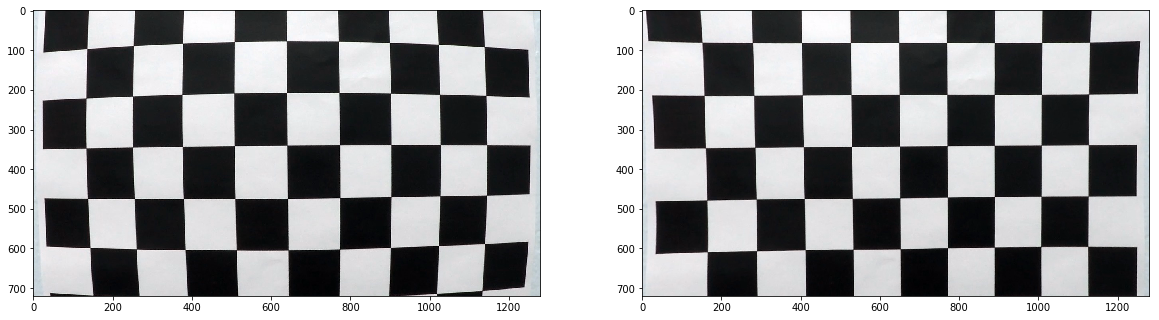

In [2]:
# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

nx = 9
ny = 6

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

images = glob.glob('camera_cal/*.jpg')
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)

    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)

        corners2 = cv2.cornerSubPix(gray, corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners2)

        # Draw and display the corners
        #img = cv2.drawChessboardCorners(img, (nx,ny), corners2,ret)

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

example = 'camera_cal/calibration1.jpg'
img = cv2.imread(example)
h, w = img.shape[:2]
newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w,h), 0, (w,h))
undistorted = cv2.undistort(img, mtx, dist, None, newcameramtx)
fig = plt.figure(figsize = (20, 20))
fig.add_subplot(1, 2, 1)
plt.imshow(img)
fig.add_subplot(1, 2, 2)
plt.imshow(undistorted)

# Step 2: Pipeline Helper Functions

In [3]:

def undistort(img):
    h, w = img.shape[:2]
    newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w,h), 0, (w,h))
    return cv2.undistort(img, mtx, dist, None, newcameramtx)

def sobelx(img, ksize = 5, thresh = 20):
    sobelx = cv2.Sobel(img,cv2.CV_64F, 1, 0, ksize = ksize)
    abs_sobelx = np.absolute(sobelx)
    scaled_sobelx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    ret, thresh = cv2.threshold(scaled_sobelx, thresh, 255, cv2.THRESH_BINARY)
    return thresh

def thresh_white(img, thresh = 208):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray, thresh, 255, cv2.THRESH_BINARY)
    return thresh

def thresh_hlS(img, thresh = 128):
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    lower_S = np.array([0, 0, 128])
    upper_S = np.array([72 ,255, 255])
    return cv2.inRange(hls, lower_S, upper_S)

def thresh_yellow(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    lower_yellow = np.array([15,80,80])
    upper_yellow = np.array([25,255,255])
    return cv2.inRange(hsv, lower_yellow, upper_yellow)

def thresh_green(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    lower_green = np.array([20,10,10])
    upper_green = np.array([50,160,160])
    return cv2.inRange(hsv, lower_green,upper_green)

def transform(img):
    h, w = img.shape[:2]
    dx = 200
    pts1 = np.float32([[265, 685],[610, 440],[670, 440],[1050, 685]])
    pts2 = np.float32([[dx, w], [dx, 0], [h - dx, 0], [h - dx, w]])

    M = cv2.getPerspectiveTransform(pts1, pts2)

    return cv2.warpPerspective(img, M, (h, w))

def retransform(img):
    h, w = img.shape[:2]
    dx = 200
    pts1 = np.float32([[265, 685],[610, 440],[670, 440],[1050, 685]])
    pts2 = np.float32([[dx, h], [dx, 0], [w - dx, 0], [w - dx, h]])

    M = cv2.getPerspectiveTransform(pts2, pts1)

    return cv2.warpPerspective(img, M, (h, w))

def sliding_window(transformed, leftx_base, rightx_base, nwindows = 15):
    h, w = transformed.shape[:2]
    
    # Set height of windows
    window_height = np.int(h//nwindows)
    
    out_img = np.dstack((transformed, transformed, transformed))
    
    nonzero = transformed.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 50
    # Set minimum number of pixels found to recenter window
    minpix = 40
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    #do we search right and left?
    active_left = True
    active_right = True
    #momentum
    momentum_left = 0
    momentum_right = 0
    
    
    # Step through the windows one by one
    for window in range(nwindows):
        momentum_base_left = leftx_current
        momentum_base_right = rightx_current
        leftx_current += momentum_left
        rightx_current += momentum_right
        
        for _ in range(3):
        # Identify window boundaries in x and y (and right and left)
            win_y_low = int(h - (window+1)*window_height)
            win_y_high = int(h - window*window_height)
            win_xleft_low = int(leftx_current - margin)
            win_xleft_high = int(leftx_current + margin)
            win_xright_low = int(rightx_current - margin)
            win_xright_high = int(rightx_current + margin)
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]

            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        
        momentum_left = leftx_current - momentum_base_left
        momentum_right = rightx_current - momentum_base_right
        
        if active_left:
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high), (0,255,0), 2)
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
        if active_right:
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high), (0,255,0), 2)
            right_lane_inds.append(good_right_inds)
        
        #recognize leaving the window left or right
        if leftx_current < margin // 2 and len(good_left_inds) < minpix:
            active_left = False
        if rightx_current > w - (margin // 2) and len(good_right_inds) < minpix:
            active_right = False

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each if more than 2000 pixels found
    left_fit, right_fit = None, None
    if len(lefty) > 2000:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(righty) > 2000:
        right_fit = np.polyfit(righty, rightx, 2)
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    return left_fit, right_fit, out_img

def calcCurvature(ploty, fitx):
    #Step 7 Calculate curvature:
    # Define conversions in x and y from pixels space to meters
    length = np.max(ploty)
    ym_per_pix = 70/length # meters per pixel in y dimension
    xm_per_pix = 3.7/330 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    fit_cr = np.polyfit(ploty*ym_per_pix, fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    
    points = 5
    curverad = 0
    for i in range(points):
        y = length - i * 20
        curverad += ((1 + (2*fit_cr[0]*y*ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])

    curverad = curverad / points
    
    return curverad

def checkSanity(ploty, left_fit, right_fit, left_fit_old = None, right_fit_old = None):
    sane = [True, True]
    if left_fit is not None: 
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        left_curve = calcCurvature(ploty, left_fitx)
    else:
        left_curve = -1
        sane[0] = False
    if right_fit is not None:
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        right_curve = calcCurvature(ploty, right_fitx)
    else:
        right_curve = -1
        sane[1] = False
    if left_fit is not None and right_fit is not None:
        distance = right_fitx[-1] - left_fitx[-1]
        curve_dist = abs(left_curve - right_curve)
        if distance < 290 or distance > 360:
            sane = [False, False]
        if curve_dist > 500 and (left_curve < 4000 or right_curve < 4000):
            sane = [False, False]
    else:
        distance = -1
        curve_dist = -1
    
    if sane == [True, True]:
        return sane, (distance, curve_dist, left_curve, right_curve, -1, -1)
    
    if left_fit_old is not None and left_fit is not None:
        left_fitx_old = left_fit_old[0]*ploty**2 + left_fit_old[1]*ploty + left_fit_old[2]
        left_curve_old = calcCurvature(ploty, left_fitx_old)
        distance_left = abs(left_curve - left_curve_old)
        if distance_left > 500 and (left_curve < 4000 and left_curve_old < 4000):
            sane[0] = False
        else:
            sane[0] = True
    else:
        distance_left = -1
    
    if right_fit_old is not None and right_fit is not None:
        right_fitx_old = right_fit_old[0]*ploty**2 + right_fit_old[1]*ploty + right_fit_old[2]
        right_curve_old = calcCurvature(ploty, right_fitx_old)
        distance_right = abs(right_curve - right_curve_old)
        if distance_right > 500 and (right_curve < 4000 and right_curve_old < 4000):
            sane[1] = False
        else:
            sane[1] = True
    else:
        distance_right = -1
        
    return sane, (distance, curve_dist, left_curve, right_curve, distance_left, distance_right)

def find_lanes(img, mask, left_fit_compare = None, right_fit_compare = None):
    h, w = img.shape[:2]
    
    #Step 3 ROI
    masked_binary = cv2.bitwise_and(img, mask)
    
    #Step 4 Transform
    transformed = transform(masked_binary)
    
    #Step 5 Sliding Window
    if left_fit_compare is not None:
        leftx_base = left_fit_compare[0]*w**2 + left_fit_compare[1]*w + left_fit_compare[2]
        cv2.circle(transformed, (int(leftx_base), w), 12, 255, -1)  #Mark the base
    if right_fit_compare is not None:
        rightx_base = right_fit_compare[0]*w**2 + right_fit_compare[1]*w + right_fit_compare[2]
        cv2.circle(transformed, (int(rightx_base), w), 12, 255, -1)
    
    if left_fit_compare is None or right_fit_compare is None or leftx_base < 0 or rightx_base >= h:
        histogram = np.sum(transformed[2*w//3:, h//6:5*h//6], axis=0)
        midpoint = np.int(h // 3)
        if left_fit_compare is None or leftx_base < 0:
            leftx_base = np.argmax(histogram[:midpoint]) + h // 6
        if right_fit_compare is None or rightx_base >= h:
            rightx_base = np.argmax(histogram[midpoint:]) + midpoint + h // 6
        
    return sliding_window(transformed, leftx_base, rightx_base), (leftx_base, rightx_base)


# Step 3: Pipeline

### Test Images

[-1.22139527e-04  2.83471879e-01  7.63033120e+01] [-1.00779781e-04  2.49881334e-01  3.90360743e+02]
[True, True] (306.03627260001224, 231.7688569605382, 1093.685235808877, 1325.4540927694152, -1, -1)
test_images/neu\1eimg.png Left 1093.685235808877
test_images/neu\1eimg.png Right 1325.4540927694152
[-1.22139527e-04  2.83471879e-01  7.63033120e+01] [-1.00779781e-04  2.49881334e-01  3.90360743e+02]
[True, True] (306.03627260001224, 231.7688569605382, 1093.685235808877, 1325.4540927694152, -1, -1)
test_images/neu\2eimg.png Left 1093.685235808877
test_images/neu\2eimg.png Right 1325.4540927694152
[-1.22238570e-04  2.87257909e-01  7.28545924e+01] [-1.03020691e-04  2.57943182e-01  3.82993733e+02]
[True, True] (304.0829993299859, 203.83284872681497, 1092.790609736834, 1296.623458463649, -1, -1)
test_images/neu\3eimg.png Left 1092.790609736834
test_images/neu\3eimg.png Right 1296.623458463649
[-1.18378801e-04  2.82901023e-01  7.33852359e+01] [-1.05193493e-04  2.66313312e-01  3.75519128e+02]
[T

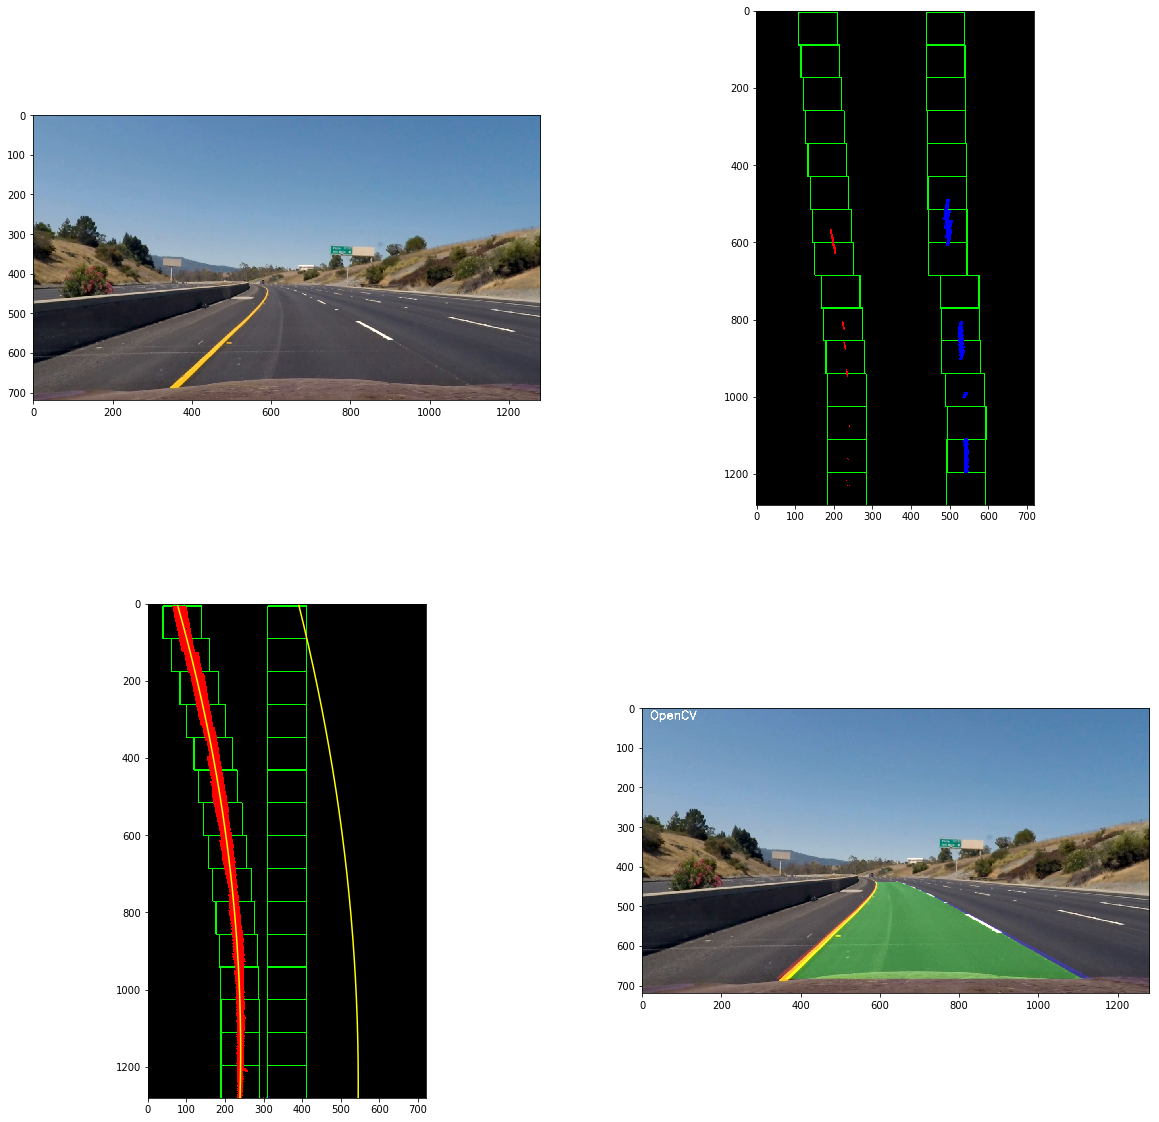

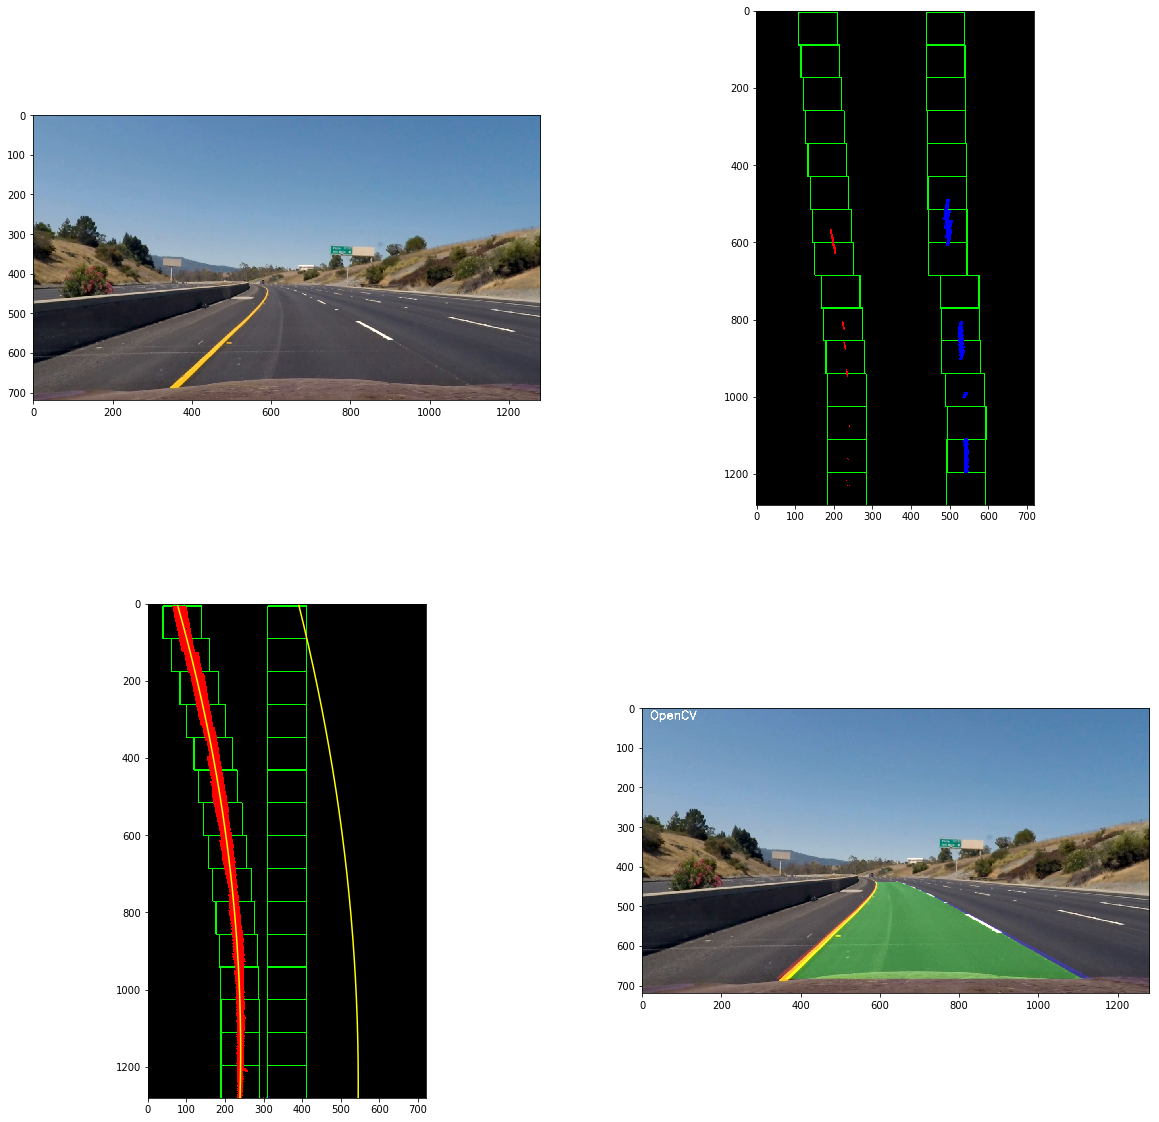

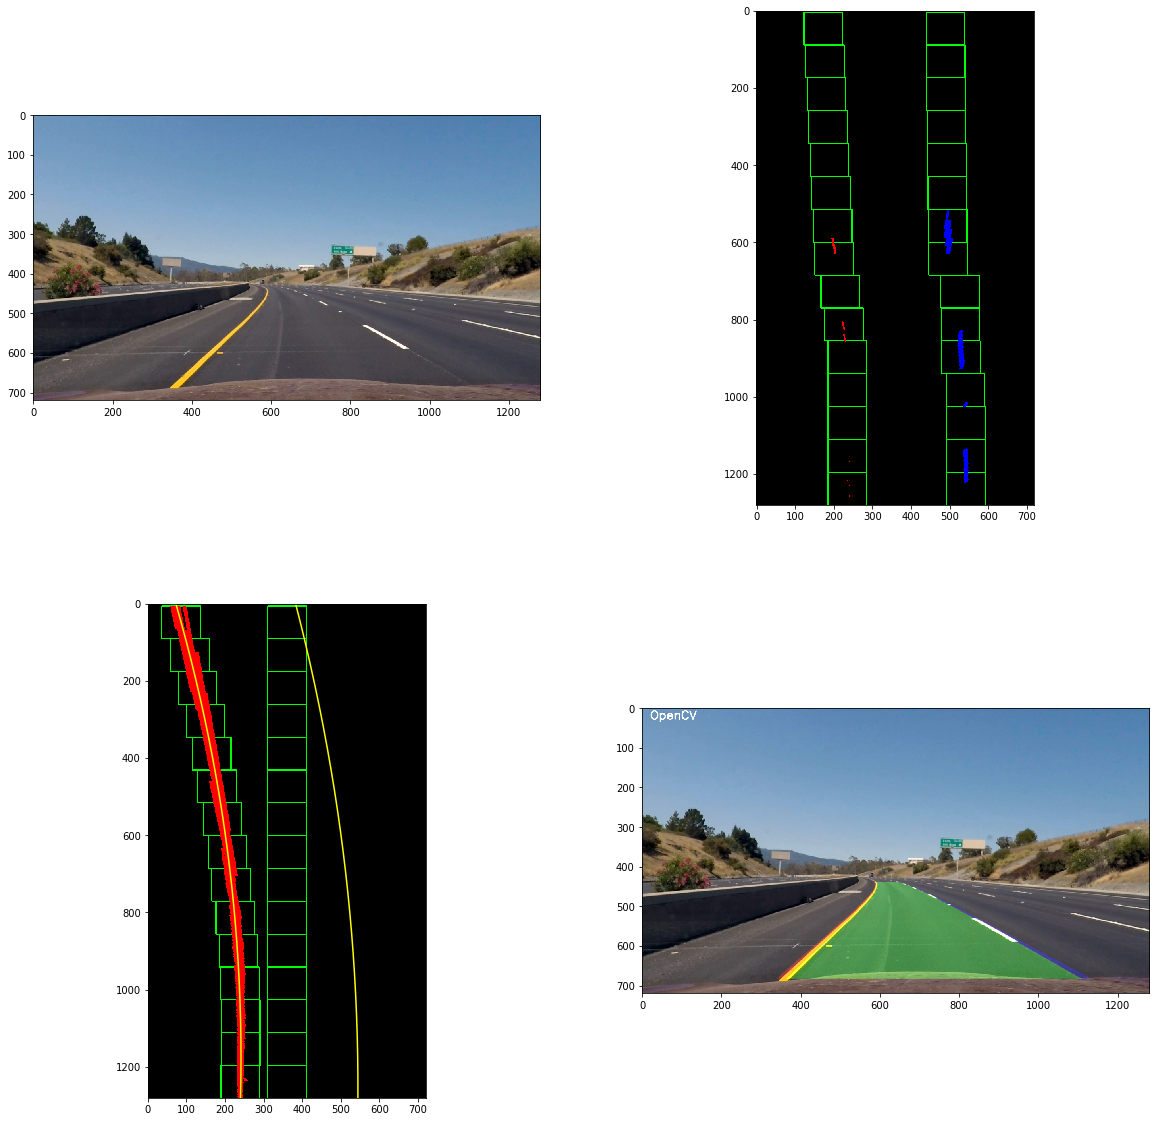

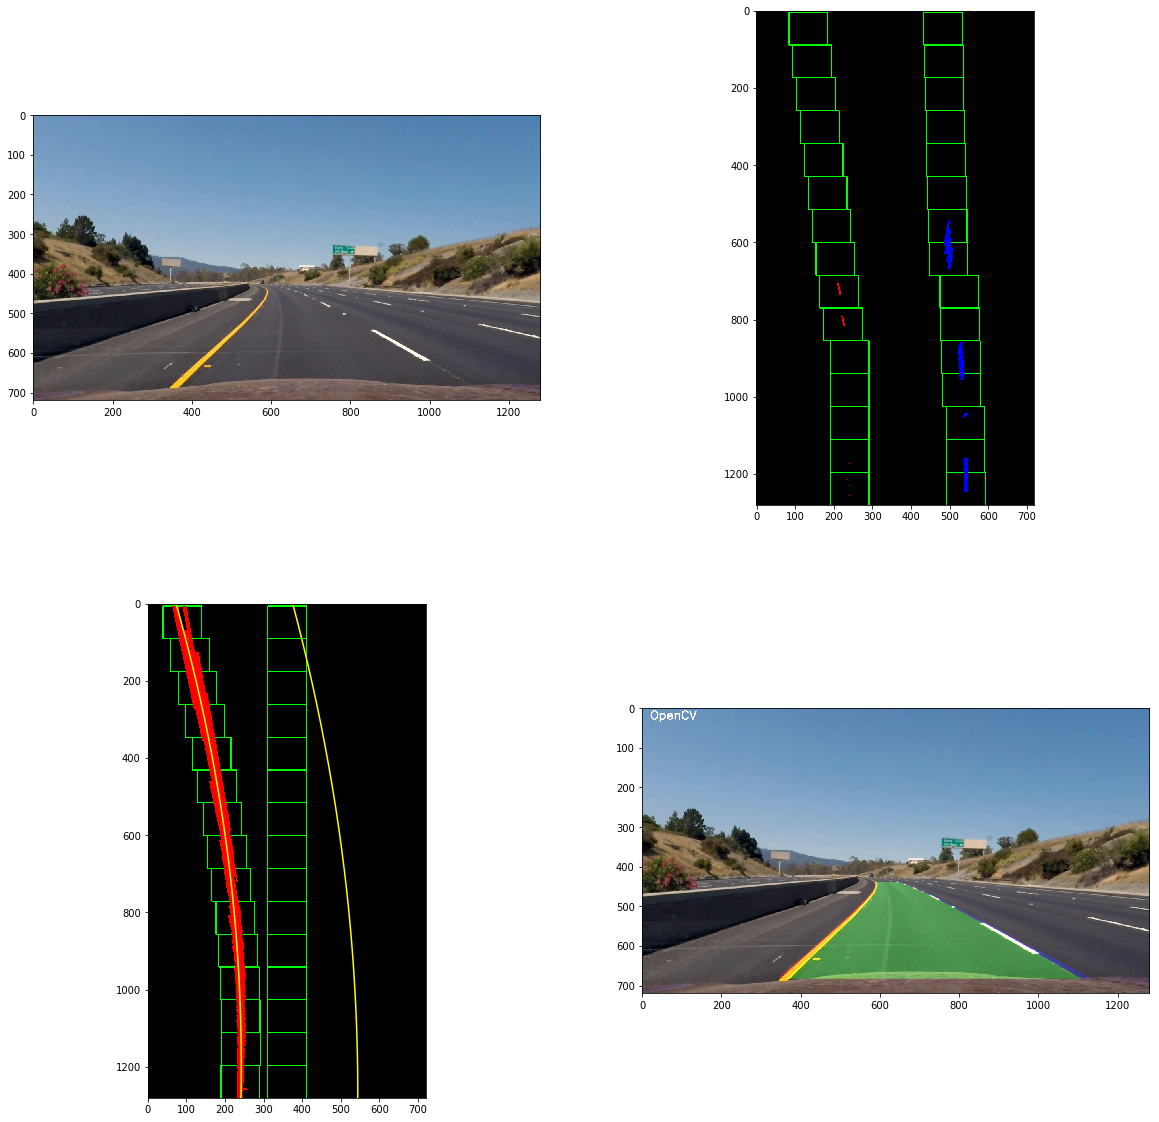

In [4]:

#fig = plt.figure(figsize = (20, 20))
for i, fimage in enumerate(glob.glob('test_images/neu/*.png')):
    fig = plt.figure(figsize = (20, 20))
    img = undistort(cv2.imread(fimage))
    show_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]
    ploty = np.linspace(0, w-1, w )
    red = img[:,:,2]
    
    #plot original image
    fig.add_subplot(2, 2, 1)
    plt.imshow(show_img)
    
    sobelr = sobelx(red)
    threshw = thresh_white(img)
    threshs = thresh_hlS(img)
    threshy = thresh_yellow(img)
    threshg = thresh_green(img)
    
    combined = np.dstack((sobelr, threshs, threshy))
    combined_binary = cv2.bitwise_or(sobelr, threshw)
    combined_binary = cv2.bitwise_or(combined_binary, threshs)
    combined_binary = cv2.bitwise_or(combined_binary, threshy)
    combined_binary = cv2.bitwise_and(combined_binary, cv2.bitwise_not(threshg))
    
    mask = np.zeros_like(combined_binary)
    pts_roi = np.array([[[215, 690],[560, 390],[720, 390],[1100, 690]]], np.int32)
    cv2.fillPoly(mask, pts_roi, 255)
    (_, right_fit, debug1), dbase = find_lanes(threshw, mask, None, None)
    
    (left_fit, _, debug2), dbase = find_lanes(threshy, mask, None, None)
    print(left_fit, right_fit)
    
    sane, values = checkSanity(ploty, left_fit, right_fit, None, None)
    print(sane, values)
    
    marked_lanes = np.zeros_like(debug1)
    
    
    if left_fit is not None:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        cv2.polylines(marked_lanes, np.int_(pts_left), False, (255, 0, 0), 20, cv2.LINE_AA)
        left_curve = calcCurvature(ploty, left_fitx)
        print(fimage, 'Left', left_curve)
    
    if right_fit is not None:
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        cv2.polylines(marked_lanes, np.int_(pts_right), False, (0, 0, 255), 20, cv2.LINE_AA)
        right_curve = calcCurvature(ploty, right_fitx)
        print(fimage, 'Right', right_curve)
        
    pts = np.hstack((pts_left, pts_right))
    cv2.fillPoly(marked_lanes, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    retransformed = retransform(marked_lanes)
    # Combine the result with the original image
    result = cv2.addWeighted(show_img, 1, retransformed, 0.3, 0)
    cv2.putText(result,'OpenCV', (20,30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    fig.add_subplot(2, 2, 2)
    plt.imshow(debug1)
    
    fig.add_subplot(2, 2, 3)
    plt.imshow(debug2)
    if left_fit is not None:
        plt.plot(left_fitx, ploty, color='yellow')
    if right_fit is not None:
        plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, h)
    plt.ylim(w, 0)
    
    fig.add_subplot(2, 2, 4)
    plt.imshow(result)
    

### State Class

In [5]:
class State():
    
    def __init__(self):
        self.frame = 0
        self.found = [False, False]
        self.left_fit = None
        self.right_fit = None
        self.lanePoly = None


### Pipeline

In [6]:

def pipeline(img):
    state.frame += 1
    
    #Step 0 #RGB2BGR
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    
    #Step 1 Undistort
    uimg = undistort(img)
    
    #get Params
    h, w = uimg.shape[:2]
    ploty = np.linspace(0, w-1, w )
    
    #Step 2 Color and Gradients
    red = uimg[:,:,2]
    sobelr = sobelx(red)
    threshw = thresh_white(uimg)
    threshs = thresh_hlS(uimg)
    threshy = thresh_yellow(uimg)
    threshg = thresh_green(uimg)
    
    combined_binary = cv2.bitwise_or(sobelr, threshw)
    combined_binary = cv2.bitwise_or(combined_binary, threshs)
    combined_binary = cv2.bitwise_or(combined_binary, threshy)
    combined_binary = cv2.bitwise_and(combined_binary, cv2.bitwise_not(threshg)) #lane markings are never green
    
    print('Frame:', state.frame, 'Found:', state.found)
    
    #Step 3 ROI
    if state.lanePoly is not None:
        mask = cv2.dilate(state.lanePoly, np.ones((15,15), np.uint8), iterations = 1)
    else:
        pts_roi = np.array([[[215, 690],[560, 390],[720, 390],[1100, 690]]], np.int32)
        mask = np.zeros_like(combined_binary)
        cv2.fillPoly(mask, pts_roi, 255)
    #Sanity Check
    (left_fit, right_fit, debug1), dbase = find_lanes(threshw, mask, state.left_fit, state.right_fit)
    sane, values = checkSanity(ploty, left_fit, right_fit, state.left_fit, state.right_fit)
    print('White:', sane)
    level = 0
    if not sane[0] or not sane[1]:
        level = 1
        if sane[0]:
            (_, right_fit, debug2), dbase = find_lanes(threshy, mask, left_fit, state.right_fit)
        elif sane[1]:
            (left_fit, _, debug2), dbase = find_lanes(threshy, mask, state.left_fit, right_fit)
        else:
            (left_fit, right_fit, debug2), dbase = find_lanes(threshy, mask, state.left_fit, state.right_fit)
        sane, values = checkSanity(ploty, left_fit, right_fit, state.left_fit, state.right_fit)
        print('Yellow:', sane)
    if not sane[0] or not sane[1]:
        level = 2
        if sane[0]:
            (_, right_fit, debug3), dbase = find_lanes(combined_binary, mask, left_fit, state.right_fit)
        elif sane[1]:
            (left_fit, _, debug3), dbase = find_lanes(combined_binary, mask, state.left_fit, right_fit)
        else:
            (left_fit, right_fit, debug3), dbase = find_lanes(combined_binary, mask, state.left_fit, state.right_fit)
        sane, values = checkSanity(ploty, left_fit, right_fit, state.left_fit, state.right_fit)
        print('Combined:', sane)
    if sane[0] != sane[1]:
        (left_fit, right_fit, debug3), dbase = find_lanes(combined_binary, mask, state.left_fit, state.right_fit)
        sane, values = checkSanity(ploty, left_fit, right_fit, state.left_fit, state.right_fit)
        
    print(sane, values, dbase)

    if left_fit is None or not sane[0] and state.found[0]:
        left_fit = state.left_fit
    if right_fit is None or not sane[1] and state.found[1]:
        right_fit = state.right_fit
        
    #Step 6 Draw lines
    marked_lanes = np.zeros((w, h, 3), np.uint8)
    lanePoly = np.zeros((w, h, 1), np.uint8)
    
    if left_fit is not None:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        if state.found[0]:
            old_left_fitx = state.left_fit[0]*ploty**2 + state.left_fit[1]*ploty + state.left_fit[2]
            #left_fitx = np.mean((left_fitx, old_left_fitx), axis = 0)
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        cv2.polylines(marked_lanes, np.int_(pts_left), False, (255, 0, 0), 20, cv2.LINE_AA)
        if level == 0:
            cv2.polylines(debug1, np.int_(pts_left), False, (0, 255, 0), 20, cv2.LINE_AA)
        elif level == 1:
            cv2.polylines(debug2, np.int_(pts_left), False, (0, 255, 0), 20, cv2.LINE_AA)
        elif level == 2:
            cv2.polylines(debug3, np.int_(pts_left), False, (0, 255, 0), 20, cv2.LINE_AA)
    
    if right_fit is not None:
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        if state.found[1]:
            old_right_fitx = state.right_fit[0]*ploty**2 + state.right_fit[1]*ploty + state.right_fit[2]
            #right_fitx = np.mean((right_fitx, old_right_fitx), axis = 0)
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        cv2.polylines(marked_lanes, np.int_(pts_right), False, (0, 0, 255), 20, cv2.LINE_AA)
        if level == 0:
            cv2.polylines(debug1, np.int_(pts_right), False, (0, 255, 0), 20, cv2.LINE_AA)
        elif level == 1:
            cv2.polylines(debug2, np.int_(pts_right), False, (0, 255, 0), 20, cv2.LINE_AA)
        elif level == 2:
            cv2.polylines(debug3, np.int_(pts_right), False, (0, 255, 0), 20, cv2.LINE_AA)
    
    if left_fit is not None and right_fit is not None:
        pts = np.hstack((pts_left, pts_right))
        cv2.fillPoly(marked_lanes, np.int_([pts]), (0,255, 0))
        cv2.fillPoly(lanePoly, np.int_([pts]), 255)

    retransformed = retransform(marked_lanes)
    # Combine the result with the original image
    result = cv2.addWeighted(uimg, 1, retransformed, 0.3, 0)

    #Step 7 Calculate curvature:
    curverad = 0
    if left_fit is not None:
        left_curverad = calcCurvature(ploty, left_fitx)
        leftx_base = left_fit[0]*w**2 + left_fit[1]*w + left_fit[2]
        curverad = left_curverad
    if right_fit is not None:
        right_curverad = calcCurvature(ploty, right_fitx)
        rightx_base = right_fit[0]*w**2 + right_fit[1]*w + right_fit[2]
        curverad = right_curverad
    if left_fit is not None and right_fit is not None:
        curverad = (left_curverad + right_curverad) / 2
        center = (rightx_base + leftx_base) / 2
        center_diff = (h/2) - center
        xm_per_pix = 3.7/330
        center_diff_m = center_diff * xm_per_pix
        cv2.putText(result,'Curve Radius: {:.2f}m'.format(curverad), (10,30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255),
                2, cv2.LINE_AA)
        cv2.putText(result,'Car is {:.2f}m right of lane center.'.format(center_diff_m), (10,60), cv2.FONT_HERSHEY_SIMPLEX,
                1, (255,255,255), 2, cv2.LINE_AA)
    
    #Step 8 Save parameters
    state.found = sane
    if sane[0]:
        state.left_fit = left_fit
    else:
        state.left_fit = None
    if sane[1]:
        state.right_fit = right_fit
    else:
        state.right_fit = None
    if sane[0] and sane[1]:
        state.lanePoly = retransform(lanePoly)
    else:
        state.lanePoly = None
    
    cv2.imwrite('test_images/debug/{}eimg.png'.format(state.frame), img)
    cv2.imwrite('test_images/debug/{}emask.png'.format(state.frame), cv2.bitwise_and(combined_binary, mask))
    cv2.imwrite('test_images/debug/{}edebug1.png'.format(state.frame), debug1)
    if level > 0:
        cv2.imwrite('test_images/debug/{}edebug2.png'.format(state.frame), debug2)
    if level > 1:
        cv2.imwrite('test_images/debug/{}edebug3.png'.format(state.frame), debug3)
    cv2.imwrite('test_images/debug/{}eresult.png'.format(state.frame), result)
    
    result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
    return result
    

In [7]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [8]:
state = State()

output = 'output_images/project_video.mp4'

clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output, audio=False)

Frame: 1 Found: [False, False]
White: [False, True]
Yellow: [True, True]
[True, True] (306.03627260001224, 231.7688569605382, 1093.685235808877, 1325.4540927694152, -1, -1) (235, 545.0912574487)
[MoviePy] >>>> Building video output_images/project_video.mp4
[MoviePy] Writing video output_images/project_video.mp4


  0%|                                                                                         | 0/1261 [00:00<?, ?it/s]

Frame: 2 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (305.95587224599643, 227.86988898493132, 1094.125660008967, 1321.9955489938984, -1, -1) (239.03391580287814, 545.0371841037005)


  0%|                                                                                 | 1/1261 [00:00<06:37,  3.17it/s]

Frame: 3 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (304.32220990515407, 219.12270193907102, 1092.4467149086145, 1311.5694168476855, -1, -1) (239.06058509350646, 544.5916080129631)


  0%|▏                                                                                | 2/1261 [00:00<06:29,  3.23it/s]

Frame: 4 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (302.36626962573604, 138.24888908197363, 1130.2259490186934, 1268.474838100667, -1, -1) (240.24834818048294, 544.031416308243)


  0%|▏                                                                                | 3/1261 [00:00<06:20,  3.30it/s]

Frame: 5 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (303.64888163062943, 166.49405311820874, 1021.6420955491449, 1188.1361486673536, -1, -1) (241.64839717553812, 543.6767186768404)


  0%|▎                                                                                | 4/1261 [00:01<06:12,  3.37it/s]

Frame: 6 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (302.6676301087502, 73.51298085497706, 1038.395553402726, 1111.908534257703, -1, -1) (239.99977130074774, 543.3216698122604)


  0%|▎                                                                                | 5/1261 [00:01<06:13,  3.37it/s]

Frame: 7 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (302.0015275159267, 126.45948845599105, 1022.867594246397, 1149.327082702388, -1, -1) (240.63245548697847, 543.1670455331018)


  0%|▍                                                                                | 6/1261 [00:01<06:06,  3.42it/s]

Frame: 8 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (303.00692471549445, 177.56393441890611, 1005.7808305304267, 1183.3447649493328, -1, -1) (241.13863520263226, 543.6411032166052)


  1%|▍                                                                                | 7/1261 [00:02<05:58,  3.50it/s]

Frame: 9 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (302.8373736915945, 288.0917827764508, 981.119150845175, 1269.2109336216258, -1, -1) (240.6057339076081, 543.9926791505434)


  1%|▌                                                                                | 8/1261 [00:02<05:53,  3.55it/s]

Frame: 10 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (304.81330979066934, 447.78333172285204, 985.4746495851829, 1433.257981308035, -1, -1) (241.11568831608093, 544.8312922785025)


  1%|▌                                                                                | 9/1261 [00:02<05:50,  3.57it/s]

Frame: 11 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (303.962405336145, 324.5699233061723, 1039.8843491317486, 1364.454272437921, -1, -1) (239.97315405544916, 545.0087363073454)


  1%|▋                                                                               | 10/1261 [00:02<05:49,  3.58it/s]

Frame: 12 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (303.4637487556145, 413.70697268710455, 1061.4694932218563, 1475.1764659089608, -1, -1) (241.01190928292834, 545.382363397463)


  1%|▋                                                                               | 11/1261 [00:03<05:47,  3.60it/s]

Frame: 13 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (305.3154117889974, 382.6513974643285, 1125.9340458879146, 1508.5854433522431, -1, -1) (241.87991921470643, 545.6437415380989)


  1%|▊                                                                               | 12/1261 [00:03<05:54,  3.52it/s]

Frame: 14 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (304.50814773555226, 344.84845328477377, 1094.1196770902689, 1438.9681303750426, -1, -1) (240.30841108290784, 545.0646434581633)


  1%|▊                                                                               | 13/1261 [00:03<05:56,  3.50it/s]

Frame: 15 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (308.18508089882266, 688.7919310078971, 967.990835330146, 1656.782766338043, 126.1288417601229, 217.81463596300046) (240.53317359823336, 545.4354322840461)


  1%|▉                                                                               | 14/1261 [00:04<05:54,  3.52it/s]

Frame: 16 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (309.0654073199621, 822.7460602404461, 833.1333422284994, 1655.8794024689455, 134.85749310164658, 0.9033638690975749) (237.19900834485216, 544.4941139800363)


  1%|▉                                                                               | 15/1261 [00:04<05:52,  3.53it/s]

Frame: 17 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (306.27322415856105, 640.0666024689135, 811.8372904513503, 1451.9038929202638, 21.296051777149046, 203.97550954868166) (235.34813561669213, 542.3277932828096)


  1%|█                                                                               | 16/1261 [00:04<05:51,  3.55it/s]

Frame: 18 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (305.52923846515785, 588.680908362244, 845.1885533316636, 1433.8694616939076, 33.35126288031324, 18.03443122635622) (235.9736179066104, 541.2297132412098)


  1%|█                                                                               | 17/1261 [00:04<05:50,  3.55it/s]

Frame: 19 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (306.95043203929004, 799.976773125998, 736.8871037321582, 1536.8638768581561, 108.30144959950542, 102.9944151642485) (235.62328930178745, 540.5665348185386)


  1%|█▏                                                                              | 18/1261 [00:05<05:48,  3.57it/s]

Frame: 20 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (303.55169879426137, 669.8978409214748, 912.2073292530882, 1582.105170174563, 175.32022552093008, 45.24129331640688) (233.51637671399803, 540.4348047167077)


  2%|█▏                                                                              | 19/1261 [00:05<05:50,  3.54it/s]

Frame: 21 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (306.46323767489196, 732.8729278557839, 852.7542461586645, 1585.6271740144484, 59.45308309442373, 3.5220038398854285) (236.8193965474139, 540.4237046594053)


  2%|█▎                                                                              | 20/1261 [00:05<05:49,  3.56it/s]

Frame: 22 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (308.03959142351937, 862.1747653785601, 865.9020864251352, 1728.0768518036953, 13.147840266470666, 142.44967778924683) (233.89070725528083, 540.4270824677119)


  2%|█▎                                                                              | 21/1261 [00:05<05:46,  3.58it/s]

Frame: 23 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (309.40076330500966, 618.7481061907881, 867.5850357948732, 1486.3331419856613, 1.6829493697380258, 241.74370981803395) (232.32237028876693, 540.2006856476294)


  2%|█▍                                                                              | 22/1261 [00:06<05:46,  3.58it/s]

Frame: 24 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (306.4293206007458, 249.2272696342211, 999.7481310580849, 1248.975400692306, -1, -1) (230.7472849920817, 538.8794131688676)


  2%|█▍                                                                              | 23/1261 [00:06<05:45,  3.59it/s]

Frame: 25 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (305.39888991601316, 335.1372428860557, 958.1690015651664, 1293.306244451222, -1, -1) (232.43405060309522, 538.3281082342729)


  2%|█▌                                                                              | 24/1261 [00:06<05:43,  3.60it/s]

Frame: 26 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (305.1035408805344, 198.8207354905809, 939.0022072678361, 1137.822942758417, -1, -1) (232.90443867249923, 537.749137389919)


  2%|█▌                                                                              | 25/1261 [00:07<05:43,  3.60it/s]

Frame: 27 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (307.42048582147555, 166.43651594122707, 920.6353519200566, 1087.0718678612836, -1, -1) (232.62238705524157, 537.4095161386758)


  2%|█▋                                                                              | 26/1261 [00:07<05:43,  3.60it/s]

Frame: 28 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (307.53328105790615, 147.39165131241066, 972.5308404793334, 1119.922491791744, -1, -1) (229.97203585408437, 538.2779678017856)


  2%|█▋                                                                              | 27/1261 [00:07<05:43,  3.60it/s]

Frame: 29 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (308.0186750045876, 130.17222176887276, 1081.6028514280388, 1211.7750731969115, -1, -1) (230.732323168452, 539.6848571555499)


  2%|█▊                                                                              | 28/1261 [00:07<05:47,  3.55it/s]

Frame: 30 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (308.28536164820434, 173.37031273963794, 1029.1138722836818, 1202.4841850233197, -1, -1) (231.6702770891174, 540.0652014898532)


  2%|█▊                                                                              | 29/1261 [00:08<05:46,  3.55it/s]

Frame: 31 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (307.619737248162, 202.75216489585625, 989.9113127437419, 1192.663477639598, -1, -1) (231.7725411489253, 540.0780326492345)


  2%|█▉                                                                              | 30/1261 [00:08<05:45,  3.56it/s]

Frame: 32 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (310.5459775019967, 334.60155659523605, 796.1739064215172, 1130.7754630167533, -1, -1) (232.44045754370387, 540.0650190208806)


  2%|█▉                                                                              | 31/1261 [00:08<05:47,  3.54it/s]

Frame: 33 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (310.57575803400243, 371.31755321953574, 741.0816510165353, 1112.399204236071, -1, -1) (229.46925419984893, 539.9508074828973)


  3%|██                                                                              | 32/1261 [00:09<05:56,  3.45it/s]

Frame: 34 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (309.6224997872582, 297.2806457277728, 790.8331844874502, 1088.113830215223, -1, -1) (229.30578489407398, 539.7695499583209)


  3%|██                                                                              | 33/1261 [00:09<05:49,  3.51it/s]

Frame: 35 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (308.319027703607, 270.8729259835708, 767.0163180014866, 1037.8892439850574, -1, -1) (230.09668729984372, 539.6019245540288)


  3%|██▏                                                                             | 34/1261 [00:09<05:44,  3.56it/s]

Frame: 36 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (308.09888091422954, 361.2165578075226, 758.8896613691775, 1120.1062191767, -1, -1) (231.22920415308812, 539.9094918821247)


  3%|██▏                                                                             | 35/1261 [00:09<05:42,  3.58it/s]

Frame: 37 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (305.88114161202225, 329.81569946784407, 787.4255765450519, 1117.241276012896, -1, -1) (231.75101936282817, 539.8973576728922)


  3%|██▎                                                                             | 36/1261 [00:10<05:40,  3.60it/s]

Frame: 38 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (303.6411249684762, 138.74133095904915, 785.0579346878807, 923.7992656469298, -1, -1) (233.95806144342242, 538.5196785592041)


  3%|██▎                                                                             | 37/1261 [00:10<05:39,  3.61it/s]

Frame: 39 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (302.59660180907076, 115.15357078831516, 752.6436415281063, 867.7972123164215, -1, -1) (234.83396296901543, 537.6801845725445)


  3%|██▍                                                                             | 38/1261 [00:10<05:35,  3.65it/s]

Frame: 40 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (301.0621782571352, 115.94039283849725, 725.181372769174, 841.1217656076713, -1, -1) (235.03605345184585, 536.787242048598)


  3%|██▍                                                                             | 39/1261 [00:10<05:34,  3.66it/s]

Frame: 41 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (299.62259765747524, 111.13478996520735, 775.1169497823035, 886.2517397475109, -1, -1) (235.67249756602072, 536.8745657862843)


  3%|██▌                                                                             | 40/1261 [00:11<05:33,  3.66it/s]

Frame: 42 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (299.313519923267, 64.407410923121, 787.0569627833713, 851.4643737064923, -1, -1) (237.2103390109085, 536.9529545536794)


  3%|██▌                                                                             | 41/1261 [00:11<05:40,  3.58it/s]

Frame: 43 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (299.84398643404154, 82.70265314207904, 792.3444265146783, 875.0470796567573, -1, -1) (237.6025838931205, 537.4790418134139)


  3%|██▋                                                                             | 42/1261 [00:11<05:38,  3.60it/s]

Frame: 44 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (299.5345373447694, 90.82460587125581, 836.7921717238162, 927.616777595072, -1, -1) (237.59554036095378, 538.313040021327)


  3%|██▋                                                                             | 43/1261 [00:12<05:37,  3.61it/s]

Frame: 45 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (300.80190119785675, 87.40580000724196, 885.1095100549603, 972.5153100622023, -1, -1) (238.74811671545677, 538.9211427301603)


  3%|██▊                                                                             | 44/1261 [00:12<05:35,  3.63it/s]

Frame: 46 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (300.90513074192813, 26.517753565661337, 919.2396387728728, 945.7573923385341, -1, -1) (238.09531077384415, 539.1476460803323)


  4%|██▊                                                                             | 45/1261 [00:12<05:36,  3.62it/s]

Frame: 47 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (300.4588575963446, 3.959278142528433, 975.9882987395373, 979.9475768820657, -1, -1) (238.22822381956956, 539.396259725211)


  4%|██▉                                                                             | 46/1261 [00:12<05:40,  3.56it/s]

Frame: 48 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (301.1066961495833, 6.855662469530216, 989.2639795700754, 982.4083171005452, -1, -1) (238.92755775597112, 539.4947765048211)


  4%|██▉                                                                             | 47/1261 [00:13<05:39,  3.57it/s]

Frame: 49 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (301.1193658358494, 44.1577348483994, 968.0189257993458, 923.8611909509464, -1, -1) (238.38165701057986, 539.1317190157214)


  4%|███                                                                             | 48/1261 [00:13<05:37,  3.60it/s]

Frame: 50 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (302.2587362020498, 73.38699751359252, 1041.3172380972844, 967.9302405836919, -1, -1) (238.00323517478498, 539.6822874993929)


  4%|███                                                                             | 49/1261 [00:13<05:37,  3.59it/s]

Frame: 51 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (302.01454168679527, 77.93949236007325, 1034.7898530741459, 956.8503607140726, -1, -1) (237.42434149091642, 539.5967126411444)


  4%|███▏                                                                            | 50/1261 [00:14<05:36,  3.60it/s]

Frame: 52 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (300.60892821072133, 184.36139054049863, 1175.7306713370233, 991.3692807965247, -1, -1) (237.58021342242031, 539.9916040613122)


  4%|███▏                                                                            | 51/1261 [00:14<05:37,  3.59it/s]

Frame: 53 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (301.3219496847644, 96.36013606691654, 1081.4102114884429, 985.0500754215263, -1, -1) (239.39009057896905, 539.5850625463311)


  4%|███▎                                                                            | 52/1261 [00:14<05:37,  3.59it/s]

Frame: 54 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (300.6699383737828, 107.0064225905437, 1082.5196293435586, 975.5132067530149, -1, -1) (238.25507801751604, 538.8375423319056)


  4%|███▎                                                                            | 53/1261 [00:14<05:35,  3.60it/s]

Frame: 55 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (300.26451436639, 157.3315648415687, 1112.6623677265384, 955.3308028849697, -1, -1) (238.1578925767382, 538.2657422817213)


  4%|███▍                                                                            | 54/1261 [00:15<05:36,  3.59it/s]

Frame: 56 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (304.827881888956, 101.80467066271603, 926.5798595794197, 1028.3845302421357, -1, -1) (237.99150672595303, 538.6991988121003)


  4%|███▍                                                                            | 55/1261 [00:15<05:37,  3.57it/s]

Frame: 57 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (303.96167553743624, 9.663595523888262, 1033.4006972666534, 1023.7371017427652, -1, -1) (233.83568306173152, 538.7234246970365)


  4%|███▌                                                                            | 56/1261 [00:15<05:37,  3.57it/s]

Frame: 58 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (304.1565185228372, 15.836763590460578, 1049.9265800813432, 1065.7633436718038, -1, -1) (234.741435570578, 538.9247243691333)


  5%|███▌                                                                            | 57/1261 [00:16<05:39,  3.55it/s]

Frame: 59 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (304.64348750395334, 39.617215058771535, 1080.7508279740312, 1120.3680430328027, -1, -1) (234.7437764333968, 539.3286652106099)


  5%|███▋                                                                            | 58/1261 [00:16<05:37,  3.57it/s]

Frame: 60 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (306.07849726033646, 194.8512873686518, 946.2103780750476, 1141.0616654436994, -1, -1) (234.66030093041257, 539.6594882666577)


  5%|███▋                                                                            | 59/1261 [00:16<05:40,  3.53it/s]

Frame: 61 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (304.7232444504067, 487.04005416318955, 1002.0097221683925, 1489.049776331582, -1, -1) (233.5267331815395, 539.574066208648)


  5%|███▊                                                                            | 60/1261 [00:16<05:38,  3.54it/s]

Frame: 62 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (307.13371104910425, 707.5302990544941, 920.7947125061725, 1628.3250115606666, 81.21500966222004, 139.2752352290845) (234.78158852162397, 539.3800955556455)


  5%|███▊                                                                            | 61/1261 [00:17<05:37,  3.56it/s]

Frame: 63 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (305.1354500330928, 434.9616675414735, 973.1865747634971, 1408.1482423049706, -1, -1) (232.15330408726012, 538.2362234823578)


  5%|███▉                                                                            | 62/1261 [00:17<05:34,  3.58it/s]

Frame: 64 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (303.3203722378734, 216.14371710892715, 1089.5610719366862, 1305.7047890456133, -1, -1) (233.01417750445643, 536.9200248815381)


  5%|███▉                                                                            | 63/1261 [00:17<05:31,  3.62it/s]

Frame: 65 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (302.1472733661133, 227.42940146368096, 1055.085536691665, 1282.514938155346, -1, -1) (233.53427009920733, 535.4389817407998)


  5%|████                                                                            | 64/1261 [00:17<05:28,  3.64it/s]

Frame: 66 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (301.6821691802353, 238.03863799664282, 1123.584104083381, 1361.6227420800237, -1, -1) (233.2239840112277, 534.825007158899)


  5%|████                                                                            | 65/1261 [00:18<05:28,  3.64it/s]

Frame: 67 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (301.0787244561788, 268.6031975731612, 1107.984476755314, 1376.5876743284753, -1, -1) (233.08434337208794, 533.8350654216893)


  5%|████▏                                                                           | 66/1261 [00:18<05:28,  3.64it/s]

Frame: 68 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (301.31233566427164, 380.6505933385083, 1090.9413697646728, 1471.5919631031811, -1, -1) (232.69371430630892, 533.0545562339254)


  5%|████▎                                                                           | 67/1261 [00:18<05:55,  3.36it/s]

Frame: 69 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (303.513072652004, 452.7855537026153, 982.4936877413659, 1435.2792414439812, -1, -1) (231.67653474110892, 532.7968636451158)


  5%|████▎                                                                           | 68/1261 [00:19<05:55,  3.35it/s]

Frame: 70 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (301.6962890214723, 448.4134586107591, 1026.6095034382536, 1475.0229620490127, -1, -1) (229.21168711356557, 532.0878253898703)


  5%|████▍                                                                           | 69/1261 [00:19<05:44,  3.46it/s]

Frame: 71 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (302.95225158565023, 581.0039801261621, 1095.6579047252537, 1676.6618848514158, 69.04840128700016, 201.63892280240316) (230.3205924813796, 532.6277094778231)


  6%|████▍                                                                           | 70/1261 [00:19<05:37,  3.53it/s]

Frame: 72 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (303.08749325390124, 664.4742775418879, 1070.455068527124, 1734.929346069012, 25.202836198129717, 58.267461217596065) (229.6108936943687, 532.5048041506461)


  6%|████▌                                                                           | 71/1261 [00:19<05:39,  3.51it/s]

Frame: 73 Found: [True, True]
White: [False, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (298.3604122227194, 195.24806647353694, 1152.8642170786654, 957.6161506051285, -1, -1) (229.9470523469878, 532.5048041506461)


  6%|████▌                                                                           | 72/1261 [00:20<06:02,  3.28it/s]

Frame: 74 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (298.11530436730663, 175.31037338190367, 1103.848877677925, 928.5385042960213, -1, -1) (229.9470523469878, 527.0012335355431)


  6%|████▋                                                                           | 73/1261 [00:20<05:49,  3.40it/s]

Frame: 75 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (297.95422316712205, 134.11966079529316, 1109.260942053931, 975.141281258638, -1, -1) (228.86836373606556, 526.4492311755134)


  6%|████▋                                                                           | 74/1261 [00:20<05:42,  3.47it/s]

Frame: 76 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (297.234880339464, 269.3807047089257, 1204.937571142294, 935.5568664333683, -1, -1) (228.47496235507177, 525.5909775456416)


  6%|████▊                                                                           | 75/1261 [00:21<05:37,  3.51it/s]

Frame: 77 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (297.5680188502001, 239.43305744972292, 1171.2978431138572, 931.8647856641343, -1, -1) (228.3550164918737, 525.5994627761092)


  6%|████▊                                                                           | 76/1261 [00:21<05:37,  3.51it/s]

Frame: 78 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (299.5586384582117, 322.81006207832866, 1287.878257539494, 965.0681954611653, -1, -1) (228.02450144968526, 526.3924339720847)


  6%|████▉                                                                           | 77/1261 [00:21<05:35,  3.53it/s]

Frame: 79 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (302.0754667481581, 263.4465597583235, 1269.114088658755, 1005.6675289004315, -1, -1) (226.84364571791377, 527.3428455244206)


  6%|████▉                                                                           | 78/1261 [00:21<05:31,  3.56it/s]

Frame: 80 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (304.9640504078181, 133.2904405382494, 1198.514661790652, 1065.2242212524027, -1, -1) (225.27149208118388, 528.0418844117626)


  6%|█████                                                                           | 79/1261 [00:22<05:32,  3.56it/s]

Frame: 81 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (306.5141152578491, 90.89482003143166, 1167.1189985493643, 1076.2241785179326, -1, -1) (223.07389912263932, 528.1641708541183)


  6%|█████                                                                           | 80/1261 [00:22<05:35,  3.52it/s]

Frame: 82 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (306.1590983535859, 115.31341639544507, 1165.9316838657285, 1050.6182674702834, -1, -1) (221.63996734038432, 527.8613078243627)


  6%|█████▏                                                                          | 81/1261 [00:22<05:33,  3.54it/s]

Frame: 83 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (307.3537928069984, 33.52152715708303, 1156.4384915472863, 1122.9169643902032, -1, -1) (221.6876968049507, 527.704568346337)


  7%|█████▏                                                                          | 82/1261 [00:23<05:31,  3.56it/s]

Frame: 84 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (308.0290083481715, 25.179056602272567, 1165.35780505319, 1140.1787484509175, -1, -1) (220.33367439673071, 527.9442295095726)


  7%|█████▎                                                                          | 83/1261 [00:23<05:32,  3.55it/s]

Frame: 85 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (310.30628371657696, 66.15840103683377, 1210.4655944798578, 1144.307193443024, -1, -1) (219.89679850964956, 528.2806957665257)


  7%|█████▎                                                                          | 84/1261 [00:23<05:31,  3.55it/s]

Frame: 86 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (309.8146722775767, 175.53276854326145, 1270.8826282693817, 1095.3498597261203, -1, -1) (217.9700618196, 528.8201446147278)


  7%|█████▍                                                                          | 85/1261 [00:23<05:33,  3.52it/s]

Frame: 87 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (309.3738063553315, 168.42853698243175, 1277.7068832841521, 1109.2783463017204, -1, -1) (219.00550784440048, 528.9318401026491)


  7%|█████▍                                                                          | 86/1261 [00:24<05:35,  3.51it/s]

Frame: 88 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (313.0426651265543, 355.7336438801335, 903.4401309150192, 1259.1737747951527, -1, -1) (219.5567725476135, 529.3072816867644)


  7%|█████▌                                                                          | 87/1261 [00:24<05:31,  3.55it/s]

Frame: 89 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (312.1776032048224, 272.93199440508283, 827.741263370104, 1100.6732577751868, -1, -1) (216.20393872534302, 528.6569181485273)


  7%|█████▌                                                                          | 88/1261 [00:24<05:27,  3.58it/s]

Frame: 90 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (309.8952041940762, 315.3868247603456, 839.5703462891346, 1154.9571710494802, -1, -1) (216.40521751231304, 528.1717344279019)


  7%|█████▋                                                                          | 89/1261 [00:25<05:26,  3.59it/s]

Frame: 91 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (307.4270909064143, 298.97618789006424, 856.9273205779264, 1155.9035084679906, -1, -1) (218.20023140555762, 527.6827824787601)


  7%|█████▋                                                                          | 90/1261 [00:25<05:25,  3.59it/s]

Frame: 92 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (310.8223981165907, 444.997763036651, 702.6137181645605, 1147.6114812012115, -1, -1) (220.1705777910489, 527.4198066863943)


  7%|█████▊                                                                          | 91/1261 [00:25<05:30,  3.54it/s]

Frame: 93 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (310.6801480270714, 484.7183581987913, 709.5407000881517, 1194.259058286943, -1, -1) (216.49450457018816, 527.4537531734304)


  7%|█████▊                                                                          | 92/1261 [00:25<05:27,  3.57it/s]

Frame: 94 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (308.1013059774473, 466.3713128712951, 754.5578055533502, 1220.9291184246454, -1, -1) (216.67277839896082, 527.161519140432)


  7%|█████▉                                                                          | 93/1261 [00:26<05:23,  3.61it/s]

Frame: 95 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (308.68642948075814, 547.78218175045, 683.5290979191282, 1231.3112796695782, 71.02870763422209, 10.382161244932831) (218.9634126039359, 526.9614200110279)


  7%|█████▉                                                                          | 94/1261 [00:26<05:26,  3.57it/s]

Frame: 96 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (307.67059873744864, 556.7600367201057, 725.4917884942417, 1282.2518252143475, 41.962690575113584, 50.94054554476929) (218.16371077629844, 526.3300375208917)


  8%|██████                                                                          | 95/1261 [00:26<05:24,  3.60it/s]

Frame: 97 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (306.92439584282727, 625.6681265574015, 741.5133804968278, 1367.1815070542293, 16.02159200258609, 84.92968183988182) (218.5615239865346, 526.5015127342169)


  8%|██████                                                                          | 96/1261 [00:27<05:21,  3.62it/s]

Frame: 98 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (304.72381147958686, 554.1274932085827, 813.4358796088401, 1367.5633728174228, 71.92249911201225, 0.3818657631934457) (219.48260643496508, 526.4071581297105)


  8%|██████▏                                                                         | 97/1261 [00:27<05:20,  3.64it/s]

Frame: 99 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (303.2483770875122, 264.2775657757621, 843.1295715501823, 1107.4071373259444, -1, -1) (221.6020653984088, 525.3728074160807)


  8%|██████▏                                                                         | 98/1261 [00:27<05:27,  3.55it/s]

Frame: 100 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (302.66258563151155, 247.34023804258572, 763.6395934400158, 1010.9798314826015, -1, -1) (222.0679778922945, 524.247979776961)


  8%|██████▎                                                                         | 99/1261 [00:27<05:25,  3.57it/s]

Frame: 101 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (300.533117776183, 170.70044170702567, 836.9474743651817, 1007.6479160722074, -1, -1) (221.52191229837243, 523.7919116661803)


  8%|██████▎                                                                        | 100/1261 [00:28<05:29,  3.52it/s]

Frame: 102 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (299.4721864504238, 181.8689371726074, 858.4832217062373, 1040.3521588788446, -1, -1) (223.21584167582523, 523.7692465849798)


  8%|██████▎                                                                        | 101/1261 [00:28<05:26,  3.55it/s]

Frame: 103 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (297.7159483872539, 113.47476069738207, 885.402915563056, 998.8776762604381, -1, -1) (224.25468528856558, 523.448196190762)


  8%|██████▍                                                                        | 102/1261 [00:28<05:24,  3.58it/s]

Frame: 104 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (297.8780618430114, 95.66030742370344, 887.6376892753799, 983.2979966990833, -1, -1) (225.6940575930076, 524.150667257674)


  8%|██████▍                                                                        | 103/1261 [00:28<05:22,  3.59it/s]

Frame: 105 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (297.38557311229283, 60.020550084123784, 908.7783764185973, 968.7989265027211, -1, -1) (226.2382149947133, 524.6491251123692)


  8%|██████▌                                                                        | 104/1261 [00:29<05:21,  3.60it/s]

Frame: 106 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (301.28827127332875, 207.7587061468946, 846.5822854665364, 1054.340991613431, -1, -1) (227.2340939835588, 525.9645510871035)


  8%|██████▌                                                                        | 105/1261 [00:29<05:22,  3.59it/s]

Frame: 107 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (302.3978290217709, 238.53954512735822, 838.3086346048233, 1076.8481797321815, -1, -1) (224.63891600167975, 526.885174017557)


  8%|██████▋                                                                        | 106/1261 [00:29<05:22,  3.58it/s]

Frame: 108 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (304.8880372075366, 249.6683479839611, 833.9211861362324, 1083.5895341201935, -1, -1) (224.45210203753044, 527.9156102050904)


  8%|██████▋                                                                        | 107/1261 [00:30<05:29,  3.50it/s]

Frame: 109 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (303.64859326833096, 266.63318466369674, 796.8427076063465, 1063.4758922700432, -1, -1) (222.99360132803753, 527.8770138900487)


  9%|██████▊                                                                        | 108/1261 [00:30<05:26,  3.53it/s]

Frame: 110 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (301.78455949736946, 196.8706829786031, 835.2250708390627, 1032.0957538176658, -1, -1) (224.18606785089034, 527.6516990885148)


  9%|██████▊                                                                        | 109/1261 [00:30<05:25,  3.53it/s]

Frame: 111 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (300.56036508824104, 98.25185967468349, 854.2302451349027, 952.4821048095862, -1, -1) (225.83680519727307, 527.7864579553772)


  9%|██████▉                                                                        | 110/1261 [00:30<05:30,  3.49it/s]

Frame: 112 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (299.11869864912967, 112.72808600381211, 862.9229431099657, 975.6510291137778, -1, -1) (227.20625517960505, 528.0338358159992)


  9%|██████▉                                                                        | 111/1261 [00:31<05:29,  3.49it/s]

Frame: 113 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (299.443519480535, 16.91144959522967, 961.6500448386981, 944.7385952434685, -1, -1) (228.89754479239951, 528.9062063056506)


  9%|███████                                                                        | 112/1261 [00:31<05:26,  3.52it/s]

Frame: 114 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (298.39688213291697, 71.65491781204014, 915.4461773277662, 843.7912595157261, -1, -1) (229.46857958458205, 528.5676514713908)


  9%|███████                                                                        | 113/1261 [00:31<05:23,  3.55it/s]

Frame: 115 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (297.73350456832054, 81.74891532331515, 923.43650057747, 841.6875852541549, -1, -1) (230.17071647721767, 529.0611265583652)


  9%|███████▏                                                                       | 114/1261 [00:32<05:26,  3.51it/s]

Frame: 116 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (298.84997710266225, 50.680392411192315, 852.6755438762997, 801.9951514651074, -1, -1) (231.32900934863585, 529.8898257047103)


  9%|███████▏                                                                       | 115/1261 [00:32<05:27,  3.50it/s]

Frame: 117 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (298.6440285535364, 67.37176336945629, 836.106649401872, 768.7348860324157, -1, -1) (231.02438974324838, 529.8408356850002)


  9%|███████▎                                                                       | 116/1261 [00:32<05:24,  3.53it/s]

Frame: 118 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (300.08180227755423, 22.12256483286535, 825.7992288287135, 803.6766639958481, -1, -1) (231.17954692323391, 530.6685101405592)


  9%|███████▎                                                                       | 117/1261 [00:32<05:22,  3.55it/s]

Frame: 119 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (299.690719342115, 48.029300567131486, 837.3437158506715, 789.31441528354, -1, -1) (230.56210982248308, 531.0883856117157)


  9%|███████▍                                                                       | 118/1261 [00:33<05:21,  3.56it/s]

Frame: 120 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (298.0093449389466, 95.39138475762354, 897.038649857375, 801.6472650997515, -1, -1) (231.37640402928957, 531.5639706248506)


  9%|███████▍                                                                       | 119/1261 [00:33<05:28,  3.47it/s]

Frame: 121 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (297.5715252968884, 57.713923957948964, 840.9703625796592, 783.2564386217102, -1, -1) (233.54161549498053, 531.6055400194791)


 10%|███████▌                                                                       | 120/1261 [00:33<05:24,  3.51it/s]

Frame: 122 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (296.0154380170553, 122.70120358040947, 869.8945914194206, 747.1933878390112, -1, -1) (234.0090038442105, 531.3153392446216)


 10%|███████▌                                                                       | 121/1261 [00:34<05:26,  3.49it/s]

Frame: 123 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (295.37482959989876, 143.07823700689278, 881.804378361708, 738.7261413548152, -1, -1) (235.2915018017455, 531.5154682150331)


 10%|███████▋                                                                       | 122/1261 [00:34<05:23,  3.52it/s]

Frame: 124 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (295.5653543875852, 76.26535203282447, 827.5451599891196, 751.2798079562951, -1, -1) (236.13336783402414, 531.6724222337699)


 10%|███████▋                                                                       | 123/1261 [00:34<05:18,  3.57it/s]

Frame: 125 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (295.61273098058496, 113.36390785405024, 823.8997129513557, 710.5358050973055, -1, -1) (236.08301776085045, 531.6400603868891)


 10%|███████▊                                                                       | 124/1261 [00:34<05:17,  3.58it/s]

Frame: 126 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (294.80944657300694, 131.9812603416251, 853.5812684245486, 721.6000080829235, -1, -1) (236.00529177713324, 532.1911185698854)


 10%|███████▊                                                                       | 125/1261 [00:35<05:15,  3.60it/s]

Frame: 127 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (294.7625803341959, 198.83703139848296, 995.9612480730399, 797.1242166745569, -1, -1) (237.3606447192301, 533.4671516448607)


 10%|███████▉                                                                       | 126/1261 [00:35<05:18,  3.56it/s]

Frame: 128 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (295.6647729747624, 151.09072580446025, 961.1626412475746, 810.0719154431143, -1, -1) (238.70131554705804, 534.5463731006128)


 10%|███████▉                                                                       | 127/1261 [00:35<05:15,  3.60it/s]

Frame: 129 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (296.59591680565063, 142.5397942155323, 977.0904170666339, 834.5506228511016, -1, -1) (238.86691135852254, 535.2781371226458)


 10%|████████                                                                       | 128/1261 [00:36<05:12,  3.63it/s]

Frame: 130 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (296.0564078256815, 83.0459098868281, 917.4914173096811, 834.445507422853, -1, -1) (238.67078726993077, 535.5628860128445)


 10%|████████                                                                       | 129/1261 [00:36<05:11,  3.63it/s]

Frame: 131 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (294.4091033107336, 186.06646728343992, 1008.3516866258748, 822.2852193424349, -1, -1) (239.47598277555355, 535.3291127779928)


 10%|████████▏                                                                      | 130/1261 [00:36<05:10,  3.65it/s]

Frame: 132 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (294.0812848244488, 174.25629055568936, 1023.1232299841009, 848.8669394284116, -1, -1) (240.90704641777356, 535.6984668013855)


 10%|████████▏                                                                      | 131/1261 [00:36<05:11,  3.62it/s]

Frame: 133 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (294.58041064381246, 54.116874622122396, 951.4497125382284, 897.332837916106, -1, -1) (241.60160179777293, 535.7896823645251)


 10%|████████▎                                                                      | 132/1261 [00:37<05:09,  3.65it/s]

Frame: 134 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (293.7712960578278, 146.71937902430977, 1016.3036590520278, 869.584280027718, -1, -1) (241.1780634897907, 535.8459297968767)


 11%|████████▎                                                                      | 133/1261 [00:37<05:09,  3.65it/s]

Frame: 135 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (293.64692352035615, 130.27752529666918, 985.0896487274401, 854.812123430771, -1, -1) (242.05695381058547, 535.5987128463319)


 11%|████████▍                                                                      | 134/1261 [00:37<06:05,  3.08it/s]

Frame: 136 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (292.8589163503326, 229.12715140617001, 1067.6136470270083, 838.4864956208382, -1, -1) (241.93072616279065, 535.6643665285835)


 11%|████████▍                                                                      | 135/1261 [00:38<05:53,  3.19it/s]

Frame: 137 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (293.651725105554, 237.98051655134225, 1085.5896380279585, 847.6091214766162, -1, -1) (242.7965738347424, 536.1040197595432)


 11%|████████▌                                                                      | 136/1261 [00:38<05:39,  3.32it/s]

Frame: 138 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (295.4394049293363, 159.06195519012363, 1167.0164935021505, 1007.9545383120269, -1, -1) (242.4461716964963, 537.6791834151287)


 11%|████████▌                                                                      | 137/1261 [00:38<05:33,  3.37it/s]

Frame: 139 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (298.8690533194747, 57.05609748565303, 1082.7499945826144, 1139.8060920682674, -1, -1) (242.2298409619089, 539.1019159498078)


 11%|████████▋                                                                      | 138/1261 [00:38<05:26,  3.44it/s]

Frame: 140 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (298.4256243802701, 169.05810167350114, 1238.914433886541, 1069.8563322130399, -1, -1) (240.21257891023126, 539.6076630690441)


 11%|████████▋                                                                      | 139/1261 [00:39<05:23,  3.47it/s]

Frame: 141 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (301.2507854535429, 158.97492890998774, 1214.363262754703, 1373.3381916646908, -1, -1) (241.1752453523771, 540.746333103869)


 11%|████████▊                                                                      | 140/1261 [00:39<05:24,  3.46it/s]

Frame: 142 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (301.21382568789534, 129.67605201909896, 1253.218137574324, 1382.8941895934229, -1, -1) (239.48151587402708, 541.2561500592597)


 11%|████████▊                                                                      | 141/1261 [00:39<05:23,  3.47it/s]

Frame: 143 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (303.37606650003335, 226.1660325212472, 1134.516820068677, 1360.682852589924, -1, -1) (240.0260330490833, 541.0568833744409)


 11%|████████▉                                                                      | 142/1261 [00:40<05:19,  3.51it/s]

Frame: 144 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (303.1084094005248, 331.80398453703583, 1107.675672238069, 1439.4796567751048, -1, -1) (237.65160157682712, 540.6203762013297)


 11%|████████▉                                                                      | 143/1261 [00:40<05:18,  3.50it/s]

Frame: 145 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (302.4612031210295, 254.59957567422111, 1106.5972057298382, 1361.1967814040593, -1, -1) (237.46910754724652, 539.7316838765429)


 11%|█████████                                                                      | 144/1261 [00:40<05:17,  3.51it/s]

Frame: 146 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (303.8016186499899, 314.2401321398961, 1049.7240095040488, 1363.964141643945, -1, -1) (237.2304798925444, 539.5724389999028)


 11%|█████████                                                                      | 145/1261 [00:40<05:17,  3.52it/s]

Frame: 147 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (303.1984468039851, 337.4971135398948, 1035.2700309892418, 1372.7671445291367, -1, -1) (235.72598354294087, 539.5653976378948)


 12%|█████████▏                                                                     | 146/1261 [00:41<05:13,  3.55it/s]

Frame: 148 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (303.2875321688541, 313.59466639502557, 1090.872192507998, 1404.4668589030236, -1, -1) (236.3175767741472, 539.6641675364618)


 12%|█████████▏                                                                     | 147/1261 [00:41<05:11,  3.57it/s]

Frame: 149 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (301.51431760650667, 80.9186493716004, 958.70633678419, 1039.6249861557903, -1, -1) (236.33340258850154, 538.1589758844173)


 12%|█████████▎                                                                     | 148/1261 [00:41<05:11,  3.57it/s]

Frame: 150 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (301.7160203756571, 165.64776310508034, 908.022611991731, 1073.6703750968113, -1, -1) (236.5907679165801, 537.6641395373873)


 12%|█████████▎                                                                     | 149/1261 [00:42<05:21,  3.46it/s]

Frame: 151 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (302.21658819092966, 157.4054727339817, 867.5586012364622, 1024.964073970444, -1, -1) (235.88853249821528, 537.0913700042745)


 12%|█████████▍                                                                     | 150/1261 [00:42<05:15,  3.52it/s]

Frame: 152 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (302.35860025600584, 118.12299822597345, 871.4612342432014, 989.5842324691748, -1, -1) (234.82109789258672, 536.5178539175038)


 12%|█████████▍                                                                     | 151/1261 [00:42<05:15,  3.52it/s]

Frame: 153 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (302.4919408870762, 144.35942387749913, 913.9978240446013, 1058.3572479221004, -1, -1) (234.11366290173373, 536.4741921510874)


 12%|█████████▌                                                                     | 152/1261 [00:42<05:13,  3.54it/s]

Frame: 154 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (301.3197169502787, 120.64843992471776, 920.6943740429082, 1041.342813967626, -1, -1) (233.94214406493828, 536.1207110371379)


 12%|█████████▌                                                                     | 153/1261 [00:43<05:10,  3.56it/s]

Frame: 155 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (303.345031031457, 153.29458774546129, 965.0257807692685, 1118.3203685147298, -1, -1) (234.7570986108416, 537.1006966754485)


 12%|█████████▋                                                                     | 154/1261 [00:43<05:15,  3.50it/s]

Frame: 156 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (303.8528085114617, 27.765230272380904, 1031.3767679290534, 1059.1419982014343, -1, -1) (233.71881413469063, 537.5525861159988)


 12%|█████████▋                                                                     | 155/1261 [00:43<05:11,  3.55it/s]

Frame: 157 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (303.88351661509824, 92.60759092006651, 1023.6058507712448, 1116.2134416913113, -1, -1) (233.67622404574016, 537.3807843445419)


 12%|█████████▊                                                                     | 156/1261 [00:44<05:10,  3.56it/s]

Frame: 158 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (304.5497562324214, 87.53417370964496, 1005.4008445830538, 1092.9350182926987, -1, -1) (233.46973656038554, 537.2908952680364)


 12%|█████████▊                                                                     | 157/1261 [00:44<05:06,  3.60it/s]

Frame: 159 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (304.29817709931547, 188.02906348410147, 961.5733063820771, 1149.6023698661786, -1, -1) (232.71129640208264, 537.2428587191106)


 13%|█████████▉                                                                     | 158/1261 [00:44<05:09,  3.57it/s]

Frame: 160 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (304.14076983468453, 196.450367299625, 1053.3574456832607, 1249.8078129828857, -1, -1) (232.89594920024518, 537.682338407192)


 13%|█████████▉                                                                     | 159/1261 [00:44<05:06,  3.59it/s]

Frame: 161 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (304.15049616036225, 232.90853502968844, 1028.440459475619, 1261.3489945053075, -1, -1) (233.50189199877428, 537.6494465352367)


 13%|██████████                                                                     | 160/1261 [00:45<05:04,  3.62it/s]

Frame: 162 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (304.91467063130153, 155.08855465498618, 1056.757512309417, 1211.8460669644032, -1, -1) (233.4530014941232, 537.7441159090811)


 13%|██████████                                                                     | 161/1261 [00:45<05:05,  3.60it/s]

Frame: 163 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (306.48136558955025, 363.1810460666851, 972.6369382543484, 1335.8179843210335, -1, -1) (232.79421409483456, 537.958420952895)


 13%|██████████▏                                                                    | 162/1261 [00:45<05:04,  3.61it/s]

Frame: 164 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (308.96518257500503, 282.8092002881672, 881.5237097552233, 1164.3329100433905, -1, -1) (231.4325909635915, 537.592669996053)


 13%|██████████▏                                                                    | 163/1261 [00:46<05:08,  3.56it/s]

Frame: 165 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (310.4751722023584, 401.6130283320322, 779.6662748045267, 1181.2793031365588, -1, -1) (228.5832807149924, 537.373322614843)


 13%|██████████▎                                                                    | 164/1261 [00:46<05:06,  3.58it/s]

Frame: 166 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (310.59804138201554, 452.7629288065888, 685.841041549054, 1138.6039703556428, -1, -1) (226.8291489558197, 536.4657537907473)


 13%|██████████▎                                                                    | 165/1261 [00:46<05:05,  3.59it/s]

Frame: 167 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (310.5528048517406, 589.2183227278748, 706.3192099799804, 1295.5375327078552, 20.478168430926416, 156.93356235221245) (225.7748520222616, 536.2279697754341)


 13%|██████████▍                                                                    | 166/1261 [00:46<05:08,  3.55it/s]

Frame: 168 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (309.4200955240388, 434.89383085622126, 691.2281322297615, 1126.1219630859828, -1, -1) (225.58272349646612, 535.5853659515711)


 13%|██████████▍                                                                    | 167/1261 [00:47<05:12,  3.50it/s]

Frame: 169 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (309.64434103200006, 450.75008023757766, 740.9707690337938, 1191.7208492713714, -1, -1) (226.07197257186772, 535.7229926280324)


 13%|██████████▌                                                                    | 168/1261 [00:47<05:13,  3.48it/s]

Frame: 170 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (309.9279430917852, 475.99005847414423, 750.2767916012474, 1226.2668500753916, -1, -1) (226.00366714228764, 535.6552981550306)


 13%|██████████▌                                                                    | 169/1261 [00:47<05:10,  3.52it/s]

Frame: 171 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (310.6766826987545, 462.3727388263271, 796.3724340040037, 1258.7451728303308, -1, -1) (225.65930343521416, 535.3766961121107)


 13%|██████████▋                                                                    | 170/1261 [00:48<05:08,  3.54it/s]

Frame: 172 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (310.9836566170154, 417.2844287891953, 795.7040557196763, 1212.9884845088716, -1, -1) (224.64453902947628, 534.9543209388947)


 14%|██████████▋                                                                    | 171/1261 [00:48<05:04,  3.58it/s]

Frame: 173 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (308.538221340743, 336.4161836729237, 846.2055361496199, 1182.6217198225436, -1, -1) (223.91779796078922, 534.0291096759579)


 14%|██████████▊                                                                    | 172/1261 [00:48<05:08,  3.53it/s]

Frame: 174 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (309.7396834605371, 436.51191689889856, 788.0558178585575, 1224.567734757456, -1, -1) (225.45164369608253, 533.9885335277488)


 14%|██████████▊                                                                    | 173/1261 [00:48<05:06,  3.55it/s]

Frame: 175 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (309.42670821706974, 522.3143895593174, 718.158094259545, 1240.4724838188624, 69.89772359901247, 15.904749061406392) (224.19235688873695, 532.9479375230927)


 14%|██████████▉                                                                    | 174/1261 [00:49<05:03,  3.58it/s]

Frame: 176 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (307.947304367852, 424.47911514420036, 723.9427945676024, 1148.4219097118028, -1, -1) (223.44416525636126, 531.8624456187863)


 14%|██████████▉                                                                    | 175/1261 [00:49<05:01,  3.60it/s]

Frame: 177 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (305.27741783943907, 203.16298230513644, 766.6054346510816, 969.7684169562181, -1, -1) (223.84078439406497, 530.6414186972604)


 14%|███████████                                                                    | 176/1261 [00:49<05:05,  3.55it/s]

Frame: 178 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (302.7075008901418, 268.39233723365885, 836.267756937929, 567.8754197042701, -1, -1) (225.3109845177054, 527.5466942402109)


 14%|███████████                                                                    | 177/1261 [00:49<05:04,  3.56it/s]

Frame: 179 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (303.6562225468998, 260.9008694065336, 826.0305191862404, 565.1296497797068, -1, -1) (224.8518451816787, 527.7465713848896)


 14%|███████████▏                                                                   | 178/1261 [00:50<05:02,  3.58it/s]

Frame: 180 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (305.75524057259076, 249.70203201581808, 784.4114325096164, 534.7094004937983, -1, -1) (224.10630430959324, 529.0409425162042)


 14%|███████████▏                                                                   | 179/1261 [00:50<05:01,  3.59it/s]

Frame: 181 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (305.9850749612983, 335.79464872762344, 914.9510823759468, 579.1564336483234, -1, -1) (223.29953994106737, 531.2083915046644)


 14%|███████████▎                                                                   | 180/1261 [00:50<05:01,  3.58it/s]

Frame: 182 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (310.9154238719471, 133.91597928540386, 692.6089760591221, 558.6929967737183, -1, -1) (225.24908372996498, 532.1012124461384)


 14%|███████████▎                                                                   | 181/1261 [00:51<05:07,  3.51it/s]

Frame: 183 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (309.7655872502522, 224.99219353481806, 801.5922872957516, 576.6000937609335, -1, -1) (221.16516239896845, 532.9514820831464)


 14%|███████████▍                                                                   | 182/1261 [00:51<05:04,  3.54it/s]

Frame: 184 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (308.9481351940926, 239.69972021836793, 793.8344720641301, 554.1347518457621, -1, -1) (223.18782206985034, 532.2535553293584)


 15%|███████████▍                                                                   | 183/1261 [00:51<05:02,  3.56it/s]

Frame: 185 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (308.49503362778046, 229.45767042428406, 780.8999745668748, 551.4423041425907, -1, -1) (223.30003155850744, 532.5811499102765)


 15%|███████████▌                                                                   | 184/1261 [00:51<05:00,  3.58it/s]

Frame: 186 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (309.116944001464, 162.80580692113267, 704.3643687025512, 541.5585617814186, -1, -1) (224.06952156098345, 532.5530656508305)


 15%|███████████▌                                                                   | 185/1261 [00:52<04:57,  3.61it/s]

Frame: 187 Found: [True, True]
White: [False, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (307.9757956653002, 60.89374954905895, 637.125746159754, 576.2319966106951, -1, -1) (224.04968753125934, 532.5530656508305)


 15%|███████████▋                                                                   | 186/1261 [00:52<05:16,  3.40it/s]

Frame: 188 Found: [True, True]
White: [False, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (304.56007533494676, 49.90404073291495, 640.0516487029871, 590.1476079700722, -1, -1) (224.91301015890394, 532.0966917111954)


 15%|███████████▋                                                                   | 187/1261 [00:52<05:31,  3.24it/s]

Frame: 189 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (304.6163356528405, 100.97271620344611, 672.6514368334789, 571.6787206300328, -1, -1) (224.91301015890394, 531.8801764383819)


 15%|███████████▊                                                                   | 188/1261 [00:53<05:19,  3.35it/s]

Frame: 190 Found: [True, True]
White: [False, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (304.0527917955368, 67.51262827227504, 636.2798710631109, 568.7672427908359, -1, -1) (227.32584025568912, 531.8801764383819)


 15%|███████████▊                                                                   | 189/1261 [00:53<05:35,  3.19it/s]

Frame: 191 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (306.39247427632256, 85.4943349648695, 620.8239937723836, 706.3183287372531, -1, -1) (227.32584025568912, 534.2754028949391)


 15%|███████████▉                                                                   | 190/1261 [00:53<05:23,  3.31it/s]

Frame: 192 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (305.1623485616345, 111.35422608285546, 630.2868757039962, 741.6411017868517, -1, -1) (227.7834538433307, 535.0724225315103)


 15%|███████████▉                                                                   | 191/1261 [00:54<05:15,  3.40it/s]

Frame: 193 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (304.01623533031193, 81.64490361725734, 694.450463925233, 776.0953675424903, -1, -1) (229.80354432456159, 535.6912033482142)


 15%|████████████                                                                   | 192/1261 [00:54<05:08,  3.47it/s]

Frame: 194 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (303.2245955731614, 142.07661691689407, 648.9769184436699, 791.053535360564, -1, -1) (231.5851769687855, 535.6713413158784)


 15%|████████████                                                                   | 193/1261 [00:54<05:09,  3.45it/s]

Frame: 195 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (303.24328753193294, 191.04424762671715, 646.4613475545563, 837.5055951812734, -1, -1) (232.34492177173422, 535.5027733474058)


 15%|████████████▏                                                                  | 194/1261 [00:54<05:05,  3.50it/s]

Frame: 196 Found: [True, True]
White: [False, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (312.17301512049266, 171.10257722946938, 641.7655200023969, 812.8680972318663, -1, -1) (231.97583854023523, 535.5027733474058)


 15%|████████████▏                                                                  | 195/1261 [00:55<05:22,  3.31it/s]

Frame: 197 Found: [True, True]
White: [False, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (303.12880881753074, 18.115189457913743, 823.2500235718632, 805.1348341139494, -1, -1) (233.87211477780698, 544.271193066724)


 16%|████████████▎                                                                  | 196/1261 [00:55<05:43,  3.10it/s]

Frame: 198 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (303.54091486356776, 83.44163605556344, 953.5137784440043, 1036.9554144995677, -1, -1) (233.87211477780698, 537.4242810720009)


 16%|████████████▎                                                                  | 197/1261 [00:55<05:27,  3.25it/s]

Frame: 199 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (305.4799922389861, 21.34320718305139, 1032.3984088069524, 1053.7416159900038, -1, -1) (233.85791197633773, 537.5508126971739)


 16%|████████████▍                                                                  | 198/1261 [00:56<05:17,  3.35it/s]

Frame: 200 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (307.9058050017211, 21.414918645801663, 1114.2739129839654, 1135.688831629767, -1, -1) (232.06933783849328, 538.212422028817)


 16%|████████████▍                                                                  | 199/1261 [00:56<05:10,  3.42it/s]

Frame: 201 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (307.76209747526536, 42.672264422315266, 1133.206878260172, 1090.5346138378568, -1, -1) (230.32164877463873, 538.3370807632089)


 16%|████████████▌                                                                  | 200/1261 [00:56<05:08,  3.44it/s]

Frame: 202 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (309.2431226374217, 94.26150278293085, 1171.25155415426, 1265.5130569371909, -1, -1) (230.58816952701693, 538.7890103285047)


 16%|████████████▌                                                                  | 201/1261 [00:57<05:12,  3.39it/s]

Frame: 203 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (309.2405707452026, 24.236233187432163, 1067.169245209189, 1042.933012021757, -1, -1) (229.55610760198095, 537.8604838536529)


 16%|████████████▋                                                                  | 202/1261 [00:57<05:09,  3.42it/s]

Frame: 204 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (308.5032787866199, 73.91690975303732, 1031.601927934048, 957.6850181810107, -1, -1) (228.62139035317156, 536.8603656675023)


 16%|████████████▋                                                                  | 203/1261 [00:57<05:04,  3.48it/s]

Frame: 205 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (309.59437436531715, 10.801578717319671, 993.8242348903912, 983.0226561730715, -1, -1) (228.35327383522917, 536.7031696777505)


 16%|████████████▊                                                                  | 204/1261 [00:57<05:01,  3.51it/s]

Frame: 206 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (309.3244197058855, 26.557030401275597, 910.727500857903, 937.2845312591786, -1, -1) (227.09735091865588, 536.1235703242182)


 16%|████████████▊                                                                  | 205/1261 [00:58<05:06,  3.44it/s]

Frame: 207 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (308.61435724443953, 18.80917268080418, 893.1414287193651, 911.9506014001693, -1, -1) (226.77042057249895, 536.0284321615735)


 16%|████████████▉                                                                  | 206/1261 [00:58<05:03,  3.48it/s]

Frame: 208 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (309.18625004037455, 118.66988528741831, 779.4847619593841, 898.1546472468024, -1, -1) (227.38325343852415, 536.0621308150612)


 16%|████████████▉                                                                  | 207/1261 [00:58<04:59,  3.52it/s]

Frame: 209 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (309.8646992084646, 229.5476141853867, 729.2763729338224, 958.823987119209, -1, -1) (226.81242619537363, 536.3990156550874)


 16%|█████████████                                                                  | 208/1261 [00:59<04:56,  3.55it/s]

Frame: 210 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (309.3094801485246, 171.2367647325034, 769.431260353171, 940.6680250856743, -1, -1) (226.4494062460234, 536.3799662062495)


 17%|█████████████                                                                  | 209/1261 [00:59<04:54,  3.58it/s]

Frame: 211 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (308.8972676702276, 140.25103855121029, 836.5453060122405, 976.7963445634508, -1, -1) (227.00259848541407, 536.5144412924498)


 17%|█████████████▏                                                                 | 210/1261 [00:59<04:53,  3.58it/s]

Frame: 212 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (308.0194685231546, 8.587390281111084, 953.1844696727585, 961.7718599538696, -1, -1) (227.56318406659844, 536.4171696147084)


 17%|█████████████▏                                                                 | 211/1261 [00:59<04:55,  3.56it/s]

Frame: 213 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (307.76400082408844, 71.64559033765511, 933.1186397288878, 1004.764230066543, -1, -1) (228.37574210109614, 536.4437647120444)


 17%|█████████████▎                                                                 | 212/1261 [01:00<04:56,  3.53it/s]

Frame: 214 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (306.40426205328833, 45.4926949020379, 993.4493445288714, 947.9566496268335, -1, -1) (228.6494658211162, 536.068254625211)


 17%|█████████████▎                                                                 | 213/1261 [01:00<04:58,  3.51it/s]

Frame: 215 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (307.0845950758074, 178.97088803435508, 948.5991464457929, 1127.570034480148, -1, -1) (229.64469847711607, 536.4470294482937)


 17%|█████████████▍                                                                 | 214/1261 [01:00<05:05,  3.43it/s]

Frame: 216 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (305.66716228918955, 169.23164560277087, 1001.6148724714224, 1170.8465180741932, -1, -1) (229.3237039085601, 535.678450063191)


 17%|█████████████▍                                                                 | 215/1261 [01:01<05:04,  3.44it/s]

Frame: 217 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (308.7971616160331, 280.22239865977406, 831.4878371386636, 1111.7102357984377, -1, -1) (229.97524704061306, 534.5234423517953)


 17%|█████████████▌                                                                 | 216/1261 [01:01<05:01,  3.46it/s]

Frame: 218 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (307.808828653721, 294.8673951389661, 832.110715595603, 1126.978110734569, -1, -1) (225.66879742076884, 533.637502189453)


 17%|█████████████▌                                                                 | 217/1261 [01:01<04:58,  3.50it/s]

Frame: 219 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (307.15179567891687, 279.7694055231743, 897.1022718957618, 1176.871677418936, -1, -1) (225.76934450233009, 533.0835241781639)


 17%|█████████████▋                                                                 | 218/1261 [01:01<04:54,  3.54it/s]

Frame: 220 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (306.4087634801369, 354.17859801069267, 867.2238706050427, 1221.4024686157354, -1, -1) (225.88810269090584, 532.9398593282397)


 17%|█████████████▋                                                                 | 219/1261 [01:02<04:55,  3.53it/s]

Frame: 221 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (307.4554080936455, 485.79172814821084, 928.5031806447472, 1414.294908792958, -1, -1) (226.47169914731086, 533.1961373854017)


 17%|█████████████▊                                                                 | 220/1261 [01:02<04:55,  3.53it/s]

Frame: 222 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (307.56544330510076, 506.43535178744946, 948.1177677936885, 1454.553119581138, 19.61458714894127, 40.258210788179895) (225.68936283056038, 533.7310782711374)


 18%|█████████████▊                                                                 | 221/1261 [01:02<04:54,  3.53it/s]

Frame: 223 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (306.7481453995275, 625.8598838092141, 995.2504808833019, 1621.110364692516, 47.13271308961339, 166.55724511137805) (226.11478519628074, 533.7334164185797)


 18%|█████████████▉                                                                 | 222/1261 [01:02<04:52,  3.55it/s]

Frame: 224 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (307.2069261789642, 694.4880686313049, 980.923794337358, 1675.411862968663, 14.326686545943858, 54.30149827614696) (226.93667546396574, 533.4896413357427)


 18%|█████████████▉                                                                 | 223/1261 [01:03<04:53,  3.54it/s]

Frame: 225 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (304.2617921626478, 321.4326985198138, 965.8195122173304, 1287.2522107371442, -1, -1) (226.23323993113854, 531.7983757394348)


 18%|██████████████                                                                 | 224/1261 [01:03<04:54,  3.52it/s]

Frame: 226 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (305.42808359464516, 319.68091699294644, 904.792237327258, 1224.4731543202045, -1, -1) (227.48887316967736, 530.3398557946007)


 18%|██████████████                                                                 | 225/1261 [01:03<04:52,  3.54it/s]

Frame: 227 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (304.4560774635369, 303.2578564767832, 869.7763022110232, 1173.0341586878064, -1, -1) (224.86396291639664, 529.2270056883622)


 18%|██████████████▏                                                                | 226/1261 [01:04<04:50,  3.56it/s]

Frame: 228 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (304.4754149602902, 289.13169467061016, 876.3430769192407, 1165.474771589851, -1, -1) (224.7147386602248, 528.2186036995207)


 18%|██████████████▏                                                                | 227/1261 [01:04<04:48,  3.58it/s]

Frame: 229 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (304.38566791533106, 217.5118825895895, 930.8170310017156, 1148.328913591305, -1, -1) (223.69249937793728, 527.6095982460492)


 18%|██████████████▎                                                                | 228/1261 [01:04<04:56,  3.49it/s]

Frame: 230 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (303.77774964555323, 272.3447373921367, 947.6968279103955, 1220.0415653025323, -1, -1) (223.18525383165536, 526.6563044577526)


 18%|██████████████▎                                                                | 229/1261 [01:04<04:54,  3.51it/s]

Frame: 231 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (304.41394410532325, 256.4979777775276, 991.4042124615313, 1247.9021902390589, -1, -1) (222.83962197471755, 526.1151590437541)


 18%|██████████████▍                                                                | 230/1261 [01:05<04:53,  3.51it/s]

Frame: 232 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (305.9453175207698, 322.96258907532126, 895.8265486735005, 1218.7891377488218, -1, -1) (221.6732308336275, 525.6344123577853)


 18%|██████████████▍                                                                | 231/1261 [01:05<04:51,  3.54it/s]

Frame: 233 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (309.604297491151, 417.9315420724853, 826.209039079508, 1244.1405811519933, -1, -1) (219.64557242079235, 525.3327665265809)


 18%|██████████████▌                                                                | 232/1261 [01:05<04:57,  3.46it/s]

Frame: 234 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (308.23019882932897, 443.3627401694084, 908.0415089692767, 1351.4042491386851, -1, -1) (215.67600106903345, 525.4561533988945)


 18%|██████████████▌                                                                | 233/1261 [01:06<04:58,  3.44it/s]

Frame: 235 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (308.4983719392276, 466.26013617824606, 912.4299669202521, 1378.6901030984982, -1, -1) (217.18168809899802, 525.2925537649071)


 19%|██████████████▋                                                                | 234/1261 [01:06<05:19,  3.21it/s]

Frame: 236 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (308.14341955232567, 470.71705292274976, 937.6465522132124, 1408.3636051359622, -1, -1) (216.74707391954493, 525.1964118565749)


 19%|██████████████▋                                                                | 235/1261 [01:06<05:08,  3.33it/s]

Frame: 237 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (307.75234095395797, 690.5476632773377, 891.4704711449356, 1582.0181344222733, 46.17608106827686, 173.65452928631112) (217.00922694331229, 525.0368321010019)


 19%|██████████████▊                                                                | 236/1261 [01:07<04:59,  3.42it/s]

Frame: 238 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (308.4394590087533, 913.0632618276867, 901.0601327298604, 1814.123394557547, 9.589661584924784, 232.10526013527374) (217.21811243687537, 525.007001487523)


 19%|██████████████▊                                                                | 237/1261 [01:07<04:53,  3.49it/s]

Frame: 239 Found: [True, True]
White: [False, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (298.96180606830274, 252.3762451162412, 860.982629371206, 608.6063842549648, -1, -1) (216.34331163495486, 525.007001487523)


 19%|██████████████▉                                                                | 238/1261 [01:07<05:11,  3.29it/s]

Frame: 240 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (301.1017521635998, 173.97570238986611, 855.4692503387093, 681.4935479488432, -1, -1) (216.34331163495486, 517.3881242091404)


 19%|██████████████▉                                                                | 239/1261 [01:07<05:02,  3.37it/s]

Frame: 241 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (304.9550579819365, 77.77506791525059, 788.8075303337271, 711.0324624184765, -1, -1) (216.27033488080346, 518.8694851106674)


 19%|███████████████                                                                | 240/1261 [01:08<04:55,  3.45it/s]

Frame: 242 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (308.18657212372864, 14.636715320425765, 721.5337564574261, 736.1704717778518, -1, -1) (213.8813965716048, 519.2337292315026)


 19%|███████████████                                                                | 241/1261 [01:08<04:59,  3.41it/s]

Frame: 243 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (310.5116904220383, 40.44426010930624, 750.6860587535441, 791.1303188628503, -1, -1) (210.99393585977433, 520.4380339560893)


 19%|███████████████▏                                                               | 242/1261 [01:08<05:00,  3.40it/s]

Frame: 244 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (308.83810375634823, 40.09802638968756, 739.6651265763317, 779.7631529660192, -1, -1) (209.87925889826502, 520.4203710770482)


 19%|███████████████▏                                                               | 243/1261 [01:09<05:00,  3.38it/s]

Frame: 245 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (307.1085994819441, 45.43878112755772, 837.0769998122689, 791.6382186847112, -1, -1) (211.52582436786523, 520.3584882860806)


 19%|███████████████▎                                                               | 244/1261 [01:09<04:52,  3.47it/s]

Frame: 246 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (307.80939596232724, 18.953391690017497, 794.5553572178918, 813.5087489079093, -1, -1) (213.21319392848903, 520.4339497987843)


 19%|███████████████▎                                                               | 245/1261 [01:09<04:53,  3.46it/s]

Frame: 247 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (309.3205741656277, 114.72797481962039, 759.1302312320224, 873.8582060516428, -1, -1) (212.56874480488642, 520.4218648618673)


 20%|███████████████▍                                                               | 246/1261 [01:09<04:49,  3.50it/s]

Frame: 248 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (311.23626424327915, 205.72314476101985, 724.8767267134893, 930.5998714745092, -1, -1) (211.02734113431197, 520.6473976476332)


 20%|███████████████▍                                                               | 247/1261 [01:10<04:46,  3.54it/s]

Frame: 249 Found: [True, True]
White: [False, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (299.6133547638499, 152.09249923251468, 715.9597387869712, 563.8672395544565, -1, -1) (210.72331231551806, 520.6473976476332)


 20%|███████████████▌                                                               | 248/1261 [01:10<05:06,  3.30it/s]

Frame: 250 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (298.44968065101045, 337.19097323535266, 803.0210625622078, 465.83008932685516, -1, -1) (210.72331231551806, 510.6283888443432)


 20%|███████████████▌                                                               | 249/1261 [01:10<04:57,  3.40it/s]

Frame: 251 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (300.790780141747, 161.7454421615372, 833.2773701522813, 671.5319279907441, -1, -1) (212.19485967377565, 514.24469888915)


 20%|███████████████▋                                                               | 250/1261 [01:11<04:51,  3.47it/s]

Frame: 252 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (301.49156796161196, 187.4539420347146, 969.3471534304117, 781.8932113956971, -1, -1) (213.4295173639012, 517.1886742139768)


 20%|███████████████▋                                                               | 251/1261 [01:11<04:47,  3.51it/s]

Frame: 253 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (301.7914605006778, 163.0782612823516, 1060.3797938170233, 897.3015325346717, -1, -1) (215.67849410181302, 518.776921688705)


 20%|███████████████▊                                                               | 252/1261 [01:11<04:45,  3.53it/s]

Frame: 254 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (303.1858823070826, 122.83232350467699, 1019.1867436885583, 896.3544201838813, -1, -1) (216.96759780562752, 518.9787688857957)


 20%|███████████████▊                                                               | 253/1261 [01:11<04:45,  3.53it/s]

Frame: 255 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (306.1462924009742, 51.42862687337947, 977.5121959170083, 926.0835690436288, -1, -1) (215.7660507351098, 519.3478023758319)


 20%|███████████████▉                                                               | 254/1261 [01:12<04:48,  3.49it/s]

Frame: 256 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (305.529647449307, 7.282675148190947, 966.6182010688965, 959.3355259207055, -1, -1) (213.16963944345216, 519.6490968153638)


 20%|███████████████▉                                                               | 255/1261 [01:12<04:44,  3.54it/s]

Frame: 257 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (304.04690297774044, 29.626198188200874, 1010.2419785970958, 980.6157804088949, -1, -1) (214.07777436130576, 519.5335929305944)


 20%|████████████████                                                               | 256/1261 [01:12<04:44,  3.53it/s]

Frame: 258 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (301.98695713371745, 86.85249139432835, 1069.8935465945779, 983.0410552002495, -1, -1) (215.45231743217835, 519.6101383082229)


 20%|████████████████                                                               | 257/1261 [01:13<04:45,  3.52it/s]

Frame: 259 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (304.8897598705138, 84.47836495222873, 972.8892648042174, 1057.3676297564461, -1, -1) (217.59396116786075, 519.606691873454)


 20%|████████████████▏                                                              | 258/1261 [01:13<04:43,  3.54it/s]

Frame: 260 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (306.2524789375532, 104.53305690128002, 920.3044383523351, 1024.837495253615, -1, -1) (214.6637240705989, 519.5441893715013)


 21%|████████████████▏                                                              | 259/1261 [01:13<04:46,  3.49it/s]

Frame: 261 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (302.4683016235785, 148.28786209328769, 1004.3543040606619, 856.0664419673742, -1, -1) (213.2375695770904, 518.8549586633511)


 21%|████████████████▎                                                              | 260/1261 [01:13<04:43,  3.54it/s]

Frame: 262 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (302.8212363072006, 183.2822746173938, 1073.5818947689681, 890.2996201515743, -1, -1) (216.35083680609097, 518.370314495246)


 21%|████████████████▎                                                              | 261/1261 [01:14<04:41,  3.55it/s]

Frame: 263 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (305.92318394698657, 66.47166782815066, 900.9398204427669, 834.4681526146162, -1, -1) (215.53000404679204, 518.5624632419836)


 21%|████████████████▍                                                              | 262/1261 [01:14<04:40,  3.57it/s]

Frame: 264 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (303.3714866497698, 222.39928598096185, 1025.4461122659782, 803.0468262850163, -1, -1) (212.60039402473052, 518.6495916425051)


 21%|████████████████▍                                                              | 263/1261 [01:14<04:39,  3.58it/s]

Frame: 265 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (305.02708111381827, 174.62694339779637, 1027.072462263983, 852.4455188661866, -1, -1) (215.26227221136818, 519.6380529147518)


 21%|████████████████▌                                                              | 264/1261 [01:15<04:37,  3.59it/s]

Frame: 266 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (306.1040530788377, 145.40115017837286, 1037.3008380862311, 891.8996879078583, -1, -1) (214.5888021633235, 520.3884315656334)


 21%|████████████████▌                                                              | 265/1261 [01:15<04:38,  3.58it/s]

Frame: 267 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (304.84953901478593, 325.66967961498744, 1267.6420119839845, 941.9723323689971, -1, -1) (214.2600615675803, 521.6325462314853)


 21%|████████████████▋                                                              | 266/1261 [01:15<04:38,  3.57it/s]

Frame: 268 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (302.93181614820685, 471.18271027977016, 1408.0491470550257, 936.8664367752556, -1, -1) (216.7850565210615, 522.0848034791949)


 21%|████████████████▋                                                              | 267/1261 [01:16<05:20,  3.10it/s]

Frame: 269 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (300.6529025238881, 701.1440264228022, 1716.4357276387054, 1015.2917012159032, 308.3865805836797, 78.42526444064765) (219.15823708414024, 522.6895986944828)


 21%|████████████████▊                                                              | 268/1261 [01:16<05:11,  3.19it/s]

Frame: 270 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (303.58802518248217, 555.3310724511941, 1521.1125576384768, 965.7814851872827, 195.32317000022863, 49.51021602862056) (222.0571688091908, 522.8589848477637)


 21%|████████████████▊                                                              | 269/1261 [01:16<05:04,  3.26it/s]

Frame: 271 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (304.00987576556156, 559.1776694875371, 1517.9249185407116, 958.7472490531745, 3.1876390977652136, 7.034236134108141) (219.28959391412008, 522.5686078249958)


 21%|████████████████▉                                                              | 270/1261 [01:16<04:56,  3.34it/s]

Frame: 272 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (305.43005086534316, 377.7974829218267, 1404.1693570652992, 1026.3718741434725, -1, -1) (218.57392657212387, 523.3588871865369)


 21%|████████████████▉                                                              | 271/1261 [01:17<04:56,  3.34it/s]

Frame: 273 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (303.8133445723266, 436.32153118036877, 1434.8336977784631, 998.5121665980944, -1, -1) (217.92360761897675, 523.8303322957903)


 22%|█████████████████                                                              | 272/1261 [01:17<04:53,  3.37it/s]

Frame: 274 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (304.27064730716654, 382.4818339411049, 1384.7954438757454, 1002.3136099346405, -1, -1) (220.00135272215746, 523.7830824143157)


 22%|█████████████████                                                              | 273/1261 [01:17<04:53,  3.37it/s]

Frame: 275 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (301.6912631335839, 465.11496802579984, 1482.8223835691297, 1017.7074155433298, -1, -1) (219.49207074480506, 523.8124361359191)


 22%|█████████████████▏                                                             | 274/1261 [01:18<04:47,  3.44it/s]

Frame: 276 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (302.3984793533777, 440.69032666725616, 1500.9074019351578, 1060.2170752679017, -1, -1) (222.09578192913403, 524.2254790322851)


 22%|█████████████████▏                                                             | 275/1261 [01:18<04:42,  3.49it/s]

Frame: 277 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (304.22187336605685, 403.45747323607975, 1549.1236804749597, 1145.66620723888, -1, -1) (221.80356369144047, 525.4985320116709)


 22%|█████████████████▎                                                             | 276/1261 [01:18<04:45,  3.45it/s]

Frame: 278 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (303.09643861584925, 591.6449900390919, 1791.444128074323, 1199.7991380352312, 242.32044759936343, 54.132930796351275) (221.25669058011232, 525.8897755015477)


 22%|█████████████████▎                                                             | 277/1261 [01:18<04:45,  3.45it/s]

Frame: 279 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (303.678341164528, 681.8751785674194, 1862.7803155909194, 1180.9051370235, 71.33618751659628, 18.894001011731234) (222.78284811064702, 525.9634346274141)


 22%|█████████████████▍                                                             | 278/1261 [01:19<04:43,  3.47it/s]

Frame: 280 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (302.6014896110722, 632.3782379691222, 1819.399543480188, 1187.0213055110657, 43.380772110731414, 6.116168487565801) (222.28370390087787, 525.5965330696009)


 22%|█████████████████▍                                                             | 279/1261 [01:19<04:43,  3.47it/s]

Frame: 281 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (301.4282829897208, 808.1249340036579, 1948.197133104862, 1140.072199101204, 128.79758962467395, 46.94910640986177) (222.98518136679445, 525.3456009429192)


 22%|█████████████████▌                                                             | 280/1261 [01:19<04:40,  3.50it/s]

Frame: 282 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (301.2169911758117, 770.2686211490279, 1926.4189705026154, 1156.1503493535874, 21.77816260224654, 16.078150252383466) (223.91330467110382, 525.4015430169518)


 22%|█████████████████▌                                                             | 281/1261 [01:20<04:41,  3.48it/s]

Frame: 283 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (300.87510462837673, 707.2470965737859, 1905.3645732472153, 1198.1174766734293, 21.05439725540009, 41.96712731984189) (224.17862193349896, 525.4721385666479)


 22%|█████████████████▋                                                             | 282/1261 [01:20<04:44,  3.44it/s]

Frame: 284 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (302.08339196317473, 680.5041554115646, 1969.6311704976524, 1289.1270150860878, 64.26659725043714, 91.00953841265846) (224.58210914805386, 526.3808781888162)


 22%|█████████████████▋                                                             | 283/1261 [01:20<04:45,  3.43it/s]

Frame: 285 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (301.0865045249344, 910.3971757438981, 2200.7230054606407, 1290.3258297167426, 231.0918349629883, 1.1988146306548515) (224.28736779558523, 527.2277131348574)


 23%|█████████████████▊                                                             | 284/1261 [01:20<04:40,  3.49it/s]

Frame: 286 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (301.5682118884691, 929.3606767446183, 2454.9688081527715, 1525.6081314081532, 254.24580269213084, 235.28230169141057) (226.13367596860556, 528.6718124908813)


 23%|█████████████████▊                                                             | 285/1261 [01:21<05:05,  3.19it/s]

Frame: 287 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (302.3065176010888, 1196.9985590657552, 2691.351410587818, 1494.3528515220628, 236.38260243504646, 31.25527988609042) (227.10115478488643, 529.5880066559549)


 23%|█████████████████▉                                                             | 286/1261 [01:21<05:15,  3.09it/s]

Frame: 288 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (302.0666484802063, 1419.612451331547, 2864.7168411813623, 1445.1043898498153, 173.36543059354426, 49.24846167224746) (227.29102166973934, 529.8741697572387)


 23%|█████████████████▉                                                             | 287/1261 [01:22<05:23,  3.01it/s]

Frame: 289 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (303.37940323092687, 1322.6468794579855, 2879.188177553314, 1556.5412980953283, 14.471336371951566, 111.436908245513) (227.81922650773726, 530.7505661682296)


 23%|██████████████████                                                             | 288/1261 [01:22<05:30,  2.95it/s]

Frame: 290 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (302.53500542928674, 1329.140204854239, 2846.5866636845867, 1517.4464588303476, 32.601513868727125, 39.09483926498069) (227.38444243072956, 530.780749121346)


 23%|██████████████████                                                             | 289/1261 [01:22<05:16,  3.07it/s]

Frame: 291 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (303.74162957882754, 1308.2553197973243, 2904.7584885450538, 1596.5031687477294, 58.17182486046704, 79.0567099173818) (228.24548370057767, 531.2433122104742)


 23%|██████████████████▏                                                            | 290/1261 [01:23<05:22,  3.01it/s]

Frame: 292 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (301.7834674791794, 1538.494621542613, 3091.581761617199, 1553.087140074586, 186.82327307214518, 43.4160286731435) (227.50217047327664, 531.2314187938933)


 23%|██████████████████▏                                                            | 291/1261 [01:23<05:07,  3.15it/s]

Frame: 293 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (301.2927150997548, 1527.3879130585292, 3136.891042950395, 1609.5031298918657, 45.30928133319594, 56.41598981727975) (229.4409748424958, 531.2326865941463)


 23%|██████████████████▎                                                            | 292/1261 [01:23<05:00,  3.22it/s]

Frame: 294 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (300.6601911849047, 1968.8609300827081, 3444.1160001226076, 1475.2550700398995, 307.2249571722127, 134.24805985196622) (229.92816751486563, 531.1968873883836)


 23%|██████████████████▎                                                            | 293/1261 [01:23<04:59,  3.23it/s]

Frame: 295 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (296.9014211678609, 5225.40948342178, 6691.066998900371, 1465.6575154785903, 3246.9509987777633, 9.597554561309153) (230.53578710404227, 531.2402115765901)


 23%|██████████████████▍                                                            | 294/1261 [01:24<04:51,  3.31it/s]

Frame: 296 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (294.7053809685247, 12263.672107424803, 13757.718325513084, 1494.0462180882805, 7066.651326612713, 28.3887026096902) (234.35221691232226, 531.4259002273112)


 23%|██████████████████▍                                                            | 295/1261 [01:24<04:47,  3.36it/s]

Frame: 297 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (297.4495209152486, 4593.0069389503615, 6146.470671590354, 1553.4637326399923, 7611.24765392273, 59.41751455171175) (236.74912170258403, 531.8449103127346)


 23%|██████████████████▌                                                            | 296/1261 [01:24<04:47,  3.36it/s]

Frame: 298 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (296.6163276883957, 7527.95551174449, 9150.21437427397, 1622.2588625294804, 3003.743702683616, 68.79512988948818) (234.40023856956972, 531.8491695006887)


 24%|██████████████████▌                                                            | 297/1261 [01:25<04:43,  3.41it/s]

Frame: 299 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (299.4758609355001, 4009.593972378402, 5705.823904743505, 1696.2299323651034, 3444.3904695304645, 73.97106983562298) (235.248456147721, 531.9410084345819)


 24%|██████████████████▋                                                            | 298/1261 [01:25<04:40,  3.44it/s]

Frame: 300 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (300.2874526662164, 3576.471972198999, 5168.170445715169, 1591.69847351617, 537.6534590283363, 104.53145884893343) (232.4701000121907, 531.7118234239638)


 24%|██████████████████▋                                                            | 299/1261 [01:25<04:37,  3.47it/s]

Frame: 301 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (300.96690462672404, 3518.6362715201276, 5331.89624163533, 1813.2599701152023, 163.72579592016064, 221.56149659903235) (231.4308977360542, 532.4932929687059)


 24%|██████████████████▊                                                            | 300/1261 [01:25<04:36,  3.48it/s]

Frame: 302 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (303.4305568743656, 3119.407999530185, 4900.211678406626, 1780.8036788764407, 431.68456322870406, 32.45629123876165) (231.53612021132557, 532.6824722335191)


 24%|██████████████████▊                                                            | 301/1261 [01:26<04:39,  3.44it/s]

Frame: 303 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (304.4267315780491, 3803.3720262680863, 5642.023137241095, 1838.651110973009, 741.8114588344697, 57.847432096568355) (229.24979065677024, 533.170425522046)


 24%|██████████████████▉                                                            | 302/1261 [01:26<04:38,  3.44it/s]

Frame: 304 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (305.49758592478156, 3115.4995509317496, 4976.664535291526, 1861.1649843597763, 665.3586019495697, 22.513873386767273) (228.75419278937662, 533.5434997565851)


 24%|██████████████████▉                                                            | 303/1261 [01:26<04:36,  3.46it/s]

Frame: 305 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (305.96458094413924, 2286.3680434305534, 4271.016985550967, 1984.6489421204133, 705.647549740559, 123.48395776063694) (228.04857444509219, 533.4337844042681)


 24%|███████████████████                                                            | 304/1261 [01:27<04:35,  3.47it/s]

Frame: 306 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (306.07450864877393, 3438.434183306813, 5261.544383930631, 1823.110200623818, 990.5273983796642, 161.53874149659532) (227.4642880574358, 533.624413074688)


 24%|███████████████████                                                            | 305/1261 [01:27<04:38,  3.43it/s]

Frame: 307 Found: [True, True]
White: [False, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (311.0044961182085, 102.9303136068961, 3946.004964757061, 3843.0746511501648, -1, -1) (226.1583104022603, 533.624413074688)


 24%|███████████████████▏                                                           | 306/1261 [01:27<04:55,  3.23it/s]

Frame: 308 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (307.00303895272356, 18224.704906680672, 24297.17460164005, 6072.46969495938, -1, -1) (226.1583104022603, 537.8463552843779)


 24%|███████████████████▏                                                           | 307/1261 [01:28<05:06,  3.11it/s]

Frame: 309 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (311.30829850024986, 7235.5329446609885, 3757.165500921595, 10992.698445582584, 20540.009100718456, 4920.228750623204) (230.83214002158928, 537.9773654626462)


 24%|███████████████████▎                                                           | 308/1261 [01:28<04:59,  3.19it/s]

Frame: 310 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (311.11029882855325, 7208.787416938223, 3422.010339669238, 10630.79775660746, 335.1551612523572, 361.90068897512356) (226.60074437589452, 537.4700651932277)


 25%|███████████████████▎                                                           | 309/1261 [01:28<04:47,  3.31it/s]

Frame: 311 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (307.6635072460542, 7735.620430676869, 12078.812248537974, 19814.432679214842, -1, -1) (226.29402803315423, 537.2135461533537)


 25%|███████████████████▍                                                           | 310/1261 [01:28<04:38,  3.41it/s]

Frame: 312 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (309.4766470607559, 229330.7007470619, 3834.063007769336, 233164.76375483125, 8244.749240768637, 213350.3310756164) (229.4999385854685, 536.2203630822671)


 25%|███████████████████▍                                                           | 311/1261 [01:29<04:32,  3.48it/s]

Frame: 313 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (305.44941573254255, 169179.26032072637, 16507.25940769733, 185686.5197284237, -1, -1) (226.66087799843035, 535.3076900605306)


 25%|███████████████████▌                                                           | 312/1261 [01:29<04:29,  3.52it/s]

Frame: 314 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (306.434862421616, 18130.196466459063, 3312.904193090081, 21443.100659549145, 13194.355214607247, 164243.41906887456) (229.80136510576153, 533.7426184997076)


 25%|███████████████████▌                                                           | 313/1261 [01:29<04:27,  3.55it/s]

Frame: 315 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (305.5832085666665, 15859.702630886868, 4039.216772815957, 19898.919403702825, -1, -1) (227.21508987809054, 533.0764867048987)


 25%|███████████████████▋                                                           | 314/1261 [01:30<04:26,  3.55it/s]

Frame: 316 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (305.2798142108594, 1144.4068690512354, 3874.325224692178, 5018.732093743413, 164.8915481237791, 14880.187309959412) (227.41447705952532, 532.4290804479342)


 25%|███████████████████▋                                                           | 315/1261 [01:30<04:23,  3.59it/s]

Frame: 317 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (304.8018084675099, 583.0907760236805, 3927.604626991436, 3344.5138509677554, 53.27940229925798, 1674.218242775658) (227.08125313712253, 531.4759206488573)


 25%|███████████████████▊                                                           | 316/1261 [01:30<04:23,  3.59it/s]

Frame: 318 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (300.5474052666975, 27522.210456473393, 30581.917672111325, 3059.707215637934, 26654.31304511989, 284.80663532982135) (226.62014143514472, 530.2355603377819)


 25%|███████████████████▊                                                           | 317/1261 [01:30<04:31,  3.48it/s]

Frame: 319 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (299.91791055650276, 7103.039540675272, 10190.029247549042, 3086.98970687377, 20391.888424562283, 27.282491235836005) (229.6705933711616, 529.7745142027429)


 25%|███████████████████▉                                                           | 318/1261 [01:31<04:31,  3.47it/s]

Frame: 320 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (296.54255082043676, 10784.405803662059, 13649.640236293926, 2865.234432631866, 3459.610988744884, 221.75527424190386) (229.8168131599977, 529.086177423522)


 25%|███████████████████▉                                                           | 319/1261 [01:31<04:30,  3.48it/s]

Frame: 321 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (298.2394033058013, 28607.861954410015, 31376.622895907763, 2768.760941497747, 17726.982659613837, 96.47349113411929) (232.53365867746274, 529.1289830152234)


 25%|████████████████████                                                           | 320/1261 [01:31<04:27,  3.52it/s]

Frame: 322 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (299.770120936375, 7575.507602481488, 10256.571395835757, 2681.063793354269, 21120.051500072004, 87.69714814347799) (230.856617760551, 529.0360668316675)


 25%|████████████████████                                                           | 321/1261 [01:32<04:27,  3.52it/s]

Frame: 323 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (299.9535472552377, 9191.479725324625, 11758.967793886137, 2567.4880685615108, 1502.3963980503795, 113.57572479275814) (229.23430100467357, 529.2712854843527)


 26%|████████████████████▏                                                          | 322/1261 [01:32<04:31,  3.46it/s]

Frame: 324 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (302.71515216037915, 1999.6920420124343, 4276.842785037474, 2277.1507430250394, 7482.125008848663, 290.3373255364713) (229.28973380870764, 529.0498241478922)


 26%|████████████████████▏                                                          | 323/1261 [01:32<04:27,  3.50it/s]

Frame: 325 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (304.3296584345138, 1290.8635639018162, 3749.5360908864495, 2458.6725269846334, 527.3066941510242, 181.5217839595939) (226.29008088167902, 529.8734744414112)


 26%|████████████████████▎                                                          | 324/1261 [01:32<04:27,  3.51it/s]

Frame: 326 Found: [True, True]
White: [False, False]
Yellow: [False, False]
Combined: [True, False]
[True, False] (303.8248380467544, 5684.5002212145355, 9608.014961193716, 3923.514739979181, 5858.478870307266, 1464.8422129945475) (225.50886880869862, 529.8734744414112)


 26%|████████████████████▎                                                          | 325/1261 [01:33<04:58,  3.13it/s]

Frame: 327 Found: [True, False]
White: [False, True]
Yellow: [True, False]
Combined: [True, True]
[True, True] (306.03694117284056, 437.5305442867839, 4242.7111285600095, 3805.1805842732256, -1, -1) (225.8435698556748, 536)


 26%|████████████████████▍                                                          | 326/1261 [01:33<05:11,  3.00it/s]

Frame: 328 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (306.99406047656794, 846.3338540815162, 4220.074694347354, 3373.740840265838, 22.63643421265533, 431.4397440073876) (225.8435698556748, 531.7462843559298)


 26%|████████████████████▍                                                          | 327/1261 [01:33<04:55,  3.16it/s]

Frame: 329 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (307.8711111025936, 202.66688401050033, 4222.2671233742585, 4019.600239363758, -1, -1) (224.70935486142974, 532.1843630184871)


 26%|████████████████████▌                                                          | 328/1261 [01:34<04:45,  3.27it/s]

Frame: 330 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (308.9258116695997, 4065.505222734304, 9013.694465789313, 4948.189243055009, -1, -1) (224.26620808263897, 534.1577277538133)


 26%|████████████████████▌                                                          | 329/1261 [01:34<04:37,  3.36it/s]

Frame: 331 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (310.5285615558795, 1029.0806077322814, 7209.381901994396, 6180.301294262114, -1, -1) (225.20906244253683, 535.2976063449228)


 26%|████████████████████▋                                                          | 330/1261 [01:34<04:37,  3.36it/s]

Frame: 332 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (310.15277787026594, 4149.1234160788845, 5950.722034906692, 10099.845450985576, -1, -1) (224.72412560082591, 536.1121421089895)


 26%|████████████████████▋                                                          | 331/1261 [01:35<04:40,  3.32it/s]

Frame: 333 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (307.80030372690277, 45990.55722999621, 9173.832392432752, 55164.389622428964, -1, -1) (225.90090496569914, 536.3606788695346)


 26%|████████████████████▊                                                          | 332/1261 [01:35<04:35,  3.37it/s]

Frame: 334 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (306.52012542579877, 49043.54202921151, 8277.85768348687, 57321.39971269838, -1, -1) (228.4838837754223, 535.3674146149864)


 26%|████████████████████▊                                                          | 333/1261 [01:35<04:32,  3.41it/s]

Frame: 335 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (306.1874647818293, 851994.2236153517, 6116.990660178447, 858111.2142755302, -1, -1) (228.7684625549129, 534.6539880549537)


 26%|████████████████████▉                                                          | 334/1261 [01:35<04:32,  3.40it/s]

Frame: 336 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (304.2474077521976, 3393.4683253071144, 6595.607145680784, 9989.075470987898, -1, -1) (228.38772975693635, 533.7356825553119)


 27%|████████████████████▉                                                          | 335/1261 [01:36<04:32,  3.40it/s]

Frame: 337 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (305.6074520007588, 4539.172906420521, 7560.866600497773, 12100.039506918294, -1, -1) (229.42131590728798, 534.3066405860793)


 27%|█████████████████████                                                          | 336/1261 [01:36<04:30,  3.42it/s]

Frame: 338 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (307.8285961673468, 4858.902780407246, 5059.267030941925, 9918.169811349171, -1, -1) (228.65339490665474, 534.6462936327293)


 27%|█████████████████████                                                          | 337/1261 [01:36<04:28,  3.44it/s]

Frame: 339 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (310.2207614136361, 5951.73541946455, 3586.555930983371, 9538.291350447922, 1472.7110999585543, 379.8784609012491) (226.76301754296932, 534.5071284603818)


 27%|█████████████████████▏                                                         | 338/1261 [01:37<04:26,  3.47it/s]

Frame: 340 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (308.6446902529139, 10494.5896429025, 4713.253038146073, 15207.842681048573, -1, -1) (224.22311046081217, 534.6678476846424)


 27%|█████████████████████▏                                                         | 339/1261 [01:37<04:24,  3.49it/s]

Frame: 341 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (306.50271280960817, 4515.039242926858, 4623.966693380506, 9139.005936307363, -1, -1) (225.96448651038156, 534.1998150574047)


 27%|█████████████████████▎                                                         | 340/1261 [01:37<04:24,  3.48it/s]

Frame: 342 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (305.8078637815357, 8198.332406454803, 4597.538103273466, 12795.87050972827, -1, -1) (227.63516740726578, 534.4502759601833)


 27%|█████████████████████▎                                                         | 341/1261 [01:37<04:24,  3.47it/s]

Frame: 343 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (308.27655425265584, 86845.06635409505, 2571.3012725465755, 89416.36762664163, 2026.2368307268903, 76620.49711691336) (228.58114093200638, 534.7145841773709)


 27%|█████████████████████▍                                                         | 342/1261 [01:38<04:25,  3.47it/s]

Frame: 344 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (303.43628240035207, 18475.51947756773, 6963.748129001872, 25439.267606569603, -1, -1) (226.33560361695368, 534.3046426046413)


 27%|█████████████████████▍                                                         | 343/1261 [01:38<04:24,  3.47it/s]

Frame: 345 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (304.613012619114, 15442.72613212417, 5260.426377567159, 20703.15250969133, -1, -1) (230.80956589839582, 534.2257313031561)


 27%|█████████████████████▌                                                         | 344/1261 [01:38<04:23,  3.48it/s]

Frame: 346 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (304.3504047781154, 47246.65731172786, 5195.764088491704, 52442.421400219566, -1, -1) (229.5557744824381, 534.1613521519934)


 27%|█████████████████████▌                                                         | 345/1261 [01:39<04:22,  3.49it/s]

Frame: 347 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (305.80753575004167, 23310.07376218211, 4477.274370425085, 27787.348132607196, -1, -1) (229.75651382382054, 534.1522492950319)


 27%|█████████████████████▋                                                         | 346/1261 [01:39<04:30,  3.38it/s]

Frame: 348 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (301.96100905658886, 8127.652532057724, 8108.065280451765, 16235.717812509489, -1, -1) (228.29492790175863, 533.6987896912781)


 28%|█████████████████████▋                                                         | 347/1261 [01:39<04:26,  3.43it/s]

Frame: 349 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (303.7610072983581, 3539.283078757906, 6059.361517797259, 9598.644596555165, -1, -1) (231.7003896481913, 533.6683148266085)


 28%|█████████████████████▊                                                         | 348/1261 [01:39<04:23,  3.46it/s]

Frame: 350 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (306.31997206814265, 15081.002149585882, 3842.580993883851, 18923.583143469732, 2216.7805239134077, 9324.938546914567) (229.87687579744107, 533.7295502834842)


 28%|█████████████████████▊                                                         | 349/1261 [01:40<04:20,  3.49it/s]

Frame: 351 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (306.3194857238528, 3823.1359953004867, 4660.201474172962, 8483.337469473448, -1, -1) (227.35360466750302, 533.9247639819112)


 28%|█████████████████████▉                                                         | 350/1261 [01:40<04:21,  3.49it/s]

Frame: 352 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (303.9673627841544, 421.5102904468804, 7733.48781061902, 8154.9981010659, -1, -1) (227.5678754004569, 533.7744890141339)


 28%|█████████████████████▉                                                         | 351/1261 [01:40<04:19,  3.51it/s]

Frame: 353 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (304.074539595092, 3704.3604325206143, 8349.94803130461, 4645.587598783995, -1, -1) (229.7809250119744, 532.8145744291594)


 28%|██████████████████████                                                         | 352/1261 [01:41<04:20,  3.50it/s]

Frame: 354 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (303.3287386149704, 5192.716508872924, 10382.71597512776, 5189.999466254835, -1, -1) (228.72080610505157, 532.499034324679)


 28%|██████████████████████                                                         | 353/1261 [01:41<04:18,  3.51it/s]

Frame: 355 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (303.3151613575303, 3976.178996036362, 9325.028278891285, 5348.849282854922, -1, -1) (229.16493568604204, 532.6348673551273)


 28%|██████████████████████▏                                                        | 354/1261 [01:41<04:20,  3.48it/s]

Frame: 356 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (303.27323388340955, 142465.93311667375, 148788.88020601711, 6322.947089343356, -1, -1) (229.30732349104596, 533.1122707228607)


 28%|██████████████████████▏                                                        | 355/1261 [01:41<04:20,  3.48it/s]

Frame: 357 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (302.0243219147432, 8058.945097014075, 13273.880436581541, 5214.935339567466, -1, -1) (229.83624189041447, 533.3065135807118)


 28%|██████████████████████▎                                                        | 356/1261 [01:42<04:19,  3.49it/s]

Frame: 358 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (303.6870544946977, 5691.418765897134, 12547.829811593921, 6856.411045696787, -1, -1) (231.2868501859111, 533.1920840649826)


 28%|██████████████████████▎                                                        | 357/1261 [01:42<04:20,  3.47it/s]

Frame: 359 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (303.3313966552796, 7686.867393950731, 12687.504243971181, 5000.636850020451, -1, -1) (229.4782119095405, 532.9608993347193)


 28%|██████████████████████▍                                                        | 358/1261 [01:42<04:24,  3.42it/s]

Frame: 360 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (301.9764102385327, 4379.103624091631, 8794.642526933661, 4415.53890284203, -1, -1) (229.6132526192212, 532.4693274239876)


 28%|██████████████████████▍                                                        | 359/1261 [01:43<04:21,  3.45it/s]

Frame: 361 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (301.6467425444117, 10782.767119253045, 16218.449221784442, 5435.682102531397, -1, -1) (230.46854059470064, 533.2359827682872)


 29%|██████████████████████▌                                                        | 360/1261 [01:43<04:20,  3.45it/s]

Frame: 362 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (303.5856082056916, 1553.8880933247146, 8954.927055587475, 7401.038962262761, -1, -1) (231.5810119345207, 533.6383675996133)


 29%|██████████████████████▌                                                        | 361/1261 [01:43<04:20,  3.46it/s]

Frame: 363 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (305.6742564680545, 14829.814915673327, 19758.793367947146, 4928.978452273819, -1, -1) (230.0380009298048, 532.8804031487839)


 29%|██████████████████████▋                                                        | 362/1261 [01:44<04:19,  3.47it/s]

Frame: 364 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (307.0357811931863, 11577.015508372111, 18134.336115166217, 6557.320606794106, -1, -1) (227.168796028041, 533.0685304261789)


 29%|██████████████████████▋                                                        | 363/1261 [01:44<04:17,  3.49it/s]

Frame: 365 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (307.440730248004, 1741.3789854464903, 12702.931772175016, 14444.310757621506, -1, -1) (225.9908029651232, 533.8317140219687)


 29%|██████████████████████▊                                                        | 364/1261 [01:44<04:33,  3.28it/s]

Frame: 366 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (307.2137858144489, 6141.862106303026, 15472.574811063057, 9330.712704760032, -1, -1) (226.3220986793733, 534.065288734714)


 29%|██████████████████████▊                                                        | 365/1261 [01:44<04:27,  3.35it/s]

Frame: 367 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (307.7920529434279, 67384.95558091585, 14522.240610943356, 81907.1961918592, -1, -1) (226.79374415844396, 535.5120105148937)


 29%|██████████████████████▉                                                        | 366/1261 [01:45<04:26,  3.36it/s]

Frame: 368 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (309.47390312533133, 10701.008319102457, 7045.985627516918, 17746.993946619375, -1, -1) (227.65308809482968, 535.2528779487046)


 29%|██████████████████████▉                                                        | 367/1261 [01:45<04:22,  3.41it/s]

Frame: 369 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (311.29982256573436, 34320.03756425133, 6169.905201560837, 40489.94276581217, -1, -1) (225.71266272748238, 535.5383178413855)


 29%|███████████████████████                                                        | 368/1261 [01:45<04:22,  3.41it/s]

Frame: 370 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (312.2512289990185, 79448.94867062439, 3699.5617021528224, 83148.51037277721, 2470.3434994080144, 42658.567606965036) (224.17183376834862, 534.9465387760786)


 29%|███████████████████████                                                        | 369/1261 [01:46<04:19,  3.43it/s]

Frame: 371 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (309.63788259735077, 115956.56919278916, 4461.25412848854, 120417.8233212777, -1, -1) (222.6036703199511, 534.6556941603958)


 29%|███████████████████████▏                                                       | 370/1261 [01:46<04:21,  3.40it/s]

Frame: 372 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (312.0910687780324, 298780.653628911, 4195.562681454748, 302976.21631036577, -1, -1) (224.94734520567926, 534.5777621986534)


 29%|███████████████████████▏                                                       | 371/1261 [01:46<04:18,  3.44it/s]

Frame: 373 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (312.00279657490853, 40759.89918222557, 4770.890172952167, 45530.78935517774, -1, -1) (222.40566871318373, 534.376837118915)


 30%|███████████████████████▎                                                       | 372/1261 [01:46<04:17,  3.46it/s]

Frame: 374 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (311.2633763778687, 22801.51220520956, 6947.313286059061, 29748.825491268624, -1, -1) (222.3067909552978, 534.2941358646672)


 30%|███████████████████████▎                                                       | 373/1261 [01:47<04:17,  3.45it/s]

Frame: 375 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (311.6920383921723, 35052.116237047994, 4421.803653692465, 39473.91989074046, -1, -1) (222.97417901624914, 533.8612515166271)


 30%|███████████████████████▍                                                       | 374/1261 [01:47<04:17,  3.45it/s]

Frame: 376 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (311.2386914926303, 63881.94415350107, 5667.412602782105, 69549.35675628317, -1, -1) (222.09450261155968, 533.3713281455739)


 30%|███████████████████████▍                                                       | 375/1261 [01:47<04:15,  3.47it/s]

Frame: 377 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (312.8193618310513, 16002.909531527624, 3499.8158564971272, 19502.72538802475, 2167.5967462849776, 50046.63136825842) (222.0587537196665, 533.2186755126614)


 30%|███████████████████████▌                                                       | 376/1261 [01:48<04:15,  3.47it/s]

Frame: 378 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (309.72408957297193, 24396.63604274697, 5409.154039877949, 29805.790082624917, -1, -1) (220.29345847973605, 533.2922463374618)


 30%|███████████████████████▌                                                       | 377/1261 [01:48<04:13,  3.49it/s]

Frame: 379 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (312.82368690921254, 19731.22172117109, 2663.715089708478, 22394.936810879568, 2745.438950169471, 7410.853271745349) (223.4818218065747, 533.2807116043024)


 30%|███████████████████████▋                                                       | 378/1261 [01:48<04:13,  3.48it/s]

Frame: 380 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (312.44138203895704, 7922.095257275859, 2660.436604691632, 10582.53186196749, 3.2784850168459343, 11812.404948912077) (220.34388114881656, 533.8572708389421)


 30%|███████████████████████▋                                                       | 379/1261 [01:48<04:15,  3.46it/s]

Frame: 381 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (312.49503387569047, 13627.427576679336, 2272.3990158356214, 15899.826592514957, 388.03758885601064, 5317.294730547466) (221.3103962041391, 533.7564311301012)


 30%|███████████████████████▊                                                       | 380/1261 [01:49<04:13,  3.47it/s]

Frame: 382 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (310.9486261200407, 11454.825367558165, 2699.1241693724487, 14153.949536930613, 426.7251535368273, 1745.877055584344) (221.16012416887665, 533.9891095492598)


 30%|███████████████████████▊                                                       | 381/1261 [01:49<04:11,  3.50it/s]

Frame: 383 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (306.07185552079187, 10578.004366071124, 5825.253797089964, 16403.25816316109, -1, -1) (222.9547151135338, 533.4700967289958)


 30%|███████████████████████▉                                                       | 382/1261 [01:49<04:15,  3.44it/s]

Frame: 384 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (304.5839109705932, 11036.229841825325, 5910.673517818845, 16946.90335964417, -1, -1) (227.34303167196856, 533.1893684961735)


 30%|███████████████████████▉                                                       | 383/1261 [01:50<04:16,  3.42it/s]

Frame: 385 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (305.38866609095896, 10159.67741880201, 5370.755869919232, 15530.433288721242, -1, -1) (228.54845862103693, 533.0943043421756)


 30%|████████████████████████                                                       | 384/1261 [01:50<04:14,  3.45it/s]

Frame: 386 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (309.32311888547906, 7704.374232979776, 2890.5001290988303, 10594.874362078606, 2480.255740820402, 4935.558926642636) (227.64414081143272, 533.4236342589662)


 31%|████████████████████████                                                       | 385/1261 [01:50<04:12,  3.47it/s]

Frame: 387 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (310.0699495898827, 6990.6289028906285, 2879.989686935667, 9870.618589826296, 10.510442163163134, 724.2557722523106) (224.01739205803645, 533.5662100448102)


 31%|████████████████████████▏                                                      | 386/1261 [01:51<04:11,  3.49it/s]

Frame: 388 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (310.03996748525253, 9259.21092397916, 2819.877452499683, 12079.088376478843, 60.11223443598419, 2208.4697866525476) (223.4170714554032, 533.6786168032336)


 31%|████████████████████████▏                                                      | 387/1261 [01:51<04:10,  3.48it/s]

Frame: 389 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (307.10596870914196, 6849.876325584991, 4127.825616375262, 10977.701941960253, -1, -1) (223.5715599541673, 533.8589992533772)


 31%|████████████████████████▎                                                      | 388/1261 [01:51<04:11,  3.47it/s]

Frame: 390 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (305.51026509311794, 4706.994796277759, 7810.179974103257, 12517.174770381016, -1, -1) (226.69649527840934, 534.2301977438705)


 31%|████████████████████████▎                                                      | 389/1261 [01:51<04:10,  3.48it/s]

Frame: 391 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (304.19122265950006, 20340.246866885638, 28530.88370020932, 8190.636833323681, -1, -1) (228.68468811823433, 534.9843680647145)


 31%|████████████████████████▍                                                      | 390/1261 [01:52<04:10,  3.48it/s]

Frame: 392 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (305.7378494159569, 2621.377253619351, 7185.895126404018, 9807.272380023369, -1, -1) (230.77090578861694, 534.1738042957483)


 31%|████████████████████████▍                                                      | 391/1261 [01:52<04:18,  3.37it/s]

Frame: 393 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (303.21421526357494, 12403.18848534295, 23735.834377924435, 11332.645892581486, -1, -1) (228.4039671813383, 533.8177619463901)


 31%|████████████████████████▌                                                      | 392/1261 [01:52<04:17,  3.37it/s]

Frame: 394 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (300.499801516453, 67028.21298069593, 80176.0294466205, 13147.816465924572, -1, -1) (230.59280786689615, 532.4315607112577)


 31%|████████████████████████▌                                                      | 393/1261 [01:53<04:15,  3.40it/s]

Frame: 395 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (301.009130270589, 177864.79906981307, 191415.99018901383, 13551.191119200757, -1, -1) (231.9190656794397, 532.1473741282745)


 31%|████████████████████████▋                                                      | 394/1261 [01:53<04:15,  3.39it/s]

Frame: 396 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (299.25169207333647, 8450.812056573308, 19693.33187131954, 11242.519814746232, -1, -1) (231.13076637559323, 531.9318404567301)


 31%|████████████████████████▋                                                      | 395/1261 [01:53<04:12,  3.43it/s]

Frame: 397 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (301.7920454143691, 9185.28729167858, 21737.368369481897, 12552.081077803317, -1, -1) (232.67718733632762, 531.3781817426361)


 31%|████████████████████████▊                                                      | 396/1261 [01:53<04:19,  3.33it/s]

Frame: 398 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (303.5613725306052, 1242.5189354065096, 12283.364924446065, 11040.845989039555, -1, -1) (229.56974264060497, 531.6171812166199)


 31%|████████████████████████▊                                                      | 397/1261 [01:54<04:26,  3.25it/s]

Frame: 399 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (304.8236424874601, 6259.5909321087765, 9073.047071671404, 15332.638003780181, -1, -1) (228.03970071497173, 531.2785180710665)


 32%|████████████████████████▉                                                      | 398/1261 [01:54<04:19,  3.32it/s]

Frame: 400 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (301.3407231219853, 5076.368936484276, 19278.22083927279, 14201.851902788516, -1, -1) (226.43448012172058, 531.0592222792571)


 32%|████████████████████████▉                                                      | 399/1261 [01:54<04:14,  3.39it/s]

Frame: 401 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (307.95330424618675, 10110.328145143907, 5206.71456093181, 15317.042706075717, -1, -1) (229.72578343977756, 530.9880311827836)


 32%|█████████████████████████                                                      | 400/1261 [01:55<04:13,  3.40it/s]

Frame: 402 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (306.1847324971503, 3132.2431598519306, 8214.440199743807, 11346.683359595738, -1, -1) (223.00363827681, 531.2237395626402)


 32%|█████████████████████████                                                      | 401/1261 [01:55<04:12,  3.41it/s]

Frame: 403 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (306.4414441958846, 3765.3280829734194, 7964.871543649717, 11730.199626623136, -1, -1) (225.02094808031725, 531.3672049553874)


 32%|█████████████████████████▏                                                     | 402/1261 [01:55<04:10,  3.42it/s]

Frame: 404 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (305.8843342633003, 4827.444529569344, 6857.740846765955, 11685.1853763353, -1, -1) (224.9078679189776, 530.7001724161101)


 32%|█████████████████████████▏                                                     | 403/1261 [01:56<04:08,  3.45it/s]

Frame: 405 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (305.7125773501978, 1792.2840670215292, 7894.92453881758, 9687.208605839109, -1, -1) (224.7911826033226, 530.5437481668403)


 32%|█████████████████████████▎                                                     | 404/1261 [01:56<04:11,  3.40it/s]

Frame: 406 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (306.5337705458958, 1772.2415666755069, 6338.528885818788, 8110.770452494295, -1, -1) (224.81421540204235, 530.2744630793984)


 32%|█████████████████████████▎                                                     | 405/1261 [01:56<04:11,  3.41it/s]

Frame: 407 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (309.1791723730896, 3760.5479968936247, 4038.968403153917, 7799.5164000475415, -1, -1) (223.70934779910633, 529.9286315722978)


 32%|█████████████████████████▍                                                     | 406/1261 [01:56<04:09,  3.42it/s]

Frame: 408 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (307.0028829852682, 2518.182892116214, 5382.945532079191, 7901.128424195405, -1, -1) (220.71208004541654, 529.45767905272)


 32%|█████████████████████████▍                                                     | 407/1261 [01:57<04:08,  3.43it/s]

Frame: 409 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (306.84349231882123, 10468.515504661009, 4976.035972162749, 15444.551476823759, -1, -1) (222.42958171812074, 528.2658446168438)


 32%|█████████████████████████▌                                                     | 408/1261 [01:57<04:12,  3.37it/s]

Frame: 410 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (308.2205647368322, 11567.298854644778, 3919.8024506999673, 15487.101305344744, 1056.233521462782, 42.5498285209851) (221.40108740557355, 528.1081756683485)


 32%|█████████████████████████▌                                                     | 409/1261 [01:57<04:10,  3.40it/s]

Frame: 411 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (304.57321966367414, 2885.7436497115614, 12060.570925893964, 14946.314575605526, -1, -1) (219.85825504700142, 527.5578295317828)


 33%|█████████████████████████▋                                                     | 410/1261 [01:58<04:25,  3.20it/s]

Frame: 412 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (304.8963691943785, 16021.844761009761, 5815.028909609998, 21836.87367061976, -1, -1) (222.97138992611505, 527.0746620334612)


 33%|█████████████████████████▋                                                     | 411/1261 [01:58<04:19,  3.28it/s]

Frame: 413 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (305.9549506617343, 15390.964878195124, 5210.820775806171, 20601.785654001294, -1, -1) (222.16090284280048, 526.9925920584474)


 33%|█████████████████████████▊                                                     | 412/1261 [01:58<04:16,  3.31it/s]

Frame: 414 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (308.1678505136866, 6569.1220088469345, 4110.063533639093, 10679.185542486028, -1, -1) (221.01465154652547, 527.0921113655525)


 33%|█████████████████████████▊                                                     | 413/1261 [01:59<04:12,  3.36it/s]

Frame: 415 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (308.4341852980458, 4662.946846119667, 4333.805900975718, 8996.752747095385, -1, -1) (218.88820642124472, 527.6989228548188)


 33%|█████████████████████████▉                                                     | 414/1261 [01:59<04:07,  3.42it/s]

Frame: 416 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (302.6091504674148, 5733.266633842251, 16337.286216838449, 10604.019582996198, -1, -1) (219.2275398665529, 526.9234302306386)


 33%|█████████████████████████▉                                                     | 415/1261 [01:59<04:07,  3.42it/s]

Frame: 417 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (305.96945031325833, 2784.2688244127494, 7191.574980001411, 9975.84380441416, -1, -1) (224.29207066781524, 526.5573506488288)


 33%|██████████████████████████                                                     | 416/1261 [01:59<04:07,  3.41it/s]

Frame: 418 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (305.89960245153736, 2765.016427744713, 6479.032465230541, 9244.048892975254, -1, -1) (220.5647914055701, 526.1180953933756)


 33%|██████████████████████████                                                     | 417/1261 [02:00<04:05,  3.44it/s]

Frame: 419 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (304.8476776250292, 961.8269216825902, 7772.5986702616665, 8734.425591944257, -1, -1) (220.18575768090355, 525.8757206390927)


 33%|██████████████████████████▏                                                    | 418/1261 [02:00<04:02,  3.48it/s]

Frame: 420 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (306.12834734884063, 3486.2849408053853, 6427.720393838098, 9914.005334643483, -1, -1) (221.0038421449237, 525.4698163320752)


 33%|██████████████████████████▏                                                    | 419/1261 [02:00<04:03,  3.46it/s]

Frame: 421 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (303.2910565137628, 14634.67240160684, 7399.229958431798, 22033.90236003864, -1, -1) (219.31506900877713, 524.634240167805)


 33%|██████████████████████████▎                                                    | 420/1261 [02:01<04:06,  3.42it/s]

Frame: 422 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (301.6307501060544, 85201.87082533447, 97452.36102018101, 12250.490194846545, -1, -1) (221.32191583864085, 524.3320694731248)


 33%|██████████████████████████▍                                                    | 421/1261 [02:01<04:06,  3.40it/s]

Frame: 423 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (301.2834015544796, 16788.84133286857, 12008.977178720454, 28797.818511589023, -1, -1) (222.69162747523214, 523.5826300499273)


 33%|██████████████████████████▍                                                    | 422/1261 [02:01<04:04,  3.43it/s]

Frame: 424 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (299.8189213416855, 57496.713291221706, 29771.3035571207, 87268.0168483424, -1, -1) (222.27534203198718, 522.8733773362387)


 34%|██████████████████████████▌                                                    | 423/1261 [02:01<04:02,  3.45it/s]

Frame: 425 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (296.4499285013501, 176712.65568430402, 5806.729825793838, 182519.38551009787, -1, -1) (223.05368143648846, 522.2367657981341)


 34%|██████████████████████████▌                                                    | 424/1261 [02:02<04:01,  3.47it/s]

Frame: 426 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (295.5971477942005, 50908.45543626449, 7987.247484848202, 58895.702921112694, -1, -1) (225.8074165691935, 521.2059414223953)


 34%|██████████████████████████▋                                                    | 425/1261 [02:02<03:59,  3.48it/s]

Frame: 427 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (298.87685561366766, 4032.433893935231, 30465.627057701397, 26433.193163766166, -1, -1) (225.6298251453116, 520.9779529498301)


 34%|██████████████████████████▋                                                    | 426/1261 [02:02<03:58,  3.50it/s]

Frame: 428 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (293.96351065351485, 310913.45992965164, 4971.339126446485, 315884.7990560981, -1, -1) (222.1183018585308, 520.9635257478183)


 34%|██████████████████████████▊                                                    | 427/1261 [02:03<03:57,  3.51it/s]

Frame: 429 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (301.1895399323081, 465295.9057925292, 6430.823070840135, 471726.7288633694, -1, -1) (227.03926501413466, 520.6224669305178)


 34%|██████████████████████████▊                                                    | 428/1261 [02:03<03:59,  3.47it/s]

Frame: 430 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (301.11089983143944, 92887.02273693476, 9974.625633418173, 102861.64837035292, -1, -1) (219.42710534806625, 520.1785392687256)


 34%|██████████████████████████▉                                                    | 429/1261 [02:03<05:01,  2.76it/s]

Frame: 431 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (300.3874175614788, 4188.733116885887, 11802.03000023837, 15990.763117124257, -1, -1) (219.06036408322657, 519.040479952772)


 34%|██████████████████████████▉                                                    | 430/1261 [02:04<04:40,  2.96it/s]

Frame: 432 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (303.6793426186035, 200294.0171002569, 11183.617756990921, 211477.63485724782, -1, -1) (218.65432029869334, 519.7580772009768)


 34%|███████████████████████████                                                    | 431/1261 [02:04<04:26,  3.11it/s]

Frame: 433 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (302.42889887619384, 7335.13262256252, 10229.805358255118, 17564.937980817638, -1, -1) (216.0761110401213, 519.4864772019082)


 34%|███████████████████████████                                                    | 432/1261 [02:04<04:15,  3.24it/s]

Frame: 434 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (298.3143717848253, 626417.6488955034, 5092.3299777422, 631509.9788732455, -1, -1) (217.0601775428151, 520.1566483416228)


 34%|███████████████████████████▏                                                   | 433/1261 [02:05<04:11,  3.29it/s]

Frame: 435 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (303.4605979431857, 31521.529093064775, 40756.15348762476, 9234.624394559984, -1, -1) (221.8894275244674, 519.8033003739546)


 34%|███████████████████████████▏                                                   | 434/1261 [02:05<04:06,  3.36it/s]

Frame: 436 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (306.3402587629406, 897.191797752308, 6135.0580958082555, 7032.249893560564, -1, -1) (216.36080961947272, 519.0844345111763)


 34%|███████████████████████████▎                                                   | 435/1261 [02:05<04:05,  3.36it/s]

Frame: 437 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (307.68367354524423, 4896.118126502347, 5690.150102388611, 10586.268228890958, -1, -1) (212.74762530056972, 519.350663326589)


 35%|███████████████████████████▎                                                   | 436/1261 [02:05<04:02,  3.40it/s]

Frame: 438 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (306.84415991551134, 2200.1442333585956, 6034.342180646435, 8234.48641400503, -1, -1) (211.65497709938072, 518.7544484696898)


 35%|███████████████████████████▍                                                   | 437/1261 [02:06<03:59,  3.44it/s]

Frame: 439 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (308.5732570100701, 3043.61402121806, 5327.776784721338, 8371.390805939398, -1, -1) (211.88608995633624, 518.1047149461921)


 35%|███████████████████████████▍                                                   | 438/1261 [02:06<03:57,  3.46it/s]

Frame: 440 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (308.9926358071974, 2918.2004635512476, 5372.233917050487, 8290.434380601735, -1, -1) (209.51066576493434, 518.2068181385702)


 35%|███████████████████████████▌                                                   | 439/1261 [02:06<03:57,  3.46it/s]

Frame: 441 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (306.8304010686767, 2433.6888437201096, 8052.959468086195, 10486.648311806304, -1, -1) (209.1763441464762, 518.113165847272)


 35%|███████████████████████████▌                                                   | 440/1261 [02:07<03:54,  3.50it/s]

Frame: 442 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (309.7746147137583, 3957.1203498819473, 4028.4063112043973, 7985.526661086345, -1, -1) (211.2378137587751, 518.2393251469438)


 35%|███████████████████████████▋                                                   | 441/1261 [02:07<03:54,  3.50it/s]

Frame: 443 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (310.40055922604506, 3706.740520229868, 4002.0198777519436, 7708.760397981811, -1, -1) (208.41214346998004, 518.0040409988742)


 35%|███████████████████████████▋                                                   | 442/1261 [02:07<03:52,  3.52it/s]

Frame: 444 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (312.99179171422566, 7718.354692404686, 3576.2167251989886, 11294.571417603674, 425.803152552955, 3585.811019621863) (207.5516521247982, 518.6616445487048)


 35%|███████████████████████████▊                                                   | 443/1261 [02:07<03:54,  3.50it/s]

Frame: 445 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (308.34246351720185, 68301.65354092814, 73741.74582289968, 5440.092281971551, -1, -1) (205.63257923217088, 517.9298663707345)


 35%|███████████████████████████▊                                                   | 444/1261 [02:08<03:56,  3.46it/s]

Frame: 446 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (307.16406835264553, 2294.521603311412, 11860.61677458479, 9566.095171273379, -1, -1) (209.5834658202758, 518.4494679827574)


 35%|███████████████████████████▉                                                   | 445/1261 [02:08<03:55,  3.47it/s]

Frame: 447 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (309.9818086443429, 77236.86114324516, 84705.60489790482, 7468.7437546596575, -1, -1) (211.29328366091622, 518.5247123818481)


 35%|███████████████████████████▉                                                   | 446/1261 [02:08<03:54,  3.47it/s]

Frame: 448 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (310.2709139987235, 80579.13886650954, 92274.52583816693, 11695.386971657386, -1, -1) (208.53201336000888, 518.4551392997637)


 35%|████████████████████████████                                                   | 447/1261 [02:09<03:57,  3.43it/s]

Frame: 449 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (314.92419752939975, 6492.996530364809, 6114.718221171318, 12607.714751536127, -1, -1) (208.15323091748235, 518.972078275062)


 36%|████████████████████████████                                                   | 448/1261 [02:09<03:55,  3.46it/s]

Frame: 450 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (313.94762654156045, 3544.1996635294013, 4068.6589561203714, 7612.858619649773, -1, -1) (203.99762202483996, 518.3457894816956)


 36%|████████████████████████████▏                                                  | 449/1261 [02:09<03:52,  3.49it/s]

Frame: 451 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (309.9456112914403, 4726.776741997237, 10440.523608833788, 15167.300350831025, -1, -1) (204.3388805791513, 519.038725586088)


 36%|████████████████████████████▏                                                  | 450/1261 [02:09<03:51,  3.50it/s]

Frame: 452 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (309.86026909955604, 12426.270280709834, 20828.855030888863, 8402.584750179029, -1, -1) (209.0552118859336, 518.905929154744)


 36%|████████████████████████████▎                                                  | 451/1261 [02:10<03:52,  3.48it/s]

Frame: 453 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (309.99071412341, 29781.276050873967, 43265.49451430104, 13484.218463427076, -1, -1) (209.01183250751683, 518.638727448306)


 36%|████████████████████████████▎                                                  | 452/1261 [02:10<03:53,  3.46it/s]

Frame: 454 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (308.9569531964317, 34273.96736355478, 49735.84171580456, 15461.874352249783, -1, -1) (208.61359021758165, 518.8363024564134)


 36%|████████████████████████████▍                                                  | 453/1261 [02:10<03:52,  3.48it/s]

Frame: 455 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (308.1907096629899, 128407.47578875047, 144259.29129959113, 15851.81551084066, -1, -1) (209.8576238998358, 518.7319029294456)


 36%|████████████████████████████▍                                                  | 454/1261 [02:11<03:50,  3.50it/s]

Frame: 456 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (307.40800560597256, 11834.008347029288, 26723.7833981783, 14889.775051149012, -1, -1) (210.50636174285202, 519.8323383791053)


 36%|████████████████████████████▌                                                  | 455/1261 [02:11<03:50,  3.49it/s]

Frame: 457 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (307.7704652045158, 25482.62968615756, 34488.196748725626, 9005.567062568067, -1, -1) (212.38638368568363, 520.3819372346219)


 36%|████████████████████████████▌                                                  | 456/1261 [02:11<03:53,  3.45it/s]

Frame: 458 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (310.0071821029628, 6408.343359732296, 8892.815149318298, 15301.158509050594, -1, -1) (212.5693443872696, 519.9579137630288)


 36%|████████████████████████████▋                                                  | 457/1261 [02:11<03:51,  3.47it/s]

Frame: 459 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (308.80154929323606, 4770.516877124839, 15602.152405348155, 10831.635528223316, -1, -1) (209.89240087266768, 520.2433537164089)


 36%|████████████████████████████▋                                                  | 458/1261 [02:12<03:52,  3.45it/s]

Frame: 460 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (307.9195170034485, 7455.688859333828, 17596.621381446195, 10140.932522112367, -1, -1) (211.3908137320184, 520.120383223278)


 36%|████████████████████████████▊                                                  | 459/1261 [02:12<03:51,  3.47it/s]

Frame: 461 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (306.24387939154315, 900144.859727606, 907824.6918892039, 7679.832161597966, -1, -1) (212.13893327259996, 520.6475936087885)


 36%|████████████████████████████▊                                                  | 460/1261 [02:12<03:50,  3.48it/s]

Frame: 462 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (304.4657422001812, 5769.329604038948, 10455.504963578393, 4686.175359539445, -1, -1) (214.35485245835514, 522.0415939772881)


 37%|████████████████████████████▉                                                  | 461/1261 [02:13<03:53,  3.43it/s]

Frame: 463 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (304.73530598093816, 3008.6535162344853, 7902.253046290418, 4893.5995300559325, -1, -1) (217.53640626974567, 522.7242947122664)


 37%|████████████████████████████▉                                                  | 462/1261 [02:13<03:52,  3.44it/s]

Frame: 464 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (306.7493339415993, 29715.97817643596, 35419.71289744958, 5703.734721013618, -1, -1) (217.96263186143543, 522.802295464214)


 37%|█████████████████████████████                                                  | 463/1261 [02:13<03:50,  3.46it/s]

Frame: 465 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (306.09379116379165, 20629.1176055954, 24790.536417361138, 4161.418811765741, -1, -1) (216.02686714261733, 522.371809510562)


 37%|█████████████████████████████                                                  | 464/1261 [02:13<03:49,  3.48it/s]

Frame: 466 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (303.6914413183351, 9287.476938191638, 16567.47798570658, 7280.001047514944, -1, -1) (216.23716430506465, 520.5747803989689)


 37%|█████████████████████████████▏                                                 | 465/1261 [02:14<03:51,  3.44it/s]

Frame: 467 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (302.46155411792415, 71726.27584259202, 81604.87390537397, 9878.598062781955, -1, -1) (216.85960153473894, 519.497510167327)


 37%|█████████████████████████████▏                                                 | 466/1261 [02:14<03:51,  3.44it/s]

Frame: 468 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (303.4092942389815, 27802.94097833025, 35039.12080955856, 7236.179831228309, -1, -1) (217.00507019314372, 519.3799558705209)


 37%|█████████████████████████████▎                                                 | 467/1261 [02:14<03:50,  3.44it/s]

Frame: 469 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (302.67180214788976, 39712.706689983046, 48149.11389413111, 8436.407204148063, -1, -1) (215.93416025748007, 518.9307349973362)


 37%|█████████████████████████████▎                                                 | 468/1261 [02:15<03:50,  3.44it/s]

Frame: 470 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (303.40018705658485, 14682.525586234788, 21780.173806463114, 7097.648220228325, -1, -1) (216.22762544405606, 518.7570944666555)


 37%|█████████████████████████████▍                                                 | 469/1261 [02:15<03:49,  3.45it/s]

Frame: 471 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (302.712363844518, 77440.56678261263, 85230.88263581778, 7790.315853205148, -1, -1) (215.31949959006835, 518.6232864362671)


 37%|█████████████████████████████▍                                                 | 470/1261 [02:15<03:52,  3.40it/s]

Frame: 472 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (298.7899526488176, 843.6543022615269, 7756.502005951154, 8600.156308212681, -1, -1) (215.89448137346307, 518.1012155585446)


 37%|█████████████████████████████▌                                                 | 471/1261 [02:15<03:51,  3.41it/s]

Frame: 473 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (297.59465812214785, 2640.882016952156, 7640.907044069408, 10281.789061021564, -1, -1) (219.30706736992266, 517.4979018953051)


 37%|█████████████████████████████▌                                                 | 472/1261 [02:16<03:50,  3.42it/s]

Frame: 474 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (295.7827936144643, 14857.451560238565, 7646.816078243886, 22504.26763848245, -1, -1) (219.90690430054252, 516.2198595939963)


 38%|█████████████████████████████▋                                                 | 473/1261 [02:16<03:54,  3.36it/s]

Frame: 475 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (296.00996845082676, 13908.571940178286, 7685.878043003688, 21594.449983181974, -1, -1) (220.45073398541837, 515.8359400556621)


 38%|█████████████████████████████▋                                                 | 474/1261 [02:16<03:51,  3.40it/s]

Frame: 476 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (296.5435669043759, 21776.38654840835, 6926.342197785731, 28702.72874619408, -1, -1) (219.83256880221188, 515.8470059946545)


 38%|█████████████████████████████▊                                                 | 475/1261 [02:17<03:48,  3.43it/s]

Frame: 477 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (297.3803332605913, 53291.26242615877, 9661.496223978822, 62952.75865013759, -1, -1) (219.32688546953904, 515.8428783026837)


 38%|█████████████████████████████▊                                                 | 476/1261 [02:17<03:47,  3.45it/s]

Frame: 478 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (294.34943160277567, 17510.79548524376, 4391.992201637751, 21902.787686881515, -1, -1) (218.47858085811959, 515.8175344374574)


 38%|█████████████████████████████▉                                                 | 477/1261 [02:17<03:45,  3.47it/s]

Frame: 479 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (294.98043556120973, 16492.390488641893, 4523.119896722074, 21015.510385363967, -1, -1) (221.51904423259617, 516.5288474483746)


 38%|█████████████████████████████▉                                                 | 478/1261 [02:18<03:46,  3.46it/s]

Frame: 480 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (295.3807363632219, 20575.4661957298, 4044.405410685785, 24619.871606415585, -1, -1) (221.6023815352621, 517.2662922025893)


 38%|██████████████████████████████                                                 | 479/1261 [02:18<03:45,  3.47it/s]

Frame: 481 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (296.222110369569, 16853.555657137156, 4683.320850706712, 21536.87650784387, -1, -1) (221.94537003585896, 518.4740142511382)


 38%|██████████████████████████████                                                 | 480/1261 [02:18<03:46,  3.45it/s]

Frame: 482 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (301.26566827117244, 21104.631225531444, 30348.692818219995, 9244.061592688551, -1, -1) (222.3184216779012, 518.3604266439361)


 38%|██████████████████████████████▏                                                | 481/1261 [02:18<03:51,  3.37it/s]

Frame: 483 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (303.25397613223265, 15659.233695750438, 23855.487261214854, 8196.253565464416, -1, -1) (217.13249386767063, 518.8864005195144)


 38%|██████████████████████████████▏                                                | 482/1261 [02:19<03:57,  3.28it/s]

Frame: 484 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (303.1181103226989, 1172.3110513624506, 9436.152248255992, 10608.463299618443, -1, -1) (215.67845982224452, 519.4311307068024)


 38%|██████████████████████████████▎                                                | 483/1261 [02:19<03:53,  3.33it/s]

Frame: 485 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (305.030981455276, 6688.139657531117, 19801.398956072477, 13113.25929854136, -1, -1) (216.36694255657568, 519.7985773087926)


 38%|██████████████████████████████▎                                                | 484/1261 [02:19<03:50,  3.37it/s]

Frame: 486 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (305.82605786275064, 14940.735253774876, 23070.6288318839, 8129.893578109024, -1, -1) (214.80097932134714, 519.5321090864722)


 38%|██████████████████████████████▍                                                | 485/1261 [02:20<03:53,  3.32it/s]

Frame: 487 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (306.10451875998115, 9278.363058416051, 23979.11701234845, 14700.7539539324, -1, -1) (213.7405363127075, 520.6169271027784)


 39%|██████████████████████████████▍                                                | 486/1261 [02:20<03:50,  3.37it/s]

Frame: 488 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (306.889340676149, 17436.26013402189, 29611.861894752237, 12175.601760730346, -1, -1) (214.52844445153488, 521.1874851503912)


 39%|██████████████████████████████▌                                                | 487/1261 [02:20<03:47,  3.40it/s]

Frame: 489 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (306.60657564638, 251613.02362950842, 262101.95712711182, 10488.933497603404, -1, -1) (214.3094769854366, 521.1980857929764)


 39%|██████████████████████████████▌                                                | 488/1261 [02:20<03:46,  3.42it/s]

Frame: 490 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (307.5624495040656, 65.56815705892222, 19315.947080970243, 19381.515238029166, -1, -1) (214.58902236105166, 521.3860714458482)


 39%|██████████████████████████████▋                                                | 489/1261 [02:21<03:46,  3.40it/s]

Frame: 491 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (308.1602322601891, 7243.233742584758, 11589.403520732725, 18832.637263317483, -1, -1) (213.8024781494285, 521.5649884074361)


 39%|██████████████████████████████▋                                                | 490/1261 [02:21<03:43,  3.44it/s]

Frame: 492 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (307.95674091962263, 6426.684819044849, 10112.680267800451, 16539.3650868453, -1, -1) (213.37970995491577, 521.4524640896886)


 39%|██████████████████████████████▊                                                | 491/1261 [02:21<03:42,  3.46it/s]

Frame: 493 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (307.3900151060216, 1817.4528466707416, 35985.12427663351, 34167.67142996277, -1, -1) (213.46745694301404, 522.0036386409803)


 39%|██████████████████████████████▊                                                | 492/1261 [02:22<03:41,  3.47it/s]

Frame: 494 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (305.7438620320797, 33927.175801455414, 55022.894956332595, 21095.71915487718, -1, -1) (214.60031825479496, 522.2318357813898)


 39%|██████████████████████████████▉                                                | 493/1261 [02:22<03:43,  3.43it/s]

Frame: 495 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (306.0631315151134, 34318.504186503895, 65283.71683935949, 30965.212652855593, -1, -1) (216.48338360012215, 522.7840264266691)


 39%|██████████████████████████████▉                                                | 494/1261 [02:22<03:48,  3.35it/s]

Frame: 496 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (306.68674728340864, 434433.1834813318, 446010.5079065636, 11577.32442523181, -1, -1) (216.7261801243475, 522.468427845585)


 39%|███████████████████████████████                                                | 495/1261 [02:23<03:47,  3.37it/s]

Frame: 497 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (305.4465204543529, 35471.12018183756, 15583.892651946002, 51055.01283378356, -1, -1) (215.7930785243703, 523.4633720704929)


 39%|███████████████████████████████                                                | 496/1261 [02:23<03:45,  3.40it/s]

Frame: 498 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (307.7408320797085, 114249.30286155577, 66874.88119474569, 181124.18405630146, -1, -1) (218.02785578122314, 524.0529724583203)


 39%|███████████████████████████████▏                                               | 497/1261 [02:23<03:47,  3.36it/s]

Frame: 499 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (309.35407103865083, 9267.598806493901, 27298.23270697167, 18030.63390047777, -1, -1) (216.31256796910043, 524.8439438202031)


 39%|███████████████████████████████▏                                               | 498/1261 [02:23<03:44,  3.40it/s]

Frame: 500 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (312.7926903073049, 37376.88997175939, 8347.203810698387, 45724.09378245778, -1, -1) (215.4695956217481, 524.5495878958772)


 40%|███████████████████████████████▎                                               | 499/1261 [02:24<03:45,  3.39it/s]

Frame: 501 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (312.35296194649356, 28444.433024071892, 6264.038186597848, 34708.47121066974, -1, -1) (211.7310444661337, 524.2419505926833)


 40%|███████████████████████████████▎                                               | 500/1261 [02:24<03:43,  3.41it/s]

Frame: 502 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (312.6563048088339, 12332.251231716284, 10769.848571816547, 23102.09980353283, -1, -1) (211.88010824257418, 525.629708305614)


 40%|███████████████████████████████▍                                               | 501/1261 [02:24<03:42,  3.42it/s]

Frame: 503 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (314.57849661816755, 19877.659472143387, 9203.076634663104, 29080.736106806493, -1, -1) (212.97417673155897, 526.542417204988)


 40%|███████████████████████████████▍                                               | 502/1261 [02:25<03:40,  3.44it/s]

Frame: 504 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (317.1395396850971, 15689.903788721853, 3587.084233076102, 19276.988021797955, 5615.992401587002, 9803.748085008538) (211.97448044591056, 526.9049197512827)


 40%|███████████████████████████████▌                                               | 503/1261 [02:25<03:40,  3.44it/s]

Frame: 505 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (314.3070833499544, 3038.3582296320983, 8238.487633926143, 11276.845863558241, -1, -1) (209.74119583776775, 527.1569053865973)


 40%|███████████████████████████████▌                                               | 504/1261 [02:25<03:40,  3.44it/s]

Frame: 506 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (316.12958003615785, 19541.203700483893, 5103.464687593219, 24644.668388077112, -1, -1) (212.84385179193333, 526.5876483479587)


 40%|███████████████████████████████▋                                               | 505/1261 [02:25<03:41,  3.41it/s]

Frame: 507 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (315.8920339669395, 7859.838842147653, 4957.318544475688, 12817.157386623341, -1, -1) (210.4524843341928, 525.9099622806614)


 40%|███████████████████████████████▋                                               | 506/1261 [02:26<03:44,  3.37it/s]

Frame: 508 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (316.64089834831753, 15002.125591770078, 4554.610486703807, 19556.736078473885, -1, -1) (210.0122469394059, 526.0375656924366)


 40%|███████████████████████████████▊                                               | 507/1261 [02:26<03:43,  3.38it/s]

Frame: 509 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (315.6043629638376, 10574.537363740406, 3957.453379840246, 14531.990743580653, 597.1571068635608, 5024.745334893232) (209.3915195287185, 525.6079323526629)


 40%|███████████████████████████████▊                                               | 508/1261 [02:26<03:43,  3.37it/s]

Frame: 510 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (315.05220412531446, 9674.821257841806, 4685.325880461492, 14360.147138303297, -1, -1) (209.99408603863088, 525.0558730404997)


 40%|███████████████████████████████▉                                               | 509/1261 [02:27<03:46,  3.32it/s]

Frame: 511 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (315.14079730699814, 21857.098868038087, 3753.9320986507905, 25611.03096668888, 931.3937818107011, 11250.883828385582) (210.00401777351001, 525.7176250696825)


 40%|███████████████████████████████▉                                               | 510/1261 [02:27<03:43,  3.36it/s]

Frame: 512 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (316.405631412608, 14497.393741239513, 4695.098128035955, 19192.49186927547, -1, -1) (210.56709106377693, 525.0165966599792)


 41%|████████████████████████████████                                               | 511/1261 [02:27<03:47,  3.30it/s]

Frame: 513 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (312.5592324337633, 639.3827166793671, 9226.069615211221, 9865.452331890589, -1, -1) (208.5971343982103, 524.2130543515602)


 41%|████████████████████████████████                                               | 512/1261 [02:28<03:45,  3.33it/s]

Frame: 514 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (312.8609063675141, 7895.4441755347025, 4086.670895835364, 11982.115071370066, -1, -1) (211.65540018687832, 523.2649568848151)


 41%|████████████████████████████████▏                                              | 513/1261 [02:28<03:43,  3.35it/s]

Frame: 515 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (312.7442636544862, 17235.751117568223, 4954.46202073629, 22190.213138304513, -1, -1) (210.3774563030727, 523.6342784172894)


 41%|████████████████████████████████▏                                              | 514/1261 [02:28<03:40,  3.39it/s]

Frame: 516 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (314.0825762607036, 20355.240797517625, 2917.717337330768, 23272.95813484839, 2036.7446834055218, 1082.744996543879) (210.86921814437488, 523.8562704609732)


 41%|████████████████████████████████▎                                              | 515/1261 [02:28<03:39,  3.40it/s]

Frame: 517 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (311.76409133154414, 55224.19889205513, 6256.4174723616325, 61480.61636441676, -1, -1) (209.73512680376703, 524.7133683901927)


 41%|████████████████████████████████▎                                              | 516/1261 [02:29<03:37,  3.42it/s]

Frame: 518 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (313.42465782564796, 18379.54679190522, 3661.3667323834793, 22040.9135242887, 2595.050739978153, 39439.70284012806) (212.93729021756198, 524.6089815225075)


 41%|████████████████████████████████▍                                              | 517/1261 [02:29<03:38,  3.41it/s]

Frame: 519 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (314.25232844361835, 26356.874060941373, 4311.213582690178, 30668.087643631552, -1, -1) (211.17130089280795, 526.0394392988076)


 41%|████████████████████████████████▍                                              | 518/1261 [02:29<03:37,  3.41it/s]

Frame: 520 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (314.80956138521873, 21094.254214971705, 7828.162911677743, 28922.41712664945, -1, -1) (211.76417520119134, 527.5324719102789)


 41%|████████████████████████████████▌                                              | 519/1261 [02:30<03:36,  3.43it/s]

Frame: 521 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (314.4769644077586, 29073.563206905346, 44835.94261231522, 15762.379405409878, -1, -1) (212.71502651603063, 529.0955637902722)


 41%|████████████████████████████████▌                                              | 520/1261 [02:30<03:33,  3.46it/s]

Frame: 522 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (314.34670509455117, 970.8504958324484, 11946.403231193017, 12917.253727025465, -1, -1) (214.6062009255172, 530.1555244352337)


 41%|████████████████████████████████▋                                              | 521/1261 [02:30<03:36,  3.42it/s]

Frame: 523 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (315.38480087849985, 21005.008695481098, 31034.23424472196, 10029.225549240864, -1, -1) (215.80232855426942, 530.6218947928763)


 41%|████████████████████████████████▋                                              | 522/1261 [02:30<03:34,  3.44it/s]

Frame: 524 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (315.7271027808082, 1401.200778309465, 7049.999859740492, 8451.200638049957, -1, -1) (215.2199584562844, 530.4867367555235)


 41%|████████████████████████████████▊                                              | 523/1261 [02:31<03:32,  3.47it/s]

Frame: 525 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (315.5725360201006, 7542.63248816353, 3064.8091300692395, 10607.44161823277, 3985.1907296712525, 2156.2409801828126) (214.72822889551537, 528.7955652589081)


 42%|████████████████████████████████▊                                              | 524/1261 [02:31<03:30,  3.50it/s]

Frame: 526 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (311.5953805039329, 50541.21999721577, 58151.72810398787, 7610.508106772104, -1, -1) (213.1753769354926, 528.3016543376781)


 42%|████████████████████████████████▉                                              | 525/1261 [02:31<03:30,  3.50it/s]

Frame: 527 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (315.60893596018275, 26440.80493088772, 1357.6296940955222, 27798.43462498324, 56794.09840989235, 20187.926518211138) (216.6771456680382, 526.0654947666987)


 42%|████████████████████████████████▉                                              | 526/1261 [02:32<03:30,  3.50it/s]

Frame: 528 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (314.96199443047647, 63671.18027926352, 1539.101543021991, 65210.28182228551, 181.47184892646874, 37411.84719730227) (210.39914540663162, 525.429759538723)


 42%|█████████████████████████████████                                              | 527/1261 [02:32<03:30,  3.48it/s]

Frame: 529 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (319.1052983230336, 942517.6903386237, 1054.8797175819582, 943572.5700562056, 484.2218254400327, 878362.2882339201) (210.42484494383365, 525.0759801831458)


 42%|█████████████████████████████████                                              | 528/1261 [02:32<03:45,  3.25it/s]

Frame: 530 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (323.90719659002156, 33317.32795639064, 668.3748811917891, 33985.70283758243, 386.5048363901691, 909586.8672186232) (205.91491024661352, 525.5024127061284)


 42%|█████████████████████████████████▏                                             | 529/1261 [02:33<03:56,  3.10it/s]

Frame: 531 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (300.2940275470657, 6910.054724677936, 964.6091377508255, 7874.663862428762, 296.23425655903645, 26111.038975153668) (201.48386738251992, 525.6590453298793)


 42%|█████████████████████████████████▏                                             | 530/1261 [02:33<04:01,  3.02it/s]

Frame: 532 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (306.7205740938413, 5831.991146075467, 4069.334389201552, 9901.32553527702, -1, -1) (225.33253735912234, 525.0083600585065)


 42%|█████████████████████████████████▎                                             | 531/1261 [02:33<03:51,  3.15it/s]

Frame: 533 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (309.2461465554005, 5137.238928655062, 2074.8298729735916, 7212.068801628654, 1994.5045162279603, 2689.2567336483653) (218.260107093674, 524.8804446364309)


 42%|█████████████████████████████████▎                                             | 532/1261 [02:34<03:44,  3.25it/s]

Frame: 534 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [False, True]
[False, True] (303.3846079974481, 1826.7956066928941, 777.2470248375843, 2604.0426315304785, 1297.5828481360072, 4608.0261700981755) (215.5626094242278, 524.8804446364309)


 42%|█████████████████████████████████▍                                             | 533/1261 [02:34<04:01,  3.01it/s]

Frame: 535 Found: [False, True]
White: [False, True]
Yellow: [False, True]
Combined: [False, True]
[False, True] (303.58368898475817, 1613.2513622937317, 707.1863204120153, 2320.437682705747, -1, 283.6049488247313) (225, 531.2716517463895)


 42%|█████████████████████████████████▍                                             | 534/1261 [02:34<04:14,  2.85it/s]

Frame: 536 Found: [False, True]
White: [False, True]
Yellow: [False, True]
Combined: [False, True]
[False, True] (246.71316138812932, 1040.1253926571433, 1244.003235968669, 2284.1286286258123, -1, 36.30905407993487) (225, 532.0798051977254)


 42%|█████████████████████████████████▌                                             | 535/1261 [02:35<04:28,  2.71it/s]

Frame: 537 Found: [False, True]
White: [False, True]
Yellow: [False, True]
Combined: [False, True]
[False, True] (309.1920483138217, 898.0513867523949, 1015.4723556078765, 1913.5237423602714, -1, 370.6048862655409) (223, 531.0793704611675)


 43%|█████████████████████████████████▌                                             | 536/1261 [02:35<04:33,  2.65it/s]

Frame: 538 Found: [False, True]
White: [False, True]
Yellow: [False, True]
Combined: [False, True]
[False, True] (331.3501507227669, 967.78196226102, 1162.5572941160813, 2130.3392563771013, -1, 216.81551401682987) (223, 533.6337580256218)


 43%|█████████████████████████████████▋                                             | 537/1261 [02:36<04:37,  2.61it/s]

Frame: 539 Found: [False, True]
White: [False, True]
Yellow: [False, True]
Combined: [False, True]
[False, True] (352.7230515791971, 1359.208286362752, 422.98129822231715, 1782.1895845850693, -1, 348.149671792032) (221, 532.6507393128468)


 43%|█████████████████████████████████▋                                             | 538/1261 [02:36<04:45,  2.54it/s]

Frame: 540 Found: [False, True]
White: [False, True]
Yellow: [False, True]
Combined: [False, True]
[False, False] (303.5005494490928, 2430.285580579407, 1142.4707496212652, 3572.7563302006724, -1, 1790.5667456156032) (221, 535.9836968104377)


 43%|█████████████████████████████████▊                                             | 539/1261 [02:36<04:48,  2.51it/s]

Frame: 541 Found: [False, False]
White: [False, True]
Yellow: [False, False]
Combined: [False, False]
[False, False] (316.9415497753738, 2337.571550923816, 1208.7047810975635, 3546.2763320213794, -1, -1) (222, 534)


 43%|█████████████████████████████████▊                                             | 540/1261 [02:37<04:35,  2.62it/s]

Frame: 542 Found: [False, False]
White: [False, True]
Yellow: [True, True]
[True, True] (305.14367520528015, 10709.70229615128, 21930.258821164047, 11220.556525012767, -1, -1) (225, 524.9153787397565)


 43%|█████████████████████████████████▉                                             | 541/1261 [02:37<04:13,  2.84it/s]

Frame: 543 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (305.3164574320425, 3113.5678899688373, 6851.796811008435, 9965.364700977272, -1, -1) (219.77754404787456, 523.859830206326)


 43%|█████████████████████████████████▉                                             | 542/1261 [02:37<03:57,  3.02it/s]

Frame: 544 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (305.22394874336936, 852.0487619867199, 11025.795796856954, 10173.747034870234, -1, -1) (218.5318917962992, 523.8262399995356)


 43%|██████████████████████████████████                                             | 543/1261 [02:38<03:45,  3.18it/s]

Frame: 545 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (307.19749933767156, 3862.3887889504686, 2146.6301684525324, 6009.018957403001, 8879.165628404422, 4164.728077467233) (218.59593038854337, 524.8612840888673)


 43%|██████████████████████████████████                                             | 544/1261 [02:38<03:37,  3.29it/s]

Frame: 546 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [False, True]
[False, True] (288.7686911857728, 3920.693611731001, 1282.9279748664162, 5203.621586597417, 863.7021935861162, 805.3973708055837) (217.62209842847284, 524.8612840888673)


 43%|██████████████████████████████████▏                                            | 545/1261 [02:38<03:51,  3.09it/s]

Frame: 547 Found: [False, True]
White: [False, True]
Yellow: [False, True]
Combined: [False, True]
[False, True] (289.0767015198619, 84771.64502432877, 807.8861939028915, 85579.53121823166, -1, 80375.90963163423) (226, 507.86740269570305)


 43%|██████████████████████████████████▏                                            | 546/1261 [02:39<04:09,  2.86it/s]

Frame: 548 Found: [False, True]
White: [False, True]
Yellow: [False, True]
Combined: [False, True]
[False, True] (307.15066505506, 755.8033275795729, 890.8218801698092, 135.0185525902363, -1, 85444.51266564142) (225, 509.4752293190764)


 43%|██████████████████████████████████▎                                            | 547/1261 [02:39<04:19,  2.75it/s]

Frame: 549 Found: [False, True]
White: [False, True]
Yellow: [False, True]
Combined: [False, True]
[False, True] (287.0757357014172, 27212.468376313765, 1574.7968254444481, 28787.265201758215, -1, 28652.246649167977) (224, 534.2922008151472)


 43%|██████████████████████████████████▎                                            | 548/1261 [02:39<04:26,  2.68it/s]

Frame: 550 Found: [False, True]
White: [False, True]
Yellow: [True, True]
[True, True] (300.68353786368255, 3919.5257528271322, 5164.009038080316, 9083.534790907448, -1, -1) (224, 520.636814268153)


 44%|██████████████████████████████████▍                                            | 549/1261 [02:40<04:06,  2.88it/s]

Frame: 551 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (308.0132054686892, 4739.825294605365, 2656.846975254148, 7396.672269859513, 2507.1620628261676, 1686.862521047935) (219.96761924545598, 525.4607615424185)


 44%|██████████████████████████████████▍                                            | 550/1261 [02:40<03:51,  3.08it/s]

Frame: 552 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (309.3707755902722, 5010.278028228464, 2410.3612916073275, 7420.639319835791, 246.4856836468207, 23.96704997627785) (217.45842004205286, 526.2198478406517)


 44%|██████████████████████████████████▌                                            | 551/1261 [02:40<03:40,  3.22it/s]

Frame: 553 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (310.4087871111411, 335.64093240888815, 5792.924938676245, 6128.565871085133, -1, -1) (216.85673401231034, 527.502525573677)


 44%|██████████████████████████████████▌                                            | 552/1261 [02:40<03:33,  3.33it/s]

Frame: 554 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (311.6940266744577, 636.1756281372172, 4816.337328239401, 5452.512956376619, -1, -1) (217.1185753555252, 528.8170650180966)


 44%|██████████████████████████████████▋                                            | 553/1261 [02:41<03:31,  3.35it/s]

Frame: 555 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (313.12201720698937, 2443.0826053352644, 3231.694013183554, 5674.776618518818, 1584.6433150558473, 222.2636621421998) (217.1398039769549, 529.0488416834169)


 44%|██████████████████████████████████▋                                            | 554/1261 [02:41<03:26,  3.42it/s]

Frame: 556 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (304.21689743439657, 2959.7210888066074, 9451.822076216911, 6492.100987410304, -1, -1) (215.94020296219085, 521.0866693601836)


 44%|██████████████████████████████████▊                                            | 555/1261 [02:41<03:36,  3.26it/s]

Frame: 557 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (304.05686802258543, 2692.612344372965, 5525.453118353338, 8218.065462726303, -1, -1) (216.93689815368464, 521.1915068246726)


 44%|██████████████████████████████████▊                                            | 556/1261 [02:42<03:29,  3.36it/s]

Frame: 558 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (305.27562606589305, 6942.558363671132, 3017.426442456629, 9959.98480612776, 2508.026675896709, 1741.9193434014578) (217.18021548749365, 522.0774416742768)


 44%|██████████████████████████████████▉                                            | 557/1261 [02:42<03:25,  3.42it/s]

Frame: 559 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (307.35453149039415, 6584.666213612406, 2576.607975642254, 9161.27418925466, 440.8184668143749, 798.7106168731007) (216.8276844836642, 522.8810460628355)


 44%|██████████████████████████████████▉                                            | 558/1261 [02:42<03:25,  3.42it/s]

Frame: 560 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (309.4828028782338, 1837.2392499238322, 7035.405207622683, 5198.16595769885, -1, -1) (215.55618956021706, 523.6417595544524)


 44%|███████████████████████████████████                                            | 559/1261 [02:43<03:23,  3.45it/s]

Frame: 561 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (322.773186523813, 5402.1088982851, 11960.793346916607, 6558.684448631508, -1, -1) (214.24719741293075, 534.978880067811)


 44%|███████████████████████████████████                                            | 560/1261 [02:43<03:21,  3.49it/s]

Frame: 562 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (327.62900955188627, 11975.229157939735, 18182.933881111152, 6207.704723171416, -1, -1) (212.31019890828088, 537.6125082952351)


 44%|███████████████████████████████████▏                                           | 561/1261 [02:43<03:18,  3.52it/s]

Frame: 563 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (332.43082671839534, 3632.1621069594185, 4041.4793316814466, 7673.641438640865, -1, -1) (210.09965482708049, 539.9529700446229)


 45%|███████████████████████████████████▏                                           | 562/1261 [02:43<03:17,  3.55it/s]

Frame: 564 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (321.6009350507172, 726.1462896805269, 5147.979314552381, 4421.833024871854, -1, -1) (207.64517613043162, 530.2716106888234)


 45%|███████████████████████████████████▎                                           | 563/1261 [02:44<03:16,  3.56it/s]

Frame: 565 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (318.35483123562057, 2748.0215832754398, 3118.112538667256, 5866.134121942696, 2029.8667758851248, 1444.301097070842) (208.78943817116135, 528.6161374978938)


 45%|███████████████████████████████████▎                                           | 564/1261 [02:44<03:14,  3.59it/s]

Frame: 566 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (316.2429297876673, 3021.185044781898, 7723.196249910812, 10744.38129469271, -1, -1) (210.3136981247182, 528.8700622175759)


 45%|███████████████████████████████████▍                                           | 565/1261 [02:44<03:13,  3.61it/s]

Frame: 567 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (315.9149358509218, 236621.05058708537, 18854.355152136573, 255475.40573922195, -1, -1) (212.65419584698296, 530.1203201408687)


 45%|███████████████████████████████████▍                                           | 566/1261 [02:44<03:12,  3.61it/s]

Frame: 568 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (313.88814310797954, 29206.982041762396, 8091.092088452276, 37298.07413021467, -1, -1) (214.18914867838382, 529.0890199639241)


 45%|███████████████████████████████████▌                                           | 567/1261 [02:45<03:14,  3.57it/s]

Frame: 569 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (313.225234149574, 78946.02928281957, 4323.41302362297, 83269.44230644254, -1, -1) (215.1731688240697, 529.2642617031826)


 45%|███████████████████████████████████▌                                           | 568/1261 [02:45<03:12,  3.61it/s]

Frame: 570 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (315.14681466010046, 33976.67316910075, 3482.9139732199646, 37459.58714232071, 840.4990504030056, 45809.85516412182) (216.00365114456721, 530.5391940575663)


 45%|███████████████████████████████████▋                                           | 569/1261 [02:45<03:12,  3.60it/s]

Frame: 571 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (310.95039518859187, 1112.2976144805252, 24678.858672299837, 23566.561057819312, -1, -1) (215.3711283819166, 530.5327699167843)


 45%|███████████████████████████████████▋                                           | 570/1261 [02:46<03:20,  3.44it/s]

Frame: 572 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (315.33799927825083, 38458.20840638329, 20697.543636862112, 59155.752043245404, -1, -1) (219.61253602937717, 531.5708209304661)


 45%|███████████████████████████████████▊                                           | 571/1261 [02:46<03:17,  3.49it/s]

Frame: 573 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (315.81738494073727, 22526.718661386363, 8052.481338894383, 30579.200000280747, -1, -1) (216.26760455382296, 531.4197816501326)


 45%|███████████████████████████████████▊                                           | 572/1261 [02:46<03:19,  3.46it/s]

Frame: 574 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (317.7174848935431, 32532.970986685057, 7223.1474926583205, 39756.11847934338, -1, -1) (215.624212242206, 532.675931545996)


 45%|███████████████████████████████████▉                                           | 573/1261 [02:46<03:15,  3.53it/s]

Frame: 575 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (318.68448368343024, 35188.90781381581, 3940.2118459547683, 39129.11965977058, 3282.9356467035523, 626.9988195728001) (214.98249803317978, 534.0379872994656)


 46%|███████████████████████████████████▉                                           | 574/1261 [02:47<03:12,  3.57it/s]

Frame: 576 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (319.21644129923493, 3862.2848328726013, 18953.800667107862, 15091.51583423526, -1, -1) (215.36379320240087, 535.5582390434097)


 46%|████████████████████████████████████                                           | 575/1261 [02:47<03:11,  3.58it/s]

Frame: 577 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (319.23484590535725, 10424.873763816848, 3122.7683567991335, 13547.642120615981, 15831.032310308728, 1543.8737136192794) (216.3549622114648, 536.8664572294063)


 46%|████████████████████████████████████                                           | 576/1261 [02:47<03:08,  3.63it/s]

Frame: 578 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [False, True]
[False, True] (308.4905620983429, 3221.4437560498845, 2087.491310632574, 5308.9350666824585, 1035.2770461665596, 8238.707053933522) (217.6473533152589, 536.8664572294063)


 46%|████████████████████████████████████▏                                          | 577/1261 [02:48<03:23,  3.36it/s]

Frame: 579 Found: [False, True]
White: [False, True]
Yellow: [False, True]
Combined: [False, True]
[False, True] (311.50596757728545, 1676.3501813821545, 2078.142351336167, 3754.4925327183214, -1, 1554.442533964137) (227, 537.6433601611178)


 46%|████████████████████████████████████▏                                          | 578/1261 [02:48<03:40,  3.10it/s]

Frame: 580 Found: [False, True]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (325.24136475334353, 3864.0597075009937, 6529.492375148536, 2665.432667647542, -1, 1089.0598650707793) (217.03628574792276, 539.8126568472541)


 46%|████████████████████████████████████▎                                          | 579/1261 [02:48<03:41,  3.08it/s]

Frame: 581 Found: [False, False]
White: [False, True]
Yellow: [False, False]
Combined: [False, False]
[False, False] (309.50537179933497, 1081.3059744539967, 1315.517429481027, 2396.8234039350236, -1, -1) (225, 537)


 46%|████████████████████████████████████▎                                          | 580/1261 [02:49<03:44,  3.03it/s]

Frame: 582 Found: [False, False]
White: [False, True]
Yellow: [True, True]
[True, True] (322.9219562730774, 294.18547204832885, 3039.0046787773035, 2744.8192067289747, -1, -1) (224, 539.8724241202699)


 46%|████████████████████████████████████▍                                          | 581/1261 [02:49<03:31,  3.21it/s]

Frame: 583 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (321.78905556445136, 568.882605023738, 3393.1150157187208, 2824.2324106949827, 354.11033694141724, 79.41320396600804) (216.88453299588542, 538.1795791963518)


 46%|████████████████████████████████████▍                                          | 582/1261 [02:49<03:23,  3.34it/s]

Frame: 584 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (319.8076065981418, 30976.603694663427, 33638.134918949174, 2661.531224285748, 30245.01990323045, 162.70118640923465) (216.33181937616894, 536.3925222874607)


 46%|████████████████████████████████████▌                                          | 583/1261 [02:50<03:18,  3.42it/s]

Frame: 585 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (317.9943309524036, 76.98758690634122, 2348.3840673358727, 2425.371654242214, -1, -1) (216.53414886573637, 534.2317991431921)


 46%|████████████████████████████████████▌                                          | 584/1261 [02:50<03:16,  3.44it/s]

Frame: 586 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (317.57600472006106, 1654.402207836602, 4016.679968009224, 2362.277760172622, 1668.2959006733513, 63.0938940695919) (216.15983073984614, 533.127065349365)


 46%|████████████████████████████████████▋                                          | 585/1261 [02:50<03:11,  3.53it/s]

Frame: 587 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (314.3532458132963, 1743.7799409242643, 4110.1303188266975, 2366.350377902433, 93.45035081747346, 4.0726177298111) (215.50004557377628, 532.7042339838712)


 46%|████████████████████████████████████▋                                          | 586/1261 [02:50<03:08,  3.58it/s]

Frame: 588 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (315.5438875250939, 771.8980626772873, 2915.4815504484186, 2143.5834877711313, 1194.6487683782789, 222.7668901313018) (218.31526091475257, 532.0106898992765)


 47%|████████████████████████████████████▊                                          | 587/1261 [02:51<03:06,  3.62it/s]

Frame: 589 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (313.23402842357655, 1448.050433126854, 3373.724994472738, 1925.6745613458843, 458.2434440243196, 217.90892642524705) (216.41226729042887, 532.2691312755073)


 47%|████████████████████████████████████▊                                          | 588/1261 [02:51<03:09,  3.55it/s]

Frame: 590 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (315.29065810312665, 1591.6897997251413, 3363.3458861628887, 1771.6560864377475, 10.379108309849471, 154.0184749081368) (219.0046907930865, 532.6801959611843)


 47%|████████████████████████████████████▉                                          | 589/1261 [02:51<03:06,  3.60it/s]

Frame: 591 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (316.73726924739896, 391.0073497482085, 2360.738842739857, 1969.7314929916483, -1, -1) (217.33431630467777, 532.5782155917225)


 47%|████████████████████████████████████▉                                          | 590/1261 [02:51<03:04,  3.64it/s]

Frame: 592 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (318.6802224333673, 326.56843967421014, 2112.202203248057, 1785.6337635738466, -1, -1) (215.80452279469324, 532.523816376348)


 47%|█████████████████████████████████████                                          | 591/1261 [02:52<03:03,  3.65it/s]

Frame: 593 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (319.53116407208984, 263.256601898918, 1274.5312204476045, 1537.7878223465225, -1, -1) (213.81028714182486, 532.1309412500235)


 47%|█████████████████████████████████████                                          | 592/1261 [02:52<03:02,  3.67it/s]

Frame: 594 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (319.48615569894747, 376.52025427052104, 1637.066398135507, 1260.5461438649859, -1, -1) (212.54351322046307, 531.6643993522337)


 47%|█████████████████████████████████████▏                                         | 593/1261 [02:52<03:06,  3.58it/s]

Frame: 595 Found: [True, True]
White: [False, False]
Yellow: [True, False]
Combined: [True, False]
[False, False] (307.8577127667838, 1416.5465373646196, 637.9404072440968, 2054.4869446087164, 999.1259908914101, 793.9408007437305) (212.1272273757164, 531.6643993522337)


 47%|█████████████████████████████████████▏                                         | 594/1261 [02:53<03:27,  3.22it/s]

Frame: 596 Found: [False, False]
White: [False, True]
Yellow: [False, False]
Combined: [False, False]
[False, False] (282.0677727227128, 1451.5995165404568, 177.2646025946927, 1628.8641191351494, -1, -1) (217, 536)


 47%|█████████████████████████████████████▎                                         | 595/1261 [02:53<03:30,  3.17it/s]

Frame: 597 Found: [False, False]
White: [False, True]
Yellow: [False, False]
Combined: [False, False]
[False, False] (286.39357406690624, 1606.9513228529995, 203.7239732631854, 1810.6752961161849, -1, -1) (216, 548)


 47%|█████████████████████████████████████▎                                         | 596/1261 [02:53<03:32,  3.12it/s]

Frame: 598 Found: [False, False]
White: [False, True]
Yellow: [True, True]
[True, True] (313.1098250991346, 466.2082382218168, 3014.4003711330733, 2548.1921329112565, -1, -1) (212, 527.9349236463305)


 47%|█████████████████████████████████████▍                                         | 597/1261 [02:54<03:23,  3.26it/s]

Frame: 599 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (317.180787546187, 6786.992211099783, 9334.579003323486, 2547.5867922237026, 6320.178632190413, 0.6053406875539622) (214.88326552020274, 527.375092593338)


 47%|█████████████████████████████████████▍                                         | 598/1261 [02:54<03:19,  3.32it/s]

Frame: 600 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (320.0245849393251, 1041.889924641383, 3508.058134980075, 2466.168210338692, 5826.520868343411, 81.41858188501055) (210.220339728165, 527.3679193637654)


 48%|█████████████████████████████████████▌                                         | 599/1261 [02:54<03:15,  3.38it/s]

Frame: 601 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (320.2262595173441, 790.066559053294, 3210.839903785979, 2420.773344732685, 297.218231194096, 45.39486560600699) (207.35177921788193, 527.3634183769313)


 48%|█████████████████████████████████████▌                                         | 600/1261 [02:54<03:10,  3.46it/s]

Frame: 602 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [False, True]
[True, True] (316.4610733432446, 335.95448571155134, 1229.0800911325375, 1565.0345768440889, -1, -1) (207.14712856975225, 527.3634183769313)


 48%|█████████████████████████████████████▋                                         | 601/1261 [02:55<03:31,  3.12it/s]

Frame: 603 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (318.91805430003, 673.4537502367389, 1002.562189278068, 1676.0159395148069, 226.51790185446953, 110.981362670718) (218.79666993503193, 535.2568951443106)


 48%|█████████████████████████████████████▋                                         | 602/1261 [02:55<03:23,  3.24it/s]

Frame: 604 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (320.81287550133555, 592.8810319565847, 985.5025191203337, 1578.3835510769184, 17.05967015773433, 97.6323884378885) (216.44402430039497, 534.7969983630481)


 48%|█████████████████████████████████████▊                                         | 603/1261 [02:55<03:16,  3.35it/s]

Frame: 605 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (321.94988314628466, 395.6383683720019, 1087.9666062436486, 1483.6049746156505, -1, -1) (214.08117815088218, 534.2488973117665)


 48%|█████████████████████████████████████▊                                         | 604/1261 [02:56<03:10,  3.45it/s]

Frame: 606 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (324.7185556896096, 125.54034774509228, 1203.1140745238845, 1077.5737267787922, -1, -1) (212.38052698536669, 533.9761132716285)


 48%|█████████████████████████████████████▉                                         | 605/1261 [02:56<03:19,  3.29it/s]

Frame: 607 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (318.5603831471263, 51.106404243859515, 835.8020967500524, 784.6956925061929, -1, -1) (209.2852959043669, 532.8156647531443)


 48%|█████████████████████████████████████▉                                         | 606/1261 [02:56<03:29,  3.13it/s]

Frame: 608 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (315.32595198158293, 82.11881539963008, 788.2143273254135, 870.3331427250436, -1, -1) (214.26829825993957, 529.4814602644856)


 48%|██████████████████████████████████████                                         | 607/1261 [02:57<03:32,  3.08it/s]

Frame: 609 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (320.0788798482571, 341.5965513287474, 1289.8560574257774, 948.25950609703, -1, -1) (214.1691869081784, 527.3055952756936)


 48%|██████████████████████████████████████                                         | 608/1261 [02:57<03:23,  3.21it/s]

Frame: 610 Found: [True, True]
White: [False, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (316.50336619276686, 35.23242904666881, 1247.9470918723862, 1283.179520919055, -1, -1) (205.10464616387955, 527.3055952756936)


 48%|██████████████████████████████████████▏                                        | 609/1261 [02:57<03:27,  3.15it/s]

Frame: 611 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (314.573401248356, 205.74390291182794, 773.5422084246184, 979.2861113364463, -1, -1) (205.10464616387955, 522.8399779861538)


 48%|██████████████████████████████████████▏                                        | 610/1261 [02:58<03:19,  3.27it/s]

Frame: 612 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (319.87336961211656, 360.6071473046902, 1348.0984421038243, 987.491294799134, -1, -1) (208.31316280779362, 522.3574444549264)


 48%|██████████████████████████████████████▎                                        | 611/1261 [02:58<03:17,  3.29it/s]

Frame: 613 Found: [True, True]
White: [False, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (313.3136513618558, 37.238064163635954, 1329.5808945903382, 1292.3428304267022, -1, -1) (202.20288552159911, 522.3574444549264)


 49%|██████████████████████████████████████▎                                        | 612/1261 [02:58<03:22,  3.21it/s]

Frame: 614 Found: [True, True]
White: [False, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (305.85909107865245, 421.7118457658099, 920.2367764275526, 1341.9486221933626, -1, -1) (204.87745784495377, 515.4921567989193)


 49%|██████████████████████████████████████▍                                        | 613/1261 [02:59<03:25,  3.15it/s]

Frame: 615 Found: [True, True]
White: [False, False]
Yellow: [True, False]
Combined: [True, False]
[True, False] (330.4365388707477, 626.7583446235542, 732.5183695541227, 105.76002493056853, 187.7184068734299, 1236.188597262794) (204.87745784495377, 510.6743936050648)


 49%|██████████████████████████████████████▍                                        | 614/1261 [02:59<03:35,  3.01it/s]

Frame: 616 Found: [True, False]
White: [False, False]
Yellow: [True, False]
Combined: [True, False]
[True, True] (320.0439218190241, 343.97267782809183, 822.4188733568968, 1166.3915511849887, -1, -1) (206.3939544392016, 538)


 49%|██████████████████████████████████████▌                                        | 615/1261 [02:59<03:47,  2.83it/s]

Frame: 617 Found: [True, True]
White: [False, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (311.14975911094336, 348.98202874980734, 796.8141769909798, 1145.7962057407872, -1, -1) (200.57462150118585, 517.3858082243938)


 49%|██████████████████████████████████████▌                                        | 616/1261 [03:00<03:43,  2.89it/s]

Frame: 618 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (307.1274094112688, 670.2287875278438, 633.578194066614, 1303.8069815944577, 163.23598292436589, 158.01077585367057) (200.57462150118585, 509.848106506563)


 49%|██████████████████████████████████████▋                                        | 617/1261 [03:00<03:28,  3.09it/s]

Frame: 619 Found: [True, True]
White: [False, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (311.2227250108724, 355.54809332703417, 675.9223651946259, 1031.47045852166, -1, -1) (202.18109170824744, 509.848106506563)


 49%|██████████████████████████████████████▋                                        | 618/1261 [03:00<03:33,  3.01it/s]

Frame: 620 Found: [True, True]
White: [False, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (311.9279306825157, 283.1169828048553, 583.3495040564834, 866.4664868613387, -1, -1) (203.63229073735715, 513.3782223375681)


 49%|██████████████████████████████████████▊                                        | 619/1261 [03:01<03:33,  3.01it/s]

Frame: 621 Found: [True, True]
White: [False, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (312.5394327447415, 314.2666524159231, 604.9603865060374, 919.2270389219605, -1, -1) (202.86056672637545, 515.5605583613252)


 49%|██████████████████████████████████████▊                                        | 620/1261 [03:01<03:32,  3.01it/s]

Frame: 622 Found: [True, True]
White: [False, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (317.1213302612118, 8.646793414148533, 900.79490914161, 892.1481157274615, -1, -1) (197.91279826954997, 515.3959001831136)


 49%|██████████████████████████████████████▉                                        | 621/1261 [03:01<03:32,  3.02it/s]

Frame: 623 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (309.9807173574417, 620.2717835958763, 607.1399017997051, 1227.4116853955813, 293.65500734190493, 335.2635696681199) (197.91279826954997, 511.9697701679488)


 49%|██████████████████████████████████████▉                                        | 622/1261 [03:02<03:21,  3.18it/s]

Frame: 624 Found: [True, True]
White: [False, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (316.3866233764305, 112.5995722359653, 1006.3444543609141, 1118.9440265968794, -1, -1) (198.293770745723, 511.9697701679488)


 49%|███████████████████████████████████████                                        | 623/1261 [03:02<03:29,  3.05it/s]

Frame: 625 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (315.32394101828766, 469.39147185462707, 1136.8860295645952, 1606.2775014192223, -1, -1) (198.293770745723, 511.9133110677475)


 49%|███████████████████████████████████████                                        | 624/1261 [03:02<03:20,  3.18it/s]

Frame: 626 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (305.539202966649, 942.4781591147643, 672.6233032116012, 1615.1014623263654, 464.26272635299404, 8.823960907143146) (196.57621239331138, 510.62130744781666)


 50%|███████████████████████████████████████▏                                       | 625/1261 [03:02<03:12,  3.30it/s]

Frame: 627 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (304.4061729722043, 896.3576415558958, 832.9821824877223, 1729.3398240436181, 160.35887927612112, 114.2383617172527) (205.0828371076439, 510.7744733084147)


 50%|███████████████████████████████████████▏                                       | 626/1261 [03:03<03:08,  3.37it/s]

Frame: 628 Found: [True, True]
White: [False, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (310.8124353390721, 96.72683509444323, 975.5005924582462, 878.7737573638029, -1, -1) (205.75042575545808, 510.7744733084147)


 50%|███████████████████████████████████████▎                                       | 627/1261 [03:03<03:14,  3.26it/s]

Frame: 629 Found: [True, True]
White: [False, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (313.86590214117496, 450.70308141333885, 1212.899696499213, 762.1966150858741, -1, -1) (205.7670602267774, 516.6344794712288)


 50%|███████████████████████████████████████▎                                       | 628/1261 [03:03<03:18,  3.19it/s]

Frame: 630 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (315.14748911460646, 572.793965382959, 1488.577179942773, 915.783214559814, 275.67748344356005, 153.58659947393994) (205.7670602267774, 519.8355927408086)


 50%|███████████████████████████████████████▍                                       | 629/1261 [03:04<03:10,  3.31it/s]

Frame: 631 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [False, True]
[False, True] (322.4209769831718, 977.0195685975757, 2128.3371750328106, 1151.317606435235, 639.7599950900376, 235.53439187542085) (204.57837683865756, 519.8355927408086)


 50%|███████████████████████████████████████▍                                       | 630/1261 [03:04<03:26,  3.06it/s]

Frame: 632 Found: [False, True]
White: [False, True]
Yellow: [True, True]
[True, True] (313.0071525281373, 438.4739938823502, 954.8027107544797, 1393.27670463683, -1, -1) (247, 521.4619202041786)


 50%|███████████████████████████████████████▌                                       | 631/1261 [03:04<03:21,  3.13it/s]

Frame: 633 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (325.366590457362, 2526.123587805299, 4103.681136041788, 1577.5575482364889, 3148.8784252873083, 184.28084359965897) (208.48462262854662, 522.1543796538676)


 50%|███████████████████████████████████████▌                                       | 632/1261 [03:05<03:16,  3.20it/s]

Frame: 634 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (326.7739164862022, 2732.335731277892, 4331.0044112928645, 1598.6686800149723, 227.32327525107667, 21.11113177848347) (196.759485443754, 522.2543911449991)


 50%|███████████████████████████████████████▋                                       | 633/1261 [03:05<03:10,  3.29it/s]

Frame: 635 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (318.7396938444077, 180.00013473271747, 1217.575175783903, 1397.5753105166204, -1, -1) (195.45038592114798, 522.063163093836)


 50%|███████████████████████████████████████▋                                       | 634/1261 [03:05<03:06,  3.36it/s]

Frame: 636 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (315.39679491957156, 9.120568122275927, 1138.304859569486, 1129.1842914472102, -1, -1) (203.3209281200019, 521.2944449039278)


 50%|███████████████████████████████████████▊                                       | 635/1261 [03:05<03:04,  3.40it/s]

Frame: 637 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (313.72878429295065, 356.9155559631321, 1289.9217726333143, 933.0062166701822, -1, -1) (205.8543588465103, 520.261775306552)


 50%|███████████████████████████████████████▊                                       | 636/1261 [03:06<03:02,  3.42it/s]

Frame: 638 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (310.52063011823157, 747.6598828328819, 1612.3017495291676, 864.6418666962858, 322.37997689585336, 68.36434997389642) (206.43482769221998, 518.9025063248992)


 51%|███████████████████████████████████████▉                                       | 637/1261 [03:06<02:59,  3.48it/s]

Frame: 639 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (308.88817519739393, 879.3008458839466, 1699.1492311827847, 819.848385298838, 86.84748165361702, 44.79348139744775) (208.23560059845408, 518.7847081814103)


 51%|███████████████████████████████████████▉                                       | 638/1261 [03:06<02:56,  3.52it/s]

Frame: 640 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (305.2638881986702, 50.817867218922856, 955.7086441994636, 904.8907769805407, -1, -1) (209.7480090163109, 519.5500847359294)


 51%|████████████████████████████████████████                                       | 639/1261 [03:07<02:54,  3.57it/s]

Frame: 641 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (307.36053838221346, 192.8485478584414, 1280.2960767894729, 1087.4475289310315, -1, -1) (214.20023504892401, 520.9021312118064)


 51%|████████████████████████████████████████                                       | 640/1261 [03:07<02:53,  3.59it/s]

Frame: 642 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [False, True]
[True, True] (308.20601417816954, 406.90894107244094, 1899.4704079331163, 1492.5614668606754, -1, -1) (213.48750957172638, 520.9021312118064)


 51%|████████████████████████████████████████▏                                      | 641/1261 [03:07<03:15,  3.18it/s]

Frame: 643 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (309.69863858347827, 766.8343338944514, 2241.476068415037, 1474.6417345205855, 342.0056604819206, 17.919732340089922) (211.01019823284548, 521.1169749585297)


 51%|████████████████████████████████████████▏                                      | 642/1261 [03:08<03:08,  3.28it/s]

Frame: 644 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (307.32098758869375, 94.26013057635214, 1502.8012835113811, 1408.541152935029, -1, -1) (211.40450752959177, 522.1651122014468)


 51%|████████████████████████████████████████▎                                      | 643/1261 [03:08<03:02,  3.38it/s]

Frame: 645 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (307.91980393584237, 523.0387069699968, 1814.8135046074276, 1291.7747976374308, 312.01222109604646, 116.76635529759824) (214.8392381058328, 523.0208433019038)


 51%|████████████████████████████████████████▎                                      | 644/1261 [03:08<03:00,  3.42it/s]

Frame: 646 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (308.5842980812293, 989.7192192686696, 2099.4024709982714, 1109.6832517296018, 284.5889663908438, 182.09154590782896) (215.06311101274355, 524.4239058467651)


 51%|████████████████████████████████████████▍                                      | 645/1261 [03:08<02:58,  3.44it/s]

Frame: 647 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (307.2993275988814, 1194.8306005702807, 2289.8438563283134, 1095.0132557580328, 190.44138533004207, 14.669995971569051) (215.7812734588034, 524.1462096458331)


 51%|████████████████████████████████████████▍                                      | 646/1261 [03:09<02:56,  3.48it/s]

Frame: 648 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (303.4561319860318, 141.85907049375055, 1307.715891315312, 1165.8568208215615, -1, -1) (216.77296263116267, 523.8752481159362)


 51%|████████████████████████████████████████▌                                      | 647/1261 [03:09<03:04,  3.33it/s]

Frame: 649 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (301.2637723787666, 43.99930895082957, 1185.869905375001, 1141.8705964241715, -1, -1) (220.38042912854502, 524.2952865666464)


 51%|████████████████████████████████████████▌                                      | 648/1261 [03:09<03:10,  3.21it/s]

Frame: 650 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (302.1367210463772, 270.96771510365147, 1432.203346314281, 1161.2356312106294, -1, -1) (223.00342860478435, 524.019485474259)


 51%|████████████████████████████████████████▋                                      | 649/1261 [03:10<03:02,  3.34it/s]

Frame: 651 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (303.49431769293733, 606.0397663931212, 1825.1403944088422, 1219.100628015721, 392.9370480945613, 57.86499680509155) (221.84304375398887, 524.4787076002598)


 52%|████████████████████████████████████████▋                                      | 650/1261 [03:10<03:07,  3.26it/s]

Frame: 652 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (304.14243141118556, 531.0844593991849, 1690.2201013103368, 1159.1356419111519, 134.92029309850545, 59.96498610456911) (220.94642587445287, 524.8057688197541)


 52%|████████████████████████████████████████▊                                      | 651/1261 [03:10<03:00,  3.38it/s]

Frame: 653 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (304.45447725033324, 490.97574182003154, 1645.8587122460472, 1154.8829704260156, -1, -1) (220.6187969165107, 524.7878857725522)


 52%|████████████████████████████████████████▊                                      | 652/1261 [03:10<02:56,  3.46it/s]

Frame: 654 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (302.642231770652, 365.50298463077, 1541.9210179819152, 1176.4180333511451, -1, -1) (220.2865662870649, 524.3097265118157)


 52%|████████████████████████████████████████▉                                      | 653/1261 [03:11<02:52,  3.52it/s]

Frame: 655 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (300.741953988419, 222.49692122806982, 1495.6840998194475, 1273.1871785913777, -1, -1) (221.62430607242004, 523.6302878920238)


 52%|████████████████████████████████████████▉                                      | 654/1261 [03:11<02:50,  3.57it/s]

Frame: 656 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (298.25922225101345, 85.71576313553123, 1264.595636173653, 1350.3113993091843, -1, -1) (222.8563554824516, 522.8231562716624)


 52%|█████████████████████████████████████████                                      | 655/1261 [03:11<02:49,  3.59it/s]

Frame: 657 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (298.6803748248767, 141.50852361045577, 1541.1248571049668, 1399.616333494511, -1, -1) (224.5454033719579, 522.6336129952256)


 52%|█████████████████████████████████████████                                      | 656/1261 [03:12<02:47,  3.62it/s]

Frame: 658 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (296.6094832350009, 196.03623974165157, 1200.3196916682305, 1396.355931409882, -1, -1) (223.92878453348874, 522.9992451044102)


 52%|█████████████████████████████████████████▏                                     | 657/1261 [03:12<02:46,  3.64it/s]

Frame: 659 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (298.14146596672856, 196.99696887529694, 1693.1646439827098, 1496.1676751074128, -1, -1) (226.38079247883593, 522.5095106851169)


 52%|█████████████████████████████████████████▏                                     | 658/1261 [03:12<02:45,  3.65it/s]

Frame: 660 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (297.8708421711614, 170.29494243318868, 1218.6454016171365, 1388.9403440503252, -1, -1) (224.33508903960575, 523.374435446698)


 52%|█████████████████████████████████████████▎                                     | 659/1261 [03:12<02:47,  3.60it/s]

Frame: 661 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (296.72124720617063, 130.56760749809064, 1275.2462192966736, 1405.8138267947643, -1, -1) (225.4885732425463, 523.4272536458088)


 52%|█████████████████████████████████████████▎                                     | 660/1261 [03:13<02:46,  3.62it/s]

Frame: 662 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (301.7785967714791, 122.26468111912982, 1602.6052857852983, 1480.3406046661685, -1, -1) (226.69171282505835, 523.7854501902651)


 52%|█████████████████████████████████████████▍                                     | 661/1261 [03:13<02:56,  3.40it/s]

Frame: 663 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (298.824822787454, 216.8049941449135, 1286.440332317195, 1503.2453264621086, -1, -1) (221.97658327261468, 524.5829893606057)


 52%|█████████████████████████████████████████▍                                     | 662/1261 [03:13<02:53,  3.45it/s]

Frame: 664 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (303.6890551498527, 182.550959250691, 1680.7896253497383, 1498.2386660990474, -1, -1) (225.7565205236545, 525.2643008160513)


 53%|█████████████████████████████████████████▌                                     | 663/1261 [03:14<03:02,  3.27it/s]

Frame: 665 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (302.9669058956441, 234.73916216021394, 1760.6483618475747, 1525.9091996873608, -1, -1) (221.5464931530165, 525.8585479654859)


 53%|█████████████████████████████████████████▌                                     | 664/1261 [03:14<03:00,  3.31it/s]

Frame: 666 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (304.7003063986414, 579.9623466877781, 2031.944509706958, 1451.9821630191798, 271.29614785938315, 73.92703666818102) (222.866129371733, 526.2746236910104)


 53%|█████████████████████████████████████████▋                                     | 665/1261 [03:14<02:54,  3.41it/s]

Frame: 667 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (306.08731373268296, 938.5070641221566, 2246.3285674967997, 1307.821503374643, 214.3840577898418, 144.16065964453674) (221.5304311965982, 527.0267478017904)


 53%|█████████████████████████████████████████▋                                     | 666/1261 [03:14<02:50,  3.49it/s]

Frame: 668 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (306.34631398531417, 1141.8432792809149, 2418.428454448621, 1276.585175167706, 172.0998869518212, 31.23632820693706) (220.87572785186427, 527.913657187212)


 53%|█████████████████████████████████████████▊                                     | 667/1261 [03:15<02:47,  3.54it/s]

Frame: 669 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (308.0796349602906, 1084.1534500153352, 2449.038201946912, 1364.8847519315768, 30.6097474982912, 88.29957676387085) (221.49613693258834, 528.2434795249072)


 53%|█████████████████████████████████████████▊                                     | 668/1261 [03:15<02:46,  3.57it/s]

Frame: 670 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (307.8729173221162, 805.1931346210597, 2175.989243593827, 1370.7961089727671, 273.04895835308525, 5.911357041190286) (220.09859687743148, 529.2522998813432)


 53%|█████████████████████████████████████████▉                                     | 669/1261 [03:15<02:46,  3.55it/s]

Frame: 671 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (308.72544312373145, 1081.0118864518327, 2483.9640212027452, 1402.9521347509126, 307.97477760891843, 32.15602577814548) (221.32312843156174, 529.5501780810089)


 53%|█████████████████████████████████████████▉                                     | 670/1261 [03:16<02:44,  3.59it/s]

Frame: 672 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (305.739847545148, 287.63651014171296, 1630.0198845567359, 1342.383374415023, -1, -1) (220.76561053592246, 530.2898938460954)


 53%|██████████████████████████████████████████                                     | 671/1261 [03:16<02:55,  3.36it/s]

Frame: 673 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (303.358121161606, 167.1067068210582, 1394.7166871408751, 1227.609980319817, -1, -1) (224.51471689926134, 530.4545931634852)


 53%|██████████████████████████████████████████                                     | 672/1261 [03:16<03:02,  3.23it/s]

Frame: 674 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (305.3691965553574, 442.62821817873237, 1716.6872163033363, 1274.058998124604, -1, -1) (227.05922019237232, 530.1553799245088)


 53%|██████████████████████████████████████████▏                                    | 673/1261 [03:17<03:11,  3.07it/s]

Frame: 675 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (304.0631976302023, 250.91712853011768, 1564.4846335212703, 1313.5675049911526, -1, -1) (224.7387954019497, 529.8909304499384)


 53%|██████████████████████████████████████████▏                                    | 674/1261 [03:17<03:01,  3.23it/s]

Frame: 676 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (303.7875659771288, 214.94229520157296, 1515.0085584757078, 1300.0662632741348, -1, -1) (225.78675794133682, 529.790326490003)


 54%|██████████████████████████████████████████▎                                    | 675/1261 [03:17<03:05,  3.15it/s]

Frame: 677 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (302.9658384404864, 200.42835542915577, 1426.3174842200758, 1225.88912879092, -1, -1) (225.9603499849975, 529.8298626733426)


 54%|██████████████████████████████████████████▎                                    | 676/1261 [03:18<03:00,  3.25it/s]

Frame: 678 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (300.0587624844367, 230.51729365075312, 1038.0685616603964, 1268.5858553111495, -1, -1) (226.81765867853102, 529.7902562718892)


 54%|██████████████████████████████████████████▍                                    | 677/1261 [03:18<02:54,  3.35it/s]

Frame: 679 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (299.87585879395476, 282.46654328227874, 1025.856164963973, 1308.3227082462518, -1, -1) (229.70988976104485, 529.9706260342092)


 54%|██████████████████████████████████████████▍                                    | 678/1261 [03:18<02:50,  3.42it/s]

Frame: 680 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (302.7933391845909, 465.8432682717935, 1754.0965542696517, 1288.2532859978583, -1, -1) (230.07936727877598, 529.6202501223925)


 54%|██████████████████████████████████████████▌                                    | 679/1261 [03:18<02:46,  3.50it/s]

Frame: 681 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (304.17346815746885, 604.8611015172048, 1874.752383337346, 1269.891281820141, 120.65582906769419, 18.362004177717154) (226.77352024831845, 529.8640988062655)


 54%|██████████████████████████████████████████▌                                    | 680/1261 [03:19<02:44,  3.54it/s]

Frame: 682 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (302.97253158236384, 601.5120081041073, 1813.8266593467647, 1212.3146512426574, 60.92572399058122, 57.576630577483684) (225.63045585504784, 530.0903944096783)


 54%|██████████████████████████████████████████▋                                    | 681/1261 [03:19<02:42,  3.57it/s]

Frame: 683 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (302.68433614366097, 496.3917259790196, 1670.517587624215, 1174.1258616451953, -1, -1) (227.05838319575594, 530.5963798101019)


 54%|██████████████████████████████████████████▋                                    | 682/1261 [03:19<02:40,  3.61it/s]

Frame: 684 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (303.69375767783094, 586.8980076960045, 1797.3943218586198, 1210.4963141626154, 126.87673423440492, 36.37045251742006) (227.85712036355477, 530.597939535379)


 54%|██████████████████████████████████████████▊                                    | 683/1261 [03:19<02:39,  3.62it/s]

Frame: 685 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (302.00763099215936, 343.87902491378327, 1603.0611023035685, 1259.1820773897853, -1, -1) (226.84435814425652, 530.3062819737495)


 54%|██████████████████████████████████████████▊                                    | 684/1261 [03:20<02:39,  3.61it/s]

Frame: 686 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (301.8801117618797, 378.0851611792268, 1605.638736318339, 1227.5535751391121, -1, -1) (228.25626510792097, 530.5639226482574)


 54%|██████████████████████████████████████████▉                                    | 685/1261 [03:20<02:42,  3.55it/s]

Frame: 687 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (301.78089997344347, 455.0949842696782, 1630.3117433767763, 1175.2167591070981, -1, -1) (228.64026036806328, 530.2478152672718)


 54%|██████████████████████████████████████████▉                                    | 686/1261 [03:20<02:40,  3.58it/s]

Frame: 688 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (299.0765800355003, 3.514556847519316, 1173.1573464717123, 1176.6719033192317, -1, -1) (228.4138094753511, 530.0524986070773)


 54%|███████████████████████████████████████████                                    | 687/1261 [03:21<02:49,  3.39it/s]

Frame: 689 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (297.11670123443133, 181.8203071395301, 1042.7957868083197, 1224.6160939478498, -1, -1) (230.94687120851165, 530.1620848392264)


 55%|███████████████████████████████████████████                                    | 688/1261 [03:21<02:57,  3.23it/s]

Frame: 690 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (300.07324195148226, 22.495306091192106, 1368.7414037825515, 1346.2460976913594, -1, -1) (233.0357067372612, 530.13488482898)


 55%|███████████████████████████████████████████▏                                   | 689/1261 [03:21<02:50,  3.35it/s]

Frame: 691 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (301.7811463589199, 351.7206398557976, 1645.1415630359668, 1293.4209231801692, -1, -1) (230.04737690069916, 530.1514511585593)


 55%|███████████████████████████████████████████▏                                   | 690/1261 [03:22<02:48,  3.39it/s]

Frame: 692 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (298.08380873389535, 314.34842970127806, 946.6347877080077, 1260.9832174092858, -1, -1) (228.33921287764886, 530.3144204911812)


 55%|███████████████████████████████████████████▎                                   | 691/1261 [03:22<02:45,  3.44it/s]

Frame: 693 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (296.32560863584916, 305.1110983971041, 898.1815085465626, 1203.2926069436667, -1, -1) (232.23284967993538, 530.3695178896534)


 55%|███████████████████████████████████████████▎                                   | 692/1261 [03:22<02:42,  3.50it/s]

Frame: 694 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (295.731311849784, 362.29251036351866, 850.4152452147616, 1212.7077555782803, -1, -1) (234.04513831343826, 530.2565967705038)


 55%|███████████████████████████████████████████▍                                   | 693/1261 [03:22<02:40,  3.54it/s]

Frame: 695 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (296.5618463324719, 413.3380962810303, 894.0985854693414, 1307.4366817503717, -1, -1) (234.53312959816856, 529.8150567102643)


 55%|███████████████████████████████████████████▍                                   | 694/1261 [03:23<02:40,  3.54it/s]

Frame: 696 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (301.5245881307111, 90.12647440433284, 1325.713148809748, 1235.5866744054151, -1, -1) (233.2593708623168, 529.582828968495)


 55%|███████████████████████████████████████████▌                                   | 695/1261 [03:23<02:38,  3.57it/s]

Frame: 697 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (300.0994899578799, 153.85392740005216, 1020.9944194375836, 1174.8483468376357, -1, -1) (228.0231534902146, 529.9299627684028)


 55%|███████████████████████████████████████████▌                                   | 696/1261 [03:23<02:36,  3.62it/s]

Frame: 698 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (300.94576275622484, 140.00690147574392, 1224.9888521570672, 1084.9819506813233, -1, -1) (229.81282110943835, 529.5067370475772)


 55%|███████████████████████████████████████████▋                                   | 697/1261 [03:23<02:35,  3.64it/s]

Frame: 699 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (299.578570539795, 55.59185746565356, 1011.6740028279904, 1067.265860293644, -1, -1) (228.52041653027055, 529.3861680867279)


 55%|███████████████████████████████████████████▋                                   | 698/1261 [03:24<02:35,  3.63it/s]

Frame: 700 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (301.2511207409035, 137.97448106102547, 1217.1229531444978, 1079.1484720834724, -1, -1) (229.77241912760508, 529.0443789585391)


 55%|███████████████████████████████████████████▊                                   | 699/1261 [03:24<02:38,  3.55it/s]

Frame: 701 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (302.38436238274505, 400.28063968370134, 1425.1081746864816, 1024.8275350027802, -1, -1) (227.74146493404942, 529.10241810926)


 56%|███████████████████████████████████████████▊                                   | 700/1261 [03:24<02:36,  3.59it/s]

Frame: 702 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (301.97418582503155, 381.0387627370362, 1376.9237165373875, 995.8849538003512, -1, -1) (226.64204852847473, 528.7890304795719)


 56%|███████████████████████████████████████████▉                                   | 701/1261 [03:25<02:35,  3.60it/s]

Frame: 703 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (297.52807470050254, 200.7293282998403, 860.533619727087, 1061.2629480269272, -1, -1) (226.73890751599413, 528.7084805846475)


 56%|███████████████████████████████████████████▉                                   | 702/1261 [03:25<02:34,  3.61it/s]

Frame: 704 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (299.5158773393604, 69.1855703637359, 977.0806480350345, 1046.2662183987704, -1, -1) (231.1532910586726, 529.2571289680172)


 56%|████████████████████████████████████████████                                   | 703/1261 [03:25<02:34,  3.60it/s]

Frame: 705 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (302.52377666970614, 173.8514057633953, 1145.6072364760332, 971.7558307126379, -1, -1) (229.69984071509623, 530.2919945140864)


 56%|████████████████████████████████████████████                                   | 704/1261 [03:25<02:44,  3.38it/s]

Frame: 706 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (301.53733979191253, 102.63620148241375, 1026.7442719668852, 924.1080704844715, -1, -1) (227.70644118848958, 530.8165672192172)


 56%|████████████████████████████████████████████▏                                  | 705/1261 [03:26<02:51,  3.25it/s]

Frame: 707 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (303.81963492863235, 260.7926886735944, 1219.1947602473792, 958.4020715737848, -1, -1) (229.21920145164995, 530.5045781181757)


 56%|████████████████████████████████████████████▏                                  | 706/1261 [03:26<02:45,  3.34it/s]

Frame: 708 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (302.244190768871, 62.58441405123335, 1022.0335797368929, 959.4491656856595, -1, -1) (226.61332514369116, 530.2540201564087)


 56%|████████████████████████████████████████████▎                                  | 707/1261 [03:26<02:42,  3.40it/s]

Frame: 709 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (302.53892121943636, 171.5554830303738, 1114.139785463105, 942.5843024327312, -1, -1) (227.9546529071169, 529.9340578205577)


 56%|████████████████████████████████████████████▎                                  | 708/1261 [03:27<02:50,  3.25it/s]

Frame: 710 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (302.69189877173, 366.53655842452883, 1316.7599164922424, 950.2233580677135, -1, -1) (227.33575943507105, 528.7103993207568)


 56%|████████████████████████████████████████████▍                                  | 709/1261 [03:27<02:45,  3.33it/s]

Frame: 711 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (298.11559466182575, 7.515963284718964, 979.7482949292253, 987.2642582139442, -1, -1) (225.94483369236542, 527.7636307046278)


 56%|████████████████████████████████████████████▍                                  | 710/1261 [03:27<02:51,  3.22it/s]

Frame: 712 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (298.11516758975165, 56.63607570234092, 1068.1663700347708, 1011.5302943324299, -1, -1) (229.60588224756884, 527.3436216774187)


 56%|████████████████████████████████████████████▌                                  | 711/1261 [03:28<02:55,  3.13it/s]

Frame: 713 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (299.74045179937775, 153.51953037396038, 1138.1129962029554, 984.593465828995, -1, -1) (229.18352855669457, 527.5097907160449)


 56%|████████████████████████████████████████████▌                                  | 712/1261 [03:28<03:01,  3.03it/s]

Frame: 714 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (300.2095468220688, 149.69214687936756, 1219.2716744558384, 1069.5795275764708, -1, -1) (227.7189346494705, 526.7036361272578)


 57%|████████████████████████████████████████████▋                                  | 713/1261 [03:28<03:02,  3.01it/s]

Frame: 715 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (299.5124403132507, 368.03177075879194, 1423.3643320941171, 1055.3325613353252, -1, -1) (226.44926036034167, 526.2053989536862)


 57%|████████████████████████████████████████████▋                                  | 714/1261 [03:29<02:52,  3.16it/s]

Frame: 716 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (299.22087326783543, 225.4915243302513, 1188.0679807297154, 962.5764563994641, -1, -1) (226.63210440545856, 526.3854020181673)


 57%|████████████████████████████████████████████▊                                  | 715/1261 [03:29<03:09,  2.89it/s]

Frame: 717 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (298.1893888993741, 124.94933745611979, 1129.2602948884257, 1004.3109574323059, -1, -1) (227.10252711357515, 526.4017643436043)


 57%|████████████████████████████████████████████▊                                  | 716/1261 [03:29<03:06,  2.92it/s]

Frame: 718 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (297.82438373457984, 101.74493362483372, 1178.7067702309323, 1076.9618366060986, -1, -1) (228.15967097247892, 526.1257292258589)


 57%|████████████████████████████████████████████▉                                  | 717/1261 [03:30<03:04,  2.94it/s]

Frame: 719 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (298.14315312573854, 21.400330618798534, 1171.3834090119544, 1149.983078393156, -1, -1) (228.2621038860069, 526.3299276769615)


 57%|████████████████████████████████████████████▉                                  | 718/1261 [03:30<03:03,  2.96it/s]

Frame: 720 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (298.65754017305983, 120.74828986266857, 1254.051028430266, 1133.3027385675973, -1, -1) (228.1579049989324, 526.5494781692053)


 57%|█████████████████████████████████████████████                                  | 719/1261 [03:30<03:02,  2.96it/s]

Frame: 721 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (299.59700109411386, 187.08723496372204, 1420.0746163047802, 1232.9873813410582, -1, -1) (227.85778513561962, 526.1291510437388)


 57%|█████████████████████████████████████████████                                  | 720/1261 [03:31<03:02,  2.97it/s]

Frame: 722 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (298.7734423444069, 163.67551696463374, 1275.1373375468022, 1111.4618205821685, -1, -1) (226.4982477688535, 527.4544825394737)


 57%|█████████████████████████████████████████████▏                                 | 721/1261 [03:31<02:55,  3.07it/s]

Frame: 723 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (296.8465315716717, 106.55332838362233, 1060.5234180765408, 1167.0767464601631, -1, -1) (228.65026556290343, 527.583705670694)


 57%|█████████████████████████████████████████████▏                                 | 722/1261 [03:31<02:47,  3.22it/s]

Frame: 724 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (301.43327613275505, 245.47946785275553, 1399.7113848384688, 1154.2319169857133, -1, -1) (230.72970342822373, 528.389633384248)


 57%|█████████████████████████████████████████████▎                                 | 723/1261 [03:32<02:51,  3.13it/s]

Frame: 725 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (301.77172870219556, 439.3555186736453, 1626.6173326838057, 1187.2618140101604, -1, -1) (226.92174063228515, 528.6846808708304)


 57%|█████████████████████████████████████████████▎                                 | 724/1261 [03:32<02:50,  3.16it/s]

Frame: 726 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (302.31024186310856, 600.88791706393, 1837.8747505793028, 1236.9868335153728, 211.25741789549716, 49.72501950521246) (226.87691607155625, 529.1019442678843)


 57%|█████████████████████████████████████████████▍                                 | 725/1261 [03:32<02:48,  3.18it/s]

Frame: 727 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (295.06391148827885, 427.6888863389099, 815.4831992603647, 1243.1720855992746, -1, -1) (226.7632887082354, 529.4187733617748)


 58%|█████████████████████████████████████████████▍                                 | 726/1261 [03:33<02:44,  3.25it/s]

Frame: 728 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (298.2400568018993, 48.605746016788316, 1163.459836705141, 1212.0655827219293, -1, -1) (234.38373726686302, 530.0611195605625)


 58%|█████████████████████████████████████████████▌                                 | 727/1261 [03:33<02:42,  3.28it/s]

Frame: 729 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (299.01078883879836, 7.810584687342725, 1173.3908399408172, 1181.2014246281599, -1, -1) (231.81569304857317, 530.7442418055505)


 58%|█████████████████████████████████████████████▌                                 | 728/1261 [03:33<02:41,  3.29it/s]

Frame: 730 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (301.6490192431129, 482.9222011719885, 1675.7300863634762, 1192.8078851914877, -1, -1) (231.72034858201368, 530.7324023067462)


 58%|█████████████████████████████████████████████▋                                 | 729/1261 [03:33<02:36,  3.39it/s]

Frame: 731 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (301.91869681954176, 551.9545966060182, 1732.7471237592113, 1180.792527153193, 57.01703739573509, 12.015358038294607) (229.04631889955783, 531.3892894498199)


 58%|█████████████████████████████████████████████▋                                 | 730/1261 [03:34<02:33,  3.46it/s]

Frame: 732 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (305.30195614686056, 877.4543947869381, 2003.3462080618215, 1125.8918132748834, 270.5990843026102, 54.900713878309716) (229.43160390824147, 532.0140943885141)


 58%|█████████████████████████████████████████████▊                                 | 731/1261 [03:34<02:31,  3.49it/s]

Frame: 733 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (300.18630004698196, 74.69855590269526, 1190.6400731047324, 1115.9415172020372, -1, -1) (226.6480630447088, 531.8434583145387)


 58%|█████████████████████████████████████████████▊                                 | 732/1261 [03:34<02:28,  3.55it/s]

Frame: 734 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (301.2662220464259, 215.82307520013296, 1151.8224224297205, 935.9993472295876, -1, -1) (231.6191923768572, 532.7216593333549)


 58%|█████████████████████████████████████████████▉                                 | 733/1261 [03:35<02:28,  3.56it/s]

Frame: 735 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (300.52438450045327, 254.32792404667612, 1210.6086080174664, 956.2806839707903, -1, -1) (231.39223839472936, 532.7894064606547)


 58%|█████████████████████████████████████████████▉                                 | 734/1261 [03:35<02:36,  3.36it/s]

Frame: 736 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (300.6220736821414, 294.7569772387709, 1283.3630363956806, 988.6060591569097, -1, -1) (232.20417514520318, 532.6071482016706)


 58%|██████████████████████████████████████████████                                 | 735/1261 [03:35<02:43,  3.23it/s]

Frame: 737 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (298.43788937834415, 26.596065523594575, 1010.739236689173, 984.1431711655785, -1, -1) (231.9256990751952, 532.7664980847287)


 58%|██████████████████████████████████████████████                                 | 736/1261 [03:35<02:41,  3.26it/s]

Frame: 738 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (298.5838726203565, 52.636137663340605, 1046.7141892507025, 994.0780515873619, -1, -1) (234.28786904635228, 532.9605446817513)


 58%|██████████████████████████████████████████████▏                                | 737/1261 [03:36<02:38,  3.31it/s]

Frame: 739 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [False, True]
[False, True] (302.7825396616222, 626.3437853543966, 1600.1010025092644, 973.7572171548678, 553.3868132585619, 20.320834432494053) (234.3368539805969, 532.9605446817513)


 59%|██████████████████████████████████████████████▏                                | 738/1261 [03:36<02:50,  3.07it/s]

Frame: 740 Found: [False, True]
White: [False, True]
Yellow: [False, True]
Combined: [False, True]
[False, True] (303.1265452152643, 654.4763474384163, 1684.8420528354698, 1030.3657053970535, -1, 56.60848824218567) (275, 533.4826758459201)


 59%|██████████████████████████████████████████████▎                                | 739/1261 [03:37<03:03,  2.85it/s]

Frame: 741 Found: [False, True]
White: [False, True]
Yellow: [True, True]
[True, True] (299.8052266336915, 250.83459089993698, 1217.203983109474, 966.369392209537, -1, -1) (249, 534.1889657531032)


 59%|██████████████████████████████████████████████▎                                | 740/1261 [03:37<02:52,  3.02it/s]

Frame: 742 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (302.84382469105793, 662.4916189199392, 1561.824100858054, 899.3324819381147, 344.62011774858, 67.03691027142224) (234.32182001680633, 535.2638799185781)


 59%|██████████████████████████████████████████████▍                                | 741/1261 [03:37<02:44,  3.15it/s]

Frame: 743 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (303.5917725223059, 832.0031334148873, 1718.7666282575206, 886.7634948426332, 156.9425273994666, 12.568987095481475) (232.33286471319082, 535.6946336603759)


 59%|██████████████████████████████████████████████▍                                | 742/1261 [03:37<02:38,  3.28it/s]

Frame: 744 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (301.44946376399196, 613.3826107794912, 1481.0033257823013, 867.6207150028101, 237.76330247521923, 19.142779839823106) (232.00477110573496, 535.6791392109421)


 59%|██████████████████████████████████████████████▌                                | 743/1261 [03:38<02:35,  3.33it/s]

Frame: 745 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (297.3604630926352, 344.31827289018815, 1187.3355627864712, 843.017289896283, -1, -1) (234.1405317309517, 535.4400975156464)


 59%|██████████████████████████████████████████████▌                                | 744/1261 [03:38<02:42,  3.19it/s]

Frame: 746 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (297.56087740921805, 441.2359890346107, 1388.051956715412, 946.8159676808012, -1, -1) (238.00791142610262, 534.7653806858073)


 59%|██████████████████████████████████████████████▋                                | 745/1261 [03:38<02:44,  3.14it/s]

Frame: 747 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (299.90791145621904, 812.9237219205909, 1768.7104968292738, 955.7867749086829, 380.6585401138618, 8.970807227881664) (237.13684741877648, 534.645806919817)


 59%|██████████████████████████████████████████████▋                                | 746/1261 [03:39<02:40,  3.21it/s]

Frame: 748 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (299.8143364750989, 708.8796631465506, 1695.69513042611, 986.8154672795594, 73.01536640316385, 31.028692370876456) (234.65880239304852, 535.2579449045065)


 59%|██████████████████████████████████████████████▊                                | 747/1261 [03:39<02:39,  3.21it/s]

Frame: 749 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (300.54723006117, 626.0794291256645, 1638.6522553932969, 1012.5728262676323, 57.04287503281307, 25.75735898807295) (235.37288505078448, 536.0462360005376)


 59%|██████████████████████████████████████████████▊                                | 748/1261 [03:39<02:34,  3.31it/s]

Frame: 750 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (291.85835419481566, 252.76477714339433, 854.6161100281994, 1107.3808871715937, -1, -1) (235.434386588231, 535.9596304730298)


 59%|██████████████████████████████████████████████▉                                | 749/1261 [03:40<02:31,  3.39it/s]

Frame: 751 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (294.5065303140906, 43.6143226399779, 1127.7690915889893, 1084.1547689490114, -1, -1) (244.11145946610424, 536.0974616411642)


 59%|██████████████████████████████████████████████▉                                | 750/1261 [03:40<02:31,  3.37it/s]

Frame: 752 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (293.8775759920562, 86.03815763794478, 1185.0248302336315, 1098.9866725956867, -1, -1) (241.57016212886737, 536.213778685823)


 60%|███████████████████████████████████████████████                                | 751/1261 [03:40<02:34,  3.31it/s]

Frame: 753 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (294.9751345973409, 273.0984364043511, 1472.0173223610398, 1198.9188859566887, -1, -1) (242.318723770936, 535.9046960052092)


 60%|███████████████████████████████████████████████                                | 752/1261 [03:40<02:31,  3.37it/s]

Frame: 754 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (293.87418917268946, 124.8599046389761, 1370.15412842734, 1245.294223788364, -1, -1) (240.9087155852451, 535.4943639435623)


 60%|███████████████████████████████████████████████▏                               | 753/1261 [03:41<02:29,  3.39it/s]

Frame: 755 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (293.0900609495363, 165.88801984862698, 1330.2420744902556, 1164.3540546416286, -1, -1) (241.60389913322638, 536.2209041592217)


 60%|███████████████████████████████████████████████▏                               | 754/1261 [03:41<02:28,  3.43it/s]

Frame: 756 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (293.5627179499417, 133.90603115415115, 1289.0899755051453, 1155.1839443509941, -1, -1) (243.10501606986344, 537.1944878623924)


 60%|███████████████████████████████████████████████▎                               | 755/1261 [03:41<02:27,  3.43it/s]

Frame: 757 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (292.41624531867876, 37.32348574112552, 1217.9459655872008, 1255.2694513283263, -1, -1) (243.60216518541841, 537.7245051552575)


 60%|███████████████████████████████████████████████▎                               | 756/1261 [03:42<02:24,  3.49it/s]

Frame: 758 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (293.98070358365874, 181.8072341934792, 1549.8070449594272, 1367.999810765948, -1, -1) (245.30129968275662, 538.1030512046812)


 60%|███████████████████████████████████████████████▍                               | 757/1261 [03:42<02:27,  3.42it/s]

Frame: 759 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (295.4331739536814, 237.0561291653887, 1596.4795623807306, 1359.423433215342, -1, -1) (244.10776345344402, 539.2346831795451)


 60%|███████████████████████████████████████████████▍                               | 758/1261 [03:42<02:25,  3.45it/s]

Frame: 760 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (294.93734913967376, 86.41870504943518, 1472.2414273877912, 1385.822722338356, -1, -1) (243.7843155940668, 540.2651810053807)


 60%|███████████████████████████████████████████████▌                               | 759/1261 [03:42<02:27,  3.40it/s]

Frame: 761 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (298.98537531423017, 636.2130675481687, 1958.6036694223887, 1322.39060187422, 486.36224203459756, 63.432120464136005) (245.32203345220194, 541.4413529716878)


 60%|███████████████████████████████████████████████▌                               | 760/1261 [03:43<02:26,  3.43it/s]

Frame: 762 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (300.415095727797, 694.3494810877708, 2032.7212192268958, 1338.371738139125, 74.11754980450701, 15.98113626490499) (242.42489923388052, 541.6920070080824)


 60%|███████████████████████████████████████████████▋                               | 761/1261 [03:43<02:23,  3.49it/s]

Frame: 763 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (301.0183339828709, 771.1834324083184, 2231.138671240551, 1459.9552388322327, 198.4174520136553, 121.58350069310768) (241.2385234588034, 542.169269924285)


 60%|███████████████████████████████████████████████▋                               | 762/1261 [03:43<02:24,  3.46it/s]

Frame: 764 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (302.6552942473034, 1080.7243917529463, 2542.7096644163207, 1461.9852726633744, 311.5709931757697, 2.0300338311417363) (241.12184594118037, 542.2391176540707)


 61%|███████████████████████████████████████████████▊                               | 763/1261 [03:44<02:27,  3.39it/s]

Frame: 765 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (292.74975907819584, 436.8321905801522, 1116.4319958151425, 1553.2641863952947, -1, -1) (239.54556127836724, 542.2540240237785)


 61%|███████████████████████████████████████████████▊                               | 764/1261 [03:44<02:34,  3.21it/s]

Frame: 766 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (296.44321338977295, 276.8035616921218, 1297.4360487267782, 1574.2396104189, -1, -1) (249.53388570496793, 542.7258842395008)


 61%|███████████████████████████████████████████████▉                               | 765/1261 [03:44<02:30,  3.29it/s]

Frame: 767 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (295.74444684913925, 318.53886045885884, 1169.2002829205373, 1487.7391433793962, -1, -1) (246.29297145027135, 543.1725444255949)


 61%|███████████████████████████████████████████████▉                               | 766/1261 [03:45<02:28,  3.34it/s]

Frame: 768 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (297.48970058108915, 228.38501656371386, 1294.3930175689204, 1522.7780341326343, -1, -1) (247.43792022411037, 543.9865836214681)


 61%|████████████████████████████████████████████████                               | 767/1261 [03:45<02:25,  3.40it/s]

Frame: 769 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (300.0511704972659, 127.89678510418162, 1349.6367225051647, 1477.5335076093463, -1, -1) (246.50082971688056, 544.2642408804502)


 61%|████████████████████████████████████████████████                               | 768/1261 [03:45<02:35,  3.17it/s]

Frame: 770 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (293.5347672589011, 422.9557948587967, 820.1643764944729, 1243.1201713532696, -1, -1) (244.20123438133282, 545.9416676307637)


 61%|████████████████████████████████████████████████▏                              | 769/1261 [03:45<02:29,  3.28it/s]

Frame: 771 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (299.1428342925053, 68.60664495950232, 1150.736136870581, 1219.3427818300834, -1, -1) (252.42775833390283, 546.8843962425685)


 61%|████████████████████████████████████████████████▏                              | 770/1261 [03:46<02:31,  3.25it/s]

Frame: 772 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (299.94418502967596, 101.14674496864518, 1235.1217764804633, 1336.2685214491084, -1, -1) (247.71690647862124, 547.2985991560823)


 61%|████████████████████████████████████████████████▎                              | 771/1261 [03:46<02:30,  3.26it/s]

Frame: 773 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (301.93983886835645, 40.082756100803635, 1346.3565071895314, 1306.2737510887277, -1, -1) (247.3330771976697, 548.7666091855684)


 61%|████████████████████████████████████████████████▎                              | 772/1261 [03:46<02:26,  3.33it/s]

Frame: 774 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (301.46353864733965, 188.58544178085867, 1153.6453794216318, 1342.2308212024905, -1, -1) (246.80545553810282, 549.2986465869203)


 61%|████████████████████████████████████████████████▍                              | 773/1261 [03:47<02:24,  3.37it/s]

Frame: 775 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [False, True]
[True, True] (307.0595688345237, 333.08191135482866, 1909.4770178342483, 1576.3951064794196, -1, -1) (247.82924978679387, 549.2986465869203)


 61%|████████████████████████████████████████████████▍                              | 774/1261 [03:47<02:40,  3.04it/s]

Frame: 776 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (305.7170386102822, 399.4316205255168, 1717.2029686725812, 1317.7713481470644, -1, -1) (241.76993117296615, 550.0309842034173)


 61%|████████████████████████████████████████████████▌                              | 775/1261 [03:47<02:34,  3.15it/s]

Frame: 777 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (304.14008188271214, 47.03279318821592, 1292.4433416257937, 1245.4105484375777, -1, -1) (244.27669958456363, 551.2324020978181)


 62%|████████████████████████████████████████████████▌                              | 776/1261 [03:48<02:30,  3.22it/s]

Frame: 778 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [False, True]
[True, True] (306.35187929877435, 424.37946588905334, 1984.5682575896858, 1560.1887917006325, -1, -1) (247.06077398235198, 551.2324020978181)


 62%|████████████████████████████████████████████████▋                              | 777/1261 [03:48<02:45,  2.92it/s]

Frame: 779 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (306.23266006153335, 891.715222251461, 2153.718557397578, 1262.003335146117, 169.15029980789222, 298.18545655451544) (241.5228453756306, 549.2826358253722)


 62%|████████████████████████████████████████████████▋                              | 778/1261 [03:48<02:36,  3.08it/s]

Frame: 780 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (309.11574673360593, 1364.3342743145315, 2584.141065401495, 1219.8067910869634, 430.42250800391685, 42.196544059153666) (242.97690077535373, 550.5032416628619)


 62%|████████████████████████████████████████████████▊                              | 779/1261 [03:49<02:32,  3.17it/s]

Frame: 781 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (308.3025428192096, 1106.9757306137203, 2420.6982231413344, 1313.7224925276141, 163.44284226016043, 93.91570144065076) (241.29790701306928, 550.3818793114383)


 62%|████████████████████████████████████████████████▊                              | 780/1261 [03:49<02:27,  3.26it/s]

Frame: 782 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (303.6952159929623, 239.03188103816228, 1562.380034373357, 1323.3481533351946, -1, -1) (242.00054732283996, 550.9737742795529)


 62%|████████████████████████████████████████████████▉                              | 781/1261 [03:49<02:28,  3.23it/s]

Frame: 783 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [False, True]
[True, True] (304.0153943521864, 334.4439779526988, 2342.7849297331, 2008.3409517804012, -1, -1) (247.23406975885547, 550.9737742795529)


 62%|████████████████████████████████████████████████▉                              | 782/1261 [03:50<02:43,  2.93it/s]

Frame: 784 Found: [True, True]
White: [False, False]
Yellow: [False, False]
Combined: [True, True]
[True, True] (303.2281774464112, 422.84578697231495, 2370.194822788196, 1947.3490358158808, -1, -1) (243.39007570551107, 547.4334089683095)


 62%|█████████████████████████████████████████████████                              | 783/1261 [03:50<02:49,  2.81it/s]

Frame: 785 Found: [True, True]
White: [False, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (302.41598112674194, 601.9889774400367, 2694.084586592172, 2092.0956091521352, 323.88976380397617, 144.74657333625441) (243.9443964593711, 546.4629048461413)


 62%|█████████████████████████████████████████████████                              | 784/1261 [03:50<02:50,  2.79it/s]

Frame: 786 Found: [True, True]
White: [False, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (301.83527710052186, 346.3015481848656, 2558.9621489648343, 2212.6606007799687, -1, -1) (244.1573786572529, 546.3864856227875)


 62%|█████████████████████████████████████████████████▏                             | 785/1261 [03:51<02:50,  2.79it/s]

Frame: 787 Found: [True, True]
White: [False, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (300.06205368888294, 260.51261002061847, 2720.1149468046897, 2459.602336784071, -1, -1) (243.9405228588024, 546.0072956005971)


 62%|█████████████████████████████████████████████████▏                             | 786/1261 [03:51<02:49,  2.81it/s]

Frame: 788 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (299.7040849809778, 117.69727178754238, 2166.0386747244493, 2048.341402936907, -1, -1) (243.9405228588024, 545.432864521699)


 62%|█████████████████████████████████████████████████▎                             | 787/1261 [03:51<02:43,  2.91it/s]

Frame: 789 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (306.0246895570298, 14846.683254614172, 16787.296447454864, 1940.6131928406926, 14621.257772730416, 107.7282100962143) (245.71354506293318, 545.6381393285433)


 62%|█████████████████████████████████████████████████▎                             | 788/1261 [03:52<02:34,  3.07it/s]

Frame: 790 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (304.72389687247176, 2994.5900758881608, 4797.011132680431, 1802.4210567922703, 11990.285314774434, 138.1921360484223) (239.5440333062514, 546.1076415921026)


 63%|█████████████████████████████████████████████████▍                             | 789/1261 [03:52<02:28,  3.17it/s]

Frame: 791 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (304.5401784711007, 3656.4986651903123, 5336.7961062441345, 1680.2974410538222, 539.7849735637037, 122.12361573844805) (241.31627956494185, 546.6120246337148)


 63%|█████████████████████████████████████████████████▍                             | 790/1261 [03:52<02:25,  3.23it/s]

Frame: 792 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (301.4716384544307, 840.550058425858, 2802.3777334539013, 1961.8276750280434, 2534.418372790233, 281.5302339742211) (241.99930169496355, 546.2298151077316)


 63%|█████████████████████████████████████████████████▌                             | 791/1261 [03:53<02:21,  3.31it/s]

Frame: 793 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (303.93565839188227, 3038.0182873159633, 5147.941435307885, 2109.9231479919213, 2345.5637018539833, 148.0954729638779) (244.71243219782374, 546.1803318139719)


 63%|█████████████████████████████████████████████████▌                             | 792/1261 [03:53<02:19,  3.37it/s]

Frame: 794 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (302.34089041579364, 1940.0350913934842, 3881.5680740954535, 1941.5329827019693, 1266.373361212431, 168.39016528995194) (242.18939052050536, 546.3824003355224)


 63%|█████████████████████████████████████████████████▋                             | 793/1261 [03:53<02:20,  3.32it/s]

Frame: 795 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (294.00772874696304, 419.06738446382565, 1522.9518437775903, 1942.019228241416, -1, -1) (243.98586209037228, 546.5492489784332)


 63%|█████████████████████████████████████████████████▋                             | 794/1261 [03:54<02:28,  3.15it/s]

Frame: 796 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (293.8830453534572, 205.2258381675781, 1581.1091128929327, 1786.3349510605108, -1, -1) (252.5349165070355, 546.4693165198173)


 63%|█████████████████████████████████████████████████▊                             | 795/1261 [03:54<02:34,  3.02it/s]

Frame: 797 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (294.2629350015269, 220.82062669112747, 1502.7718437178705, 1723.592470408998, -1, -1) (252.56693985155079, 546.5644092290246)


 63%|█████████████████████████████████████████████████▊                             | 796/1261 [03:54<02:38,  2.94it/s]

Frame: 798 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (290.78538692973643, 700.183357792682, 1304.852259444116, 2005.035617236798, 197.91958427375448, 281.4431468278001) (252.27370225378888, 546.118687673221)


 63%|█████████████████████████████████████████████████▉                             | 797/1261 [03:55<02:38,  2.93it/s]

Frame: 799 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (293.1535140367002, 394.2749086944805, 1524.2914559417072, 1918.5663646361877, -1, -1) (255.33293181267658, 546.1321535897198)


 63%|█████████████████████████████████████████████████▉                             | 798/1261 [03:55<02:42,  2.84it/s]

Frame: 800 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (293.62727175726286, 588.0006080321591, 1572.2674134318308, 2160.26802146399, 47.97595749012362, 241.70165682780225) (252.96198558712726, 545.9794406494199)


 63%|██████████████████████████████████████████████████                             | 799/1261 [03:55<02:43,  2.82it/s]

Frame: 801 Found: [True, True]
White: [False, False]
Yellow: [False, False]
Combined: [True, True]
[True, True] (302.07435265505654, 381.96255143760663, 1867.4458397012882, 1485.4832882636815, -1, -1) (252.35027968143362, 545.9794406494199)


 63%|██████████████████████████████████████████████████                             | 800/1261 [03:56<02:47,  2.75it/s]

Frame: 802 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (303.30310231081353, 450.986658532031, 1991.5142304963895, 1540.5275719643585, -1, -1) (249.475398583193, 551.6079359620198)


 64%|██████████████████████████████████████████████████▏                            | 801/1261 [03:56<02:47,  2.75it/s]

Frame: 803 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (307.3450591470955, 3740.98795817451, 5338.134814901335, 1597.146856726825, 3346.6205844049455, 56.61928476246658) (248.26676871200488, 551.0071130942843)


 64%|██████████████████████████████████████████████████▏                            | 802/1261 [03:56<02:37,  2.91it/s]

Frame: 804 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (306.2882885090897, 1835.2206477719449, 3335.380482337914, 1500.1598345659693, 2002.7543325634206, 96.98702216085576) (243.59805317238056, 551.367440335887)


 64%|██████████████████████████████████████████████████▎                            | 803/1261 [03:57<02:32,  3.01it/s]

Frame: 805 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (301.8097750918857, 333.62797019427717, 1678.8834852564705, 1345.2555150621934, -1, -1) (245.02090311664762, 551.0295564637861)


 64%|██████████████████████████████████████████████████▎                            | 804/1261 [03:57<02:36,  2.91it/s]

Frame: 806 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (303.112678590374, 768.4268191956921, 2084.1111237062223, 1315.6843045105302, 405.2276384497518, 29.57121055166317) (249.1716551593204, 549.7068321171366)


 64%|██████████████████████████████████████████████████▍                            | 805/1261 [03:57<02:36,  2.91it/s]

Frame: 807 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (302.0105945265363, 1024.430701031131, 2258.6871296385984, 1234.2564286074673, 174.57600593237612, 81.42787590306284) (246.51876966440557, 548.7639098152013)


 64%|██████████████████████████████████████████████████▍                            | 806/1261 [03:58<02:31,  3.01it/s]

Frame: 808 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (301.81730663226995, 860.2320798610474, 2135.4841521927337, 1275.2520723316863, 123.20297744586469, 40.99564372421901) (246.67469956034927, 547.9888650998859)


 64%|██████████████████████████████████████████████████▌                            | 807/1261 [03:58<02:24,  3.14it/s]

Frame: 809 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (301.5473088378373, 926.3992934607525, 2258.7487865796015, 1332.349493118849, 123.26463438686778, 57.09742078716272) (246.09870424583664, 547.2049359952849)


 64%|██████████████████████████████████████████████████▌                            | 808/1261 [03:58<02:23,  3.17it/s]

Frame: 810 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (301.4776601756366, 810.2193020050904, 2110.868535402297, 1300.6492333972064, 147.88025117730467, 31.700259721642624) (245.58020078317844, 547.9657660730854)


 64%|██████████████████████████████████████████████████▋                            | 809/1261 [03:59<02:17,  3.28it/s]

Frame: 811 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (298.07397744860907, 4.81040107306012, 1336.3012197927371, 1341.1116208657972, -1, -1) (246.42803414741104, 548.5223450606321)


 64%|██████████████████████████████████████████████████▋                            | 810/1261 [03:59<02:27,  3.05it/s]

Frame: 812 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (300.47178988011154, 24.827829490563772, 1125.9801336981395, 1150.8079631887033, -1, -1) (250.42685892935768, 551.9039030665247)


 64%|██████████████████████████████████████████████████▊                            | 811/1261 [03:59<02:22,  3.16it/s]

Frame: 813 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (305.39441110919967, 331.41198646383805, 1446.8890404183492, 1115.4770539545111, -1, -1) (251.41212733786747, 554.1522221144311)


 64%|██████████████████████████████████████████████████▊                            | 812/1261 [04:00<02:29,  3.01it/s]

Frame: 814 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (308.20498756233894, 450.61355687418745, 1516.008274868424, 1065.3947179942365, -1, -1) (248.72515745099992, 555.2875362597915)


 64%|██████████████████████████████████████████████████▉                            | 813/1261 [04:00<02:40,  2.79it/s]

Frame: 815 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (309.17025345378727, 476.05330324898637, 1557.8580637888442, 1081.8047605398579, -1, -1) (247.0411875104443, 554.5902855164105)


 65%|██████████████████████████████████████████████████▉                            | 814/1261 [04:00<02:40,  2.78it/s]

Frame: 816 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (307.33026194632515, 433.98032032798756, 1475.5544767317267, 1041.5741564037392, -1, -1) (245.3805033611364, 553.0036184406981)


 65%|███████████████████████████████████████████████████                            | 815/1261 [04:01<02:38,  2.82it/s]

Frame: 817 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (309.2583393920629, 757.3196486361768, 1729.5626077059, 972.2429590697233, 254.00813097417335, 69.33119733401588) (245.6353566020166, 551.0570808837426)


 65%|███████████████████████████████████████████████████                            | 816/1261 [04:01<02:28,  2.99it/s]

Frame: 818 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (309.0379951319477, 886.121726397548, 1767.1949599577758, 881.0732335602279, 37.63235225187577, 91.16972550949538) (241.72648505702767, 549.1877508381358)


 65%|███████████████████████████████████████████████████▏                           | 817/1261 [04:01<02:20,  3.16it/s]

Frame: 819 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (310.0001133175909, 1239.7802669546163, 2107.1203739627153, 867.340107008099, 339.9254140049395, 13.733126552128851) (240.05096895578822, 547.5698655503951)


 65%|███████████████████████████████████████████████████▏                           | 818/1261 [04:02<02:20,  3.15it/s]

Frame: 820 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (307.49036573935143, 945.9653137078237, 1862.3754421328508, 916.4101284250271, 244.74493182986453, 49.07002141692806) (237.45715030030624, 546.108720502255)


 65%|███████████████████████████████████████████████████▎                           | 819/1261 [04:02<02:15,  3.25it/s]

Frame: 821 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (307.81889318268685, 1143.82678630836, 2069.7046146139, 925.8778283055401, 207.32917248104923, 9.46769988051301) (238.52929978614583, 545.0616720857284)


 65%|███████████████████████████████████████████████████▎                           | 820/1261 [04:02<02:11,  3.36it/s]

Frame: 822 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (309.2835624071951, 1462.77642112239, 2428.280142286572, 965.5037211641818, 358.5755276726718, 39.62589285864169) (237.1542898619473, 544.3937581762308)


 65%|███████████████████████████████████████████████████▍                           | 821/1261 [04:03<02:09,  3.40it/s]

Frame: 823 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (312.54672111010285, 3525.548852204781, 4535.095845934949, 1009.5469937301677, 2106.8157036483767, 44.043272565985944) (235.02348097069154, 543.7676806406881)


 65%|███████████████████████████████████████████████████▍                           | 822/1261 [04:03<02:07,  3.43it/s]

Frame: 824 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (310.7445779154654, 2825.8720363223056, 3873.5347012248976, 1047.6626649025923, 661.5611447100509, 38.11567117242453) (231.13101516688258, 542.368436360053)


 65%|███████████████████████████████████████████████████▌                           | 823/1261 [04:03<02:10,  3.37it/s]

Frame: 825 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (312.2458877678297, 4737.412841648046, 5744.386496832378, 1006.9736551843314, 1870.8517956074802, 40.68900971826088) (231.54759614426376, 541.5610876383811)


 65%|███████████████████████████████████████████████████▌                           | 824/1261 [04:03<02:12,  3.29it/s]

Frame: 826 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (308.85692573399865, 1710.571823030116, 2673.4061955001525, 962.8343724700364, 3070.9803013322253, 44.13928271429495) (229.22487389783652, 540.6089417720232)


 65%|███████████████████████████████████████████████████▋                           | 825/1261 [04:04<02:10,  3.34it/s]

Frame: 827 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (298.63175093913594, 67.59324657936259, 1112.7100489965724, 1045.1168024172098, -1, -1) (231.67848062401146, 537.6037744022458)


 66%|███████████████████████████████████████████████████▋                           | 826/1261 [04:04<02:08,  3.39it/s]

Frame: 828 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (299.90560046715314, 316.857402090973, 1291.5445593685777, 974.6871572776047, -1, -1) (238.95988632739773, 536.6771097394841)


 66%|███████████████████████████████████████████████████▊                           | 827/1261 [04:04<02:10,  3.34it/s]

Frame: 829 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (299.4970935268427, 288.4854859386104, 1290.5224216322654, 1002.036935693655, -1, -1) (236.7393127964838, 535.4817083949067)


 66%|███████████████████████████████████████████████████▊                           | 828/1261 [04:05<02:10,  3.32it/s]

Frame: 830 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (298.24878785986755, 198.1856809189885, 1241.247113562175, 1043.0614326431864, -1, -1) (235.95415028582846, 533.9786112948132)


 66%|███████████████████████████████████████████████████▉                           | 829/1261 [04:05<02:07,  3.39it/s]

Frame: 831 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (295.7101079980011, 112.71921558637382, 1149.1335536456647, 1036.414338059291, -1, -1) (235.70491964060176, 532.9990579287488)


 66%|███████████████████████████████████████████████████▉                           | 830/1261 [04:05<02:08,  3.36it/s]

Frame: 832 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (297.3303460935224, 212.78627145404403, 1254.8294114130636, 1042.0431399590195, -1, -1) (237.27955078437452, 532.3651768073507)


 66%|████████████████████████████████████████████████████                           | 831/1261 [04:05<02:06,  3.40it/s]

Frame: 833 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (298.9890764233881, 372.35504698441355, 1439.9214057480795, 1067.566358763666, -1, -1) (235.02033046845864, 531.9829179484512)


 66%|████████████████████████████████████████████████████                           | 832/1261 [04:06<02:04,  3.43it/s]

Frame: 834 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (297.5543254651113, 222.87047987840356, 1298.2528756299257, 1075.3823957515222, -1, -1) (232.9721119148473, 531.0763028786382)


 66%|████████████████████████████████████████████████████▏                          | 833/1261 [04:06<02:07,  3.35it/s]

Frame: 835 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (299.25974906730613, 249.81472000385406, 1414.5913442828955, 1164.7766242790415, -1, -1) (233.51246250897287, 530.6603753803804)


 66%|████████████████████████████████████████████████████▏                          | 834/1261 [04:06<02:06,  3.36it/s]

Frame: 836 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (298.75255668926997, 127.2610263883837, 1303.119203045089, 1175.8581766567054, -1, -1) (231.39869042713215, 529.4001611212008)


 66%|████████████████████████████████████████████████████▎                          | 835/1261 [04:07<02:05,  3.40it/s]

Frame: 837 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (296.48497373560633, 150.87189097588953, 1086.5743630517918, 1237.4462540276813, -1, -1) (230.65605548673955, 529.1878891651885)


 66%|████████████████████████████████████████████████████▎                          | 836/1261 [04:07<02:04,  3.40it/s]

Frame: 838 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (301.168803629238, 194.09109827126895, 1466.7694515762564, 1272.6783533049875, -1, -1) (232.74014279446087, 529.1617597646913)


 66%|████████████████████████████████████████████████████▍                          | 837/1261 [04:07<02:17,  3.08it/s]

Frame: 839 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (304.2513523142225, 322.5937461889523, 1704.0736281056572, 1381.479881916705, -1, -1) (228.01450795588204, 527.2568303923834)


 66%|████████████████████████████████████████████████████▍                          | 838/1261 [04:08<02:23,  2.94it/s]

Frame: 840 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (299.99423705238166, 21.3144574220712, 1411.50165000464, 1390.1871925825687, -1, -1) (223.01187899300416, 525.8171756493516)


 67%|████████████████████████████████████████████████████▌                          | 839/1261 [04:08<02:27,  2.87it/s]

Frame: 841 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (304.0252424656902, 344.7622077393596, 1669.335040348043, 1324.5728326086835, -1, -1) (225.84551404284056, 525.4242625055069)


 67%|████████████████████████████████████████████████████▌                          | 840/1261 [04:08<02:32,  2.77it/s]

Frame: 842 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (304.67990678009835, 235.22699972357918, 1599.8668479753546, 1364.6398482517754, -1, -1) (221.39526859158573, 525.4154250039096)


 67%|████████████████████████████████████████████████████▋                          | 841/1261 [04:09<02:32,  2.76it/s]

Frame: 843 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (305.32799241509724, 39.57250452653557, 1618.977447901262, 1579.4049433747264, -1, -1) (220.73985459671735, 525.0272070812862)


 67%|████████████████████████████████████████████████████▊                          | 842/1261 [04:09<02:33,  2.73it/s]

Frame: 844 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (306.86736650037926, 282.74866457281587, 1737.1419069698172, 1454.3932423970014, -1, -1) (219.7240582585378, 525.2752479024393)


 67%|████████████████████████████████████████████████████▊                          | 843/1261 [04:10<02:32,  2.73it/s]

Frame: 845 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (318.5267554445731, 4704.142101858168, 6203.506479165689, 1499.3643773075205, 4466.364572195871, 44.97113491051914) (218.42372096143387, 525.3865585895193)


 67%|████████████████████████████████████████████████████▉                          | 844/1261 [04:10<02:28,  2.82it/s]

Frame: 846 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (315.7812714447682, 2392.3238262383225, 3887.8186886503377, 1495.4948624120152, 2315.687790515351, 3.86951489550529) (206.8229121757248, 524.8142193851621)


 67%|████████████████████████████████████████████████████▉                          | 845/1261 [04:10<02:21,  2.94it/s]

Frame: 847 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [False, True]
[True, True] (308.94457478275916, 472.01500410768267, 2112.772474255543, 1640.7574701478602, -1, -1) (209.0089131763874, 524.8142193851621)


 67%|█████████████████████████████████████████████████████                          | 846/1261 [04:11<02:32,  2.72it/s]

Frame: 848 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (310.6107017403773, 708.9474536918929, 2236.116366956411, 1527.1689132645183, 123.34389270086831, 113.58855688334188) (212.61944599389415, 521.9228967418801)


 67%|█████████████████████████████████████████████████████                          | 847/1261 [04:11<02:25,  2.85it/s]

Frame: 849 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (308.78940175170544, 350.6045939279595, 1945.0494535097357, 1594.4448595817762, -1, -1) (211.3069760218904, 522.1920835978715)


 67%|█████████████████████████████████████████████████████▏                         | 848/1261 [04:11<02:19,  2.96it/s]

Frame: 850 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (311.67774953633875, 707.5808713118886, 2325.409185355552, 1617.8283140436633, 380.3597318458162, 23.38345446188714) (213.4226132132471, 522.8470804426631)


 67%|█████████████████████████████████████████████████████▏                         | 849/1261 [04:12<02:24,  2.84it/s]

Frame: 851 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [False, True]
[False, True] (313.16782996249503, 1257.1765488285228, 3092.9634491658812, 1835.7869003373585, 767.5542638103293, 217.95858629369513) (211.177079228267, 522.8470804426631)


 67%|█████████████████████████████████████████████████████▎                         | 850/1261 [04:12<02:36,  2.62it/s]

Frame: 852 Found: [False, True]
White: [False, True]
Yellow: [False, True]
Combined: [False, True]
[False, True] (310.77610100302104, 698.0672035669106, 2596.546399687367, 1898.4791961204562, -1, 62.692295783097734) (225, 521.031702186997)


 67%|█████████████████████████████████████████████████████▎                         | 851/1261 [04:13<02:44,  2.49it/s]

Frame: 853 Found: [False, True]
White: [False, True]
Yellow: [False, True]
Combined: [False, True]
[False, True] (312.2217270642209, 1009.8908176504517, 2919.455079444434, 1909.5642617939823, -1, 11.08506567352606) (224, 520.7577397335025)


 68%|█████████████████████████████████████████████████████▍                         | 852/1261 [04:13<02:52,  2.38it/s]

Frame: 854 Found: [False, True]
White: [False, True]
Yellow: [False, True]
Combined: [False, True]
[False, True] (312.57405432388094, 916.379906501935, 2721.523087068421, 1805.1431805664859, -1, 104.42108122749642) (224, 521.7067769874849)


 68%|█████████████████████████████████████████████████████▍                         | 853/1261 [04:13<02:53,  2.35it/s]

Frame: 855 Found: [False, True]
White: [False, True]
Yellow: [True, True]
[True, True] (312.6475244700216, 479.33063195095724, 2113.7464598248357, 1634.4158278738785, -1, -1) (224, 524.1954099028231)


 68%|█████████████████████████████████████████████████████▌                         | 854/1261 [04:14<02:40,  2.53it/s]

Frame: 856 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (314.8031935060015, 930.1922807869855, 2562.543703306238, 1632.3514225192525, 448.79724348140235, 2.064405354625933) (211.56067212818857, 525.5738405349309)


 68%|█████████████████████████████████████████████████████▌                         | 855/1261 [04:14<02:30,  2.70it/s]

Frame: 857 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (314.9052544527978, 1035.4023932874682, 2550.7501374803187, 1515.3477441928505, 11.793565825919359, 117.003678326402) (210.77540712072675, 525.8953854081425)


 68%|█████████████████████████████████████████████████████▋                         | 856/1261 [04:14<02:24,  2.80it/s]

Frame: 858 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (315.3324760565506, 1041.6872327883252, 2583.416367251354, 1541.729134463029, 32.66622977103543, 26.381390270178372) (210.98790318257983, 525.6891306317586)


 68%|█████████████████████████████████████████████████████▋                         | 857/1261 [04:15<02:17,  2.94it/s]

Frame: 859 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (309.6938535191984, 170.98132274405225, 1506.4740395063636, 1335.4927167623114, -1, -1) (210.35342357107785, 526.2284719735724)


 68%|█████████████████████████████████████████████████████▊                         | 858/1261 [04:15<02:10,  3.09it/s]

Frame: 860 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (315.7048287418609, 3024.0114145416783, 4328.406717557234, 1304.395303015555, 2821.93267805087, 31.097413746756274) (216.5510843604851, 526.5023898041982)


 68%|█████████████████████████████████████████████████████▊                         | 859/1261 [04:15<02:05,  3.21it/s]

Frame: 861 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (317.27788073193494, 4472.19980883413, 5752.569247683019, 1280.3694388488893, 1424.1625301257855, 24.02586416666577) (210.76421511436777, 526.2493041233379)


 68%|█████████████████████████████████████████████████████▉                         | 860/1261 [04:16<02:02,  3.28it/s]

Frame: 862 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (310.51796832034046, 639.2589546460854, 1831.0776257400782, 1191.8186710939929, 3921.4916219429406, 88.55076775489647) (208.92757612331638, 526.5314419482557)


 68%|█████████████████████████████████████████████████████▉                         | 861/1261 [04:16<01:59,  3.34it/s]

Frame: 863 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (315.498083288795, 4723.566046966426, 5939.785340257995, 1216.2192932915684, 4108.707714517916, 24.400622197575558) (216.00622614310169, 526.4685644943861)


 68%|██████████████████████████████████████████████████████                         | 862/1261 [04:16<02:00,  3.31it/s]

Frame: 864 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (315.1100822964484, 2719.025734825395, 3965.877805986221, 1246.8520711608262, 1973.9075342717738, 30.63277786925778) (210.9299031341556, 525.926552981512)


 68%|██████████████████████████████████████████████████████                         | 863/1261 [04:16<01:58,  3.36it/s]

Frame: 865 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [False, True]
[True, True] (302.67863316049437, 165.94983729657088, 1952.1741978636328, 2118.1240351602037, -1, -1) (210.78590688966807, 525.926552981512)


 69%|██████████████████████████████████████████████████████▏                        | 864/1261 [04:17<02:12,  2.99it/s]

Frame: 866 Found: [True, True]
White: [False, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (311.1054140165438, 4256.86846988204, 6661.740078472222, 2404.8716085901824, 4709.565880608589, 286.74757342997873) (207.76686462438963, 519.6039451976928)


 69%|██████████████████████████████████████████████████████▏                        | 865/1261 [04:17<02:17,  2.87it/s]

Frame: 867 Found: [True, True]
White: [False, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (303.97319616634655, 287.1884725214113, 2230.415001850933, 2517.6034743723444, -1, -1) (214.22033497953527, 518.8506527521804)


 69%|██████████████████████████████████████████████████████▎                        | 866/1261 [04:18<02:19,  2.83it/s]

Frame: 868 Found: [True, True]
White: [False, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (302.36828532679283, 524.6008415681945, 2437.031928770863, 2961.6327703390575, 206.61692691992994, 444.0292959667131) (214.67898911123535, 518.1369653150025)


 69%|██████████████████████████████████████████████████████▎                        | 867/1261 [04:18<02:19,  2.82it/s]

Frame: 869 Found: [True, True]
White: [False, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (306.07314429952066, 5182.28373157778, 8472.281176243034, 3289.9974446652536, 6035.249247472171, 328.3646743261961) (208.38019787077266, 516.973806663895)


 69%|██████████████████████████████████████████████████████▍                        | 868/1261 [04:18<02:21,  2.78it/s]

Frame: 870 Found: [True, True]
White: [False, False]
Yellow: [True, False]
Combined: [True, False]
[True, False] (293.32461878569086, 2308.9340316540347, 1671.246230919532, 3980.180262573567, 6801.034945323501, 690.1828179083132) (208.38019787077266, 514.4112372812526)


 69%|██████████████████████████████████████████████████████▍                        | 869/1261 [04:19<02:31,  2.59it/s]

Frame: 871 Found: [True, False]
White: [False, True]
Yellow: [False, False]
Combined: [True, False]
[True, False] (298.35286941245073, 1463.49195058148, 1898.23222542837, 3361.72417600985, 226.98599450883785, -1) (217.40926183521591, 556)


 69%|██████████████████████████████████████████████████████▌                        | 870/1261 [04:19<02:35,  2.52it/s]

Frame: 872 Found: [True, False]
White: [False, True]
Yellow: [True, True]
[True, True] (307.86874762487565, 375.85015417817135, 2373.6273047914624, 1997.777150613291, -1, -1) (214.92076658615423, 519.6981044900526)


 69%|██████████████████████████████████████████████████████▌                        | 871/1261 [04:20<02:23,  2.72it/s]

Frame: 873 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (308.5869153866493, 88.39073640660581, 2282.909447000556, 2194.5187105939503, -1, -1) (211.86678616536983, 520.3105500532265)


 69%|██████████████████████████████████████████████████████▋                        | 872/1261 [04:20<02:17,  2.83it/s]

Frame: 874 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (307.33987893521567, 100.43826965201333, 1907.7584393094871, 2008.1967089615005, -1, -1) (211.77601774083365, 521.2482597984738)


 69%|██████████████████████████████████████████████████████▋                        | 873/1261 [04:20<02:17,  2.83it/s]

Frame: 875 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (308.405781473323, 16.160702244304048, 2094.8102848421618, 2110.970987086466, -1, -1) (213.96802734881288, 522.007570323478)


 69%|██████████████████████████████████████████████████████▊                        | 874/1261 [04:21<02:09,  2.99it/s]

Frame: 876 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (311.4346412293599, 284.7569871714395, 2404.2643436140183, 2119.507356442579, -1, -1) (213.66730502434422, 522.6784463581544)


 69%|██████████████████████████████████████████████████████▊                        | 875/1261 [04:21<02:15,  2.85it/s]

Frame: 877 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (313.23142385960506, 655.4764406203672, 2508.460262162961, 1852.983821542594, 104.1959185489427, 266.52353489998495) (211.29577815353525, 523.7671661968936)


 69%|██████████████████████████████████████████████████████▉                        | 876/1261 [04:21<02:16,  2.81it/s]

Frame: 878 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (314.2676280138702, 735.8591714496329, 2747.884823068689, 2012.0256516190561, 239.42456090572796, 159.04183007646225) (210.56510217056586, 524.4519269049711)


 70%|██████████████████████████████████████████████████████▉                        | 877/1261 [04:22<02:17,  2.80it/s]

Frame: 879 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (317.3805049261872, 2215.650868209842, 4095.240881747612, 1879.59001353777, 1347.356058678923, 132.43563808128624) (210.22021558238606, 525.6818748054461)


 70%|███████████████████████████████████████████████████████                        | 878/1261 [04:22<02:08,  2.97it/s]

Frame: 880 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (314.2423236191683, 901.0261372841144, 2683.8399221113373, 1782.813784827223, 1411.4009596362748, 96.776228710547) (208.3210741376266, 526.186771534157)


 70%|███████████████████████████████████████████████████████                        | 879/1261 [04:22<02:05,  3.06it/s]

Frame: 881 Found: [True, True]
White: [False, False]
Yellow: [True, False]
Combined: [True, False]
[True, False] (309.12877416061497, 1393.178893894048, 2532.7668961571553, 3925.9457900512034, 151.07302595418196, 2143.1320052239807) (211.97431258109154, 526.186771534157)


 70%|███████████████████████████████████████████████████████▏                       | 880/1261 [04:23<02:14,  2.83it/s]

Frame: 882 Found: [True, False]
White: [False, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (311.29190953437217, 743.0154083609868, 5054.847560062716, 4311.832151701729, -1, -1) (207.78340652145434, 566)


 70%|███████████████████████████████████████████████████████▏                       | 881/1261 [04:23<02:16,  2.78it/s]

Frame: 883 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (310.02447971630306, 774.7058080615434, 2405.1975324950977, 3179.903340556641, 2649.6500275676185, 1131.9288111450883) (207.78340652145434, 521.1682295092178)


 70%|███████████████████████████████████████████████████████▎                       | 882/1261 [04:23<02:11,  2.89it/s]

Frame: 884 Found: [True, True]
White: [False, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (307.42746899783066, 2572.714531835624, 2246.1883947397123, 4818.902926575336, 159.00913775538538, 1638.999586018695) (211.27338382414177, 521.1682295092178)


 70%|███████████████████████████████████████████████████████▎                       | 883/1261 [04:24<02:18,  2.72it/s]

Frame: 885 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [False, True]
[False, True] (306.01356212508813, 1482.6720347745822, 2782.109909347435, 4264.781944122017, 535.9215146077227, 554.1209824533189) (211.27338382414177, 518.6242778744606)


 70%|███████████████████████████████████████████████████████▍                       | 884/1261 [04:24<02:24,  2.61it/s]

Frame: 886 Found: [False, True]
White: [False, True]
Yellow: [False, True]
Combined: [False, True]
[True, True] (309.0900587378336, 299.35415655404404, 2770.5546068543927, 3069.9087634084367, -1, -1) (230, 516.9984801254104)


 70%|███████████████████████████████████████████████████████▍                       | 885/1261 [04:25<02:28,  2.53it/s]

Frame: 887 Found: [True, True]
White: [False, False]
Yellow: [False, False]
Combined: [True, True]
[True, True] (308.84314683202524, 255.23260956322656, 2779.1824628810373, 2523.9498533178107, -1, -1) (210.669330785839, 519.718739303554)


 70%|███████████████████████████████████████████████████████▌                       | 886/1261 [04:25<02:24,  2.60it/s]

Frame: 888 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (318.520859428133, 4708.449633709284, 6732.717776676157, 2024.268142966873, 3953.5353137951197, 499.6817103509377) (211.6955519085829, 524.6070343575932)


 70%|███████████████████████████████████████████████████████▌                       | 887/1261 [04:25<02:13,  2.81it/s]

Frame: 889 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (314.30791761197696, 1081.6014036359063, 2748.8067033299308, 1667.2052996940245, 3983.911073346226, 357.06284327284857) (206.0589424481861, 526.4834901086704)


 70%|███████████████████████████████████████████████████████▋                       | 888/1261 [04:26<02:06,  2.95it/s]

Frame: 890 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (310.41315426061544, 476.578059635543, 2074.850356845553, 1598.27229721001, -1, -1) (212.15961643414136, 527.0246132157404)


 70%|███████████████████████████████████████████████████████▋                       | 889/1261 [04:26<02:02,  3.04it/s]

Frame: 891 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (314.5452380595683, 3754.933690649698, 5397.662973996872, 1642.7292833471743, 3322.812617151319, 44.45698613716422) (216.6090984052924, 527.4716986582159)


 71%|███████████████████████████████████████████████████████▊                       | 890/1261 [04:26<01:59,  3.11it/s]

Frame: 892 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (314.3173854878402, 3634.6481529570706, 5294.299450407515, 1659.6512974504444, 103.3635235893571, 16.922014103270158) (212.90431059342868, 527.6727973860293)


 71%|███████████████████████████████████████████████████████▊                       | 891/1261 [04:26<01:55,  3.22it/s]

Frame: 893 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (310.1969545249454, 393.9277231188712, 2146.323258901049, 1752.3955357821778, -1, -1) (213.3396134886816, 528.0106565330498)


 71%|███████████████████████████████████████████████████████▉                       | 892/1261 [04:27<01:52,  3.28it/s]

Frame: 894 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (308.1656787675895, 216.2943993161748, 1793.0728669720688, 1576.778467655894, -1, -1) (217.83530793085978, 528.7085441203874)


 71%|███████████████████████████████████████████████████████▉                       | 893/1261 [04:27<01:51,  3.31it/s]

Frame: 895 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (306.1536136150986, 49.09561240372818, 1504.786023748567, 1553.8816361522952, -1, -1) (220.56840160368273, 529.0276163636665)


 71%|████████████████████████████████████████████████████████                       | 894/1261 [04:27<01:48,  3.37it/s]

Frame: 896 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (314.73389605874405, 9853.97558068894, 11271.1034118803, 1417.1278311913597, 9766.317388131733, 136.75380496093544) (222.90832942802695, 529.7912310257358)


 71%|████████████████████████████████████████████████████████                       | 895/1261 [04:28<01:47,  3.41it/s]

Frame: 897 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (314.90871657165746, 2004.3284830078667, 3347.6329882972896, 1343.3045052894229, 7923.47042358301, 73.82332590193687) (215.0174088625705, 530.205472966139)


 71%|████████████████████████████████████████████████████████▏                      | 896/1261 [04:28<01:49,  3.32it/s]

Frame: 898 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (311.6834640599394, 1438.676665797485, 2910.014068522633, 1471.337402725148, 437.61891977465666, 128.0328974357251) (215.26252157734058, 530.3023777964188)


 71%|████████████████████████████████████████████████████████▏                      | 897/1261 [04:28<01:57,  3.11it/s]

Frame: 899 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (312.33914590002524, 1754.436966503442, 3168.0123733307028, 1413.5754068272608, 257.99830480806986, 57.76199589788712) (218.60905303535884, 530.3361934895688)


 71%|████████████████████████████████████████████████████████▎                      | 898/1261 [04:29<01:53,  3.20it/s]

Frame: 900 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (311.399551755901, 1749.7393714251336, 3186.533403618957, 1436.7940321938233, 18.521030288254224, 23.21862536656249) (217.9806709588576, 530.2808702686095)


 71%|████████████████████████████████████████████████████████▎                      | 899/1261 [04:29<01:58,  3.05it/s]

Frame: 901 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (313.8855252315769, 3921.526209924614, 5366.156983412808, 1444.6307734881937, 2179.6235797938507, 7.836741294370313) (218.87187063755263, 529.4071602143587)


 71%|████████████████████████████████████████████████████████▍                      | 900/1261 [04:29<01:55,  3.13it/s]

Frame: 902 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (307.28299382786633, 615.8026160844306, 1944.907684925547, 1329.1050688411165, 3421.2492984872606, 115.52570464707719) (215.48787703151723, 529.2597850538278)


 71%|████████████████████████████████████████████████████████▍                      | 901/1261 [04:30<01:53,  3.17it/s]

Frame: 903 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (306.4694274214038, 438.71576393057626, 1892.1577513667853, 1453.441987436209, -1, -1) (221.969664524999, 529.0813866948529)


 72%|████████████████████████████████████████████████████████▌                      | 902/1261 [04:30<01:52,  3.20it/s]

Frame: 904 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (301.303710534076, 49.43380807824542, 1378.7204858109467, 1329.2866777327013, -1, -1) (222.62369790232418, 529.69026621524)


 72%|████████████████████████████████████████████████████████▌                      | 903/1261 [04:30<01:51,  3.21it/s]

Frame: 905 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (303.23609712666075, 238.72709368263054, 1673.7714647631753, 1435.0443710805448, -1, -1) (228.42389017015543, 529.6482235231967)


 72%|████████████████████████████████████████████████████████▋                      | 904/1261 [04:31<01:58,  3.01it/s]

Frame: 906 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (304.66674274577076, 302.5936096509713, 1748.6896048755461, 1446.0959952245748, -1, -1) (226.44697698592265, 529.3035288605045)


 72%|████████████████████████████████████████████████████████▋                      | 905/1261 [04:31<01:54,  3.12it/s]

Frame: 907 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (308.3314168456624, 813.5171545552039, 2246.873271200788, 1433.3561166455843, 498.18366632524203, 12.739878578990556) (224.67312298361213, 529.3054862655)


 72%|████████████████████████████████████████████████████████▊                      | 906/1261 [04:31<01:58,  2.99it/s]

Frame: 908 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (303.95918985728053, 65.09220892863686, 1423.4713886876048, 1358.379179758968, -1, -1) (220.98810533303526, 529.8601488520063)


 72%|████████████████████████████████████████████████████████▊                      | 907/1261 [04:32<01:56,  3.03it/s]

Frame: 909 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (306.27044325746147, 274.94549784003357, 1578.5677107528322, 1303.6222129127987, -1, -1) (225.95044831527224, 529.1550918271271)


 72%|████████████████████████████████████████████████████████▉                      | 908/1261 [04:32<01:54,  3.07it/s]

Frame: 910 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (304.93204633420976, 81.05330294771511, 1278.8683707576768, 1197.8150678099616, -1, -1) (222.9100830233994, 529.5893421333086)


 72%|████████████████████████████████████████████████████████▉                      | 909/1261 [04:32<01:49,  3.21it/s]

Frame: 911 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (309.36108989656225, 398.97903950594446, 1584.900130752408, 1185.9210912464634, -1, -1) (224.68840216095168, 528.5978089314214)


 72%|█████████████████████████████████████████████████████████                      | 910/1261 [04:32<01:46,  3.29it/s]

Frame: 912 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (301.2840659413682, 159.4440024629514, 1028.329663398014, 1187.7736658609654, -1, -1) (219.2344430518318, 527.9937980525177)


 72%|█████████████████████████████████████████████████████████                      | 911/1261 [04:33<01:46,  3.27it/s]

Frame: 913 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (307.60332853932493, 149.51364087787238, 1790.3465839170572, 1640.8329430391848, -1, -1) (226.7551143271455, 525.6092792541174)


 72%|█████████████████████████████████████████████████████████▏                     | 912/1261 [04:33<01:46,  3.29it/s]

Frame: 914 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (305.3953253397069, 171.76501034592934, 1747.004561047829, 1575.2395507018996, -1, -1) (218.03110320354395, 524.8968993467245)


 72%|█████████████████████████████████████████████████████████▏                     | 913/1261 [04:33<01:52,  3.10it/s]

Frame: 915 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (306.2010887914889, 270.7918494273672, 1865.0834160513718, 1594.2915666240046, -1, -1) (219.52297542914084, 524.5673015269174)


 72%|█████████████████████████████████████████████████████████▎                     | 914/1261 [04:34<01:50,  3.15it/s]

Frame: 916 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (302.77318849516433, 248.33957489396357, 1354.2294733050092, 1602.5690481989727, -1, -1) (218.38490854913064, 524.7402434685752)


 73%|█████████████████████████████████████████████████████████▎                     | 915/1261 [04:34<01:48,  3.19it/s]

Frame: 917 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (299.15958362114463, 412.24116071573644, 1163.2134818344489, 1575.4546425501853, -1, -1) (222.01790100421522, 524.2124145447307)


 73%|█████████████████████████████████████████████████████████▍                     | 916/1261 [04:34<01:47,  3.22it/s]

Frame: 918 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (311.216722898958, 2840.164065050989, 4538.1194631089365, 1697.9553980579476, 3374.9059812744877, 122.50075550776228) (225.11432877769803, 523.0284974324911)


 73%|█████████████████████████████████████████████████████████▍                     | 917/1261 [04:35<01:44,  3.28it/s]

Frame: 919 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (305.53223104642905, 40.30015149630708, 1640.8391230034395, 1681.1392744997465, -1, -1) (211.80647306534692, 522.5656039536041)


 73%|█████████████████████████████████████████████████████████▌                     | 918/1261 [04:35<01:44,  3.30it/s]

Frame: 920 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (305.3762630448432, 126.09165552849913, 1678.7906539566907, 1804.8823094851898, -1, -1) (217.06743418830644, 522.1500653791877)


 73%|█████████████████████████████████████████████████████████▌                     | 919/1261 [04:35<01:42,  3.32it/s]

Frame: 921 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (313.32206281271374, 4476.964459665695, 6197.137009017784, 1720.1725493520892, 4518.346355061094, 84.70976013310064) (216.81423027757313, 522.2760402507847)


 73%|█████████████████████████████████████████████████████████▋                     | 920/1261 [04:35<01:41,  3.36it/s]

Frame: 922 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (312.7910700082707, 2612.4687756693847, 4311.850059202202, 1699.3812835328172, 1885.2869498155824, 20.791265819271985) (208.93415027752283, 522.5479666825904)


 73%|█████████████████████████████████████████████████████████▋                     | 921/1261 [04:36<01:41,  3.34it/s]

Frame: 923 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (310.1948542537301, 218.87630410802694, 1952.951112659961, 1734.074808551934, -1, -1) (209.7353179676025, 522.7485370125385)


 73%|█████████████████████████████████████████████████████████▊                     | 922/1261 [04:36<01:40,  3.39it/s]

Frame: 924 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (303.1445483777857, 361.5912912944966, 1162.8958023682055, 1524.4870936627021, -1, -1) (212.56018094863884, 523.9714697421152)


 73%|█████████████████████████████████████████████████████████▊                     | 923/1261 [04:36<01:42,  3.29it/s]

Frame: 925 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (305.3012169785133, 182.68392218077202, 1307.0012992436484, 1489.6852214244204, -1, -1) (220.87008627641748, 524.6070045173241)


 73%|█████████████████████████████████████████████████████████▉                     | 924/1261 [04:37<01:41,  3.32it/s]

Frame: 926 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [False, True]
[False, True] (307.6558891934851, 535.2529872359266, 1968.0405666247134, 1432.7875793887868, 661.039267381065, 56.89764203563368) (219.33712545630567, 524.6070045173241)


 73%|█████████████████████████████████████████████████████████▉                     | 925/1261 [04:37<01:54,  2.94it/s]

Frame: 927 Found: [False, True]
White: [False, True]
Yellow: [False, True]
Combined: [False, True]
[False, True] (312.40907070598837, 1007.4664673671064, 2292.965563517436, 1285.4990961503295, -1, 147.28848323845727) (227, 523.9680164465962)


 73%|██████████████████████████████████████████████████████████                     | 926/1261 [04:38<02:00,  2.77it/s]

Frame: 928 Found: [False, True]
White: [False, True]
Yellow: [False, True]
Combined: [False, True]
[False, True] (311.99324237782366, 739.2308196034442, 2063.8956777922513, 1324.664858188807, -1, 39.165762038477624) (230, 525.0098585073621)


 74%|██████████████████████████████████████████████████████████                     | 927/1261 [04:38<02:08,  2.60it/s]

Frame: 929 Found: [False, True]
White: [False, True]
Yellow: [False, True]
Combined: [False, True]
[False, True] (311.90938572652186, 708.6144060319434, 2069.958524415025, 1361.3441183830814, -1, 36.67926019427432) (237, 525.6521722813914)


 74%|██████████████████████████████████████████████████████████▏                    | 928/1261 [04:38<02:12,  2.52it/s]

Frame: 930 Found: [False, True]
White: [False, True]
Yellow: [False, True]
Combined: [False, True]
[False, True] (312.01156304962046, 749.2276120330466, 2161.259531205521, 1412.0319191724743, -1, 50.687800789392895) (226, 525.2151363089506)


 74%|██████████████████████████████████████████████████████████▏                    | 929/1261 [04:39<02:15,  2.46it/s]

Frame: 931 Found: [False, True]
White: [False, True]
Yellow: [False, True]
Combined: [False, True]
[False, True] (312.22511434976707, 793.5862628824489, 2111.494569127587, 1317.9083062451382, -1, 94.12361292733613) (225, 525.5161269341056)


 74%|██████████████████████████████████████████████████████████▎                    | 930/1261 [04:39<02:15,  2.44it/s]

Frame: 932 Found: [False, True]
White: [False, True]
Yellow: [True, True]
[True, True] (306.3074062155299, 127.7911846727759, 1291.0039239991836, 1163.2127393264077, -1, -1) (246, 527.6008092857605)


 74%|██████████████████████████████████████████████████████████▎                    | 931/1261 [04:40<02:04,  2.65it/s]

Frame: 933 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (304.49969054520045, 72.27126262955471, 1174.521477945557, 1102.2502153160024, -1, -1) (221.300860583866, 528.8395718519117)


 74%|██████████████████████████████████████████████████████████▍                    | 932/1261 [04:40<01:58,  2.78it/s]

Frame: 934 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (306.3631324391333, 118.19486440980404, 1245.5086024557866, 1127.3137380459825, -1, -1) (224.35463424429207, 528.2134661345387)


 74%|██████████████████████████████████████████████████████████▍                    | 933/1261 [04:40<01:51,  2.94it/s]

Frame: 935 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [False, True]
[True, True] (306.8514195635906, 386.9078433291072, 1881.454165132412, 1494.5463218033049, -1, -1) (221.85195400617718, 528.2134661345387)


 74%|██████████████████████████████████████████████████████████▌                    | 934/1261 [04:41<01:59,  2.73it/s]

Frame: 936 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (310.7404364617327, 873.3576321774581, 2109.147608607537, 1235.7899764300792, 227.69344347512515, 258.7563453732257) (217.09148912988405, 526.172824281687)


 74%|██████████████████████████████████████████████████████████▌                    | 935/1261 [04:41<02:00,  2.70it/s]

Frame: 937 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (310.9912653233081, 1188.6120635793875, 2365.8085132898736, 1177.1964497104861, 256.6609046823364, 58.593526719593) (215.40475979496821, 527.2752383162252)


 74%|██████████████████████████████████████████████████████████▋                    | 936/1261 [04:41<02:01,  2.68it/s]

Frame: 938 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (316.12769849804863, 10741.494375289842, 12008.956202711392, 1267.4618274215504, 9643.147689421517, 90.26537771106427) (216.24635330276428, 527.1496070228441)


 74%|██████████████████████████████████████████████████████████▋                    | 937/1261 [04:42<01:54,  2.83it/s]

Frame: 939 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (311.61589052180165, 2391.358914816648, 3564.2485658411956, 1172.8896510245477, 8444.707636870196, 94.57217639700275) (210.9557665076117, 527.4025143145309)


 74%|██████████████████████████████████████████████████████████▊                    | 938/1261 [04:42<01:48,  2.97it/s]

Frame: 940 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [False, True]
[False, True] (306.585426141805, 685.2027173719366, 2222.482626739238, 1537.2799093673016, 1341.7659391019574, 364.3902583427539) (215.73825971352414, 527.4025143145309)


 74%|██████████████████████████████████████████████████████████▊                    | 939/1261 [04:42<01:58,  2.73it/s]

Frame: 941 Found: [False, True]
White: [False, True]
Yellow: [False, True]
Combined: [False, True]
[False, True] (305.2265280265956, 631.1066614402343, 2252.6488228218227, 1621.5421613815884, -1, 84.26225201428679) (247, 522.8567841891202)


 75%|██████████████████████████████████████████████████████████▉                    | 940/1261 [04:43<02:08,  2.51it/s]

Frame: 942 Found: [False, True]
White: [False, True]
Yellow: [False, True]
Combined: [False, True]
[False, True] (302.3811338879703, 652.0286034687879, 2443.9799617612503, 1791.9513582924624, -1, 170.40919691087402) (247, 519.8880763230311)


 75%|██████████████████████████████████████████████████████████▉                    | 941/1261 [04:43<02:14,  2.39it/s]

Frame: 943 Found: [False, True]
White: [False, True]
Yellow: [False, True]
Combined: [False, True]
[False, True] (302.44040118454507, 648.1484724323409, 2863.8052804793883, 2215.6568080470474, -1, 423.70544975458506) (245, 516.8140846176962)


 75%|███████████████████████████████████████████████████████████                    | 942/1261 [04:44<02:15,  2.35it/s]

Frame: 944 Found: [False, True]
White: [False, False]
Yellow: [True, False]
Combined: [False, True]
[False, True] (301.67050265570015, 556.8023595927007, 2639.8460819717247, 2083.043722379024, -1, 132.61308566802336) (242, 514.7552442476449)


 75%|███████████████████████████████████████████████████████████                    | 943/1261 [04:44<02:15,  2.35it/s]

Frame: 945 Found: [False, True]
White: [False, True]
Yellow: [False, True]
Combined: [False, True]
[False, True] (304.8340987914075, 1001.3368364258176, 3405.059512158938, 2403.7226757331205, -1, 320.6789533540964) (236, 515.2179537641183)


 75%|███████████████████████████████████████████████████████████▏                   | 944/1261 [04:45<02:13,  2.38it/s]

Frame: 946 Found: [False, True]
White: [False, False]
Yellow: [True, False]
Combined: [False, True]
[False, True] (304.63515487527104, 658.990828892609, 2893.1098744320507, 2234.1190455394417, -1, 169.60363019367878) (237, 516.2207834137753)


 75%|███████████████████████████████████████████████████████████▏                   | 945/1261 [04:45<02:13,  2.36it/s]

Frame: 947 Found: [False, True]
White: [False, False]
Yellow: [False, False]
Combined: [False, True]
[False, True] (297.52431517169134, 850.09008878142, 1693.268524381776, 2543.358613163196, -1, 309.2395676237543) (234, 516.8933193927511)


 75%|███████████████████████████████████████████████████████████▎                   | 946/1261 [04:45<02:16,  2.31it/s]

Frame: 948 Found: [False, True]
White: [False, False]
Yellow: [False, False]
Combined: [False, True]
[False, True] (297.6641584459544, 923.9889703047247, 1532.9198545041813, 2456.908824808906, -1, 86.44978835428992) (230, 516.6037296385088)


 75%|███████████████████████████████████████████████████████████▎                   | 947/1261 [04:46<02:17,  2.29it/s]

Frame: 949 Found: [False, True]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (300.2204373227778, 1430.9500008375035, 1589.5480814070052, 158.59808056950172, -1, 2298.3107442394044) (231, 518.6608341933319)


 75%|███████████████████████████████████████████████████████████▍                   | 948/1261 [04:46<02:10,  2.40it/s]

Frame: 950 Found: [False, False]
White: [False, True]
Yellow: [True, True]
[True, True] (307.29404697863987, 10.994086317861957, 1810.8164149500583, 1821.8105012679202, -1, -1) (229, 524.8254962331603)


 75%|███████████████████████████████████████████████████████████▍                   | 949/1261 [04:47<01:59,  2.62it/s]

Frame: 951 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [False, True]
[True, True] (307.01949545004254, 105.7965905363817, 2556.9176447214604, 2451.1210541850787, -1, -1) (217.5521506983336, 524.8254962331603)


 75%|███████████████████████████████████████████████████████████▌                   | 950/1261 [04:47<02:04,  2.50it/s]

Frame: 952 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (306.14659059668395, 107.25649122860136, 1957.2444711063333, 2064.5009623349347, -1, -1) (214.30764775259826, 523.1881444116678)


 75%|███████████████████████████████████████████████████████████▌                   | 951/1261 [04:47<01:53,  2.72it/s]

Frame: 953 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (305.0668406922036, 514.3713111026827, 1760.4359839036847, 2274.8072950063674, 196.80848720264862, 210.30633267143276) (217.07020884725324, 523.3728603415602)


 75%|███████████████████████████████████████████████████████████▋                   | 952/1261 [04:48<01:47,  2.88it/s]

Frame: 954 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (306.46452227978614, 50.24224831258471, 2046.4555679322148, 2096.6978162447995, -1, -1) (218.36158476657934, 523.4601292185653)


 76%|███████████████████████████████████████████████████████████▋                   | 953/1261 [04:48<01:44,  2.95it/s]

Frame: 955 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (308.99519944392443, 28.598431438101215, 2264.397265677697, 2235.7988342395956, -1, -1) (217.02455967977886, 524.5295328203096)


 76%|███████████████████████████████████████████████████████████▊                   | 954/1261 [04:48<01:40,  3.05it/s]

Frame: 956 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (311.2953431982511, 602.6341803873784, 2687.019526978481, 2084.3853465911025, 422.622261300784, 151.41348764849317) (215.56753111846766, 525.4679016238404)


 76%|███████████████████████████████████████████████████████████▊                   | 955/1261 [04:49<01:36,  3.18it/s]

Frame: 957 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (308.72662938932297, 103.55049811060144, 2021.442275505453, 2124.9927736160544, -1, -1) (214.18508739295726, 526.0476380056182)


 76%|███████████████████████████████████████████████████████████▉                   | 956/1261 [04:49<01:34,  3.24it/s]

Frame: 958 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (309.86175775133233, 161.00787606585413, 2149.722352955811, 1988.7144768899568, -1, -1) (217.33787418120687, 527.5792229980518)


 76%|███████████████████████████████████████████████████████████▉                   | 957/1261 [04:49<01:32,  3.30it/s]

Frame: 959 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (309.4340566723507, 124.71874510312819, 2185.770176753336, 2310.488921856464, -1, -1) (217.73474525142802, 527.6760386333801)


 76%|████████████████████████████████████████████████████████████                   | 958/1261 [04:49<01:37,  3.09it/s]

Frame: 960 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (310.3603682065092, 197.82434537108657, 2548.4300076477452, 2746.254353018832, -1, -1) (218.25392926885598, 528.4742450276618)


 76%|████████████████████████████████████████████████████████████                   | 959/1261 [04:50<01:34,  3.19it/s]

Frame: 961 Found: [True, True]
White: [False, False]
Yellow: [False, False]
Combined: [True, True]
[True, True] (302.8012057360757, 12530.231725452415, 2205.970357665694, 14736.202083118109, 342.45964998205136, 11989.947730099277) (218.13355118903596, 528.4742450276618)


 76%|████████████████████████████████████████████████████████████▏                  | 960/1261 [04:50<01:36,  3.11it/s]

Frame: 962 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (306.69355973998444, 252.70259526823202, 1952.4497354246873, 2205.1523306929193, -1, -1) (220.1011942711888, 529.2900456107794)


 76%|████████████████████████████████████████████████████████████▏                  | 961/1261 [04:50<01:39,  3.02it/s]

Frame: 963 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (310.1756920850744, 0.028628133979509585, 2238.022834940074, 2238.0514630740536, -1, -1) (222.61042045891065, 532.3137856716626)


 76%|████████████████████████████████████████████████████████████▎                  | 962/1261 [04:51<01:36,  3.09it/s]

Frame: 964 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (310.9713714345774, 517.9561832377381, 2649.9831461663043, 2132.0269629285663, 411.96031122623026, 106.02450014548731) (222.14284619647714, 533.5715653049851)


 76%|████████████████████████████████████████████████████████████▎                  | 963/1261 [04:51<01:33,  3.19it/s]

Frame: 965 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (310.9498225617792, 733.9025882574542, 2831.6580134517662, 2097.755425194312, 181.67486728546191, 34.27153773425425) (222.58930177614428, 534.4820985761129)


 76%|████████████████████████████████████████████████████████████▍                  | 964/1261 [04:51<01:33,  3.17it/s]

Frame: 966 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [False, True]
[False, True] (292.87535115393234, 97352.52889250028, 1169.6876710098736, 98522.21656351016, 1661.9703424418926, 96424.46113831585) (223.52712042542987, 534.4820985761129)


 77%|████████████████████████████████████████████████████████████▍                  | 965/1261 [04:52<01:43,  2.87it/s]

Frame: 967 Found: [False, True]
White: [False, True]
Yellow: [False, True]
Combined: [False, True]
[False, True] (289.29131682727206, 11547.913682446862, 11690.402138259582, 142.48845581271945, -1, 98379.72810769743) (268, 525.3118173911189)


 77%|████████████████████████████████████████████████████████████▌                  | 966/1261 [04:52<01:47,  2.75it/s]

Frame: 968 Found: [False, True]
White: [False, True]
Yellow: [True, True]
[True, True] (301.1188517943168, 35323.96867295699, 40573.24123722725, 5249.272564270263, -1, -1) (263, 524.8858622149637)


 77%|████████████████████████████████████████████████████████████▌                  | 967/1261 [04:52<01:40,  2.94it/s]

Frame: 969 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (308.5359589836967, 32988.41862302154, 34983.95251275714, 1995.5338897355953, 5589.288724470112, 3253.7386745346676) (223.76972309809935, 533.4536119264565)


 77%|████████████████████████████████████████████████████████████▋                  | 968/1261 [04:53<01:35,  3.08it/s]

Frame: 970 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (312.72330003522893, 8785.44041543148, 10514.663638194765, 1729.2232227632844, 24469.288874562375, 266.31066697231086) (224.86977235213303, 537.6530922837335)


 77%|████████████████████████████████████████████████████████████▋                  | 969/1261 [04:53<01:31,  3.18it/s]

Frame: 971 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (312.71849066102766, 10443.412001672841, 12213.753467688255, 1770.3414660154135, 1699.0898294934905, 41.118243252129105) (224.86523371061554, 539.5366326603621)


 77%|████████████████████████████████████████████████████████████▊                  | 970/1261 [04:53<01:29,  3.25it/s]

Frame: 972 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (311.02081015640056, 2476.6968630572296, 4230.221305329721, 1753.5244422724913, 7983.532162358534, 16.817023742922174) (226.77461581841277, 540.3234453711996)


 77%|████████████████████████████████████████████████████████████▊                  | 971/1261 [04:54<01:30,  3.21it/s]

Frame: 973 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (313.0817802528571, 9004.758969316572, 10660.752221302555, 1655.9932519859835, 6430.530915972834, 97.53119028650781) (229.27154715360277, 540.9520625207509)


 77%|████████████████████████████████████████████████████████████▉                  | 972/1261 [04:54<01:28,  3.28it/s]

Frame: 974 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (314.0345208476816, 1863.3974111108098, 3335.842378232051, 1472.4449671212412, 7324.9098430705035, 183.5482848647423) (227.8173853442484, 541.3104042513788)


 77%|████████████████████████████████████████████████████████████▉                  | 973/1261 [04:54<01:26,  3.35it/s]

Frame: 975 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (313.56771004416953, 2773.37203709432, 4282.714975247272, 1509.342938152952, 946.8725970152213, 36.89797103171077) (227.19465124133623, 542.179631174236)


 77%|█████████████████████████████████████████████████████████████                  | 974/1261 [04:55<01:24,  3.39it/s]

Frame: 976 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (315.4159502232651, 10555.090506199836, 11855.2090180494, 1300.1185118495637, 7572.494042802127, 209.22442630338833) (228.54799564900065, 544.0878380987497)


 77%|█████████████████████████████████████████████████████████████                  | 975/1261 [04:55<01:25,  3.36it/s]

Frame: 977 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (318.8714282638556, 1779.0801472510307, 3029.932845465699, 1250.8526982146682, 8825.2761725837, 49.265813634895494) (228.5951274134227, 545.6024997059636)


 77%|█████████████████████████████████████████████████████████████▏                 | 976/1261 [04:55<01:24,  3.37it/s]

Frame: 978 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (317.9544511987848, 7316.6634263811475, 8518.854366942584, 1202.1909405614363, 5488.921521476885, 48.661757653231916) (226.6203514543642, 546.2437765867347)


 77%|█████████████████████████████████████████████████████████████▏                 | 977/1261 [04:55<01:23,  3.39it/s]

Frame: 979 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (313.2431720030367, 4184.2681485164685, 5325.154443489241, 1140.886294972773, 3193.6999234533423, 61.304645588663334) (228.19598291895028, 545.5364478989187)


 78%|█████████████████████████████████████████████████████████████▎                 | 978/1261 [04:56<01:26,  3.29it/s]

Frame: 980 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (310.78404440253655, 8838.083827769937, 10016.6369268832, 1178.5530991132637, 4691.482483393959, 37.66680414049074) (232.2154194964859, 543.8172020971297)


 78%|█████████████████████████████████████████████████████████████▎                 | 979/1261 [04:56<01:27,  3.22it/s]

Frame: 981 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (309.7848647192217, 38726.11470562835, 39938.81556810272, 1212.700862474367, 29922.17864121952, 34.14776336110344) (232.96139459239447, 542.4011135160285)


 78%|█████████████████████████████████████████████████████████████▍                 | 980/1261 [04:56<01:27,  3.21it/s]

Frame: 982 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (309.4400342496468, 4105.953470176528, 5333.087439063888, 1227.13396888736, 34605.728129038835, 14.433106412992856) (232.54378107733672, 541.6803750160876)


 78%|█████████████████████████████████████████████████████████████▍                 | 981/1261 [04:57<01:28,  3.17it/s]

Frame: 983 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (309.1198084543825, 1636.0857247443532, 2913.6673393666943, 1277.581614622341, 2419.420099697194, 50.44764573498105) (232.1575466119517, 541.1883659000406)


 78%|█████████████████████████████████████████████████████████████▌                 | 982/1261 [04:57<01:25,  3.25it/s]

Frame: 984 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (307.8520848273347, 3878.0940575544223, 5141.585889273101, 1263.491831718679, 2227.918549906407, 14.089782903662126) (231.9897257596219, 541.1237218301164)


 78%|█████████████████████████████████████████████████████████████▌                 | 983/1261 [04:57<01:28,  3.13it/s]

Frame: 985 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (305.663209158549, 160652.62727166066, 162010.41355277775, 1357.7862811170817, 156868.82766350466, 94.29444939840278) (233.20673889684858, 540.6804823482929)


 78%|█████████████████████████████████████████████████████████████▋                 | 984/1261 [04:58<01:25,  3.22it/s]

Frame: 986 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (304.8002769935075, 6831.721320393222, 8178.561044670186, 1346.839724276963, 153831.85250810758, 10.946556840118774) (234.98956723929155, 540.3188775119397)


 78%|█████████████████████████████████████████████████████████████▋                 | 985/1261 [04:58<01:27,  3.15it/s]

Frame: 987 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (304.96819700244606, 9896.37473957369, 11181.16228486724, 1284.787545293549, 3002.601240197054, 62.052178983413796) (235.4993927213177, 540.716769431248)


 78%|█████████████████████████████████████████████████████████████▊                 | 986/1261 [04:58<01:27,  3.13it/s]

Frame: 988 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (305.2057021467127, 5190.304618746291, 6523.896194418593, 1333.5915756723011, 4657.2660904486465, 48.80403037875203) (235.72602596654275, 539.9862227862332)


 78%|█████████████████████████████████████████████████████████████▊                 | 987/1261 [04:59<01:25,  3.20it/s]

Frame: 989 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (306.0274171830718, 7312.063272291379, 8460.425637418793, 1148.362365127415, 1936.5294430002004, 185.2292105448862) (234.76691019848568, 540.2049684601194)


 78%|█████████████████████████████████████████████████████████████▉                 | 988/1261 [04:59<01:24,  3.22it/s]

Frame: 990 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (306.7326452365646, 120644.96353808085, 121894.5000446634, 1249.5365065825417, 113434.0744072446, 101.1741414551268) (234.1402155005606, 539.6313600628431)


 78%|█████████████████████████████████████████████████████████████▉                 | 989/1261 [04:59<01:23,  3.26it/s]

Frame: 991 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (307.78084189575196, 22697.447516842713, 24009.34028848839, 1311.8927716456787, 97885.15975617501, 62.356265063137016) (232.87305720149493, 539.302334740182)


 79%|██████████████████████████████████████████████████████████████                 | 990/1261 [04:59<01:23,  3.26it/s]

Frame: 992 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (301.5094017854496, 331.3594190830429, 974.4121898068713, 1305.7716088899142, -1, -1) (231.50200226527554, 538.4742750540254)


 79%|██████████████████████████████████████████████████████████████                 | 991/1261 [05:00<01:24,  3.19it/s]

Frame: 993 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (302.3227599564537, 109.0956277700459, 1161.7071740364086, 1270.8028018064545, -1, -1) (237.02121306260074, 538.9057824209824)


 79%|██████████████████████████████████████████████████████████████▏                | 992/1261 [05:00<01:24,  3.17it/s]

Frame: 994 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (297.76023089543276, 545.953597853193, 683.2382301256586, 1229.1918279788515, 478.46894391075, 41.61097382760295) (236.6346704594995, 537.2757492165936)


 79%|██████████████████████████████████████████████████████████████▏                | 993/1261 [05:00<01:21,  3.28it/s]

Frame: 995 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (296.7078327981025, 486.44454223908997, 659.4004665006346, 1145.8450087397246, -1, -1) (239.60129082134222, 536.700817848432)


 79%|██████████████████████████████████████████████████████████████▎                | 994/1261 [05:01<01:21,  3.26it/s]

Frame: 996 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (297.5858088113026, 284.5547332156025, 1013.9348179962428, 1298.4895512118453, -1, -1) (240.07720757100117, 533.2519926065552)


 79%|██████████████████████████████████████████████████████████████▎                | 995/1261 [05:01<01:19,  3.35it/s]

Frame: 997 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (298.34716423541204, 301.2408927305752, 1003.9226411226288, 1305.163533853204, -1, -1) (235.72013307674425, 532.315918501127)


 79%|██████████████████████████████████████████████████████████████▍                | 996/1261 [05:01<01:17,  3.41it/s]

Frame: 998 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (300.1739096546123, 583.05552767778, 810.6036888236288, 1393.6592165014088, 193.318952299, 88.49568264820482) (234.02114862704707, 532.5566873932469)


 79%|██████████████████████████████████████████████████████████████▍                | 997/1261 [05:02<01:16,  3.44it/s]

Frame: 999 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (302.08015708889366, 295.3411079662985, 1016.9381678107804, 1312.279275777079, -1, -1) (232.45654733692515, 531.6452378541233)


 79%|██████████████████████████████████████████████████████████████▌                | 998/1261 [05:02<01:16,  3.44it/s]

Frame: 1000 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (304.07649545881054, 356.5136520538549, 1135.3906030945973, 1491.9042551484522, -1, -1) (229.62026625962446, 530.4675072234609)


 79%|██████████████████████████████████████████████████████████████▌                | 999/1261 [05:02<01:15,  3.48it/s]

Frame: 1001 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (305.701478747295, 347.1735193833581, 1095.9883767753279, 1443.161896158686, -1, -1) (226.45728620299192, 529.6065739460554)


 79%|█████████████████████████████████████████████████████████████▊                | 1000/1261 [05:02<01:14,  3.49it/s]

Frame: 1002 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (308.503456287253, 33.80815377618342, 1486.3818547752944, 1520.1900085514778, -1, -1) (223.96599076519863, 528.6707239680835)


 79%|█████████████████████████████████████████████████████████████▉                | 1001/1261 [05:03<01:14,  3.48it/s]

Frame: 1003 Found: [True, True]
White: [False, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (296.26012601093475, 2992.3871557958837, 1260.562381850699, 4252.949537646583, 225.8194729245954, 2732.759529095105) (217.2288472237877, 528.6707239680835)


 79%|█████████████████████████████████████████████████████████████▉                | 1002/1261 [05:03<01:20,  3.22it/s]

Frame: 1004 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [False, True]
[False, True] (303.1842818375857, 2677.387219601761, 2935.5503701322004, 258.16315053043934, 1674.9879882815014, 3994.7863871161435) (217.2288472237877, 513.3420576535034)


 80%|██████████████████████████████████████████████████████████████                | 1003/1261 [05:03<01:23,  3.09it/s]

Frame: 1005 Found: [False, True]
White: [False, False]
Yellow: [True, False]
Combined: [False, True]
[True, True] (310.91698125723974, 262.7322227063278, 3956.8691177358005, 4219.601340442128, -1, -1) (215, 516.0082194321149)


 80%|██████████████████████████████████████████████████████████████                | 1004/1261 [05:04<01:30,  2.85it/s]

Frame: 1006 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (318.52186762631175, 3663.5249574605987, 7865.513984786002, 4201.989027325403, -1, -1) (208.09792788823094, 524.2632758235652)


 80%|██████████████████████████████████████████████████████████████▏               | 1005/1261 [05:04<01:29,  2.87it/s]

Frame: 1007 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (325.60826782520553, 10007.84858311374, 11419.338704659534, 1411.4901215457946, 3553.8247198735326, 2790.4989057796083) (205.85421901508136, 530.2770371479055)


 80%|██████████████████████████████████████████████████████████████▏               | 1006/1261 [05:05<01:25,  2.98it/s]

Frame: 1008 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (327.11258441660146, 8910.33555667427, 10292.77663197857, 1382.4410753043, 1126.5620726809648, 29.04904624149458) (204.63339826443803, 533.3816747027502)


 80%|██████████████████████████████████████████████████████████████▎               | 1007/1261 [05:05<01:22,  3.10it/s]

Frame: 1009 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (321.26240827354724, 3646.0243926572384, 4680.878662678692, 1034.8542700214537, 5611.897969299877, 347.5868052828464) (206.2431779869062, 533.5575267070432)


 80%|██████████████████████████████████████████████████████████████▎               | 1008/1261 [05:05<01:19,  3.19it/s]

Frame: 1010 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (320.44410209595526, 2797.874338536871, 3843.6804272158806, 1045.8060886790095, 837.1982354628117, 10.951818657555805) (212.24032823073375, 532.6692833912037)


 80%|██████████████████████████████████████████████████████████████▍               | 1009/1261 [05:05<01:17,  3.25it/s]

Frame: 1011 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (324.7390634634306, 8604.954746236474, 9690.500641576478, 1085.5458953400055, 5846.820214360598, 39.73980666099601) (212.18599643945137, 531.5419481115289)


 80%|██████████████████████████████████████████████████████████████▍               | 1010/1261 [05:06<01:17,  3.24it/s]

Frame: 1012 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (321.3777602419442, 4891.524467596351, 5923.49619472666, 1031.9717271303089, 3767.004446849818, 53.57416820969661) (206.75911092035875, 529.5193292942777)


 80%|██████████████████████████████████████████████████████████████▌               | 1011/1261 [05:06<01:15,  3.30it/s]

Frame: 1013 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (321.1708590804785, 3535.996740864105, 4754.308998149963, 1218.3122572858585, 1169.1871965766968, 186.3405301555497) (208.1044669976564, 529.3834494693562)


 80%|██████████████████████████████████████████████████████████████▌               | 1012/1261 [05:06<01:14,  3.34it/s]

Frame: 1014 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (323.48942445116904, 3626.2737452277365, 4799.678189292916, 1173.4044440651792, 45.36919114295233, 44.90781322067937) (208.23566393140044, 528.2629876393677)


 80%|██████████████████████████████████████████████████████████████▋               | 1013/1261 [05:07<01:16,  3.24it/s]

Frame: 1015 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (323.53463191418086, 10701.527609109511, 11894.414256496446, 1192.8866473869343, 7094.73606720353, 19.48220332175515) (204.78931900389824, 527.9007164315369)


 80%|██████████████████████████████████████████████████████████████▋               | 1014/1261 [05:07<01:15,  3.27it/s]

Frame: 1016 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (322.4202270889339, 3427.1222727169766, 4627.258203335083, 1200.1359306181062, 7267.156053161363, 7.24928323117183) (204.37345158613402, 526.446595254864)


 80%|██████████████████████████████████████████████████████████████▊               | 1015/1261 [05:07<01:14,  3.29it/s]

Frame: 1017 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (320.5645663651982, 3733.274229078146, 4904.194179689192, 1170.9199506110463, 276.9359763541097, 29.215980007059898) (204.05315320574698, 525.9236227778762)


 81%|██████████████████████████████████████████████████████████████▊               | 1016/1261 [05:08<01:14,  3.30it/s]

Frame: 1018 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (320.3641835004257, 5934.704388169516, 7155.916513715102, 1221.2121255455859, 2251.7223340259097, 50.29217493453962) (205.3880680986519, 524.9207053878674)


 81%|██████████████████████████████████████████████████████████████▉               | 1017/1261 [05:08<01:15,  3.25it/s]

Frame: 1019 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (317.7175621364225, 2937.9011080274063, 4131.659413783224, 1193.7583057558181, 3024.2570999318777, 27.45381978976775) (204.58557490218965, 523.8386801940605)


 81%|██████████████████████████████████████████████████████████████▉               | 1018/1261 [05:08<01:14,  3.27it/s]

Frame: 1020 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (317.4685082564321, 3068.563871052211, 4341.438980062683, 1272.875109010472, 209.77956627945878, 79.11680325465386) (206.1536789097383, 523.3279614105107)


 81%|███████████████████████████████████████████████████████████████               | 1019/1261 [05:08<01:14,  3.26it/s]

Frame: 1021 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (318.57355955528806, 3624.5731127696426, 5153.96179561156, 1529.3886828419172, 812.5228155488767, 256.5135738314452) (205.89730845868482, 523.4595960149956)


 81%|███████████████████████████████████████████████████████████████               | 1020/1261 [05:09<01:12,  3.31it/s]

Frame: 1022 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (318.4834948396598, 9760.476622825005, 11353.88390075742, 1593.4072779324165, 6199.922105145861, 64.01859509049928) (204.93902884484356, 522.9691982552494)


 81%|███████████████████████████████████████████████████████████████▏              | 1021/1261 [05:09<01:12,  3.30it/s]

Frame: 1023 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (318.89112521065687, 4104.854545068756, 5949.114154854719, 1844.2596097859634, 5404.769745902701, 250.85233185354696) (204.50757495886006, 522.9953173577619)


 81%|███████████████████████████████████████████████████████████████▏              | 1022/1261 [05:09<01:11,  3.34it/s]

Frame: 1024 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (319.9970827963783, 240.19347071552852, 2285.651853888247, 2045.4583831727184, -1, -1) (204.15281536013802, 523.3148282357895)


 81%|███████████████████████████████████████████████████████████████▎              | 1023/1261 [05:10<01:10,  3.39it/s]

Frame: 1025 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (322.46452633171515, 299.58978910105657, 1726.1849131077688, 2025.7747022088254, -1, -1) (203.3992822517311, 523.951638488689)


 81%|███████████████████████████████████████████████████████████████▎              | 1024/1261 [05:10<01:14,  3.18it/s]

Frame: 1026 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (322.76495045551974, 325.1775084733831, 1504.918409749329, 1830.095918222712, -1, -1) (201.57371010256108, 524.2815170441512)


 81%|███████████████████████████████████████████████████████████████▍              | 1025/1261 [05:10<01:14,  3.18it/s]

Frame: 1027 Found: [True, True]
White: [False, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (322.93384809959383, 381.3101638129988, 1173.2459498716767, 1554.5561136846754, -1, -1) (202.19599936513922, 524.2815170441512)


 81%|███████████████████████████████████████████████████████████████▍              | 1026/1261 [05:11<01:16,  3.08it/s]

Frame: 1028 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (323.3782789462044, 180.3158650047476, 1046.1326604380888, 1226.4485254428364, -1, -1) (202.19599936513922, 525.7193475239592)


 81%|███████████████████████████████████████████████████████████████▌              | 1027/1261 [05:11<01:13,  3.16it/s]

Frame: 1029 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (326.33890088238, 431.75143930110426, 1597.281983058178, 1165.5305437570737, -1, -1) (202.38311042516298, 525.0800346303085)


 82%|███████████████████████████████████████████████████████████████▌              | 1028/1261 [05:11<01:16,  3.06it/s]

Frame: 1030 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (318.6845219478172, 128.47559676845674, 949.4696745156485, 1077.9452712841053, -1, -1) (198.72973274299642, 524.9357502175853)


 82%|███████████████████████████████████████████████████████████████▋              | 1029/1261 [05:12<01:18,  2.96it/s]

Frame: 1031 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (330.98163455490214, 22728.826614339792, 23823.27480133194, 1094.448186992147, 22873.805126816293, 16.502915708041655) (206.27812562232498, 524.8600639719052)


 82%|███████████████████████████████████████████████████████████████▋              | 1030/1261 [05:12<01:15,  3.06it/s]

Frame: 1032 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (331.6350179681672, 25318.15747677083, 26336.960157532438, 1018.8026807616077, 2513.685356200498, 75.64550623053924) (193.81630023248385, 524.1968968009127)


 82%|███████████████████████████████████████████████████████████████▊              | 1031/1261 [05:12<01:12,  3.18it/s]

Frame: 1033 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (331.72669037529226, 110425.112995869, 111356.64012589406, 931.5271300250608, 85019.67996836163, 87.27555073654685) (192.47424186424868, 524.5241486562068)


 82%|███████████████████████████████████████████████████████████████▊              | 1032/1261 [05:13<01:09,  3.27it/s]

Frame: 1034 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (335.121340848304, 3616.4956573163627, 4628.5248114217375, 1012.0291541053748, 106728.11531447232, 80.50202408031396) (192.70932572048272, 524.5177500256111)


 82%|███████████████████████████████████████████████████████████████▉              | 1033/1261 [05:13<01:08,  3.31it/s]

Frame: 1035 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (329.6994754173189, 3781.706221893401, 4690.551611172926, 908.8453892795245, 62.026799751188264, 103.18376482585029) (189.3086578739938, 524.0257935929534)


 82%|███████████████████████████████████████████████████████████████▉              | 1034/1261 [05:13<01:08,  3.33it/s]

Frame: 1036 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (327.09928960159687, 4042.095773006662, 5008.019569412309, 965.9237964056463, 317.4679582393828, 57.07840712612176) (194.25847304167286, 523.596209041438)


 82%|████████████████████████████████████████████████████████████████              | 1035/1261 [05:13<01:08,  3.30it/s]

Frame: 1037 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (321.9135306393664, 569.6155591971977, 1464.531185752933, 894.9156265557352, 3543.4883836593754, 71.00816984991104) (196.43098440124402, 522.2237497526096)


 82%|████████████████████████████████████████████████████████████████              | 1036/1261 [05:14<01:07,  3.34it/s]

Frame: 1038 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (319.99323212483546, 616.7771694799446, 1537.2793151256571, 920.5021456457125, 72.74812937272418, 25.586519089977287) (200.2580668535212, 521.4399016879191)


 82%|████████████████████████████████████████████████████████████████▏             | 1037/1261 [05:14<01:07,  3.32it/s]

Frame: 1039 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (317.30408347908406, 125.09589457670882, 1052.93633499904, 927.8404404223311, -1, -1) (201.40401658435314, 520.9203675971285)


 82%|████████████████████████████████████████████████████████████████▏             | 1038/1261 [05:14<01:07,  3.31it/s]

Frame: 1040 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (310.0206014648579, 312.2017556874788, 606.557179488879, 918.7589351763578, -1, -1) (203.60874430484188, 519.561896073104)


 82%|████████████████████████████████████████████████████████████████▎             | 1039/1261 [05:15<01:06,  3.33it/s]

Frame: 1041 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (312.45858137549266, 97.66947716099344, 939.3266153106863, 1036.9960924716797, -1, -1) (209.5759068680636, 518.9912827914106)


 82%|████████████████████████████████████████████████████████████████▎             | 1040/1261 [05:15<01:05,  3.35it/s]

Frame: 1042 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (308.63854027308673, 636.8846032924173, 573.039922354598, 1209.9245256470153, 366.28669295608825, 172.9284331753356) (206.55097183464892, 517.4719677251767)


 83%|████████████████████████████████████████████████████████████████▍             | 1041/1261 [05:15<01:06,  3.30it/s]

Frame: 1043 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (305.9037004543725, 865.2842027559218, 569.8555531260179, 1435.1397558819397, 3.184369228580181, 225.21523023492432) (208.92205229590058, 514.5252250176089)


 83%|████████████████████████████████████████████████████████████████▍             | 1042/1261 [05:16<01:05,  3.34it/s]

Frame: 1044 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (306.42476685378716, 961.0977724103714, 619.4814628015665, 1580.5792352119379, 49.625909675548655, 145.43947932999822) (208.71041963139635, 513.5717358279078)


 83%|████████████████████████████████████████████████████████████████▌             | 1043/1261 [05:16<01:04,  3.41it/s]

Frame: 1045 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (306.3977180715848, 1013.9169860709947, 553.7245493844814, 1567.641535455476, 65.75691341708512, 12.937699756461825) (207.2421191588292, 513.3298934840333)


 83%|████████████████████████████████████████████████████████████████▌             | 1044/1261 [05:16<01:02,  3.45it/s]

Frame: 1046 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (318.6470580792379, 297.5056800302857, 1895.3975241965702, 1597.8918441662845, -1, -1) (207.03542897974103, 514.8124551474938)


 83%|████████████████████████████████████████████████████████████████▋             | 1045/1261 [05:16<01:07,  3.22it/s]

Frame: 1047 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (324.6301832108093, 2564.678691963284, 4306.639460823758, 1741.9607688604738, 2411.241936627188, 144.06892469418926) (196.19560758868568, 511.1415810978204)


 83%|████████████████████████████████████████████████████████████████▋             | 1046/1261 [05:17<01:05,  3.28it/s]

Frame: 1048 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (324.61592281223477, 2709.2701207432456, 4613.338693235824, 1904.0685724925788, 306.6992324120665, 162.10780363210506) (186.4763152899636, 510.28715981763105)


 83%|████████████████████████████████████████████████████████████████▊             | 1047/1261 [05:17<01:03,  3.35it/s]

Frame: 1049 Found: [True, True]
White: [False, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (322.1738499839983, 582.9865897951313, 8764.883526319763, 8181.896936524632, -1, -1) (179.9607706301197, 510.28715981763105)


 83%|████████████████████████████████████████████████████████████████▊             | 1048/1261 [05:17<01:07,  3.15it/s]

Frame: 1050 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (326.43474747128516, 43205.61654600903, 47278.47397255236, 4072.8574265433317, -1, -1) (179.9607706301197, 505.2176811117976)


 83%|████████████████████████████████████████████████████████████████▉             | 1049/1261 [05:18<01:07,  3.16it/s]

Frame: 1051 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (329.82206416172767, 57967.79446985336, 62368.075954845335, 4400.281484991976, -1, -1) (178.80309007613215, 508.17465257651054)


 83%|████████████████████████████████████████████████████████████████▉             | 1050/1261 [05:18<01:06,  3.16it/s]

Frame: 1052 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (328.34092182107713, 1243.7163380096895, 3753.7682866797904, 2510.051948670101, 58614.307668165544, 1890.229536321875) (178.37726803358345, 512.0269525141036)


 83%|█████████████████████████████████████████████████████████████████             | 1051/1261 [05:18<01:05,  3.23it/s]

Frame: 1053 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (331.76029300521157, 3879.6476868203863, 6027.773862489873, 2148.1261756694867, 2274.0055758100825, 361.9257730006143) (183.6916865072114, 515.1062061992263)


 83%|█████████████████████████████████████████████████████████████████             | 1052/1261 [05:19<01:03,  3.28it/s]

Frame: 1054 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (332.53033437550175, 2891.7501796870934, 5093.47953211338, 2201.7293524262864, 934.2943303764932, 53.60317675679971) (183.33220713283214, 517.7426486709828)


 84%|█████████████████████████████████████████████████████████████████▏            | 1053/1261 [05:19<01:02,  3.33it/s]

Frame: 1055 Found: [True, True]
White: [False, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (327.9207855379264, 9202.630525770948, 11117.488387161704, 1914.8578613907557, 6024.008855048324, 286.87149103553065) (189.3002426210874, 517.7426486709828)


 84%|█████████████████████████████████████████████████████████████████▏            | 1054/1261 [05:19<01:06,  3.10it/s]

Frame: 1056 Found: [True, True]
White: [False, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (321.95960080299517, 235.12394641690958, 1761.6720639063078, 1526.5481174893982, -1, -1) (197.12398418557615, 517.2683529294784)


 84%|█████████████████████████████████████████████████████████████████▎            | 1055/1261 [05:20<01:08,  3.01it/s]

Frame: 1057 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (322.8246544130443, 933.7877289266787, 2233.6633222012056, 1299.8755932745269, 471.99125829489776, 226.67252421487137) (197.12398418557615, 520.5464577289232)


 84%|█████████████████████████████████████████████████████████████████▎            | 1056/1261 [05:20<01:05,  3.14it/s]

Frame: 1058 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (319.23288891262075, 680.0969140588991, 1793.9505270246893, 1113.8536129657903, 439.71279517651624, 186.0219803087366) (197.65102429114665, 520.9267905180628)


 84%|█████████████████████████████████████████████████████████████████▍            | 1057/1261 [05:20<01:03,  3.20it/s]

Frame: 1059 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (322.0537655555153, 6602.726271309413, 7735.119916867901, 1132.3936455584885, 5941.169389843212, 18.540032592698253) (201.61165481697753, 521.084864579034)


 84%|█████████████████████████████████████████████████████████████████▍            | 1058/1261 [05:20<01:01,  3.28it/s]

Frame: 1060 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (320.05136100754277, 8140.306318497199, 9143.629854232337, 1003.323535735138, 1408.5099373644352, 129.07010982335055) (198.91035659057064, 521.8684224965091)


 84%|█████████████████████████████████████████████████████████████████▌            | 1059/1261 [05:21<01:00,  3.33it/s]

Frame: 1061 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (313.72459301066345, 1293.5482417623705, 2199.8481940731467, 906.2999523107762, 6943.781660159189, 97.02358342436173) (201.67059878934418, 522.5052740501628)


 84%|█████████████████████████████████████████████████████████████████▌            | 1060/1261 [05:21<00:59,  3.40it/s]

Frame: 1062 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (315.05451073258337, 1716.3011874771703, 2526.7540752772543, 810.452887800084, 326.9058812041076, 95.84706451069223) (208.64756728574764, 522.9432057850908)


 84%|█████████████████████████████████████████████████████████████████▋            | 1061/1261 [05:21<01:01,  3.23it/s]

Frame: 1063 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (305.76303842821926, 342.16200168167006, 1184.492713666275, 842.3307119846049, -1, -1) (207.71543609183152, 522.6820553826351)


 84%|█████████████████████████████████████████████████████████████████▋            | 1062/1261 [05:22<01:01,  3.21it/s]

Frame: 1064 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [False, True]
[False, False] (307.27703934627255, 1296.8404537688725, 2686.560199221126, 1389.7197454522534, 1502.067485554851, 547.3890334676485) (216.8030407091315, 522.6820553826351)


 84%|█████████████████████████████████████████████████████████████████▊            | 1063/1261 [05:22<01:07,  2.92it/s]

Frame: 1065 Found: [False, False]
White: [False, True]
Yellow: [True, True]
[True, True] (306.5926328384156, 349.1626557431978, 1577.9022097415782, 1228.7395539983804, -1, -1) (246, 523.7792663536632)


 84%|█████████████████████████████████████████████████████████████████▊            | 1064/1261 [05:22<01:04,  3.06it/s]

Frame: 1066 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (306.6124276778345, 302.6189302357923, 1593.1239448355714, 1290.505014599779, -1, -1) (217.15267089464214, 525.2669003595663)


 84%|█████████████████████████████████████████████████████████████████▉            | 1065/1261 [05:23<01:01,  3.17it/s]

Frame: 1067 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [False, True]
[False, False] (307.9362315424125, 805.5890462083826, 3098.577635696799, 2292.9885894884164, 1505.4536908612276, 1002.4835748886373) (218.65686671368252, 525.2669003595663)


 85%|█████████████████████████████████████████████████████████████████▉            | 1066/1261 [05:23<01:09,  2.81it/s]

Frame: 1068 Found: [False, False]
White: [False, True]
Yellow: [False, False]
Combined: [True, True]
[True, True] (305.1681708090577, 151.20397817824733, 2568.755706870958, 2417.5517286927106, -1, -1) (238, 566)


 85%|██████████████████████████████████████████████████████████████████            | 1067/1261 [05:24<01:11,  2.71it/s]

Frame: 1069 Found: [True, True]
White: [False, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (307.59955252121944, 35241.72289849565, 37997.218489544015, 2755.4955910483623, 35428.46278267306, 337.9438623556516) (212.22571038291625, 520.5366026983469)


 85%|██████████████████████████████████████████████████████████████████            | 1068/1261 [05:24<01:11,  2.70it/s]

Frame: 1070 Found: [True, True]
White: [False, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (309.12445269933994, 13498.254091102464, 15777.366623227656, 2279.1125321251907, 22219.85186631636, 476.3830589231716) (210.5005226044099, 519.8126008260125)


 85%|██████████████████████████████████████████████████████████████████            | 1069/1261 [05:24<01:10,  2.73it/s]

Frame: 1071 Found: [True, True]
White: [False, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (306.3127026117665, 4742.9424776937085, 7289.349289111776, 2546.4068114180673, 8488.01733411588, 267.2942792928766) (211.3547718031895, 519.645365153717)


 85%|██████████████████████████████████████████████████████████████████▏           | 1070/1261 [05:25<01:09,  2.73it/s]

Frame: 1072 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (303.64103252951384, 2432.680385964636, 4536.836954668519, 2104.156568703883, 2752.512334443257, 442.2502427141844) (211.3547718031895, 518.6847158204853)


 85%|██████████████████████████████████████████████████████████████████▏           | 1071/1261 [05:25<01:05,  2.90it/s]

Frame: 1073 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (301.4485822351631, 461.1363916363832, 2391.276232305712, 1930.1398406693286, -1, -1) (215.06237213584785, 519.8446919841376)


 85%|██████████████████████████████████████████████████████████████████▎           | 1072/1261 [05:25<01:02,  3.05it/s]

Frame: 1074 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (302.22313752222095, 463.542647920558, 2486.458814056617, 2022.916166136059, -1, -1) (218.42088102304723, 521.0271622951803)


 85%|██████████████████████████████████████████████████████████████████▎           | 1073/1261 [05:26<01:04,  2.90it/s]

Frame: 1075 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (306.83466358996395, 3955.9739322717023, 5719.933449049844, 1763.959516778142, 3233.474634993227, 258.95664935791706) (218.83740663055093, 523.0855829657023)


 85%|██████████████████████████████████████████████████████████████████▍           | 1074/1261 [05:26<01:02,  3.01it/s]

Frame: 1076 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (303.5459906409437, 148.3496807584338, 1755.034898259329, 1606.6852175008953, -1, -1) (216.24558339886264, 524.5755389725359)


 85%|██████████████████████████████████████████████████████████████████▍           | 1075/1261 [05:26<01:00,  3.09it/s]

Frame: 1077 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (301.7991366308323, 147.64936772008855, 1587.94372527525, 1735.5930929953386, -1, -1) (221.0507258921354, 525.4063682200995)


 85%|██████████████████████████████████████████████████████████████████▌           | 1076/1261 [05:27<00:59,  3.11it/s]

Frame: 1078 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [False, True]
[False, True] (302.6021172765469, 676.7912096230843, 2593.3033637872827, 1916.5121541641984, 1005.3596385120327, 180.9190611688598) (223.64757845261894, 525.4063682200995)


 85%|██████████████████████████████████████████████████████████████████▌           | 1077/1261 [05:27<01:05,  2.80it/s]

Frame: 1079 Found: [False, True]
White: [False, True]
Yellow: [True, True]
[True, True] (303.5262802142571, 233.79341319191258, 1843.0342737109781, 1609.2408605190656, -1, -1) (262, 525.6270198693153)


 85%|██████████████████████████████████████████████████████████████████▋           | 1078/1261 [05:27<01:01,  2.97it/s]

Frame: 1080 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (305.8557703905322, 463.5145500551612, 2021.489734874401, 1557.9751848192398, -1, -1) (222.0979092116815, 527.1294786751304)


 86%|██████████████████████████████████████████████████████████████████▋           | 1079/1261 [05:28<00:59,  3.06it/s]

Frame: 1081 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (300.91578808164417, 293.757986448775, 1439.3368558976042, 1733.0948423463792, -1, -1) (221.2668775902388, 528.055930024573)


 86%|██████████████████████████████████████████████████████████████████▊           | 1080/1261 [05:28<00:57,  3.16it/s]

Frame: 1082 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (314.15972847958886, 10991.025094353961, 12598.42369266355, 1607.3985983095886, 11159.086836765946, 125.69624403679063) (227.17329304381317, 530.3761952504083)


 86%|██████████████████████████████████████████████████████████████████▊           | 1081/1261 [05:28<00:56,  3.21it/s]

Frame: 1083 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (309.0946603550957, 2419.2673870669214, 4139.261680180045, 1719.9942931131234, 8459.162012483504, 112.5956948035348) (216.19456428106326, 530.7018790249647)


 86%|██████████████████████████████████████████████████████████████████▉           | 1082/1261 [05:28<00:54,  3.30it/s]

Frame: 1084 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (306.2417566252476, 1630.7522240199855, 3455.5776308451887, 1824.8254068252031, 683.6840493348564, 104.83111371207974) (221.60653515193513, 530.2513558703092)


 86%|██████████████████████████████████████████████████████████████████▉           | 1083/1261 [05:29<00:53,  3.34it/s]

Frame: 1085 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (312.75002838095685, 12381.38974317032, 14329.768231480391, 1948.3784883100707, 10874.190600635204, 123.55308148486756) (224.0241226131674, 530.7595176957211)


 86%|███████████████████████████████████████████████████████████████████           | 1084/1261 [05:29<00:52,  3.35it/s]

Frame: 1086 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (301.41709396962085, 466.52335995247086, 2241.7757984531167, 1775.252438500646, -1, -1) (217.99935748184066, 531.5356106874846)


 86%|███████████████████████████████████████████████████████████████████           | 1085/1261 [05:29<00:53,  3.28it/s]

Frame: 1087 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (315.79895816189395, 9978.694947274886, 12020.694609887178, 2041.9996626122913, 9778.918811434061, 266.74722411164544) (230.15771352877277, 531.8363905611634)


 86%|███████████████████████████████████████████████████████████████████▏          | 1086/1261 [05:30<00:52,  3.35it/s]

Frame: 1088 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (315.3760885743933, 50176.72318725947, 51808.72671724775, 1632.003529988277, 39788.032107360574, 409.9961326240143) (216.02185888429906, 533.0274843607085)


 86%|███████████████████████████████████████████████████████████████████▏          | 1087/1261 [05:30<00:51,  3.36it/s]

Frame: 1089 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (317.2700587239024, 4390.756891214803, 5761.531580851932, 1370.7746896371289, 46047.19513639582, 261.22884035114816) (217.62372661331355, 534.3475933128218)


 86%|███████████████████████████████████████████████████████████████████▎          | 1088/1261 [05:30<00:51,  3.39it/s]

Frame: 1090 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (314.3197964742095, 15947.338508611603, 17265.955606935884, 1318.6170983242807, 11504.424026083952, 52.157591312848126) (217.01728625524018, 535.110778616518)


 86%|███████████████████████████████████████████████████████████████████▎          | 1089/1261 [05:31<00:51,  3.37it/s]

Frame: 1091 Found: [True, True]
White: [False, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (302.5441427222518, 434.6519421214957, 3340.5743636701213, 2905.9224215486256, -1, -1) (224.7161479892339, 535.110778616518)


 86%|███████████████████████████████████████████████████████████████████▍          | 1090/1261 [05:31<00:54,  3.12it/s]

Frame: 1092 Found: [True, True]
White: [False, False]
Yellow: [True, False]
Combined: [True, False]
[True, False] (298.8873537180645, 542.9307796224261, 2911.271355551246, 3454.202135173672, 429.30300811887537, 548.2797136250465) (224.7161479892339, 527.2389862839188)


 87%|███████████████████████████████████████████████████████████████████▍          | 1091/1261 [05:31<00:59,  2.86it/s]

Frame: 1093 Found: [True, False]
White: [False, True]
Yellow: [True, False]
Combined: [True, False]
[True, False] (315.98496358881164, 2775.0644936212684, 2894.532796469987, 119.46830284871821, 16.738559081259154, -1) (226.86407220108532, 575)


 87%|███████████████████████████████████████████████████████████████████▌          | 1092/1261 [05:32<01:03,  2.65it/s]

Frame: 1094 Found: [True, False]
White: [False, True]
Yellow: [False, False]
Combined: [True, False]
[True, False] (297.922015769146, 1678.4425964261072, 2972.856358045683, 4651.29895447179, 78.3235615756962, -1) (226.84480029690693, 575)


 87%|███████████████████████████████████████████████████████████████████▌          | 1093/1261 [05:32<01:06,  2.53it/s]

Frame: 1095 Found: [True, False]
White: [False, True]
Yellow: [False, False]
Combined: [True, False]
[True, False] (295.3372440199109, 3878.7260759852416, 3300.839518032273, 7179.565594017515, 327.9831599865902, -1) (227.19129643328222, 573)


 87%|███████████████████████████████████████████████████████████████████▋          | 1094/1261 [05:33<01:08,  2.43it/s]

Frame: 1096 Found: [True, False]
White: [False, True]
Yellow: [True, False]
Combined: [True, True]
[True, True] (297.6174669028705, 293.0579864588749, 3307.55924203521, 3014.501255576335, -1, -1) (227.65563062975002, 563)


 87%|███████████████████████████████████████████████████████████████████▋          | 1095/1261 [05:33<01:07,  2.47it/s]

Frame: 1097 Found: [True, True]
White: [False, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (297.9015655853316, 1095.2485303660856, 3657.8300474735797, 2562.581517107494, 350.27080543836973, 451.91973846884093) (228.16283125852212, 525.2366750446574)


 87%|███████████████████████████████████████████████████████████████████▊          | 1096/1261 [05:33<01:05,  2.50it/s]

Frame: 1098 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (306.71593655379627, 32525.044160403777, 34821.34320651145, 2296.299046107669, 31163.513159037866, 266.28247099982536) (228.16283125852212, 527.4070872322316)


 87%|███████████████████████████████████████████████████████████████████▊          | 1097/1261 [05:34<01:01,  2.68it/s]

Frame: 1099 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (300.03810708908236, 1706.777196772237, 3921.1046363635214, 2214.3274395912845, 30900.238570147925, 81.97160651638433) (220.66612168336317, 528.3094016820257)


 87%|███████████████████████████████████████████████████████████████████▉          | 1098/1261 [05:34<00:56,  2.86it/s]

Frame: 1100 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (298.9440982213954, 1281.1790450792928, 3635.4850204876793, 2354.3059754083865, 285.6196158758421, 139.97853581710206) (228.27559690266185, 529.1160169706654)


 87%|███████████████████████████████████████████████████████████████████▉          | 1099/1261 [05:34<00:55,  2.94it/s]

Frame: 1101 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (301.6105210997145, 2900.8893400294846, 4988.300275370921, 2087.410935341436, 1352.8152548832413, 266.8950400669505) (230.1886001052515, 530.7151275032154)


 87%|████████████████████████████████████████████████████████████████████          | 1100/1261 [05:35<00:52,  3.06it/s]

Frame: 1102 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (302.68532296964327, 1851.5313446748605, 3579.8488710094484, 1728.317526334588, 1408.4514043614722, 359.0934090068481) (229.10023471395007, 532.8704371688704)


 87%|████████████████████████████████████████████████████████████████████          | 1101/1261 [05:35<00:51,  3.09it/s]

Frame: 1103 Found: [True, True]
White: [False, False]
Yellow: [True, False]
Combined: [True, False]
[True, False] (301.78710195480255, 978.549329158946, 3366.736690221513, 2388.187361062567, 213.11218078793536, 659.8698347279792) (230.17312607743776, 532.8704371688704)


 87%|████████████████████████████████████████████████████████████████████▏         | 1102/1261 [05:35<00:56,  2.80it/s]

Frame: 1104 Found: [True, False]
White: [False, True]
Yellow: [True, False]
Combined: [True, False]
[True, False] (313.78459755644997, 3456.0306262898775, 3569.966605484452, 113.93597919457432, 203.2299152629389, -1) (232.05534397222934, 583)


 87%|████████████████████████████████████████████████████████████████████▏         | 1103/1261 [05:36<01:00,  2.61it/s]

Frame: 1105 Found: [True, False]
White: [False, False]
Yellow: [True, False]
Combined: [True, False]
[True, False] (312.9487447196449, 4069.0144950030362, 4181.63620917827, 112.62171417523427, 611.6696036938183, -1) (231.02213586624254, 584)


 88%|████████████████████████████████████████████████████████████████████▎         | 1104/1261 [05:36<01:02,  2.50it/s]

Frame: 1106 Found: [True, False]
White: [False, False]
Yellow: [True, False]
Combined: [True, False]
[True, False] (305.10859658864814, 1996.9847457408073, 4128.285511945355, 2131.300766204548, 53.35069723291508, -1) (230.34029432080936, 578)


 88%|████████████████████████████████████████████████████████████████████▎         | 1105/1261 [05:37<01:04,  2.43it/s]

Frame: 1107 Found: [True, False]
White: [False, True]
Yellow: [True, False]
Combined: [True, False]
[True, False] (307.16170996137794, 1692.958587187511, 3158.89949179822, 1465.940904610709, 969.3860201471352, -1) (231.5278169648849, 573)


 88%|████████████████████████████████████████████████████████████████████▍         | 1106/1261 [05:37<01:06,  2.34it/s]

Frame: 1108 Found: [True, False]
White: [False, True]
Yellow: [True, False]
Combined: [True, False]
[True, False] (307.9395461115801, 2274.293787689561, 4120.77745479613, 1846.4836671065689, 961.8779629979099, -1) (232.88787322128877, 569)


 88%|████████████████████████████████████████████████████████████████████▍         | 1107/1261 [05:38<01:07,  2.28it/s]

Frame: 1109 Found: [True, False]
White: [False, True]
Yellow: [True, False]
Combined: [True, False]
[True, False] (297.1907382643732, 4951.270595558723, 5065.53766871609, 114.26707315736753, 944.7602139199598, -1) (231.20346282843485, 568)


 88%|████████████████████████████████████████████████████████████████████▌         | 1108/1261 [05:38<01:06,  2.30it/s]

Frame: 1110 Found: [True, False]
White: [False, True]
Yellow: [True, False]
Combined: [True, False]
[True, False] (312.4171628477684, 3630.7798355854393, 5084.848105293675, 1454.0682697082357, 19.31043657758528, -1) (230.1331205366938, 566)


 88%|████████████████████████████████████████████████████████████████████▌         | 1109/1261 [05:39<01:06,  2.30it/s]

Frame: 1111 Found: [True, False]
White: [False, True]
Yellow: [True, False]
Combined: [True, False]
[True, False] (309.5303458571267, 2193.7521999733403, 3614.513508227604, 1420.7613082542634, 1470.3345970660712, -1) (229.7889841550097, 561)


 88%|████████████████████████████████████████████████████████████████████▋         | 1110/1261 [05:39<01:06,  2.28it/s]

Frame: 1112 Found: [True, False]
White: [False, True]
Yellow: [True, False]
Combined: [True, False]
[False, False] (302.5976431508021, 1222.4787196316952, 2708.656897866445, 1486.1781782347498, 905.8566103611588, -1) (231.22642962580747, 554)


 88%|████████████████████████████████████████████████████████████████████▋         | 1111/1261 [05:39<01:06,  2.27it/s]

Frame: 1113 Found: [False, False]
White: [False, True]
Yellow: [False, False]
Combined: [False, False]
[False, False] (300.56925146168203, 985.8530456329238, 2613.567649766952, 1627.7146041340281, -1, -1) (247, 552)


 88%|████████████████████████████████████████████████████████████████████▊         | 1112/1261 [05:40<01:03,  2.35it/s]

Frame: 1114 Found: [False, False]
White: [False, True]
Yellow: [False, False]
Combined: [False, False]
[False, False] (297.9072676181693, 683.2089115877143, 2373.08044199215, 1689.8715304044358, -1, -1) (247, 567)


 88%|████████████████████████████████████████████████████████████████████▊         | 1113/1261 [05:40<01:00,  2.43it/s]

Frame: 1115 Found: [False, False]
White: [False, True]
Yellow: [False, False]
Combined: [False, False]
[False, False] (298.3494569070446, 716.1905823023367, 2554.934199064284, 1838.7436167619471, -1, -1) (243, 569)


 88%|████████████████████████████████████████████████████████████████████▉         | 1114/1261 [05:41<00:58,  2.49it/s]

Frame: 1116 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (301.6599905397996, 2383.819893619142, 2487.851219199857, 104.03132558071488, -1, -1) (244, 573)


 88%|████████████████████████████████████████████████████████████████████▉         | 1115/1261 [05:41<00:57,  2.54it/s]

Frame: 1117 Found: [False, False]
White: [False, True]
Yellow: [False, False]
Combined: [False, False]
[False, False] (295.34616333853637, 800.6580021661034, 2566.726859052924, 1766.0688568868204, -1, -1) (254, 560)


 89%|█████████████████████████████████████████████████████████████████████         | 1116/1261 [05:41<00:57,  2.54it/s]

Frame: 1118 Found: [False, False]
White: [False, True]
Yellow: [True, True]
[True, True] (292.0458935528465, 370.86463226316914, 1753.389779889474, 1382.525147626305, -1, -1) (244, 529.5944941692143)


 89%|█████████████████████████████████████████████████████████████████████         | 1117/1261 [05:42<00:52,  2.76it/s]

Frame: 1119 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (288.95360568924633, 190.71475574250053, 1577.0232624030705, 1386.30850666057, 176.3665174864036, 3.783359034265004) (237.56711161098266, 527.7458449306703)


 89%|█████████████████████████████████████████████████████████████████████▏        | 1118/1261 [05:42<00:50,  2.86it/s]

Frame: 1120 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (294.695456856185, 2677.2042218728266, 4260.21710562429, 1583.0128837514633, 2683.193843221219, 196.70437709089333) (238.8236626542745, 526.033356771411)


 89%|█████████████████████████████████████████████████████████████████████▏        | 1119/1261 [05:42<00:47,  2.99it/s]

Frame: 1121 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (295.17594375238446, 1856.6375668615735, 3495.5697763449693, 1638.9322094833958, 764.6473292793203, 55.91932573193253) (231.33960826426886, 526.8221397660127)


 89%|█████████████████████████████████████████████████████████████████████▎        | 1120/1261 [05:43<00:45,  3.11it/s]

Frame: 1122 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (292.10257545332814, 417.9087196599562, 2068.325934429677, 1650.4172147697209, -1, -1) (231.66687388098998, 527.5643437045806)


 89%|█████████████████████████████████████████████████████████████████████▎        | 1121/1261 [05:43<00:44,  3.17it/s]

Frame: 1123 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (295.39099763563735, 485.71602435748036, 2275.4233192973084, 1789.707294939828, -1, -1) (235.5162363157179, 528.5637545541122)


 89%|█████████████████████████████████████████████████████████████████████▍        | 1122/1261 [05:43<00:43,  3.22it/s]

Frame: 1124 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (297.69426289809115, 334.492736223292, 2323.998627399816, 1989.505891176524, -1, -1) (233.23159658159346, 529.7168420753188)


 89%|█████████████████████████████████████████████████████████████████████▍        | 1123/1261 [05:43<00:42,  3.29it/s]

Frame: 1125 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (297.01707826250504, 140.91472715198074, 1791.3826960460767, 1650.467968894096, -1, -1) (232.0983714230851, 530.9993206731666)


 89%|█████████████████████████████████████████████████████████████████████▌        | 1124/1261 [05:44<00:41,  3.30it/s]

Frame: 1126 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (297.812662004402, 35.49309958482877, 1738.5942474395822, 1703.1011478547534, -1, -1) (234.04748729383016, 532.3977593426673)


 89%|█████████████████████████████████████████████████████████████████████▌        | 1125/1261 [05:44<00:41,  3.28it/s]

Frame: 1127 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (300.3131530693509, 235.83325622752272, 1896.7556308204191, 1660.9223745928964, -1, -1) (234.66797905243033, 533.1656298873208)


 89%|█████████████████████████████████████████████████████████████████████▋        | 1126/1261 [05:44<00:42,  3.18it/s]

Frame: 1128 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [False, True]
[False, False] (298.62136181567166, 897.7099448875388, 2715.4933031016644, 3613.203247989203, 818.7376722812453, 1952.2808733963068) (232.920633322267, 533.1656298873208)


 89%|█████████████████████████████████████████████████████████████████████▋        | 1127/1261 [05:45<00:46,  2.89it/s]

Frame: 1129 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (298.4616331265416, 1948.733858925002, 2758.4814048734306, 4707.215263798433, -1, -1) (239, 572)


 89%|█████████████████████████████████████████████████████████████████████▊        | 1128/1261 [05:45<00:46,  2.83it/s]

Frame: 1130 Found: [False, False]
White: [False, True]
Yellow: [True, True]
[True, True] (300.48782263040505, 191.51417140924968, 2469.0062174596105, 2277.492046050361, -1, -1) (241, 528.505742047312)


 90%|█████████████████████████████████████████████████████████████████████▊        | 1129/1261 [05:45<00:44,  2.95it/s]

Frame: 1131 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (302.2814278695943, 445.27324611333506, 2482.87545244959, 2037.6022063362548, -1, -1) (228.06467268413653, 529.123858748215)


 90%|█████████████████████████████████████████████████████████████████████▉        | 1130/1261 [05:46<00:42,  3.09it/s]

Frame: 1132 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (302.5114493355871, 378.26811221376465, 2204.0492968229023, 1825.7811846091377, -1, -1) (226.87479159923407, 530.8134308906197)


 90%|█████████████████████████████████████████████████████████████████████▉        | 1131/1261 [05:46<00:41,  3.13it/s]

Frame: 1133 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (309.3552550621621, 3340.8048661130674, 4890.697137562562, 1549.8922714494943, 2686.6478407396594, 275.8889131596434) (228.33646846520122, 531.0064893327452)


 90%|██████████████████████████████████████████████████████████████████████        | 1132/1261 [05:46<00:41,  3.11it/s]

Frame: 1134 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (306.58134382350147, 1548.0737463279636, 3267.829365709359, 1719.7556193813955, 1622.8677718532026, 169.86334793190122) (221.62011262465052, 531.4024047221873)


 90%|██████████████████████████████████████████████████████████████████████        | 1133/1261 [05:47<00:43,  2.98it/s]

Frame: 1135 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (308.82424213446086, 2435.186561192545, 4092.7517244721007, 1657.5651632795555, 824.9223587627416, 62.19045610184003) (224.82970250527234, 531.2147433263352)


 90%|██████████████████████████████████████████████████████████████████████▏       | 1134/1261 [05:47<00:40,  3.10it/s]

Frame: 1136 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (308.5961459135761, 2846.485727753782, 4579.612926875843, 1733.1271991220608, 486.8612024037425, 75.56203584250534) (222.38053132068046, 530.5383358892338)


 90%|██████████████████████████████████████████████████████████████████████▏       | 1135/1261 [05:47<00:39,  3.20it/s]

Frame: 1137 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (314.33490102599876, 155028.53361115244, 156790.4439474521, 1761.9103362996514, 152210.83102057624, 28.78313717759056) (221.93237793326065, 530.3846447041722)


 90%|██████████████████████████████████████████████████████████████████████▎       | 1136/1261 [05:48<00:38,  3.25it/s]

Frame: 1138 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (308.93836408147786, 5538.878764874527, 7104.535518328636, 1565.6567534541086, 149685.90842912346, 196.25358284554272) (216.00390670684587, 530.7904677731201)


 90%|██████████████████████████████████████████████████████████████████████▎       | 1137/1261 [05:48<00:38,  3.25it/s]

Frame: 1139 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (308.7058131742979, 7391.127590149458, 9073.893637799458, 1682.7660476499993, 1969.3581194708222, 117.1092941958907) (221.8137821093709, 530.5169304350472)


 90%|██████████████████████████████████████████████████████████████████████▍       | 1138/1261 [05:48<00:37,  3.26it/s]

Frame: 1140 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (310.04773099262275, 4221.553448012218, 5728.144858513568, 1506.59141050135, 3345.74877928589, 176.17463714864925) (221.78076347558343, 531.237999687165)


 90%|██████████████████████████████████████████████████████████████████████▍       | 1139/1261 [05:49<00:36,  3.31it/s]

Frame: 1141 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (310.34095141935404, 7078.419451240254, 8518.96053715889, 1440.5410859186359, 2790.815678645322, 66.05032458271421) (221.15112580891383, 531.6459187305404)


 90%|██████████████████████████████████████████████████████████████████████▌       | 1140/1261 [05:49<00:36,  3.28it/s]

Frame: 1142 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (303.2980731435548, 1062.0119671092148, 2622.9669367547194, 1560.9549696455047, 5895.99360040417, 120.41388372686879) (221.25440920390187, 531.9413839471972)


 90%|██████████████████████████████████████████████████████████████████████▌       | 1141/1261 [05:49<00:36,  3.25it/s]

Frame: 1143 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (301.679422133611, 742.4861950310408, 2210.305875771452, 1467.8196807404113, 412.66106098326736, 93.13528890509338) (228.65041395527203, 532.4015128513433)


 91%|██████████████████████████████████████████████████████████████████████▋       | 1142/1261 [05:49<00:36,  3.28it/s]

Frame: 1144 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (298.92935994561196, 452.5869181944079, 1870.9384638539439, 1418.351545659536, -1, -1) (230.73105561282995, 532.4748779238009)


 91%|██████████████████████████████████████████████████████████████████████▋       | 1143/1261 [05:50<00:35,  3.33it/s]

Frame: 1145 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (300.02093034782285, 709.8412549471072, 2064.1333863653804, 1354.2921314182731, 193.19492251143652, 64.05941424126286) (233.5635870261412, 532.8996964190686)


 91%|██████████████████████████████████████████████████████████████████████▊       | 1144/1261 [05:50<00:37,  3.12it/s]

Frame: 1146 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (303.1194925117033, 3039.538903011895, 4484.108116194502, 1444.569213182607, 2419.9747298291218, 90.27708176433384) (232.88837928491094, 530.5840444270511)


 91%|██████████████████████████████████████████████████████████████████████▊       | 1145/1261 [05:50<00:36,  3.18it/s]

Frame: 1147 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (303.7004843191968, 3280.343245622772, 4752.042653849368, 1471.6994082265967, 267.9345376548663, 27.130195043989715) (227.4365740577093, 531.2177652073572)


 91%|██████████████████████████████████████████████████████████████████████▉       | 1146/1261 [05:51<00:35,  3.21it/s]

Frame: 1148 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (302.33834463519725, 1227.979027640247, 2671.0854918384025, 1443.1064641981554, 2080.957162010966, 28.592944028441252) (227.5007979804396, 531.4737381437584)


 91%|██████████████████████████████████████████████████████████████████████▉       | 1147/1261 [05:51<00:35,  3.23it/s]

Frame: 1149 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (299.31667302272933, 400.6918073843492, 1760.9233480343512, 1360.231540650002, -1, -1) (229.13142876184287, 531.5425000543056)


 91%|███████████████████████████████████████████████████████████████████████       | 1148/1261 [05:51<00:36,  3.08it/s]

Frame: 1150 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (304.44450518023564, 2565.3864062633074, 4126.191579372075, 1560.8051731087671, 2365.2682313377236, 200.57363245876513) (232.23440697598213, 531.5331058808874)


 91%|███████████████████████████████████████████████████████████████████████       | 1149/1261 [05:52<00:35,  3.20it/s]

Frame: 1151 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (305.4965127173308, 2508.9160777128836, 3890.2469222177633, 1381.3308445048795, 235.94465715431124, 179.47432860388767) (227.08986956887313, 531.5380158406186)


 91%|███████████████████████████████████████████████████████████████████████▏      | 1150/1261 [05:52<00:34,  3.24it/s]

Frame: 1152 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (306.07500844230185, 3522.0514768594926, 4959.492192323596, 1437.4407154641035, 1069.2452701058328, 56.109870959224054) (226.0228890116053, 530.1436992073643)


 91%|███████████████████████████████████████████████████████████████████████▏      | 1151/1261 [05:52<00:33,  3.25it/s]

Frame: 1153 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (306.20676877367805, 1521.3893771978437, 2858.839863003877, 1337.4504858060332, 2100.6523293197192, 99.99022965807035) (224.04907676767223, 530.4832292228732)


 91%|███████████████████████████████████████████████████████████████████████▎      | 1152/1261 [05:53<00:33,  3.26it/s]

Frame: 1154 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (309.07902088870355, 2903.4599973514414, 4127.579501422213, 1224.1195040707717, 1268.7396384183362, 113.3309817352615) (224.26047978366, 530.9147342892459)


 91%|███████████████████████████████████████████████████████████████████████▎      | 1153/1261 [05:53<00:33,  3.19it/s]

Frame: 1155 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (303.9460754400586, 901.9794269369702, 2357.608075767494, 1455.6286488305238, 1769.971425654719, 231.5091447597522) (221.79753143657965, 530.5119260561503)


 92%|███████████████████████████████████████████████████████████████████████▍      | 1154/1261 [05:53<00:33,  3.23it/s]

Frame: 1156 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (306.29516714615824, 1239.9994056706516, 2524.06875393188, 1284.0693482612285, 166.46067816438608, 171.55930056929537) (226.5876331616928, 531.2327360141222)


 92%|███████████████████████████████████████████████████████████████████████▍      | 1155/1261 [05:54<00:34,  3.08it/s]

Frame: 1157 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (307.7928518497622, 1517.716630981511, 2821.0513089005117, 1303.3346779190008, 296.9825549686316, 19.265329657772327) (224.9354664694895, 531.0248971857956)


 92%|███████████████████████████████████████████████████████████████████████▌      | 1156/1261 [05:54<00:33,  3.11it/s]

Frame: 1158 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (308.01139218324033, 1040.8178547086704, 2415.162104297719, 1374.3442495890486, 405.8892046027927, 71.00957167004776) (223.22612774949644, 532.1135200023136)


 92%|███████████████████████████████████████████████████████████████████████▌      | 1157/1261 [05:54<00:33,  3.11it/s]

Frame: 1159 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (316.5241058529083, 12282.517191462337, 13558.064287545529, 1275.5470960831924, 11142.90218324781, 98.79715350585616) (224.1240110982415, 532.5188793903442)


 92%|███████████████████████████████████████████████████████████████████████▋      | 1158/1261 [05:54<00:32,  3.15it/s]

Frame: 1160 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (313.8761844676159, 3640.93841789641, 4916.097879022925, 1275.1594611265145, 8641.966408522603, 0.3876349566778572) (215.9563453115709, 532.6189115286221)


 92%|███████████████████████████████████████████████████████████████████████▋      | 1159/1261 [05:55<00:32,  3.18it/s]

Frame: 1161 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (313.87009595564837, 2749.6221528424676, 3947.319660839762, 1197.6975079972942, 968.7782181831626, 77.46195312922032) (218.72165476908276, 532.3363963605383)


 92%|███████████████████████████████████████████████████████████████████████▊      | 1160/1261 [05:55<00:31,  3.24it/s]

Frame: 1162 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (304.9732729611776, 391.7861887669749, 1734.8072744951016, 1343.0210857281268, -1, -1) (218.43590711143034, 530.154707957486)


 92%|███████████████████████████████████████████████████████████████████████▊      | 1161/1261 [05:55<00:30,  3.30it/s]

Frame: 1163 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [False, True]
[False, False] (304.8033675154016, 962.7242126816889, 2877.18757193956, 1914.463359257871, 1142.3802974444582, 571.4422735297442) (225.18836137477632, 530.154707957486)


 92%|███████████████████████████████████████████████████████████████████████▉      | 1162/1261 [05:56<00:33,  2.96it/s]

Frame: 1164 Found: [False, False]
White: [False, True]
Yellow: [False, False]
Combined: [False, False]
[False, False] (304.7736022621213, 1377.1723372901179, 3048.8330082427624, 1671.6606709526445, -1, -1) (236, 554)


 92%|███████████████████████████████████████████████████████████████████████▉      | 1163/1261 [05:56<00:34,  2.84it/s]

Frame: 1165 Found: [False, False]
White: [False, True]
Yellow: [False, False]
Combined: [False, False]
[False, False] (302.2847586802783, 1177.7265072716011, 3053.145328478741, 1875.4188212071397, -1, -1) (236, 551)


 92%|████████████████████████████████████████████████████████████████████████      | 1164/1261 [05:57<00:34,  2.79it/s]

Frame: 1166 Found: [False, False]
White: [False, True]
Yellow: [False, False]
Combined: [False, False]
[False, False] (307.4528226446332, 2133.459541251854, 4040.459529572071, 1906.999988320217, -1, -1) (235, 551)


 92%|████████████████████████████████████████████████████████████████████████      | 1165/1261 [05:57<00:36,  2.65it/s]

Frame: 1167 Found: [False, False]
White: [False, True]
Yellow: [False, False]
Combined: [False, False]
[False, False] (307.6139531799914, 2488.167043871092, 4323.361123659868, 1835.194079788776, -1, -1) (232, 548)


 92%|████████████████████████████████████████████████████████████████████████      | 1166/1261 [05:57<00:35,  2.64it/s]

Frame: 1168 Found: [False, False]
White: [False, True]
Yellow: [False, False]
Combined: [False, False]
[False, False] (309.22328000663305, 3142.395009935005, 5018.039817970439, 1875.6448080354337, -1, -1) (232, 545)


 93%|████████████████████████████████████████████████████████████████████████▏     | 1167/1261 [05:58<00:35,  2.64it/s]

Frame: 1169 Found: [False, False]
White: [False, True]
Yellow: [False, False]
Combined: [False, False]
[False, False] (309.0851167791145, 2905.163445955898, 4782.491991157852, 1877.3285452019536, -1, -1) (232, 540)


 93%|████████████████████████████████████████████████████████████████████████▏     | 1168/1261 [05:58<00:35,  2.65it/s]

Frame: 1170 Found: [False, False]
White: [False, True]
Yellow: [False, False]
Combined: [False, False]
[False, False] (306.03876743969204, 2043.73541426046, 4020.355576775579, 1976.6201625151189, -1, -1) (232, 537)


 93%|████████████████████████████████████████████████████████████████████████▎     | 1169/1261 [05:59<00:34,  2.63it/s]

Frame: 1171 Found: [False, False]
White: [False, True]
Yellow: [False, False]
Combined: [False, False]
[False, False] (302.8211620526086, 762.0833416842606, 2813.581622489389, 2051.498280805128, -1, -1) (242, 533)


 93%|████████████████████████████████████████████████████████████████████████▎     | 1170/1261 [05:59<00:34,  2.61it/s]

Frame: 1172 Found: [False, False]
White: [False, True]
Yellow: [False, False]
Combined: [False, False]
[False, False] (321.24250482339545, 4526.628788473962, 4653.350063382856, 126.72127490889417, -1, -1) (252, 571)


 93%|████████████████████████████████████████████████████████████████████████▍     | 1171/1261 [05:59<00:34,  2.64it/s]

Frame: 1173 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (305.45263517607793, 2977.1083355787196, 4964.686083409228, 1987.577747830508, -1, -1) (249, 565)


 93%|████████████████████████████████████████████████████████████████████████▍     | 1172/1261 [06:00<00:33,  2.66it/s]

Frame: 1174 Found: [False, False]
White: [False, True]
Yellow: [False, False]
Combined: [False, False]
[False, False] (302.9201321770354, 1812.6974910363924, 4104.700495253727, 2292.003004217335, -1, -1) (246, 563)


 93%|████████████████████████████████████████████████████████████████████████▌     | 1173/1261 [06:00<00:32,  2.69it/s]

Frame: 1175 Found: [False, False]
White: [False, True]
Yellow: [False, False]
Combined: [False, False]
[False, False] (296.3757237194959, 655.7149585434543, 2702.901127436135, 2047.1861688926808, -1, -1) (259, 557)


 93%|████████████████████████████████████████████████████████████████████████▌     | 1174/1261 [06:00<00:32,  2.71it/s]

Frame: 1176 Found: [False, False]
White: [False, True]
Yellow: [False, False]
Combined: [False, False]
[False, False] (296.82758904330643, 844.3944864808564, 3079.447013006139, 2235.0525265252827, -1, -1) (260, 556)


 93%|████████████████████████████████████████████████████████████████████████▋     | 1175/1261 [06:01<00:31,  2.74it/s]

Frame: 1177 Found: [False, False]
White: [False, True]
Yellow: [False, False]
Combined: [False, False]
[False, False] (298.31944136418, 781.0931942845245, 2904.018554279124, 2122.9253599945996, -1, -1) (258, 554)


 93%|████████████████████████████████████████████████████████████████████████▋     | 1176/1261 [06:01<00:30,  2.76it/s]

Frame: 1178 Found: [False, False]
White: [False, True]
Yellow: [False, False]
Combined: [False, False]
[False, False] (296.2640976489014, 505.6777554863543, 2452.2668416852257, 1946.5890861988714, -1, -1) (257, 550)


 93%|████████████████████████████████████████████████████████████████████████▊     | 1177/1261 [06:01<00:30,  2.71it/s]

Frame: 1179 Found: [False, False]
White: [False, True]
Yellow: [False, False]
Combined: [False, False]
[False, False] (298.23148239892186, 518.7676866165968, 2344.0429322231116, 1825.2752456065148, -1, -1) (257, 548)


 93%|████████████████████████████████████████████████████████████████████████▊     | 1178/1261 [06:02<00:30,  2.71it/s]

Frame: 1180 Found: [False, False]
White: [False, True]
Yellow: [False, False]
Combined: [True, True]
[True, True] (296.0340674804594, 184.8831260771335, 2143.6755234557645, 1958.792397378631, -1, -1) (256, 546)


 93%|████████████████████████████████████████████████████████████████████████▉     | 1179/1261 [06:02<00:30,  2.73it/s]

Frame: 1181 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (303.3028352518502, 3102.668275980926, 4634.108396752136, 1531.4401207712103, 2490.432873296372, 427.35227660742066) (230.17733622453042, 529.0822788193932)


 94%|████████████████████████████████████████████████████████████████████████▉     | 1180/1261 [06:02<00:27,  2.92it/s]

Frame: 1182 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (304.4083234537449, 2195.3758164217925, 3596.798524729067, 1401.4227083072747, 1037.3098720230691, 130.01741246393567) (225.77223188684707, 531.6061171671606)


 94%|█████████████████████████████████████████████████████████████████████████     | 1181/1261 [06:03<00:25,  3.09it/s]

Frame: 1183 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (307.78343412865365, 16817.192640889232, 18171.88968891906, 1354.6970480298273, 14575.091164189991, 46.72566027744733) (227.19546523534098, 532.805967153731)


 94%|█████████████████████████████████████████████████████████████████████████     | 1182/1261 [06:03<00:24,  3.16it/s]

Frame: 1184 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (306.9478331519836, 5968.633568168009, 7328.751094003334, 1360.1175258353253, 10843.138594915723, 5.420477805497967) (224.9907954436179, 533.7472933834828)


 94%|█████████████████████████████████████████████████████████████████████████▏    | 1183/1261 [06:03<00:24,  3.18it/s]

Frame: 1185 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (305.8767321180195, 2232.1313061774044, 4080.3305729325366, 1848.1992667551324, 3248.420521070798, 488.0817409198071) (226.78299126972254, 532.694920184189)


 94%|█████████████████████████████████████████████████████████████████████████▏    | 1184/1261 [06:04<00:23,  3.22it/s]

Frame: 1186 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (304.8223076529804, 2886.164715748373, 4546.962819682764, 1660.798103934391, 466.63224675022775, 187.40116282074132) (226.82202504800986, 531.7445363249764)


 94%|█████████████████████████████████████████████████████████████████████████▎    | 1185/1261 [06:04<00:23,  3.24it/s]

Frame: 1187 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (303.8382117629524, 2231.68456570666, 4092.640491653223, 1860.9559259465627, 454.3223280295415, 200.15782201217166) (226.90625108723566, 531.8341896791889)


 94%|█████████████████████████████████████████████████████████████████████████▎    | 1186/1261 [06:04<00:22,  3.32it/s]

Frame: 1188 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (305.06425533578056, 2487.3876340914817, 4176.546687438909, 1689.1590533474277, 83.90619578568658, 171.79687259913499) (228.00183775907266, 532.9133104507043)


 94%|█████████████████████████████████████████████████████████████████████████▍    | 1187/1261 [06:05<00:22,  3.35it/s]

Frame: 1189 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (306.61445403490126, 4801.177061379838, 6379.380350339724, 1578.2032889598854, 2202.8336629008145, 110.95576438754233) (227.84408704611792, 533.9693844809725)


 94%|█████████████████████████████████████████████████████████████████████████▍    | 1188/1261 [06:05<00:21,  3.40it/s]

Frame: 1190 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (306.8295818578331, 3997.397198815192, 5615.253293585125, 1617.856094769933, 764.1270567545989, 39.65280581004754) (227.33569363636713, 535.2649947909086)


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1189/1261 [06:05<00:20,  3.45it/s]

Frame: 1191 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (306.3810208805134, 4218.022690854676, 5604.419339471967, 1386.3966486172917, 10.833954113158143, 231.45944615264125) (228.43107845937436, 536.4437418293068)


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1190/1261 [06:05<00:20,  3.50it/s]

Frame: 1192 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (304.16479190249265, 1138.874322826465, 2526.2618045591726, 1387.3874817327076, 3078.1575349127943, 0.9908331154158532) (230.0431013455435, 536.837103487339)


 94%|█████████████████████████████████████████████████████████████████████████▋    | 1191/1261 [06:06<00:19,  3.50it/s]

Frame: 1193 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (303.0256015926625, 469.6301296020108, 1763.8234085559584, 1294.1932789539476, -1, -1) (232.66996912419847, 536.8608007247985)


 95%|█████████████████████████████████████████████████████████████████████████▋    | 1192/1261 [06:06<00:21,  3.19it/s]

Frame: 1194 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (303.25686532025884, 608.0185570358972, 1821.4178073176056, 1213.3992502817084, 57.5943987616472, 80.79402867223916) (233.83434596780506, 536.8489674921866)


 95%|█████████████████████████████████████████████████████████████████████████▊    | 1193/1261 [06:06<00:22,  3.08it/s]

Frame: 1195 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (302.690627216274, 363.5529653201811, 1670.7393054881977, 1307.1863401680166, -1, -1) (233.5743632086434, 536.9549276449831)


 95%|█████████████████████████████████████████████████████████████████████████▊    | 1194/1261 [06:07<00:21,  3.05it/s]

Frame: 1196 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (303.9190110146764, 680.8033008140378, 1819.4873877531277, 1138.6840869390899, 148.74808226492996, 168.50225322892675) (234.26705294147632, 536.7652601328573)


 95%|█████████████████████████████████████████████████████████████████████████▉    | 1195/1261 [06:07<00:21,  3.10it/s]

Frame: 1197 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (305.4224019736566, 959.143049062795, 2062.257194447142, 1103.114145384347, 242.76980669401428, 35.569941554742854) (232.82100129612954, 536.331336223325)


 95%|█████████████████████████████████████████████████████████████████████████▉    | 1196/1261 [06:07<00:22,  2.91it/s]

Frame: 1198 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (306.463430950543, 1084.883431154881, 2219.2389400257025, 1134.3555088708215, 156.98174557856055, 31.241363486474484) (230.8675789733809, 537.0331337445468)


 95%|██████████████████████████████████████████████████████████████████████████    | 1197/1261 [06:08<00:22,  2.81it/s]

Frame: 1199 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (306.38468839802584, 976.9337220367122, 2145.469423906111, 1168.5357018693987, 73.76951611959157, 34.18019299857724) (230.5350712599635, 538.2411010642844)


 95%|██████████████████████████████████████████████████████████████████████████    | 1198/1261 [06:08<00:22,  2.77it/s]

Frame: 1200 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (305.81357505318005, 625.8954177271823, 1992.151271212496, 1366.2558534853138, 153.31815269361482, 197.72015161591503) (231.83680599985757, 539.3207915951259)


 95%|██████████████████████████████████████████████████████████████████████████▏   | 1199/1261 [06:08<00:21,  2.91it/s]

Frame: 1201 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [False, True]
[True, True] (306.2586656312692, 397.24677035445166, 2774.658631689247, 2377.4118613347955, -1, -1) (233.53184680857282, 539.3207915951259)


 95%|██████████████████████████████████████████████████████████████████████████▏   | 1200/1261 [06:09<00:22,  2.72it/s]

Frame: 1202 Found: [True, True]
White: [False, False]
Yellow: [True, False]
Combined: [True, False]
[True, False] (306.73752625747966, 546.9962515454258, 2367.8112102377245, 1820.8149586922987, 406.8474214515227, 556.5969026424968) (229.72895623588732, 535.929427291723)


 95%|██████████████████████████████████████████████████████████████████████████▎   | 1201/1261 [06:09<00:23,  2.59it/s]

Frame: 1203 Found: [True, False]
White: [False, True]
Yellow: [False, False]
Combined: [True, False]
[True, False] (310.09757855055193, 604.5919668962802, 2296.5387299356344, 1691.9467630393542, 71.27248030209012, -1) (230.9182433038475, 558)


 95%|██████████████████████████████████████████████████████████████████████████▎   | 1202/1261 [06:10<00:23,  2.47it/s]

Frame: 1204 Found: [True, False]
White: [False, True]
Yellow: [True, False]
Combined: [True, False]
[True, False] (311.33701099910195, 852.363617503295, 2141.127798060937, 1288.764180557642, 155.41093187469733, -1) (230.644385666757, 555)


 95%|██████████████████████████████████████████████████████████████████████████▍   | 1203/1261 [06:10<00:23,  2.43it/s]

Frame: 1205 Found: [True, False]
White: [False, True]
Yellow: [True, False]
Combined: [True, False]
[True, False] (311.61217356714576, 1060.9273486328257, 2295.025704418228, 1234.0983557854024, 153.89790635729105, -1) (231.8293998226187, 549)


 95%|██████████████████████████████████████████████████████████████████████████▍   | 1204/1261 [06:11<00:24,  2.36it/s]

Frame: 1206 Found: [True, False]
White: [False, True]
Yellow: [False, False]
Combined: [True, False]
[True, False] (331.2432292713823, 2427.5521049794734, 2594.2191904007664, 166.66708542129288, 299.1934859825383, -1) (230.7000293499553, 585)


 96%|██████████████████████████████████████████████████████████████████████████▌   | 1205/1261 [06:11<00:24,  2.32it/s]

Frame: 1207 Found: [True, False]
White: [False, True]
Yellow: [True, False]
Combined: [True, False]
[True, False] (304.8002507601379, 1084.3393111078287, 2670.7362901012034, 1586.3969789933747, 76.51709970043703, -1) (229.792802467197, 579)


 96%|██████████████████████████████████████████████████████████████████████████▌   | 1206/1261 [06:12<00:29,  1.84it/s]

Frame: 1208 Found: [True, False]
White: [False, True]
Yellow: [True, False]
Combined: [True, False]
[False, False] (300.96442801292955, 1575.924676959553, 3321.823054571455, 1745.898377611902, 651.0867644702516, -1) (230.59485112521597, 574)


 96%|██████████████████████████████████████████████████████████████████████████▋   | 1207/1261 [06:12<00:28,  1.89it/s]

Frame: 1209 Found: [False, False]
White: [False, True]
Yellow: [False, False]
Combined: [True, True]
[True, True] (294.5741177964072, 364.51274749131835, 2657.324129757554, 2292.811382266236, -1, -1) (261, 572)


 96%|██████████████████████████████████████████████████████████████████████████▋   | 1208/1261 [06:13<00:25,  2.05it/s]

Frame: 1210 Found: [True, True]
White: [False, False]
Yellow: [True, False]
Combined: [True, False]
[True, True] (290.8911050669672, 343.32558557879975, 2005.8049895478362, 1662.4794039690364, -1, -1) (231.7605360104071, 526.3161033477354)


 96%|██████████████████████████████████████████████████████████████████████████▊   | 1209/1261 [06:13<00:24,  2.09it/s]

Frame: 1211 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (302.6718269062253, 10372.381732323338, 11786.937042090054, 1414.555309766717, 9781.132052542218, 247.92409420231934) (237.1491640910936, 531.4665144491624)


 96%|██████████████████████████████████████████████████████████████████████████▊   | 1210/1261 [06:14<00:22,  2.29it/s]

Frame: 1212 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (305.3658988406165, 10820.315345292738, 12156.191057306989, 1335.8757120142504, 369.25401521693493, 78.67959775246663) (228.74280051627505, 533.7275089049974)


 96%|██████████████████████████████████████████████████████████████████████████▉   | 1211/1261 [06:14<00:20,  2.42it/s]

Frame: 1213 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (303.93728419247867, 3651.1186854923694, 4890.937056819401, 1239.8183713270314, 7265.254000487588, 96.05734068721904) (228.29934243509152, 535.5136801538465)


 96%|██████████████████████████████████████████████████████████████████████████▉   | 1212/1261 [06:14<00:19,  2.52it/s]

Frame: 1214 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (296.275302052694, 401.12597821348504, 1873.2824698701684, 1472.1564916566833, -1, -1) (231.527610054427, 536.733907851836)


 96%|███████████████████████████████████████████████████████████████████████████   | 1213/1261 [06:15<00:18,  2.60it/s]

Frame: 1215 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [False, True]
[False, True] (299.4523842861879, 921.2459471699408, 2562.0956683273403, 1640.8497211573995, 688.8131984571719, 168.69322950071614) (240.48908582905688, 536.733907851836)


 96%|███████████████████████████████████████████████████████████████████████████   | 1214/1261 [06:15<00:18,  2.48it/s]

Frame: 1216 Found: [False, True]
White: [False, True]
Yellow: [False, True]
Combined: [False, True]
[False, True] (301.78652274812885, 1314.7235362955562, 2793.8166785038175, 1479.0931422082613, -1, 161.7565789491382) (251, 536.3133906261681)


 96%|███████████████████████████████████████████████████████████████████████████▏  | 1215/1261 [06:16<00:19,  2.38it/s]

Frame: 1217 Found: [False, True]
White: [False, True]
Yellow: [False, True]
Combined: [False, True]
[False, True] (302.64056624356186, 1590.4553374484938, 3264.799179366033, 1674.3438419175393, -1, 195.25069970927802) (271, 537.2666780892753)


 96%|███████████████████████████████████████████████████████████████████████████▏  | 1216/1261 [06:16<00:19,  2.27it/s]

Frame: 1218 Found: [False, True]
White: [False, True]
Yellow: [False, True]
Combined: [False, True]
[False, True] (298.8502847475687, 963.6374362044007, 2989.5872485244563, 2025.9498123200556, -1, 351.6059704025163) (270, 537.8247923476849)


 97%|███████████████████████████████████████████████████████████████████████████▎  | 1217/1261 [06:17<00:20,  2.18it/s]

Frame: 1219 Found: [False, True]
White: [False, False]
Yellow: [False, False]
Combined: [False, True]
[False, True] (296.21713386983083, 763.5441467707392, 2944.305489193049, 2180.76134242231, -1, 154.81153010225444) (267, 535.9223855813774)


 97%|███████████████████████████████████████████████████████████████████████████▎  | 1218/1261 [06:17<00:20,  2.14it/s]

Frame: 1220 Found: [False, True]
White: [False, True]
Yellow: [False, True]
Combined: [False, True]
[True, True] (293.20029092688065, 28.048508019807286, 3472.1294252202606, 3444.0809172004533, -1, -1) (264, 534.37524035054)


 97%|███████████████████████████████████████████████████████████████████████████▍  | 1219/1261 [06:18<00:19,  2.16it/s]

Frame: 1221 Found: [True, True]
White: [False, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (292.53826763239937, 195.94292487035455, 3537.656298052899, 3733.5992229232534, -1, -1) (236.6337108235849, 530.3455043944583)


 97%|███████████████████████████████████████████████████████████████████████████▍  | 1220/1261 [06:18<00:17,  2.29it/s]

Frame: 1222 Found: [True, True]
White: [False, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (295.1603082830999, 878.7769763957845, 4769.338373436947, 3890.5613970411628, 1231.6820753840484, 156.9621741179094) (235.9024099905265, 529.1238280725795)


 97%|███████████████████████████████████████████████████████████████████████████▌  | 1221/1261 [06:18<00:16,  2.39it/s]

Frame: 1223 Found: [True, True]
White: [False, False]
Yellow: [True, False]
Combined: [True, False]
[True, False] (296.8289525626536, 1704.1235148289734, 4590.280546081491, 2886.1570312525173, 179.05782735545654, 1004.4043657886455) (235.9024099905265, 531.0171951907053)


 97%|███████████████████████████████████████████████████████████████████████████▌  | 1222/1261 [06:19<00:16,  2.34it/s]

Frame: 1224 Found: [True, False]
White: [False, True]
Yellow: [True, False]
Combined: [True, False]
[True, False] (296.8006047017311, 2018.0472581262616, 4237.14814198659, 2219.100883860329, 353.13240409490027, -1) (237.3170535082357, 561)


 97%|███████████████████████████████████████████████████████████████████████████▋  | 1223/1261 [06:19<00:16,  2.25it/s]

Frame: 1225 Found: [True, False]
White: [False, True]
Yellow: [True, False]
Combined: [True, False]
[True, False] (297.90379736084236, 2361.3487617128317, 4779.908162263819, 2418.559400550987, 542.7600202772283, -1) (238.62352815317655, 558)


 97%|███████████████████████████████████████████████████████████████████████████▋  | 1224/1261 [06:20<00:17,  2.10it/s]

Frame: 1226 Found: [True, False]
White: [False, True]
Yellow: [True, False]
Combined: [True, False]
[True, False] (295.99447184298776, 2002.5391634884854, 4764.677457790721, 2762.1382943022354, 15.23070447309783, -1) (238.56358490032815, 554)


 97%|███████████████████████████████████████████████████████████████████████████▊  | 1225/1261 [06:20<00:17,  2.07it/s]

Frame: 1227 Found: [True, False]
White: [False, True]
Yellow: [True, False]
Combined: [True, False]
[True, False] (297.65833381497885, 1602.975798298512, 5010.753908572055, 3407.7781102735426, 246.07645078133373, -1) (239.4132808014594, 594)


 97%|███████████████████████████████████████████████████████████████████████████▊  | 1226/1261 [06:21<00:16,  2.11it/s]

Frame: 1228 Found: [True, False]
White: [False, False]
Yellow: [True, False]
Combined: [True, False]
[True, False] (334.4092842555209, 4525.509499824045, 4878.929816417583, 353.4203165935389, 131.82409215447115, -1) (238.92716150114998, 599)


 97%|███████████████████████████████████████████████████████████████████████████▉  | 1227/1261 [06:21<00:16,  2.09it/s]

Frame: 1229 Found: [True, False]
White: [False, False]
Yellow: [True, False]
Combined: [True, False]
[True, False] (311.2209500598577, 5510.756611092341, 5612.381952220062, 101.62534112772087, 733.4521358024786, -1) (240.6963055418572, 592)


 97%|███████████████████████████████████████████████████████████████████████████▉  | 1228/1261 [06:22<00:16,  1.96it/s]

Frame: 1230 Found: [True, False]
White: [False, False]
Yellow: [True, False]
Combined: [True, False]
[True, False] (311.3298547684059, 5773.204377098772, 5899.824568244246, 126.62019114547354, 287.44261602418374, -1) (239.3941663454911, 590)


 97%|████████████████████████████████████████████████████████████████████████████  | 1229/1261 [06:22<00:16,  1.97it/s]

Frame: 1231 Found: [True, False]
White: [False, True]
Yellow: [True, False]
Combined: [True, False]
[True, False] (283.30655312790765, 1190.1765903298474, 5898.138617676343, 4707.962027346495, 1.6859505679030917, -1) (239.16110016424247, 581)


 98%|████████████████████████████████████████████████████████████████████████████  | 1230/1261 [06:23<00:15,  2.01it/s]

Frame: 1232 Found: [True, False]
White: [False, True]
Yellow: [True, True]
[True, True] (294.82203191698653, 4858.884420145704, 12937.514414088966, 8078.629993943262, -1, -1) (240.05325486589857, 533.8786121709823)


 98%|████████████████████████████████████████████████████████████████████████████▏ | 1231/1261 [06:23<00:13,  2.14it/s]

Frame: 1233 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (295.62012826959926, 12270.595294275949, 19320.732264656155, 7050.136970380207, -1, -1) (239.11449490148246, 534.4421461507632)


 98%|████████████████████████████████████████████████████████████████████████████▏ | 1232/1261 [06:24<00:12,  2.32it/s]

Frame: 1234 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (295.46169779163705, 4903.5346725150575, 9132.20582528385, 4228.671152768793, -1, -1) (238.87452789758575, 537.0543748238362)


 98%|████████████████████████████████████████████████████████████████████████████▎ | 1233/1261 [06:24<00:11,  2.52it/s]

Frame: 1235 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (294.4965331356744, 2244.0549645242836, 5872.13694603837, 3628.0819815140867, 3260.0688792454803, 600.5891712547063) (241.62666524998292, 539.5042697589613)


 98%|████████████████████████████████████████████████████████████████████████████▎ | 1234/1261 [06:24<00:10,  2.69it/s]

Frame: 1236 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (300.01993008993145, 42601.52586500766, 46418.84114145422, 3817.3152764465644, 40546.70419541585, 189.23329493247775) (245.04766936209526, 541.9759920336933)


 98%|████████████████████████████████████████████████████████████████████████████▍ | 1235/1261 [06:24<00:09,  2.84it/s]

Frame: 1237 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (296.89975876910023, 1460.5951932425728, 4825.374771316675, 3364.779578074102, 41593.46637013755, 452.5356983724623) (241.98096088780954, 544.1032735213106)


 98%|████████████████████████████████████████████████████████████████████████████▍ | 1236/1261 [06:25<00:08,  2.91it/s]

Frame: 1238 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (298.3195118869311, 961.8174556080426, 4303.5465259728, 3341.7290703647573, 521.8282453438751, 23.050507709344856) (247.24786067324996, 546.3853431664121)


 98%|████████████████████████████████████████████████████████████████████████████▌ | 1237/1261 [06:25<00:08,  2.92it/s]

Frame: 1239 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (298.61849264186804, 5747.536449847398, 5144.968450279158, 10892.504900126556, -1, -1) (248.12131858745815, 546.1824105842359)


 98%|████████████████████████████████████████████████████████████████████████████▌ | 1238/1261 [06:25<00:07,  2.89it/s]

Frame: 1240 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (298.048787712968, 2894.3272356423495, 4532.948237842816, 7427.275473485165, -1, -1) (247.63385966269362, 546.4289115352574)


 98%|████████████████████████████████████████████████████████████████████████████▋ | 1239/1261 [06:26<00:07,  2.96it/s]

Frame: 1241 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (302.23342102492546, 3298.7286397579173, 9678.800917568975, 6380.072277811058, -1, -1) (248.43534731581693, 547.7886255076342)


 98%|████████████████████████████████████████████████████████████████████████████▋ | 1240/1261 [06:26<00:06,  3.03it/s]

Frame: 1242 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (302.7452936492666, 4804.8569832822495, 12808.35008660036, 8003.49310331811, -1, -1) (245.59107749415938, 547.5904589298306)


 98%|████████████████████████████████████████████████████████████████████████████▊ | 1241/1261 [06:26<00:06,  3.05it/s]

Frame: 1243 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (300.95369880899756, 1107.2846282615646, 10839.408459256772, 9732.123830995208, -1, -1) (244.87026846034226, 547.6623616766196)


 98%|████████████████████████████████████████████████████████████████████████████▊ | 1242/1261 [06:27<00:06,  3.08it/s]

Frame: 1244 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (305.49546587303695, 7868.624031138943, 18313.466068576214, 10444.84203743727, -1, -1) (246.73723022032095, 548.6588668843958)


 99%|████████████████████████████████████████████████████████████████████████████▉ | 1243/1261 [06:27<00:05,  3.01it/s]

Frame: 1245 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (303.79525061743203, 34446.57303909285, 42054.45864076171, 7607.8856016688605, -1, -1) (243.18338909710454, 549.9285125640797)


 99%|████████████████████████████████████████████████████████████████████████████▉ | 1244/1261 [06:27<00:05,  3.00it/s]

Frame: 1246 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (304.56251643572966, 144319.0938477784, 164761.08691497464, 20441.99306719624, -1, -1) (246.14961981536604, 549.3050554646964)


 99%|█████████████████████████████████████████████████████████████████████████████ | 1245/1261 [06:28<00:05,  3.05it/s]

Frame: 1247 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (302.07118647274405, 4856.716598859359, 9000.11486175494, 13856.8314606143, -1, -1) (244.76972710709492, 550.9639584467587)


 99%|█████████████████████████████████████████████████████████████████████████████ | 1246/1261 [06:28<00:04,  3.10it/s]

Frame: 1248 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (303.54965651729356, 5544.500696572573, 12791.333261788834, 7246.83256521626, -1, -1) (248.9331924180542, 551.7378173022901)


 99%|█████████████████████████████████████████████████████████████████████████████▏| 1247/1261 [06:28<00:04,  3.12it/s]

Frame: 1249 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (305.72733552041825, 20431.25057654493, 27071.198458875362, 6639.947882330433, -1, -1) (248.18924548445744, 553.2517614967894)


 99%|█████████████████████████████████████████████████████████████████████████████▏| 1248/1261 [06:29<00:04,  3.11it/s]

Frame: 1250 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (306.0061494894972, 14370.402693211523, 22428.481431710214, 8058.078738498691, -1, -1) (247.5251464569269, 553.8955801623392)


 99%|█████████████████████████████████████████████████████████████████████████████▎| 1249/1261 [06:29<00:03,  3.10it/s]

Frame: 1251 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (307.6617994387609, 10420.704301705784, 17931.642223195842, 7510.937921490057, -1, -1) (247.8862690876956, 553.288615682269)


 99%|█████████████████████████████████████████████████████████████████████████████▎| 1250/1261 [06:29<00:03,  3.06it/s]

Frame: 1252 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (307.37401187444016, 22504.105316195593, 29736.90327151881, 7232.797955323216, -1, -1) (245.60117488864972, 554.7463140635596)


 99%|█████████████████████████████████████████████████████████████████████████████▍| 1251/1261 [06:30<00:03,  3.04it/s]

Frame: 1253 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (305.9943442106213, 776.5691568615593, 7180.537756925178, 6403.968600063618, -1, -1) (247.37250665837644, 555.5635163616384)


 99%|█████████████████████████████████████████████████████████████████████████████▍| 1252/1261 [06:30<00:02,  3.10it/s]

Frame: 1254 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (306.7835196684456, 549.4049280169347, 7474.506416063498, 6925.101488046564, -1, -1) (249.5808860913632, 555.3376860042995)


 99%|█████████████████████████████████████████████████████████████████████████████▌| 1253/1261 [06:30<00:02,  3.03it/s]

Frame: 1255 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (306.8704245708244, 1380.2892165095354, 5980.647320094067, 7360.936536603603, -1, -1) (248.5650252392227, 555.6067620415971)


 99%|█████████████████████████████████████████████████████████████████████████████▌| 1254/1261 [06:31<00:02,  3.02it/s]

Frame: 1256 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (303.7919108665688, 1476.1201510412639, 5263.760877213018, 6739.881028254282, -1, -1) (248.76080241430788, 554.7108035380653)


100%|█████████████████████████████████████████████████████████████████████████████▋| 1255/1261 [06:31<00:01,  3.05it/s]

Frame: 1257 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (306.1986482292445, 4655.947304867258, 11347.637005774779, 6691.689700907521, -1, -1) (250.94107472512962, 554.321362429076)


100%|█████████████████████████████████████████████████████████████████████████████▋| 1256/1261 [06:31<00:01,  3.05it/s]

Frame: 1258 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (308.9981962714544, 25629.873575314617, 30273.78985466841, 4643.916279353791, -1, -1) (248.13076237928158, 555.3199946753404)


100%|█████████████████████████████████████████████████████████████████████████████▊| 1257/1261 [06:32<00:01,  3.07it/s]

Frame: 1259 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (311.95392670807416, 10913.292950584566, 14268.84540260653, 3355.5524520219647, 16004.944452061878, 1288.363827331826) (246.31206177682185, 555.471775977706)


100%|█████████████████████████████████████████████████████████████████████████████▊| 1258/1261 [06:32<00:00,  3.08it/s]

Frame: 1260 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (313.0724991997455, 8956.424881509936, 12742.013514364262, 3785.588632854326, 1526.8318882422682, 430.0361808323614) (243.4750662182268, 555.0492171329535)


100%|█████████████████████████████████████████████████████████████████████████████▉| 1259/1261 [06:32<00:00,  3.03it/s]

Frame: 1261 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (311.2749739151423, 49336.01689278966, 53159.093257444285, 3823.076364654623, 40417.07974308002, 37.48773180029684) (241.94718972185183, 554.4804698819123)


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [06:33<00:00,  3.00it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_video.mp4 

Wall time: 6min 34s


In [9]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

In [10]:
state = State()

output2 = 'output_images/challenge_video.mp4'

clip2 = VideoFileClip("challenge_video.mp4")
white_clip = clip2.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output2, audio=False)

Frame: 1 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (277.04020870568297, 746.5260991247155, 719.3438288719346, 1465.8699279966502, -1, -1) (239.0745805966509, 525)
[MoviePy] >>>> Building video output_images/challenge_video.mp4
[MoviePy] Writing video output_images/challenge_video.mp4


  0%|                                                                                          | 0/485 [00:00<?, ?it/s]

Frame: 2 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (277.04020870568297, 746.5260991247155, 719.3438288719346, 1465.8699279966502, -1, -1) (239.0745805966509, 525)


  0%|▏                                                                                 | 1/485 [00:00<02:57,  2.72it/s]

Frame: 3 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (250.800178369106, 434.0893812014384, 787.3583218652855, 353.26894066384705, -1, -1) (238.77572340421466, 524)


  0%|▎                                                                                 | 2/485 [00:00<02:57,  2.72it/s]

Frame: 4 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (268.6257785611213, 1758.7556390701168, 664.0753387177513, 2422.830977787868, -1, -1) (239.29939793678966, 523)


  1%|▌                                                                                 | 3/485 [00:01<02:59,  2.69it/s]

Frame: 5 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (269.2650452796411, 1812.76516516433, 780.3613296470295, 2593.1264948113594, -1, -1) (239.0461389841646, 525)


  1%|▋                                                                                 | 4/485 [00:01<02:56,  2.73it/s]

Frame: 6 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (271.58978226116426, 1597.6743995467855, 624.6826704736886, 2222.357070020474, -1, -1) (239.88553569917178, 524)


  1%|▊                                                                                 | 5/485 [00:01<02:55,  2.74it/s]

Frame: 7 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (266.9554338566892, 2493.673130658245, 582.3797358372583, 3076.052866495503, -1, -1) (240.41739560117708, 522)


  1%|█                                                                                 | 6/485 [00:02<02:53,  2.76it/s]

Frame: 8 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (274.4334940772608, 48.16739544300208, 514.3150859039926, 562.4824813469946, -1, -1) (240.65474428557877, 526)


  1%|█▏                                                                                | 7/485 [00:02<02:54,  2.74it/s]

Frame: 9 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (135.44127171098188, 941.3095077747515, 1102.3153430953887, 161.0058353206372, -1, -1) (238.91109413319634, 523)


  2%|█▎                                                                                | 8/485 [00:02<02:54,  2.74it/s]

Frame: 10 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (258.5778099483113, 765.663625262273, 985.6268589271797, 219.96323366490668, -1, -1) (239.88306338658367, 523)


  2%|█▌                                                                                | 9/485 [00:03<02:54,  2.72it/s]

Frame: 11 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (315.74948346664496, 1091.401766088118, 1376.5780637065648, 285.1762976184468, -1, -1) (239.95971246319942, 521)


  2%|█▋                                                                               | 10/485 [00:03<02:58,  2.66it/s]

Frame: 12 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (271.4710431596849, 659.0537849816365, 883.0618500561623, 224.00806507452575, -1, -1) (239.65330693859187, 522)


  2%|█▊                                                                               | 11/485 [00:04<02:57,  2.67it/s]

Frame: 13 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (199.1928161269094, 888.5244635404866, 1105.5680629424091, 217.04359940192248, -1, -1) (239.2481823602149, 523)


  2%|██                                                                               | 12/485 [00:04<02:56,  2.68it/s]

Frame: 14 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (286.0531283136714, 1348.9682209974844, 1731.7144572502307, 382.7462362527463, -1, -1) (238.44902004570315, 523)


  3%|██▏                                                                              | 13/485 [00:04<02:52,  2.74it/s]

Frame: 15 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (288.8559563697876, 12346.461983300456, 12730.28938252387, 383.82739922341386, -1, -1) (238.0812288569566, 524)


  3%|██▎                                                                              | 14/485 [00:05<02:49,  2.78it/s]

Frame: 16 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (289.2039323938724, 12797.39754806632, 13140.79136171369, 343.39381364737, -1, -1) (237.6496419185052, 523)


  3%|██▌                                                                              | 15/485 [00:05<02:50,  2.75it/s]

Frame: 17 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (289.6813680702188, 2304.627904843121, 2640.486420628207, 335.8585157850859, -1, -1) (237.6519923805502, 523)


  3%|██▋                                                                              | 16/485 [00:05<02:48,  2.79it/s]

Frame: 18 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (290.28051812997, 2143.548159095706, 2480.439128204661, 336.890969108955, -1, -1) (237.62664603422508, 521)


  4%|██▊                                                                              | 17/485 [00:06<02:46,  2.81it/s]

Frame: 19 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (290.88298981725455, 1510.6447557139813, 1834.0171995464582, 323.37244383247696, -1, -1) (237.83727196813817, 519)


  4%|███                                                                              | 18/485 [00:06<02:45,  2.82it/s]

Frame: 20 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (292.75729482690144, 1767.21048786798, 2085.4853308708302, 318.2748430028503, -1, -1) (237.18265602879444, 519)


  4%|███▏                                                                             | 19/485 [00:06<02:43,  2.84it/s]

Frame: 21 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (292.22598785204826, 2370.90138376507, 2722.7302311917015, 351.8288474266313, -1, -1) (236.94960562517895, 519)


  4%|███▎                                                                             | 20/485 [00:07<02:43,  2.84it/s]

Frame: 22 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (295.35047562152596, 907.6274995111703, 1213.793492181909, 306.1659926707386, -1, -1) (237.69785049125426, 531)


  4%|███▌                                                                             | 21/485 [00:07<02:42,  2.85it/s]

Frame: 23 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (291.71435429210146, 330.50608455262125, 673.6901226666068, 343.1840381139856, -1, -1) (239.29570685220585, 530)


  5%|███▋                                                                             | 22/485 [00:07<02:43,  2.83it/s]

Frame: 24 Found: [True, True]
White: [False, False]
Yellow: [False, False]
Combined: [False, True]
[False, True] (282.8141474045658, 180.0016178173093, 170.0862730198075, 350.0878908371168, 503.60384964679935, 6.903852723131195) (239.29570685220585, 531.2945509003068)


  5%|███▊                                                                             | 23/485 [00:08<02:47,  2.76it/s]

Frame: 25 Found: [False, True]
White: [False, False]
Yellow: [True, False]
Combined: [False, True]
[False, True] (230.7543991055154, 214.15213268439862, 543.8904816109039, 329.73834892650524, -1, 20.34954191061155) (260, 531.9361597290804)


  5%|████                                                                             | 24/485 [00:08<02:55,  2.63it/s]

Frame: 26 Found: [False, True]
White: [False, False]
Yellow: [True, False]
Combined: [False, True]
[False, True] (375.78563711181187, 212.11930687873067, 112.99059585326572, 325.1099027319964, -1, 4.628446194508854) (256, 528.0790034774961)


  5%|████▏                                                                            | 25/485 [00:09<02:59,  2.56it/s]

Frame: 27 Found: [False, True]
White: [False, False]
Yellow: [True, False]
Combined: [False, True]
[False, True] (216.7484073312949, 3641.302561397099, 3925.5597473903763, 284.25718599327723, -1, 40.85271673871915) (266, 527.5488698772132)


  5%|████▎                                                                            | 26/485 [00:09<03:03,  2.50it/s]

Frame: 28 Found: [False, True]
White: [False, False]
Yellow: [True, False]
Combined: [False, True]
[False, True] (218.1836627610731, 6251.756721881549, 6487.455254164233, 235.69853228268386, -1, 48.558653710593376) (266, 530.1454162420164)


  6%|████▌                                                                            | 27/485 [00:10<03:05,  2.47it/s]

Frame: 29 Found: [False, True]
White: [False, False]
Yellow: [True, False]
Combined: [False, True]
[False, True] (265.6802995398318, 64.46502173018251, 316.68962473165914, 252.22460300147662, -1, 16.526070718792766) (263, 534.4386631052791)


  6%|████▋                                                                            | 28/485 [00:10<03:06,  2.45it/s]

Frame: 30 Found: [False, True]
White: [False, False]
Yellow: [True, False]
Combined: [False, True]
[True, True] (323.02340706356983, 141.08828068215215, 118.30389874578967, 259.3921794279418, -1, -1) (261, 533.2591736419545)


  6%|████▊                                                                            | 29/485 [00:10<03:13,  2.35it/s]

Frame: 31 Found: [True, True]
White: [False, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (304.08075278173726, 155.5120620406338, 129.73333658326789, 285.2453986239017, -1, -1) (221.77718858043045, 531.338439341092)


  6%|█████                                                                            | 30/485 [00:11<03:08,  2.41it/s]

Frame: 32 Found: [True, True]
White: [False, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (286.38703916216934, 119.50108261337431, 490.7313361943987, 371.2302535810244, 360.9979996111308, 85.9848549571227) (229.76863451958343, 526.4707152503152)


  6%|█████▏                                                                           | 31/485 [00:11<03:09,  2.40it/s]

Frame: 33 Found: [True, True]
White: [False, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (280.53745444744396, 470.12259666732024, 893.1290101477516, 423.0064134804314, 402.3976739533529, 51.77615989940699) (232.950797124149, 516.487887339047)


  7%|█████▎                                                                           | 32/485 [00:12<03:02,  2.48it/s]

Frame: 34 Found: [True, True]
White: [False, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (278.1849502178802, 448.9302812446545, 887.2684123393135, 438.338131094659, 5.860597808438115, 15.331717614227614) (233.9374765252096, 513.7431013767548)


  7%|█████▌                                                                           | 33/485 [00:12<02:53,  2.61it/s]

Frame: 35 Found: [True, True]
White: [False, False]
Yellow: [False, False]
Combined: [False, True]
[False, True] (265.95152603977544, 244.55270608393533, 237.7106628231864, 482.26336890712173, 649.5577495161272, 43.92523781246274) (233.9374765252096, 512.3539706234174)


  7%|█████▋                                                                           | 34/485 [00:12<02:49,  2.66it/s]

Frame: 36 Found: [False, True]
White: [False, False]
Yellow: [True, False]
Combined: [False, True]
[False, True] (249.15854261019814, 51.49646437978441, 432.04301253041257, 380.54654815062815, -1, 101.71682075649358) (273, 510.6195747725278)


  7%|█████▊                                                                           | 35/485 [00:13<02:56,  2.56it/s]

Frame: 37 Found: [False, True]
White: [False, False]
Yellow: [True, False]
Combined: [False, True]
[False, True] (213.31362756421004, 1985.5025848058183, 2220.8592711155043, 235.3566863096859, -1, 145.18986184094226) (269, 526.8627857747465)


  7%|██████                                                                           | 36/485 [00:13<03:02,  2.47it/s]

Frame: 38 Found: [False, True]
White: [False, False]
Yellow: [True, False]
Combined: [False, True]
[True, True] (293.69860119283067, 100.14717090694809, 109.01487970989915, 209.16205061684724, -1, -1) (264, 536.6657107420853)


  8%|██████▏                                                                          | 37/485 [00:14<03:01,  2.47it/s]

Frame: 39 Found: [True, True]
White: [False, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (288.9199813611348, 81.56258739716333, 359.44653075026343, 277.8839433531001, 250.43165104036427, 68.72189273625287) (241.59525771700055, 539.1716946883494)


  8%|██████▎                                                                          | 38/485 [00:14<02:48,  2.65it/s]

Frame: 40 Found: [True, True]
White: [False, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (280.4142827233975, 356.2120670850311, 815.6469179525305, 459.43485086749945, 456.2003872022671, 181.55090751439934) (238.52146243883635, 530.7047385544665)


  8%|██████▌                                                                          | 39/485 [00:14<02:44,  2.72it/s]

Frame: 41 Found: [True, True]
White: [False, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (269.53386943549043, 74.8396761251297, 853.7731052868478, 778.9334291617181, 38.12618733431725, 319.49857829421865) (237.21344960574862, 519.059136538264)


  8%|██████▋                                                                          | 40/485 [00:15<02:40,  2.77it/s]

Frame: 42 Found: [True, True]
White: [False, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (253.01964198769605, 3445.1070970320593, 718.1215303478617, 4163.228627379921, 135.65157493898607, 3384.295198218203) (236.3979872284658, 506.7884510125793)


  8%|██████▊                                                                          | 41/485 [00:15<02:37,  2.82it/s]

Frame: 43 Found: [True, True]
White: [False, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (243.92385172957682, 1045.8054626655917, 791.9997669107537, 1837.8052295763453, 73.87823656289197, 2325.4233978035754) (235.4510646524817, 489.3314800223368)


  9%|███████                                                                          | 42/485 [00:15<02:34,  2.87it/s]

Frame: 44 Found: [True, True]
White: [False, False]
Yellow: [True, False]
Combined: [True, False]
[True, False] (250.05103359393314, 339.31945077190994, 306.49301095925875, 645.8124617311687, 485.50675595149494, 1191.9927678451766) (235.4510646524817, 479.41399603488446)


  9%|███████▏                                                                         | 43/485 [00:16<02:41,  2.73it/s]

Frame: 45 Found: [True, False]
White: [False, False]
Yellow: [True, False]
Combined: [True, False]
[True, False] (254.6120188285576, 904.7245041370531, 305.9358346869285, 1210.6603388239816, 0.5571762723302527, -1) (223.5847538192487, 491)


  9%|███████▎                                                                         | 44/485 [00:16<02:55,  2.51it/s]

Frame: 46 Found: [True, False]
White: [False, False]
Yellow: [True, False]
Combined: [True, False]
[True, False] (276.3901899560128, 12.26707195034001, 204.3720244237964, 192.1049524734564, 101.5638102631321, -1) (263.42016980716045, 553)


  9%|███████▌                                                                         | 45/485 [00:17<02:57,  2.48it/s]

Frame: 47 Found: [True, False]
White: [False, False]
Yellow: [True, False]
Combined: [True, False]
[True, False] (260.0967054850281, 2469.8386621525774, 204.6313634467411, 2674.4700255993184, 0.2593390229446868, -1) (252.6385404820735, 490)


  9%|███████▋                                                                         | 46/485 [00:17<02:59,  2.44it/s]

Frame: 48 Found: [True, False]
White: [False, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (308.9097695058664, 257.3624171891357, 153.93671902117353, 411.29913621030926, -1, -1) (241.26311732704903, 558)


 10%|███████▊                                                                         | 47/485 [00:17<03:12,  2.28it/s]

Frame: 49 Found: [True, True]
White: [False, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (313.74950794731683, 241.39665377884063, 178.93077378016284, 420.32742755900347, -1, -1) (238.19727633514935, 550.1805521456539)


 10%|████████                                                                         | 48/485 [00:18<02:54,  2.50it/s]

Frame: 50 Found: [True, True]
White: [False, False]
Yellow: [True, False]
Combined: [True, False]
[True, False] (303.44138552054267, 1082.782444672734, 148.35184858364426, 1231.1342932563784, 30.578925196518583, 810.806865697375) (238.19727633514935, 551.9876514850006)


 10%|████████▏                                                                        | 49/485 [00:18<02:47,  2.60it/s]

Frame: 51 Found: [True, False]
White: [False, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (335.01398528508275, 10.127029442578163, 203.77248322189644, 193.64545377931827, -1, -1) (234.82734910696036, 565)


 10%|████████▎                                                                        | 50/485 [00:18<02:43,  2.67it/s]

Frame: 52 Found: [True, True]
White: [False, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (320.8270576905669, 497.0029038605641, 243.24527498760625, 740.2481788481704, -1, -1) (231.57408862978673, 570.1100411800853)


 11%|████████▌                                                                        | 51/485 [00:19<02:40,  2.71it/s]

Frame: 53 Found: [True, True]
White: [False, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (321.07692497544497, 519.637108406749, 315.6968678917816, 835.3339762985306, 72.45159290417536, 95.08579745036025) (229.356010463879, 552.4766188046237)


 11%|████████▋                                                                        | 52/485 [00:19<02:33,  2.83it/s]

Frame: 54 Found: [True, True]
White: [False, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (322.4295308017321, 376.0800508040602, 426.6092304661447, 802.6892812702049, -1, -1) (228.23665742154958, 550.530354878461)


 11%|████████▊                                                                        | 53/485 [00:19<02:28,  2.91it/s]

Frame: 55 Found: [True, True]
White: [False, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (323.28067879577554, 703.2821984947002, 392.67736769513095, 1095.959566189831, 33.931862771013755, 293.2702849196262) (227.29025913992484, 550.7911528693668)


 11%|█████████                                                                        | 54/485 [00:20<02:26,  2.93it/s]

Frame: 56 Found: [True, True]
White: [False, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (326.0312515999408, 648.0890094832812, 516.5970006068085, 1164.6860100900897, 123.91963291167752, 68.72644390025857) (226.39153169986002, 550.6506261952696)


 11%|█████████▏                                                                       | 55/485 [00:20<02:24,  2.98it/s]

Frame: 57 Found: [True, True]
White: [False, False]
Yellow: [False, False]
Combined: [True, True]
[True, True] (319.77398733162886, 879.7511477811271, 285.98050352690086, 1165.731651308028, 230.61649707990762, 1.0456412179382824) (226.39153169986002, 552.5197401997225)


 12%|█████████▎                                                                       | 56/485 [00:20<02:21,  3.03it/s]

Frame: 58 Found: [True, True]
White: [False, False]
Yellow: [False, False]
Combined: [True, True]
[True, True] (322.21106428396956, 854.780015268887, 249.81699749157306, 1104.59701276046, 36.1635060353278, 61.134638547567874) (235.03145893219232, 554.7332204283346)


 12%|█████████▌                                                                       | 57/485 [00:21<02:19,  3.06it/s]

Frame: 59 Found: [True, True]
White: [False, False]
Yellow: [False, False]
Combined: [True, True]
[True, True] (327.496985364484, 899.4579591921715, 269.7531059316421, 1169.2110651238136, 19.936108440069034, 64.6140523633535) (234.85202287507718, 556.9672171880251)


 12%|█████████▋                                                                       | 58/485 [00:21<02:20,  3.03it/s]

Frame: 60 Found: [True, True]
White: [False, False]
Yellow: [False, False]
Combined: [True, True]
[True, True] (316.7453851725269, 210.23322052564754, 358.84022501908987, 148.60700449344233, -1, -1) (230.0883292153145, 557.5228055993596)


 12%|█████████▊                                                                       | 59/485 [00:21<02:20,  3.04it/s]

Frame: 61 Found: [True, True]
White: [False, False]
Yellow: [True, False]
Combined: [True, False]
[True, False] (324.23876883711796, 1207.8992708468618, 349.89253437805394, 1557.7918052249158, 8.947690641035933, 1409.1848007314734) (218.62158734430466, 535.0159314846303)


 12%|██████████                                                                       | 60/485 [00:22<02:28,  2.87it/s]

Frame: 62 Found: [True, False]
White: [False, False]
Yellow: [False, False]
Combined: [True, False]
[True, False] (402.0195257357068, 199.45097973762898, 282.39632366530736, 82.9453439276784, 67.49621071274657, -1) (219.14882648165235, 587)


 13%|██████████▏                                                                      | 61/485 [00:22<02:37,  2.68it/s]

Frame: 63 Found: [True, False]
White: [False, False]
Yellow: [False, False]
Combined: [True, True]
[True, True] (303.8146707577723, 76.4338620323777, 310.54373479360856, 234.10987276123086, -1, -1) (220.83298837131838, 592)


 13%|██████████▎                                                                      | 62/485 [00:23<02:37,  2.69it/s]

Frame: 64 Found: [True, True]
White: [False, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (307.96134536229465, 101.83729249462829, 791.1589953726713, 689.321702878043, -1, -1) (222.51771981265415, 518.3463696505627)


 13%|██████████▌                                                                      | 63/485 [00:23<02:30,  2.80it/s]

Frame: 65 Found: [True, True]
White: [False, False]
Yellow: [True, False]
Combined: [True, False]
[True, False] (283.6422983707571, 162.13755134971467, 302.08320687589077, 139.9456555261761, 489.0757884967805, 549.3760473518669) (222.51771981265415, 531.613283594843)


 13%|██████████▋                                                                      | 64/485 [00:23<02:30,  2.80it/s]

Frame: 66 Found: [True, False]
White: [False, False]
Yellow: [True, False]
Combined: [True, False]
[True, False] (380.960993466073, 304.13546988764745, 364.2909941833086, 668.4264640709561, 62.207787307417846, -1) (230.41473185602342, 595)


 13%|██████████▊                                                                      | 65/485 [00:24<02:34,  2.72it/s]

Frame: 67 Found: [True, False]
White: [False, False]
Yellow: [True, False]
Combined: [True, False]
[True, False] (397.4419565660203, 90.67271998937389, 443.75338494089175, 534.4261049302656, 79.46239075758314, -1) (208.40135411808785, 595)


 14%|███████████                                                                      | 66/485 [00:24<02:37,  2.66it/s]

Frame: 68 Found: [True, False]
White: [False, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (304.68430284525203, 1.6820128887324302, 165.72155746452296, 164.03954457579053, -1, -1) (211.13238110931894, 594)


 14%|███████████▏                                                                     | 67/485 [00:24<02:31,  2.76it/s]

Frame: 69 Found: [True, True]
White: [False, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (288.20576607499083, 127.64679425507126, 328.66646015648746, 201.0196659014162, 162.9449026919645, 36.980121325625674) (217.41308870242017, 515.7448901255738)


 14%|███████████▎                                                                     | 68/485 [00:25<02:28,  2.82it/s]

Frame: 70 Found: [True, True]
White: [False, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (270.3066054292846, 235.44643417417893, 495.06927040114533, 259.6228362269664, 166.40281024465787, 58.603170325550195) (220.53002325474085, 506.21324984827265)


 14%|███████████▌                                                                     | 69/485 [00:25<02:27,  2.82it/s]

Frame: 71 Found: [True, True]
White: [False, False]
Yellow: [False, False]
Combined: [True, True]
[True, True] (248.8548795750072, 15.679529351776921, 310.3309724827174, 294.6514431309405, 184.73829791842792, 35.028606903974094) (220.53002325474085, 491.30079191149025)


 14%|███████████▋                                                                     | 70/485 [00:25<02:26,  2.84it/s]

Frame: 72 Found: [True, True]
White: [False, False]
Yellow: [False, False]
Combined: [True, True]
[True, True] (245.9568887822212, 20.320005807728478, 298.39242828438506, 318.71243409211354, 11.938544198332352, 24.060990961173047) (234.7729899201987, 483.74759306075805)


 15%|███████████▊                                                                     | 71/485 [00:26<02:22,  2.90it/s]

Frame: 73 Found: [True, True]
White: [False, False]
Yellow: [False, False]
Combined: [True, True]
[True, True] (262.3836006305213, 227.9621900900678, 580.8992581016233, 352.93706801155554, 282.50682981723827, 34.224633919442) (233.97797045486175, 480.0166059643103)


 15%|████████████                                                                     | 72/485 [00:26<02:18,  2.97it/s]

Frame: 74 Found: [True, True]
White: [False, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (256.98559858684774, 177.09614171265878, 188.984244790621, 366.0803865032798, 391.9150133110023, 13.143318491724244) (220.88334494991733, 478.88301211456087)


 15%|████████████▏                                                                    | 73/485 [00:26<02:15,  3.03it/s]

Frame: 75 Found: [True, True]
White: [False, False]
Yellow: [False, False]
Combined: [True, True]
[True, True] (242.93419838808768, 71.56248348990135, 333.51676332493236, 405.0792468148337, 144.53251853431135, 38.998860311553926) (220.88334494991733, 478.27976209094436)


 15%|████████████▎                                                                    | 74/485 [00:27<02:19,  2.94it/s]

Frame: 76 Found: [True, True]
White: [False, False]
Yellow: [False, False]
Combined: [True, True]
[True, True] (261.91790079663986, 218.90455985157053, 633.7409060554788, 414.8363462039083, 300.2241427305465, 9.757099389074597) (234.74946207491428, 477.7078353224182)


 15%|████████████▌                                                                    | 75/485 [00:27<02:16,  3.00it/s]

Frame: 77 Found: [True, True]
White: [False, False]
Yellow: [False, False]
Combined: [True, True]
[True, True] (262.40566405057757, 260.9208865166031, 679.3911650523138, 418.4702785357107, 45.650258996834964, 3.6339323318023844) (214.48156367353317, 476.56139007967056)


 16%|████████████▋                                                                    | 76/485 [00:27<02:13,  3.06it/s]

Frame: 78 Found: [True, True]
White: [False, False]
Yellow: [False, False]
Combined: [True, True]
[True, True] (260.92865229335166, 239.89389240751228, 686.8950701289193, 447.00117772140703, 7.50390507660552, 28.53089918569634) (212.46731456467, 475.0383805538004)


 16%|████████████▊                                                                    | 77/485 [00:28<02:13,  3.05it/s]

Frame: 79 Found: [True, True]
White: [False, False]
Yellow: [False, False]
Combined: [True, True]
[True, True] (262.60761210564226, 253.74543711520715, 745.3625387296942, 491.617101614487, 58.46746860077485, 44.61592389307998) (211.56913644482222, 472.6477452267228)


 16%|█████████████                                                                    | 78/485 [00:28<02:12,  3.08it/s]

Frame: 80 Found: [True, True]
White: [False, False]
Yellow: [False, False]
Combined: [True, True]
[True, True] (242.32351732416078, 183.66792420561615, 301.9775642482094, 485.6454884538255, 443.3849744814848, 5.971613160661491) (208.19668150153768, 470.9524725789929)


 16%|█████████████▏                                                                   | 79/485 [00:28<02:10,  3.11it/s]

Frame: 81 Found: [True, True]
White: [False, False]
Yellow: [False, False]
Combined: [True, True]
[True, True] (238.76380412955507, 195.64306888206465, 291.96522849031044, 487.6082973723751, 10.012335757898938, 1.9628089185495696) (228.3383528743277, 470.6334794112813)


 16%|█████████████▎                                                                   | 80/485 [00:29<02:08,  3.15it/s]

Frame: 82 Found: [True, True]
White: [False, False]
Yellow: [False, False]
Combined: [False, True]
[False, True] (267.0421947742384, 455.5006953051215, 922.0828911941833, 466.5821958890618, 630.1176627038728, 21.02610148331331) (232.54473873916822, 471.26539892963524)


 17%|█████████████▌                                                                   | 81/485 [00:29<02:12,  3.05it/s]

Frame: 83 Found: [False, True]
White: [False, False]
Yellow: [False, False]
Combined: [False, True]
[False, True] (261.42702003283614, 122.80768088028634, 371.71270988623166, 494.520390766518, -1, 27.938194877456226) (260, 472.9349949215599)


 17%|█████████████▋                                                                   | 82/485 [00:29<02:17,  2.93it/s]

Frame: 84 Found: [False, True]
White: [False, False]
Yellow: [False, False]
Combined: [False, True]
[False, True] (262.5283933917178, 115.92174710794677, 378.76087156587437, 494.68261867382114, -1, 0.16222790730313363) (253, 477.1836492116738)


 17%|█████████████▊                                                                   | 83/485 [00:30<02:20,  2.86it/s]

Frame: 85 Found: [False, True]
White: [False, False]
Yellow: [False, False]
Combined: [False, True]
[False, True] (264.55623329687603, 115.57982653451279, 368.2939171658549, 483.8737437003677, -1, 10.808874973453442) (264, 478.81882480972604)


 17%|██████████████                                                                   | 84/485 [00:30<02:23,  2.80it/s]

Frame: 86 Found: [False, True]
White: [False, False]
Yellow: [False, False]
Combined: [False, True]
[False, True] (289.91937225328775, 914.6433484407906, 1386.6494046899675, 472.0060562491768, -1, 11.867687451190875) (261, 481.3553745452998)


 18%|██████████████▏                                                                  | 85/485 [00:31<02:25,  2.76it/s]

Frame: 87 Found: [False, True]
White: [False, False]
Yellow: [False, False]
Combined: [False, True]
[False, True] (291.7533896848263, 1030.9885383581586, 1478.5033704181963, 447.5148320600377, -1, 24.491224189139132) (255, 483.8722030163631)


 18%|██████████████▎                                                                  | 86/485 [00:31<02:27,  2.71it/s]

Frame: 88 Found: [False, True]
White: [False, False]
Yellow: [False, False]
Combined: [False, True]
[False, True] (290.35988500080543, 994.1645198353912, 1425.4910742134714, 431.32655437808023, -1, 16.18827768195746) (251, 485.84692543302003)


 18%|██████████████▌                                                                  | 87/485 [00:31<02:27,  2.69it/s]

Frame: 89 Found: [False, True]
White: [False, False]
Yellow: [False, False]
Combined: [False, True]
[False, True] (273.80006282423517, 160141.3428925826, 1466.4765391903372, 161607.81943177292, -1, 161176.49287739483) (246, 485.7831261865349)


 18%|██████████████▋                                                                  | 88/485 [00:32<02:29,  2.65it/s]

Frame: 90 Found: [False, True]
White: [False, False]
Yellow: [False, False]
Combined: [False, True]
[False, True] (152.16906423570197, 1292.3870670146857, 1451.9039396894004, 159.51687267471468, -1, 161448.3025590982) (258, 470.7508315488455)


 18%|██████████████▊                                                                  | 89/485 [00:32<02:30,  2.63it/s]

Frame: 91 Found: [False, True]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (152.84297147017458, 904.5720342412149, 1605.3379047501892, 700.7658705089743, -1, 541.2489978342596) (252, 348.627511560652)


 19%|███████████████                                                                  | 90/485 [00:32<02:25,  2.71it/s]

Frame: 92 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, True]
[False, True] (-1, -1, -1, 468.9169317945334, -1, -1) (290, 514)


 19%|███████████████▏                                                                 | 91/485 [00:33<02:26,  2.69it/s]

Frame: 93 Found: [False, True]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (187.49357028939147, 821.4451953050409, 1856.3570867403716, 1034.9118914353307, -1, 565.9949596407973) (263, 412.78916004104343)


 19%|███████████████▎                                                                 | 92/485 [00:33<02:22,  2.76it/s]

Frame: 94 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (216.06896365311928, 1486.1880752780248, 1929.2941777601507, 443.1061024821258, -1, -1) (263, 509)


 19%|███████████████▌                                                                 | 93/485 [00:33<02:18,  2.83it/s]

Frame: 95 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (263.0698398253821, 1130.3750887424796, 1877.1545590237577, 3007.5296477662373, -1, -1) (252, 509)


 19%|███████████████▋                                                                 | 94/485 [00:34<02:15,  2.88it/s]

Frame: 96 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (264.7210316040865, 441.6181478038061, 1795.3451970873575, 2236.9633448911636, -1, -1) (263, 506)


 20%|███████████████▊                                                                 | 95/485 [00:34<02:17,  2.83it/s]

Frame: 97 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (264.43697119135953, 1775.6414209436375, 1602.4912367901934, 3378.132657733831, -1, -1) (274, 503)


 20%|████████████████                                                                 | 96/485 [00:34<02:14,  2.89it/s]

Frame: 98 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (240.26576544107388, 1126.6344222016364, 1572.7258153504986, 446.09139314886215, -1, -1) (273, 499)


 20%|████████████████▏                                                                | 97/485 [00:35<02:12,  2.92it/s]

Frame: 99 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (239.5955130630602, 897.1134268578226, 1383.456041486093, 486.34261462827044, -1, -1) (276, 495)


 20%|████████████████▎                                                                | 98/485 [00:35<02:11,  2.94it/s]

Frame: 100 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (187.38251149169673, 1014.6118437949755, 1193.3291753356716, 178.7173315406961, -1, -1) (281, 493)


 20%|████████████████▌                                                                | 99/485 [00:36<02:14,  2.87it/s]

Frame: 101 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (195.9692279083627, 1119.888660874895, 1297.7276651232462, 177.8390042483512, -1, -1) (261, 492)


 21%|████████████████▍                                                               | 100/485 [00:36<02:13,  2.88it/s]

Frame: 102 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (255.6338319086824, 1083.017559913742, 1597.6319638393113, 514.6144039255694, -1, -1) (294, 492)


 21%|████████████████▋                                                               | 101/485 [00:36<02:11,  2.92it/s]

Frame: 103 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (255.06774708214124, 828.6015629417662, 1509.5598390862804, 680.9582761445141, -1, -1) (289, 495)


 21%|████████████████▊                                                               | 102/485 [00:37<02:30,  2.54it/s]

Frame: 104 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (232.7567769686603, 297.100734118436, 1208.333283480741, 911.2325493623051, -1, -1) (242.10083774816474, 518)


 21%|████████████████▉                                                               | 103/485 [00:37<02:37,  2.42it/s]

Frame: 105 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (225.25447925784886, 315.2153653829246, 536.9624618502528, 852.1778272331774, -1, -1) (242.77880948660356, 520)


 21%|█████████████████▏                                                              | 104/485 [00:38<02:31,  2.51it/s]

Frame: 106 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (246.09107923513756, 1118.677658140785, 640.5745561500762, 1759.2522142908613, -1, -1) (242.47610640405844, 518)


 22%|█████████████████▎                                                              | 105/485 [00:38<02:30,  2.52it/s]

Frame: 107 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (237.30796496567257, 544.5196931903927, 909.0892306265184, 1453.608923816911, -1, -1) (240.35809071162134, 514)


 22%|█████████████████▍                                                              | 106/485 [00:38<02:25,  2.60it/s]

Frame: 108 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (246.08214592676376, 1413.0903647135647, 942.2203342889194, 2355.310699002484, -1, -1) (240.12865072945021, 512)


 22%|█████████████████▋                                                              | 107/485 [00:39<02:24,  2.62it/s]

Frame: 109 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (229.87642600681636, 108.6505219436284, 622.6690405492619, 731.3195624928903, -1, -1) (241.71001048542792, 507)


 22%|█████████████████▊                                                              | 108/485 [00:39<02:28,  2.54it/s]

Frame: 110 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (226.31103499867157, 222.4007841404399, 768.7994385603236, 546.3986544198837, -1, -1) (241.40812718886752, 505)


 22%|█████████████████▉                                                              | 109/485 [00:39<02:29,  2.51it/s]

Frame: 111 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (271.02437768522077, 1014.3581936996317, 875.0507974989665, 1889.4089911985982, -1, -1) (241.12339289459555, 502)


 23%|██████████████████▏                                                             | 110/485 [00:40<02:25,  2.57it/s]

Frame: 112 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (271.0256516228247, 2408.5176876922833, 1076.9380662496603, 3485.455753941944, -1, -1) (256, 500)


 23%|██████████████████▎                                                             | 111/485 [00:40<02:19,  2.69it/s]

Frame: 113 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (251.52378453988325, 1462.9501008052857, 2084.1468674560974, 621.1967666508117, -1, -1) (241.05344991170375, 500)


 23%|██████████████████▍                                                             | 112/485 [00:41<02:16,  2.73it/s]

Frame: 114 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (252.05258467085957, 1514.8587573537009, 2093.342349554268, 578.483592200567, -1, -1) (241.27467313243778, 497)


 23%|██████████████████▋                                                             | 113/485 [00:41<02:14,  2.77it/s]

Frame: 115 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (253.8364949758921, 13051.91054254267, 13679.648699287514, 627.7381567448454, -1, -1) (240.73147003420632, 498)


 24%|██████████████████▊                                                             | 114/485 [00:41<02:10,  2.84it/s]

Frame: 116 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (247.08590747615108, 1073.648418080581, 2018.3594752523095, 944.7110571717285, -1, -1) (240.6829360703097, 498)


 24%|██████████████████▉                                                             | 115/485 [00:42<02:09,  2.87it/s]

Frame: 117 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (266.2036819709674, 30395.737534402255, 1223.9303147419946, 31619.66784914425, -1, -1) (240.43195483305576, 526)


 24%|███████████████████▏                                                            | 116/485 [00:42<02:07,  2.88it/s]

Frame: 118 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (254.62144085434585, 1502.676281176513, 2175.791487726997, 673.1152065504839, -1, -1) (241.9217047154071, 521)


 24%|███████████████████▎                                                            | 117/485 [00:42<02:06,  2.90it/s]

Frame: 119 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (256.566486283794, 7841.674602552147, 8444.523138971166, 602.8485364190194, -1, -1) (242.70893425261892, 517)


 24%|███████████████████▍                                                            | 118/485 [00:43<02:03,  2.98it/s]

Frame: 120 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (258.28606895342415, 23364.374501093596, 23876.87917787432, 512.5046767807244, -1, -1) (242.77102519686798, 512)


 25%|███████████████████▋                                                            | 119/485 [00:43<02:01,  3.01it/s]

Frame: 121 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (259.05800908707874, 1682.7337127396129, 2177.6915901886455, 494.95787744903254, -1, -1) (242.17540834747047, 510)


 25%|███████████████████▊                                                            | 120/485 [00:43<02:00,  3.02it/s]

Frame: 122 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (148.56142153993108, 791.6978836953367, 990.8704321735893, 199.1725484782526, -1, -1) (274, 506)


 25%|███████████████████▉                                                            | 121/485 [00:44<02:03,  2.94it/s]

Frame: 123 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (267.003837182839, 515.4314320105177, 995.8650029229941, 480.43357091247634, -1, -1) (269, 503)


 25%|████████████████████                                                            | 122/485 [00:44<02:04,  2.93it/s]

Frame: 124 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (279.2769138765497, 647.9680342811462, 960.7767577151792, 312.80872343403297, -1, -1) (266, 503)


 25%|████████████████████▎                                                           | 123/485 [00:44<02:02,  2.96it/s]

Frame: 125 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (221.48742148249812, 338.92686130259096, 1000.106683203688, 661.1798219010971, -1, -1) (260, 502)


 26%|████████████████████▍                                                           | 124/485 [00:45<02:23,  2.51it/s]

Frame: 126 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (223.32925068594432, 97.65649580680201, 853.1585648429634, 755.5020690361614, -1, -1) (257, 500)


 26%|████████████████████▌                                                           | 125/485 [00:45<02:16,  2.63it/s]

Frame: 127 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (232.39177841392888, 59.55642738016047, 970.56596424542, 911.0095368652595, -1, -1) (253, 500)


 26%|████████████████████▊                                                           | 126/485 [00:45<02:11,  2.74it/s]

Frame: 128 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (238.60912909045732, 74.28239941759762, 976.3808314151659, 1050.6632308327635, -1, -1) (250, 499)


 26%|████████████████████▉                                                           | 127/485 [00:46<02:06,  2.83it/s]

Frame: 129 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (243.2695578357862, 262.6768451080975, 923.3785463118838, 1186.0553914199813, -1, -1) (247, 499)


 26%|█████████████████████                                                           | 128/485 [00:46<02:03,  2.88it/s]

Frame: 130 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (264.815215353974, 529.2936897381074, 971.4285686658963, 1500.7222584040037, -1, -1) (245, 497)


 27%|█████████████████████▎                                                          | 129/485 [00:46<02:03,  2.88it/s]

Frame: 131 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (227.46771384782892, 564.8353114877366, 940.6917408872226, 375.856429399486, -1, -1) (241, 496)


 27%|█████████████████████▍                                                          | 130/485 [00:47<02:04,  2.86it/s]

Frame: 132 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (230.22910433021974, 527.7558307804712, 949.7818966775287, 422.0260658970575, -1, -1) (230, 495)


 27%|█████████████████████▌                                                          | 131/485 [00:47<02:01,  2.92it/s]

Frame: 133 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (-1, -1, -1, -1, -1, -1) (303, 443)


 27%|█████████████████████▊                                                          | 132/485 [00:47<01:56,  3.03it/s]

Frame: 134 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (305.87468903336384, 707.7215198002652, 1190.1518972088227, 482.43037740855743, -1, -1) (302, 537)


 27%|█████████████████████▉                                                          | 133/485 [00:48<01:55,  3.05it/s]

Frame: 135 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (306.37390843504824, 782.4184713441017, 1392.3715262115118, 609.9530548674101, -1, -1) (297, 537)


 28%|██████████████████████                                                          | 134/485 [00:48<01:55,  3.03it/s]

Frame: 136 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (40.11622772575558, 1341.317412567061, 1477.2049179573364, 135.88750539027552, -1, -1) (296, 532)


 28%|██████████████████████▎                                                         | 135/485 [00:48<01:54,  3.05it/s]

Frame: 137 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (301.45700512770264, 733.4754986745032, 1440.8463894233337, 707.3708907488304, -1, -1) (299, 531)


 28%|██████████████████████▍                                                         | 136/485 [00:49<01:53,  3.08it/s]

Frame: 138 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (309.45850132137224, 897.0601741981993, 1560.450292200855, 663.3901180026558, -1, -1) (295, 529)


 28%|██████████████████████▌                                                         | 137/485 [00:49<01:56,  2.98it/s]

Frame: 139 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [True, True]
[True, True] (291.21547287649645, 472.45671262939004, 1205.7079114276312, 733.2511987982411, -1, -1) (293, 525)


 28%|██████████████████████▊                                                         | 138/485 [00:49<01:55,  3.01it/s]

Frame: 140 Found: [True, True]
White: [False, False]
Yellow: [False, False]
Combined: [False, True]
[False, True] (-1, -1, -1, 677.3716352276545, -1, 55.8795635705867) (192.93634509017375, 484.3111059099107)


 29%|██████████████████████▉                                                         | 139/485 [00:50<01:56,  2.96it/s]

Frame: 141 Found: [False, True]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (239.43736320492945, 965.1478638218616, 1061.2231211956755, 96.07525737381393, -1, 581.2963778538406) (289, 482.5763057015364)


 29%|███████████████████████                                                         | 140/485 [00:50<01:55,  2.99it/s]

Frame: 142 Found: [False, False]
White: [False, True]
Yellow: [False, True]
Combined: [False, False]
[False, False] (279.4156657992686, 377.2282093207224, 943.831846724884, 566.6036374041616, -1, -1) (312, 488.26837721444815)


 29%|███████████████████████▎                                                        | 141/485 [00:50<01:57,  2.93it/s]

Frame: 143 Found: [False, False]
White: [False, True]
Yellow: [False, True]
Combined: [False, False]
[False, False] (282.43813862391585, 349.625189680021, 873.4384879887439, 523.8132983087229, -1, -1) (310, 491.2254912757901)


 29%|███████████████████████▍                                                        | 142/485 [00:51<01:56,  2.94it/s]

Frame: 144 Found: [False, False]
White: [False, True]
Yellow: [False, True]
Combined: [False, False]
[False, False] (277.5484871513804, 340.0699902544057, 831.9575571986304, 491.8875669442247, -1, -1) (307, 491.16927100499566)


 29%|███████████████████████▌                                                        | 143/485 [00:51<01:57,  2.92it/s]

Frame: 145 Found: [False, False]
White: [False, True]
Yellow: [False, True]
Combined: [False, False]
[False, False] (279.46180992689426, 342.2672564491111, 826.4509170397512, 484.1836605906401, -1, -1) (302, 494.8925229447016)


 30%|███████████████████████▊                                                        | 144/485 [00:51<01:56,  2.93it/s]

Frame: 146 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (525.4057148811825, 255.86493873379538, 863.7147935755971, 1119.5797323093925, -1, -1) (307, 541)


 30%|███████████████████████▉                                                        | 145/485 [00:52<01:56,  2.92it/s]

Frame: 147 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (840.5643102413902, 921.9075288257976, 1046.1499597539982, 124.2424309282006, -1, -1) (299, 545)


 30%|████████████████████████                                                        | 146/485 [00:52<01:56,  2.90it/s]

Frame: 148 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (542.2215485062688, 829.0934388817745, 1122.0790105268256, 292.9855716450511, -1, -1) (295, 546)


 30%|████████████████████████▏                                                       | 147/485 [00:53<01:56,  2.91it/s]

Frame: 149 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (275.9097666589917, 332.34545385465435, 906.7498763866464, 574.404422531992, -1, -1) (291, 542)


 31%|████████████████████████▍                                                       | 148/485 [00:53<01:57,  2.86it/s]

Frame: 150 Found: [False, False]
White: [False, True]
Yellow: [False, True]
Combined: [False, False]
[False, False] (269.56325438510635, 229.55257292789418, 850.2772258798137, 620.7246529519196, -1, -1) (298, 491.23581989987395)


 31%|████████████████████████▌                                                       | 149/485 [00:53<01:59,  2.81it/s]

Frame: 151 Found: [False, False]
White: [False, True]
Yellow: [False, True]
Combined: [False, False]
[False, False] (265.043154644392, 179.18243044752035, 789.5253948230146, 610.3429643754943, -1, -1) (296, 492.306773278462)


 31%|████████████████████████▋                                                       | 150/485 [00:54<01:59,  2.80it/s]

Frame: 152 Found: [False, False]
White: [False, True]
Yellow: [False, True]
Combined: [False, False]
[False, False] (261.72889295695256, 154.92702403685917, 740.6030964052217, 585.6760723683625, -1, -1) (295, 490.5956213428202)


 31%|████████████████████████▉                                                       | 151/485 [00:54<02:02,  2.74it/s]

Frame: 153 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (264.1306691302448, 163.50544100032334, 746.174682652554, 582.6692416522307, -1, -1) (287, 525)


 31%|█████████████████████████                                                       | 152/485 [00:54<02:02,  2.72it/s]

Frame: 154 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (268.7626440367766, 204.72975550115063, 737.08536562345, 532.3556101222994, -1, -1) (284, 523)


 32%|█████████████████████████▏                                                      | 153/485 [00:55<02:02,  2.70it/s]

Frame: 155 Found: [False, False]
White: [False, True]
Yellow: [False, True]
Combined: [False, False]
[False, False] (269.68368010516144, 235.19719868554478, 774.7906783508436, 539.5934796652988, -1, -1) (280, 492.77363789943695)


 32%|█████████████████████████▍                                                      | 154/485 [00:55<02:06,  2.62it/s]

Frame: 156 Found: [False, False]
White: [False, True]
Yellow: [False, True]
Combined: [False, False]
[False, False] (269.922679598033, 243.74399644359391, 796.1792922906732, 552.4352958470793, -1, -1) (275, 493.55101592699555)


 32%|█████████████████████████▌                                                      | 155/485 [00:56<02:06,  2.62it/s]

Frame: 157 Found: [False, False]
White: [False, True]
Yellow: [False, True]
Combined: [False, False]
[False, False] (267.6637417595836, 217.5467342991535, 773.5784736772567, 556.0317393781032, -1, -1) (274, 493.53821215507315)


 32%|█████████████████████████▋                                                      | 156/485 [00:56<02:05,  2.62it/s]

Frame: 158 Found: [False, False]
White: [False, True]
Yellow: [False, True]
Combined: [False, False]
[False, False] (268.13592356125366, 217.62328744570868, 774.0838405343925, 556.4605530886838, -1, -1) (269, 494.4731578592755)


 32%|█████████████████████████▉                                                      | 157/485 [00:56<02:05,  2.60it/s]

Frame: 159 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (267.8574958550162, 196.16307553040605, 703.8652193783419, 507.7021438479358, -1, -1) (268, 515)


 33%|██████████████████████████                                                      | 158/485 [00:57<02:03,  2.64it/s]

Frame: 160 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (268.6142492200556, 197.84356953557028, 694.2889960167511, 496.4454264811808, -1, -1) (259, 514)


 33%|██████████████████████████▏                                                     | 159/485 [00:57<02:05,  2.60it/s]

Frame: 161 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (267.8673025769695, 126.51097615528533, 702.0814776582562, 575.5705015029708, -1, -1) (256, 511)


 33%|██████████████████████████▍                                                     | 160/485 [00:57<02:03,  2.64it/s]

Frame: 162 Found: [False, False]
White: [False, True]
Yellow: [False, True]
Combined: [False, False]
[False, False] (268.10413827739325, 139.07722282091981, 700.8466969363254, 561.7694741154056, -1, -1) (277, 493.6090000191659)


 33%|██████████████████████████▌                                                     | 161/485 [00:58<02:02,  2.65it/s]

Frame: 163 Found: [False, False]
White: [False, True]
Yellow: [False, True]
Combined: [False, False]
[False, False] (268.1693122141423, 117.4609515844362, 646.857261628408, 529.3963100439718, -1, -1) (289, 494.25147847564057)


 33%|██████████████████████████▋                                                     | 162/485 [00:58<02:04,  2.59it/s]

Frame: 164 Found: [False, False]
White: [False, True]
Yellow: [False, True]
Combined: [False, False]
[False, False] (266.81026599506777, 96.03918218135345, 610.8147223224674, 514.775540141114, -1, -1) (288, 493.85761160162997)


 34%|██████████████████████████▉                                                     | 163/485 [00:59<02:05,  2.57it/s]

Frame: 165 Found: [False, False]
White: [False, True]
Yellow: [False, True]
Combined: [False, False]
[False, False] (268.8705666440316, 122.06874571720698, 681.5840968246526, 559.5153511074457, -1, -1) (282, 493.4947738560856)


 34%|███████████████████████████                                                     | 164/485 [00:59<02:02,  2.61it/s]

Frame: 166 Found: [False, False]
White: [False, True]
Yellow: [False, True]
Combined: [False, False]
[False, False] (263.4867551949151, 29.99524389423084, 584.340311460598, 554.3450675663671, -1, -1) (281, 492.7076489173586)


 34%|███████████████████████████▏                                                    | 165/485 [00:59<02:01,  2.64it/s]

Frame: 167 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (262.12923638966964, 3.1007592501720183, 532.334092990993, 529.233333740821, -1, -1) (273, 499)


 34%|███████████████████████████▍                                                    | 166/485 [01:00<01:59,  2.67it/s]

Frame: 168 Found: [False, False]
White: [True, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (189.32175134965428, 4753.672702810418, 1339.2150102015264, 6092.8877130119445, -1, -1) (290.31716707010787, 497)


 34%|███████████████████████████▌                                                    | 167/485 [01:00<02:00,  2.63it/s]

Frame: 169 Found: [False, False]
White: [True, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (132.37029310106948, 1389.2003786400862, 1671.9904860462145, 282.7901074061283, -1, -1) (281.80856532713875, 495)


 35%|███████████████████████████▋                                                    | 168/485 [01:00<02:00,  2.64it/s]

Frame: 170 Found: [False, False]
White: [True, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (75.90518634827106, 2359.5504211742254, 2488.4628391664496, 128.9124179922241, -1, -1) (269.8294138678549, 495)


 35%|███████████████████████████▉                                                    | 169/485 [01:01<01:59,  2.65it/s]

Frame: 171 Found: [False, False]
White: [True, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (242.89261252803306, 8612.446198941303, 9079.403970884465, 466.95777194316196, -1, -1) (249.52894876355336, 494)


 35%|████████████████████████████                                                    | 170/485 [01:01<01:59,  2.64it/s]

Frame: 172 Found: [False, False]
White: [True, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (141.12541822766224, 11543.424969597003, 11716.801044048474, 173.3760744514713, -1, -1) (247.27825317591302, 494)


 35%|████████████████████████████▏                                                   | 171/485 [01:02<02:00,  2.61it/s]

Frame: 173 Found: [False, False]
White: [True, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (249.50093012630234, 4535.070873401902, 5091.677852083592, 556.606978681691, -1, -1) (242.0961899332825, 507)


 35%|████████████████████████████▎                                                   | 172/485 [01:02<01:58,  2.63it/s]

Frame: 174 Found: [False, False]
White: [True, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (158.68754865485823, 1365.6927724810955, 1567.161539130909, 201.46876664981343, -1, -1) (219.10334005082092, 505)


 36%|████████████████████████████▌                                                   | 173/485 [01:02<01:59,  2.61it/s]

Frame: 175 Found: [False, False]
White: [True, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (-76.06815409679206, 4316.833819186319, 4418.462873742773, 101.62905455645452, -1, -1) (232.35847674732008, 505)


 36%|████████████████████████████▋                                                   | 174/485 [01:03<02:02,  2.55it/s]

Frame: 176 Found: [False, False]
White: [True, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (62.72154638730001, 5901.703060366976, 6049.980164430678, 148.27710406370144, -1, -1) (228.3878769187058, 503)


 36%|████████████████████████████▊                                                   | 175/485 [01:03<02:01,  2.56it/s]

Frame: 177 Found: [False, False]
White: [True, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (61.07036080738746, 25496.141780204263, 25636.382976646004, 140.24119644174186, -1, -1) (226.9412632106476, 501)


 36%|█████████████████████████████                                                   | 176/485 [01:04<02:00,  2.57it/s]

Frame: 178 Found: [False, False]
White: [True, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (80.15321701284523, 284777.65543742536, 284919.8520273854, 142.19658996003392, -1, -1) (229.42841849541907, 503)


 36%|█████████████████████████████▏                                                  | 177/485 [01:04<02:00,  2.55it/s]

Frame: 179 Found: [False, False]
White: [True, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (300.22957652502976, 528.446133341499, 1074.2229510234527, 545.7768176819536, -1, -1) (190.6428447866427, 497)


 37%|█████████████████████████████▎                                                  | 178/485 [01:04<01:59,  2.56it/s]

Frame: 180 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (119.93988870479933, 631.2282532815778, 867.7633842397387, 236.53513095816083, -1, -1) (237.73211394630368, 497)


 37%|█████████████████████████████▌                                                  | 179/485 [01:05<01:57,  2.61it/s]

Frame: 181 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (115.1146397683467, 679.1287468973468, 853.9316632768532, 174.80291637950646, -1, -1) (237.58114036650238, 496)


 37%|█████████████████████████████▋                                                  | 180/485 [01:05<01:57,  2.60it/s]

Frame: 182 Found: [False, False]
White: [True, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (294.60523123351186, 2536.454128836203, 3559.2537206166962, 1022.7995917804932, -1, -1) (172.817830475262, 496)


 37%|█████████████████████████████▊                                                  | 181/485 [01:05<01:55,  2.62it/s]

Frame: 183 Found: [False, False]
White: [True, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (159.2944140582192, 1184.1569669519693, 1348.7956277434416, 164.63866079147238, -1, -1) (200.36626057174405, 494)


 38%|██████████████████████████████                                                  | 182/485 [01:06<01:54,  2.64it/s]

Frame: 184 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (222.98141812804823, 1162.2751168936552, 1717.531550523215, 555.2564336295598, -1, -1) (237.2244424977476, 492)


 38%|██████████████████████████████▏                                                 | 183/485 [01:06<01:52,  2.68it/s]

Frame: 185 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (146.4029524687994, 1285.3454753530561, 1449.5365674111754, 164.19109205811915, -1, -1) (237.4397390907489, 492)


 38%|██████████████████████████████▎                                                 | 184/485 [01:07<01:51,  2.71it/s]

Frame: 186 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (128.21883261220228, 1269.2324269791527, 1426.6777148189828, 157.4452878398302, -1, -1) (238.09086669919736, 512)


 38%|██████████████████████████████▌                                                 | 185/485 [01:07<01:49,  2.74it/s]

Frame: 187 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (101.48123007601708, 548.7647457174835, 694.6334837167574, 145.8687379992739, -1, -1) (238.67827002851857, 511)


 38%|██████████████████████████████▋                                                 | 186/485 [01:07<01:47,  2.77it/s]

Frame: 188 Found: [False, False]
White: [True, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (391.9893063752989, 613.5385446778878, 774.3494801112658, 160.81093543337803, -1, -1) (34.401471238777745, 509)


 39%|██████████████████████████████▊                                                 | 187/485 [01:08<01:49,  2.72it/s]

Frame: 189 Found: [False, False]
White: [True, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (-496.423145188606, 284.6179442743676, 416.12712787723586, 131.50918360286832, -1, -1) (805.0613132694122, 506)


 39%|███████████████████████████████                                                 | 188/485 [01:08<01:47,  2.75it/s]

Frame: 190 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (258.7023759862182, 448.6125747921369, 1143.866667175336, 695.2540923831991, -1, -1) (238.35806670102954, 505)


 39%|███████████████████████████████▏                                                | 189/485 [01:08<01:47,  2.76it/s]

Frame: 191 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (58.13057676771109, 631.4061006503534, 757.5705464942039, 126.16444584385042, -1, -1) (238.70182269802808, 503)


 39%|███████████████████████████████▎                                                | 190/485 [01:09<01:46,  2.77it/s]

Frame: 192 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (259.0798630681355, 615.995679500998, 1055.0008127089673, 439.00513320796927, -1, -1) (237.84472872181902, 502)


 39%|███████████████████████████████▌                                                | 191/485 [01:09<01:47,  2.72it/s]

Frame: 193 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (247.72960776356416, 98.42537203217512, 746.1782832112481, 844.6036552434232, -1, -1) (237.55438408596694, 501)


 40%|███████████████████████████████▋                                                | 192/485 [01:09<01:45,  2.77it/s]

Frame: 194 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (309.7498556211386, 677.2307456838664, 566.9276444190252, 1244.1583901028916, -1, -1) (266, 498)


 40%|███████████████████████████████▊                                                | 193/485 [01:10<01:44,  2.79it/s]

Frame: 195 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [True, True]
[True, True] (359.59359161651696, 57.5159372421918, 316.6442173074207, 374.1601545496125, -1, -1) (264, 497)


 40%|████████████████████████████████                                                | 194/485 [01:10<01:44,  2.78it/s]

Frame: 196 Found: [True, True]
White: [False, False]
Yellow: [False, False]
Combined: [False, True]
[False, True] (-1, -1, -1, 363.2448882901442, -1, 10.915266259468297) (137.41440781382965, 497.8152297090543)


 40%|████████████████████████████████▏                                               | 195/485 [01:11<01:45,  2.74it/s]

Frame: 197 Found: [False, True]
White: [True, False]
Yellow: [True, False]
Combined: [False, True]
[True, True] (334.5027200757036, 81.16156583907241, 466.5345948969165, 385.37302905784406, -1, -1) (258, 496.5727974472161)


 40%|████████████████████████████████▎                                               | 196/485 [01:11<01:49,  2.63it/s]

Frame: 198 Found: [True, True]
White: [False, False]
Yellow: [False, False]
Combined: [False, True]
[False, True] (341.81231032467304, 3245.0960038266517, 1243.2275739455995, 4488.323577772251, 776.692979048683, 4102.950548714407) (159.82694856736777, 494.9999909154965)


 41%|████████████████████████████████▍                                               | 197/485 [01:11<01:49,  2.62it/s]

Frame: 199 Found: [False, True]
White: [False, False]
Yellow: [True, False]
Combined: [False, True]
[False, True] (218.94021546705306, 114.80939534576046, 337.52644314359446, 222.717047797834, -1, 4265.606529974417) (271, 512.240708664592)


 41%|████████████████████████████████▋                                               | 198/485 [01:12<01:55,  2.49it/s]

Frame: 200 Found: [False, True]
White: [False, False]
Yellow: [True, False]
Combined: [False, True]
[False, True] (249.5819941411142, 42.23275484040158, 340.11003327562577, 382.34278811602735, -1, 159.62574031819335) (262, 451.02822439442554)


 41%|████████████████████████████████▊                                               | 199/485 [01:12<01:56,  2.46it/s]

Frame: 201 Found: [False, True]
White: [False, False]
Yellow: [True, False]
Combined: [False, True]
[False, True] (276.51819699448424, 98.99242871032351, 333.4006824037359, 432.3931111140594, -1, 50.05032299803207) (270, 481.9534383640519)


 41%|████████████████████████████████▉                                               | 200/485 [01:13<01:57,  2.43it/s]

Frame: 202 Found: [False, True]
White: [False, False]
Yellow: [True, False]
Combined: [False, True]
[False, True] (185.44994779797253, 158.06393685272215, 341.00294483206255, 182.9390079793404, -1, 249.45410313471902) (268, 509.5192064384112)


 41%|█████████████████████████████████▏                                              | 201/485 [01:13<01:57,  2.42it/s]

Frame: 203 Found: [False, True]
White: [False, False]
Yellow: [True, False]
Combined: [False, True]
[False, True] (173.9885447531692, 87.09571337951576, 342.69203934191654, 429.7877527214323, -1, 246.8487447420919) (266, 417.96858794200034)


 42%|█████████████████████████████████▎                                              | 202/485 [01:13<01:58,  2.39it/s]

Frame: 204 Found: [False, True]
White: [False, False]
Yellow: [True, False]
Combined: [False, True]
[False, True] (81.66862491191478, 573.7547344805271, 712.0114996240785, 138.2567651435514, -1, 291.53098757788086) (262, 406.6121121861928)


 42%|█████████████████████████████████▍                                              | 203/485 [01:14<01:59,  2.36it/s]

Frame: 205 Found: [False, True]
White: [False, False]
Yellow: [False, True]
Combined: [False, True]
[False, False] (0.8381101562073354, 11.378273113137311, 814.9278819457588, 803.5496088326215, -1, 665.2928436890701) (273, 293.8055146672692)


 42%|█████████████████████████████████▋                                              | 204/485 [01:14<01:59,  2.35it/s]

Frame: 206 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (254.8555643504426, 1072.169601088157, 1438.460621477976, 366.291020389819, -1, -1) (239.04201693564596, 497)


 42%|█████████████████████████████████▊                                              | 205/485 [01:15<01:56,  2.40it/s]

Frame: 207 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (253.00802123220507, 853.3065020392273, 1242.7509035048502, 389.44440146562283, -1, -1) (239.29556948121694, 495)


 42%|█████████████████████████████████▉                                              | 206/485 [01:15<01:51,  2.49it/s]

Frame: 208 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (253.96695736018432, 520.7661998966723, 893.55398684655, 372.7877869498776, -1, -1) (239.3749286514161, 494)


 43%|██████████████████████████████████▏                                             | 207/485 [01:15<01:48,  2.56it/s]

Frame: 209 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (253.98997970602704, 550.7637563753758, 945.972488817309, 395.20873244193325, -1, -1) (238.66475230771061, 493)


 43%|██████████████████████████████████▎                                             | 208/485 [01:16<01:46,  2.60it/s]

Frame: 210 Found: [False, False]
White: [True, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (1752.8055110288196, 180.60901783719459, 239.10125960513705, 419.71027744233163, -1, -1) (272, 493)


 43%|██████████████████████████████████▍                                             | 209/485 [01:16<01:45,  2.63it/s]

Frame: 211 Found: [False, False]
White: [True, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (305.04208996060567, 129.76717202501317, 560.1207842155866, 430.3536121905734, -1, -1) (185.77422756819436, 494)


 43%|██████████████████████████████████▋                                             | 210/485 [01:17<01:43,  2.65it/s]

Frame: 212 Found: [True, True]
White: [True, True]
[True, True] (309.10703873874115, 7615.083161826002, 582.6265792841839, 8197.709741110186, 22.50579506859731, 7767.356128919612) (185.77422756819436, 491.01166406334283)


 44%|██████████████████████████████████▊                                             | 211/485 [01:17<01:34,  2.91it/s]

Frame: 213 Found: [True, True]
White: [True, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (458.28180989135853, 174.97328838610565, 429.037426926909, 604.0107153130147, 153.58915235727488, 7593.699025797171) (182.8605757286075, 493.38851373793125)


 44%|██████████████████████████████████▉                                             | 212/485 [01:17<01:40,  2.73it/s]

Frame: 214 Found: [True, True]
White: [True, False]
Yellow: [True, False]
Combined: [True, False]
[True, False] (-1, -1, 411.26283617511507, -1, 17.774590751793937, -1) (182.8605757286075, 642.0858327477541)


 44%|███████████████████████████████████▏                                            | 213/485 [01:18<01:42,  2.65it/s]

Frame: 215 Found: [True, False]
White: [True, False]
Yellow: [True, False]
Combined: [True, False]
[True, False] (259.65966687209914, 91.76900870498173, 305.09574432343874, 396.86475302842047, 106.16709185167633, -1) (222.7868158169813, 502)


 44%|███████████████████████████████████▎                                            | 214/485 [01:18<01:49,  2.48it/s]

Frame: 216 Found: [True, False]
White: [False, False]
Yellow: [False, False]
Combined: [True, False]
[True, False] (268.1263999982632, 9.626757671769838, 321.27962437610324, 330.9063820478731, 16.183880052664506, -1) (231.0441394271902, 500)


 44%|███████████████████████████████████▍                                            | 215/485 [01:19<01:54,  2.37it/s]

Frame: 217 Found: [True, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (251.65239729226403, 1551.1772252898172, 1877.8518979499986, 3429.029123239816, 1556.5722735738955, -1) (230.44518659545076, 501)


 45%|███████████████████████████████████▋                                            | 216/485 [01:19<01:50,  2.43it/s]

Frame: 218 Found: [False, False]
White: [True, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (788.8842752564611, 265.0456293631253, 148.94612932293043, 413.99175868605573, -1, -1) (262, 499)


 45%|███████████████████████████████████▊                                            | 217/485 [01:19<01:49,  2.45it/s]

Frame: 219 Found: [False, False]
White: [True, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (1652.054247409841, 259.28786374678134, 159.71251415320415, 419.0003778999855, -1, -1) (259, 498)


 45%|███████████████████████████████████▉                                            | 218/485 [01:20<01:46,  2.50it/s]

Frame: 220 Found: [False, False]
White: [True, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (332.2672606319841, 108.57146406769363, 272.76043470516885, 381.3318987728625, -1, -1) (160.35919844767864, 496)


 45%|████████████████████████████████████                                            | 219/485 [01:20<01:47,  2.46it/s]

Frame: 221 Found: [True, True]
White: [False, False]
Yellow: [False, False]
Combined: [True, True]
[True, True] (276.0162880552558, 24.72024872173631, 383.28889747953934, 408.00914620127566, 110.5284627743705, 26.67724742841318) (160.35919844767864, 492.205208818017)


 45%|████████████████████████████████████▎                                           | 220/485 [01:21<01:44,  2.53it/s]

Frame: 222 Found: [True, True]
White: [False, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (265.16765426100994, 147.5555538892491, 267.80713302417945, 415.36268691342855, 115.4817644553599, 7.353540712152892) (225.77132541005824, 491.92819755871756)


 46%|████████████████████████████████████▍                                           | 221/485 [01:21<01:38,  2.67it/s]

Frame: 223 Found: [True, True]
White: [True, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (264.4322661464309, 96.51395584185832, 344.646245025207, 441.1602008670653, 76.83911200102756, 25.79751395363678) (227.46742154862596, 491.3651362112207)


 46%|████████████████████████████████████▌                                           | 222/485 [01:21<01:40,  2.61it/s]

Frame: 224 Found: [True, True]
White: [False, False]
Yellow: [False, False]
Combined: [False, True]
[False, True] (302.77541435914173, 1710.660311123455, 2197.7269002611656, 487.0665891377106, 1853.0806552359586, 45.906388270645266) (227.46742154862596, 491.5015101033894)


 46%|████████████████████████████████████▊                                           | 223/485 [01:22<01:47,  2.45it/s]

Frame: 225 Found: [False, True]
White: [True, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (539.5853799279374, 1716.4646102779725, 489.87491507772154, 2206.339525355694, -1, 1719.2729362179834) (261, 490.6172518807979)


 46%|████████████████████████████████████▉                                           | 224/485 [01:22<01:46,  2.44it/s]

Frame: 226 Found: [False, False]
White: [True, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (330.6199255345782, 437.9717359943783, 620.8793909179585, 182.9076549235802, -1, -1) (64.14368551665657, 492)


 46%|█████████████████████████████████████                                           | 225/485 [01:23<01:45,  2.47it/s]

Frame: 227 Found: [True, True]
White: [True, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (301.09534272623904, 304.07275253745354, 543.072025044166, 238.9992725067125, -1, -1) (63.32437217129187, 394.2119021881779)


 47%|█████████████████████████████████████▎                                          | 226/485 [01:23<01:44,  2.47it/s]

Frame: 228 Found: [True, True]
White: [True, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (536.1981775095093, 32.76511411840568, 544.3428457111119, 577.1079598295175, 1.2708206669458377, 338.10868732280505) (62.098050939464926, 364.23299243947923)


 47%|█████████████████████████████████████▍                                          | 227/485 [01:23<01:43,  2.49it/s]

Frame: 229 Found: [True, True]
White: [True, False]
Yellow: [True, False]
Combined: [True, False]
[True, False] (-1, -1, 370.98400708409935, -1, 173.35883862701252, -1) (62.098050939464926, 599.271708711899)


 47%|█████████████████████████████████████▌                                          | 228/485 [01:24<01:45,  2.45it/s]

Frame: 230 Found: [True, False]
White: [True, False]
Yellow: [True, False]
Combined: [True, False]
[False, True] (-1, -1, -1, 1541.4801753578572, -1, -1) (57.91245439963323, 495)


 47%|█████████████████████████████████████▊                                          | 229/485 [01:24<01:51,  2.30it/s]

Frame: 231 Found: [False, True]
White: [True, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (-2358.860385790456, 494.7720060339074, 156.41703201632862, 651.189038050236, -1, 890.2911373076212) (2820.154952682351, 535.1628513671467)


 47%|█████████████████████████████████████▉                                          | 230/485 [01:25<01:49,  2.33it/s]

Frame: 232 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (162.47297828424507, 80.56651644853702, 429.100740298692, 509.66725674722903, -1, -1) (236.55803779715643, 495)


 48%|██████████████████████████████████████                                          | 231/485 [01:25<01:46,  2.37it/s]

Frame: 233 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (254.2160706597159, 3.8367500547158784, 422.47282678901064, 426.3095768437265, -1, -1) (235.96613592755352, 496)


 48%|██████████████████████████████████████▎                                         | 232/485 [01:26<01:44,  2.43it/s]

Frame: 234 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (250.3557259513729, 21.237633713746504, 482.3014982307442, 503.5391319444907, -1, -1) (236.34712259707703, 492)


 48%|██████████████████████████████████████▍                                         | 233/485 [01:26<01:42,  2.46it/s]

Frame: 235 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (254.6575952136157, 167.5009474802016, 611.5265410967526, 444.02559361655096, -1, -1) (234.6839468501812, 493)


 48%|██████████████████████████████████████▌                                         | 234/485 [01:26<01:40,  2.50it/s]

Frame: 236 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (195.84388249040796, 104.24887310896065, 826.3883472993157, 722.139474190355, -1, -1) (233.73699833282183, 492)


 48%|██████████████████████████████████████▊                                         | 235/485 [01:27<01:38,  2.54it/s]

Frame: 237 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (247.97353436535172, 3625.188436045523, 4466.414339479232, 841.225903433709, -1, -1) (233.38524696530015, 492)


 49%|██████████████████████████████████████▉                                         | 236/485 [01:27<01:38,  2.52it/s]

Frame: 238 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (298.14365742068986, 267.95445447184375, 5494.05100177885, 5762.005456250694, -1, -1) (233.103082939841, 490)


 49%|███████████████████████████████████████                                         | 237/485 [01:27<01:40,  2.47it/s]

Frame: 239 Found: [True, True]
White: [False, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (271.34874312057724, 1530.4237723381107, 1749.2383751213463, 218.8146027832356, 3744.8126266575036, 5543.1908534674585) (233.23206040516925, 531.6152537482561)


 49%|███████████████████████████████████████▎                                        | 238/485 [01:28<01:37,  2.55it/s]

Frame: 240 Found: [True, True]
White: [False, False]
Yellow: [False, False]
Combined: [True, False]
[True, False] (255.3247291893337, 972.5213093996658, 2199.193572452065, 1226.672263052399, 449.95519733071865, 1007.8576602691635) (233.23206040516925, 505.02636045717236)


 49%|███████████████████████████████████████▍                                        | 239/485 [01:28<01:39,  2.47it/s]

Frame: 241 Found: [True, False]
White: [False, False]
Yellow: [False, False]
Combined: [True, True]
[True, True] (350.6720491708665, 197.54775345966794, 262.47846750057846, 460.0262209602464, -1, -1) (214.96856435598198, 500)


 49%|███████████████████████████████████████▌                                        | 240/485 [01:29<01:38,  2.49it/s]

Frame: 242 Found: [True, True]
White: [False, False]
Yellow: [False, False]
Combined: [False, True]
[False, True] (-1, -1, -1, 386.87184899849115, -1, 73.15437196175526) (134.28962016040975, 485.8148940055748)


 50%|███████████████████████████████████████▊                                        | 241/485 [01:29<01:37,  2.50it/s]

Frame: 243 Found: [False, True]
White: [True, False]
Yellow: [True, False]
Combined: [False, True]
[False, True] (155.70846411581778, 4.519445054872051, 248.06055359208145, 243.5411085372094, -1, 143.33074046128175) (251, 486.4589796883711)


 50%|███████████████████████████████████████▉                                        | 242/485 [01:30<01:42,  2.38it/s]

Frame: 244 Found: [False, True]
White: [True, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (2424.803619906761, 1281.3468363390018, 124.14520674250109, 1405.492043081503, -1, 1161.9509345442937) (276, 393.6341820439771)


 50%|████████████████████████████████████████                                        | 243/485 [01:30<01:37,  2.48it/s]

Frame: 245 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (131.06581988185928, 286.495471426714, 566.041129002647, 279.54565757593303, -1, -1) (235.610034885294, 499)


 50%|████████████████████████████████████████▏                                       | 244/485 [01:30<01:36,  2.49it/s]

Frame: 246 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (81.0858680181089, 405.86525791668146, 621.6401231792162, 215.7748652625347, -1, -1) (235.13904780138841, 499)


 51%|████████████████████████████████████████▍                                       | 245/485 [01:31<01:34,  2.53it/s]

Frame: 247 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (260.51959516892646, 370.4008068851533, 758.4896943509422, 388.08888746578884, -1, -1) (235.02443554309036, 498)


 51%|████████████████████████████████████████▌                                       | 246/485 [01:31<01:34,  2.52it/s]

Frame: 248 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (258.7889170025393, 830.9261911262154, 1222.4983830766669, 391.57219195045155, -1, -1) (235.6276910316061, 495)


 51%|████████████████████████████████████████▋                                       | 247/485 [01:31<01:32,  2.57it/s]

Frame: 249 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (257.68534044652625, 2306.3377615788822, 2707.367953744057, 401.0301921651751, -1, -1) (235.65705952322952, 497)


 51%|████████████████████████████████████████▉                                       | 248/485 [01:32<01:30,  2.63it/s]

Frame: 250 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (153.8239741765886, 3109.969504165034, 3394.999560606592, 285.03005644155786, -1, -1) (236.40544465220552, 494)


 51%|█████████████████████████████████████████                                       | 249/485 [01:32<01:29,  2.64it/s]

Frame: 251 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (255.9743946535379, 9235.90141953021, 9652.679126533058, 416.7777070028478, -1, -1) (236.9069494889617, 494)


 52%|█████████████████████████████████████████▏                                      | 250/485 [01:33<01:27,  2.68it/s]

Frame: 252 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (206.64225273207478, 133826.1228502788, 134452.48067379877, 626.3578235199533, -1, -1) (237.86729480381905, 495)


 52%|█████████████████████████████████████████▍                                      | 251/485 [01:33<01:29,  2.60it/s]

Frame: 253 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (190.59116152750346, 2808.137482419307, 3093.059993073374, 284.9225106540667, -1, -1) (238.91428955955223, 494)


 52%|█████████████████████████████████████████▌                                      | 252/485 [01:33<01:28,  2.63it/s]

Frame: 254 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (168.92432022938738, 705.6828832488153, 894.488887328938, 188.80600408012268, -1, -1) (240.26115521028976, 493)


 52%|█████████████████████████████████████████▋                                      | 253/485 [01:34<01:30,  2.57it/s]

Frame: 255 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (183.15297451927762, 332.658734655798, 594.4082898860022, 261.7495552302042, -1, -1) (241.07165068657514, 508)


 52%|█████████████████████████████████████████▉                                      | 254/485 [01:34<01:30,  2.56it/s]

Frame: 256 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (74.73566820398366, 263.96743922434337, 413.84957910154196, 149.88213987719863, -1, -1) (241.3328589793549, 509)


 53%|██████████████████████████████████████████                                      | 255/485 [01:35<01:28,  2.60it/s]

Frame: 257 Found: [False, False]
White: [False, True]
Yellow: [False, False]
Combined: [False, False]
[False, False] (33.06455799167168, 188.91342685515588, 326.7073710743561, 137.79394421920023, -1, -1) (283, 510)


 53%|██████████████████████████████████████████▏                                     | 256/485 [01:35<01:26,  2.64it/s]

Frame: 258 Found: [False, False]
White: [False, True]
Yellow: [False, False]
Combined: [True, True]
[True, True] (325.80098969721564, 250.88336201222182, 707.1455049302538, 958.0288669424756, -1, -1) (272, 509)


 53%|██████████████████████████████████████████▍                                     | 257/485 [01:35<01:27,  2.62it/s]

Frame: 259 Found: [True, True]
White: [False, False]
Yellow: [False, False]
Combined: [True, True]
[True, True] (311.3691683636638, 177.40853688568882, 808.9687676073754, 631.5602307216866, -1, -1) (153.38927060821078, 479.68301351797334)


 53%|██████████████████████████████████████████▌                                     | 258/485 [01:36<01:24,  2.70it/s]

Frame: 260 Found: [True, True]
White: [False, False]
Yellow: [False, False]
Combined: [True, False]
[True, False] (360.4772276235403, 2433.969786694892, 940.1061744366983, 3374.0759611315902, 131.1374068293229, 2742.515730409904) (148.5232709652189, 460.1746588495726)


 53%|██████████████████████████████████████████▋                                     | 259/485 [01:36<01:24,  2.67it/s]

Frame: 261 Found: [True, False]
White: [False, False]
Yellow: [False, False]
Combined: [True, False]
[True, False] (386.83540536176304, 2338.8113301162366, 1384.0406613578828, 3722.851991474119, 443.93448692118443, -1) (143.36416677894806, 502)


 54%|██████████████████████████████████████████▉                                     | 260/485 [01:36<01:30,  2.47it/s]

Frame: 262 Found: [True, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (180.90703923831722, 327.7226110159274, 463.0521271493361, 135.32951613340873, 920.9885342085466, -1) (132.5782546459374, 501)


 54%|███████████████████████████████████████████                                     | 261/485 [01:37<01:28,  2.53it/s]

Frame: 263 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (243.652186951541, 506.5982667095532, 1658.9608465765546, 1152.3625798670014, -1, -1) (236.48672723429422, 500)


 54%|███████████████████████████████████████████▏                                    | 262/485 [01:37<01:25,  2.60it/s]

Frame: 264 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (108.28010492231874, 1224.6407127473628, 1338.0609280026897, 113.42021525532695, -1, -1) (237.1227545201799, 497)


 54%|███████████████████████████████████████████▍                                    | 263/485 [01:38<01:26,  2.57it/s]

Frame: 265 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (228.202521136038, 1269.3427080738445, 1543.8568254250956, 274.5141173512511, -1, -1) (237.498253901986, 496)


 54%|███████████████████████████████████████████▌                                    | 264/485 [01:38<01:27,  2.52it/s]

Frame: 266 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (205.45444086813689, 8614.53278892414, 8824.222213179692, 209.68942425555164, -1, -1) (237.6077078669544, 493)


 55%|███████████████████████████████████████████▋                                    | 265/485 [01:38<01:30,  2.44it/s]

Frame: 267 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (142.709148302835, 2487.5199485681496, 2599.197547474776, 111.67759890662651, -1, -1) (238.31321768119153, 492)


 55%|███████████████████████████████████████████▉                                    | 266/485 [01:39<01:28,  2.48it/s]

Frame: 268 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (153.24459407975036, 968.1528654876363, 1122.2005453878432, 154.04767990020696, -1, -1) (238.88092878050873, 496)


 55%|████████████████████████████████████████████                                    | 267/485 [01:39<01:27,  2.49it/s]

Frame: 269 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (135.52626864017162, 386.45166713395463, 531.9615773689385, 145.5099102349839, -1, -1) (239.67877125218854, 508)


 55%|████████████████████████████████████████████▏                                   | 268/485 [01:40<01:26,  2.51it/s]

Frame: 270 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (91.79415540471678, 179.60498721136182, 326.025968458885, 146.4209812475232, -1, -1) (239.82701122620176, 508)


 55%|████████████████████████████████████████████▎                                   | 269/485 [01:40<01:25,  2.52it/s]

Frame: 271 Found: [False, False]
White: [True, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (360.8899945999224, 1966.3161971250993, 524.4712051126871, 2490.7874022377864, -1, -1) (117.37261793551299, 510)


 56%|████████████████████████████████████████████▌                                   | 270/485 [01:40<01:24,  2.56it/s]

Frame: 272 Found: [False, False]
White: [True, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (63.2848742891058, 20656.791965525645, 21057.08134036124, 400.2893748355949, -1, -1) (306.43848608441664, 505)


 56%|████████████████████████████████████████████▋                                   | 271/485 [01:41<01:24,  2.53it/s]

Frame: 273 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (101.66508993625973, 310.8414119867826, 458.4336010416458, 147.59218905486318, -1, -1) (236.77793015725865, 502)


 56%|████████████████████████████████████████████▊                                   | 272/485 [01:41<01:26,  2.47it/s]

Frame: 274 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (182.21252729529465, 250.189940535809, 551.6918767463824, 801.8818172821914, -1, -1) (236.37837464380414, 498)


 56%|█████████████████████████████████████████████                                   | 273/485 [01:42<01:26,  2.44it/s]

Frame: 275 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (278.7570745435138, 55.40049350861295, 761.6791000500189, 817.0795935586318, -1, -1) (259, 497)


 56%|█████████████████████████████████████████████▏                                  | 274/485 [01:42<01:26,  2.44it/s]

Frame: 276 Found: [False, False]
White: [True, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (251.71838783283386, 250.5499146108633, 906.2847869047586, 655.7348722938953, -1, -1) (163.351373926439, 497)


 57%|█████████████████████████████████████████████▎                                  | 275/485 [01:43<01:27,  2.39it/s]

Frame: 277 Found: [False, False]
White: [True, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (124.54356048526063, 8315.050978325999, 9084.784052643397, 769.7330743173998, -1, -1) (288.0150086217905, 491)


 57%|█████████████████████████████████████████████▌                                  | 276/485 [01:43<01:30,  2.31it/s]

Frame: 278 Found: [False, False]
White: [True, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (252.97807584158042, 784.6204285966014, 919.2878022896217, 134.66737369302024, -1, -1) (170.9478791194527, 489)


 57%|█████████████████████████████████████████████▋                                  | 277/485 [01:43<01:31,  2.26it/s]

Frame: 279 Found: [False, False]
White: [True, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (341.54833547920134, 685.4650117453914, 815.719027873413, 130.25401612802153, -1, -1) (79.17114905810288, 493)


 57%|█████████████████████████████████████████████▊                                  | 278/485 [01:44<01:31,  2.27it/s]

Frame: 280 Found: [False, False]
White: [True, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (364.17979797098883, 580.2235395538225, 712.4214172135738, 132.19787765975133, -1, -1) (37.6571605419397, 486)


 58%|██████████████████████████████████████████████                                  | 279/485 [01:44<01:31,  2.25it/s]

Frame: 281 Found: [False, False]
White: [True, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (2722.84039440172, 18.96110942666178, 155.05318597501554, 136.09207654835376, -1, -1) (260, 491)


 58%|██████████████████████████████████████████████▏                                 | 280/485 [01:45<01:29,  2.29it/s]

Frame: 282 Found: [False, False]
White: [True, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (76.96888129987406, 13081.675646801034, 13433.79992282324, 352.12427602220663, -1, -1) (323.2077819599194, 485)


 58%|██████████████████████████████████████████████▎                                 | 281/485 [01:45<01:30,  2.26it/s]

Frame: 283 Found: [False, False]
White: [True, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (-12401.793556110893, 1298.0420673664698, 1629.1257256433562, 331.0836582768864, -1, -1) (12812.381676147153, 502)


 58%|██████████████████████████████████████████████▌                                 | 282/485 [01:46<01:28,  2.30it/s]

Frame: 284 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (233.5151068819577, 135.17498267257326, 451.6787923565115, 316.50380968393824, -1, -1) (258, 501)


 58%|██████████████████████████████████████████████▋                                 | 283/485 [01:46<01:28,  2.29it/s]

Frame: 285 Found: [False, False]
White: [True, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (498.3584199071254, 255.29341857261656, 359.1504810064142, 103.85706243379767, -1, -1) (257, 501)


 59%|██████████████████████████████████████████████▊                                 | 284/485 [01:46<01:26,  2.33it/s]

Frame: 286 Found: [False, False]
White: [True, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (313.9799692165018, 34.58077752637155, 644.5221365288082, 679.1029140551798, -1, -1) (92.14271208836564, 502)


 59%|███████████████████████████████████████████████                                 | 285/485 [01:47<01:26,  2.32it/s]

Frame: 287 Found: [True, True]
White: [True, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (298.44373753378295, 582.1940020732779, 801.1381567622508, 218.94415468897287, 156.61602023344255, 460.15875936620694) (90.93688362527953, 405.91486140696486)


 59%|███████████████████████████████████████████████▏                                | 286/485 [01:47<01:22,  2.40it/s]

Frame: 288 Found: [True, True]
White: [True, False]
Yellow: [True, False]
Combined: [True, False]
[True, False] (262.57894399979347, 5016.741163469205, 7253.458543344529, 2236.7173798753242, 6452.320386582278, 2017.7732251863513) (90.93688362527953, 389.6690334857385)


 59%|███████████████████████████████████████████████▎                                | 287/485 [01:48<01:26,  2.28it/s]

Frame: 289 Found: [True, False]
White: [True, False]
Yellow: [True, False]
Combined: [True, False]
[True, False] (151.73193542468098, 1911.1999061185718, 2020.6567287443158, 109.45682262574397, 5232.801814600213, -1) (94.26479519576066, 499)


 59%|███████████████████████████████████████████████▌                                | 288/485 [01:48<01:29,  2.20it/s]

Frame: 290 Found: [True, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (402.9408821686027, 526.872845543762, 889.4602795669464, 1416.3331251107084, 1131.1964491773695, -1) (92.86849294305176, 497)


 60%|███████████████████████████████████████████████▋                                | 289/485 [01:49<01:26,  2.27it/s]

Frame: 291 Found: [False, False]
White: [True, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (185.68863445257807, 1419.1834633948674, 1462.7650228089146, 2881.948486203782, -1, -1) (263.4765238723229, 494)


 60%|███████████████████████████████████████████████▊                                | 290/485 [01:49<01:23,  2.34it/s]

Frame: 292 Found: [False, False]
White: [True, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (146.62669623216374, 1865.3990160239755, 1345.881078991944, 3211.2800950159194, -1, -1) (305.5238168511346, 492)


 60%|████████████████████████████████████████████████                                | 291/485 [01:49<01:21,  2.38it/s]

Frame: 293 Found: [False, False]
White: [True, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (726.6498384781064, 6570.921723068899, 189.5880961325219, 6760.509819201421, -1, -1) (272, 494)


 60%|████████████████████████████████████████████████▏                               | 292/485 [01:50<01:19,  2.42it/s]

Frame: 294 Found: [False, False]
White: [True, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (-53.736643173339814, 17234.511599425583, 318.42581170760934, 17552.937411133193, -1, -1) (526.7834497513053, 493)


 60%|████████████████████████████████████████████████▎                               | 293/485 [01:50<01:19,  2.42it/s]

Frame: 295 Found: [False, False]
White: [True, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (-48.12006849633303, 91710.24668188232, 303.51880305839575, 92013.76548494071, -1, -1) (520.1209207688031, 493)


 61%|████████████████████████████████████████████████▍                               | 294/485 [01:51<01:19,  2.40it/s]

Frame: 296 Found: [False, False]
White: [True, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (-848.7234845171783, 5096.058693399895, 129.80783511225303, 5225.866528512148, -1, -1) (1312.1264326362714, 493)


 61%|████████████████████████████████████████████████▋                               | 295/485 [01:51<01:19,  2.40it/s]

Frame: 297 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (208.72198859275204, 1662.6239655182505, 390.6482442127715, 2053.272209731022, -1, -1) (239.41562819246928, 506)


 61%|████████████████████████████████████████████████▊                               | 296/485 [01:52<01:17,  2.44it/s]

Frame: 298 Found: [False, False]
White: [True, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (-870.0807388256679, 1311.1355903542378, 139.14204924543196, 1450.2776395996698, -1, -1) (1306.8499015686584, 503)


 61%|████████████████████████████████████████████████▉                               | 297/485 [01:52<01:15,  2.50it/s]

Frame: 299 Found: [False, False]
White: [True, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (-398.5508520007096, 796.4496692274361, 226.22708924440377, 1022.6767584718398, -1, -1) (815.5821962959525, 502)


 61%|█████████████████████████████████████████████████▏                              | 298/485 [01:52<01:14,  2.51it/s]

Frame: 300 Found: [False, False]
White: [True, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (25.771402050669963, 870.7779577748171, 943.9164820159216, 73.13852424110452, -1, -1) (443.39009777334866, 502)


 62%|█████████████████████████████████████████████████▎                              | 299/485 [01:53<01:13,  2.52it/s]

Frame: 301 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (221.30695407909843, 1098.3120201348977, 1333.1195983843938, 234.80757824949623, -1, -1) (234.6760023640411, 503)


 62%|█████████████████████████████████████████████████▍                              | 300/485 [01:53<01:12,  2.55it/s]

Frame: 302 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (210.98673659410633, 23.75221350951233, 1098.1283574111442, 1121.8805709206565, -1, -1) (286, 502)


 62%|█████████████████████████████████████████████████▋                              | 301/485 [01:53<01:12,  2.54it/s]

Frame: 303 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (234.8287983406707, 776.1152039276659, 1210.9317558657615, 434.8165519380956, -1, -1) (234.28841216967874, 499)


 62%|█████████████████████████████████████████████████▊                              | 302/485 [01:54<01:11,  2.56it/s]

Frame: 304 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (348.98762944250797, 1401.5387099620775, 1825.5471453262933, 424.0084353642157, -1, -1) (233.38061034093784, 499)


 62%|█████████████████████████████████████████████████▉                              | 303/485 [01:54<01:11,  2.56it/s]

Frame: 305 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (219.4791138108733, 136.35394149372132, 2292.3034271213965, 2155.949485627675, -1, -1) (233.56416258763045, 496)


 63%|██████████████████████████████████████████████████▏                             | 304/485 [01:55<01:10,  2.57it/s]

Frame: 306 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (291.70482175778886, 1437.010353205216, 2307.7729299560983, 870.7625767508823, -1, -1) (234.28846992645595, 494)


 63%|██████████████████████████████████████████████████▎                             | 305/485 [01:55<01:10,  2.54it/s]

Frame: 307 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (198.29465714258782, 2716.172109881694, 2884.2099739335863, 168.03786405189254, -1, -1) (234.7511643810982, 492)


 63%|██████████████████████████████████████████████████▍                             | 306/485 [01:55<01:10,  2.55it/s]

Frame: 308 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (301.4265163562528, 8250.35405256376, 8618.716965617434, 368.3629130536745, -1, -1) (235.8120331488294, 491)


 63%|██████████████████████████████████████████████████▋                             | 307/485 [01:56<01:10,  2.53it/s]

Frame: 309 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (290.2032815448547, 305.78994416503326, 810.1924848045519, 504.40254063951863, -1, -1) (237.49112538844088, 491)


 64%|██████████████████████████████████████████████████▊                             | 308/485 [01:56<01:10,  2.52it/s]

Frame: 310 Found: [True, True]
White: [False, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (257.00750347883184, 799.7593728573247, 970.4293047424675, 170.66993188514274, 160.23681993791558, 333.73260875437586) (237.24091621950163, 528.1280786321626)


 64%|██████████████████████████████████████████████████▉                             | 309/485 [01:57<01:07,  2.60it/s]

Frame: 311 Found: [True, True]
White: [False, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (230.31022329131883, 629.5973649270708, 732.8396625474292, 103.24229762035841, 237.58964219503832, 67.42763426478433) (237.7961563698576, 494.22685301495676)


 64%|███████████████████████████████████████████████████▏                            | 310/485 [01:57<01:07,  2.57it/s]

Frame: 312 Found: [True, True]
White: [True, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (294.5397077025932, 842.8927483590811, 1208.2200375672385, 365.32728920815737, 475.3803750198093, 262.084991587799) (236.44704098192057, 467.76186327390417)


 64%|███████████████████████████████████████████████████▎                            | 311/485 [01:57<01:08,  2.53it/s]

Frame: 313 Found: [True, True]
White: [False, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (289.3271303962766, 1003.823393762689, 1310.2608882153727, 306.43749445268367, 102.04085064813421, 58.8897947554737) (235.63075396135764, 531.0109337710994)


 64%|███████████████████████████████████████████████████▍                            | 312/485 [01:58<01:06,  2.60it/s]

Frame: 314 Found: [True, True]
White: [False, False]
Yellow: [False, False]
Combined: [True, True]
[True, True] (238.64591979497482, 804.0843862196641, 1043.0600507970858, 238.9756645774217, 267.20083741828694, 67.46182987526197) (235.63075396135764, 525.3852659289663)


 65%|███████████████████████████████████████████████████▋                            | 313/485 [01:58<01:05,  2.64it/s]

Frame: 315 Found: [True, True]
White: [True, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (350.23340180932337, 1183.813231745553, 1535.4245282497607, 351.61129650420776, 492.3644774526749, 112.63563192678606) (236.6792368052774, 475.49803919443565)


 65%|███████████████████████████████████████████████████▊                            | 314/485 [01:59<01:06,  2.56it/s]

Frame: 316 Found: [True, True]
White: [True, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (342.8886870894486, 1347.31343257231, 1526.0390659646587, 178.72563339234864, 9.385462285101994, 172.88566311185912) (235.7162646852856, 587.4029241340934)


 65%|███████████████████████████████████████████████████▉                            | 315/485 [01:59<01:06,  2.57it/s]

Frame: 317 Found: [True, True]
White: [False, False]
Yellow: [False, False]
Combined: [True, True]
[True, True] (359.7374305341348, 1344.7992716929944, 1458.9081351680884, 114.10886347509415, 67.13093079657028, 64.61676991725449) (235.7162646852856, 578.2015487444066)


 65%|████████████████████████████████████████████████████                            | 316/485 [01:59<01:05,  2.60it/s]

Frame: 318 Found: [True, True]
White: [False, False]
Yellow: [False, False]
Combined: [False, True]
[False, True] (382.69399860635895, 2120.6549169368045, 2225.8375258603674, 105.18260892356284, 766.929390692279, 8.926254551531315) (223.8384211362743, 583.7341587602705)


 65%|████████████████████████████████████████████████████▎                           | 317/485 [02:00<01:10,  2.37it/s]

Frame: 319 Found: [False, True]
White: [False, False]
Yellow: [True, False]
Combined: [False, True]
[False, True] (486.27791321138403, 293.28865929426433, 786.1432876647826, 492.8546283705183, -1, 387.67201944695546) (274, 596.8912740197425)


 66%|████████████████████████████████████████████████████▍                           | 318/485 [02:00<01:15,  2.21it/s]

Frame: 320 Found: [False, True]
White: [False, False]
Yellow: [True, False]
Combined: [True, False]
[True, False] (-1, -1, 1042.968852570581, -1, -1, -1) (269, 715.5938405587881)


 66%|████████████████████████████████████████████████████▌                           | 319/485 [02:01<01:17,  2.14it/s]

Frame: 321 Found: [True, False]
White: [False, False]
Yellow: [False, False]
Combined: [True, False]
[True, False] (231.90721833537873, 1496.4384602553196, 657.0665089170798, 2153.5049691723993, 385.90234365350125, -1) (222.28797260178374, 491)


 66%|████████████████████████████████████████████████████▊                           | 320/485 [02:01<01:19,  2.06it/s]

Frame: 322 Found: [True, False]
White: [False, False]
Yellow: [True, False]
Combined: [True, False]
[True, False] (238.35059074518836, 2283.354876125085, 800.2014567768304, 3083.556332901915, 143.13494785975058, -1) (234.92378379776136, 490)


 66%|████████████████████████████████████████████████████▉                           | 321/485 [02:02<01:20,  2.03it/s]

Frame: 323 Found: [True, False]
White: [False, False]
Yellow: [False, False]
Combined: [True, False]
[True, False] (233.52870754952858, 341.96635425476995, 600.0924262375045, 258.1260719827345, 200.1090305393259, -1) (233.04151847795708, 488)


 66%|█████████████████████████████████████████████████████                           | 322/485 [02:02<01:21,  2.01it/s]

Frame: 324 Found: [True, False]
White: [False, True]
Yellow: [True, False]
Combined: [True, False]
[True, False] (231.45987027677558, 428.55760867441677, 628.5062063250779, 199.94859765066107, 28.4137800875734, -1) (237.33166478109962, 505)


 67%|█████████████████████████████████████████████████████▎                          | 323/485 [02:03<01:21,  1.99it/s]

Frame: 325 Found: [True, False]
White: [False, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (349.8416499372212, 252.79111924041308, 545.1869678100169, 292.3958485696038, -1, -1) (235.83647038985941, 503)


 67%|█████████████████████████████████████████████████████▍                          | 324/485 [02:03<01:16,  2.09it/s]

Frame: 326 Found: [True, True]
White: [False, False]
Yellow: [True, False]
Combined: [True, False]
[False, False] (371.428890925935, 68.89743907503544, 1174.382306507383, 1105.4848674323475, 629.1953386973661, 813.0890188627437) (235.83647038985941, 586.3844108698149)


 67%|█████████████████████████████████████████████████████▌                          | 325/485 [02:04<01:13,  2.18it/s]

Frame: 327 Found: [False, False]
White: [True, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (-816.0860016727154, 110.70106992737166, 102.73516805293545, 213.4362379803071, -1, -1) (1251.9058903616879, 498)


 67%|█████████████████████████████████████████████████████▊                          | 326/485 [02:04<01:11,  2.21it/s]

Frame: 328 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (380.19828185901997, 497.64375086986576, 770.6441324357843, 273.00038156591853, -1, -1) (234.7412175346832, 499)


 67%|█████████████████████████████████████████████████████▉                          | 327/485 [02:05<01:10,  2.24it/s]

Frame: 329 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (387.64000684265807, 1712.691412967811, 1946.1587281314285, 233.4673151636176, -1, -1) (234.69594671034395, 498)


 68%|██████████████████████████████████████████████████████                          | 328/485 [02:05<01:09,  2.26it/s]

Frame: 330 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (385.25343464462753, 4152.297327001117, 4383.031655185489, 230.73432818437195, -1, -1) (234.99819127379516, 497)


 68%|██████████████████████████████████████████████████████▎                         | 329/485 [02:05<01:08,  2.29it/s]

Frame: 331 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (366.5915735854558, 724.0863136451194, 1535.8556801385555, 811.7693664934361, -1, -1) (236.02663398173218, 495)


 68%|██████████████████████████████████████████████████████▍                         | 330/485 [02:06<01:06,  2.35it/s]

Frame: 332 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (248.41077359206105, 2903.6025126068243, 3092.4296528224286, 188.82714021560423, -1, -1) (237.61416538950664, 496)


 68%|██████████████████████████████████████████████████████▌                         | 331/485 [02:06<01:05,  2.34it/s]

Frame: 333 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (211.74396435322626, 15296.657921365908, 22424.596106854675, 7127.938185488767, -1, -1) (238.03648094506747, 495)


 68%|██████████████████████████████████████████████████████▊                         | 332/485 [02:07<01:04,  2.39it/s]

Frame: 334 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (202.25298739992098, 582.7514541971213, 2826.268863346494, 3409.0203175436154, -1, -1) (237.99215965916738, 495)


 69%|██████████████████████████████████████████████████████▉                         | 333/485 [02:07<01:03,  2.41it/s]

Frame: 335 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (213.58519272583703, 23694.617596064083, 24514.40212055001, 819.7845244859254, -1, -1) (237.83780402959724, 494)


 69%|███████████████████████████████████████████████████████                         | 334/485 [02:07<01:02,  2.42it/s]

Frame: 336 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (233.64189419610773, 4837.796741388429, 5936.004753219574, 1098.2080118311446, -1, -1) (237.90056776809183, 493)


 69%|███████████████████████████████████████████████████████▎                        | 335/485 [02:08<01:01,  2.44it/s]

Frame: 337 Found: [False, False]
White: [False, True]
Yellow: [False, False]
Combined: [False, False]
[False, False] (212.20846488048056, 10581.128510863651, 587.4357691151687, 11168.56427997882, -1, -1) (289, 492)


 69%|███████████████████████████████████████████████████████▍                        | 336/485 [02:08<01:01,  2.43it/s]

Frame: 338 Found: [False, False]
White: [False, True]
Yellow: [False, False]
Combined: [False, False]
[False, False] (218.6617044117367, 762.1032231888267, 505.43357149031397, 1267.5367946791407, -1, -1) (283, 492)


 69%|███████████████████████████████████████████████████████▌                        | 337/485 [02:09<01:01,  2.39it/s]

Frame: 339 Found: [False, False]
White: [False, True]
Yellow: [False, False]
Combined: [True, True]
[True, True] (337.3751774243885, 310.4070150663244, 544.0533558131135, 233.64634074678912, -1, -1) (281, 496)


 70%|███████████████████████████████████████████████████████▊                        | 338/485 [02:09<01:01,  2.38it/s]

Frame: 340 Found: [True, True]
White: [False, False]
Yellow: [True, False]
Combined: [True, False]
[True, False] (385.6657461589732, 3942.2992924313544, 4975.356810305838, 1033.0575178744834, 4431.303454492724, 799.4111771276944) (245.17704489080728, 583.2345963410132)


 70%|███████████████████████████████████████████████████████▉                        | 339/485 [02:10<01:01,  2.39it/s]

Frame: 341 Found: [True, False]
White: [False, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (354.41889191981295, 23.668839191133827, 292.69287844787567, 316.3617176390095, -1, -1) (226.8024349404334, 495)


 70%|████████████████████████████████████████████████████████                        | 340/485 [02:10<01:01,  2.36it/s]

Frame: 342 Found: [True, True]
White: [False, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (356.3732394912614, 16774.799326216424, 702.9818880408006, 17477.781214257226, 410.28900959292497, 17161.419496618215) (231.9441349421806, 582.1231216140295)


 70%|████████████████████████████████████████████████████████▏                       | 341/485 [02:10<00:59,  2.42it/s]

Frame: 343 Found: [True, True]
White: [False, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (361.5493122769139, 1547.121198534211, 831.6002763451758, 2378.7214748793867, 128.61838830437512, 15099.059739377839) (233.30275715742363, 588.6977792204453)


 71%|████████████████████████████████████████████████████████▍                       | 342/485 [02:11<00:56,  2.51it/s]

Frame: 344 Found: [True, True]
White: [False, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (358.36006352072957, 124.40448488177196, 876.582924608662, 752.17843972689, -1, -1) (234.54939434539006, 595.3041675200609)


 71%|████████████████████████████████████████████████████████▌                       | 343/485 [02:11<00:56,  2.50it/s]

Frame: 345 Found: [True, True]
White: [False, False]
Yellow: [True, False]
Combined: [True, False]
[False, False] (387.95941045471244, 1253.0289295986004, 2735.362335752953, 3988.3912653515536, 1858.7794111442913, 3236.2128256246633) (234.54939434539006, 593.4841399022775)


 71%|████████████████████████████████████████████████████████▋                       | 344/485 [02:12<00:56,  2.49it/s]

Frame: 346 Found: [False, False]
White: [False, True]
Yellow: [False, False]
Combined: [False, False]
[False, False] (232.96807223528788, 809.4971046279011, 919.827983081181, 1729.325087709082, -1, -1) (272, 495)


 71%|████████████████████████████████████████████████████████▉                       | 345/485 [02:12<00:55,  2.50it/s]

Frame: 347 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (249.07506946966757, 22846.89776026082, 2194.580281571759, 25041.47804183258, -1, -1) (234.58293178375004, 493)


 71%|█████████████████████████████████████████████████████████                       | 346/485 [02:12<00:55,  2.50it/s]

Frame: 348 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (189.5575319584218, 567.2553037525679, 2128.3166672732877, 1561.0613635207199, -1, -1) (234.4550851990739, 491)


 72%|█████████████████████████████████████████████████████████▏                      | 347/485 [02:13<00:55,  2.48it/s]

Frame: 349 Found: [False, False]
White: [False, True]
Yellow: [False, False]
Combined: [False, False]
[False, False] (253.50967184023926, 9245.533509685481, 1469.9085318098557, 10715.442041495337, -1, -1) (265, 488)


 72%|█████████████████████████████████████████████████████████▍                      | 348/485 [02:13<00:55,  2.45it/s]

Frame: 350 Found: [False, False]
White: [False, True]
Yellow: [False, False]
Combined: [False, False]
[False, False] (250.59462456928418, 209.38682174111682, 1179.196723632482, 1388.5835453735988, -1, -1) (262, 489)


 72%|█████████████████████████████████████████████████████████▌                      | 349/485 [02:14<00:56,  2.42it/s]

Frame: 351 Found: [False, False]
White: [False, True]
Yellow: [False, False]
Combined: [False, False]
[False, False] (178.68390718390827, 1224.0118812498447, 427.76630733677194, 1651.7781885866166, -1, -1) (270, 488)


 72%|█████████████████████████████████████████████████████████▋                      | 350/485 [02:14<00:56,  2.39it/s]

Frame: 352 Found: [False, False]
White: [False, True]
Yellow: [False, False]
Combined: [False, False]
[False, False] (211.52048182473447, 916.6660514569262, 1220.0165552281655, 303.3505037712393, -1, -1) (259, 489)


 72%|█████████████████████████████████████████████████████████▉                      | 351/485 [02:14<00:55,  2.42it/s]

Frame: 353 Found: [False, False]
White: [False, True]
Yellow: [False, False]
Combined: [False, False]
[False, False] (209.85886211253882, 1653.8920572688296, 1690.2702459231816, 3344.162303192011, -1, -1) (258, 487)


 73%|██████████████████████████████████████████████████████████                      | 352/485 [02:15<00:54,  2.43it/s]

Frame: 354 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (300.39874200828467, 12.279365591512942, 921.4282127059951, 933.707578297508, -1, -1) (236.81593442343694, 488)


 73%|██████████████████████████████████████████████████████████▏                     | 353/485 [02:15<00:53,  2.45it/s]

Frame: 355 Found: [True, True]
White: [False, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (282.7126992918687, 464.70943882165864, 840.9519690507547, 1305.6614078724133, 80.47624365524041, 371.9538295749053) (235.74805071925653, 537.5975625017319)


 73%|██████████████████████████████████████████████████████████▍                     | 354/485 [02:16<00:52,  2.49it/s]

Frame: 356 Found: [True, True]
White: [False, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (282.8809402359989, 214.17862754196608, 1035.8233116010213, 1250.0019391429873, 194.8713425502666, 55.65946872942595) (235.0663659094041, 518.7659598349344)


 73%|██████████████████████████████████████████████████████████▌                     | 355/485 [02:16<00:50,  2.56it/s]

Frame: 357 Found: [True, True]
White: [False, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (287.59497834507954, 14.151747883908797, 887.9503531615085, 902.1021010454173, 147.8729584395128, 347.89983809757007) (235.2107733438565, 518.2568765962418)


 73%|██████████████████████████████████████████████████████████▋                     | 356/485 [02:16<00:49,  2.62it/s]

Frame: 358 Found: [True, True]
White: [False, False]
Yellow: [True, False]
Combined: [True, False]
[True, False] (-1, -1, 1163.0042737918732, -1, 275.0539206303647, -1) (235.2107733438565, 523.1664099368202)


 74%|██████████████████████████████████████████████████████████▉                     | 357/485 [02:17<00:50,  2.56it/s]

Frame: 359 Found: [True, False]
White: [False, False]
Yellow: [True, False]
Combined: [True, False]
[False, False] (257.80374104068346, 1053.0093152499685, 404.761910530122, 1457.7712257800906, 758.2423632617512, -1) (233.17577158070247, 490)


 74%|███████████████████████████████████████████████████████████                     | 358/485 [02:17<00:55,  2.31it/s]

Frame: 360 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (274.08397477881323, 823.5148039977064, 1105.9361373628929, 1929.4509413605992, -1, -1) (234.62683978424081, 491)


 74%|███████████████████████████████████████████████████████████▏                    | 359/485 [02:18<00:54,  2.29it/s]

Frame: 361 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (270.6221352932707, 1031.1347796220284, 1152.0334272296723, 2183.1682068517007, -1, -1) (234.78968661302423, 488)


 74%|███████████████████████████████████████████████████████████▍                    | 360/485 [02:18<00:53,  2.33it/s]

Frame: 362 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (299.95295583493385, 1363.4009894838946, 2030.9521127751345, 667.5511232912401, -1, -1) (234.41614689335705, 491)


 74%|███████████████████████████████████████████████████████████▌                    | 361/485 [02:19<00:52,  2.38it/s]

Frame: 363 Found: [False, False]
White: [False, True]
Yellow: [False, False]
Combined: [False, False]
[False, False] (245.4312452677368, 287.752178521464, 1254.2985148038672, 1542.0506933253312, -1, -1) (278, 487)


 75%|███████████████████████████████████████████████████████████▋                    | 362/485 [02:19<00:51,  2.41it/s]

Frame: 364 Found: [False, False]
White: [False, True]
Yellow: [False, False]
Combined: [True, True]
[True, True] (303.1649646318698, 361.27626948382635, 1067.906759729568, 706.6304902457416, -1, -1) (275, 489)


 75%|███████████████████████████████████████████████████████████▉                    | 363/485 [02:19<00:50,  2.42it/s]

Frame: 365 Found: [True, True]
White: [False, False]
Yellow: [True, False]
Combined: [True, False]
[True, False] (285.1229452332069, 137.33815910231147, 1102.2649324921385, 1239.60309159445, 34.358172762570575, 532.9726013487084) (227.19045442425033, 530.7092959402455)


 75%|████████████████████████████████████████████████████████████                    | 364/485 [02:20<00:50,  2.38it/s]

Frame: 366 Found: [True, False]
White: [False, True]
Yellow: [True, False]
Combined: [True, True]
[True, True] (298.96869731753213, 132.77408572443494, 802.0862242601429, 669.312138535708, -1, -1) (232.11359250516225, 486)


 75%|████████████████████████████████████████████████████████████▏                   | 365/485 [02:20<00:49,  2.41it/s]

Frame: 367 Found: [True, True]
White: [False, False]
Yellow: [False, False]
Combined: [False, True]
[False, True] (325.4357178797538, 1550.1666108718487, 2031.3046129901472, 481.1380021182986, 1229.2183887300043, 188.1741364174094) (232.11359250516225, 531.6027741392295)


 75%|████████████████████████████████████████████████████████████▎                   | 366/485 [02:21<00:50,  2.35it/s]

Frame: 368 Found: [False, True]
White: [False, True]
Yellow: [False, True]
Combined: [False, True]
[False, True] (522.6770863892955, 1251.282678968426, 1594.164968305809, 342.8822893373832, -1, 138.25571278091536) (265, 549.8333281352509)


 76%|████████████████████████████████████████████████████████████▌                   | 367/485 [02:21<00:53,  2.20it/s]

Frame: 369 Found: [False, True]
White: [False, False]
Yellow: [True, False]
Combined: [True, False]
[True, False] (-1, -1, 2816.6461811469403, -1, -1, -1) (270, 718.2553797768626)


 76%|████████████████████████████████████████████████████████████▋                   | 368/485 [02:22<00:55,  2.13it/s]

Frame: 370 Found: [True, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (218.26324906622932, 1726.5217638282143, 2138.018367218341, 3864.5401310465554, 678.6278139285992, -1) (201.70749056999188, 487)


 76%|████████████████████████████████████████████████████████████▊                   | 369/485 [02:22<00:52,  2.21it/s]

Frame: 371 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (167.6921215750681, 1547.0101399678392, 2699.270186212375, 1152.2600462445357, -1, -1) (234.11117617573643, 485)


 76%|█████████████████████████████████████████████████████████████                   | 370/485 [02:23<00:49,  2.32it/s]

Frame: 372 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (175.59605266235894, 16140.171940977241, 17431.54433163697, 1291.3723906597304, -1, -1) (232.8865079804288, 491)


 76%|█████████████████████████████████████████████████████████████▏                  | 371/485 [02:23<00:47,  2.39it/s]

Frame: 373 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (131.70578715918916, 3790.813324870434, 3984.3480863878044, 193.53476151737033, -1, -1) (231.91600666961128, 488)


 77%|█████████████████████████████████████████████████████████████▎                  | 372/485 [02:23<00:46,  2.44it/s]

Frame: 374 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (138.14922629219154, 6275.285915146863, 6467.049370598178, 191.76345545131556, -1, -1) (231.2445234233261, 490)


 77%|█████████████████████████████████████████████████████████████▌                  | 373/485 [02:24<00:44,  2.50it/s]

Frame: 375 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (194.96624452077623, 39782.24198226517, 41839.91964639233, 2057.677664127159, -1, -1) (231.69682297317263, 490)


 77%|█████████████████████████████████████████████████████████████▋                  | 374/485 [02:24<00:44,  2.49it/s]

Frame: 376 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (212.97719809366913, 146674.9539794452, 3835.3695335773637, 150510.32351302257, -1, -1) (231.9745260692685, 491)


 77%|█████████████████████████████████████████████████████████████▊                  | 375/485 [02:24<00:44,  2.45it/s]

Frame: 377 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (212.75885079467855, 238957.4072761603, 1374.2963112702435, 240331.70358743053, -1, -1) (232.76731489320377, 490)


 78%|██████████████████████████████████████████████████████████████                  | 376/485 [02:25<00:44,  2.46it/s]

Frame: 378 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (217.82396364065687, 12762.795254420567, 1197.6525154491192, 13960.447769869686, -1, -1) (232.7149805184859, 489)


 78%|██████████████████████████████████████████████████████████████▏                 | 377/485 [02:25<00:44,  2.45it/s]

Frame: 379 Found: [False, False]
White: [False, True]
Yellow: [False, False]
Combined: [False, False]
[False, False] (145.60001389911133, 185.17226893848675, 403.56036621976125, 218.3880972812745, -1, -1) (268, 488)


 78%|██████████████████████████████████████████████████████████████▎                 | 378/485 [02:26<00:42,  2.49it/s]

Frame: 380 Found: [False, False]
White: [False, True]
Yellow: [False, False]
Combined: [False, False]
[False, False] (175.3127708989752, 6027.408038959302, 392.1205161148911, 6419.528555074193, -1, -1) (266, 489)


 78%|██████████████████████████████████████████████████████████████▌                 | 379/485 [02:26<00:41,  2.53it/s]

Frame: 381 Found: [False, False]
White: [False, True]
Yellow: [False, False]
Combined: [False, False]
[False, False] (162.71409624490718, 2776.93334096374, 403.92901722193454, 3180.8623581856746, -1, -1) (266, 488)


 78%|██████████████████████████████████████████████████████████████▋                 | 380/485 [02:26<00:41,  2.51it/s]

Frame: 382 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (194.59372200069657, 4529.169831773919, 1102.1817011568633, 5631.351532930783, -1, -1) (230.46518273521406, 492)


 79%|██████████████████████████████████████████████████████████████▊                 | 381/485 [02:27<00:41,  2.53it/s]

Frame: 383 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (204.37997919266815, 706893.3914007342, 1130.9597081257555, 708024.35110886, -1, -1) (229.04466874021784, 491)


 79%|███████████████████████████████████████████████████████████████                 | 382/485 [02:27<00:40,  2.57it/s]

Frame: 384 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (148.57854101708233, 1151.564640996407, 1347.6138677708689, 196.049226774462, -1, -1) (228.10910585739708, 490)


 79%|███████████████████████████████████████████████████████████████▏                | 383/485 [02:28<00:39,  2.57it/s]

Frame: 385 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (221.64493040572427, 2312.160554099088, 1400.6396004194853, 3712.8001545185734, -1, -1) (227.23320356593388, 491)


 79%|███████████████████████████████████████████████████████████████▎                | 384/485 [02:28<00:38,  2.59it/s]

Frame: 386 Found: [False, False]
White: [False, True]
Yellow: [False, False]
Combined: [False, False]
[False, False] (220.15875473400268, 3376.3665465409067, 2799.585644292428, 6175.9521908333345, -1, -1) (253, 489)


 79%|███████████████████████████████████████████████████████████████▌                | 385/485 [02:28<00:38,  2.57it/s]

Frame: 387 Found: [False, False]
White: [False, True]
Yellow: [False, False]
Combined: [False, False]
[False, False] (286.85410651306177, 1902.6691515508523, 292.79515319330415, 2195.4643047441564, -1, -1) (253, 487)


 80%|███████████████████████████████████████████████████████████████▋                | 386/485 [02:29<00:39,  2.50it/s]

Frame: 388 Found: [False, False]
White: [False, True]
Yellow: [False, False]
Combined: [False, False]
[False, False] (291.2607256475371, 3984.1716362482694, 322.4727848970514, 4306.644421145321, -1, -1) (264, 487)


 80%|███████████████████████████████████████████████████████████████▊                | 387/485 [02:29<00:39,  2.47it/s]

Frame: 389 Found: [False, False]
White: [False, True]
Yellow: [False, False]
Combined: [False, False]
[False, False] (283.284271477821, 8174.840015353494, 362.99226629908605, 8537.83228165258, -1, -1) (257, 487)


 80%|████████████████████████████████████████████████████████████████                | 388/485 [02:30<00:39,  2.46it/s]

Frame: 390 Found: [False, False]
White: [False, True]
Yellow: [False, False]
Combined: [False, False]
[False, False] (296.57695400272587, 1979.2848885893695, 455.02479825396824, 2434.3096868433377, -1, -1) (253, 487)


 80%|████████████████████████████████████████████████████████████████▏               | 389/485 [02:30<00:38,  2.48it/s]

Frame: 391 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (195.39633360052875, 952.9032018234145, 1216.240424789132, 263.33722296571744, -1, -1) (224.87886561357027, 487)


 80%|████████████████████████████████████████████████████████████████▎               | 390/485 [02:30<00:37,  2.54it/s]

Frame: 392 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (239.91795191079933, 816.1922823006512, 1976.6331690718384, 2792.8254513724896, -1, -1) (224.24685151199833, 486)


 81%|████████████████████████████████████████████████████████████████▍               | 391/485 [02:31<00:36,  2.57it/s]

Frame: 393 Found: [False, False]
White: [False, True]
Yellow: [False, False]
Combined: [False, False]
[False, False] (307.7038390865823, 3719.043470307602, 411.70100756314207, 4130.744477870744, -1, -1) (253, 485)


 81%|████████████████████████████████████████████████████████████████▋               | 392/485 [02:31<00:36,  2.51it/s]

Frame: 394 Found: [False, False]
White: [False, True]
Yellow: [False, False]
Combined: [False, False]
[False, False] (296.85650330216424, 8672.107317793842, 457.9020376791136, 9130.009355472956, -1, -1) (250, 485)


 81%|████████████████████████████████████████████████████████████████▊               | 393/485 [02:32<00:36,  2.54it/s]

Frame: 395 Found: [False, False]
White: [False, True]
Yellow: [False, False]
Combined: [False, False]
[False, False] (264.19488726200757, 179.97637030140868, 1797.3932744011704, 1617.4169040997617, -1, -1) (248, 485)


 81%|████████████████████████████████████████████████████████████████▉               | 394/485 [02:32<00:35,  2.57it/s]

Frame: 396 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (281.3108834644099, 655.3350074024033, 1394.012408166306, 738.6774007639026, -1, -1) (223.21598893622308, 370)


 81%|█████████████████████████████████████████████████████████████████▏              | 395/485 [02:32<00:35,  2.56it/s]

Frame: 397 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (-31.727075553898942, 1894.2852738625413, 2011.5475129026077, 117.26223904006629, -1, -1) (222.18246602282937, 361)


 82%|█████████████████████████████████████████████████████████████████▎              | 396/485 [02:33<00:34,  2.55it/s]

Frame: 398 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (292.9678480382187, 510.33785505327137, 1120.8984933743345, 610.5606383210632, -1, -1) (222.57924060015796, 368)


 82%|█████████████████████████████████████████████████████████████████▍              | 397/485 [02:33<00:34,  2.54it/s]

Frame: 399 Found: [False, False]
White: [True, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (1770.4838283306597, 56.817657559314455, 156.90116622443765, 100.08350866512319, -1, -1) (240, 368)


 82%|█████████████████████████████████████████████████████████████████▋              | 398/485 [02:34<00:34,  2.55it/s]

Frame: 400 Found: [False, False]
White: [True, False]
Yellow: [True, False]
Combined: [True, False]
[True, False] (-1, -1, 1108.6885517757094, -1, -1, -1) (242, 377)


 82%|█████████████████████████████████████████████████████████████████▊              | 399/485 [02:34<00:35,  2.42it/s]

Frame: 401 Found: [True, False]
White: [True, False]
Yellow: [True, False]
Combined: [True, False]
[True, False] (5.945067450288377, 99.17769021873096, 1080.1009662913016, 980.9232760725706, 28.587585484407782, -1) (212.42449483274197, 374)


 82%|█████████████████████████████████████████████████████████████████▉              | 400/485 [02:35<00:38,  2.23it/s]

Frame: 402 Found: [True, False]
White: [True, False]
Yellow: [True, False]
Combined: [True, False]
[False, False] (303.2706251234194, 6268.127824812369, 517.3556307155701, 6785.483455527939, 562.7453355757315, -1) (211.4943451510979, 488)


 83%|██████████████████████████████████████████████████████████████████▏             | 401/485 [02:35<00:39,  2.12it/s]

Frame: 403 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (239.7369091113544, 1970.1024104374956, 20341.543695549066, 18371.44128511157, -1, -1) (222.57818944923747, 484)


 83%|██████████████████████████████████████████████████████████████████▎             | 402/485 [02:35<00:37,  2.19it/s]

Frame: 404 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (-45.5659581428888, 175.798898810016, 1022.9408639949504, 847.1419651849344, -1, -1) (222.87558474795102, 372)


 83%|██████████████████████████████████████████████████████████████████▍             | 403/485 [02:36<00:36,  2.24it/s]

Frame: 405 Found: [False, False]
White: [True, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (734.9581248330901, 9081.997587199374, 205.95844759573714, 9287.95603479511, -1, -1) (250, 483)


 83%|██████████████████████████████████████████████████████████████████▋             | 404/485 [02:36<00:35,  2.31it/s]

Frame: 406 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (258.42929820021243, 49821.91788680041, 51674.07088672335, 1852.1529999229383, -1, -1) (225.5751884244027, 482)


 84%|██████████████████████████████████████████████████████████████████▊             | 405/485 [02:37<00:34,  2.32it/s]

Frame: 407 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (-8.878229717547072, 31568.87906555152, 32490.103823897207, 921.2247583456868, -1, -1) (227.85251407011953, 375)


 84%|██████████████████████████████████████████████████████████████████▉             | 406/485 [02:37<00:33,  2.33it/s]

Frame: 408 Found: [False, False]
White: [False, True]
Yellow: [False, False]
Combined: [False, False]
[False, False] (255.5295261053866, 547.1056353349804, 324.9753899542587, 872.081025289239, -1, -1) (256, 497)


 84%|███████████████████████████████████████████████████████████████████▏            | 407/485 [02:38<00:34,  2.24it/s]

Frame: 409 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (273.61552539868956, 853.9124120828063, 1621.3577386684015, 767.4453265855951, -1, -1) (231.70526917196287, 494)


 84%|███████████████████████████████████████████████████████████████████▎            | 408/485 [02:38<00:33,  2.28it/s]

Frame: 410 Found: [False, False]
White: [False, True]
Yellow: [False, False]
Combined: [False, False]
[False, False] (255.75518640328335, 575.5669681134464, 309.9306910668336, 885.4976591802799, -1, -1) (255, 498)


 84%|███████████████████████████████████████████████████████████████████▍            | 409/485 [02:39<00:33,  2.28it/s]

Frame: 411 Found: [False, False]
White: [False, True]
Yellow: [False, False]
Combined: [False, False]
[False, False] (323.37071602047246, 2150.6992027921547, 3016.1808775643485, 865.481674772194, -1, -1) (253, 500)


 85%|███████████████████████████████████████████████████████████████████▋            | 410/485 [02:39<00:33,  2.27it/s]

Frame: 412 Found: [False, False]
White: [True, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (1709.2035206971673, 23.880405299135177, 102.08188137678033, 78.20147607764515, -1, -1) (247, 363)


 85%|███████████████████████████████████████████████████████████████████▊            | 411/485 [02:39<00:31,  2.34it/s]

Frame: 413 Found: [False, False]
White: [True, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (1454.5717219018518, 80.19517146858415, 150.0046430498066, 69.80947158122244, -1, -1) (243, 361)


 85%|███████████████████████████████████████████████████████████████████▉            | 412/485 [02:40<00:30,  2.36it/s]

Frame: 414 Found: [False, False]
White: [True, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (1169.7118785113657, 82.75994136280815, 164.92245282250556, 82.16251145969741, -1, -1) (237, 361)


 85%|████████████████████████████████████████████████████████████████████            | 413/485 [02:40<00:29,  2.41it/s]

Frame: 415 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (252.6880929630114, 5101.127912540851, 1087.631726502988, 6188.759639043838, -1, -1) (230.17641984053193, 506)


 85%|████████████████████████████████████████████████████████████████████▎           | 414/485 [02:41<00:30,  2.34it/s]

Frame: 416 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (262.7171995905222, 834.071216432762, 796.0311923073386, 1630.1024087401006, -1, -1) (231.40282738321343, 497)


 86%|████████████████████████████████████████████████████████████████████▍           | 415/485 [02:41<00:30,  2.31it/s]

Frame: 417 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (278.97800734617465, 135.39892484142115, 991.4568726955291, 856.057947854108, -1, -1) (231.674265781882, 502)


 86%|████████████████████████████████████████████████████████████████████▌           | 416/485 [02:41<00:29,  2.33it/s]

Frame: 418 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (275.92106909067616, 50.59084713369191, 852.8676641703807, 903.4585113040727, -1, -1) (231.92251180721098, 503)


 86%|████████████████████████████████████████████████████████████████████▊           | 417/485 [02:42<00:28,  2.35it/s]

Frame: 419 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (274.13324817063426, 994.2366973332614, 1969.0023836612422, 974.7656863279808, -1, -1) (232.36155792943953, 502)


 86%|████████████████████████████████████████████████████████████████████▉           | 418/485 [02:42<00:28,  2.36it/s]

Frame: 420 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (273.2634150858559, 677.4920614794025, 1612.2817459798025, 934.7896845004, -1, -1) (233.15375008749282, 501)


 86%|█████████████████████████████████████████████████████████████████████           | 419/485 [02:43<00:27,  2.39it/s]

Frame: 421 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (273.4514215566941, 2226.481610523508, 3153.994449499182, 927.5128389756737, -1, -1) (233.00422682672018, 503)


 87%|█████████████████████████████████████████████████████████████████████▎          | 420/485 [02:43<00:27,  2.37it/s]

Frame: 422 Found: [False, False]
White: [True, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (356.86713292115854, 320.4857306514101, 562.3297005723745, 882.8154312237846, -1, -1) (161.23798569278745, 502)


 87%|█████████████████████████████████████████████████████████████████████▍          | 421/485 [02:44<00:26,  2.39it/s]

Frame: 423 Found: [True, True]
White: [True, True]
[True, True] (354.1825073267494, 94.27557230691411, 820.6108320230771, 914.8864043299913, -1, -1) (161.23798569278745, 517.9801532305961)


 87%|█████████████████████████████████████████████████████████████████████▌          | 422/485 [02:44<00:23,  2.66it/s]

Frame: 424 Found: [True, True]
White: [True, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (366.5699751983715, 400.4040210499285, 840.3191563234744, 1240.723177373403, 19.708324300397294, 325.83677304341165) (159.44519450767982, 514.7980645587758)


 87%|█████████████████████████████████████████████████████████████████████▊          | 423/485 [02:44<00:24,  2.54it/s]

Frame: 425 Found: [True, True]
White: [True, True]
[True, True] (368.54717388466656, 246.96891483292927, 1005.1979198354682, 758.2290050025389, 164.87876351199372, 482.494172370864) (159.44519450767982, 526.2112411629644)


 87%|█████████████████████████████████████████████████████████████████████▉          | 424/485 [02:45<00:22,  2.72it/s]

Frame: 426 Found: [True, True]
White: [True, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (369.355535428741, 277.5167257462241, 780.1477601084463, 1057.6644858546704, 225.05015972702188, 299.4354808521315) (157.43644863412158, 527.2865756818285)


 88%|██████████████████████████████████████████████████████████████████████          | 425/485 [02:45<00:23,  2.59it/s]

Frame: 427 Found: [True, True]
White: [True, False]
Yellow: [True, False]
Combined: [True, False]
[False, False] (387.9150723737147, 1423.0174557201053, 1375.3235550251648, 2798.34101074527, 595.1757949167185, 1740.6765248905997) (157.43644863412158, 527.0156395220996)


 88%|██████████████████████████████████████████████████████████████████████▎         | 426/485 [02:46<00:24,  2.36it/s]

Frame: 428 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (271.00151195302783, 31.90787222367112, 1209.4510683607884, 1177.5431961371173, -1, -1) (236.33574060402276, 504)


 88%|██████████████████████████████████████████████████████████████████████▍         | 427/485 [02:46<00:24,  2.38it/s]

Frame: 429 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (230.73830020994546, 1196.8360605888838, 1251.7511837933093, 2448.587244382193, -1, -1) (237.73357005202104, 501)


 88%|██████████████████████████████████████████████████████████████████████▌         | 428/485 [02:46<00:24,  2.35it/s]

Frame: 430 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (223.1598962922675, 1138.7528100964646, 2912.977229342086, 1774.2244192456214, -1, -1) (237.5782445030801, 502)


 88%|██████████████████████████████████████████████████████████████████████▊         | 429/485 [02:47<00:24,  2.33it/s]

Frame: 431 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (275.56438402510145, 581.1525675700836, 1808.5475535837286, 1227.394986013645, -1, -1) (236.9652185838047, 506)


 89%|██████████████████████████████████████████████████████████████████████▉         | 430/485 [02:47<00:23,  2.30it/s]

Frame: 432 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (307.4571589302062, 1117.1560266532283, 1681.1396786408236, 563.9836519875953, -1, -1) (236.635689279644, 507)


 89%|███████████████████████████████████████████████████████████████████████         | 431/485 [02:48<00:22,  2.35it/s]

Frame: 433 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (247.4910173355001, 14973.407394177584, 15534.086871308702, 560.6794771311174, -1, -1) (235.66674709912223, 506)


 89%|███████████████████████████████████████████████████████████████████████▎        | 432/485 [02:48<00:22,  2.37it/s]

Frame: 434 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (306.9108399826288, 12383.636178603354, 12999.021858576547, 615.3856799731925, -1, -1) (235.22366617698208, 507)


 89%|███████████████████████████████████████████████████████████████████████▍        | 433/485 [02:49<00:22,  2.34it/s]

Frame: 435 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (312.3001054483403, 2499.7649813508297, 3101.552227468309, 601.7872461174793, -1, -1) (235.81943190209336, 507)


 89%|███████████████████████████████████████████████████████████████████████▌        | 434/485 [02:49<00:21,  2.36it/s]

Frame: 436 Found: [False, False]
White: [True, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (1173.2941954613852, 307.9893639869327, 226.7586760157373, 534.74804000267, -1, -1) (189, 515)


 90%|███████████████████████████████████████████████████████████████████████▊        | 435/485 [02:49<00:21,  2.37it/s]

Frame: 437 Found: [False, False]
White: [True, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (714.8542532444958, 49.03833190868227, 419.5902176067117, 468.62854951539396, -1, -1) (204, 512)


 90%|███████████████████████████████████████████████████████████████████████▉        | 436/485 [02:50<00:20,  2.44it/s]

Frame: 438 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (246.90711374352122, 7539.141188894456, 8128.857577369266, 589.7163884748109, -1, -1) (235.05349459845638, 509)


 90%|████████████████████████████████████████████████████████████████████████        | 437/485 [02:50<00:19,  2.41it/s]

Frame: 439 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (368.9881322638004, 2091.285289114904, 2445.5355701194267, 354.2502810045227, -1, -1) (235.29830521182458, 509)


 90%|████████████████████████████████████████████████████████████████████████▏       | 438/485 [02:51<00:19,  2.45it/s]

Frame: 440 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (239.21227687009792, 2250.523185009013, 2745.911613786285, 495.388428777272, -1, -1) (235.7935556782901, 510)


 91%|████████████████████████████████████████████████████████████████████████▍       | 439/485 [02:51<00:19,  2.42it/s]

Frame: 441 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (354.3216044356258, 5822.878653483489, 6201.849968128553, 378.97131464506435, -1, -1) (236.34404258029684, 509)


 91%|████████████████████████████████████████████████████████████████████████▌       | 440/485 [02:51<00:18,  2.45it/s]

Frame: 442 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (248.9748964801829, 1462.261431661554, 1986.0232489775342, 523.7618173159801, -1, -1) (235.42397013055444, 512)


 91%|████████████████████████████████████████████████████████████████████████▋       | 441/485 [02:52<00:17,  2.46it/s]

Frame: 443 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (278.12870543816643, 2923.777014028023, 4462.909944502213, 1539.1329304741898, -1, -1) (235.37345448795685, 512)


 91%|████████████████████████████████████████████████████████████████████████▉       | 442/485 [02:52<00:17,  2.44it/s]

Frame: 444 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (341.78051426069095, 32918.98004830912, 33360.46009652717, 441.4800482180498, -1, -1) (236.05450351912475, 512)


 91%|█████████████████████████████████████████████████████████████████████████       | 443/485 [02:53<00:17,  2.42it/s]

Frame: 445 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (323.2802330893195, 6479.591722209785, 7000.46063746194, 520.8689152521547, -1, -1) (236.54082349720898, 510)


 92%|█████████████████████████████████████████████████████████████████████████▏      | 444/485 [02:53<00:16,  2.47it/s]

Frame: 446 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (312.88193827992814, 75806.63617385614, 76385.19180866628, 578.5556348101419, -1, -1) (237.8576277053399, 509)


 92%|█████████████████████████████████████████████████████████████████████████▍      | 445/485 [02:53<00:16,  2.44it/s]

Frame: 447 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (258.0143793664936, 14069.898343483392, 14772.60662825703, 702.7082847736389, -1, -1) (239.43649403451298, 509)


 92%|█████████████████████████████████████████████████████████████████████████▌      | 446/485 [02:54<00:16,  2.40it/s]

Frame: 448 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (298.4334321862733, 15655.962393588825, 16329.327633378907, 673.3652397900827, -1, -1) (240.07902212577352, 509)


 92%|█████████████████████████████████████████████████████████████████████████▋      | 447/485 [02:54<00:16,  2.30it/s]

Frame: 449 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (293.810957132245, 5633.501160105464, 8254.572871655702, 2621.0717115502384, -1, -1) (241.0949156808639, 510)


 92%|█████████████████████████████████████████████████████████████████████████▉      | 448/485 [02:55<00:16,  2.26it/s]

Frame: 450 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (296.91177767960403, 2072.854676094786, 4352.1255718625425, 2279.2708957677564, -1, -1) (241.52875596914797, 515)


 93%|██████████████████████████████████████████████████████████████████████████      | 449/485 [02:55<00:15,  2.30it/s]

Frame: 451 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (339.8099452421113, 909.6970263858725, 1351.5687443463605, 441.87171796048796, -1, -1) (240.80924113519734, 518)


 93%|██████████████████████████████████████████████████████████████████████████▏     | 450/485 [02:56<00:14,  2.34it/s]

Frame: 452 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (289.77427174919876, 306.66843170425386, 1327.4981792792405, 1020.8297475749866, -1, -1) (240.7246962972305, 519)


 93%|██████████████████████████████████████████████████████████████████████████▍     | 451/485 [02:56<00:14,  2.39it/s]

Frame: 453 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (287.2540094569579, 68.29280772885477, 1183.9484996976425, 1115.6556919687878, -1, -1) (241.27254066581497, 521)


 93%|██████████████████████████████████████████████████████████████████████████▌     | 452/485 [02:56<00:13,  2.47it/s]

Frame: 454 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (288.6384478506058, 327.2973334951446, 1326.9216039875187, 999.6242704923741, -1, -1) (241.59024680509282, 521)


 93%|██████████████████████████████████████████████████████████████████████████▋     | 453/485 [02:57<00:13,  2.43it/s]

Frame: 455 Found: [False, False]
White: [True, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (-514.680548930658, 284.2039022389367, 264.3576832959946, 548.5615855349313, -1, -1) (1081.900238644384, 523)


 94%|██████████████████████████████████████████████████████████████████████████▉     | 454/485 [02:57<00:12,  2.52it/s]

Frame: 456 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (306.7896495195271, 921.0035069977135, 1866.242275464919, 945.2387684672054, -1, -1) (241.98515402646748, 518)


 94%|███████████████████████████████████████████████████████████████████████████     | 455/485 [02:58<00:11,  2.52it/s]

Frame: 457 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (301.72900212021256, 724.7899405564158, 1871.1024899529107, 1146.312549396495, -1, -1) (241.73880539252087, 517)


 94%|███████████████████████████████████████████████████████████████████████████▏    | 456/485 [02:58<00:11,  2.56it/s]

Frame: 458 Found: [False, False]
White: [False, True]
Yellow: [False, False]
Combined: [False, False]
[False, False] (346.55645707197965, 5556.165041021963, 216.78526288127077, 5772.950303903233, -1, -1) (292, 516)


 94%|███████████████████████████████████████████████████████████████████████████▍    | 457/485 [02:58<00:10,  2.57it/s]

Frame: 459 Found: [False, False]
White: [False, True]
Yellow: [False, True]
Combined: [False, False]
[False, False] (268.5016461434203, 1897.691900543433, 342.24359696772075, 2239.9354975111537, -1, -1) (289, 516.1520602017695)


 94%|███████████████████████████████████████████████████████████████████████████▌    | 458/485 [02:59<00:10,  2.57it/s]

Frame: 460 Found: [False, False]
White: [False, True]
Yellow: [False, False]
Combined: [False, True]
[False, True] (-1, -1, -1, 1768.1226124484601, -1, -1) (305, 520)


 95%|███████████████████████████████████████████████████████████████████████████▋    | 459/485 [02:59<00:10,  2.42it/s]

Frame: 461 Found: [False, True]
White: [False, True]
Yellow: [False, True]
Combined: [False, True]
[False, False] (261.1672590687271, 243.38602381701844, 530.6111239103687, 773.9971477273872, -1, 994.125464721073) (304, 517.8565007598235)


 95%|███████████████████████████████████████████████████████████████████████████▉    | 460/485 [03:00<00:11,  2.25it/s]

Frame: 462 Found: [False, False]
White: [False, True]
Yellow: [False, True]
Combined: [False, False]
[False, False] (260.9790114836936, 1648.2797007937043, 357.9673358140693, 2006.2470366077737, -1, -1) (294, 514.0633795827863)


 95%|████████████████████████████████████████████████████████████████████████████    | 461/485 [03:00<00:10,  2.29it/s]

Frame: 463 Found: [False, False]
White: [False, True]
Yellow: [False, True]
Combined: [False, False]
[False, False] (250.78301855331807, 17211.778717871104, 383.654590544902, 17595.433308416006, -1, -1) (286, 508.71223752785727)


 95%|████████████████████████████████████████████████████████████████████████████▏   | 462/485 [03:01<00:09,  2.33it/s]

Frame: 464 Found: [False, False]
White: [False, True]
Yellow: [False, False]
Combined: [False, False]
[False, False] (363.7397737593492, 657.1930523378232, 184.39415407864777, 841.5872064164711, -1, -1) (292, 520)


 95%|████████████████████████████████████████████████████████████████████████████▎   | 463/485 [03:01<00:09,  2.36it/s]

Frame: 465 Found: [False, False]
White: [False, True]
Yellow: [False, False]
Combined: [False, False]
[False, False] (323.13615219013093, 875.6411927826247, 1636.3311829084553, 760.6899901258306, -1, -1) (287, 523)


 96%|████████████████████████████████████████████████████████████████████████████▌   | 464/485 [03:01<00:08,  2.41it/s]

Frame: 466 Found: [False, False]
White: [False, True]
Yellow: [True, True]
[True, True] (302.1994395744374, 214.75320218826369, 1065.7507368920808, 850.9975347038171, -1, -1) (291, 544.3018678439138)


 96%|████████████████████████████████████████████████████████████████████████████▋   | 465/485 [03:02<00:07,  2.66it/s]

Frame: 467 Found: [True, True]
White: [False, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (309.7234008568021, 96.52087729581717, 952.2238062218869, 855.7029289260697, -1, -1) (240.91143355438086, 544.3018678439138)


 96%|████████████████████████████████████████████████████████████████████████████▊   | 466/485 [03:02<00:07,  2.71it/s]

Frame: 468 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (303.0096097201078, 203.0588522601497, 935.3905276609587, 1138.4493799211084, -1, -1) (240.91143355438086, 544.3878682730135)


 96%|█████████████████████████████████████████████████████████████████████████████   | 467/485 [03:02<00:06,  2.84it/s]

Frame: 469 Found: [True, True]
White: [False, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (299.6616051987895, 81.30030549728349, 942.0371816857187, 860.7368761884352, -1, -1) (241.78114291444774, 544.3878682730135)


 96%|█████████████████████████████████████████████████████████████████████████████▏  | 468/485 [03:03<00:06,  2.72it/s]

Frame: 470 Found: [True, True]
White: [False, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (302.4316606650377, 98.15360778118225, 873.0592470104551, 774.9056392292729, -1, -1) (241.72492162939554, 541.8162395531531)


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 469/485 [03:03<00:05,  2.75it/s]

Frame: 471 Found: [True, True]
White: [False, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (284.9154623522776, 515.9673193596296, 888.0304121400011, 372.06309278037145, 14.971165129545966, 402.84254644890143) (242.0448636937976, 544.5562831445277)


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 470/485 [03:03<00:05,  2.81it/s]

Frame: 472 Found: [True, True]
White: [False, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (281.17146566820986, 91523.48531407544, 1042.9284294260028, 92566.41374350144, 154.89801728600173, 92194.35065072107) (242.42768324065375, 527.1070160551988)


 97%|█████████████████████████████████████████████████████████████████████████████▋  | 471/485 [03:04<00:04,  2.82it/s]

Frame: 473 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (283.8045527629185, 131.39421709856174, 983.2625939359957, 851.868376837434, 59.66583549000711, 91714.54536666401) (242.42768324065375, 526.6165472603338)


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 472/485 [03:04<00:04,  2.99it/s]

Frame: 474 Found: [True, True]
White: [False, False]
Yellow: [True, False]
Combined: [True, False]
[False, False] (230.57122437362762, 2139.1092647412966, 465.764486881631, 2604.8737516229276, 517.4981070543647, 1753.0053747854936) (242.43487131519623, 526.6165472603338)


 98%|██████████████████████████████████████████████████████████████████████████████  | 473/485 [03:04<00:04,  2.85it/s]

Frame: 475 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (294.44888019812913, 140.47183182253207, 1185.7610600475593, 1045.2892282250273, -1, -1) (241.90150642102475, 516)


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 474/485 [03:05<00:03,  2.84it/s]

Frame: 476 Found: [True, True]
White: [False, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (293.64113914655013, 147.32218165062454, 1101.878208563363, 954.5560269127384, -1, -1) (241.6659081678618, 536.664429422312)


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 475/485 [03:05<00:03,  2.85it/s]

Frame: 477 Found: [True, True]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (232.76300720827976, 1191.5315401028, 417.1422876833656, 1608.6738277861655, 684.7359208799974, 654.1178008734271) (241.6659081678618, 535.6404545000264)


 98%|██████████████████████████████████████████████████████████████████████████████▌ | 476/485 [03:06<00:03,  2.77it/s]

Frame: 478 Found: [False, False]
White: [False, True]
Yellow: [False, False]
Combined: [False, False]
[False, False] (324.1806912873103, 856.1275340654673, 161.0494201779696, 1017.176954243437, -1, -1) (259, 514)


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 477/485 [03:06<00:02,  2.68it/s]

Frame: 479 Found: [False, False]
White: [False, True]
Yellow: [False, False]
Combined: [False, False]
[False, False] (302.0039819687591, 1365.8614665643922, 151.14676664842625, 1517.0082332128184, -1, -1) (256, 514)


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 478/485 [03:06<00:02,  2.66it/s]

Frame: 480 Found: [False, False]
White: [False, True]
Yellow: [False, False]
Combined: [False, False]
[False, False] (285.2881114755822, 756.4835679427812, 281.75257882926223, 1038.2361467720434, -1, -1) (257, 513)


 99%|███████████████████████████████████████████████████████████████████████████████ | 479/485 [03:07<00:02,  2.61it/s]

Frame: 481 Found: [False, False]
White: [False, True]
Yellow: [False, False]
Combined: [False, False]
[False, False] (325.36861588983714, 1334.5908349212896, 143.85525498326882, 1478.4460899045584, -1, -1) (257, 512)


 99%|███████████████████████████████████████████████████████████████████████████████▏| 480/485 [03:07<00:01,  2.61it/s]

Frame: 482 Found: [False, False]
White: [False, True]
Yellow: [False, False]
Combined: [True, True]
[True, True] (339.9381490098182, 405.077990969193, 153.83935420175476, 558.9173451709478, -1, -1) (286, 512)


 99%|███████████████████████████████████████████████████████████████████████████████▎| 481/485 [03:08<00:01,  2.55it/s]

Frame: 483 Found: [True, True]
White: [False, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (313.5817062731541, 379.2204742656287, 185.95712797677228, 565.177602242401, -1, -1) (229.30607981431882, 547.2071385941925)


 99%|███████████████████████████████████████████████████████████████████████████████▌| 482/485 [03:08<00:01,  2.57it/s]

Frame: 484 Found: [True, True]
White: [False, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (299.7537171786224, 231.20602554494593, 427.94659668690275, 659.1526222318487, -1, -1) (237.3886365061278, 543.5091051512323)


100%|███████████████████████████████████████████████████████████████████████████████▋| 483/485 [03:08<00:00,  2.59it/s]

Frame: 485 Found: [True, True]
White: [False, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (289.3971585291007, 94.78585082282711, 671.3881005224113, 766.1739513452384, 243.4415038355085, 107.0213291133897) (239.81663391309704, 537.5911480214379)


100%|███████████████████████████████████████████████████████████████████████████████▊| 484/485 [03:09<00:00,  2.57it/s]

Frame: 486 Found: [True, True]
White: [False, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (282.4014152615113, 171.58009419777193, 782.6967424202819, 954.2768366180538, 111.30864189787064, 188.10288527281546) (240.4574167894006, 529.5886632278082)


100%|████████████████████████████████████████████████████████████████████████████████| 485/485 [03:09<00:00,  2.58it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/challenge_video.mp4 

Wall time: 3min 10s


In [11]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output2))

In [12]:
state = State()

output3 = 'output_images/harder_challenge_video.mp4'

clip3 = VideoFileClip("harder_challenge_video.mp4")
white_clip = clip3.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output3, audio=False)

Frame: 1 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (349.71304774543046, 1709355.0539484823, 179.63860000130472, 1709534.6925484836, -1, -1) (194, 483)
[MoviePy] >>>> Building video output_images/harder_challenge_video.mp4
[MoviePy] Writing video output_images/harder_challenge_video.mp4


  0%|                                                                                         | 0/1200 [00:00<?, ?it/s]

Frame: 2 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (349.71304774543046, 1709355.0539484823, 179.63860000130472, 1709534.6925484836, -1, -1) (194, 483)


  0%|                                                                                 | 1/1200 [00:00<11:32,  1.73it/s]

Frame: 3 Found: [False, False]
White: [True, True]
[True, True] (290.4152423337657, 55.849662383865734, 180.29920066949995, 236.1488630533657, -1, -1) (195, 488)


  0%|▏                                                                                | 2/1200 [00:00<09:45,  2.05it/s]

Frame: 4 Found: [True, True]
White: [True, True]
[True, True] (286.8439784563641, 46.236767082096634, 189.38311838987798, 235.6198854719746, 9.083917720378025, 0.5289775813910751) (185.70987703404512, 476.1554268231074)


  0%|▏                                                                                | 3/1200 [00:01<08:27,  2.36it/s]

Frame: 5 Found: [True, True]
White: [True, True]
[True, True] (283.7243284287591, 31.529717486930906, 199.00046086243987, 230.53017834937077, 9.617342472561887, 5.089707122603841) (185.89472558530952, 472.73568371403815)


  0%|▎                                                                                | 4/1200 [00:01<07:37,  2.61it/s]

Frame: 6 Found: [True, True]
White: [True, True]
[True, True] (283.6193613603209, 30.89882480369107, 202.56761368039724, 233.46643848408831, 3.5671528179573784, 2.9362601347175428) (186.94959537653415, 470.63686979599845)


  0%|▎                                                                                | 5/1200 [00:01<06:59,  2.85it/s]

Frame: 7 Found: [True, True]
White: [True, True]
[True, True] (283.9450453874446, 29.920090705948923, 203.37458522663675, 233.29467593258568, 0.8069715462395095, 0.17176255150263842) (187.44832271797236, 471.02363250977714)


  0%|▍                                                                                | 6/1200 [00:01<06:32,  3.04it/s]

Frame: 8 Found: [True, True]
White: [True, True]
[True, True] (282.6568238449913, 18.762718959644417, 200.903519457566, 219.66623841721042, 2.471065769070748, 13.628437515375253) (187.67111062564618, 471.568786436881)


  1%|▍                                                                                | 7/1200 [00:02<06:16,  3.17it/s]

Frame: 9 Found: [True, True]
White: [True, True]
[True, True] (281.6493638047372, 20.93412939177844, 182.50388421159926, 203.4380136033777, 18.39963524596675, 16.228224813832725) (188.99218639156504, 471.59416369789096)


  1%|▌                                                                                | 8/1200 [00:02<05:59,  3.31it/s]

Frame: 10 Found: [True, True]
White: [True, True]
[True, True] (280.7517745755211, 18.850728141797163, 168.02687060899024, 186.8775987507874, 14.47701360260902, 16.5604148525903) (190.4035839757538, 472.02385863228307)


  1%|▌                                                                                | 9/1200 [00:02<05:52,  3.38it/s]

Frame: 11 Found: [True, True]
White: [True, True]
[True, True] (287.19439979412454, 55.09741632357276, 153.84553373779124, 208.942950061364, 14.181336871198994, 22.065351310576602) (191.47126897260864, 472.20959569950224)


  1%|▋                                                                               | 10/1200 [00:03<05:41,  3.48it/s]

Frame: 12 Found: [True, True]
White: [True, True]
[True, True] (317.2978009902665, 350.098636717589, 142.43900191598493, 492.5376386335739, -1, -1) (190.79257745277937, 478.0581777613622)


  1%|▋                                                                               | 11/1200 [00:03<05:39,  3.50it/s]

Frame: 13 Found: [True, True]
White: [True, True]
[True, True] (297.5431545149385, 74.8063438776841, 135.4204498447904, 210.2267937224745, -1, -1) (188.08333579980217, 505.71573281699045)


  1%|▊                                                                               | 12/1200 [00:03<05:31,  3.59it/s]

Frame: 14 Found: [True, True]
White: [True, True]
[True, True] (297.0945681323704, 85.53369926550405, 127.46778133707247, 213.00148060257652, -1, -1) (186.30231724051941, 483.97466167358147)


  1%|▊                                                                               | 13/1200 [00:03<05:33,  3.55it/s]

Frame: 15 Found: [True, True]
White: [True, True]
[True, True] (319.7400773316659, 284.3446310025097, 117.60509397703845, 401.94972497954814, -1, -1) (184.08164705781155, 481.32761733490685)


  1%|▉                                                                               | 14/1200 [00:04<05:28,  3.61it/s]

Frame: 16 Found: [True, True]
White: [True, True]
[True, True] (316.2421737933587, 298.193034547863, 109.69497723997445, 407.88801178783746, -1, -1) (182.6721408135138, 502.80268234312285)


  1%|█                                                                               | 15/1200 [00:04<05:30,  3.58it/s]

Frame: 17 Found: [True, True]
White: [True, True]
[True, True] (297.9086315896765, 74.09260874152639, 107.6702017584096, 181.762810499936, -1, -1) (182.75710441434194, 499.4125996242577)


  1%|█                                                                               | 16/1200 [00:04<05:23,  3.65it/s]

Frame: 18 Found: [True, True]
White: [True, True]
[True, True] (295.8217987310625, 82.8960241891641, 104.35849582668486, 187.25452001584895, -1, -1) (183.7293010815754, 481.8466596683787)


  1%|█▏                                                                              | 17/1200 [00:04<05:19,  3.70it/s]

Frame: 19 Found: [True, True]
White: [True, True]
[True, True] (304.91403931804814, 156.99970480161596, 93.48863717012834, 250.4883419717443, -1, -1) (184.60219666179, 480.65862007485475)


  2%|█▏                                                                              | 18/1200 [00:05<06:09,  3.20it/s]

Frame: 20 Found: [True, True]
White: [True, True]
[True, True] (311.2745341163504, 235.70402944529988, 84.20298781760457, 319.90701726290445, -1, -1) (182.94438891906884, 488.2465939621545)


  2%|█▎                                                                              | 19/1200 [00:05<05:57,  3.31it/s]

Frame: 21 Found: [True, True]
White: [True, True]
[True, True] (319.00587209202047, 281.4410719381542, 77.74074734657891, 359.18181928473314, -1, -1) (181.5315555931602, 493.3171627958732)


  2%|█▎                                                                              | 20/1200 [00:05<05:45,  3.41it/s]

Frame: 22 Found: [True, True]
White: [True, True]
[True, True] (328.0843735393544, 659.7242933766865, 73.07019470127342, 732.79448807796, 4.6705526453054915, 373.6126687932268) (181.21969564611254, 500.84352368828104)


  2%|█▍                                                                              | 21/1200 [00:06<05:35,  3.52it/s]

Frame: 23 Found: [True, True]
White: [True, True]
[True, True] (341.524703446446, 1092.4439161899418, 69.65747321936662, 1162.1013894093085, 3.4127214819068, 429.3069013313485) (180.04484741535134, 508.8849238967897)


  2%|█▍                                                                              | 22/1200 [00:06<05:26,  3.60it/s]

Frame: 24 Found: [True, True]
White: [True, True]
[True, True] (324.79661624427445, 292.69685754307403, 68.63396555326905, 361.33082309634307, -1, -1) (179.27767196323703, 521.6642240198821)


  2%|█▌                                                                              | 23/1200 [00:06<05:23,  3.64it/s]

Frame: 25 Found: [True, True]
White: [True, True]
[True, True] (325.42165386581274, 412.75892651214775, 69.94956931596738, 482.70849582811513, -1, -1) (179.33976302211886, 504.84431074824795)


  2%|█▌                                                                              | 24/1200 [00:07<05:19,  3.68it/s]

Frame: 26 Found: [True, True]
White: [True, True]
[True, True] (324.78356637252483, 397.5059582350148, 71.67418574066375, 469.18014397567856, -1, -1) (179.8202725800188, 505.96858983041835)


  2%|█▋                                                                              | 25/1200 [00:07<05:19,  3.68it/s]

Frame: 27 Found: [True, True]
White: [True, True]
[True, True] (325.4176760171977, 402.6652039131226, 75.22179896251387, 477.8870028756364, -1, -1) (179.79100742553965, 505.270516261654)


  2%|█▋                                                                              | 26/1200 [00:07<05:24,  3.62it/s]

Frame: 28 Found: [True, True]
White: [True, True]
[True, True] (326.4076680100658, 396.32060720918656, 78.71743548689278, 475.03804269607934, -1, -1) (180.07244909069732, 506.1519038373661)


  2%|█▊                                                                              | 27/1200 [00:07<05:19,  3.68it/s]

Frame: 29 Found: [True, True]
White: [True, True]
[True, True] (330.3975452885294, 550.8858279056108, 80.8663744164417, 631.7522023220524, 2.148938929548919, 156.71415962597308) (179.86521120054567, 506.8944271898)


  2%|█▊                                                                              | 28/1200 [00:08<05:19,  3.67it/s]

Frame: 30 Found: [True, True]
White: [True, True]
[True, True] (332.6035532923795, 548.5759469832193, 83.51172200823169, 632.087668991451, 2.645347591789985, 0.3354666693985564) (178.62751141256194, 509.65485668246413)


  2%|█▉                                                                              | 29/1200 [00:08<05:17,  3.68it/s]

Frame: 31 Found: [True, True]
White: [True, True]
[True, True] (335.54356976970575, 575.5259920711306, 85.48022908145154, 661.0062211525822, 1.968507073219854, 28.918552161131174) (177.74730597887196, 510.9595198488703)


  2%|██                                                                              | 30/1200 [00:08<05:14,  3.72it/s]

Frame: 32 Found: [True, True]
White: [True, True]
[True, True] (309.9183270006977, 95.3400122402061, 88.8670209620566, 184.2070332022627, -1, -1) (177.2352554489289, 513.376928818846)


  3%|██                                                                              | 31/1200 [00:08<05:12,  3.74it/s]

Frame: 33 Found: [True, True]
White: [True, True]
[True, True] (307.506481161069, 104.7286632775993, 92.21611847795096, 196.94478175555025, -1, -1) (177.54910482349555, 487.74071791056076)


  3%|██▏                                                                             | 32/1200 [00:09<05:06,  3.81it/s]

Frame: 34 Found: [True, True]
White: [True, True]
[True, True] (300.37340390254326, 67.4891990159592, 94.64462055622775, 162.13381957218695, -1, -1) (178.135927147737, 485.8937612546332)


  3%|██▏                                                                             | 33/1200 [00:09<05:07,  3.80it/s]

Frame: 35 Found: [True, True]
White: [True, True]
[True, True] (305.6599555937113, 99.88547856793521, 94.32141339819422, 194.20689196612943, -1, -1) (178.69019231170296, 479.2098603733241)


  3%|██▎                                                                             | 34/1200 [00:09<05:03,  3.84it/s]

Frame: 36 Found: [True, True]
White: [True, True]
[True, True] (308.3915253662964, 101.82263090365167, 88.24105198729323, 190.0636828909449, -1, -1) (179.07375357598153, 484.9449226949224)


  3%|██▎                                                                             | 35/1200 [00:09<05:02,  3.86it/s]

Frame: 37 Found: [True, True]
White: [True, True]
[True, True] (309.2201057392941, 99.07985426542984, 82.60973351325842, 181.68958777868826, -1, -1) (178.53955322143338, 487.18414387722044)


  3%|██▍                                                                             | 36/1200 [00:10<05:02,  3.85it/s]

Frame: 38 Found: [True, True]
White: [True, True]
[True, True] (304.7603363882705, 64.46565939633012, 76.45943935484107, 140.9250987511712, -1, -1) (178.25176616146746, 487.7565721708405)


  3%|██▍                                                                             | 37/1200 [00:10<05:00,  3.86it/s]

Frame: 39 Found: [True, True]
White: [True, True]
[True, True] (317.7317760524269, 133.13582552502666, 70.53952867079076, 203.67535419581742, -1, -1) (177.55875965232963, 482.56280192865086)


  3%|██▌                                                                             | 38/1200 [00:10<05:00,  3.86it/s]

Frame: 40 Found: [True, True]
White: [True, True]
[True, True] (338.8723099906331, 485.1236982939757, 65.68091825227195, 550.8046165462476, -1, -1) (178.71575464013722, 496.8956980888014)


  3%|██▌                                                                             | 39/1200 [00:10<05:02,  3.83it/s]

Frame: 41 Found: [True, True]
White: [True, True]
[True, True] (301.2381800408921, 40.46266995844822, 62.18714591551786, 102.64981587396608, -1, -1) (180.06413680900914, 519.6580608219615)


  3%|██▋                                                                             | 40/1200 [00:11<05:02,  3.84it/s]

Frame: 42 Found: [True, True]
White: [True, True]
[True, True] (295.74506510075275, 47.62243674918922, 58.45049782497587, 106.07293457416509, -1, -1) (182.1919499759224, 483.689233988709)


  3%|██▋                                                                             | 41/1200 [00:11<05:03,  3.82it/s]

Frame: 43 Found: [True, True]
White: [True, True]
[True, True] (315.2714206796011, 145.35718026542494, 56.54025494153677, 201.89743520696172, -1, -1) (184.01139664544462, 480.05910395248907)


  4%|██▊                                                                             | 42/1200 [00:11<05:00,  3.85it/s]

Frame: 44 Found: [True, True]
White: [True, True]
[True, True] (318.47691325232665, 172.63786767410807, 55.79348910433747, 228.43135677844552, -1, -1) (185.13408461119752, 500.9993572425276)


  4%|██▊                                                                             | 43/1200 [00:12<05:08,  3.75it/s]

Frame: 45 Found: [True, True]
White: [True, True]
[True, True] (319.39685451539503, 192.29713274027068, 54.84369096733701, 247.1408237076077, -1, -1) (186.49646113875542, 505.60849917058056)


  4%|██▉                                                                             | 44/1200 [00:12<05:08,  3.75it/s]

Frame: 46 Found: [True, True]
White: [True, True]
[True, True] (322.33825023177576, 219.4348055787554, 53.70618988141398, 273.1409954601694, -1, -1) (187.24025570693902, 507.2970684486718)


  4%|███                                                                             | 45/1200 [00:12<05:06,  3.77it/s]

Frame: 47 Found: [True, True]
White: [True, True]
[True, True] (326.77516444399726, 245.4001101555316, 52.83069535762364, 298.23080551315525, -1, -1) (187.21759226937866, 510.25467538848727)


  4%|███                                                                             | 46/1200 [00:12<05:05,  3.78it/s]

Frame: 48 Found: [True, True]
White: [True, True]
[True, True] (333.06488461063316, 294.86564656624836, 51.48483655329725, 346.35048311954563, -1, -1) (185.31496751686927, 512.8285653278201)


  4%|███▏                                                                            | 47/1200 [00:13<05:03,  3.80it/s]

Frame: 49 Found: [True, True]
White: [True, True]
[True, True] (339.4912598926235, 317.7475575906992, 50.22452429559267, 367.9720818862919, -1, -1) (180.1809521961759, 514.0368235780703)


  4%|███▏                                                                            | 48/1200 [00:13<05:10,  3.71it/s]

Frame: 50 Found: [True, True]
White: [True, True]
[True, True] (336.1504324817317, 496.02561168236554, 49.78181705908701, 545.8074287414526, -1, -1) (174.1180732840662, 514.4405503559619)


  4%|███▎                                                                            | 49/1200 [00:13<05:20,  3.59it/s]

Frame: 51 Found: [True, True]
White: [True, True]
[True, True] (343.79772770566524, 299.06862855331207, 49.606601685186504, 348.67523023849856, -1, -1) (171.36144080604072, 508.35155070998275)


  4%|███▎                                                                            | 50/1200 [00:13<05:17,  3.63it/s]

Frame: 52 Found: [True, True]
White: [True, True]
[True, True] (339.0964834352709, 227.1689071774492, 51.4640932931762, 278.6330004706254, -1, -1) (171.09855044914684, 515.7398208938025)


  4%|███▍                                                                            | 51/1200 [00:14<05:24,  3.54it/s]

Frame: 53 Found: [True, True]
White: [True, True]
[True, True] (323.8296302190819, 102.30642444936805, 51.83761861494762, 154.14404306431567, -1, -1) (173.7740023719889, 513.6213336881259)


  4%|███▍                                                                            | 52/1200 [00:14<05:22,  3.56it/s]

Frame: 54 Found: [True, True]
White: [True, True]
[True, True] (319.7260416818933, 105.11405554114597, 52.77663546837872, 157.8906910095247, -1, -1) (177.15515526207037, 501.5455412733585)


  4%|███▌                                                                            | 53/1200 [00:14<05:16,  3.62it/s]

Frame: 55 Found: [True, True]
White: [True, True]
[True, True] (316.31581075253155, 110.85909331738424, 53.756316752070596, 164.61541006945484, -1, -1) (180.27819681657184, 500.5371384296825)


  4%|███▌                                                                            | 54/1200 [00:15<05:11,  3.67it/s]

Frame: 56 Found: [True, True]
White: [True, True]
[True, True] (313.3158589993618, 117.7180963364031, 55.065100660789724, 172.78319699719282, -1, -1) (184.3561144681462, 501.1851841531701)


  5%|███▋                                                                            | 55/1200 [00:15<05:09,  3.69it/s]

Frame: 57 Found: [True, True]
White: [True, True]
[True, True] (311.24413637593307, 130.91325951963984, 56.18950998943793, 187.10276950907777, -1, -1) (188.84945257146, 502.65538383049443)


  5%|███▋                                                                            | 56/1200 [00:15<05:09,  3.70it/s]

Frame: 58 Found: [True, True]
White: [True, True]
[True, True] (309.23598310274645, 146.96586047264014, 57.36393506666843, 204.32979553930858, -1, -1) (193.45570434241654, 505.1845813022785)


  5%|███▊                                                                            | 57/1200 [00:15<05:08,  3.70it/s]

Frame: 59 Found: [True, True]
White: [True, True]
[True, True] (305.4689012863354, 157.41047452440756, 59.20316382832256, 216.61363835273013, -1, -1) (198.14770791943647, 507.86225356635543)


  5%|███▊                                                                            | 58/1200 [00:16<05:11,  3.66it/s]

Frame: 60 Found: [True, True]
White: [True, True]
[True, True] (303.01820914733423, 152.75984931777757, 62.13109963219576, 214.89094894997334, -1, -1) (202.32453836209834, 508.24132719082706)


  5%|███▉                                                                            | 59/1200 [00:16<05:11,  3.67it/s]

Frame: 61 Found: [True, True]
White: [True, True]
[True, True] (282.5629732618395, 16.354236385132992, 64.0547426204947, 80.40897900562769, 1.9236429882989299, 134.48196994434565) (205.19340528906287, 508.6051621643438)


  5%|████                                                                            | 60/1200 [00:16<05:15,  3.62it/s]

Frame: 62 Found: [True, True]
White: [True, True]
[True, True] (283.2765671642055, 21.448113841811463, 66.78976864137357, 88.23788248318503, 2.735026020878877, 7.828903477557347) (207.85933718716842, 490.4222471953922)


  5%|████                                                                            | 61/1200 [00:16<05:09,  3.67it/s]

Frame: 63 Found: [True, True]
White: [True, True]
[True, True] (281.20922763993076, 17.696172653974315, 66.56060652303192, 84.25677917700624, 0.22916211834164812, 3.9811033061787953) (210.1987519714903, 493.4966231731546)


  5%|████▏                                                                           | 62/1200 [00:17<05:07,  3.69it/s]

Frame: 64 Found: [True, True]
White: [True, True]
[True, True] (281.56804218076286, 17.542230206655518, 67.52652103084753, 85.06875123750305, 0.9659145078156115, 0.8119720604968137) (211.9639769872224, 493.16334812193054)


  5%|████▏                                                                           | 63/1200 [00:17<05:04,  3.74it/s]

Frame: 65 Found: [True, True]
White: [True, True]
[True, True] (284.84291001736676, 85.858431885792, 79.52388145414297, 165.38231333993497, 11.997360423295433, 80.31356210243192) (213.8641004308829, 495.42227877132973)


  5%|████▎                                                                           | 64/1200 [00:17<05:05,  3.72it/s]

Frame: 66 Found: [True, True]
White: [True, True]
[True, True] (258.09390519750116, 456.2932841985714, 569.1474861764335, 112.85420197786212, 489.62360472229057, 52.52811136207285) (221.04138051805649, 506.0004760301214)


  5%|████▎                                                                           | 65/1200 [00:18<05:05,  3.72it/s]

Frame: 67 Found: [True, True]
White: [True, True]
[True, True] (271.0033923939525, 26.228839708773222, 100.23568232829932, 126.46452203707254, 468.9118038481342, 13.610320059210423) (250.163669894593, 507.81804006582274)


  6%|████▍                                                                           | 66/1200 [00:18<05:06,  3.70it/s]

Frame: 68 Found: [True, True]
White: [True, True]
[True, True] (234.20191477199404, 7.562238782373555, 198.16512646765034, 190.60288768527678, 97.92944413935102, 64.13836564820424) (241.30117374305792, 512.2551320979906)


  6%|████▍                                                                           | 67/1200 [00:18<05:05,  3.70it/s]

Frame: 69 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (220.5609563667885, 208.93245110547142, 293.3935241819289, 84.4610730764575, 95.22839771427857, 106.14181460881929) (287.44778847906906, 506.804412628554)


  6%|████▌                                                                           | 68/1200 [00:18<05:19,  3.55it/s]

Frame: 70 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [False, True]
[False, True] (-1, -1, -1, 91.37597516396872, -1, 6.914902087511223) (286.0650371504601, 506.804412628554)


  6%|████▌                                                                           | 69/1200 [00:19<05:58,  3.15it/s]

Frame: 71 Found: [False, True]
White: [True, True]
[True, True] (290.5913731554813, 27.968071542961255, 71.53146086496581, 99.49953240792706, -1, -1) (214, 509.2081983167311)


  6%|████▋                                                                           | 70/1200 [00:19<05:46,  3.26it/s]

Frame: 72 Found: [True, True]
White: [True, True]
[True, True] (245.8386075305055, 53.956792848115214, 159.97354258802454, 106.01674973990933, 88.44208172305873, 6.517217331982266) (225.6632877377342, 516.3636922992403)


  6%|████▋                                                                           | 71/1200 [00:19<05:33,  3.39it/s]

Frame: 73 Found: [True, True]
White: [True, True]
[True, True] (258.2644753010236, 100.8207631847869, 207.49411565245435, 106.67335246766746, 47.52057306442981, 0.656602727758127) (275.9401128611573, 521.0143201978042)


  6%|████▊                                                                           | 72/1200 [00:20<05:24,  3.48it/s]

Frame: 74 Found: [True, True]
White: [True, True]
[True, True] (262.74238844231354, 38.4755746710222, 148.81523852330105, 110.33966385227885, 58.67887712915331, 3.66631138461139) (264.93126553652314, 522.8766274710943)


  6%|████▊                                                                           | 73/1200 [00:20<05:19,  3.53it/s]

Frame: 75 Found: [True, True]
White: [True, True]
[True, True] (266.3568165615184, 27.119768711483246, 143.48812819937442, 116.36835948789117, 5.327110323926632, 6.028695635612323) (262.85325931551097, 525.3640873316697)


  6%|████▉                                                                           | 74/1200 [00:20<05:09,  3.64it/s]

Frame: 76 Found: [True, True]
White: [True, True]
[True, True] (284.8879781588396, 118.76439452684122, 152.13522964802127, 270.8996241748625, 8.64710144864685, 154.53126468697133) (262.4515924707757, 528.6109808755491)


  6%|█████                                                                           | 75/1200 [00:20<05:05,  3.69it/s]

Frame: 77 Found: [True, True]
White: [True, True]
[True, True] (295.1548053162521, 297.42242911060447, 160.65836089674497, 458.08079000734944, -1, -1) (263.02846411345354, 547.9736710449617)


  6%|█████                                                                           | 76/1200 [00:21<05:04,  3.69it/s]

Frame: 78 Found: [True, True]
White: [True, True]
[True, True] (297.157559558774, 440.6480277455518, 169.08631146060628, 609.7343392061581, -1, -1) (263.94701896803167, 559.2562033245288)


  6%|█████▏                                                                          | 77/1200 [00:21<05:07,  3.65it/s]

Frame: 79 Found: [True, True]
White: [True, True]
[True, True] (286.3710278951279, 142.87229844176468, 184.1704031791675, 327.0427016209322, 15.084091718561211, 282.6916375852259) (264.26469060824707, 561.5959208220379)


  6%|█████▏                                                                          | 78/1200 [00:21<05:12,  3.59it/s]

Frame: 80 Found: [True, True]
White: [True, True]
[True, True] (286.67414923650017, 10.924487510261883, 190.52449882150955, 201.44898633177144, 6.35409564234206, 125.59371528916074) (265.3847428031718, 551.7969376437828)


  7%|█████▎                                                                          | 79/1200 [00:21<05:14,  3.57it/s]

Frame: 81 Found: [True, True]
White: [True, True]
[True, True] (255.49554165249697, 136.18320852852432, 207.57430804158275, 71.39109951305844, 17.0498092200732, 130.057886818713) (266.033474738417, 552.6845764896982)


  7%|█████▎                                                                          | 80/1200 [00:22<05:17,  3.52it/s]

Frame: 82 Found: [True, True]
White: [True, True]
[True, True] (254.39237243055686, 145.53980281914005, 224.2111120548111, 78.67130923567105, 16.636804013228357, 7.280209722612611) (267.16227323624594, 522.1291642898327)


  7%|█████▍                                                                          | 81/1200 [00:22<05:08,  3.63it/s]

Frame: 83 Found: [True, True]
White: [True, True]
[True, True] (254.74147043886046, 163.45351101688314, 245.23931356154202, 81.78580254465888, 21.02820150673091, 3.114493308987832) (268.0764588028228, 521.9807195282324)


  7%|█████▍                                                                          | 82/1200 [00:22<05:02,  3.69it/s]

Frame: 84 Found: [True, True]
White: [True, True]
[True, True] (258.2863481132256, 162.9936081493062, 253.38570969958522, 90.39210155027902, 8.146396138043201, 8.606299005620144) (268.8381342313364, 523.087073864891)


  7%|█████▌                                                                          | 83/1200 [00:23<06:00,  3.10it/s]

Frame: 85 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (256.6915229721935, 235.98274280497995, 335.6569970076756, 99.67425420269566, 82.2712873080904, 9.282152652416642) (268.9837716929535, 529.8825914345034)


  7%|█████▌                                                                          | 84/1200 [00:23<06:04,  3.06it/s]

Frame: 86 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (256.37789981568585, 374.45719784345766, 490.3624458122554, 115.9052479687977, 154.70544880457976, 16.23099376610203) (273.6137113068621, 534.4618016875531)


  7%|█████▋                                                                          | 85/1200 [00:23<06:07,  3.03it/s]

Frame: 87 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (255.3197369268064, 607.1377091448494, 743.9175988872429, 136.77988974239346, 253.55515307498752, 20.87464177359577) (278.4761592563973, 538.292480429272)


  7%|█████▋                                                                          | 86/1200 [00:24<06:11,  3.00it/s]

Frame: 88 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (256.736829853181, 987.1594543976379, 1210.59239111158, 223.43293671394198, 466.674792224337, 86.65304697154852) (283.3301814721051, 544.910625227117)


  7%|█████▊                                                                          | 87/1200 [00:24<06:09,  3.01it/s]

Frame: 89 Found: [True, True]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (281.2297013438658, 1355.7216253825734, 85.90779554283348, 1441.629420925407, 1124.6845955687463, 1218.196484211465) (288.4081232793876, 544.910625227117)


  7%|█████▊                                                                          | 88/1200 [00:24<06:20,  2.92it/s]

Frame: 90 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (286.64109212269955, 588.7723041756885, 940.2354174150147, 351.4631132393262, -1, -1) (220, 412)


  7%|█████▉                                                                          | 89/1200 [00:25<06:31,  2.83it/s]

Frame: 91 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (23.519946675158963, 500.8941069376424, 591.9725510814404, 91.07844414379805, -1, -1) (221, 418)


  8%|██████                                                                          | 90/1200 [00:25<06:39,  2.78it/s]

Frame: 92 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (258.26878267843364, 685.6739754686628, 951.7618325420802, 266.08785707341747, -1, -1) (221, 430)


  8%|██████                                                                          | 91/1200 [00:26<06:40,  2.77it/s]

Frame: 93 Found: [False, False]
White: [True, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (284.69522657884534, 194.06836216666875, 52.760221472438744, 246.8285836391075, -1, -1) (236.64555580714796, 439)


  8%|██████▏                                                                         | 92/1200 [00:26<06:46,  2.73it/s]

Frame: 94 Found: [False, False]
White: [False, True]
Yellow: [False, True]
Combined: [False, False]
[False, False] (281.04380847464313, 115.52028606732631, 737.4446042074178, 621.9243181400915, -1, -1) (210, 519.8413213963547)


  8%|██████▏                                                                         | 93/1200 [00:26<06:47,  2.72it/s]

Frame: 95 Found: [False, False]
White: [False, True]
Yellow: [False, True]
Combined: [False, False]
[False, False] (283.33367499876147, 415.2001909330811, 948.8512966456432, 533.6511057125621, -1, -1) (216, 519.7064197250695)


  8%|██████▎                                                                         | 94/1200 [00:27<06:57,  2.65it/s]

Frame: 96 Found: [False, False]
White: [True, True]
[True, True] (293.37241405567124, 427.9855221311744, 78.59042214499668, 506.5759442761711, -1, -1) (217, 456)


  8%|██████▎                                                                         | 95/1200 [00:27<06:22,  2.89it/s]

Frame: 97 Found: [True, True]
White: [True, True]
[True, True] (296.90127616811264, 276.53720703698946, 121.07809983487087, 397.6153068718603, -1, -1) (228.56828262935414, 521.3648603700673)


  8%|██████▍                                                                         | 96/1200 [00:27<05:58,  3.08it/s]

Frame: 98 Found: [True, True]
White: [True, True]
[True, True] (309.9612607381682, 255.74327746667217, 171.57599052933324, 427.3192679960054, -1, -1) (232.02577984273512, 529.1431089197179)


  8%|██████▍                                                                         | 97/1200 [00:28<05:33,  3.31it/s]

Frame: 99 Found: [True, True]
White: [True, True]
[True, True] (311.6803405155654, 26.13802141125973, 297.4649181419248, 271.32689673066506, -1, -1) (234.86140142256227, 545.2526862292401)


  8%|██████▌                                                                         | 98/1200 [00:28<05:23,  3.40it/s]

Frame: 100 Found: [True, True]
White: [True, True]
[True, True] (309.8999551862504, 381.8974879063233, 593.9554802474148, 212.0579923410915, -1, -1) (238.18526115622035, 550.2925367257599)


  8%|██████▌                                                                         | 99/1200 [00:28<05:13,  3.51it/s]

Frame: 101 Found: [True, True]
White: [True, True]
[True, True] (306.1316542690399, 231.31148611143735, 427.3109284492125, 195.99944233777515, -1, -1) (240.769055762506, 551.0843284496302)


  8%|██████▌                                                                        | 100/1200 [00:28<05:03,  3.62it/s]

Frame: 102 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (301.8486952356076, 674.1476459333278, 852.7860380877298, 178.63839215440197, 425.4751096385173, 17.36105018337318) (240.33194806279926, 543.7274558960303)


  8%|██████▋                                                                        | 101/1200 [00:29<05:06,  3.58it/s]

Frame: 103 Found: [True, True]
White: [True, True]
[True, True] (292.09817125223947, 348.09915794833563, 528.292183251109, 180.19302530277338, -1, -1) (241.471392054915, 543.7274558960303)


  8%|██████▋                                                                        | 102/1200 [00:29<04:59,  3.66it/s]

Frame: 104 Found: [True, True]
White: [True, True]
[True, True] (284.90191018966203, 129.12277260587052, 305.7639481146687, 176.6411755087982, 222.5282351364403, 3.5518497939751796) (246.67419577230538, 539.0374889669379)


  9%|██████▊                                                                        | 103/1200 [00:29<04:54,  3.73it/s]

Frame: 105 Found: [True, True]
White: [True, True]
[True, True] (272.08520904121815, 31.17907794922968, 204.938913870851, 173.75983592162132, 100.82503424381773, 2.881339587176882) (251.69841723207668, 536.7772007358843)


  9%|██████▊                                                                        | 104/1200 [00:29<04:58,  3.67it/s]

Frame: 106 Found: [True, True]
White: [True, True]
[True, True] (257.41606277455037, 13.071308270604817, 155.69244489746748, 168.7637531680723, 49.246468973383514, 4.996082753549018) (260.9164154051274, 533.0490177918781)


  9%|██████▉                                                                        | 105/1200 [00:30<04:53,  3.73it/s]

Frame: 107 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (177.17448328829084, 70.6312923412705, 233.90177187484792, 163.27047953357743, 78.20932697738044, 5.493273634494869) (272.7602614669378, 527.6703550435116)


  9%|██████▉                                                                        | 106/1200 [00:30<05:20,  3.41it/s]

Frame: 108 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [False, True]
[False, True] (174.4090986336447, 10313.572884047102, 1431.9722078558718, 11745.545091902974, 1198.0704359810238, 11582.274612369396) (350.5057845917555, 527.6703550435116)


  9%|███████                                                                        | 107/1200 [00:30<05:55,  3.07it/s]

Frame: 109 Found: [False, True]
White: [False, True]
Yellow: [False, True]
Combined: [False, True]
[False, True] (153.55402414291632, 1348.9624653482351, 1470.570802499155, 121.60833715091994, -1, 11623.936754752054) (349, 495.4883791460108)


  9%|███████                                                                        | 108/1200 [00:31<06:51,  2.65it/s]

Frame: 110 Found: [False, True]
White: [False, True]
Yellow: [False, True]
Combined: [False, True]
[False, True] (92.70257274097389, 122.4234213318293, 323.5441256377648, 201.1207043059355, -1, 79.51236715501557) (359, 494.01174832510833)


  9%|███████▏                                                                       | 109/1200 [00:31<07:23,  2.46it/s]

Frame: 111 Found: [False, True]
White: [False, True]
Yellow: [False, True]
Combined: [False, True]
[False, True] (285.5346297469629, 497.29068781146856, 670.223346127224, 172.93265831575542, -1, 28.188045990180086) (181, 484.3657015103747)


  9%|███████▏                                                                       | 110/1200 [00:32<07:58,  2.28it/s]

Frame: 112 Found: [False, True]
White: [False, True]
Yellow: [False, True]
Combined: [False, True]
[False, True] (297.7769656690003, 808.058969501516, 1008.9449991652303, 200.88602966371434, -1, 27.95337134795892) (192, 468.1695743208675)


  9%|███████▎                                                                       | 111/1200 [00:32<08:27,  2.15it/s]

Frame: 113 Found: [False, True]
White: [False, True]
Yellow: [False, True]
Combined: [False, True]
[False, True] (329.169273381383, 5838.657730383525, 6071.284418478609, 232.62668809508438, -1, 31.740658431370036) (268, 470.75540439803177)


  9%|███████▎                                                                       | 112/1200 [00:33<08:51,  2.05it/s]

Frame: 114 Found: [False, True]
White: [False, True]
Yellow: [False, True]
Combined: [False, True]
[False, True] (351.43502512882986, 1490.4537081966962, 1717.367899122713, 226.91419092601686, -1, 5.712497169067518) (282, 473.9296614892491)


  9%|███████▍                                                                       | 113/1200 [00:34<09:18,  1.94it/s]

Frame: 115 Found: [False, True]
White: [False, True]
Yellow: [False, True]
Combined: [False, True]
[False, True] (387.43853741893497, 76042.78599712014, 76301.1336595527, 258.3476624325534, -1, 31.433471506536563) (298, 481.5115192880654)


 10%|███████▌                                                                       | 114/1200 [00:34<09:26,  1.92it/s]

Frame: 116 Found: [False, True]
White: [False, False]
Yellow: [False, False]
Combined: [False, True]
[False, True] (401.33438393369994, 875.9017512474942, 952.4007956946698, 76.4990444471756, -1, 181.8486179853778) (123, 474.03161832374553)


 10%|███████▌                                                                       | 115/1200 [00:35<09:22,  1.93it/s]

Frame: 117 Found: [False, True]
White: [False, True]
Yellow: [False, True]
Combined: [False, True]
[False, True] (378.73470036918457, 777.0840580675558, 828.7883844591537, 51.70432639159786, -1, 24.794718055577746) (134, 528.722077661444)


 10%|███████▋                                                                       | 116/1200 [00:35<09:19,  1.94it/s]

Frame: 118 Found: [False, True]
White: [False, True]
Yellow: [False, True]
Combined: [False, True]
[True, True] (350.83697982054355, 212.2370705982188, 738.1353634441411, 525.8982928459224, -1, -1) (143, 510.2721838875859)


 10%|███████▋                                                                       | 117/1200 [00:36<09:23,  1.92it/s]

Frame: 119 Found: [True, True]
White: [True, True]
[True, True] (332.83964102417406, 70.45863546706923, 186.38944552828542, 115.93081006121619, -1, -1) (133.97242717036517, 485.366569544626)


 10%|███████▊                                                                       | 118/1200 [00:36<08:02,  2.24it/s]

Frame: 120 Found: [True, True]
White: [True, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (265.1197571080906, 377.2332695355317, 112.67849802199905, 489.91176755753077, 73.71094750628637, 373.98095749631455) (231.94317431869626, 512.3309171683404)


 10%|███████▊                                                                       | 119/1200 [00:36<07:46,  2.32it/s]

Frame: 121 Found: [True, True]
White: [True, True]
[True, True] (251.50223560397967, 110.51095825787067, 102.4537921369755, 212.96475039484616, 10.224705885023553, 276.9470171626846) (231.94317431869626, 496.8045717043095)


 10%|███████▉                                                                       | 120/1200 [00:37<06:50,  2.63it/s]

Frame: 122 Found: [True, True]
White: [True, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (242.22658903776278, 205.0468030365063, 88.91112022919614, 293.95792326570245, 13.54267190777935, 80.99317287085628) (266.62406791487774, 498.739421144435)


 10%|███████▉                                                                       | 121/1200 [00:37<06:55,  2.60it/s]

Frame: 123 Found: [True, True]
White: [True, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (178.96988812790272, 634.6144565657489, 82.4668177397377, 717.0812743054867, 6.444302489458437, 423.1233510397842) (271.05697443603344, 508.5000408403647)


 10%|████████                                                                       | 122/1200 [00:37<06:57,  2.58it/s]

Frame: 124 Found: [True, True]
White: [True, False]
Yellow: [True, False]
Combined: [True, False]
[False, False] (282.8307929764421, 945.3657129092526, 604.2874164252405, 1549.653129334493, 521.8205986855028, 832.5718550290064) (271.05697443603344, 449.3265896881581)


 10%|████████                                                                       | 123/1200 [00:38<07:25,  2.42it/s]

Frame: 125 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (237.68272384612476, 529.7757882366923, 146.6847051355765, 676.4604933722688, -1, -1) (231.97948790925716, 473)


 10%|████████▏                                                                      | 124/1200 [00:38<07:19,  2.45it/s]

Frame: 126 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (228.90272008369567, 639.5171044354964, 120.36652176546374, 759.8836262009602, -1, -1) (236.14782527429634, 478)


 10%|████████▏                                                                      | 125/1200 [00:39<07:16,  2.46it/s]

Frame: 127 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (234.77751898255298, 638.3242925310069, 121.45742843035131, 759.7817209613582, -1, -1) (235.0189195073567, 484)


 10%|████████▎                                                                      | 126/1200 [00:39<07:10,  2.49it/s]

Frame: 128 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (237.32688601011688, 643.976469884491, 115.7750194279968, 759.7514893124878, -1, -1) (236.11852135683512, 488)


 11%|████████▎                                                                      | 127/1200 [00:39<07:11,  2.49it/s]

Frame: 129 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (246.53610550929398, 580.0363651133968, 105.00706954689201, 685.0434346602888, -1, -1) (238.57351755113655, 493)


 11%|████████▍                                                                      | 128/1200 [00:40<06:57,  2.57it/s]

Frame: 130 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (257.54116385568454, 586.4573784155682, 106.84801066059909, 693.3053890761673, -1, -1) (237.01958768095074, 495)


 11%|████████▍                                                                      | 129/1200 [00:40<07:00,  2.55it/s]

Frame: 131 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (254.1957188950522, 1426.944511586576, 105.494285297337, 1532.438796883913, -1, -1) (236.6457330021742, 500)


 11%|████████▌                                                                      | 130/1200 [00:41<06:49,  2.61it/s]

Frame: 132 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (246.00590823794897, 2876.1554469612356, 99.23854749012551, 2975.3939944513613, -1, -1) (237.02797071820441, 502)


 11%|████████▌                                                                      | 131/1200 [00:41<06:47,  2.62it/s]

Frame: 133 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (240.82935174163447, 707.2793567681643, 101.52818009216041, 808.8075368603247, -1, -1) (235.4272011835451, 504)


 11%|████████▋                                                                      | 132/1200 [00:41<06:42,  2.65it/s]

Frame: 134 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (232.6643271345805, 304.2971087539747, 83.11306956102419, 387.4101783149989, -1, -1) (239, 505)


 11%|████████▊                                                                      | 133/1200 [00:42<06:32,  2.72it/s]

Frame: 135 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (230.93181608509667, 135.29970593605844, 92.1095301617671, 227.40923609782553, -1, -1) (239, 506)


 11%|████████▊                                                                      | 134/1200 [00:42<06:30,  2.73it/s]

Frame: 136 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (221.60331398379924, 120.19937357341277, 89.6360399361015, 209.83541350951427, -1, -1) (235.8992742315745, 507)


 11%|████████▉                                                                      | 135/1200 [00:42<06:22,  2.79it/s]

Frame: 137 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (234.85630820960768, 389.5199134319771, 84.05274472204376, 473.57265815402087, -1, -1) (236.10888848932518, 508)


 11%|████████▉                                                                      | 136/1200 [00:43<06:16,  2.83it/s]

Frame: 138 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (237.21755969228286, 406.8087577529965, 85.9988929829609, 492.8076507359574, -1, -1) (234.9210513547696, 509)


 11%|█████████                                                                      | 137/1200 [00:43<08:15,  2.15it/s]

Frame: 139 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (246.36350635163353, 30927.134358079158, 82.87831640753393, 31010.01267448669, -1, -1) (233.96133198701546, 510)


 12%|█████████                                                                      | 138/1200 [00:44<07:35,  2.33it/s]

Frame: 140 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (251.41455323260902, 1015.8732275364891, 85.41027492111651, 1101.2835024576057, -1, -1) (231.81192894044443, 510)


 12%|█████████▏                                                                     | 139/1200 [00:44<07:02,  2.51it/s]

Frame: 141 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (260.7327396195494, 92.4980783767064, 87.24361628584911, 179.74169466255552, -1, -1) (230.15158849024465, 510)


 12%|█████████▏                                                                     | 140/1200 [00:44<06:39,  2.65it/s]

Frame: 142 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (80.34856359022251, 32.55069744318406, 103.3790591777175, 70.82836173453343, -1, -1) (242, 365)


 12%|█████████▎                                                                     | 141/1200 [00:45<06:25,  2.75it/s]

Frame: 143 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (27.958625500147264, 51.877476183913885, 97.77640422957866, 45.898928045664775, -1, -1) (242, 366)


 12%|█████████▎                                                                     | 142/1200 [00:45<06:19,  2.79it/s]

Frame: 144 Found: [False, False]
White: [True, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (113.9832551543791, 499.70846720090395, 103.6276114248396, 603.3360786257435, -1, -1) (241, 396)


 12%|█████████▍                                                                     | 143/1200 [00:45<06:10,  2.85it/s]

Frame: 145 Found: [False, False]
White: [True, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (288.7171834376836, 54.26029743648243, 108.0486712591591, 53.78837382267666, -1, -1) (240, 513)


 12%|█████████▍                                                                     | 144/1200 [00:46<06:15,  2.81it/s]

Frame: 146 Found: [False, False]
White: [True, False]
Yellow: [False, False]
Combined: [True, True]
[True, True] (290.52254235561895, 65.12625446651845, 111.80422662506564, 46.677972158547185, -1, -1) (241, 392)


 12%|█████████▌                                                                     | 145/1200 [00:46<06:09,  2.85it/s]

Frame: 147 Found: [True, True]
White: [True, True]
[True, True] (297.09008316658037, 60.830965742432184, 109.37021372891755, 48.539247986485364, -1, -1) (215.98687490464727, 509.226176216132)


 12%|█████████▌                                                                     | 146/1200 [00:46<05:40,  3.10it/s]

Frame: 148 Found: [True, True]
White: [True, True]
[True, True] (304.92886531769454, 64.52796520810942, 112.0354005052175, 47.507435297108074, -1, -1) (217.0071366670627, 515.5150794168858)


 12%|█████████▋                                                                     | 147/1200 [00:47<05:20,  3.29it/s]

Frame: 149 Found: [True, True]
White: [True, True]
[True, True] (311.8216251062927, 68.26377813675674, 117.08152259014005, 48.817744453383305, -1, -1) (215.73528285215116, 522.1411472621717)


 12%|█████████▋                                                                     | 148/1200 [00:47<05:05,  3.44it/s]

Frame: 150 Found: [True, True]
White: [True, True]
[True, True] (317.0792986662432, 71.84280279305693, 123.48493738492091, 51.642134591863986, -1, -1) (213.83079762486932, 527.1344796765679)


 12%|█████████▊                                                                     | 149/1200 [00:47<04:53,  3.59it/s]

Frame: 151 Found: [True, True]
White: [True, True]
[True, True] (320.90138738581754, 76.59984042529416, 126.56241758265699, 49.96257715736284, -1, -1) (211.72875144290902, 530.2589730226191)


 12%|█████████▉                                                                     | 150/1200 [00:47<04:43,  3.70it/s]

Frame: 152 Found: [True, True]
White: [True, True]
[True, True] (324.5355062340486, 82.02008000636083, 131.2591611094212, 49.23908110306037, -1, -1) (210.763814388818, 533.1809734236494)


 13%|█████████▉                                                                     | 151/1200 [00:48<04:36,  3.80it/s]

Frame: 153 Found: [True, True]
White: [True, True]
[True, True] (326.70810362873226, 83.22699607450592, 134.1194353792887, 50.89243930478277, -1, -1) (209.8773607244243, 535.9729336263649)


 13%|██████████                                                                     | 152/1200 [00:48<04:30,  3.88it/s]

Frame: 154 Found: [True, True]
White: [True, True]
[True, True] (332.5960036748861, 102.29983349910061, 137.65404742185189, 35.35421392275127, -1, -1) (209.12141328181133, 537.3671572707772)


 13%|██████████                                                                     | 153/1200 [00:48<04:28,  3.90it/s]

Frame: 155 Found: [True, True]
White: [True, True]
[True, True] (337.0159226420276, 109.20277597680416, 144.76598708326577, 35.56321110646161, -1, -1) (208.49198153765929, 543.1724987247653)


 13%|██████████▏                                                                    | 154/1200 [00:48<04:25,  3.94it/s]

Frame: 156 Found: [True, True]
White: [True, True]
[True, True] (339.488905375252, 108.69479355466152, 143.6413572836229, 34.946563728961394, -1, -1) (207.3907435382646, 546.5088516369851)


 13%|██████████▏                                                                    | 155/1200 [00:49<04:25,  3.94it/s]

Frame: 157 Found: [True, True]
White: [True, True]
[True, True] (342.54886462835543, 112.27783257081879, 147.00997799051623, 34.73214541969745, -1, -1) (207.5169058218678, 549.1416651188183)


 13%|██████████▎                                                                    | 156/1200 [00:49<04:22,  3.97it/s]

Frame: 158 Found: [True, True]
White: [True, True]
[True, True] (343.0142250185495, 106.58319623160581, 141.41674961691328, 34.83355338530747, -1, -1) (207.00568081010033, 551.718483675686)


 13%|██████████▎                                                                    | 157/1200 [00:49<04:20,  4.01it/s]

Frame: 159 Found: [True, True]
White: [True, True]
[True, True] (344.5331291894481, 107.43957802896314, 141.63158546431242, 34.19200743534928, -1, -1) (208.12162993928223, 553.2876078371273)


 13%|██████████▍                                                                    | 158/1200 [00:49<04:17,  4.05it/s]

Frame: 160 Found: [True, True]
White: [True, True]
[True, True] (344.8356938999941, 95.56922642856732, 128.7028588206832, 33.13363239211587, -1, -1) (208.56082199660432, 555.2736551677708)


 13%|██████████▍                                                                    | 159/1200 [00:50<04:19,  4.00it/s]

Frame: 161 Found: [True, True]
White: [True, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (341.35077236983807, 86.54503921444062, 123.72667950340201, 37.18164028896139, -1, -1) (210.68634430872544, 556.8717354738901)


 13%|██████████▌                                                                    | 160/1200 [00:50<04:39,  3.72it/s]

Frame: 162 Found: [True, True]
White: [True, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (343.39800441373427, 91.77062449499223, 124.31849911237953, 32.54787461738729, -1, -1) (210.20176899243734, 554.0316347188536)


 13%|██████████▌                                                                    | 161/1200 [00:50<04:54,  3.53it/s]

Frame: 163 Found: [True, True]
White: [True, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (341.81573272922833, 87.74710620170742, 125.13061449498869, 37.383508293281274, -1, -1) (210.3923274828103, 555.8038008633648)


 14%|██████████▋                                                                    | 162/1200 [00:51<05:02,  3.43it/s]

Frame: 164 Found: [True, True]
White: [True, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (342.7568299526074, 87.3947402440143, 121.3532549074702, 33.9585146634559, -1, -1) (210.63007734477742, 554.210373937879)


 14%|██████████▋                                                                    | 163/1200 [00:51<05:20,  3.23it/s]

Frame: 165 Found: [True, True]
White: [True, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (343.9834197269179, 85.90905875297531, 117.41992037599569, 31.510861623020368, -1, -1) (210.64503714528882, 555.5134380077106)


 14%|██████████▊                                                                    | 164/1200 [00:51<05:24,  3.19it/s]

Frame: 166 Found: [True, True]
White: [True, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (345.1391262376069, 87.92791641198718, 120.91179826154368, 32.98388184955649, -1, -1) (210.32714468095173, 556.8812053408528)


 14%|██████████▊                                                                    | 165/1200 [00:52<05:29,  3.14it/s]

Frame: 167 Found: [True, True]
White: [True, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (346.6992812526523, 89.69992659967502, 121.24472465031685, 31.544798050641838, -1, -1) (209.9622655844969, 557.6781985641346)


 14%|██████████▉                                                                    | 166/1200 [00:52<05:27,  3.15it/s]

Frame: 168 Found: [True, True]
White: [True, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (346.08712638322595, 95.28547870460342, 128.6322198911193, 33.34674118651587, -1, -1) (209.48501721686534, 558.9470697543429)


 14%|██████████▉                                                                    | 167/1200 [00:52<05:27,  3.15it/s]

Frame: 169 Found: [True, True]
White: [True, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (345.6292335141129, 100.4432452731091, 139.27122517647382, 38.82797990336472, -1, -1) (209.08527988702735, 557.7807547157026)


 14%|███████████                                                                    | 168/1200 [00:53<06:00,  2.87it/s]

Frame: 170 Found: [True, True]
White: [True, False]
Yellow: [True, False]
Combined: [True, False]
[True, False] (-1, -1, 202.46247517363003, -1, 63.191249997156206, -1) (209.08527988702735, 556.7382032570722)


 14%|███████████▏                                                                   | 169/1200 [00:53<05:53,  2.92it/s]

Frame: 171 Found: [True, False]
White: [True, False]
Yellow: [True, False]
Combined: [True, False]
[True, False] (24.40377429488143, 1030.0345397060005, 150.83289131728412, 1180.8674310232846, 51.6295838563459, -1) (208.8061471096173, 369)


 14%|███████████▏                                                                   | 170/1200 [00:53<05:59,  2.86it/s]

Frame: 172 Found: [True, False]
White: [True, False]
Yellow: [True, False]
Combined: [True, False]
[True, False] (123.35496818428237, 148.48614140983057, 169.0641748020177, 20.578033392187145, 18.23128348473358, -1) (208.69944078023264, 361)


 14%|███████████▎                                                                   | 171/1200 [00:54<05:55,  2.89it/s]

Frame: 173 Found: [True, False]
White: [True, False]
Yellow: [True, False]
Combined: [True, False]
[True, False] (159.32150348022583, 226.67279855041335, 241.46354658119176, 14.790748030778431, 72.39937177917406, -1) (208.72236080505127, 361)


 14%|███████████▎                                                                   | 172/1200 [00:54<05:54,  2.90it/s]

Frame: 174 Found: [True, False]
White: [False, False]
Yellow: [True, False]
Combined: [True, False]
[True, False] (234.4232135039697, 146.07209753162667, 172.65641667345247, 26.58431914182581, 68.8071299077393, -1) (207.709330119799, 412)


 14%|███████████▍                                                                   | 173/1200 [00:54<05:50,  2.93it/s]

Frame: 175 Found: [True, False]
White: [False, False]
Yellow: [True, False]
Combined: [True, False]
[True, False] (84.61097072280495, 216.27917856608812, 263.6124807563032, 47.3333021902151, 90.95606408285076, -1) (211.06380684653323, 365)


 14%|███████████▍                                                                   | 174/1200 [00:55<05:49,  2.94it/s]

Frame: 176 Found: [True, False]
White: [True, False]
Yellow: [True, False]
Combined: [True, False]
[True, False] (99.7987431687842, 288.119696864445, 377.8089293249089, 89.68923246046387, 114.19644856860566, -1) (209.43795622088305, 361)


 15%|███████████▌                                                                   | 175/1200 [00:55<06:01,  2.84it/s]

Frame: 177 Found: [True, False]
White: [False, False]
Yellow: [True, False]
Combined: [True, False]
[True, False] (232.29247602129908, 242.80691973382386, 282.4440170419052, 39.63709730808138, 95.36491228300366, -1) (193.81859182585424, 414)


 15%|███████████▌                                                                   | 176/1200 [00:55<05:58,  2.86it/s]

Frame: 178 Found: [True, False]
White: [False, False]
Yellow: [True, False]
Combined: [True, False]
[True, False] (49.8548042981746, 23.79433116556362, 121.49332133886674, 145.28765250443035, 160.9506957030385, -1) (211.0868110833053, 365)


 15%|███████████▋                                                                   | 177/1200 [00:56<05:55,  2.88it/s]

Frame: 179 Found: [True, False]
White: [False, False]
Yellow: [True, False]
Combined: [True, False]
[True, False] (120.82338954423358, 24.871443154660923, 129.24717641147043, 104.37573325680951, 7.753855072603699, -1) (220.1530137522709, 366)


 15%|███████████▋                                                                   | 178/1200 [00:56<05:56,  2.86it/s]

Frame: 180 Found: [True, False]
White: [False, False]
Yellow: [True, False]
Combined: [True, False]
[True, False] (61.976768255163506, 127.50455379204465, 166.32832823730774, 38.8237744452631, 37.08115182583731, -1) (219.97229296275555, 365)


 15%|███████████▊                                                                   | 179/1200 [00:56<06:01,  2.82it/s]

Frame: 181 Found: [True, False]
White: [False, False]
Yellow: [True, False]
Combined: [True, False]
[True, False] (116.46121683696697, 40.3878896461478, 104.61378739942036, 145.00167704556816, 61.714540837887384, -1) (214.500949724669, 401)


 15%|███████████▊                                                                   | 180/1200 [00:57<06:04,  2.80it/s]

Frame: 182 Found: [True, False]
White: [False, False]
Yellow: [False, False]
Combined: [True, False]
[True, False] (145.66004150478622, 248.70761292116146, 290.39871077779173, 41.69109785663027, 185.7849233783714, -1) (220.6669195423574, 366)


 15%|███████████▉                                                                   | 181/1200 [00:57<06:11,  2.75it/s]

Frame: 183 Found: [True, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (91.01026099478838, 972.4085428660721, 1723.793768003421, 751.3852251373489, 1433.3950572256294, -1) (230.71516232526156, 366)


 15%|███████████▉                                                                   | 182/1200 [00:58<06:02,  2.81it/s]

Frame: 184 Found: [False, False]
White: [False, False]
Yellow: [False, True]
Combined: [False, False]
[False, False] (202.78951803004202, 50.83100755117911, 158.24658951581628, 209.0775970669954, -1, -1) (240, 467.0620350303295)


 15%|████████████                                                                   | 183/1200 [00:58<06:04,  2.79it/s]

Frame: 185 Found: [False, False]
White: [False, False]
Yellow: [False, True]
Combined: [False, False]
[False, False] (341.1698192924762, 2200.3856465630606, 2335.375680359457, 134.9900337963962, -1, -1) (239, 515.2663204651167)


 15%|████████████                                                                   | 184/1200 [00:58<05:58,  2.83it/s]

Frame: 186 Found: [False, False]
White: [False, False]
Yellow: [False, True]
Combined: [False, False]
[False, False] (194.66227113504544, 1069.118784703547, 1289.284668884435, 220.16588418088796, -1, -1) (239, 417.21884775768353)


 15%|████████████▏                                                                  | 185/1200 [00:59<05:54,  2.86it/s]

Frame: 187 Found: [False, False]
White: [False, False]
Yellow: [False, True]
Combined: [False, False]
[False, False] (108.84614797740687, 204.07412737277758, 144.91369509111854, 348.9878224638961, -1, -1) (239, 354.2125299070631)


 16%|████████████▏                                                                  | 186/1200 [00:59<05:49,  2.90it/s]

Frame: 188 Found: [False, False]
White: [False, False]
Yellow: [False, True]
Combined: [False, False]
[False, False] (4.371403702159682, 542.7519634603291, 81.71620294005625, 624.4681664003854, -1, -1) (318, 283.6014658711463)


 16%|████████████▎                                                                  | 187/1200 [00:59<05:45,  2.93it/s]

Frame: 189 Found: [False, False]
White: [False, False]
Yellow: [False, True]
Combined: [False, False]
[False, False] (105.85378481059621, 224.920518693803, 538.6000217579074, 313.6795030641044, -1, -1) (293, 361.987725937468)


 16%|████████████▍                                                                  | 188/1200 [01:00<05:40,  2.97it/s]

Frame: 190 Found: [False, False]
White: [False, False]
Yellow: [False, True]
Combined: [False, False]
[False, False] (-43.60582062718055, 235.47316962529152, 96.4255224497382, 331.8986920750297, -1, -1) (280, 260.19579789283364)


 16%|████████████▍                                                                  | 189/1200 [01:00<05:42,  2.95it/s]

Frame: 191 Found: [False, False]
White: [False, False]
Yellow: [False, True]
Combined: [False, False]
[False, False] (1.6487979457497204, 98.16871637112189, 199.19293708726758, 297.36165345838947, -1, -1) (280, 253.27649320473506)


 16%|████████████▌                                                                  | 190/1200 [01:00<05:44,  2.93it/s]

Frame: 192 Found: [False, False]
White: [False, False]
Yellow: [False, True]
Combined: [False, False]
[False, False] (-9.536228023222804, 440.9752526505666, 547.7758035081616, 106.80055085759507, -1, -1) (239, 188.08533595257308)


 16%|████████████▌                                                                  | 191/1200 [01:01<06:00,  2.80it/s]

Frame: 193 Found: [False, False]
White: [False, False]
Yellow: [False, True]
Combined: [False, False]
[False, False] (-145.13403740291562, 411.68850498623857, 466.5308196142984, 54.84231462805987, -1, -1) (239, 66.5210797808445)


 16%|████████████▋                                                                  | 192/1200 [01:01<06:23,  2.63it/s]

Frame: 194 Found: [False, False]
White: [False, True]
Yellow: [False, True]
Combined: [False, False]
[False, False] (88.76044908038023, 627.2538348972735, 433.0293793971561, 1060.2832142944296, -1, -1) (218, 293.140354684262)


 16%|████████████▋                                                                  | 193/1200 [01:02<06:32,  2.57it/s]

Frame: 195 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (95.89702468382086, 2721.1836293839206, 449.0369702060223, 3170.220599589943, -1, -1) (280, 377)


 16%|████████████▊                                                                  | 194/1200 [01:02<06:44,  2.49it/s]

Frame: 196 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (137.48642993941917, 464.8574629890842, 547.6394384193596, 82.78197543027542, -1, -1) (265, 361)


 16%|████████████▊                                                                  | 195/1200 [01:02<07:10,  2.34it/s]

Frame: 197 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (83.02759776136685, 8416.415167040892, 8468.267378541055, 51.85221150016389, -1, -1) (255, 361)


 16%|████████████▉                                                                  | 196/1200 [01:03<06:56,  2.41it/s]

Frame: 198 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (88.96790011107709, 2995.2104137218266, 825.6934192549954, 3820.903832976822, -1, -1) (224, 381)


 16%|████████████▉                                                                  | 197/1200 [01:03<06:58,  2.40it/s]

Frame: 199 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (257.393025545406, 78.94256584145717, 816.7682381071063, 737.8256722656491, -1, -1) (206, 453)


 16%|█████████████                                                                  | 198/1200 [01:04<07:00,  2.38it/s]

Frame: 200 Found: [False, False]
White: [False, True]
Yellow: [False, True]
Combined: [False, False]
[False, False] (-216.78217270548214, 759.1258536069805, 835.3335804391984, 76.20772683221784, -1, -1) (194, 82.43397017487314)


 17%|█████████████                                                                  | 199/1200 [01:04<07:05,  2.35it/s]

Frame: 201 Found: [False, False]
White: [False, True]
Yellow: [False, False]
Combined: [False, False]
[False, False] (95.53740784533119, 12365.223721139506, 1047.5301325782507, 13412.753853717757, -1, -1) (181, 406)


 17%|█████████████▏                                                                 | 200/1200 [01:05<07:18,  2.28it/s]

Frame: 202 Found: [False, False]
White: [False, True]
Yellow: [False, False]
Combined: [False, False]
[False, False] (96.35137664433176, 2024.2019748421053, 1316.0638305344087, 3340.265805376514, -1, -1) (170, 374)


 17%|█████████████▏                                                                 | 201/1200 [01:05<07:44,  2.15it/s]

Frame: 203 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (-137.14855345614825, 403.0479264362205, 122.25928409816147, 525.307210534382, -1, -1) (372.8247263428352, 366)


 17%|█████████████▎                                                                 | 202/1200 [01:06<07:50,  2.12it/s]

Frame: 204 Found: [False, False]
White: [False, False]
Yellow: [False, True]
Combined: [False, False]
[False, False] (147.69425267078776, 771.8253228575456, 912.0208016948278, 140.19547883728214, -1, -1) (150, 258.20350049488025)


 17%|█████████████▎                                                                 | 203/1200 [01:06<08:06,  2.05it/s]

Frame: 205 Found: [False, False]
White: [False, True]
Yellow: [False, True]
Combined: [False, False]
[False, False] (217.92210877606726, 15.685211858895542, 89.46611814166201, 73.78090628276647, -1, -1) (320, 512.4285645300317)


 17%|█████████████▍                                                                 | 204/1200 [01:07<08:16,  2.01it/s]

Frame: 206 Found: [False, False]
White: [False, True]
Yellow: [False, True]
Combined: [False, False]
[False, False] (392.325638500168, 2545.3849657454466, 12.204334133194063, 2557.5892998786408, -1, -1) (307, 606.174870925226)


 17%|█████████████▍                                                                 | 205/1200 [01:07<08:26,  1.97it/s]

Frame: 207 Found: [False, False]
White: [False, True]
Yellow: [False, True]
Combined: [False, False]
[False, False] (533.6298978428988, 2047.0923826168028, 2160.0658940668163, 112.97351145001362, -1, -1) (289, 629.3010023642967)


 17%|█████████████▌                                                                 | 206/1200 [01:08<08:39,  1.91it/s]

Frame: 208 Found: [False, False]
White: [False, True]
Yellow: [False, True]
Combined: [False, False]
[False, False] (511.88476787803, 5383.390579421217, 5474.594898685529, 91.2043192643119, -1, -1) (282, 616.8543570055472)


 17%|█████████████▋                                                                 | 207/1200 [01:08<08:57,  1.85it/s]

Frame: 209 Found: [False, False]
White: [True, True]
[True, True] (359.2510787267356, 322.53575929882993, 404.96716708200944, 82.43140778317948, -1, -1) (266, 574)


 17%|█████████████▋                                                                 | 208/1200 [01:09<07:38,  2.16it/s]

Frame: 210 Found: [True, True]
White: [True, True]
[True, True] (347.3203131794785, 100.1915669390789, 48.849133918548105, 149.040700857627, -1, -1) (246.46993734703017, 605.9735613210041)


 17%|█████████████▊                                                                 | 209/1200 [01:09<06:39,  2.48it/s]

Frame: 211 Found: [True, True]
White: [True, True]
[True, True] (318.5850667158538, 22.92856783004349, 41.56505651662944, 64.49362434667293, -1, -1) (226.36809136045713, 575.046867415633)


 18%|█████████████▊                                                                 | 210/1200 [01:09<05:55,  2.78it/s]

Frame: 212 Found: [True, True]
White: [True, True]
[True, True] (289.77724624807706, 10.291450565955948, 57.77131917003053, 47.47986860407458, 16.20626265340109, 17.01375574259835) (219.71521358647806, 538.8252723756868)


 18%|█████████████▉                                                                 | 211/1200 [01:09<05:25,  3.04it/s]

Frame: 213 Found: [True, True]
White: [True, True]
[True, True] (274.5982633324645, 60.60745963401288, 129.36613268063965, 68.75867304662677, 71.59481351060913, 21.278804442552186) (220.52753268221977, 510.17918604114266)


 18%|█████████████▉                                                                 | 212/1200 [01:10<05:06,  3.23it/s]

Frame: 214 Found: [True, True]
White: [True, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (293.95648032754775, 9.522170373289086, 137.36002159585388, 127.8378512225648, -1, -1) (236.89330971368054, 509.4639840491791)


 18%|██████████████                                                                 | 213/1200 [01:10<05:28,  3.00it/s]

Frame: 215 Found: [True, True]
White: [True, False]
Yellow: [True, True]
[True, True] (312.3359095635128, 366.86093296201915, 178.2176888995728, 545.078621861592, -1, -1) (234.73537900010774, 530.8788439990424)


 18%|██████████████                                                                 | 214/1200 [01:10<05:26,  3.02it/s]

Frame: 216 Found: [True, True]
White: [True, False]
Yellow: [True, True]
[True, True] (328.8701635824638, 297.74782247475054, 427.87790305813485, 130.1300805833843, -1, -1) (223.03334032367138, 547.1345214544234)


 18%|██████████████▏                                                                | 215/1200 [01:11<05:23,  3.04it/s]

Frame: 217 Found: [True, True]
White: [True, True]
[True, True] (334.9929714811451, 46.805363801374256, 96.49582984473473, 49.69046604336047, -1, -1) (223.03334032367138, 551.5340355193522)


 18%|██████████████▏                                                                | 216/1200 [01:11<05:13,  3.14it/s]

Frame: 218 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (301.4704715380451, 23.671507511743883, 86.66913917569072, 62.997631663946834, -1, -1) (218.38161479909286, 514.3833887421683)


 18%|██████████████▎                                                                | 217/1200 [01:11<05:12,  3.14it/s]

Frame: 219 Found: [True, True]
White: [True, True]
[True, True] (287.944614996513, 236.7454821286022, 285.67614022702645, 48.930658098424246, 199.00700105133575, 14.066973565522588) (212.77438935860732, 514.3833887421683)


 18%|██████████████▎                                                                | 218/1200 [01:12<06:30,  2.52it/s]

Frame: 220 Found: [True, True]
White: [True, True]
[True, True] (285.8485983531647, 244.13650604603797, 296.36495287924464, 52.22844683320668, 10.68881265221819, 3.2977887347824364) (213.98420435042215, 501.57596368335544)


 18%|██████████████▍                                                                | 219/1200 [01:12<05:53,  2.78it/s]

Frame: 221 Found: [True, True]
White: [True, True]
[True, True] (285.876940845313, 232.69726134925926, 290.01021843292017, 57.3129570836609, 6.354734446324471, 5.0845102504542155) (213.47273537918102, 499.01786695478313)


 18%|██████████████▍                                                                | 220/1200 [01:12<05:26,  3.00it/s]

Frame: 222 Found: [True, True]
White: [True, True]
[True, True] (277.34084588127166, 82.40624281882256, 149.80788112367242, 67.40163830484985, 140.20233730924775, 10.088681221188956) (212.46837120867633, 498.1074695171237)


 18%|██████████████▌                                                                | 221/1200 [01:13<05:07,  3.19it/s]

Frame: 223 Found: [True, True]
White: [True, True]
[True, True] (283.99625597336717, 68.40814423533664, 157.34628931492807, 88.93814507959144, 7.538408191255655, 21.536506774741582) (223.24746571733658, 500.28897818720725)


 18%|██████████████▌                                                                | 222/1200 [01:13<04:58,  3.27it/s]

Frame: 224 Found: [True, True]
White: [True, True]
[True, True] (287.636983105186, 132.89802073864638, 220.86217220610357, 87.96415146745719, 63.515882891175494, 0.973993612134251) (223.5743665474622, 507.43061970073995)


 19%|██████████████▋                                                                | 223/1200 [01:13<04:51,  3.35it/s]

Frame: 225 Found: [True, True]
White: [True, True]
[True, True] (283.649993315782, 41.51801902216701, 150.7465070878718, 109.2284880657048, 70.11566511823176, 21.26433659824761) (215.27016898812076, 502.85766485683735)


 19%|██████████████▋                                                                | 224/1200 [01:14<04:41,  3.46it/s]

Frame: 226 Found: [True, True]
White: [True, True]
[True, True] (288.24728555892193, 28.47254829071207, 163.26120848112808, 134.788660190416, 12.514701393256274, 25.560172124711215) (221.65917193416476, 505.2324533386436)


 19%|██████████████▊                                                                | 225/1200 [01:14<04:36,  3.52it/s]

Frame: 227 Found: [True, True]
White: [True, True]
[True, True] (284.8702209263224, 0.99768400586089, 140.99553465384216, 139.99785064798127, 22.265673827285923, 5.209190457565256) (219.77753410722426, 508.05232160001833)


 19%|██████████████▉                                                                | 226/1200 [01:14<04:31,  3.59it/s]

Frame: 228 Found: [True, True]
White: [True, True]
[True, True] (277.58488130717444, 85.97844689821147, 226.21075856274814, 140.23231166453667, 85.21522390890598, 0.2344610165554002) (222.74715134842972, 507.62351250650045)


 19%|██████████████▉                                                                | 227/1200 [01:14<04:43,  3.43it/s]

Frame: 229 Found: [True, True]
White: [True, True]
[True, True] (275.9363402093212, 296.0295663410836, 442.25823198903174, 146.22866564794816, 216.0474734262836, 5.996353983411495) (228.69824236300315, 506.2855880689631)


 19%|███████████████                                                                | 228/1200 [01:15<04:36,  3.52it/s]

Frame: 230 Found: [True, True]
White: [True, True]
[True, True] (269.7500701383093, 413.16702830398447, 552.8402864794714, 139.67325817548692, 110.58205449043965, 6.555407472461241) (230.23856481060318, 506.30055188175334)


 19%|███████████████                                                                | 229/1200 [01:15<04:27,  3.62it/s]

Frame: 231 Found: [True, True]
White: [True, True]
[True, True] (263.743081292981, 542.3034796079089, 678.7303209593674, 136.42684135145845, 125.89003447989603, 3.246416824028472) (232.603248717846, 502.4370486930229)


 19%|███████████████▏                                                               | 230/1200 [01:15<04:20,  3.72it/s]

Frame: 232 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (260.1614563503793, 828.0929223281859, 974.7477861956589, 146.65486386747304, 296.0174652362915, 10.22802251601459) (235.1230051562572, 498.7701041877094)


 19%|███████████████▏                                                               | 231/1200 [01:15<04:28,  3.61it/s]

Frame: 233 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (261.0165586522073, 581.1830756368674, 742.3680985806118, 161.18502294374434, 232.37968761504715, 14.530159076271303) (238.66899705568073, 499.7665200411527)


 19%|███████████████▎                                                               | 232/1200 [01:16<04:33,  3.54it/s]

Frame: 234 Found: [True, True]
White: [True, True]
[True, True] (257.90552349673965, 921.6511235912766, 1109.138829504494, 187.48770591321735, 366.7707309238822, 26.30268296947301) (238.81342469350054, 499.7665200411527)


 19%|███████████████▎                                                               | 233/1200 [01:16<04:26,  3.63it/s]

Frame: 235 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (279.24116760615334, 1356.08300090237, 1594.966012532825, 238.88301163045503, 485.8271830283311, 51.395305717237676) (242.35144759792385, 504.4805573443315)


 20%|███████████████▍                                                               | 234/1200 [01:16<04:34,  3.52it/s]

Frame: 236 Found: [True, True]
White: [True, True]
[True, True] (278.3666669539118, 1437.4304947794126, 1715.8159600147276, 278.3854652353151, 120.84994748190252, 39.50245360486008) (225.12460523796062, 504.4805573443315)


 20%|███████████████▍                                                               | 235/1200 [01:17<04:27,  3.60it/s]

Frame: 237 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (304.5616481612009, 13.627866600808716, 445.62218542892424, 431.9943188281155, -1, -1) (225.98846627881323, 510.42355586577355)


 20%|███████████████▌                                                               | 236/1200 [01:17<04:31,  3.55it/s]

Frame: 238 Found: [True, True]
White: [True, True]
[True, True] (302.3119553526608, 384.6782393064502, 78.99691880697114, 463.6751581134214, -1, -1) (205.4767789532524, 510.42355586577355)


 20%|███████████████▌                                                               | 237/1200 [01:17<04:28,  3.59it/s]

Frame: 239 Found: [True, True]
White: [True, True]
[True, True] (298.6069445641227, 415.4683490509177, 81.937748395119, 497.4060974460367, -1, -1) (209.16553874078454, 511.9550877990446)


 20%|███████████████▋                                                               | 238/1200 [01:17<04:26,  3.61it/s]

Frame: 240 Found: [True, True]
White: [True, True]
[True, True] (294.17283199808435, 396.81648286654604, 90.80149188980955, 487.6179747563556, -1, -1) (213.26489422008308, 512.2745871696526)


 20%|███████████████▋                                                               | 239/1200 [01:18<04:20,  3.69it/s]

Frame: 241 Found: [True, True]
White: [True, True]
[True, True] (292.3219414230789, 509.03804411385124, 100.40235388543829, 609.4403979992895, 9.600861995628733, 121.82242324293395) (217.11513741678664, 511.59919551499956)


 20%|███████████████▊                                                               | 240/1200 [01:18<04:17,  3.73it/s]

Frame: 242 Found: [True, True]
White: [True, True]
[True, True] (292.4713100775547, 867.9371969257454, 112.92713290509327, 980.8643298308386, 12.524779019654986, 371.4239318315491) (220.0742769726121, 512.6596606943356)


 20%|███████████████▊                                                               | 241/1200 [01:18<04:15,  3.75it/s]

Frame: 243 Found: [True, True]
White: [True, True]
[True, True] (290.77521037691713, 879.9532059023461, 126.74880650186694, 1006.7020124042131, 13.821673596773664, 25.837682573374423) (223.01846113120564, 515.7245291654949)


 20%|███████████████▉                                                               | 242/1200 [01:18<04:14,  3.77it/s]

Frame: 244 Found: [True, True]
White: [True, True]
[True, True] (289.6368921564315, 978.3600152144563, 137.22545909933484, 1115.585474313791, 10.476652597467904, 108.88346190957805) (225.3703016758011, 516.3171370331952)


 20%|███████████████▉                                                               | 243/1200 [01:19<04:13,  3.78it/s]

Frame: 245 Found: [True, True]
White: [True, True]
[True, True] (289.4902039143668, 1035.832295516509, 147.4028050033739, 1183.235100519883, 10.177345904039072, 67.64962620609185) (226.80807468704734, 516.5674854946628)


 20%|████████████████                                                               | 244/1200 [01:19<04:11,  3.80it/s]

Frame: 246 Found: [True, True]
White: [True, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (337.98970431021723, 600.5409053941814, 157.1624330600293, 757.7033384542107, 9.759628056655373, 425.5317620656723) (228.38467682825762, 517.1971273760323)


 20%|████████████████▏                                                              | 245/1200 [01:19<04:44,  3.36it/s]

Frame: 247 Found: [True, True]
White: [True, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (345.9348394795833, 397.34339486978587, 171.2872706874145, 568.6306655572004, -1, -1) (229.2610717598984, 566.7151096021028)


 20%|████████████████▏                                                              | 246/1200 [01:20<05:49,  2.73it/s]

Frame: 248 Found: [True, True]
White: [True, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (348.99775384564475, 351.23676636534753, 183.25863424151967, 534.4954006068672, -1, -1) (230.08259141012695, 575.5707623612644)


 21%|████████████████▎                                                              | 247/1200 [01:20<05:50,  2.72it/s]

Frame: 249 Found: [True, True]
White: [True, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (353.6661372335999, 296.41299447824485, 186.45077444269995, 482.86376892094484, -1, -1) (230.52997262044005, 579.4583929911779)


 21%|████████████████▎                                                              | 248/1200 [01:21<05:49,  2.72it/s]

Frame: 250 Found: [True, True]
White: [True, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (357.4557396591399, 268.13768466252407, 186.048272301597, 454.18595696412103, -1, -1) (230.51447219743886, 584.6006635546886)


 21%|████████████████▍                                                              | 249/1200 [01:21<05:44,  2.76it/s]

Frame: 251 Found: [True, True]
White: [True, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (311.71784659161915, 32.98429164375355, 191.48755831577407, 224.47184995952762, -1, -1) (230.43301060511385, 588.3992793209774)


 21%|████████████████▍                                                              | 250/1200 [01:21<05:40,  2.79it/s]

Frame: 252 Found: [True, True]
White: [True, True]
[True, True] (295.9619672846054, 325.5057490851458, 201.2183912407526, 526.7241403258984, -1, -1) (230.43301060511385, 542.0587896026103)


 21%|████████████████▌                                                              | 251/1200 [01:22<05:15,  3.01it/s]

Frame: 253 Found: [True, True]
White: [True, True]
[True, True] (293.75437030323576, 12018.497993713576, 216.99325229916582, 12235.491246012742, 15.774861058413222, 11708.767105686844) (230.42991630328538, 526.2884709177094)


 21%|████████████████▌                                                              | 252/1200 [01:22<04:57,  3.19it/s]

Frame: 254 Found: [True, True]
White: [True, True]
[True, True] (292.77239318544287, 1414.5731121805898, 237.2631988114262, 1651.836310992016, 20.26994651226039, 10583.654935020726) (230.65034403609206, 524.339512552952)


 21%|████████████████▋                                                              | 253/1200 [01:22<04:42,  3.36it/s]

Frame: 255 Found: [True, True]
White: [True, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (274.00221148770476, 16859.22949876034, 271.68840147710404, 17130.917900237448, 34.42520266567783, 15479.081589245432) (231.6901266475477, 523.6336060755924)


 21%|████████████████▋                                                              | 254/1200 [01:23<05:14,  3.01it/s]

Frame: 256 Found: [True, True]
White: [True, True]
[True, True] (280.1264844310042, 1048.7677934637609, 344.18589950499114, 1392.953692968752, 72.4974980278871, 15737.964207268695) (231.6901266475477, 505.5050343747153)


 21%|████████████████▊                                                              | 255/1200 [01:23<04:55,  3.20it/s]

Frame: 257 Found: [True, True]
White: [True, False]
Yellow: [True, False]
Combined: [True, False]
[True, False] (362.61681020798767, 139.63406863516485, 485.33482021410043, 345.7007515789356, 141.1489207091093, 1047.2529413898164) (233.91284518299767, 513.8824362368473)


 21%|████████████████▊                                                              | 256/1200 [01:23<05:41,  2.76it/s]

Frame: 258 Found: [True, False]
White: [True, False]
Yellow: [True, False]
Combined: [True, False]
[True, False] (209.52574088581764, 59.94271280463295, 452.28607288077126, 392.3433600761383, 33.048747333329175, -1) (235.5233464649442, 520)


 21%|████████████████▉                                                              | 257/1200 [01:24<07:02,  2.23it/s]

Frame: 259 Found: [True, False]
White: [True, True]
[True, True] (291.68665028452324, 175.09463605158294, 267.4729458312932, 92.37830977971026, -1, -1) (224.27881643274168, 431)


 22%|████████████████▉                                                              | 258/1200 [01:24<06:06,  2.57it/s]

Frame: 260 Found: [True, True]
White: [True, True]
[True, True] (300.46587644808585, 61.4316755551971, 289.46671913692524, 350.89839469212234, -1, -1) (221.93668117284847, 513.0076162783632)


 22%|█████████████████                                                              | 259/1200 [01:24<05:31,  2.84it/s]

Frame: 261 Found: [True, True]
White: [True, True]
[True, True] (295.75683192643, 190.545873149244, 423.26957722018125, 232.72370407093726, -1, -1) (223.62510461939019, 524.0582524811496)


 22%|█████████████████                                                              | 260/1200 [01:25<05:04,  3.09it/s]

Frame: 262 Found: [True, True]
White: [True, True]
[True, True] (292.83490669295713, 431.146934537499, 668.0975531848852, 236.9506186473862, -1, -1) (225.7234643871684, 521.4677114780893)


 22%|█████████████████▏                                                             | 261/1200 [01:25<04:50,  3.23it/s]

Frame: 263 Found: [True, True]
White: [True, True]
[True, True] (290.2865827023261, 31743.69529194913, 31952.34856144852, 208.6532694993902, 31284.251008263636, 28.297349147995988) (227.21364873944037, 520.0027065075192)


 22%|█████████████████▏                                                             | 262/1200 [01:25<04:37,  3.37it/s]

Frame: 264 Found: [True, True]
White: [True, True]
[True, True] (288.19602836532516, 825.8101868649953, 1006.48491378018, 180.67472691518464, 30945.863647668342, 27.97854258420557) (228.73382253189288, 518.9397685162108)


 22%|█████████████████▎                                                             | 263/1200 [01:25<04:25,  3.52it/s]

Frame: 265 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (286.7209114640717, 388.8708875838314, 556.763190201286, 167.89230261745453, 449.72172357889406, 12.782424297730103) (229.61484192661578, 515.4342610540623)


 22%|█████████████████▍                                                             | 264/1200 [01:26<04:34,  3.41it/s]

Frame: 266 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (286.8625767586293, 173.2193921559408, 326.68357768278884, 153.46418552684804, 230.07961251849713, 14.428117090606492) (228.74960648625154, 513.543895663031)


 22%|█████████████████▍                                                             | 265/1200 [01:26<04:38,  3.36it/s]

Frame: 267 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (285.4814886883132, 180.85319612034283, 323.4083876639735, 142.55519154363066, 3.2751900188153513, 10.908993983217385) (226.65988903928792, 511.21614407477864)


 22%|█████████████████▌                                                             | 266/1200 [01:26<04:38,  3.36it/s]

Frame: 268 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (283.3463746904033, 155.32968995023188, 332.56954016765974, 177.23985021742786, 9.161152503686253, 34.6846586737972) (225.7106572982259, 508.0235484850373)


 22%|█████████████████▌                                                             | 267/1200 [01:27<04:36,  3.37it/s]

Frame: 269 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (279.9293158977544, 16.4339437088355, 351.8162972941497, 335.3823535853142, 19.246757126489968, 158.14250336788635) (224.8438303975156, 504.547175885634)


 22%|█████████████████▋                                                             | 268/1200 [01:27<04:30,  3.44it/s]

Frame: 270 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (276.2738239985175, 287.0214512608885, 366.8781667798704, 79.8567155189819, 15.061869485720706, 255.5256380663323) (224.7816358343864, 500.1289234443648)


 22%|█████████████████▋                                                             | 269/1200 [01:27<04:28,  3.47it/s]

Frame: 271 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (272.2795250876162, 261.79363124593823, 323.16647613067556, 61.37284488473733, 43.71169064919485, 18.483870634244568) (224.1697577198912, 496.3177749886181)


 22%|█████████████████▊                                                             | 270/1200 [01:28<04:34,  3.39it/s]

Frame: 272 Found: [True, True]
White: [False, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (275.60630608791405, 248.36792747381233, 358.46685258484166, 110.09892511102933, 35.3003764541661, 48.726080226292) (224.93057577236402, 496.3177749886181)


 23%|█████████████████▊                                                             | 271/1200 [01:28<04:39,  3.32it/s]

Frame: 273 Found: [True, True]
White: [False, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (268.1562275449794, 267.3600040936405, 385.81005516139123, 118.45005106775072, 27.343202576549572, 8.35112595672139) (224.9933117994434, 500.3791229789156)


 23%|█████████████████▉                                                             | 272/1200 [01:28<04:43,  3.27it/s]

Frame: 274 Found: [True, True]
White: [False, False]
Yellow: [True, True]
[True, True] (268.1603740566584, 220.70249196984045, 386.81180861348247, 166.10931664364202, 1.0017534520912363, 47.6592655758913) (224.9933117994434, 492.9598146709461)


 23%|█████████████████▉                                                             | 273/1200 [01:28<04:40,  3.31it/s]

Frame: 275 Found: [True, True]
White: [False, False]
Yellow: [True, True]
[True, True] (269.4260055777688, 228.56686131479591, 366.05945898250405, 137.49259766770814, 20.752349630978415, 28.61671897593388) (225.64433177551825, 493.72036875849176)


 23%|██████████████████                                                             | 274/1200 [01:29<04:32,  3.40it/s]

Frame: 276 Found: [True, True]
White: [False, False]
Yellow: [False, True]
Combined: [True, True]
[True, True] (226.35893604688215, 102.6466893227969, 237.31754662917365, 134.67085730637675, 128.7419123533304, 2.8217403613313934) (226.07579131891862, 496.9334648253164)


 23%|██████████████████                                                             | 275/1200 [01:29<04:40,  3.29it/s]

Frame: 277 Found: [True, True]
White: [True, False]
Yellow: [True, True]
[True, True] (228.04531942021254, 433.59446664529685, 542.8090783293421, 109.21461168404525, 305.4915317001685, 25.456245622331494) (269.01948454151136, 496.9334648253164)


 23%|██████████████████▏                                                            | 276/1200 [01:30<05:12,  2.96it/s]

Frame: 278 Found: [True, True]
White: [True, False]
Yellow: [True, True]
[True, True] (228.95501026561197, 559.6077446377533, 717.069549336198, 157.46180469844464, 174.26047100685582, 48.247193014399386) (270.13436194935184, 497.4982671726143)


 23%|██████████████████▏                                                            | 277/1200 [01:30<05:05,  3.02it/s]

Frame: 279 Found: [True, True]
White: [True, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (229.51180656663956, 5089.695015016192, 869.3258675843363, 5959.020882600528, 152.2563182481383, 5801.559077902084) (272.2356905737371, 499.55943535853635)


 23%|██████████████████▎                                                            | 278/1200 [01:30<05:10,  2.97it/s]

Frame: 280 Found: [True, True]
White: [True, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (171.23290370352993, 310.18072687423535, 1180.4337991193543, 870.2530722451189, 311.107931535018, 5088.767810355409) (275.5178002452035, 502.4498040171321)


 23%|██████████████████▎                                                            | 279/1200 [01:31<05:17,  2.90it/s]

Frame: 281 Found: [True, True]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (149.9435220772126, 0.608554500380535, 191.51821538104332, 192.12676988142385, 988.9155837383109, 678.126302363695) (275.5178002452035, 447.21885013406325)


 23%|██████████████████▍                                                            | 280/1200 [01:31<05:21,  2.86it/s]

Frame: 282 Found: [False, False]
White: [True, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (231.79242079626732, 74906.3308721432, 761.7953020045646, 75668.12617414776, -1, -1) (193.63823738681867, 476)


 23%|██████████████████▍                                                            | 281/1200 [01:31<05:32,  2.77it/s]

Frame: 283 Found: [False, False]
White: [False, False]
Yellow: [False, True]
Combined: [False, False]
[False, False] (195.65838274667487, 578.2741718042946, 71.89636550201661, 650.1705373063112, -1, -1) (348, 527.5333460828335)


 24%|██████████████████▌                                                            | 282/1200 [01:32<05:34,  2.74it/s]

Frame: 284 Found: [False, False]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (307.02150635222387, 461.61403906011094, 51.35628388471762, 512.9703229448286, -1, -1) (189, 505.2572754522896)


 24%|██████████████████▋                                                            | 283/1200 [01:32<05:39,  2.70it/s]

Frame: 285 Found: [True, True]
White: [False, False]
Yellow: [False, False]
Combined: [True, False]
[True, False] (250.79113116027725, 1362.9479597065824, 44.76703872976515, 1407.7149984363475, 6.589245154952472, 894.7446754915189) (197.34303655320718, 505.2572754522896)


 24%|██████████████████▋                                                            | 284/1200 [01:32<05:50,  2.62it/s]

Frame: 286 Found: [True, False]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (299.33224536689204, 243.81445480838175, 93.90998338292258, 337.72443819130433, -1, -1) (207.2844490607058, 510.8414792128709)


 24%|██████████████████▊                                                            | 285/1200 [01:33<05:42,  2.67it/s]

Frame: 287 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (287.7797711387457, 331.1792344659675, 58.378847036043794, 389.5580815020113, 35.53113634687878, 51.833643310706975) (210.91063059292537, 507.4125841776249)


 24%|██████████████████▊                                                            | 286/1200 [01:33<05:32,  2.75it/s]

Frame: 288 Found: [True, True]
White: [False, False]
Yellow: [False, False]
Combined: [True, True]
[True, True] (272.4932557127433, 637.8617368426735, 40.35257197963794, 678.2143088223114, 18.02627505640585, 288.6562273203001) (218.84722906028946, 507.4125841776249)


 24%|██████████████████▉                                                            | 287/1200 [01:33<05:20,  2.85it/s]

Frame: 289 Found: [True, True]
White: [False, False]
Yellow: [False, False]
Combined: [True, True]
[True, True] (242.01285717886032, 366.99241978771533, 176.9201078839253, 543.9125276716406, 136.56753590428735, 134.30178115067076) (219.60392281886743, 493.29415812184817)


 24%|██████████████████▉                                                            | 288/1200 [01:34<05:09,  2.95it/s]

Frame: 290 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (166.2499745913667, 324.14758712026406, 455.2476960207335, 779.3952831409975, 278.3275881368082, 235.4827554693569) (232.52441119484843, 413.91140612082177)


 24%|███████████████████                                                            | 289/1200 [01:34<05:24,  2.81it/s]

Frame: 291 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [False, True]
[False, True] (-1, -1, -1, 931.3033225345964, -1, 151.90803939359887) (247.29502639933048, 413.91140612082177)


 24%|███████████████████                                                            | 290/1200 [01:35<05:37,  2.69it/s]

Frame: 292 Found: [False, True]
White: [False, False]
Yellow: [True, False]
Combined: [False, True]
[False, True] (-17.864279043809887, 54.91885272297475, 630.575363133292, 575.6565104103172, -1, 355.6468121242792) (224, 338.97215580382067)


 24%|███████████████████▏                                                           | 291/1200 [01:35<06:01,  2.52it/s]

Frame: 293 Found: [False, True]
White: [False, False]
Yellow: [False, True]
Combined: [False, True]
[False, True] (0.0, 0.0, 192.1863591764774, 192.1863591764774, -1, 383.47015123383983) (216, 212.62562681105913)


 24%|███████████████████▏                                                           | 292/1200 [01:35<06:03,  2.50it/s]

Frame: 294 Found: [False, True]
White: [False, False]
Yellow: [False, True]
Combined: [False, True]
[False, True] (0.0, 0.0, 222.85394636218288, 222.85394636218288, -1, 30.667587185705486) (210, 236.37489544740174)


 24%|███████████████████▎                                                           | 293/1200 [01:36<06:02,  2.51it/s]

Frame: 295 Found: [False, True]
White: [False, False]
Yellow: [False, False]
Combined: [False, True]
[False, True] (0.0, 0.0, 247.500699123293, 247.500699123293, -1, 24.646752761110122) (204, 234.2465129873442)


 24%|███████████████████▎                                                           | 294/1200 [01:36<06:04,  2.48it/s]

Frame: 296 Found: [False, True]
White: [False, False]
Yellow: [False, False]
Combined: [False, True]
[False, True] (0.0, 0.0, 271.7275820060524, 271.7275820060524, -1, 24.226882882759384) (204, 235.534381487097)


 25%|███████████████████▍                                                           | 295/1200 [01:37<06:01,  2.50it/s]

Frame: 297 Found: [False, True]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (0.0, 0.0, 3206.0860625955966, 3206.0860625955966, -1, 2934.3584805895443) (206, 237.0963727616952)


 25%|███████████████████▍                                                           | 296/1200 [01:37<05:48,  2.60it/s]

Frame: 298 Found: [False, False]
White: [False, True]
Yellow: [False, False]
Combined: [False, False]
[False, False] (258.55347018791304, 473.1728137345147, 855.3908242533149, 382.2180105188002, -1, -1) (208, 450)


 25%|███████████████████▌                                                           | 297/1200 [01:37<05:36,  2.68it/s]

Frame: 299 Found: [False, False]
White: [False, True]
Yellow: [False, False]
Combined: [False, False]
[False, False] (282.8579488128362, 536.6190403629139, 964.6052366926033, 1501.2242770555172, -1, -1) (212, 457)


 25%|███████████████████▌                                                           | 298/1200 [01:38<05:28,  2.74it/s]

Frame: 300 Found: [False, False]
White: [False, True]
Yellow: [False, False]
Combined: [False, False]
[False, False] (286.6486392394967, 162.5065671957418, 710.3557111757286, 547.8491439799868, -1, -1) (214, 463)


 25%|███████████████████▋                                                           | 299/1200 [01:38<05:23,  2.78it/s]

Frame: 301 Found: [False, False]
White: [False, True]
Yellow: [False, False]
Combined: [False, False]
[False, False] (302.83886126739867, 662.4307436837388, 727.875578952218, 65.44483526847918, -1, -1) (218, 470)


 25%|███████████████████▊                                                           | 300/1200 [01:38<05:19,  2.82it/s]

Frame: 302 Found: [False, False]
White: [False, True]
Yellow: [False, False]
Combined: [False, False]
[False, False] (281.0607128381204, 440.3692345736879, 492.9030252180247, 52.5337906443368, -1, -1) (221, 478)


 25%|███████████████████▊                                                           | 301/1200 [01:39<05:15,  2.85it/s]

Frame: 303 Found: [False, False]
White: [False, True]
Yellow: [False, False]
Combined: [False, False]
[False, False] (284.26871008179694, 205.004438043834, 358.49089870477115, 153.48646066093715, -1, -1) (222, 484)


 25%|███████████████████▉                                                           | 302/1200 [01:39<05:14,  2.86it/s]

Frame: 304 Found: [False, False]
White: [False, True]
Yellow: [False, False]
Combined: [False, False]
[False, False] (281.0272724030201, 299.65691262952924, 460.41774056347674, 160.7608279339475, -1, -1) (225, 489)


 25%|███████████████████▉                                                           | 303/1200 [01:39<05:14,  2.85it/s]

Frame: 305 Found: [False, False]
White: [False, True]
Yellow: [False, False]
Combined: [False, False]
[False, False] (272.35491906872585, 126.91345175136377, 287.8427183937033, 160.92926664233954, -1, -1) (218, 492)


 25%|████████████████████                                                           | 304/1200 [01:40<05:12,  2.86it/s]

Frame: 306 Found: [False, False]
White: [False, True]
Yellow: [False, False]
Combined: [False, False]
[False, False] (267.5396373573227, 74.82804410896654, 233.79470888192546, 158.96666477295892, -1, -1) (220, 493)


 25%|████████████████████                                                           | 305/1200 [01:40<06:23,  2.34it/s]

Frame: 307 Found: [False, False]
White: [False, True]
Yellow: [False, False]
Combined: [True, True]
[True, True] (291.90021839034574, 362.7967956593882, 512.0288082319518, 149.23201257256355, -1, -1) (222, 494)


 26%|████████████████████▏                                                          | 306/1200 [01:41<06:04,  2.45it/s]

Frame: 308 Found: [True, True]
White: [False, False]
Yellow: [False, False]
Combined: [True, True]
[True, True] (259.77990348124956, 257.265793408274, 403.2538528401882, 145.9880594319142, 108.77495539176357, 3.243953140649353) (219.30346066005728, 511.42270979644036)


 26%|████████████████████▏                                                          | 307/1200 [01:41<05:46,  2.58it/s]

Frame: 309 Found: [True, True]
White: [False, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (255.2183160838083, 194.53332230536446, 328.87531361013066, 134.3419913047662, 74.37853923005753, 11.646068127147998) (239.95503770750327, 498.12399189982057)


 26%|████████████████████▎                                                          | 308/1200 [01:41<05:32,  2.68it/s]

Frame: 310 Found: [True, True]
White: [False, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (251.8131122521719, 158.57708674799636, 290.60749434491515, 132.0304075969188, 38.26781926521551, 2.3115837078474044) (241.40131505740192, 495.2627124881992)


 26%|████████████████████▎                                                          | 309/1200 [01:42<05:25,  2.73it/s]

Frame: 311 Found: [True, True]
White: [False, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (251.42171336028127, 137.90961255805868, 267.0128641808198, 129.10325162276112, 23.59463016409535, 2.927155974157671) (242.7876743179096, 493.2762425138578)


 26%|████████████████████▍                                                          | 310/1200 [01:42<05:20,  2.78it/s]

Frame: 312 Found: [True, True]
White: [False, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (249.1330705228088, 103.14884066906899, 224.14934978864386, 121.00050911957487, 42.863514392175944, 8.10274250318625) (244.4568815796937, 494.2620693139804)


 26%|████████████████████▍                                                          | 311/1200 [01:42<05:10,  2.86it/s]

Frame: 313 Found: [True, True]
White: [False, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (115.48369393680417, 112.12819857133925, 212.64938533963596, 100.5211867682967, 11.499964449007905, 20.47932235127817) (244.99796843911213, 493.6286564183281)


 26%|████████████████████▌                                                          | 312/1200 [01:43<05:09,  2.87it/s]

Frame: 314 Found: [True, True]
White: [False, False]
Yellow: [True, False]
Combined: [True, False]
[True, False] (-1, -1, 557.169720118242, -1, 344.52033477860607, -1) (244.99796843911213, 359.0891622324554)


 26%|████████████████████▌                                                          | 313/1200 [01:43<05:15,  2.81it/s]

Frame: 315 Found: [True, False]
White: [False, True]
Yellow: [False, True]
Combined: [True, False]
[True, False] (181.82153718750203, 218.33020578689974, 401.3900646934923, 183.05985890659258, 155.7796554247497, -1) (220.48708863483284, 497)


 26%|████████████████████▋                                                          | 314/1200 [01:44<05:28,  2.69it/s]

Frame: 316 Found: [True, False]
White: [False, True]
Yellow: [True, False]
Combined: [True, False]
[True, False] (178.14779998896006, 259.07345580507877, 445.2077142621858, 186.134258457107, 43.81764956869347, -1) (217.3210796884489, 499)


 26%|████████████████████▋                                                          | 315/1200 [01:44<05:35,  2.64it/s]

Frame: 317 Found: [True, False]
White: [False, True]
Yellow: [True, False]
Combined: [True, False]
[True, False] (190.28488729273465, 191.99272819590797, 382.18480303095646, 190.1920748350485, 63.02291123122933, -1) (232.64070288806874, 499)


 26%|████████████████████▊                                                          | 316/1200 [01:44<05:49,  2.53it/s]

Frame: 318 Found: [True, False]
White: [False, True]
Yellow: [True, False]
Combined: [True, False]
[True, False] (179.63753033421096, 209.73515235303978, 376.0664230324884, 166.3312706794486, 6.118379998468072, -1) (225.60640718690286, 500)


 26%|████████████████████▊                                                          | 317/1200 [01:45<05:49,  2.52it/s]

Frame: 319 Found: [True, False]
White: [False, True]
Yellow: [True, False]
Combined: [True, False]
[True, False] (178.9633625317943, 147.4209192211212, 312.3342886319408, 164.9133694108196, 63.73213440054758, -1) (229.69783395616082, 500)


 26%|████████████████████▉                                                          | 318/1200 [01:45<05:48,  2.53it/s]

Frame: 320 Found: [True, False]
White: [False, True]
Yellow: [True, False]
Combined: [True, False]
[True, False] (172.53629973242448, 182.3505984510802, 307.11428450358795, 124.76368605250775, 5.220004128352855, -1) (238.5754191325101, 497)


 27%|█████████████████████                                                          | 319/1200 [01:46<05:47,  2.54it/s]

Frame: 321 Found: [True, False]
White: [False, True]
Yellow: [True, False]
Combined: [True, False]
[False, False] (178.68460807942597, 757.4954429879776, 880.1720572890405, 122.67661430106284, 573.0577727854525, -1) (229.58973799686726, 497)


 27%|█████████████████████                                                          | 320/1200 [01:46<05:47,  2.54it/s]

Frame: 322 Found: [False, False]
White: [False, True]
Yellow: [False, False]
Combined: [False, False]
[False, False] (177.71404052510752, 246.46724349111753, 361.4175602421631, 114.95031675104558, -1, -1) (242, 497)


 27%|█████████████████████▏                                                         | 321/1200 [01:46<05:39,  2.59it/s]

Frame: 323 Found: [False, False]
White: [False, True]
Yellow: [True, True]
[True, True] (345.9371380215176, 62.792605265639, 285.91268257896843, 223.12007731332943, -1, -1) (249, 582.8011174063203)


 27%|█████████████████████▏                                                         | 322/1200 [01:47<05:13,  2.80it/s]

Frame: 324 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (321.9380502512631, 270.1815641529922, 358.3540011787785, 88.17243702578625, -1, -1) (236.87612160208823, 559.1078088470522)


 27%|█████████████████████▎                                                         | 323/1200 [01:47<05:18,  2.75it/s]

Frame: 325 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (305.69944531254487, 188.92710455154898, 344.8366031241003, 155.9094985725513, -1, -1) (237.67433389824816, 544.4668782805244)


 27%|█████████████████████▎                                                         | 324/1200 [01:47<04:59,  2.92it/s]

Frame: 326 Found: [True, True]
White: [False, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (225.5238964313043, 112.09419024095851, 248.58810880806854, 136.49391856711003, 96.24849431603175, 19.415580005441285) (241.2698897227251, 544.4668782805244)


 27%|█████████████████████▍                                                         | 325/1200 [01:48<04:59,  2.92it/s]

Frame: 327 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (237.60214202767065, 134.36957499853094, 314.71514205297876, 180.34556705444783, 66.12703324491022, 43.8516484873378) (241.2698897227251, 479.4021446051129)


 27%|█████████████████████▍                                                         | 326/1200 [01:48<04:44,  3.07it/s]

Frame: 328 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (241.16307525070124, 199.09002617787016, 315.0450421808961, 115.95501600302592, 0.3299001279173126, 64.39055105142191) (241.48770833955598, 483.76449346521713)


 27%|█████████████████████▌                                                         | 327/1200 [01:48<04:33,  3.19it/s]

Frame: 329 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (238.04097179579605, 200.98680994280596, 402.5300123318738, 201.54320238906786, 87.48497015097774, 85.58818638604194) (242.03147147823188, 480.58881239896675)


 27%|█████████████████████▌                                                         | 328/1200 [01:49<04:26,  3.27it/s]

Frame: 330 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (227.19754020478786, 153.6189681054706, 227.52225101181097, 73.90328290634037, 175.00776132006285, 127.63991948272749) (242.65428781902324, 470.8345351364201)


 27%|█████████████████████▋                                                         | 329/1200 [01:49<04:27,  3.25it/s]

Frame: 331 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (235.19193291970447, 191.1539512945628, 381.27290757691287, 190.11895628235007, 153.7506565651019, 116.2156733760097) (244.22471609429294, 472.3964099204256)


 28%|█████████████████████▋                                                         | 330/1200 [01:49<04:37,  3.14it/s]

Frame: 332 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (239.61217533636636, 11.31154346720814, 323.41995316996633, 312.1084097027582, 57.85295440694654, 121.98945342040813) (237.29457010941417, 477.1742029965782)


 28%|█████████████████████▊                                                         | 331/1200 [01:49<04:34,  3.16it/s]

Frame: 333 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (244.05817010642977, 151.8199939795652, 324.1585010570464, 172.3385070774812, 0.7385478870800739, 139.76990262527698) (237.22697783014848, 480.0896969569037)


 28%|█████████████████████▊                                                         | 332/1200 [01:50<04:34,  3.16it/s]

Frame: 334 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (239.67701297135886, 220.26833778614778, 283.0283859107181, 62.760048124570325, 41.13011514632831, 109.57845895291089) (235.48766102468448, 477.3205088543841)


 28%|█████████████████████▉                                                         | 333/1200 [01:50<04:31,  3.19it/s]

Frame: 335 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (236.0874679244332, 290.6456361103093, 353.5902346556083, 62.944598545299, 70.5618487448902, 0.18455042072867656) (237.96698687555727, 473.3821444109567)


 28%|█████████████████████▉                                                         | 334/1200 [01:50<04:29,  3.22it/s]

Frame: 336 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (239.24966176762825, 541.3944436363524, 658.6268735384358, 117.23242990208341, 305.0366388828275, 54.28783135678441) (237.62278878234883, 471.96696066519223)


 28%|██████████████████████                                                         | 335/1200 [01:51<04:30,  3.20it/s]

Frame: 337 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (241.58666234459128, 139.48516908938515, 224.30130171976938, 363.78647080915454, 434.3255718186664, 246.5540409070711) (232.65842702293298, 472.2682901888816)


 28%|██████████████████████                                                         | 336/1200 [01:51<05:20,  2.70it/s]

Frame: 338 Found: [True, True]
White: [False, False]
Yellow: [False, False]
Combined: [True, False]
[True, False] (285.9387117074799, 1890.9159195708187, 254.18523598781607, 2145.1011555586347, 29.883934268046687, 1781.3146847494802) (230.4181810243672, 472.2682901888816)


 28%|██████████████████████▏                                                        | 337/1200 [01:52<05:20,  2.69it/s]

Frame: 339 Found: [True, False]
White: [False, True]
Yellow: [False, True]
Combined: [True, False]
[True, False] (264.9210074038016, 18.836647864004988, 453.58912720915794, 472.4257750731629, 199.40389122134187, -1) (207.68841255881324, 571)


 28%|██████████████████████▎                                                        | 338/1200 [01:52<05:21,  2.68it/s]

Frame: 340 Found: [True, False]
White: [False, True]
Yellow: [False, True]
Combined: [True, False]
[True, False] (266.90611777510367, 153.89575897076668, 400.976831677766, 554.8725906485327, 52.612295531391965, -1) (226.1878846077434, 557)


 28%|██████████████████████▎                                                        | 339/1200 [01:53<07:22,  1.95it/s]

Frame: 341 Found: [True, False]
White: [False, True]
Yellow: [False, True]
Combined: [True, False]
[True, False] (275.24570909823314, 176.48592005248548, 496.04541194052035, 319.55949188803487, 95.06858026275438, -1) (230.6380211255887, 558)


 28%|██████████████████████▍                                                        | 340/1200 [01:53<06:53,  2.08it/s]

Frame: 342 Found: [True, False]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (336.99249115850193, 283.0097508347202, 899.4551842701487, 616.4454334354285, -1, -1) (223.38833371397993, 511.5006884431137)


 28%|██████████████████████▍                                                        | 341/1200 [01:54<06:18,  2.27it/s]

Frame: 343 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (307.58832938297803, 944.1259728563587, 1152.0795792934261, 207.9536064370675, 252.62439502327743, 408.49182699836103) (174.30177589535072, 508.6654512044332)


 28%|██████████████████████▌                                                        | 342/1200 [01:54<05:53,  2.43it/s]

Frame: 344 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (273.13469673050486, 7490.94212461016, 7553.644086125163, 62.70196151500274, 6401.564506831737, 145.25164492206474) (200.96527412736862, 499.0478662599303)


 29%|██████████████████████▌                                                        | 343/1200 [01:54<05:34,  2.56it/s]

Frame: 345 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (272.5152880035139, 74.0380221427673, 45.39900884345647, 119.43703098622377, 7508.2450772817065, 56.73506947122103) (226.14484958309424, 508.14759670560784)


 29%|██████████████████████▋                                                        | 344/1200 [01:55<05:23,  2.64it/s]

Frame: 346 Found: [True, True]
White: [False, False]
Yellow: [False, False]
Combined: [True, True]
[True, True] (251.73731909806958, 151.73853983577249, 41.00261706280786, 192.74115689858033, 4.396391780648614, 73.30412591235655) (236.01530931388425, 508.14759670560784)


 29%|██████████████████████▋                                                        | 345/1200 [01:55<05:13,  2.73it/s]

Frame: 347 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (261.52624656792955, 205.05352391543735, 38.66239537435234, 243.7159192897897, 2.3402216884555145, 50.97476239120937) (236.75270417582215, 498.92896008509274)


 29%|██████████████████████▊                                                        | 346/1200 [01:55<05:11,  2.74it/s]

Frame: 348 Found: [True, True]
White: [True, True]
[True, True] (289.9063883455178, 195.86637221467916, 286.9263672979967, 91.05999508331755, 248.26397192364436, 152.65592420647215) (237.25936236013695, 498.92896008509274)


 29%|██████████████████████▊                                                        | 347/1200 [01:56<04:48,  2.96it/s]

Frame: 349 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [False, True]
[False, True] (-1, -1, -1, 47.31006320096729, -1, 43.74993188235025) (229.037458973816, 520.4472424592341)


 29%|██████████████████████▉                                                        | 348/1200 [01:56<04:44,  2.99it/s]

Frame: 350 Found: [False, True]
White: [False, True]
Yellow: [False, True]
Combined: [False, True]
[False, True] (213.76141933625127, 117.89009397332654, 623.9641938838588, 506.07409991053225, -1, 458.76403670956495) (351, 533.0862879193301)


 29%|██████████████████████▉                                                        | 349/1200 [01:56<05:21,  2.65it/s]

Frame: 351 Found: [False, True]
White: [False, True]
Yellow: [False, True]
Combined: [False, True]
[False, True] (260.37723368177365, 391.19031839149375, 687.8193330350053, 296.6290146435116, -1, 209.44508526702066) (338, 534.2137715769288)


 29%|███████████████████████                                                        | 350/1200 [01:57<05:37,  2.52it/s]

Frame: 352 Found: [False, True]
White: [False, True]
Yellow: [False, True]
Combined: [False, True]
[True, True] (311.02953613533623, 74.83803376912022, 375.56506721781307, 300.72703344869285, -1, -1) (339, 558.8820846048541)


 29%|███████████████████████                                                        | 351/1200 [01:57<05:52,  2.41it/s]

Frame: 353 Found: [True, True]
White: [True, True]
[True, True] (323.67925774418563, 50.045551082002326, 25.01944138724327, 75.0649924692456, -1, -1) (295.7747915610705, 608.5949024846323)


 29%|███████████████████████▏                                                       | 352/1200 [01:58<05:15,  2.68it/s]

Frame: 354 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [False, True]
[False, True] (427.20360789584777, 2977.7911037348345, 3079.638478140627, 101.84737440579242, 3054.6190367533836, 26.782381936546827) (276.4199051309315, 603.3483790722712)


 29%|███████████████████████▏                                                       | 353/1200 [01:58<05:58,  2.36it/s]

Frame: 355 Found: [False, True]
White: [False, True]
Yellow: [False, True]
Combined: [False, True]
[False, True] (268.15208664004, 197.57525931927592, 504.00167614473685, 306.42641682546093, -1, 204.5790424196685) (350, 593.535909857686)


 30%|███████████████████████▎                                                       | 354/1200 [01:59<06:08,  2.29it/s]

Frame: 356 Found: [False, True]
White: [False, True]
Yellow: [False, True]
Combined: [False, True]
[True, True] (309.01064237826404, 155.46895644817914, 240.8949410996322, 85.42598465145306, -1, -1) (327, 601.2335437015644)


 30%|███████████████████████▎                                                       | 355/1200 [01:59<06:23,  2.20it/s]

Frame: 357 Found: [True, True]
White: [True, True]
[True, True] (253.05448954906217, 267.352090163438, 305.5290855879026, 38.17699542446465, 64.63414448827041, 47.248989226988414) (297.4510544124763, 609.3228951767758)


 30%|███████████████████████▍                                                       | 356/1200 [01:59<05:46,  2.43it/s]

Frame: 358 Found: [True, True]
White: [True, True]
[True, True] (170.67592801701818, 340.0630081251478, 523.9778511705915, 183.9148430454437, 218.4487655826889, 145.73784762097904) (324.0695205302102, 578.8037587044646)


 30%|███████████████████████▌                                                       | 357/1200 [02:00<05:21,  2.63it/s]

Frame: 359 Found: [True, True]
White: [True, True]
[True, True] (94.33382613583694, 925.4777626934252, 942.4112251373872, 16.933462443961954, 418.43337396679567, 166.98138060148173) (361.8543480244273, 533.6044797638206)


 30%|███████████████████████▌                                                       | 358/1200 [02:00<04:54,  2.86it/s]

Frame: 360 Found: [True, True]
White: [False, False]
Yellow: [False, False]
Combined: [True, False]
[True, False] (-1, -1, 443.2942373221269, -1, 499.1169878152603, -1) (411.4719269705497, 507.1320904848926)


 30%|███████████████████████▋                                                       | 359/1200 [02:00<05:26,  2.58it/s]

Frame: 361 Found: [True, False]
White: [False, True]
Yellow: [False, True]
Combined: [False, False]
[False, False] (137.2839021631994, 2232.362071176878, 2380.059903809665, 147.69783263278651, 1936.7656664875378, -1) (440.6306309858293, 547.4888879367488)


 30%|███████████████████████▋                                                       | 360/1200 [02:01<05:53,  2.38it/s]

Frame: 362 Found: [False, False]
White: [True, True]
[True, True] (323.3090555685003, 170.48844744044447, 235.00560588684726, 405.49405332729174, -1, -1) (357, 592)


 30%|███████████████████████▊                                                       | 361/1200 [02:01<05:37,  2.49it/s]

Frame: 363 Found: [True, True]
White: [False, False]
Yellow: [False, False]
Combined: [False, True]
[False, True] (-1, -1, -1, 41.41362395187015, -1, 364.0804293754216) (94.05434060942878, 417.9744580043458)


 30%|███████████████████████▊                                                       | 362/1200 [02:02<05:47,  2.41it/s]

Frame: 364 Found: [False, True]
White: [False, True]
Yellow: [False, True]
Combined: [False, True]
[False, True] (111.67887400275038, 319.6246673635109, 22.92189001033031, 342.5465573738412, -1, 301.1329334219711) (341, 417.87584339809837)


 30%|███████████████████████▉                                                       | 363/1200 [02:03<07:31,  1.85it/s]

Frame: 365 Found: [False, True]
White: [False, True]
Yellow: [False, True]
Combined: [False, True]
[False, True] (277.71627418610854, 193.05480361912763, 265.6512797967457, 72.59647617761809, -1, 269.9500811962231) (353, 362.5067215507353)


 30%|███████████████████████▉                                                       | 364/1200 [02:03<08:35,  1.62it/s]

Frame: 366 Found: [False, True]
White: [False, True]
Yellow: [False, True]
Combined: [False, True]
[False, False] (1.4193639739884247, 6.59824234007101, 619.2821028781606, 625.8803452182316, -1, 553.2838690406135) (353, 358.8224711637413)


 30%|████████████████████████                                                       | 365/1200 [02:04<09:40,  1.44it/s]

Frame: 367 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (350.51634900105523, 1374.8523433909168, 346.87425855885397, 1721.7266019497706, -1, -1) (346, 520)


 30%|████████████████████████                                                       | 366/1200 [02:05<10:08,  1.37it/s]

Frame: 368 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [True, True]
[True, True] (344.2853630283888, 350.28195509367947, 512.5297301001302, 862.8116851938097, -1, -1) (336, 500)


 31%|████████████████████████▏                                                      | 367/1200 [02:06<10:14,  1.36it/s]

Frame: 369 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (215.83054055487798, 623.3479618324149, 642.0368271091942, 1265.384788941609, 129.50709700906395, 402.57310374779934) (214.01695534484668, 514.8907096247383)


 31%|████████████████████████▏                                                      | 368/1200 [02:06<09:15,  1.50it/s]

Frame: 370 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [False, True]
[False, True] (50.430584920230444, 19633.91567259147, 1511.5343882059087, 21145.45006079738, 869.4975610967145, 19880.06527185577) (298.5150620924905, 514.8907096247383)


 31%|████████████████████████▎                                                      | 369/1200 [02:07<08:50,  1.57it/s]

Frame: 371 Found: [False, True]
White: [False, True]
Yellow: [False, True]
Combined: [False, True]
[False, True] (106.21580782880301, 1812.8110118292495, 651.7486942951884, 2464.559706124438, -1, 18680.89035467294) (355, 457.5835567185743)


 31%|████████████████████████▎                                                      | 370/1200 [02:08<10:32,  1.31it/s]

Frame: 372 Found: [False, True]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (223.67603629372752, 48619.99064847165, 49130.170181815134, 510.17953334348374, -1, 1954.3801727809541) (359, 507.3379824507317)


 31%|████████████████████████▍                                                      | 371/1200 [02:09<10:47,  1.28it/s]

Frame: 373 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (150.3620795410705, 935.8655031747874, 623.3915367013599, 1559.2570398761472, -1, -1) (353, 436)


 31%|████████████████████████▍                                                      | 372/1200 [02:10<10:41,  1.29it/s]

Frame: 374 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (117.71146173290549, 838.5509679572004, 1237.1368907982987, 398.5859228410983, -1, -1) (349, 423)


 31%|████████████████████████▌                                                      | 373/1200 [02:10<10:32,  1.31it/s]

Frame: 375 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (121.21326418547017, 293.46408167547986, 625.9464942347618, 332.4824125592819, -1, -1) (331, 453)


 31%|████████████████████████▌                                                      | 374/1200 [02:11<10:33,  1.30it/s]

Frame: 376 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (271.82727272727084, 908.5220758983904, 1049.0901189407311, 140.56804304234075, -1, -1) (300, 583)


 31%|████████████████████████▋                                                      | 375/1200 [02:12<10:22,  1.33it/s]

Frame: 377 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (401.6166815302589, 327.67540672863134, 518.0615781416589, 190.3861714130275, -1, -1) (289, 571)


 31%|████████████████████████▊                                                      | 376/1200 [02:12<10:07,  1.36it/s]

Frame: 378 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (327.9098870910497, 519.7867446928519, 685.3415258970459, 165.55478120419397, -1, -1) (285, 563)


 31%|████████████████████████▊                                                      | 377/1200 [02:13<09:55,  1.38it/s]

Frame: 379 Found: [False, False]
White: [True, True]
[True, True] (299.82355633152656, 425.4595616902816, 561.9878309331764, 987.447392623458, -1, -1) (286, 555)


 32%|████████████████████████▉                                                      | 378/1200 [02:14<08:39,  1.58it/s]

Frame: 380 Found: [True, True]
White: [True, True]
[True, True] (362.9433311484736, 51.03390094608284, 481.9239114594514, 532.9578124055342, 80.06391947372498, 454.48958021792373) (215.40427687264503, 515.3826117185403)


 32%|████████████████████████▉                                                      | 379/1200 [02:14<07:21,  1.86it/s]

Frame: 381 Found: [True, True]
White: [True, True]
[True, True] (291.39109652133584, 56.44891425527129, 210.96095379713074, 267.40986805240203, -1, -1) (204.93598690260194, 568.8939002146458)


 32%|█████████████████████████                                                      | 380/1200 [02:14<06:28,  2.11it/s]

Frame: 382 Found: [True, True]
White: [True, True]
[True, True] (170.09590030519217, 127.58464892660442, 323.4563444077161, 451.0409933343205, 112.49539061058533, 183.63112528191846) (262.2285686509522, 554.8414160901159)


 32%|█████████████████████████                                                      | 381/1200 [02:15<05:48,  2.35it/s]

Frame: 383 Found: [True, True]
White: [True, False]
Yellow: [True, False]
Combined: [True, False]
[True, False] (-1, -1, 562.1928148754753, -1, 238.7364704677592, -1) (340.00799022344887, 510.8387520375617)


 32%|█████████████████████████▏                                                     | 382/1200 [02:15<06:11,  2.20it/s]

Frame: 384 Found: [True, False]
White: [True, False]
Yellow: [True, False]
Combined: [True, False]
[True, False] (79.24106797474309, 436.39648819464946, 244.64689593544145, 681.0433841300909, 317.54591894003386, -1) (412.5477611160644, 536)


 32%|█████████████████████████▏                                                     | 383/1200 [02:16<09:16,  1.47it/s]

Frame: 385 Found: [True, False]
White: [True, False]
Yellow: [True, False]
Combined: [True, False]
[True, False] (27.981904583966866, 1313.402083309805, 157.62827289845376, 1471.0303562082588, 87.01862303698769, -1) (450.0774107317947, 534)


 32%|█████████████████████████▎                                                     | 384/1200 [02:17<11:07,  1.22it/s]

Frame: 386 Found: [True, False]
White: [True, False]
Yellow: [True, False]
Combined: [True, False]
[True, False] (25.790519567167337, 177.55953403713642, 359.4719999538641, 537.0315339910005, 201.84372705541034, -1) (514.4542785599455, 530)


 32%|█████████████████████████▎                                                     | 385/1200 [02:19<12:34,  1.08it/s]

Frame: 387 Found: [True, False]
White: [True, False]
Yellow: [True, False]
Combined: [True, False]
[False, False] (7.649147505409701, 39.154842990664974, 875.0050318992038, 835.8501889085388, 515.5330319453396, -1) (485.4461034635686, 528)


 32%|█████████████████████████▍                                                     | 386/1200 [02:20<13:39,  1.01s/it]

Frame: 388 Found: [False, False]
White: [False, False]
Yellow: [False, True]
Combined: [False, False]
[False, False] (245.74246929059007, 4872.886393066919, 500.86349230433814, 5373.749885371257, -1, -1) (221, 401.8218351442979)


 32%|█████████████████████████▍                                                     | 387/1200 [02:21<12:52,  1.05it/s]

Frame: 389 Found: [False, False]
White: [False, False]
Yellow: [False, True]
Combined: [False, False]
[False, False] (100.17412621251975, 3046.2779324492662, 414.8312842686606, 3461.1092167179268, -1, -1) (220, 407.32390622092134)


 32%|█████████████████████████▌                                                     | 388/1200 [02:21<12:19,  1.10it/s]

Frame: 390 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (331.70814939104616, 2349.4569879142887, 204.879378823738, 2554.3363667380268, -1, -1) (240.6623517783795, 516)


 32%|█████████████████████████▌                                                     | 389/1200 [02:22<11:38,  1.16it/s]

Frame: 391 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (279.21834412611463, 453.9991323387887, 703.6421831470582, 249.6430508082695, -1, -1) (223.17677618015216, 511)


 32%|█████████████████████████▋                                                     | 390/1200 [02:23<11:08,  1.21it/s]

Frame: 392 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (247.61858688051439, 789.4143673045007, 557.2577388881334, 1346.6721061926341, -1, -1) (224, 507)


 33%|█████████████████████████▋                                                     | 391/1200 [02:24<10:35,  1.27it/s]

Frame: 393 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (239.83567962193933, 2532.1547973559796, 255.0820491244608, 2787.2368464804404, -1, -1) (355, 503)


 33%|█████████████████████████▊                                                     | 392/1200 [02:24<10:05,  1.33it/s]

Frame: 394 Found: [False, False]
White: [False, False]
Yellow: [False, True]
Combined: [False, False]
[False, False] (1764.1081047922216, 6799.8382556777115, 6871.2321938010555, 71.39393812334387, -1, -1) (359, 500)


 33%|█████████████████████████▊                                                     | 393/1200 [02:25<09:45,  1.38it/s]

Frame: 395 Found: [False, False]
White: [False, False]
Yellow: [False, True]
Combined: [False, False]
[False, False] (1783.1267082802276, 1894.1247691394667, 1965.1220488364659, 70.99727969699907, -1, -1) (345, 501)


 33%|█████████████████████████▉                                                     | 394/1200 [02:26<09:26,  1.42it/s]

Frame: 396 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [True, True]
[True, True] (357.63918838160293, 30.94461804716559, 492.5399680056462, 523.4845860528118, -1, -1) (220, 504)


 33%|██████████████████████████                                                     | 395/1200 [02:26<09:12,  1.46it/s]

Frame: 397 Found: [True, True]
White: [True, True]
[True, True] (370.60228125750564, 117.4931842783194, 115.05014180243089, 232.5433260807503, 377.48982620321533, 290.9412599720615) (276.85172462319497, 634.2858670204882)


 33%|██████████████████████████                                                     | 396/1200 [02:27<07:50,  1.71it/s]

Frame: 398 Found: [True, True]
White: [True, True]
[True, True] (218.17192354236488, 204.94208085030115, 117.15088666730188, 322.09296751760303, 2.1007448648709897, 89.54964143685274) (234.2252757274681, 605.9339147455036)


 33%|██████████████████████████▏                                                    | 397/1200 [02:27<06:47,  1.97it/s]

Frame: 399 Found: [True, True]
White: [False, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (197.09285681332108, 553.0693777214876, 73.50445407075456, 626.5738317922422, 43.646432596547314, 304.4808642746392) (370.61938886906955, 601.0124754891957)


 33%|██████████████████████████▏                                                    | 398/1200 [02:27<06:40,  2.00it/s]

Frame: 400 Found: [True, True]
White: [False, False]
Yellow: [True, True]
[True, True] (209.6636620484121, 333.18233165247966, 484.2881624776949, 151.10583082521526, 410.7837084069404, 475.46800096702697) (370.61938886906955, 569.0687659699765)


 33%|██████████████████████████▎                                                    | 399/1200 [02:28<06:18,  2.11it/s]

Frame: 401 Found: [True, True]
White: [True, True]
[True, True] (102.63502780465365, 20.268993768213704, 73.68017649467257, 93.94917026288627, 410.60798598302233, 57.156660562328995) (368.4895000757475, 578.1801731171223)


 33%|██████████████████████████▎                                                    | 400/1200 [02:28<05:50,  2.28it/s]

Frame: 402 Found: [True, True]
White: [True, True]
[True, True] (137.14987770626578, 13.547392923908035, 85.77516887265071, 99.32256179655874, 12.094992377978144, 5.373391533672475) (420.5600372677643, 523.663220036688)


 33%|██████████████████████████▍                                                    | 401/1200 [02:28<05:19,  2.50it/s]

Frame: 403 Found: [True, True]
White: [True, True]
[True, True] (75.63371301187658, 190.49138905535798, 281.58122297833944, 91.08983392298146, 195.80605410568873, 8.23272787357729) (356.9029431843576, 494.45738240723756)


 34%|██████████████████████████▍                                                    | 402/1200 [02:29<04:58,  2.68it/s]

Frame: 404 Found: [True, True]
White: [True, True]
[True, True] (157.2319854761223, 6.043857745088687, 86.80506297537701, 92.8489207204657, 194.77616000296243, 1.759086797484244) (355.7299499116356, 430.373747238207)


 34%|██████████████████████████▌                                                    | 403/1200 [02:29<04:54,  2.70it/s]

Frame: 405 Found: [True, True]
White: [False, False]
Yellow: [False, False]
Combined: [True, True]
[True, True] (123.24873913678097, 338.88751482492376, 140.38982762426963, 479.2773424491934, 53.584764648892616, 386.4284217287277) (195.44319493234798, 353.02123378542603)


 34%|██████████████████████████▌                                                    | 404/1200 [02:30<05:25,  2.44it/s]

Frame: 406 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (217.91564683222714, 236.60290179633233, 637.3613167347632, 400.7584149384309, 496.9714891104936, 78.51892751076247) (107.15466669316454, 323.91489051529817)


 34%|██████████████████████████▋                                                    | 405/1200 [02:30<05:25,  2.45it/s]

Frame: 407 Found: [True, True]
White: [True, False]
Yellow: [True, False]
Combined: [True, False]
[False, False] (35.9445352549495, 1141.6913562393156, 1314.5069171424066, 2456.198273381722, 677.1456004076433, 2055.439858443291) (106.00400704053932, 323.91489051529817)


 34%|██████████████████████████▋                                                    | 406/1200 [02:31<06:39,  1.99it/s]

Frame: 408 Found: [False, False]
White: [False, False]
Yellow: [False, True]
Combined: [False, False]
[False, False] (391.1483544597481, 692.3197367244942, 533.3354247949061, 1225.6551615194003, -1, -1) (190, 603.3995013416773)


 34%|██████████████████████████▊                                                    | 407/1200 [02:32<07:47,  1.70it/s]

Frame: 409 Found: [False, False]
White: [True, True]
[True, True] (319.3178093809133, 353.55883406306805, 582.8321923634703, 229.2733583004023, -1, -1) (175, 547)


 34%|██████████████████████████▊                                                    | 408/1200 [02:32<07:13,  1.83it/s]

Frame: 410 Found: [True, True]
White: [True, True]
[True, True] (276.5884912471153, 429.34339364967525, 655.2934228476051, 225.95002919792987, 72.46123048413483, 3.323329102472428) (214.47809737983957, 533.1695953794491)


 34%|██████████████████████████▉                                                    | 409/1200 [02:32<06:45,  1.95it/s]

Frame: 411 Found: [True, True]
White: [True, True]
[True, True] (235.30974023039954, 489.3215555331005, 696.1179904121442, 206.79643487904372, 40.82456756453905, 19.15359431888615) (223.2900124520096, 499.1674219087013)


 34%|██████████████████████████▉                                                    | 410/1200 [02:33<06:30,  2.03it/s]

Frame: 412 Found: [True, True]
White: [True, True]
[True, True] (210.40354267757303, 554.7378606273154, 750.6282852814305, 195.89042465411512, 54.51029486928633, 10.906010224928593) (225.49565778244408, 459.98348128132017)


 34%|███████████████████████████                                                    | 411/1200 [02:33<06:15,  2.10it/s]

Frame: 413 Found: [True, True]
White: [True, True]
[True, True] (-49.54348833348453, 567.5329416301886, 755.4230393947494, 187.89009776456084, 4.794754113318845, 8.000326889554287) (212.19533234485303, 421.71491470480396)


 34%|███████████████████████████                                                    | 412/1200 [02:34<06:10,  2.12it/s]

Frame: 414 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (-107.2361182286222, 258.03418577199864, 431.79164511833415, 173.75745934633554, 323.6313942764152, 14.132638418225298) (201.76706968357502, -34.32811047969879)


 34%|███████████████████████████▏                                                   | 413/1200 [02:34<06:35,  1.99it/s]

Frame: 415 Found: [True, True]
White: [True, False]
Yellow: [True, False]
Combined: [True, False]
[True, False] (-1, -1, 357.9569037428642, -1, 73.83474137546995, -1) (73.43463586334184, -34.32811047969879)


 34%|███████████████████████████▎                                                   | 414/1200 [02:35<06:34,  1.99it/s]

Frame: 416 Found: [True, False]
White: [True, False]
Yellow: [True, False]
Combined: [True, False]
[True, True] (295.53599069807035, 403.43435310450326, 159.43977200259843, 562.8741251071017, -1, -1) (160.18357718320078, 548)


 35%|███████████████████████████▎                                                   | 415/1200 [02:36<08:23,  1.56it/s]

Frame: 417 Found: [True, True]
White: [True, True]
[True, True] (264.0171532056859, 21.72070633533633, 168.45828037939322, 190.17898671472955, 9.018508376794784, 372.69513839237214) (194.19236915140573, 489.2910186139977)


 35%|███████████████████████████▍                                                   | 416/1200 [02:36<07:38,  1.71it/s]

Frame: 418 Found: [True, True]
White: [True, True]
[True, True] (251.43331661019442, 15.843945463596839, 178.537062388429, 194.38100785202585, 10.078782009035791, 4.202021137296299) (197.9278516777813, 461.2617879545678)


 35%|███████████████████████████▍                                                   | 417/1200 [02:37<06:52,  1.90it/s]

Frame: 419 Found: [True, True]
White: [True, True]
[True, True] (128.64282510836205, 41.53980577368088, 211.61688994528177, 170.0770841716009, 33.07982755685276, 24.30392368042496) (201.1664312166131, 451.88570230752634)


 35%|███████████████████████████▌                                                   | 418/1200 [02:37<06:14,  2.09it/s]

Frame: 420 Found: [True, True]
White: [True, True]
[True, True] (-148.49781419282203, 72.3030441207423, 221.14952518891772, 148.84648106817542, 9.532635243635951, 21.230603103425466) (205.04499174734065, 332.70008406145365)


 35%|███████████████████████████▌                                                   | 419/1200 [02:37<05:44,  2.27it/s]

Frame: 421 Found: [True, True]
White: [True, True]
[True, True] (-393.3968554592616, 55.76236596033854, 173.64945052586663, 117.88708456552808, 47.500074663051095, 30.959396502647337) (207.7578343002674, 57.80776330249977)


 35%|███████████████████████████▋                                                   | 420/1200 [02:38<05:16,  2.46it/s]

Frame: 422 Found: [True, True]
White: [True, False]
Yellow: [True, False]
Combined: [True, False]
[True, False] (-1, -1, 199.86622609788085, -1, 26.216775572014228, -1) (201.23746049891588, -194.15810022707998)


 35%|███████████████████████████▋                                                   | 421/1200 [02:38<05:47,  2.24it/s]

Frame: 423 Found: [True, False]
White: [True, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (328.44591020477594, 151.48779687859465, 134.9564046846733, 286.44420156326794, -1, -1) (190.66748065973366, 550)


 35%|███████████████████████████▊                                                   | 422/1200 [02:39<06:51,  1.89it/s]

Frame: 424 Found: [True, True]
White: [True, True]
[True, True] (343.3935379417567, 175.84568909275015, 124.09807587519158, 299.9437649679417, -1, -1) (190.66748065973366, 518.7347239990204)


 35%|███████████████████████████▊                                                   | 423/1200 [02:39<06:11,  2.09it/s]

Frame: 425 Found: [True, True]
White: [True, True]
[True, True] (319.84080302979874, 197.31746035506458, 117.3104780318865, 314.6279383869511, -1, -1) (195.45691110635244, 538.6520924594056)


 35%|███████████████████████████▉                                                   | 424/1200 [02:40<05:44,  2.26it/s]

Frame: 426 Found: [True, True]
White: [True, True]
[True, True] (291.708137111885, 176.69463297186306, 116.6389077817739, 293.33354075363695, -1, -1) (200.31496846628465, 519.9339057764139)


 35%|███████████████████████████▉                                                   | 425/1200 [02:40<05:21,  2.41it/s]

Frame: 427 Found: [True, True]
White: [True, True]
[True, True] (284.54274775711986, 246.9507274151805, 116.57428198433608, 363.5250093995166, 0.06462579743781305, 70.19146864587964) (204.06669235390746, 495.46799551530137)


 36%|████████████████████████████                                                   | 426/1200 [02:40<05:02,  2.56it/s]

Frame: 428 Found: [True, True]
White: [True, True]
[True, True] (255.02924668640594, 172.17832326531783, 116.02218051634866, 288.2005037816665, 0.552101467987427, 75.3245056178501) (207.38290890992744, 491.64498726454997)


 36%|████████████████████████████                                                   | 427/1200 [02:41<04:44,  2.72it/s]

Frame: 429 Found: [True, True]
White: [True, True]
[True, True] (227.4391483495139, 155.62809832962745, 112.02362635234999, 267.65172468197744, 3.998554163998662, 20.548779099689057) (209.5831682233927, 464.2163608136551)


 36%|████████████████████████████▏                                                  | 428/1200 [02:41<04:32,  2.83it/s]

Frame: 430 Found: [True, True]
White: [True, True]
[True, True] (130.20362867999546, 72.85114648423053, 110.91343277237283, 183.76457925660335, 1.1101935799771638, 83.88714542537409) (211.214118728863, 438.17443494505454)


 36%|████████████████████████████▏                                                  | 429/1200 [02:41<04:20,  2.96it/s]

Frame: 431 Found: [True, True]
White: [True, True]
[True, True] (1.6299936277016798, 120.45381809817412, 103.36184962185534, 223.81566772002947, 7.551583150517487, 40.05108846342611) (214.47094992605707, 343.8565549349143)


 36%|████████████████████████████▎                                                  | 430/1200 [02:42<04:11,  3.06it/s]

Frame: 432 Found: [True, True]
White: [True, True]
[True, True] (0.0, 0.0, 95.66946131207416, 95.66946131207416, 7.69238830978118, 128.1462064079553) (215.43887971113554, 216.14310915349338)


 36%|████████████████████████████▎                                                  | 431/1200 [02:42<04:02,  3.17it/s]

Frame: 433 Found: [True, True]
White: [True, True]
[True, True] (0.0, 0.0, 92.67072535397556, 92.67072535397556, 2.9987359580986066, 2.9987359580986066) (215.64484047008364, 215.64484047008364)


 36%|████████████████████████████▍                                                  | 432/1200 [02:42<03:47,  3.38it/s]

Frame: 434 Found: [True, True]
White: [True, True]
[True, True] (0.0, 0.0, 88.47452610767293, 88.47452610767293, 4.196199246302626, 4.196199246302626) (213.70092334907258, 213.70092334907258)


 36%|████████████████████████████▌                                                  | 433/1200 [02:42<03:36,  3.54it/s]

Frame: 435 Found: [True, True]
White: [True, True]
[True, True] (0.0, 0.0, 86.67177092244691, 86.67177092244691, 1.8027551852260189, 1.8027551852260189) (212.13315690356512, 212.13315690356512)


 36%|████████████████████████████▌                                                  | 434/1200 [02:43<03:34,  3.56it/s]

Frame: 436 Found: [True, True]
White: [True, True]
[True, True] (0.0, 0.0, 82.58462440646365, 82.58462440646365, 4.087146515983264, 4.087146515983264) (211.58546422986, 211.58546422986)


 36%|████████████████████████████▋                                                  | 435/1200 [02:43<03:28,  3.67it/s]

Frame: 437 Found: [True, True]
White: [True, True]
[True, True] (0.0, 0.0, 79.92803207037075, 79.92803207037075, 2.656592336092899, 2.656592336092899) (211.0593704787243, 211.0593704787243)


 36%|████████████████████████████▋                                                  | 436/1200 [02:43<03:20,  3.80it/s]

Frame: 438 Found: [True, True]
White: [True, True]
[True, True] (0.0, 0.0, 76.09824344829386, 76.09824344829386, 3.82978862207689, 3.82978862207689) (211.2483368091771, 211.2483368091771)


 36%|████████████████████████████▊                                                  | 437/1200 [02:43<03:16,  3.89it/s]

Frame: 439 Found: [True, True]
White: [True, True]
[True, True] (0.0, 0.0, 73.53395300055493, 73.53395300055493, 2.5642904477389266, 2.5642904477389266) (211.31117468689354, 211.31117468689354)


 36%|████████████████████████████▊                                                  | 438/1200 [02:44<03:13,  3.93it/s]

Frame: 440 Found: [True, True]
White: [True, True]
[True, True] (0.0, 0.0, 69.11628448492544, 69.11628448492544, 4.417668515629487, 4.417668515629487) (211.7004580151579, 211.7004580151579)


 37%|████████████████████████████▉                                                  | 439/1200 [02:44<03:10,  4.01it/s]

Frame: 441 Found: [True, True]
White: [True, True]
[True, True] (0.0, 0.0, 64.90611725969774, 64.90611725969774, 4.210167225227707, 4.210167225227707) (211.8935425048885, 211.8935425048885)


 37%|████████████████████████████▉                                                  | 440/1200 [02:44<03:08,  4.03it/s]

Frame: 442 Found: [True, True]
White: [True, True]
[True, True] (0.0, 0.0, 61.46570468688951, 61.46570468688951, 3.4404125728082278, 3.4404125728082278) (212.13106963077962, 212.13106963077962)


 37%|█████████████████████████████                                                  | 441/1200 [02:44<03:07,  4.05it/s]

Frame: 443 Found: [True, True]
White: [True, True]
[True, True] (0.0, 0.0, 58.527474565180135, 58.527474565180135, 2.938230121709374, 2.938230121709374) (212.62386939160115, 212.62386939160115)


 37%|█████████████████████████████                                                  | 442/1200 [02:45<03:07,  4.05it/s]

Frame: 444 Found: [True, True]
White: [True, True]
[True, True] (0.0, 0.0, 57.365805161180994, 57.365805161180994, 1.1616694039991415, 1.1616694039991415) (213.08473435385986, 213.08473435385986)


 37%|█████████████████████████████▏                                                 | 443/1200 [02:45<03:06,  4.07it/s]

Frame: 445 Found: [True, True]
White: [True, True]
[True, True] (0.0, 0.0, 56.39900278508337, 56.39900278508337, 0.9668023760976254, 0.9668023760976254) (214.08044656402672, 214.08044656402672)


 37%|█████████████████████████████▏                                                 | 444/1200 [02:45<03:11,  3.95it/s]

Frame: 446 Found: [True, True]
White: [True, True]
[True, True] (0.0, 0.0, 55.36006064039342, 55.36006064039342, 1.0389421446899476, 1.0389421446899476) (215.0065677944085, 215.0065677944085)


 37%|█████████████████████████████▎                                                 | 445/1200 [02:45<03:09,  3.99it/s]

Frame: 447 Found: [True, True]
White: [True, True]
[True, True] (0.0, 0.0, 55.26106682459292, 55.26106682459292, 0.09899381580049749, 0.09899381580049749) (215.78873481184746, 215.78873481184746)


 37%|█████████████████████████████▎                                                 | 446/1200 [02:46<03:07,  4.02it/s]

Frame: 448 Found: [True, True]
White: [True, True]
[True, True] (0.0, 0.0, 55.60439905980705, 55.60439905980705, 0.3433322352141275, 0.3433322352141275) (216.3144293393916, 216.3144293393916)


 37%|█████████████████████████████▍                                                 | 447/1200 [02:46<03:07,  4.02it/s]

Frame: 449 Found: [True, True]
White: [True, True]
[True, True] (0.0, 0.0, 56.73380252792308, 56.73380252792308, 1.1294034681160312, 1.1294034681160312) (217.11233169470688, 217.11233169470688)


 37%|█████████████████████████████▍                                                 | 448/1200 [02:46<03:07,  4.02it/s]

Frame: 450 Found: [True, True]
White: [True, True]
[True, True] (0.0, 0.0, 57.32297548727523, 57.32297548727523, 0.5891729593521475, 0.5891729593521475) (217.94622923387033, 217.94622923387033)


 37%|█████████████████████████████▌                                                 | 449/1200 [02:46<03:05,  4.04it/s]

Frame: 451 Found: [True, True]
White: [True, True]
[True, True] (0.0, 0.0, 59.43854017394028, 59.43854017394028, 2.115564686665053, 2.115564686665053) (218.283839499446, 218.283839499446)


 38%|█████████████████████████████▋                                                 | 450/1200 [02:47<03:04,  4.06it/s]

Frame: 452 Found: [True, True]
White: [True, True]
[True, True] (0.0, 0.0, 61.110013435963324, 61.110013435963324, 1.6714732620230421, 1.6714732620230421) (219.09131730772606, 219.09131730772606)


 38%|█████████████████████████████▋                                                 | 451/1200 [02:47<03:04,  4.06it/s]

Frame: 453 Found: [True, True]
White: [True, True]
[True, True] (0.0, 0.0, 62.065284972898745, 62.065284972898745, 0.9552715369354203, 0.9552715369354203) (219.97940151927878, 219.97940151927878)


 38%|█████████████████████████████▊                                                 | 452/1200 [02:47<03:10,  3.93it/s]

Frame: 454 Found: [True, True]
White: [True, True]
[True, True] (0.0, 0.0, 64.1155856513301, 64.1155856513301, 2.0503006784313484, 2.0503006784313484) (220.3757170383219, 220.3757170383219)


 38%|█████████████████████████████▊                                                 | 453/1200 [02:47<03:06,  4.01it/s]

Frame: 455 Found: [True, True]
White: [True, True]
[True, True] (0.0, 0.0, 68.42888314401989, 68.42888314401989, 4.313297492689799, 4.313297492689799) (221.30866478023245, 221.30866478023245)


 38%|█████████████████████████████▉                                                 | 454/1200 [02:48<03:04,  4.03it/s]

Frame: 456 Found: [True, True]
White: [True, True]
[True, True] (0.0, 0.0, 74.34450264846805, 74.34450264846805, 5.915619504448159, 5.915619504448159) (222.6505015802877, 222.6505015802877)


 38%|█████████████████████████████▉                                                 | 455/1200 [02:48<03:03,  4.05it/s]

Frame: 457 Found: [True, True]
White: [True, True]
[True, True] (0.0, 0.0, 82.65131257490461, 82.65131257490461, 8.306809926436557, 8.306809926436557) (223.8123845492214, 223.8123845492214)


 38%|██████████████████████████████                                                 | 456/1200 [02:48<03:01,  4.10it/s]

Frame: 458 Found: [True, True]
White: [True, True]
[True, True] (0.0, 0.0, 93.72633615172086, 93.72633615172086, 11.07502357681625, 11.07502357681625) (224.9587090586033, 224.9587090586033)


 38%|██████████████████████████████                                                 | 457/1200 [02:48<03:02,  4.07it/s]

Frame: 459 Found: [True, True]
White: [True, True]
[True, True] (0.0, 0.0, 113.1925046840601, 113.1925046840601, 19.46616853233924, 19.46616853233924) (226.20279133253007, 226.20279133253007)


 38%|██████████████████████████████▏                                                | 458/1200 [02:49<03:01,  4.09it/s]

Frame: 460 Found: [True, True]
White: [True, True]
[True, True] (0.0, 0.0, 151.98061397842304, 151.98061397842304, 38.78810929436294, 38.78810929436294) (228.09257209436464, 228.09257209436464)


 38%|██████████████████████████████▏                                                | 459/1200 [02:49<02:59,  4.12it/s]

Frame: 461 Found: [True, True]
White: [True, True]
[True, True] (0.0, 0.0, 215.90390297771256, 215.90390297771256, 63.923288999289525, 63.923288999289525) (230.28112486601322, 230.28112486601322)


 38%|██████████████████████████████▎                                                | 460/1200 [02:49<02:58,  4.14it/s]

Frame: 462 Found: [True, True]
White: [True, True]
[True, True] (0.0, 0.0, 398.54778619345615, 398.54778619345615, 182.64388321574359, 182.64388321574359) (232.44747674962582, 232.44747674962582)


 38%|██████████████████████████████▎                                                | 461/1200 [02:49<02:58,  4.15it/s]

Frame: 463 Found: [True, True]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (0.0, 0.0, 1299.9256081642811, 1299.9256081642811, 901.3778219708249, 901.3778219708249) (234.84691759827888, 234.84691759827888)


 38%|██████████████████████████████▍                                                | 462/1200 [02:50<03:14,  3.79it/s]

Frame: 464 Found: [False, False]
White: [True, True]
[True, True] (291.77382896972495, 51.22920098063122, 264.21586213458295, 212.98666115395173, -1, -1) (195, 490)


 39%|██████████████████████████████▍                                                | 463/1200 [02:50<03:36,  3.41it/s]

Frame: 465 Found: [True, True]
White: [True, True]
[True, True] (290.1086392545933, 134.02224515739496, 102.10155256183464, 236.1237977192296, -1, -1) (213.16444803101854, 504.98609269166286)


 39%|██████████████████████████████▌                                                | 464/1200 [02:50<03:27,  3.55it/s]

Frame: 466 Found: [True, True]
White: [True, True]
[True, True] (285.97411890294507, 141.74927569627212, 99.5646113257595, 241.31388702203162, 2.536941236075137, 5.190089302802022) (214.9735439881979, 505.1863524232847)


 39%|██████████████████████████████▌                                                | 465/1200 [02:50<03:20,  3.67it/s]

Frame: 467 Found: [True, True]
White: [True, True]
[True, True] (281.1606306216056, 138.42510737178287, 109.64871919482343, 248.0738265666063, 10.084107869063928, 6.759939544574678) (217.61298911603308, 503.6560084393145)


 39%|██████████████████████████████▋                                                | 466/1200 [02:51<03:18,  3.70it/s]

Frame: 468 Found: [True, True]
White: [True, True]
[True, True] (277.4187136069472, 129.08823744827163, 126.5311046186439, 255.61934206691552, 16.882385423820466, 7.545515500309222) (220.68779460750784, 501.85561491560816)


 39%|██████████████████████████████▋                                                | 467/1200 [02:51<03:24,  3.58it/s]

Frame: 469 Found: [True, True]
White: [True, True]
[True, True] (274.8245362051407, 110.69653261898901, 158.37359394319668, 269.0701265621857, 31.842489324552787, 13.45078449527017) (222.92642545388753, 500.28951614045286)


 39%|██████████████████████████████▊                                                | 468/1200 [02:51<03:19,  3.66it/s]

Frame: 470 Found: [True, True]
White: [True, True]
[True, True] (272.089956679285, 75.24577656597143, 207.3900818427096, 282.63585840868103, 49.016487899512924, 13.56573184649534) (224.6303237186762, 499.34328204065923)


 39%|██████████████████████████████▉                                                | 469/1200 [02:52<03:16,  3.72it/s]

Frame: 471 Found: [True, True]
White: [True, True]
[True, True] (269.36236051242906, 20.32718643799916, 317.6985503149777, 297.37136387697853, 110.30846847226809, 14.735505468297504) (226.1218994663816, 498.0408730508384)


 39%|██████████████████████████████▉                                                | 470/1200 [02:52<03:15,  3.73it/s]

Frame: 472 Found: [True, True]
White: [True, True]
[True, True] (266.2455357895302, 402.5131823280636, 723.9720598570145, 321.45887752895095, 406.27350954203683, 24.087513651972415) (228.31491564058547, 497.4365443832602)


 39%|███████████████████████████████                                                | 471/1200 [02:52<03:13,  3.77it/s]

Frame: 473 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (255.19876512251915, 440.96800553369224, 796.9389786588836, 355.97097312519134, 72.96691880186904, 34.512095596240385) (231.21689045908033, 497.5712459163566)


 39%|███████████████████████████████                                                | 472/1200 [02:52<03:26,  3.53it/s]

Frame: 474 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [False, True]
[False, True] (275.69279924291845, 372.54504243149825, 45.100541344115996, 417.6455837756142, 751.8384373147676, 61.67461065042289) (242.82659470785018, 497.5712459163566)


 39%|███████████████████████████████▏                                               | 473/1200 [02:53<03:43,  3.26it/s]

Frame: 475 Found: [False, True]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (302.7230787599822, 365.1247956743657, 50.26799810890229, 415.392793783268, -1, -1) (248, 498.38841362645235)


 40%|███████████████████████████████▏                                               | 474/1200 [02:53<04:50,  2.50it/s]

Frame: 476 Found: [True, True]
White: [True, True]
[True, True] (294.7475718770562, 305.27803736535424, 150.8543287471431, 456.1323661124973, -1, -1) (195.40684403549403, 498.38841362645235)


 40%|███████████████████████████████▎                                               | 475/1200 [02:54<04:19,  2.79it/s]

Frame: 477 Found: [True, True]
White: [True, True]
[True, True] (292.88623734616624, 283.41889965845075, 233.4339988425842, 516.8528985010349, -1, -1) (203.74488291592388, 498.41791212881856)


 40%|███████████████████████████████▎                                               | 476/1200 [02:54<03:58,  3.04it/s]

Frame: 478 Found: [True, True]
White: [True, True]
[True, True] (290.96484051972004, 203.89058759949586, 326.35765462876424, 530.2482422282601, -1, -1) (206.94319979637385, 499.68229788041765)


 40%|███████████████████████████████▍                                               | 477/1200 [02:54<03:43,  3.24it/s]

Frame: 479 Found: [True, True]
White: [True, True]
[True, True] (290.62019910251536, 109.39116174769117, 491.1203510657725, 600.5115128134637, -1, -1) (208.23188718310485, 499.00218017031204)


 40%|███████████████████████████████▍                                               | 478/1200 [02:54<03:33,  3.38it/s]

Frame: 480 Found: [True, True]
White: [True, True]
[True, True] (289.61955465526165, 164.59610146125704, 812.2241253799448, 647.6280239186877, 321.10377431417226, 47.11651110522405) (209.5992428101183, 499.99655590471514)


 40%|███████████████████████████████▌                                               | 479/1200 [02:55<03:26,  3.49it/s]

Frame: 481 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (288.32174294891894, 26352.450069087623, 27105.271455175232, 752.8213860876103, 26293.04732979529, 105.19336216892259) (210.80963960230793, 501.8560175397187)


 40%|███████████████████████████████▌                                               | 480/1200 [02:55<03:37,  3.30it/s]

Frame: 482 Found: [True, True]
White: [True, True]
[True, True] (286.16034581142054, 64.08100827855492, 922.6460934896273, 858.5650852110724, 26182.625361685605, 105.74369912346208) (213.83134613523998, 501.8560175397187)


 40%|███████████████████████████████▋                                               | 481/1200 [02:55<03:28,  3.45it/s]

Frame: 483 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [False, True]
[False, False] (272.83866568926413, 1110.052939187464, 259.96581921655564, 1370.0187584040198, 662.6802742730717, 511.45367319294735) (216.9254531160327, 502.73321120453824)


 40%|███████████████████████████████▋                                               | 482/1200 [02:56<03:49,  3.13it/s]

Frame: 484 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (877.8042471143796, 1820.1485937194702, 444.2520979812301, 2264.4006917007005, -1, -1) (290, 599)


 40%|███████████████████████████████▊                                               | 483/1200 [02:56<04:43,  2.52it/s]

Frame: 485 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (304.9990337825325, 1536.4637684210388, 98.84687495419404, 1635.3106433752328, -1, -1) (289, 599)


 40%|███████████████████████████████▊                                               | 484/1200 [02:57<05:11,  2.30it/s]

Frame: 486 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (534.0551808137191, 8757.424686657052, 12934.262674527203, 4176.837987870151, -1, -1) (320, 599)


 40%|███████████████████████████████▉                                               | 485/1200 [02:57<05:34,  2.14it/s]

Frame: 487 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (468.04104782303114, 2779.1219962171863, 88.89844450618907, 2868.0204407233755, -1, -1) (320, 595)


 40%|███████████████████████████████▉                                               | 486/1200 [02:58<05:47,  2.06it/s]

Frame: 488 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (863.446533412613, 796.1647611773521, 174.76856334336156, 970.9333245207138, -1, -1) (301, 599)


 41%|████████████████████████████████                                               | 487/1200 [02:58<05:53,  2.01it/s]

Frame: 489 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (457.46371747779074, 837.8303400447433, 106.36990883493982, 944.200248879683, -1, -1) (315, 599)


 41%|████████████████████████████████▏                                              | 488/1200 [02:59<05:55,  2.00it/s]

Frame: 490 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (494.4758664897771, 374.07602497705705, 805.1195552852931, 1179.1955802623502, -1, -1) (318, 599)


 41%|████████████████████████████████▏                                              | 489/1200 [02:59<06:03,  1.95it/s]

Frame: 491 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (525.7690386010132, 1068.7215239662169, 1338.9223770515614, 2407.6439010177783, -1, -1) (310, 599)


 41%|████████████████████████████████▎                                              | 490/1200 [03:00<05:58,  1.98it/s]

Frame: 492 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (575.636315183242, 250.32701935347586, 1778.81596388557, 2029.1429832390459, -1, -1) (311, 599)


 41%|████████████████████████████████▎                                              | 491/1200 [03:00<05:46,  2.05it/s]

Frame: 493 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (597.9538755238058, 21164.550667954627, 21962.008238170933, 797.4575702163069, -1, -1) (308, 599)


 41%|████████████████████████████████▍                                              | 492/1200 [03:01<05:36,  2.11it/s]

Frame: 494 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (591.9705104843176, 490.69682537922677, 1300.688587494385, 809.9917621151583, -1, -1) (305, 599)


 41%|████████████████████████████████▍                                              | 493/1200 [03:01<05:25,  2.17it/s]

Frame: 495 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (577.280398536342, 21.43514364568057, 574.7200827301588, 596.1552263758393, -1, -1) (308, 599)


 41%|████████████████████████████████▌                                              | 494/1200 [03:02<05:17,  2.22it/s]

Frame: 496 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (548.5398942443123, 380.4200080668493, 103.09908946703247, 483.51909753388173, -1, -1) (318, 599)


 41%|████████████████████████████████▌                                              | 495/1200 [03:02<05:14,  2.24it/s]

Frame: 497 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (575.5539386551615, 550.0642387449003, 966.7819644710373, 416.717725726137, -1, -1) (348, 599)


 41%|████████████████████████████████▋                                              | 496/1200 [03:03<05:07,  2.29it/s]

Frame: 498 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (557.0181973817539, 182.30676390229058, 594.6957410306461, 412.3889771283555, -1, -1) (320, 599)


 41%|████████████████████████████████▋                                              | 497/1200 [03:03<05:01,  2.34it/s]

Frame: 499 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (538.8689959405991, 96.43921094287742, 263.88892783525233, 360.32813877812976, -1, -1) (315, 599)


 42%|████████████████████████████████▊                                              | 498/1200 [03:03<04:56,  2.36it/s]

Frame: 500 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (508.2715384400251, 193.5290136403608, 126.85666335662627, 320.38567699698706, -1, -1) (320, 599)


 42%|████████████████████████████████▊                                              | 499/1200 [03:04<04:52,  2.40it/s]

Frame: 501 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (399.28511073859886, 830.4434017459774, 130.981404082669, 961.4248058286464, -1, -1) (326, 599)


 42%|████████████████████████████████▉                                              | 500/1200 [03:04<04:46,  2.44it/s]

Frame: 502 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (468.27348635543115, 145.63335306884562, 199.40478605099253, 345.03813911983815, -1, -1) (321, 599)


 42%|████████████████████████████████▉                                              | 501/1200 [03:05<04:51,  2.40it/s]

Frame: 503 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (132.77069843222012, 380.88914073654144, 69.11885743889209, 450.0079981754335, -1, -1) (349, 599)


 42%|█████████████████████████████████                                              | 502/1200 [03:05<04:50,  2.40it/s]

Frame: 504 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (222.77709145280005, 19.779237899928553, 63.62682702572632, 43.84758912579777, -1, -1) (342, 599)


 42%|█████████████████████████████████                                              | 503/1200 [03:05<04:46,  2.43it/s]

Frame: 505 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (388.67380001257504, 122.81145934370538, 176.09188181288187, 53.280422469176486, -1, -1) (319, 599)


 42%|█████████████████████████████████▏                                             | 504/1200 [03:06<04:45,  2.44it/s]

Frame: 506 Found: [False, False]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (354.56168709748647, 203.06299862950814, 181.55583441257878, 384.6188330420869, -1, -1) (323, 682.2811641725783)


 42%|█████████████████████████████████▏                                             | 505/1200 [03:06<04:55,  2.35it/s]

Frame: 507 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (374.1729518237063, 210.09845978498512, 135.7367296217628, 345.83518940674793, 45.81910479081597, 38.78364363533899) (327.4014396105397, 687.684097520705)


 42%|█████████████████████████████████▎                                             | 506/1200 [03:07<04:50,  2.39it/s]

Frame: 508 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [False, True]
[False, False] (362.3978574637381, 1335.9362298383792, 1564.899851716484, 2900.836081554863, 1429.163122094721, 2555.0008921481153) (313.1109184246111, 687.684097520705)


 42%|█████████████████████████████████▍                                             | 507/1200 [03:07<05:12,  2.22it/s]

Frame: 509 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (380.2392139030343, 1170.6927163050648, 242.64197859054056, 1413.3346948956053, -1, -1) (349, 599)


 42%|█████████████████████████████████▍                                             | 508/1200 [03:08<05:11,  2.22it/s]

Frame: 510 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (196.36756626523265, 7083.797220346093, 409.1274194374811, 7492.924639783574, -1, -1) (348, 599)


 42%|█████████████████████████████████▌                                             | 509/1200 [03:08<05:08,  2.24it/s]

Frame: 511 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (223.84087623420396, 4239.689426518983, 326.5440441896687, 4566.233470708652, -1, -1) (336, 599)


 42%|█████████████████████████████████▌                                             | 510/1200 [03:09<05:03,  2.27it/s]

Frame: 512 Found: [False, False]
White: [False, True]
Yellow: [False, True]
Combined: [False, False]
[False, False] (303.6660163887909, 2613.7385332446966, 226.30512151401348, 2840.04365475871, -1, -1) (353, 701.5667089386845)


 43%|█████████████████████████████████▋                                             | 511/1200 [03:09<04:58,  2.31it/s]

Frame: 513 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (244.25464898019163, 163.18550653857582, 222.8287715963761, 59.643265057800285, -1, -1) (353, 599)


 43%|█████████████████████████████████▋                                             | 512/1200 [03:09<05:17,  2.16it/s]

Frame: 514 Found: [False, False]
White: [False, True]
Yellow: [False, True]
Combined: [False, False]
[False, False] (132.2547456996785, 344.62714920520233, 80.46631948002495, 425.09346868522726, -1, -1) (353, 483.6366923495212)


 43%|█████████████████████████████████▊                                             | 513/1200 [03:10<05:01,  2.28it/s]

Frame: 515 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (143.35690368879312, 481.7422600767919, 77.79862929590232, 559.5408893726942, -1, -1) (357, 443)


 43%|█████████████████████████████████▊                                             | 514/1200 [03:10<04:54,  2.33it/s]

Frame: 516 Found: [False, False]
White: [False, True]
Yellow: [False, True]
Combined: [False, False]
[False, False] (194.67028571981507, 299.42434351510485, 207.1601421086272, 506.58448562373206, -1, -1) (353, 489.46624400233816)


 43%|█████████████████████████████████▉                                             | 515/1200 [03:11<04:42,  2.42it/s]

Frame: 517 Found: [False, False]
White: [False, True]
Yellow: [False, True]
Combined: [False, False]
[False, False] (150.5077199470282, 496.2335865943646, 83.3565498703758, 579.5901364647405, -1, -1) (352, 492.7489435674573)


 43%|█████████████████████████████████▉                                             | 516/1200 [03:11<04:33,  2.50it/s]

Frame: 518 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (290.5760987881565, 510.5508713820783, 311.30238402124405, 821.8532554033224, -1, -1) (355, 464)


 43%|██████████████████████████████████                                             | 517/1200 [03:11<04:30,  2.52it/s]

Frame: 519 Found: [False, False]
White: [False, True]
Yellow: [False, True]
Combined: [False, False]
[False, False] (119.70015225458212, 545.6321860296537, 71.73885058419577, 617.3710366138495, -1, -1) (353, 494.80169209181634)


 43%|██████████████████████████████████                                             | 518/1200 [03:12<04:45,  2.39it/s]

Frame: 520 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (508.9900747048183, 882.0093102032744, 92.26776659023366, 974.2770767935081, -1, -1) (120, 460)


 43%|██████████████████████████████████▏                                            | 519/1200 [03:12<04:37,  2.46it/s]

Frame: 521 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (384.2404425937966, 299.8327544349356, 829.4024195665513, 1129.235174001487, -1, -1) (120, 462)


 43%|██████████████████████████████████▏                                            | 520/1200 [03:13<04:27,  2.54it/s]

Frame: 522 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (357.8432128426772, 992.3646632682244, 176.15679210834836, 1168.5214553765727, -1, -1) (120, 465)


 43%|██████████████████████████████████▎                                            | 521/1200 [03:13<04:24,  2.57it/s]

Frame: 523 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (325.20737250468153, 412.22274556269633, 547.2615547998238, 959.4843003625201, -1, -1) (180.59681309498944, 467)


 44%|██████████████████████████████████▎                                            | 522/1200 [03:13<04:19,  2.62it/s]

Frame: 524 Found: [True, True]
White: [True, True]
[True, True] (311.8972099792111, 241.94040744682468, 754.7354008847514, 512.7949934379267, -1, -1) (180.59681309498944, 505.9129902354117)


 44%|██████████████████████████████████▍                                            | 523/1200 [03:14<03:55,  2.87it/s]

Frame: 525 Found: [True, True]
White: [True, True]
[True, True] (308.5960008767565, 221.66889025855681, 685.3814502526288, 463.712559994072, -1, -1) (180.8451002248711, 492.7514553640334)


 44%|██████████████████████████████████▍                                            | 524/1200 [03:14<03:37,  3.10it/s]

Frame: 526 Found: [True, True]
White: [True, True]
[True, True] (305.62602247329204, 274.7064946938756, 701.6893507382398, 426.9828560443642, -1, -1) (181.01507961386278, 489.6328149736542)


 44%|██████████████████████████████████▌                                            | 525/1200 [03:14<03:22,  3.33it/s]

Frame: 527 Found: [True, True]
White: [True, True]
[True, True] (303.3242053933705, 228.84982926604368, 630.8315838100142, 401.9817545439705, -1, -1) (182.29524329721505, 487.94943863814314)


 44%|██████████████████████████████████▋                                            | 526/1200 [03:14<03:13,  3.48it/s]

Frame: 528 Found: [True, True]
White: [True, True]
[True, True] (300.34649667622045, 228.00424395967997, 600.3170111507359, 372.3127671910559, -1, -1) (183.36651391377399, 486.74490618876007)


 44%|██████████████████████████████████▋                                            | 527/1200 [03:15<03:07,  3.58it/s]

Frame: 529 Found: [True, True]
White: [True, True]
[True, True] (297.6125425872267, 222.86048668172657, 578.6844823236577, 355.8239956419311, -1, -1) (184.94515116884855, 485.35696864988364)


 44%|██████████████████████████████████▊                                            | 528/1200 [03:15<03:01,  3.70it/s]

Frame: 530 Found: [True, True]
White: [True, True]
[True, True] (294.3631762552739, 256.11856170553114, 599.1349100246018, 343.0163483190707, -1, -1) (186.46250019309434, 484.1631904984034)


 44%|██████████████████████████████████▊                                            | 529/1200 [03:15<02:58,  3.75it/s]

Frame: 531 Found: [True, True]
White: [True, True]
[True, True] (292.1481963204629, 306.85450325954605, 651.8970736605263, 345.04257040098025, -1, -1) (188.43988844505554, 482.8998796414432)


 44%|██████████████████████████████████▉                                            | 530/1200 [03:15<02:54,  3.84it/s]

Frame: 532 Found: [True, True]
White: [True, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (296.69027103819565, 5337.3811283008745, 6116.410156524454, 779.0290282235795, 5464.513082863928, 433.9864578225993) (193.55353963372673, 482.30417353655133)


 44%|██████████████████████████████████▉                                            | 531/1200 [03:16<03:07,  3.56it/s]

Frame: 533 Found: [True, True]
White: [True, False]
Yellow: [True, False]
Combined: [True, False]
[True, False] (303.13774445937867, 3570.9276028392396, 425.3138328620339, 3996.2414357012735, 5691.096323662419, 3217.212407477694) (193.55353963372673, 490.4107914466898)


 44%|███████████████████████████████████                                            | 532/1200 [03:16<03:29,  3.19it/s]

Frame: 534 Found: [True, False]
White: [True, False]
Yellow: [True, False]
Combined: [True, False]
[True, True] (341.861012687992, 19.62650858014007, 347.90561390965115, 367.5321224897912, -1, -1) (193.22452845682886, 469)


 44%|███████████████████████████████████                                            | 533/1200 [03:17<03:58,  2.80it/s]

Frame: 535 Found: [True, True]
White: [True, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (344.78221275426694, 7949.034685475417, 8308.402214650112, 359.3675291746952, 7960.496600740461, 8.164593315095999) (193.40807066199824, 533.7547416002773)


 44%|███████████████████████████████████▏                                           | 534/1200 [03:17<04:10,  2.65it/s]

Frame: 536 Found: [True, True]
White: [True, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (353.30482723080553, 9023.945806920763, 9382.828903082707, 358.883096161944, 1074.4266884325953, 0.48443301275119666) (193.34713762930113, 538.7224421701715)


 45%|███████████████████████████████████▏                                           | 535/1200 [03:17<04:13,  2.62it/s]

Frame: 537 Found: [True, True]
White: [True, False]
Yellow: [True, False]
Combined: [True, False]
[True, False] (-1, -1, 562.242469959671, -1, 8820.586433123037, -1) (193.34713762930113, 547.1892397332717)


 45%|███████████████████████████████████▎                                           | 536/1200 [03:18<04:24,  2.51it/s]

Frame: 538 Found: [True, False]
White: [True, False]
Yellow: [True, False]
Combined: [True, False]
[True, True] (354.52435937463133, 4.950160831886137, 347.68121836147475, 342.7310575295886, -1, -1) (194.22317208395202, 471)


 45%|███████████████████████████████████▎                                           | 537/1200 [03:18<04:29,  2.46it/s]

Frame: 539 Found: [True, True]
White: [True, False]
Yellow: [True, False]
Combined: [True, False]
[True, False] (348.9560465917776, 1844.409838056793, 320.1077351781249, 2164.517573234918, 27.573483183349822, 1821.7865157053293) (191.0974525058591, 546.2493843110681)


 45%|███████████████████████████████████▍                                           | 538/1200 [03:19<04:30,  2.45it/s]

Frame: 540 Found: [True, False]
White: [True, False]
Yellow: [True, False]
Combined: [True, False]
[True, True] (319.97609761320564, 161.69583750292065, 356.0590085505777, 517.7548460534983, -1, -1) (192.26750941576046, 472)


 45%|███████████████████████████████████▍                                           | 539/1200 [03:19<04:38,  2.38it/s]

Frame: 541 Found: [True, True]
White: [True, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (312.531879073917, 12398.373285423775, 12981.240385939338, 582.8671005155638, 12625.18137738876, 65.1122544620655) (194.7220926632427, 513.9011230328255)


 45%|███████████████████████████████████▌                                           | 540/1200 [03:19<04:28,  2.46it/s]

Frame: 542 Found: [True, True]
White: [True, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (313.71598126004403, 56074.813480165976, 56619.86426900224, 545.0507888362631, 43638.6238830629, 37.816311679300725) (196.2743363911817, 507.60807348391154)


 45%|███████████████████████████████████▌                                           | 541/1200 [03:20<04:26,  2.47it/s]

Frame: 543 Found: [True, True]
White: [True, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (316.25604024728585, 13278.186314720453, 13817.582564945673, 539.3962502252189, 42802.281704056564, 5.654538611044245) (197.28981864243684, 510.3501651603589)


 45%|███████████████████████████████████▋                                           | 542/1200 [03:20<04:29,  2.44it/s]

Frame: 544 Found: [True, True]
White: [True, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (326.51889944302616, 3429.354315439466, 3927.09172336724, 497.7374079277739, 9890.490841578434, 41.65884229744495) (197.60701919188523, 513.8975878650053)


 45%|███████████████████████████████████▋                                           | 543/1200 [03:21<04:26,  2.47it/s]

Frame: 545 Found: [True, True]
White: [True, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (325.67332461733764, 3846.504504668184, 4354.0324744895, 507.5279698213159, 426.9407511222598, 9.790561893541962) (197.94813970614885, 524.5197316815891)


 45%|███████████████████████████████████▊                                           | 544/1200 [03:21<04:20,  2.52it/s]

Frame: 546 Found: [True, True]
White: [True, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (317.8089357689752, 974.5856226285903, 1505.9956638468843, 531.410041218294, 2848.0368106426154, 23.882071396978176) (198.12088126041445, 524.0022528612251)


 45%|███████████████████████████████████▉                                           | 545/1200 [03:21<04:14,  2.57it/s]

Frame: 547 Found: [True, True]
White: [True, True]
[True, True] (295.0596942550244, 454.47490261430494, 1528.2789151371771, 1982.753817751482, -1, -1) (198.12088126041445, 516.2918216102021)


 46%|███████████████████████████████████▉                                           | 546/1200 [03:22<03:50,  2.83it/s]

Frame: 548 Found: [True, True]
White: [True, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (296.29802033418804, 574.1485445448955, 1594.0701805806154, 2168.218725125511, 65.7912654434383, 185.46490737402883) (199.6507711601388, 494.13746666266576)


 46%|████████████████████████████████████                                           | 547/1200 [03:22<03:52,  2.81it/s]

Frame: 549 Found: [True, True]
White: [True, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (291.4364216214576, 7.78272000162292, 1683.8000137649556, 1691.5827337665785, -1, -1) (200.5397464724237, 496.16036466642845)


 46%|████████████████████████████████████                                           | 548/1200 [03:22<03:52,  2.80it/s]

Frame: 550 Found: [True, True]
White: [False, False]
Yellow: [False, False]
Combined: [False, True]
[False, True] (307.4447688976679, 9278.751156457492, 447.07528664537267, 9725.826443102866, 1236.724727119583, 8034.243709336287) (200.5397464724237, 492.1715832024235)


 46%|████████████████████████████████████▏                                          | 549/1200 [03:23<03:58,  2.73it/s]

Frame: 551 Found: [False, True]
White: [False, True]
Yellow: [False, True]
Combined: [False, True]
[False, True] (299.26727752148224, 627.1506667079241, 439.80674538254, 1066.957412090464, -1, 8658.869031012402) (198, 510.3505720227513)


 46%|████████████████████████████████████▏                                          | 550/1200 [03:23<04:06,  2.64it/s]

Frame: 552 Found: [False, True]
White: [True, True]
[True, True] (291.3040794173377, 45.353046109558136, 1330.8174518471294, 1376.1704979566875, -1, -1) (204, 498.35481243301626)


 46%|████████████████████████████████████▎                                          | 551/1200 [03:24<03:45,  2.88it/s]

Frame: 553 Found: [True, True]
White: [True, True]
[True, True] (290.45607403126235, 22.420035061828457, 1329.2579537412448, 1351.6779888030733, -1, -1) (201.029938518407, 492.434955105502)


 46%|████████████████████████████████████▎                                          | 552/1200 [03:24<03:30,  3.08it/s]

Frame: 554 Found: [True, True]
White: [True, True]
[True, True] (289.9176620689391, 9.38188897690543, 1327.7848425901943, 1318.402953613289, 1.4731111510504888, 33.275035189784376) (201.71728256499804, 492.25604715497536)


 46%|████████████████████████████████████▍                                          | 553/1200 [03:24<03:19,  3.25it/s]

Frame: 555 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [False, True]
[False, True] (289.7959344068228, 1191.1128381265958, 451.4035633798072, 1642.516401506403, 876.3812792103871, 324.1134478931142) (202.53964780657313, 492.53137012491106)


 46%|████████████████████████████████████▍                                          | 554/1200 [03:24<03:39,  2.94it/s]

Frame: 556 Found: [False, True]
White: [False, True]
Yellow: [False, True]
Combined: [False, True]
[False, True] (293.16527936323894, 1265.9507537072432, 444.3811962553188, 1710.331949962562, -1, 67.81554845615892) (193, 495.99477920031427)


 46%|████████████████████████████████████▌                                          | 555/1200 [03:25<03:55,  2.73it/s]

Frame: 557 Found: [False, True]
White: [False, True]
Yellow: [False, True]
Combined: [False, True]
[False, False] (303.13875978023043, 1978.3511783859174, 404.0290157514526, 2382.38019413737, -1, 672.0482441748079) (207, 492.113604265777)


 46%|████████████████████████████████████▌                                          | 556/1200 [03:25<04:05,  2.63it/s]

Frame: 558 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (307.35939891174746, 11232.563435011758, 178.14631913141153, 11410.70975414317, -1, -1) (202.7801174416502, 465)


 46%|████████████████████████████████████▋                                          | 557/1200 [03:26<04:04,  2.63it/s]

Frame: 559 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (304.3423523224676, 6261.180468148209, 188.35506636156623, 6449.535534509775, -1, -1) (203.95312473823003, 470)


 46%|████████████████████████████████████▋                                          | 558/1200 [03:26<03:55,  2.72it/s]

Frame: 560 Found: [False, False]
White: [False, True]
Yellow: [False, True]
Combined: [False, False]
[False, False] (293.18752528311995, 1225.527471045298, 408.89224663685036, 1634.4197176821483, -1, -1) (197, 494.6929919110885)


 47%|████████████████████████████████████▊                                          | 559/1200 [03:26<03:47,  2.82it/s]

Frame: 561 Found: [False, False]
White: [False, True]
Yellow: [False, True]
Combined: [False, False]
[False, False] (294.0617527650977, 1445.692852728091, 380.1968742280043, 1825.8897269560955, -1, -1) (199, 495.6516975960725)


 47%|████████████████████████████████████▊                                          | 560/1200 [03:27<03:44,  2.85it/s]

Frame: 562 Found: [False, False]
White: [False, True]
Yellow: [False, True]
Combined: [False, False]
[False, False] (295.78299434869473, 1192.976165994448, 382.55756456976417, 1575.5337305642122, -1, -1) (219, 495.94291682662197)


 47%|████████████████████████████████████▉                                          | 561/1200 [03:27<03:41,  2.89it/s]

Frame: 563 Found: [False, False]
White: [False, True]
Yellow: [False, True]
Combined: [False, False]
[False, False] (290.16828639440223, 791.9108878783832, 950.9450497700927, 1742.855937648476, -1, -1) (221, 496.3847927779143)


 47%|████████████████████████████████████▉                                          | 562/1200 [03:27<03:38,  2.92it/s]

Frame: 564 Found: [False, False]
White: [False, True]
Yellow: [False, True]
Combined: [False, False]
[False, False] (288.854551858759, 1032.7817514022572, 620.3504728100488, 1653.132224212306, -1, -1) (208, 496.2917844881487)


 47%|█████████████████████████████████████                                          | 563/1200 [03:28<03:35,  2.96it/s]

Frame: 565 Found: [False, False]
White: [False, True]
Yellow: [False, True]
Combined: [False, False]
[False, False] (287.56912439162966, 1054.7089312036235, 626.7037853221489, 1681.4127165257723, -1, -1) (204, 496.4241214145303)


 47%|█████████████████████████████████████▏                                         | 564/1200 [03:28<03:34,  2.96it/s]

Frame: 566 Found: [False, False]
White: [False, True]
Yellow: [False, True]
Combined: [False, False]
[False, False] (288.60085658779053, 1487.873885096822, 505.65148388477684, 1993.5253689815988, -1, -1) (223, 496.4417475798849)


 47%|█████████████████████████████████████▏                                         | 565/1200 [03:28<03:35,  2.95it/s]

Frame: 567 Found: [False, False]
White: [False, True]
Yellow: [False, True]
Combined: [False, False]
[False, False] (289.55855534090375, 1395.1015910372914, 406.3061511111916, 1801.407742148483, -1, -1) (207, 497.0242226547307)


 47%|█████████████████████████████████████▎                                         | 566/1200 [03:29<03:31,  2.99it/s]

Frame: 568 Found: [False, False]
White: [False, True]
Yellow: [False, True]
Combined: [False, False]
[False, False] (292.24553742063654, 1160.8792050402915, 596.5019096668927, 1757.3811147071842, -1, -1) (220, 498.234030964327)


 47%|█████████████████████████████████████▎                                         | 567/1200 [03:29<03:30,  3.00it/s]

Frame: 569 Found: [False, False]
White: [False, True]
Yellow: [False, True]
Combined: [False, False]
[False, False] (285.4868919778914, 1324.6257337821276, 357.5448857148438, 1682.1706194969713, -1, -1) (178, 499.56077075825624)


 47%|█████████████████████████████████████▍                                         | 568/1200 [03:29<03:33,  2.96it/s]

Frame: 570 Found: [False, False]
White: [False, True]
Yellow: [False, True]
Combined: [False, False]
[False, False] (280.7045573912031, 1287.119270794979, 502.2744104318407, 1789.3936812268196, -1, -1) (174, 501.1094360790532)


 47%|█████████████████████████████████████▍                                         | 569/1200 [03:30<03:37,  2.90it/s]

Frame: 571 Found: [False, False]
White: [False, True]
Yellow: [False, True]
Combined: [False, False]
[False, False] (317.80070754372605, 1383.6142205468273, 370.9779074576924, 1754.5921280045197, -1, -1) (173, 502.8272848635118)


 48%|█████████████████████████████████████▌                                         | 570/1200 [03:30<03:35,  2.92it/s]

Frame: 572 Found: [False, False]
White: [False, True]
Yellow: [False, True]
Combined: [False, False]
[False, False] (323.55885738616536, 1337.9589432488688, 2835.3119104880784, 1497.3529672392096, -1, -1) (184, 503.7559859210123)


 48%|█████████████████████████████████████▌                                         | 571/1200 [03:30<03:34,  2.93it/s]

Frame: 573 Found: [False, False]
White: [False, True]
Yellow: [False, True]
Combined: [False, False]
[False, False] (326.1887161703119, 32083.305195658046, 33519.1029918773, 1435.7977962192538, -1, -1) (184, 505.0390897863912)


 48%|█████████████████████████████████████▋                                         | 572/1200 [03:31<03:36,  2.90it/s]

Frame: 574 Found: [False, False]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (328.69895738380166, 282.01419011703706, 1092.3545314366127, 1374.3687215536497, -1, -1) (165, 506.38684698048337)


 48%|█████████████████████████████████████▋                                         | 573/1200 [03:31<03:32,  2.95it/s]

Frame: 575 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (299.00704538498735, 166.43773630147075, 793.6619570613792, 960.09969336285, -1, -1) (177.07953111451866, 506.60405441195104)


 48%|█████████████████████████████████████▊                                         | 574/1200 [03:31<03:29,  2.99it/s]

Frame: 576 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (259.14217820702294, 162.06231824668794, 721.2792940878292, 883.3416123345171, 72.38266297355005, 76.75808102833287) (207.07723896651805, 507.0959149003869)


 48%|█████████████████████████████████████▊                                         | 575/1200 [03:32<03:27,  3.01it/s]

Frame: 577 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (242.11269420331178, 55.27954757247096, 713.0907504603676, 768.3702980328386, 8.188543627461513, 114.97131430167849) (247.61537783845318, 507.77581359485777)


 48%|█████████████████████████████████████▉                                         | 576/1200 [03:32<03:24,  3.06it/s]

Frame: 578 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (214.38952980079944, 223.44671423667342, 439.51412466730505, 662.9608389039785, 273.5766257930626, 105.40945912886014) (265.3105848220599, 508.0170715076174)


 48%|█████████████████████████████████████▉                                         | 577/1200 [03:32<03:22,  3.08it/s]

Frame: 579 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (216.27398135480814, 204.77300873884417, 461.6554619992794, 666.4284707381236, 22.14133733197434, 3.467631834145095) (293.40347381041045, 508.5464744217917)


 48%|██████████████████████████████████████                                         | 578/1200 [03:33<03:23,  3.05it/s]

Frame: 580 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [False, True]
[False, False] (212.5303641828092, 1097.4648123303377, 1294.1702470352984, 2391.635059365636, 832.514785036019, 1725.2065886275127) (291.6914344317995, 508.5464744217917)


 48%|██████████████████████████████████████                                         | 579/1200 [03:33<03:32,  2.92it/s]

Frame: 581 Found: [False, False]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (322.4193717138228, 242.49070815915638, 588.5304164907309, 831.0211246498873, -1, -1) (178, 510.420585614391)


 48%|██████████████████████████████████████▏                                        | 580/1200 [03:33<03:35,  2.88it/s]

Frame: 582 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (292.72726494556474, 75.43721311477509, 621.8408998433111, 546.4036867285361, -1, -1) (187.50829215860313, 510.495656943735)


 48%|██████████████████████████████████████▏                                        | 581/1200 [03:34<03:32,  2.91it/s]

Frame: 583 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [False, True]
[False, False] (254.77437552705976, 1197.3712721754223, 2384.4580884755287, 1187.0868163001064, 1762.6171886322177, 640.6831295715704) (217.3115423412405, 510.495656943735)


 48%|██████████████████████████████████████▎                                        | 582/1200 [03:34<03:41,  2.79it/s]

Frame: 584 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (343.6412312094704, 1832.9858627344963, 510.9838065134233, 2343.9696692479197, -1, -1) (184, 518)


 49%|██████████████████████████████████████▍                                        | 583/1200 [03:35<03:39,  2.81it/s]

Frame: 585 Found: [False, False]
White: [False, True]
Yellow: [False, True]
Combined: [False, False]
[False, False] (328.85251148692214, 17225.52798867774, 633.0826781482368, 17858.610666825974, -1, -1) (182, 515.172279696396)


 49%|██████████████████████████████████████▍                                        | 584/1200 [03:35<03:38,  2.83it/s]

Frame: 586 Found: [False, False]
White: [False, True]
Yellow: [False, True]
Combined: [False, False]
[False, False] (317.5912950678618, 2355.9908445669666, 221.88882226049773, 2577.8796668274645, -1, -1) (181, 518.3266474668025)


 49%|██████████████████████████████████████▌                                        | 585/1200 [03:35<03:36,  2.84it/s]

Frame: 587 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (284.28833290537705, 925.3076310013289, 223.5541570717641, 1148.861788073093, -1, -1) (185, 515)


 49%|██████████████████████████████████████▌                                        | 586/1200 [03:36<03:35,  2.85it/s]

Frame: 588 Found: [False, False]
White: [False, True]
Yellow: [False, True]
Combined: [False, False]
[False, False] (305.2449150192738, 812.7292510076445, 244.4203506617319, 1057.1496016693764, -1, -1) (188, 521.1004174883883)


 49%|██████████████████████████████████████▋                                        | 587/1200 [03:36<03:32,  2.88it/s]

Frame: 589 Found: [False, False]
White: [False, True]
Yellow: [False, True]
Combined: [False, False]
[False, False] (233.25042844660288, 867.1919948879932, 84.22987874139575, 951.421873629389, -1, -1) (294, 519.6582009083289)


 49%|██████████████████████████████████████▋                                        | 588/1200 [03:36<03:31,  2.89it/s]

Frame: 590 Found: [False, False]
White: [False, True]
Yellow: [False, True]
Combined: [False, False]
[False, False] (205.2757813480241, 708.9274637911324, 64.86578844682076, 773.7932522379531, -1, -1) (330, 517.9422878114494)


 49%|██████████████████████████████████████▊                                        | 589/1200 [03:37<03:33,  2.86it/s]

Frame: 591 Found: [False, False]
White: [False, True]
Yellow: [False, True]
Combined: [False, False]
[False, False] (218.28502570154336, 439.27121258189413, 283.71752352327894, 722.9887361051731, -1, -1) (213, 513.4645162040897)


 49%|██████████████████████████████████████▊                                        | 590/1200 [03:37<03:37,  2.80it/s]

Frame: 592 Found: [False, False]
White: [False, True]
Yellow: [False, True]
Combined: [False, False]
[False, False] (264.8529951365732, 394.20027525087863, 248.7781500212688, 642.9784252721474, -1, -1) (232, 510.05168577942413)


 49%|██████████████████████████████████████▉                                        | 591/1200 [03:37<03:43,  2.73it/s]

Frame: 593 Found: [False, False]
White: [False, True]
Yellow: [False, True]
Combined: [False, False]
[False, False] (258.6303364858589, 152.42157484659361, 386.9568921371172, 539.3784669837108, -1, -1) (227, 508.2723849196937)


 49%|██████████████████████████████████████▉                                        | 592/1200 [03:38<03:48,  2.66it/s]

Frame: 594 Found: [False, False]
White: [False, False]
Yellow: [False, True]
Combined: [False, False]
[False, False] (264.18839382975807, 134.92604437495027, 559.3240575865071, 694.2501019614574, -1, -1) (230, 526.5848023411809)


 49%|███████████████████████████████████████                                        | 593/1200 [03:38<03:48,  2.66it/s]

Frame: 595 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (166.6146724140429, 214.73716359327557, 792.4995625844925, 577.762398991217, -1, -1) (335, 487)


 50%|███████████████████████████████████████                                        | 594/1200 [03:39<03:46,  2.67it/s]

Frame: 596 Found: [False, False]
White: [True, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (129.55495734793607, 1744.8317630429108, 468.79466123483627, 2213.626424277747, -1, -1) (348.3718906035332, 495)


 50%|███████████████████████████████████████▏                                       | 595/1200 [03:39<03:50,  2.63it/s]

Frame: 597 Found: [False, False]
White: [True, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (120.81688666436247, 3971.138369585001, 5227.418090895704, 1256.2797213107035, -1, -1) (358.5794376977967, 501)


 50%|███████████████████████████████████████▏                                       | 596/1200 [03:39<03:57,  2.55it/s]

Frame: 598 Found: [False, False]
White: [False, True]
Yellow: [False, True]
Combined: [False, False]
[False, False] (-3.8714016824526425, 1125.9711037084335, 283.39844927315403, 1409.3695529815875, -1, -1) (355, 390.9455872241864)


 50%|███████████████████████████████████████▎                                       | 597/1200 [03:40<03:59,  2.51it/s]

Frame: 599 Found: [False, False]
White: [True, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (106.1998719324514, 1363.5422786654533, 3156.91434885922, 1793.3720701937666, -1, -1) (372.80983344445764, 509)


 50%|███████████████████████████████████████▎                                       | 598/1200 [03:40<04:00,  2.51it/s]

Frame: 600 Found: [False, False]
White: [True, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (122.99230797760998, 1780.084521118848, 3578.6611865448563, 1798.5766654260083, -1, -1) (354.64927708003785, 510)


 50%|███████████████████████████████████████▍                                       | 599/1200 [03:41<03:59,  2.51it/s]

Frame: 601 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (147.20660802217964, 579.6936281610567, 769.7820581714584, 1349.4756863325151, -1, -1) (316, 515)


 50%|███████████████████████████████████████▌                                       | 600/1200 [03:41<04:02,  2.47it/s]

Frame: 602 Found: [False, False]
White: [False, True]
Yellow: [False, True]
Combined: [False, False]
[False, False] (686.699603863188, 218.80045233182727, 461.98360307455897, 243.1831507427317, -1, -1) (224, 516)


 50%|███████████████████████████████████████▌                                       | 601/1200 [03:41<03:58,  2.51it/s]

Frame: 603 Found: [False, False]
White: [False, True]
Yellow: [False, True]
Combined: [False, False]
[False, False] (491.016823477908, 96467.0357897583, 96715.4816540186, 248.44586426030045, -1, -1) (224, 698.3132021177561)


 50%|███████████████████████████████████████▋                                       | 602/1200 [03:42<03:51,  2.58it/s]

Frame: 604 Found: [False, False]
White: [False, True]
Yellow: [False, True]
Combined: [False, False]
[False, False] (529.3902180804198, 54.62779388186331, 162.7643133624402, 217.3921072443035, -1, -1) (221, 514)


 50%|███████████████████████████████████████▋                                       | 603/1200 [03:42<03:47,  2.62it/s]

Frame: 605 Found: [False, False]
White: [False, True]
Yellow: [False, True]
Combined: [False, False]
[False, False] (542.0965819371512, 183.80911057262193, 401.09135660306686, 217.28224603044492, -1, -1) (241, 514)


 50%|███████████████████████████████████████▊                                       | 604/1200 [03:42<03:44,  2.66it/s]

Frame: 606 Found: [False, False]
White: [False, True]
Yellow: [False, True]
Combined: [False, False]
[False, False] (-253.06168026895273, 50694.26593973845, 51109.4708236286, 415.2048838901571, -1, -1) (316, 55.70104822097397)


 50%|███████████████████████████████████████▊                                       | 605/1200 [03:43<03:49,  2.59it/s]

Frame: 607 Found: [False, False]
White: [False, True]
Yellow: [False, True]
Combined: [False, False]
[False, False] (-815.7001676309691, 292.92196587063023, 573.3584387350617, 280.43647286443144, -1, -1) (232, -640.162345794164)


 50%|███████████████████████████████████████▉                                       | 606/1200 [03:43<03:42,  2.67it/s]

Frame: 608 Found: [False, False]
White: [False, True]
Yellow: [False, True]
Combined: [False, False]
[False, False] (752.6724433975087, 3845.6108556226254, 3965.531080720049, 119.92022509742364, -1, -1) (231, 512)


 51%|███████████████████████████████████████▉                                       | 607/1200 [03:44<03:41,  2.68it/s]

Frame: 609 Found: [False, False]
White: [False, True]
Yellow: [False, True]
Combined: [False, False]
[False, False] (736.5232636132174, 2828.476792231426, 2960.230720730777, 131.75392849935133, -1, -1) (231, 512)


 51%|████████████████████████████████████████                                       | 608/1200 [03:44<03:39,  2.70it/s]

Frame: 610 Found: [False, False]
White: [False, True]
Yellow: [False, True]
Combined: [False, False]
[False, False] (106.19457983668366, 122.65392564457864, 280.7931343415729, 158.13920869699427, -1, -1) (242, 364.952461584524)


 51%|████████████████████████████████████████                                       | 609/1200 [03:44<03:44,  2.63it/s]

Frame: 611 Found: [False, False]
White: [False, True]
Yellow: [False, False]
Combined: [True, True]
[True, True] (292.72907122724916, 80.85738193020796, 270.7181539117181, 189.86077198151014, -1, -1) (236, 591)


 51%|████████████████████████████████████████▏                                      | 610/1200 [03:45<03:47,  2.59it/s]

Frame: 612 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (265.8539151323497, 17.905095573729284, 461.56922185968796, 479.47431743341724, 190.85106794796985, 289.6135454519071) (224.4416979727216, 492.88133556312954)


 51%|████████████████████████████████████████▏                                      | 611/1200 [03:45<03:36,  2.72it/s]

Frame: 613 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (261.14447035224964, 86.59507724976595, 548.5324101216532, 635.1274873714192, 86.96318826196529, 155.65316993800195) (227.3032904589585, 485.2110579494224)


 51%|████████████████████████████████████████▎                                      | 612/1200 [03:45<03:30,  2.79it/s]

Frame: 614 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (215.34428654043933, 109.78412261083503, 358.4906355358047, 248.70651292496967, 190.04177458584854, 386.4209744464495) (224.26057702124882, 442.6280864586832)


 51%|████████████████████████████████████████▎                                      | 613/1200 [03:46<03:34,  2.73it/s]

Frame: 615 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (178.7475001618069, 274.55624385802685, 377.56415690414894, 652.1204007621758, 19.073521368344245, 403.4138878372061) (227.78144306813022, 406.9054683508627)


 51%|████████████████████████████████████████▍                                      | 614/1200 [03:46<03:26,  2.84it/s]

Frame: 616 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (149.75688491806397, 24.111926684049422, 415.2190485518182, 439.33097523586764, 37.654891647669274, 212.78942552630815) (228.54194990749204, 378.14760414504417)


 51%|████████████████████████████████████████▍                                      | 615/1200 [03:46<03:20,  2.92it/s]

Frame: 617 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (121.07655812460035, 123.87022531891137, 538.1017608114406, 661.971986130352, 122.8827122596224, 222.64101089448434) (228.41069275486257, 347.389403140892)


 51%|████████████████████████████████████████▌                                      | 616/1200 [03:47<03:20,  2.91it/s]

Frame: 618 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (105.0635975157046, 216.980196392082, 519.5841388080773, 302.60394241599533, 18.51762200336327, 359.36804371435665) (226.44294861243492, 331.61601253503875)


 51%|████████████████████████████████████████▌                                      | 617/1200 [03:47<03:19,  2.92it/s]

Frame: 619 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (103.30171821363894, 207.35196231951687, 479.50524774907234, 272.15328542955547, 40.078891059005, 30.450656986439867) (226.4736376013915, 330.54528658842014)


 52%|████████████████████████████████████████▋                                      | 618/1200 [03:47<03:15,  2.97it/s]

Frame: 620 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (77.62384551178639, 232.65476166536484, 879.4028539421499, 646.7480922767851, 399.8976061930776, 374.5948068472296) (227.08757598961944, 302.2627668513454)


 52%|████████████████████████████████████████▊                                      | 619/1200 [03:48<03:11,  3.03it/s]

Frame: 621 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (54.73805001213145, 571.4854724702793, 937.5191996474398, 366.03372717716053, 58.11634570528986, 280.71436509962456) (224.5898323437603, 281.65831376918425)


 52%|████████████████████████████████████████▊                                      | 620/1200 [03:48<03:07,  3.09it/s]

Frame: 622 Found: [True, True]
White: [True, False]
Yellow: [True, True]
[True, True] (-27.057390729486997, 496.9387165917052, 1237.598410867705, 740.6596942759999, 300.0792112202653, 374.62596709883934) (260.7945784460326, 281.65831376918425)


 52%|████████████████████████████████████████▉                                      | 621/1200 [03:48<03:05,  3.12it/s]

Frame: 623 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (15.318409772437178, 254.18822206428467, 834.2568131292234, 580.0685910649387, 403.3415977384817, 160.59110321106118) (260.7945784460326, 248.07514836931796)


 52%|████████████████████████████████████████▉                                      | 622/1200 [03:49<03:12,  3.00it/s]

Frame: 624 Found: [True, True]
White: [False, False]
Yellow: [False, True]
Combined: [True, True]
[True, True] (31.7396337274931, 399.7283169334488, 694.6810468314009, 294.95272989795205, 139.5757662978225, 285.11586116698663) (232.69552006855724, 237.45917953303024)


 52%|█████████████████████████████████████████                                      | 623/1200 [03:49<03:17,  2.92it/s]

Frame: 625 Found: [True, True]
White: [True, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (-63.07560248761877, 242.64824464553823, 262.0557077420899, 504.70395238762814, 432.62533908931096, 209.75122248967608) (227.7816398726627, 237.45917953303024)


 52%|█████████████████████████████████████████                                      | 624/1200 [03:49<03:27,  2.77it/s]

Frame: 626 Found: [True, True]
White: [False, False]
Yellow: [False, False]
Combined: [True, False]
[True, False] (-1, -1, 261.0210397121579, -1, 1.0346680299319928, -1) (227.7816398726627, 164.14248824381593)


 52%|█████████████████████████████████████████▏                                     | 625/1200 [03:50<03:37,  2.65it/s]

Frame: 627 Found: [True, False]
White: [True, True]
[True, True] (349.6707069038987, 42.564649216013706, 119.64857577577277, 77.08392655975906, -1, -1) (223.55557434730474, 577)


 52%|█████████████████████████████████████████▏                                     | 626/1200 [03:50<03:24,  2.81it/s]

Frame: 628 Found: [True, True]
White: [True, True]
[True, True] (338.5769945685788, 199.13794149119116, 135.73396280841507, 334.87190429960623, -1, -1) (240.95904945461643, 591.7538104378377)


 52%|█████████████████████████████████████████▎                                     | 627/1200 [03:50<03:11,  2.99it/s]

Frame: 629 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (449.4155280041247, 145.6069459364801, 571.1602560080061, 425.55331007152597, 435.426293199591, 90.68140577191974) (257.3870888663432, 606.2612618375093)


 52%|█████████████████████████████████████████▎                                     | 628/1200 [03:51<03:34,  2.67it/s]

Frame: 630 Found: [True, True]
White: [False, False]
Yellow: [False, True]
Combined: [False, True]
[False, False] (-1, -1, -1, 1118.4871352696205, -1, 692.9338251980945) (156.28507377897006, 606.2612618375093)


 52%|█████████████████████████████████████████▍                                     | 629/1200 [03:51<03:54,  2.44it/s]

Frame: 631 Found: [False, False]
White: [False, True]
Yellow: [False, False]
Combined: [False, False]
[False, False] (300.26252617324246, 6412.551258715755, 7120.667227729314, 708.1159690135594, -1, -1) (237, 540)


 52%|█████████████████████████████████████████▍                                     | 630/1200 [03:52<04:12,  2.26it/s]

Frame: 632 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (335.70318184522506, 610.0620799175734, 1562.2274716901338, 952.1653917725604, -1, -1) (286, 541)


 53%|█████████████████████████████████████████▌                                     | 631/1200 [03:53<04:30,  2.10it/s]

Frame: 633 Found: [False, False]
White: [False, False]
Yellow: [True, True]
[True, True] (325.57170000283486, 346.5364422224891, 492.7861283878642, 146.24968616537512, -1, -1) (242, 579)


 53%|█████████████████████████████████████████▌                                     | 632/1200 [03:53<04:13,  2.24it/s]

Frame: 634 Found: [True, True]
White: [False, False]
Yellow: [True, True]
[True, True] (338.4146869225539, 461.4165196619933, 547.9731217450723, 86.556602083079, -1, -1) (230.37705289571556, 555.9843581168095)


 53%|█████████████████████████████████████████▋                                     | 633/1200 [03:53<04:00,  2.35it/s]

Frame: 635 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (310.28083068233036, 72.3646212928611, 602.5839781229236, 530.2193568300625, -1, -1) (230.56227131124137, 540.2917618613025)


 53%|█████████████████████████████████████████▋                                     | 634/1200 [03:54<03:53,  2.43it/s]

Frame: 636 Found: [True, True]
White: [True, True]
[True, True] (826.8331869613256, 311.5410931219367, 298.60707893543326, 610.14817205737, 303.9768991874903, 79.9288152273075) (230.30640796438036, 540.2917618613025)


 53%|█████████████████████████████████████████▊                                     | 635/1200 [03:54<03:47,  2.49it/s]

Frame: 637 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (353.19887728034473, 216.31503715952329, 910.2335289015973, 693.918491742074, -1, -1) (239, 578.2284766005899)


 53%|█████████████████████████████████████████▊                                     | 636/1200 [03:54<03:45,  2.51it/s]

Frame: 638 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (344.35062829955166, 16702.83291475184, 17313.668368644954, 610.8354538931131, 16403.434839743357, 83.08303784896088) (225.0817281977353, 566.0832021715923)


 53%|█████████████████████████████████████████▉                                     | 637/1200 [03:55<03:45,  2.50it/s]

Frame: 639 Found: [True, True]
White: [True, False]
Yellow: [True, True]
[True, True] (634.272796868617, 6.7097071404538156, 274.712011427554, 268.0023042871002, 17038.9563572174, 342.83314960601297) (239, 566.0832021715923)


 53%|██████████████████████████████████████████                                     | 638/1200 [03:55<03:42,  2.53it/s]

Frame: 640 Found: [True, True]
White: [True, True]
[True, True] (697.2547566174509, 121.47185095417098, 374.5658107386504, 496.03766169282136, 99.8537993110964, 228.0353574057212) (297, 559.8923728040603)


 53%|██████████████████████████████████████████                                     | 639/1200 [03:56<03:29,  2.68it/s]

Frame: 641 Found: [True, True]
White: [True, True]
[True, True] (388.96509825563373, 122.32441836976668, 184.62114342856418, 306.94556179833086, 189.9446673100862, 189.0920998944905) (297, 625.9917922777884)


 53%|██████████████████████████████████████████▏                                    | 640/1200 [03:56<03:17,  2.83it/s]

Frame: 642 Found: [True, True]
White: [True, False]
Yellow: [True, True]
[True, True] (345.7930844187524, 65.13973537999146, 200.86568589568856, 135.7259505156971, -1, -1) (260.8794601199238, 632.8005663846324)


 53%|██████████████████████████████████████████▏                                    | 641/1200 [03:56<03:13,  2.89it/s]

Frame: 643 Found: [True, True]
White: [True, False]
Yellow: [True, True]
[True, True] (325.3812041212343, 186.14758072888492, 257.9015989332694, 71.75401820438448, -1, -1) (248.9121631041088, 606.9540787437115)


 54%|██████████████████████████████████████████▎                                    | 642/1200 [03:57<03:12,  2.90it/s]

Frame: 644 Found: [True, True]
White: [True, True]
[True, True] (405.3189002171016, 185.06112761715465, 427.9683317572891, 242.90720414013444, 170.0667328240197, 171.15318593574995) (248.9121631041088, 574.1435504698607)


 54%|██████████████████████████████████████████▎                                    | 643/1200 [03:57<03:05,  3.01it/s]

Frame: 645 Found: [True, True]
White: [True, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (413.6717003943255, 150.71754764186045, 109.33837596432777, 260.05592360618823, 318.6299557929613, 17.14871946605379) (268.87810749698133, 680.9322536188695)


 54%|██████████████████████████████████████████▍                                    | 644/1200 [03:57<03:11,  2.90it/s]

Frame: 646 Found: [True, True]
White: [True, True]
[True, True] (281.1258057557566, 435.0926222905822, 91.3249854331415, 526.4176077237237, 18.01339053118626, 266.36168411753545) (268.87810749698133, 682.6076610991674)


 54%|██████████████████████████████████████████▍                                    | 645/1200 [03:58<03:06,  2.97it/s]

Frame: 647 Found: [True, True]
White: [True, True]
[True, True] (780.080789182436, 124.04105592436801, 203.42585943583575, 79.38480351146774, 112.10087400269424, 447.03280421225594) (405.39948848367726, 685.5444306998214)


 54%|██████████████████████████████████████████▌                                    | 646/1200 [03:58<03:14,  2.85it/s]

Frame: 648 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [False, True]
[False, True] (-1, -1, -1, 192.47432460033863, -1, 113.0895210888709) (265.9573309280927, 508)


 54%|██████████████████████████████████████████▌                                    | 647/1200 [03:58<03:35,  2.57it/s]

Frame: 649 Found: [False, True]
White: [False, False]
Yellow: [True, False]
Combined: [False, True]
[False, True] (257.25978530055204, 3663.447647217723, 378.41513530001106, 4041.862782517734, -1, 3849.3884579173955) (246, 524.1952250612007)


 54%|██████████████████████████████████████████▋                                    | 648/1200 [03:59<04:19,  2.13it/s]

Frame: 650 Found: [False, True]
White: [False, True]
Yellow: [False, True]
Combined: [False, True]
[False, True] (288.92004039622407, 6841.220567667893, 540.2480238158363, 7381.468591483729, -1, 3339.605808965995) (241, 528.0442632251446)


 54%|██████████████████████████████████████████▋                                    | 649/1200 [04:00<04:47,  1.92it/s]

Frame: 651 Found: [False, True]
White: [False, True]
Yellow: [False, True]
Combined: [False, True]
[False, True] (290.6101748640448, 4183.038670634677, 399.4289921522186, 4582.467662786896, -1, 2799.0009286968334) (244, 524.1295140941287)


 54%|██████████████████████████████████████████▊                                    | 650/1200 [04:00<05:03,  1.81it/s]

Frame: 652 Found: [False, True]
White: [False, True]
Yellow: [True, True]
[True, True] (317.5807317266775, 426.0361305762766, 335.62206873116145, 761.658199307438, -1, -1) (247, 551.6892152023338)


 54%|██████████████████████████████████████████▊                                    | 651/1200 [04:01<04:35,  2.00it/s]

Frame: 653 Found: [True, True]
White: [False, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (300.02075601760794, 759.888876853447, 254.10561838536805, 1013.994495238815, 81.5164503457934, 252.33629593137698) (235.2606458962764, 551.6892152023338)


 54%|██████████████████████████████████████████▉                                    | 652/1200 [04:01<04:19,  2.12it/s]

Frame: 654 Found: [True, True]
White: [True, False]
Yellow: [True, False]
Combined: [True, False]
[True, False] (289.37625912645115, 9.447752371588166, 252.87324076811782, 262.320993139706, 1.232377617250222, 751.6735020991091) (235.2606458962764, 535.6656102991358)


 54%|██████████████████████████████████████████▉                                    | 653/1200 [04:02<04:15,  2.14it/s]

Frame: 655 Found: [True, False]
White: [True, True]
[True, True] (311.9667807217852, 17.725324943609507, 198.93449116305982, 216.65981610666933, -1, -1) (241.54431117092258, 536)


 55%|███████████████████████████████████████████                                    | 654/1200 [04:02<03:49,  2.38it/s]

Frame: 656 Found: [True, True]
White: [True, True]
[True, True] (233.54177192419172, 182.10618308730344, 105.73206534051641, 287.83824842781985, 93.2024258225434, 71.17843232115052) (249.15307617151416, 561.5699035858728)


 55%|███████████████████████████████████████████                                    | 655/1200 [04:02<03:27,  2.63it/s]

Frame: 657 Found: [True, True]
White: [True, True]
[True, True] (246.2649367686331, 463.0701103407244, 546.4673086995188, 83.39719835879437, 440.7352433590023, 204.4410500690255) (319.90063414818405, 553.7432646678208)


 55%|███████████████████████████████████████████▏                                   | 656/1200 [04:02<03:12,  2.82it/s]

Frame: 658 Found: [True, True]
White: [True, True]
[True, True] (149.44156306742985, 552.7888468597356, 631.2684256952932, 78.47957883555762, 84.80111699577446, 4.917619523236752) (317.37100831771284, 565.0912961803647)


 55%|███████████████████████████████████████████▎                                   | 657/1200 [04:03<02:58,  3.03it/s]

Frame: 659 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [False, True]
[False, True] (32.860706989858045, 5.134250540781196, 67.22961001130241, 62.09535947052122, 564.0388156839908, 16.3842193650364) (397.7597676830293, 548.2287193055331)


 55%|███████████████████████████████████████████▎                                   | 658/1200 [04:03<03:11,  2.83it/s]

Frame: 660 Found: [False, True]
White: [False, False]
Yellow: [True, True]
[True, True] (310.15496070771337, 65.33104723772203, 127.90950426948038, 62.578457031758354, -1, -1) (246, 547.8159588863796)


 55%|███████████████████████████████████████████▍                                   | 659/1200 [04:03<03:10,  2.84it/s]

Frame: 661 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (307.05141065992234, 132.92580340440787, 211.73548325534404, 78.80967985093616, -1, -1) (235.007093523903, 562.1105755472258)


 55%|███████████████████████████████████████████▍                                   | 660/1200 [04:04<03:21,  2.68it/s]

Frame: 662 Found: [True, True]
White: [True, True]
[True, True] (224.20156134221338, 339.45016830958747, 412.6235357733882, 73.17336746380072, 200.88805251804416, 5.6363123871354475) (253.80170926257915, 562.1105755472258)


 55%|███████████████████████████████████████████▌                                   | 661/1200 [04:04<03:05,  2.91it/s]

Frame: 663 Found: [True, True]
White: [True, True]
[True, True] (107.1126391261173, 91.4987386184138, 185.15977686488935, 93.66103824647556, 227.46375890849885, 20.48767078267484) (300.69017882814876, 526.164740745593)


 55%|███████████████████████████████████████████▌                                   | 662/1200 [04:04<02:53,  3.11it/s]

Frame: 664 Found: [True, True]
White: [True, True]
[True, True] (7.882376108694189, 6.938386987828949, 126.19466098444693, 119.25627399661798, 58.965115880442426, 25.59523575014242) (367.27131904454495, 474.9807725599485)


 55%|███████████████████████████████████████████▋                                   | 663/1200 [04:05<02:43,  3.28it/s]

Frame: 665 Found: [True, True]
White: [True, True]
[True, True] (0.0, 0.0, 137.59464152051123, 137.59464152051123, 11.399980536064305, 18.338367523893254) (429.02499057974114, 436.9564591423605)


 55%|███████████████████████████████████████████▋                                   | 664/1200 [04:05<02:35,  3.45it/s]

Frame: 666 Found: [True, True]
White: [True, True]
[True, True] (0.0, 0.0, 153.4002152516088, 153.4002152516088, 15.805573731097581, 15.805573731097581) (426.3817248203288, 426.3817248203288)


 55%|███████████████████████████████████████████▊                                   | 665/1200 [04:05<02:29,  3.57it/s]

Frame: 667 Found: [True, True]
White: [True, True]
[True, True] (0.0, 0.0, 172.59610424450807, 172.59610424450807, 19.195888992899256, 19.195888992899256) (419.42765316675104, 419.42765316675104)


 56%|███████████████████████████████████████████▊                                   | 666/1200 [04:05<02:26,  3.66it/s]

Frame: 668 Found: [True, True]
White: [True, True]
[True, True] (0.0, 0.0, 179.28241589522435, 179.28241589522435, 6.686311650716277, 6.686311650716277) (412.7560240414939, 412.7560240414939)


 56%|███████████████████████████████████████████▉                                   | 667/1200 [04:06<02:24,  3.68it/s]

Frame: 669 Found: [True, True]
White: [True, True]
[True, True] (0.0, 0.0, 176.87567192430544, 176.87567192430544, 2.4067439709189102, 2.4067439709189102) (408.88116441091483, 408.88116441091483)


 56%|███████████████████████████████████████████▉                                   | 668/1200 [04:06<02:23,  3.70it/s]

Frame: 670 Found: [True, True]
White: [True, True]
[True, True] (0.0, 0.0, 162.68724034348128, 162.68724034348128, 14.188431580824158, 14.188431580824158) (407.11604476651837, 407.11604476651837)


 56%|████████████████████████████████████████████                                   | 669/1200 [04:06<02:21,  3.76it/s]

Frame: 671 Found: [True, True]
White: [True, True]
[True, True] (0.0, 0.0, 166.9022289994672, 166.9022289994672, 4.214988655985934, 4.214988655985934) (407.7126917392036, 407.7126917392036)


 56%|████████████████████████████████████████████                                   | 670/1200 [04:07<02:18,  3.82it/s]

Frame: 672 Found: [True, True]
White: [True, True]
[True, True] (0.0, 0.0, 155.8544002694451, 155.8544002694451, 11.047828730022104, 11.047828730022104) (405.94944601275074, 405.94944601275074)


 56%|████████████████████████████████████████████▏                                  | 671/1200 [04:07<02:15,  3.90it/s]

Frame: 673 Found: [True, True]
White: [True, True]
[True, True] (0.0, 0.0, 139.16490303129166, 139.16490303129166, 16.68949723815345, 16.68949723815345) (406.128524563597, 406.128524563597)


 56%|████████████████████████████████████████████▏                                  | 672/1200 [04:07<02:13,  3.96it/s]

Frame: 674 Found: [True, True]
White: [True, True]
[True, True] (0.0, 0.0, 135.75203508064897, 135.75203508064897, 3.412867950642692, 3.412867950642692) (407.3745868720771, 407.3745868720771)


 56%|████████████████████████████████████████████▎                                  | 673/1200 [04:07<02:12,  3.98it/s]

Frame: 675 Found: [True, True]
White: [True, True]
[True, True] (0.0, 0.0, 124.52268527646042, 124.52268527646042, 11.229349804188544, 11.229349804188544) (406.6049883626397, 406.6049883626397)


 56%|████████████████████████████████████████████▎                                  | 674/1200 [04:07<02:09,  4.05it/s]

Frame: 676 Found: [True, True]
White: [True, True]
[True, True] (0.0, 0.0, 126.69294955374963, 126.69294955374963, 2.1702642772892062, 2.1702642772892062) (407.3499849074001, 407.3499849074001)


 56%|████████████████████████████████████████████▍                                  | 675/1200 [04:08<02:07,  4.13it/s]

Frame: 677 Found: [True, True]
White: [True, True]
[True, True] (0.0, 0.0, 124.93315909696594, 124.93315909696594, 1.7597904567836906, 1.7597904567836906) (405.83127865126926, 405.83127865126926)


 56%|████████████████████████████████████████████▌                                  | 676/1200 [04:08<02:04,  4.23it/s]

Frame: 678 Found: [True, True]
White: [True, True]
[True, True] (0.0, 0.0, 122.44558332563551, 122.44558332563551, 2.4875757713304267, 2.4875757713304267) (404.9119388345646, 404.9119388345646)


 56%|████████████████████████████████████████████▌                                  | 677/1200 [04:08<02:01,  4.31it/s]

Frame: 679 Found: [True, True]
White: [True, True]
[True, True] (0.0, 0.0, 113.35049801856948, 113.35049801856948, 9.095085307066029, 9.095085307066029) (404.2489539155474, 404.2489539155474)


 56%|████████████████████████████████████████████▋                                  | 678/1200 [04:08<02:00,  4.34it/s]

Frame: 680 Found: [True, True]
White: [True, True]
[True, True] (0.0, 0.0, 109.54453097283897, 109.54453097283897, 3.8059670457305117, 3.8059670457305117) (404.4188217809142, 404.4188217809142)


 57%|████████████████████████████████████████████▋                                  | 679/1200 [04:09<01:59,  4.36it/s]

Frame: 681 Found: [True, True]
White: [True, True]
[True, True] (0.0, 0.0, 104.29525781779368, 104.29525781779368, 5.249273155045287, 5.249273155045287) (404.5040571485117, 404.5040571485117)


 57%|████████████████████████████████████████████▊                                  | 680/1200 [04:09<01:59,  4.33it/s]

Frame: 682 Found: [True, True]
White: [True, True]
[True, True] (0.0, 0.0, 99.68680547843879, 99.68680547843879, 4.608452339354898, 4.608452339354898) (404.6155442573836, 404.6155442573836)


 57%|████████████████████████████████████████████▊                                  | 681/1200 [04:09<01:57,  4.40it/s]

Frame: 683 Found: [True, True]
White: [True, True]
[True, True] (0.0, 0.0, 94.47835453722948, 94.47835453722948, 5.208450941209307, 5.208450941209307) (404.5872885491981, 404.5872885491981)


 57%|████████████████████████████████████████████▉                                  | 682/1200 [04:09<01:57,  4.41it/s]

Frame: 684 Found: [True, True]
White: [True, True]
[True, True] (0.0, 0.0, 91.94783374591921, 91.94783374591921, 2.5305207913102663, 2.5305207913102663) (404.69923277072894, 404.69923277072894)


 57%|████████████████████████████████████████████▉                                  | 683/1200 [04:10<01:55,  4.46it/s]

Frame: 685 Found: [True, True]
White: [True, True]
[True, True] (0.0, 0.0, 85.80923798323386, 85.80923798323386, 6.138595762685355, 6.138595762685355) (404.5586478008113, 404.5586478008113)


 57%|█████████████████████████████████████████████                                  | 684/1200 [04:10<01:54,  4.51it/s]

Frame: 686 Found: [True, True]
White: [True, True]
[True, True] (0.0, 0.0, 79.73097917331197, 79.73097917331197, 6.078258809921891, 6.078258809921891) (404.7130746789089, 404.7130746789089)


 57%|█████████████████████████████████████████████                                  | 685/1200 [04:10<01:56,  4.41it/s]

Frame: 687 Found: [True, True]
White: [True, True]
[True, True] (0.0, 0.0, 75.53688422005845, 75.53688422005845, 4.1940949532535114, 4.1940949532535114) (405.04670128156204, 405.04670128156204)


 57%|█████████████████████████████████████████████▏                                 | 686/1200 [04:10<01:56,  4.41it/s]

Frame: 688 Found: [True, True]
White: [True, True]
[True, True] (0.0, 0.0, 69.95237024864562, 69.95237024864562, 5.584513971412832, 5.584513971412832) (405.511264953665, 405.511264953665)


 57%|█████████████████████████████████████████████▏                                 | 687/1200 [04:10<01:56,  4.42it/s]

Frame: 689 Found: [True, True]
White: [True, True]
[True, True] (0.0, 0.0, 67.0942086815656, 67.0942086815656, 2.8581615670800176, 2.8581615670800176) (406.07560973767113, 406.07560973767113)


 57%|█████████████████████████████████████████████▎                                 | 688/1200 [04:11<01:56,  4.41it/s]

Frame: 690 Found: [True, True]
White: [True, True]
[True, True] (0.0, 0.0, 60.63555833777478, 60.63555833777478, 6.458650343790822, 6.458650343790822) (406.6787955227496, 406.6787955227496)


 57%|█████████████████████████████████████████████▎                                 | 689/1200 [04:11<01:55,  4.44it/s]

Frame: 691 Found: [True, True]
White: [False, False]
Yellow: [False, False]
Combined: [True, True]
[True, True] (0.0, 0.0, 53.874107394489684, 53.874107394489684, 6.761450943285098, 6.761450943285098) (407.3730751370822, 407.3730751370822)


 57%|█████████████████████████████████████████████▍                                 | 690/1200 [04:11<02:06,  4.04it/s]

Frame: 692 Found: [True, True]
White: [False, False]
Yellow: [False, False]
Combined: [True, True]
[True, True] (0.0, 0.0, 46.9480931371671, 46.9480931371671, 6.926014257322585, 6.926014257322585) (408.394952256383, 408.394952256383)


 58%|█████████████████████████████████████████████▍                                 | 691/1200 [04:11<02:14,  3.78it/s]

Frame: 693 Found: [True, True]
White: [False, False]
Yellow: [False, False]
Combined: [True, True]
[True, True] (0.0, 0.0, 39.994239093412666, 39.994239093412666, 6.953854043754433, 6.953854043754433) (409.66024372175616, 409.66024372175616)


 58%|█████████████████████████████████████████████▌                                 | 692/1200 [04:12<02:19,  3.64it/s]

Frame: 694 Found: [True, True]
White: [False, False]
Yellow: [False, False]
Combined: [True, True]
[True, True] (0.0, 0.0, 34.925524958125536, 34.925524958125536, 5.068714135287131, 5.068714135287131) (411.4655627866978, 411.4655627866978)


 58%|█████████████████████████████████████████████▌                                 | 693/1200 [04:12<02:21,  3.58it/s]

Frame: 695 Found: [True, True]
White: [False, False]
Yellow: [False, False]
Combined: [True, True]
[True, True] (0.0, 0.0, 32.422909473199034, 32.422909473199034, 2.502615484926501, 2.502615484926501) (413.65189186937096, 413.65189186937096)


 58%|█████████████████████████████████████████████▋                                 | 694/1200 [04:12<02:23,  3.52it/s]

Frame: 696 Found: [True, True]
White: [False, False]
Yellow: [False, False]
Combined: [True, True]
[True, True] (0.0, 0.0, 30.974646342719787, 30.974646342719787, 1.4482631304792477, 1.4482631304792477) (415.5795879774214, 415.5795879774214)


 58%|█████████████████████████████████████████████▊                                 | 695/1200 [04:13<02:30,  3.36it/s]

Frame: 697 Found: [True, True]
White: [False, False]
Yellow: [False, False]
Combined: [True, True]
[True, True] (0.0, 0.0, 30.338099417345454, 30.338099417345454, 0.6365469253743328, 0.6365469253743328) (417.018159354865, 417.018159354865)


 58%|█████████████████████████████████████████████▊                                 | 696/1200 [04:13<02:29,  3.36it/s]

Frame: 698 Found: [True, True]
White: [False, False]
Yellow: [False, False]
Combined: [True, True]
[True, True] (0.0, 0.0, 29.696729328942418, 29.696729328942418, 0.6413700884030362, 0.6413700884030362) (418.9861066362919, 418.9861066362919)


 58%|█████████████████████████████████████████████▉                                 | 697/1200 [04:13<02:28,  3.38it/s]

Frame: 699 Found: [True, True]
White: [False, False]
Yellow: [False, False]
Combined: [True, True]
[True, True] (0.0, 0.0, 29.283866907507853, 29.283866907507853, 0.4128624214345642, 0.4128624214345642) (420.60056948968213, 420.60056948968213)


 58%|█████████████████████████████████████████████▉                                 | 698/1200 [04:14<02:29,  3.36it/s]

Frame: 700 Found: [True, True]
White: [False, False]
Yellow: [False, False]
Combined: [True, True]
[True, True] (0.0, 0.0, 29.130106825416455, 29.130106825416455, 0.1537600820913987, 0.1537600820913987) (421.862893823798, 421.862893823798)


 58%|██████████████████████████████████████████████                                 | 699/1200 [04:14<02:26,  3.41it/s]

Frame: 701 Found: [True, True]
White: [False, False]
Yellow: [False, False]
Combined: [True, True]
[True, True] (0.0, 0.0, 29.2591372685637, 29.2591372685637, 0.12903044314724355, 0.12903044314724355) (422.70918772527057, 422.70918772527057)


 58%|██████████████████████████████████████████████                                 | 700/1200 [04:14<02:25,  3.44it/s]

Frame: 702 Found: [True, True]
White: [False, False]
Yellow: [False, False]
Combined: [True, True]
[True, True] (0.0, 0.0, 28.89125150797786, 28.89125150797786, 0.367885760585839, 0.367885760585839) (423.46879106396227, 423.46879106396227)


 58%|██████████████████████████████████████████████▏                                | 701/1200 [04:14<02:25,  3.44it/s]

Frame: 703 Found: [True, True]
White: [False, False]
Yellow: [False, False]
Combined: [True, True]
[True, True] (0.0, 0.0, 28.24647101869453, 28.24647101869453, 0.6447804892833311, 0.6447804892833311) (424.80945111450364, 424.80945111450364)


 58%|██████████████████████████████████████████████▏                                | 702/1200 [04:15<02:22,  3.49it/s]

Frame: 704 Found: [True, True]
White: [False, False]
Yellow: [False, False]
Combined: [True, True]
[True, True] (0.0, 0.0, 26.609984471668007, 26.609984471668007, 1.6364865470265215, 1.6364865470265215) (426.2872901456285, 426.2872901456285)


 59%|██████████████████████████████████████████████▎                                | 703/1200 [04:15<02:21,  3.52it/s]

Frame: 705 Found: [True, True]
White: [False, False]
Yellow: [False, False]
Combined: [True, True]
[True, True] (0.0, 0.0, 25.596603916517203, 25.596603916517203, 1.0133805551508033, 1.0133805551508033) (428.55109623839417, 428.55109623839417)


 59%|██████████████████████████████████████████████▎                                | 704/1200 [04:15<02:19,  3.56it/s]

Frame: 706 Found: [True, True]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (-1, -1, -1, -1, -1, -1) (430.78414486794827, 430.78414486794827)


 59%|██████████████████████████████████████████████▍                                | 705/1200 [04:16<02:18,  3.58it/s]

Frame: 707 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (106.51216850828371, 986.0145704153837, 256.77637675320636, 1242.79094716859, -1, -1) (251, 415)


 59%|██████████████████████████████████████████████▍                                | 706/1200 [04:16<02:25,  3.38it/s]

Frame: 708 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (111.61848341682776, 22.71471145996452, 123.00839792583895, 100.29368646587443, -1, -1) (210, 374)


 59%|██████████████████████████████████████████████▌                                | 707/1200 [04:16<02:32,  3.24it/s]

Frame: 709 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (39.345260820305214, 15.521781640690563, 367.554610789202, 352.03282914851144, -1, -1) (293, 382)


 59%|██████████████████████████████████████████████▌                                | 708/1200 [04:17<02:35,  3.16it/s]

Frame: 710 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (122.46730143401777, 686.2640976568894, 289.65664087954593, 975.9207385364352, -1, -1) (235, 366)


 59%|██████████████████████████████████████████████▋                                | 709/1200 [04:17<02:37,  3.12it/s]

Frame: 711 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (1.0406202096885409, 44.03636242299558, 702.8590314992202, 658.8226690762247, -1, -1) (359, 361)


 59%|██████████████████████████████████████████████▋                                | 710/1200 [04:17<02:45,  2.96it/s]

Frame: 712 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (301.5758614063209, 6910.1177495335105, 7590.70316535947, 680.5854158259602, -1, -1) (357, 599)


 59%|██████████████████████████████████████████████▊                                | 711/1200 [04:18<02:48,  2.89it/s]

Frame: 713 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, True]
[False, True] (-1, -1, -1, 400.0013869456865, -1, -1) (356, 599)


 59%|██████████████████████████████████████████████▊                                | 712/1200 [04:18<02:55,  2.78it/s]

Frame: 714 Found: [False, True]
White: [False, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (295.33933871845625, 91.83781501290437, 178.94585580856173, 270.7836708214661, -1, -1) (174.15577085075563, 537.9157720320466)


 59%|██████████████████████████████████████████████▉                                | 713/1200 [04:18<02:56,  2.76it/s]

Frame: 715 Found: [True, True]
White: [False, False]
Yellow: [False, True]
Combined: [True, True]
[True, True] (285.9461932527595, 121.9540595259117, 116.81596173049255, 238.77002125640425, 62.129894078069185, 32.013649565061854) (174.15577085075563, 470.2794858488086)


 60%|███████████████████████████████████████████████                                | 714/1200 [04:19<02:55,  2.77it/s]

Frame: 716 Found: [True, True]
White: [False, False]
Yellow: [False, False]
Combined: [True, True]
[True, True] (263.5266816827612, 67.62543337120923, 260.8364521090886, 193.21101873787939, 144.02049037859607, 45.55900251852486) (185.1277730996403, 470.2794858488086)


 60%|███████████████████████████████████████████████                                | 715/1200 [04:19<02:54,  2.79it/s]

Frame: 717 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (246.70701038676353, 93.8613346691863, 255.57604976064334, 349.43738442982965, 5.260402348445268, 156.22636569195026) (200.7861446338398, 465.74930209088325)


 60%|███████████████████████████████████████████████▏                               | 716/1200 [04:19<02:45,  2.93it/s]

Frame: 718 Found: [True, True]
White: [False, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (214.45376713015685, 131.98898710059586, 285.48435634116066, 417.4733434417565, 29.90830658051732, 68.03595901192688) (229.49023903912155, 465.74930209088325)


 60%|███████████████████████████████████████████████▏                               | 717/1200 [04:20<02:48,  2.87it/s]

Frame: 719 Found: [True, True]
White: [False, False]
Yellow: [True, True]
[True, True] (208.19291374446107, 51.01665283553257, 327.7332739355923, 276.71662110005974, 42.248917594431646, 140.7567223416968) (229.49023903912155, 444.7855557005754)


 60%|███████████████████████████████████████████████▎                               | 718/1200 [04:20<02:40,  3.00it/s]

Frame: 720 Found: [True, True]
White: [False, False]
Yellow: [True, True]
[True, True] (204.21100945369557, 38.12339817497815, 360.95401531848444, 322.8306171435063, 33.22074138289213, 46.11399604344655) (235.51524711860827, 444.58212000532114)


 60%|███████████████████████████████████████████████▎                               | 719/1200 [04:20<02:38,  3.03it/s]

Frame: 721 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (200.63066612609367, 95.06909711824846, 471.2883534009012, 376.21925628265274, 110.33433808241676, 53.38863913914645) (238.7686186776378, 444.4057424286269)


 60%|███████████████████████████████████████████████▍                               | 720/1200 [04:21<02:32,  3.15it/s]

Frame: 722 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (199.21808348165524, 116.52954110161465, 565.7598711108536, 449.23033000923897, 94.47151770995242, 73.01107372658623) (243.04286552952652, 445.4806901636976)


 60%|███████████████████████████████████████████████▍                               | 721/1200 [04:21<02:27,  3.26it/s]

Frame: 723 Found: [True, True]
White: [False, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (201.10970967687888, 499.12068203204774, 601.9089064475392, 102.78822441549144, 36.14903533668553, 346.44210559374756) (246.95587519434565, 445.4806901636976)


 60%|███████████████████████████████████████████████▌                               | 722/1200 [04:21<02:30,  3.17it/s]

Frame: 724 Found: [True, True]
White: [True, True]
[True, True] (210.58405692151442, 133.8416343219275, 373.29579713390604, 239.45416281197853, 228.61310931363312, 136.6659383964871) (246.95587519434565, 449.1973643071285)


 60%|███████████████████████████████████████████████▌                               | 723/1200 [04:22<02:23,  3.33it/s]

Frame: 725 Found: [True, True]
White: [False, False]
Yellow: [True, False]
Combined: [True, False]
[True, False] (-1, -1, 844.3499242570621, -1, 471.05412712315604, -1) (239.97794909353465, 451.44228482239475)


 60%|███████████████████████████████████████████████▋                               | 724/1200 [04:22<02:35,  3.06it/s]

Frame: 726 Found: [True, False]
White: [True, False]
Yellow: [True, False]
Combined: [True, False]
[True, False] (265.8057619555284, 441.4586693354494, 1105.9464783788105, 664.4878090433612, 261.59655412174845, -1) (260.6446755983336, 594)


 60%|███████████████████████████████████████████████▋                               | 725/1200 [04:22<02:58,  2.65it/s]

Frame: 727 Found: [True, False]
White: [True, False]
Yellow: [True, False]
Combined: [True, False]
[True, False] (263.13190691060277, 360.57900494172054, 1100.4362039729397, 739.8571990312191, 5.5102744058708595, -1) (256.05320932771576, 599)


 60%|███████████████████████████████████████████████▊                               | 726/1200 [04:23<03:16,  2.41it/s]

Frame: 728 Found: [True, False]
White: [True, False]
Yellow: [True, False]
Combined: [True, False]
[True, False] (269.69376446882205, 358.21893838456083, 1104.2054502884064, 745.9865119038456, 3.7692463154667166, -1) (253.952542864251, 595)


 61%|███████████████████████████████████████████████▊                               | 727/1200 [04:23<03:28,  2.27it/s]

Frame: 729 Found: [True, False]
White: [True, False]
Yellow: [True, False]
Combined: [True, False]
[True, False] (265.8543566094228, 285.0895804167336, 1123.1532120348477, 838.0636316181141, 18.9477617464413, -1) (251.67067003028382, 599)


 61%|███████████████████████████████████████████████▉                               | 728/1200 [04:24<03:41,  2.13it/s]

Frame: 730 Found: [True, False]
White: [True, False]
Yellow: [True, False]
Combined: [True, False]
[True, False] (295.21599597162674, 963.580568914233, 1097.6082402242555, 134.02767131002253, 25.544971810592187, -1) (252.74468949148454, 599)


 61%|███████████████████████████████████████████████▉                               | 729/1200 [04:24<03:46,  2.08it/s]

Frame: 731 Found: [True, False]
White: [True, False]
Yellow: [True, False]
Combined: [True, False]
[True, False] (300.5216798174054, 953.6489653234871, 1118.0766874318624, 164.42772210837532, 20.468447207606914, -1) (249.53795811311406, 596)


 61%|████████████████████████████████████████████████                               | 730/1200 [04:25<03:49,  2.04it/s]

Frame: 732 Found: [True, False]
White: [True, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (314.4646164740974, 119.28010339253933, 873.9676949675306, 754.6875915749913, -1, -1) (251.05361620798607, 591)


 61%|████████████████████████████████████████████████                               | 731/1200 [04:25<03:38,  2.15it/s]

Frame: 733 Found: [True, True]
White: [True, False]
Yellow: [True, False]
Combined: [True, False]
[False, False] (275.43292013842796, 1401.509237878872, 1517.7179736068924, 116.20873572802036, 643.7502786393618, 638.478855846971) (251.05361620798607, 566.5531160139278)


 61%|████████████████████████████████████████████████▏                              | 732/1200 [04:26<03:29,  2.24it/s]

Frame: 734 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (298.7375281115449, 334.32889538185395, 582.4019451195263, 916.7308405013803, -1, -1) (246.3098742550697, 567)


 61%|████████████████████████████████████████████████▎                              | 733/1200 [04:26<03:22,  2.30it/s]

Frame: 735 Found: [True, True]
White: [True, True]
[True, True] (304.17717032767456, 190.3669477864658, 281.4245988139135, 471.7915466003793, -1, -1) (246.3098742550697, 544.9980854556659)


 61%|████████████████████████████████████████████████▎                              | 734/1200 [04:27<03:14,  2.39it/s]

Frame: 736 Found: [True, True]
White: [True, True]
[True, True] (313.7092289932859, 74.47376155631937, 239.2812320787065, 164.80747052238712, -1, -1) (243.79104896447308, 548.1847089081539)


 61%|████████████████████████████████████████████████▍                              | 735/1200 [04:27<02:52,  2.69it/s]

Frame: 737 Found: [True, True]
White: [True, True]
[True, True] (317.33186519712865, 523.9310203463358, 631.6174621677453, 107.68644182140949, 392.33623008903885, 57.12102870097763) (241.84846522593244, 556.0330405550478)


 61%|████████████████████████████████████████████████▍                              | 736/1200 [04:27<02:38,  2.93it/s]

Frame: 738 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (323.604617143108, 495.37897175961416, 570.8751269755927, 75.49615521597858, -1, -1) (246.21278656541577, 572.1742327559223)


 61%|████████████████████████████████████████████████▌                              | 737/1200 [04:27<02:36,  2.96it/s]

Frame: 739 Found: [True, True]
White: [True, True]
[True, True] (257.56007601158313, 3898.844550067841, 8979.727284824243, 5080.882734756402, 8408.85215784865, 5005.386579540424) (247.84914275139096, 572.1742327559223)


 62%|████████████████████████████████████████████████▌                              | 738/1200 [04:28<02:30,  3.08it/s]

Frame: 740 Found: [True, True]
White: [True, True]
[True, True] (204.21744791180453, 195.48527257655184, 323.3955386649961, 518.8808112415479, 8656.331746159247, 4562.001923514854) (273.85472347312265, 531.4563979617235)


 62%|████████████████████████████████████████████████▋                              | 739/1200 [04:28<02:26,  3.14it/s]

Frame: 741 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [False, True]
[False, True] (-1, -1, -1, 505.4092669384395, -1, 13.47154430310843) (353.7419493742778, 557.8516915088076)


 62%|████████████████████████████████████████████████▋                              | 740/1200 [04:29<02:48,  2.74it/s]

Frame: 742 Found: [False, True]
White: [False, True]
Yellow: [True, True]
[True, True] (305.4298434766003, 329.55454571976674, 418.7137611845575, 89.15921546479076, -1, -1) (233, 546.2542630047033)


 62%|████████████████████████████████████████████████▊                              | 741/1200 [04:29<02:43,  2.81it/s]

Frame: 743 Found: [True, True]
White: [False, False]
Yellow: [True, False]
Combined: [True, False]
[True, False] (156.40118950258625, 727.4741431206619, 298.38035279333735, 1025.8544959139992, 120.33340839122013, 936.6952804492084) (240.35507203907235, 546.2542630047033)


 62%|████████████████████████████████████████████████▊                              | 742/1200 [04:29<03:14,  2.36it/s]

Frame: 744 Found: [True, False]
White: [True, False]
Yellow: [True, False]
Combined: [True, False]
[True, False] (66.50265351629639, 308.1426669864669, 532.4812850185522, 840.6239520050191, 234.10093222521482, -1) (366.84978845537455, 496)


 62%|████████████████████████████████████████████████▉                              | 743/1200 [04:30<03:39,  2.08it/s]

Frame: 745 Found: [True, False]
White: [True, False]
Yellow: [True, False]
Combined: [True, False]
[True, False] (37.987198486791954, 11128.876778102851, 69.78185631914882, 11198.658634422, 462.69942869940337, -1) (472.01811084003793, 494)


 62%|████████████████████████████████████████████████▉                              | 744/1200 [04:31<04:06,  1.85it/s]

Frame: 746 Found: [True, False]
White: [True, False]
Yellow: [True, False]
Combined: [True, False]
[False, False] (1.7608030965147918, 175.71339112048008, 3630.695199513843, 3806.408590634323, 3560.913343194694, -1) (507.3973890567231, 491)


 62%|█████████████████████████████████████████████████                              | 745/1200 [04:31<04:18,  1.76it/s]

Frame: 747 Found: [False, False]
White: [True, True]
[True, True] (329.6005749202725, 117.71568202454847, 376.45142961438114, 258.73574758983267, -1, -1) (219, 492)


 62%|█████████████████████████████████████████████████                              | 746/1200 [04:32<03:44,  2.02it/s]

Frame: 748 Found: [True, True]
White: [True, True]
[True, True] (264.3528780165209, 425.7970880097206, 659.5585510906651, 233.76146308094454, 283.10712147628396, 24.974284508888132) (232.51099646197645, 562.6131289771054)


 62%|█████████████████████████████████████████████████▏                             | 747/1200 [04:32<03:17,  2.30it/s]

Frame: 749 Found: [True, True]
White: [True, True]
[True, True] (244.8817392100833, 757.0923117323339, 999.9970294692821, 242.90471773694821, 340.438478378617, 9.143254656003677) (237.9650267847409, 501.8745952269604)


 62%|█████████████████████████████████████████████████▏                             | 748/1200 [04:32<02:56,  2.55it/s]

Frame: 750 Found: [True, True]
White: [True, False]
Yellow: [True, False]
Combined: [True, False]
[True, False] (286.25887085535544, 440.85529574838154, 871.3713929578422, 1312.2266887062237, 128.6256365114399, 1069.3219709692755) (243.68682923305815, 488.3911065764212)


 62%|█████████████████████████████████████████████████▎                             | 749/1200 [04:33<03:25,  2.20it/s]

Frame: 751 Found: [True, False]
White: [True, False]
Yellow: [True, False]
Combined: [True, False]
[False, False] (227.50725409248332, 1498.9224530865965, 157.8918469869074, 1656.814300073504, 713.4795459709349, -1) (232.21019642063462, 483)


 62%|█████████████████████████████████████████████████▍                             | 750/1200 [04:34<03:50,  1.95it/s]

Frame: 752 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [True, True]
[True, True] (306.03990979873157, 340.8224734234196, 341.9130623964058, 682.7355358198254, -1, -1) (197, 484)


 63%|█████████████████████████████████████████████████▍                             | 751/1200 [04:34<03:56,  1.90it/s]

Frame: 753 Found: [True, True]
White: [True, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (292.49358318469683, 25378.722443223745, 462.4682621833275, 25841.190705407073, 120.55519978692172, 25158.455169587247) (244.12787079411908, 550.767671813956)


 63%|█████████████████████████████████████████████████▌                             | 752/1200 [04:35<03:45,  1.99it/s]

Frame: 754 Found: [True, True]
White: [True, True]
[True, True] (262.6101894661934, 180.3358143119828, 368.9188397466708, 549.2546540586536, 93.5494224366567, 25291.93605134842) (244.12787079411908, 536.6948895921212)


 63%|█████████████████████████████████████████████████▌                             | 753/1200 [04:35<03:19,  2.24it/s]

Frame: 755 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [False, True]
[True, True] (345.586169979722, 110.97227051698792, 1223.305374860242, 1334.2776453772299, -1, -1) (253.41771410321297, 516.1507522715456)


 63%|█████████████████████████████████████████████████▋                             | 754/1200 [04:35<03:35,  2.06it/s]

Frame: 756 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (343.03281468986563, 270.399970623482, 1343.5592200707883, 1073.1592494473064, -1, -1) (189.093541694709, 539.63099890586)


 63%|█████████████████████████████████████████████████▋                             | 755/1200 [04:36<03:24,  2.17it/s]

Frame: 757 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (314.45141593657956, 420.8988643681588, 1230.1227322790187, 809.2238679108599, -1, -1) (196.09824249078497, 519.3523159444551)


 63%|█████████████████████████████████████████████████▊                             | 756/1200 [04:36<03:21,  2.20it/s]

Frame: 758 Found: [True, True]
White: [True, False]
Yellow: [True, False]
Combined: [True, False]
[False, False] (416.5431546224187, 158.1536594322479, 377.1001467923203, 218.94648736007238, 853.0225854866984, 590.2773805507875) (204.5522356437404, 519.3523159444551)


 63%|█████████████████████████████████████████████████▊                             | 757/1200 [04:37<03:24,  2.17it/s]

Frame: 759 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (310.6020450271059, 10798.990971814372, 283.31541238910165, 11082.306384203473, -1, -1) (170, 477)


 63%|█████████████████████████████████████████████████▉                             | 758/1200 [04:37<03:36,  2.04it/s]

Frame: 760 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (304.6709307767686, 11001.24733684582, 317.9716320152023, 11319.218968861021, -1, -1) (226.1487788434274, 470)


 63%|█████████████████████████████████████████████████▉                             | 759/1200 [04:38<03:39,  2.01it/s]

Frame: 761 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (301.3349341204762, 13587.03373597521, 317.1824979900437, 13904.216233965253, -1, -1) (225.43278193636831, 470)


 63%|██████████████████████████████████████████████████                             | 760/1200 [04:38<03:43,  1.97it/s]

Frame: 762 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (302.25130070969203, 3343.695614250076, 325.259200453355, 3668.9548147034307, -1, -1) (225.9660589357038, 470)


 63%|██████████████████████████████████████████████████                             | 761/1200 [04:39<03:45,  1.95it/s]

Frame: 763 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (306.7446421604901, 974.9941052811616, 318.4841006836332, 1293.4782059647948, -1, -1) (225.8024770144683, 464)


 64%|██████████████████████████████████████████████████▏                            | 762/1200 [04:39<03:46,  1.93it/s]

Frame: 764 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (-58.07355552435641, 181.93354719590917, 427.9892004168343, 609.9227476127435, -1, -1) (216, 404)


 64%|██████████████████████████████████████████████████▏                            | 763/1200 [04:40<03:46,  1.93it/s]

Frame: 765 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (424.05006688987316, 327.74031563913906, 324.4718274904989, 652.212143129638, -1, -1) (226.0300827900462, 409)


 64%|██████████████████████████████████████████████████▎                            | 764/1200 [04:40<03:45,  1.93it/s]

Frame: 766 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (173.2639003903157, 245.63530076212513, 331.4224588730091, 85.78715811088395, -1, -1) (223.914708503523, 401)


 64%|██████████████████████████████████████████████████▎                            | 765/1200 [04:41<03:40,  1.97it/s]

Frame: 767 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (384.71664153255904, 456.31925063401786, 314.03164529528465, 770.3508959293025, -1, -1) (223.91740399446041, 405)


 64%|██████████████████████████████████████████████████▍                            | 766/1200 [04:41<03:38,  1.99it/s]

Frame: 768 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (298.7160750035755, 1231.2808083959153, 346.5704827403032, 1577.8512911362184, -1, -1) (216, 424)


 64%|██████████████████████████████████████████████████▍                            | 767/1200 [04:42<03:35,  2.01it/s]

Frame: 769 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (338.98626200592787, 23172.104679937875, 24141.047531425236, 968.9428514873634, -1, -1) (232.19977768328687, 412)


 64%|██████████████████████████████████████████████████▌                            | 768/1200 [04:42<03:37,  1.99it/s]

Frame: 770 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (296.73189550222014, 1.6338213696145658, 264.4854259928619, 266.1192473624765, -1, -1) (223.50405268130055, 428)


 64%|██████████████████████████████████████████████████▋                            | 769/1200 [04:43<03:35,  2.00it/s]

Frame: 771 Found: [True, True]
White: [True, False]
Yellow: [True, False]
Combined: [True, False]
[True, False] (281.757203963427, 776.5098845258215, 380.5976168155377, 1157.1075013413592, 116.11219082267581, 890.9882539788828) (223.50405268130055, 520.7668285842076)


 64%|██████████████████████████████████████████████████▋                            | 770/1200 [04:43<03:34,  2.00it/s]

Frame: 772 Found: [True, False]
White: [True, False]
Yellow: [True, False]
Combined: [True, False]
[True, False] (321.2254056822795, 2512.3447587234714, 402.16414144751786, 2914.5089001709894, 21.566524631980144, -1) (223.58349918448363, 408)


 64%|██████████████████████████████████████████████████▊                            | 771/1200 [04:44<03:48,  1.88it/s]

Frame: 773 Found: [True, False]
White: [True, False]
Yellow: [True, False]
Combined: [True, False]
[True, False] (262.98320501753784, 3198.4708887853303, 576.8166903792824, 3775.2875791646125, 174.6525489317645, -1) (229.40250487662144, 418)


 64%|██████████████████████████████████████████████████▊                            | 772/1200 [04:45<04:01,  1.77it/s]

Frame: 774 Found: [True, False]
White: [True, False]
Yellow: [True, False]
Combined: [True, False]
[True, False] (263.63761486949534, 575.734452580912, 801.4649115561587, 1377.1993641370707, 224.6482211768763, -1) (263.9827389846663, 437)


 64%|██████████████████████████████████████████████████▉                            | 773/1200 [04:45<04:10,  1.70it/s]

Frame: 775 Found: [True, False]
White: [False, False]
Yellow: [True, False]
Combined: [True, False]
[True, False] (286.4488560619816, 2781.2592419302714, 899.9729971617511, 3681.2322390920226, 98.50808560559244, -1) (248.11142746492328, 423)


 64%|██████████████████████████████████████████████████▉                            | 774/1200 [04:46<04:18,  1.65it/s]

Frame: 776 Found: [True, False]
White: [True, True]
[True, True] (317.8004137962315, 181.60227042296708, 473.2511528076262, 654.8534232305933, -1, -1) (243.75462730735634, 435)


 65%|███████████████████████████████████████████████████                            | 775/1200 [04:46<03:39,  1.93it/s]

Frame: 777 Found: [True, True]
White: [True, False]
Yellow: [True, False]
Combined: [True, False]
[False, False] (-1, -1, 1144.3691448320058, -1, 671.1179920243795, -1) (246.90262516649148, 564.6885993520445)


 65%|███████████████████████████████████████████████████                            | 776/1200 [04:47<03:37,  1.95it/s]

Frame: 778 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (270.2544845060328, 25.71124037051834, 284.9884166430769, 310.69965701359524, -1, -1) (222.78360516140492, 442)


 65%|███████████████████████████████████████████████████▏                           | 777/1200 [04:47<03:39,  1.93it/s]

Frame: 779 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (273.6959434555969, 8.190730868165986, 271.29426413644035, 279.48499500460633, -1, -1) (223.05039641702388, 440)


 65%|███████████████████████████████████████████████████▏                           | 778/1200 [04:48<03:38,  1.93it/s]

Frame: 780 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (253.07373009247362, 6149.130132021048, 268.35901786761343, 6417.489149888661, -1, -1) (223.30959012661947, 445)


 65%|███████████████████████████████████████████████████▎                           | 779/1200 [04:48<03:33,  1.97it/s]

Frame: 781 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (242.59934679413334, 1928.167104996371, 244.58805122658532, 2172.7551562229564, -1, -1) (223.04364385879944, 452)


 65%|███████████████████████████████████████████████████▎                           | 780/1200 [04:49<03:35,  1.95it/s]

Frame: 782 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (263.48292892461336, 3148.6835128494517, 3442.291566389663, 293.60805354021124, -1, -1) (229.8632225142739, 459)


 65%|███████████████████████████████████████████████████▍                           | 781/1200 [04:49<03:32,  1.97it/s]

Frame: 783 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (269.0902646944121, 33.060397758770875, 259.70009925631547, 292.76049701508634, -1, -1) (224.01757519706575, 461)


 65%|███████████████████████████████████████████████████▍                           | 782/1200 [04:50<03:35,  1.94it/s]

Frame: 784 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (272.8160935508989, 10.831422680533308, 256.96622919191014, 267.79765187244345, -1, -1) (224.3192109144254, 461)


 65%|███████████████████████████████████████████████████▌                           | 783/1200 [04:50<03:33,  1.95it/s]

Frame: 785 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (268.09004831707716, 35.02739559505119, 263.77269518569744, 298.80009078074863, -1, -1) (224.66296342898238, 471)


 65%|███████████████████████████████████████████████████▌                           | 784/1200 [04:51<03:30,  1.98it/s]

Frame: 786 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (268.0880839218488, 43.47690747161246, 250.780016514928, 294.25692398654047, -1, -1) (224.89848508391447, 468)


 65%|███████████████████████████████████████████████████▋                           | 785/1200 [04:51<03:26,  2.01it/s]

Frame: 787 Found: [False, False]
White: [True, True]
[True, True] (344.00760031917116, 490.0025180105408, 1093.0058559258002, 1583.008373936341, -1, -1) (348, 567)


 66%|███████████████████████████████████████████████████▋                           | 786/1200 [04:52<03:03,  2.26it/s]

Frame: 788 Found: [True, True]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (487.0246036903557, 19.55620088938261, 179.09595452441383, 159.53975363503122, 913.9099014013864, 1423.4686203013098) (258.4081464844842, 602.8314711720952)


 66%|███████████████████████████████████████████████████▊                           | 787/1200 [04:52<02:57,  2.33it/s]

Frame: 789 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (269.0120361025297, 12.275063024256468, 258.246187080333, 245.97112405607655, -1, -1) (226.67527104711417, 479)


 66%|███████████████████████████████████████████████████▉                           | 788/1200 [04:52<02:57,  2.32it/s]

Frame: 790 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (262.1477453730156, 55.549541394097275, 220.37939222890435, 275.9289336230016, -1, -1) (226.98791173776124, 482)


 66%|███████████████████████████████████████████████████▉                           | 789/1200 [04:53<02:56,  2.33it/s]

Frame: 791 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (267.0616776408026, 1.04561087955355, 241.75604312277466, 240.7104322432211, -1, -1) (228.29083526513784, 498)


 66%|████████████████████████████████████████████████████                           | 790/1200 [04:53<02:57,  2.31it/s]

Frame: 792 Found: [False, False]
White: [True, True]
[True, True] (329.5493541881631, 235.82859163732434, 549.9157824771561, 314.08719083983175, -1, -1) (359, 586)


 66%|████████████████████████████████████████████████████                           | 791/1200 [04:54<02:42,  2.52it/s]

Frame: 793 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (321.4468253621465, 3838.2079368343257, 4389.194904818109, 550.9869679837832, 3839.2791223409527, 236.89977714395144) (248.28046917779105, 569.4685489696203)


 66%|████████████████████████████████████████████████████▏                          | 792/1200 [04:54<02:42,  2.51it/s]

Frame: 794 Found: [True, True]
White: [True, True]
[True, True] (313.4671288326999, 189.8304227064304, 46.218637053943034, 236.04905976037344, -1, -1) (247.98524483711455, 569.4685489696203)


 66%|████████████████████████████████████████████████████▏                          | 793/1200 [04:54<02:27,  2.76it/s]

Frame: 795 Found: [True, True]
White: [True, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (380.9357010827623, 282.67326142993113, 534.7766098748182, 252.10334844488708, 488.55797282087514, 16.054288684513637) (200.15490354683658, 577.7269423057949)


 66%|████████████████████████████████████████████████████▎                          | 794/1200 [04:55<02:34,  2.63it/s]

Frame: 796 Found: [True, True]
White: [False, False]
Yellow: [False, False]
Combined: [False, True]
[False, True] (255.98534510958171, 884.2411639704051, 1128.4487409331414, 244.20757696273625, 593.6721310583232, 7.8957714821508205) (200.15490354683658, 582.415806851032)


 66%|████████████████████████████████████████████████████▎                          | 795/1200 [04:55<02:43,  2.48it/s]

Frame: 797 Found: [False, True]
White: [False, True]
Yellow: [True, True]
[True, True] (312.1019004354915, 435.95528239465284, 526.0962314752585, 90.14094908060568, -1, -1) (226, 547.9596823612567)


 66%|████████████████████████████████████████████████████▍                          | 796/1200 [04:56<02:33,  2.63it/s]

Frame: 798 Found: [True, True]
White: [True, True]
[True, True] (316.85114707245657, 35.23312968908397, 170.23428857189327, 205.46741826097724, -1, -1) (236.01159461605005, 547.9596823612567)


 66%|████████████████████████████████████████████████████▍                          | 797/1200 [04:56<02:21,  2.84it/s]

Frame: 799 Found: [True, True]
White: [True, True]
[True, True] (321.9015674507244, 7.112028209795824, 402.8901332768709, 410.00216148666675, -1, -1) (230.35845628334732, 547.9634860669905)


 66%|████████████████████████████████████████████████████▌                          | 798/1200 [04:56<02:16,  2.93it/s]

Frame: 800 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [False, True]
[False, True] (-1, -1, -1, 109.74008961182763, -1, 300.26207187483914) (147.47034143489356, 470.4093818266581)


 67%|████████████████████████████████████████████████████▌                          | 799/1200 [04:57<02:25,  2.75it/s]

Frame: 801 Found: [False, True]
White: [False, True]
Yellow: [False, True]
Combined: [False, True]
[False, True] (290.7729758834548, 2962.318950071498, 3234.901457676756, 272.5825076052577, -1, 162.8424179934301) (237, 480.02496730265716)


 67%|████████████████████████████████████████████████████▋                          | 800/1200 [04:57<02:42,  2.46it/s]

Frame: 802 Found: [False, True]
White: [False, True]
Yellow: [False, True]
Combined: [False, True]
[False, False] (258.63850278484955, 3246.826883019256, 5448.277036938644, 2201.4501539193884, -1, 1928.8676463141308) (242, 505.8002369592624)


 67%|████████████████████████████████████████████████████▋                          | 801/1200 [04:58<02:59,  2.23it/s]

Frame: 803 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (282.1200667935591, 73198.21857110887, 73373.95065738616, 175.73208627729076, -1, -1) (244, 482)


 67%|████████████████████████████████████████████████████▊                          | 802/1200 [04:58<02:57,  2.25it/s]

Frame: 804 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (246.90921773016447, 615.7707418832, 431.1926012026955, 1046.9633430858955, -1, -1) (225, 485)


 67%|████████████████████████████████████████████████████▊                          | 803/1200 [04:58<02:55,  2.26it/s]

Frame: 805 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (254.29409107190924, 1150.1648185160102, 2070.2201282914534, 920.0553097754431, -1, -1) (226, 488)


 67%|████████████████████████████████████████████████████▉                          | 804/1200 [04:59<02:55,  2.26it/s]

Frame: 806 Found: [False, False]
White: [True, True]
[True, True] (291.84651942955657, 13.795875765916719, 108.21734262555044, 94.42146685963372, -1, -1) (243, 487)


 67%|████████████████████████████████████████████████████▉                          | 805/1200 [04:59<02:35,  2.54it/s]

Frame: 807 Found: [True, True]
White: [True, True]
[True, True] (272.3178784470333, 7.303617310455515, 44.291058382198464, 51.59467569265398, 63.92628424335198, 42.826791166979746) (214.7323096256914, 507.17203633613235)


 67%|█████████████████████████████████████████████████████                          | 806/1200 [04:59<02:22,  2.76it/s]

Frame: 808 Found: [True, True]
White: [True, True]
[True, True] (234.0561546722247, 14.1748273483228, 29.286689166287893, 43.46151651461069, 15.004369215910572, 8.133159178043286) (217.2366101980001, 491.03797159274563)


 67%|█████████████████████████████████████████████████████▏                         | 807/1200 [05:00<02:12,  2.97it/s]

Frame: 809 Found: [True, True]
White: [True, True]
[True, True] (182.41480558394187, 49.49628893929541, 22.306470925883787, 71.8027598651792, 6.980218240404106, 28.341243350568504) (224.00285391771922, 459.83135904436676)


 67%|█████████████████████████████████████████████████████▏                         | 808/1200 [05:00<02:03,  3.18it/s]

Frame: 810 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [False, True]
[False, False] (131.18498481156547, 1373.6944967088054, 1955.536320263494, 581.8418235546885, 1933.2298493376102, 510.0390636895093) (236.82867520914442, 420.88465195029084)


 67%|█████████████████████████████████████████████████████▎                         | 809/1200 [05:00<02:12,  2.94it/s]

Frame: 811 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (290.3872659361489, 869.6200045785181, 1551.2560561446815, 681.6360515661634, -1, -1) (234, 515)


 68%|█████████████████████████████████████████████████████▎                         | 810/1200 [05:01<02:21,  2.76it/s]

Frame: 812 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [True, True]
[True, True] (313.98481434900873, 206.4927646316778, 321.0067944352329, 527.4995590669107, -1, -1) (246, 512)


 68%|█████████████████████████████████████████████████████▍                         | 811/1200 [05:01<02:26,  2.65it/s]

Frame: 813 Found: [True, True]
White: [True, True]
[True, True] (248.902906821815, 235.22558976515887, 263.3017445972117, 28.07615483205286, 57.70504983802118, 499.42340423485786) (161.85580788309846, 476.32877480837817)


 68%|█████████████████████████████████████████████████████▍                         | 812/1200 [05:02<02:14,  2.89it/s]

Frame: 814 Found: [True, True]
White: [True, True]
[True, True] (227.86580687435503, 193.67064753806466, 200.82412608244377, 7.153478544379115, 62.477618514767954, 20.922676287673745) (198.5094516839481, 448.6094184243575)


 68%|█████████████████████████████████████████████████████▌                         | 813/1200 [05:02<02:04,  3.11it/s]

Frame: 815 Found: [True, True]
White: [True, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (194.94191575337607, 273.98302528230454, 283.6660283077123, 9.68300302540772, 82.84190222526851, 2.529524481028605) (220.50840580157217, 434.39912423054193)


 68%|█████████████████████████████████████████████████████▌                         | 814/1200 [05:02<02:08,  3.01it/s]

Frame: 816 Found: [True, True]
White: [True, False]
Yellow: [True, False]
Combined: [True, False]
[True, False] (-1, -1, 283.05049557261583, -1, 0.6155327350964512, -1) (220.50840580157217, 417.5904184606952)


 68%|█████████████████████████████████████████████████████▋                         | 815/1200 [05:03<02:15,  2.85it/s]

Frame: 817 Found: [True, False]
White: [True, False]
Yellow: [True, False]
Combined: [True, False]
[True, False] (360.43645807821184, 85.73807053554594, 250.58965244391123, 164.8515819083653, 32.460843128704596, -1) (250.61438608702713, 575)


 68%|█████████████████████████████████████████████████████▋                         | 816/1200 [05:03<02:31,  2.54it/s]

Frame: 818 Found: [True, False]
White: [True, False]
Yellow: [True, False]
Combined: [True, False]
[True, False] (141.86233241167946, 509.3099125660612, 326.7869173953217, 836.0968299613829, 76.19726495141049, -1) (157.54853101740161, 418)


 68%|█████████████████████████████████████████████████████▊                         | 817/1200 [05:04<02:57,  2.15it/s]

Frame: 819 Found: [True, False]
White: [True, False]
Yellow: [True, False]
Combined: [True, False]
[True, False] (149.1651504092075, 89.01035130485036, 243.32095944040515, 154.3106081355548, 83.46595795491658, -1) (209.16213808026032, 403)


 68%|█████████████████████████████████████████████████████▊                         | 818/1200 [05:04<03:07,  2.03it/s]

Frame: 820 Found: [True, False]
White: [True, False]
Yellow: [True, False]
Combined: [True, False]
[False, False] (90.28501691070926, 340.0862254338306, 747.3736410824298, 407.2874156485992, 504.05268164202465, -1) (243.09549214209267, 419)


 68%|█████████████████████████████████████████████████████▉                         | 819/1200 [05:05<03:20,  1.90it/s]

Frame: 821 Found: [False, False]
White: [True, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (274.36090659418505, 1106.3136842280394, 125.06385039423375, 1231.377534622273, -1, -1) (247.06874041613355, 563)


 68%|█████████████████████████████████████████████████████▉                         | 820/1200 [05:05<03:04,  2.06it/s]

Frame: 822 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (277.3032067933557, 287.5267563718664, 375.6714330036415, 88.14467663177511, -1, -1) (241, 560)


 68%|██████████████████████████████████████████████████████                         | 821/1200 [05:06<02:56,  2.15it/s]

Frame: 823 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (171.67502228765034, 278.4473698743078, 207.90633815976852, 486.3537080340763, -1, -1) (355, 559)


 68%|██████████████████████████████████████████████████████                         | 822/1200 [05:06<02:50,  2.21it/s]

Frame: 824 Found: [False, False]
White: [True, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (66.05722070433069, 183.07495858363856, 120.29082539398186, 303.3657839776204, -1, -1) (226.91574954544149, 397)


 69%|██████████████████████████████████████████████████████▏                        | 823/1200 [05:06<02:46,  2.26it/s]

Frame: 825 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (13.98192488470886, 3.17301801914266, 85.85631940263897, 82.68330138349631, -1, -1) (348, 361)


 69%|██████████████████████████████████████████████████████▏                        | 824/1200 [05:07<02:42,  2.31it/s]

Frame: 826 Found: [False, False]
White: [True, True]
[True, True] (330.1095330194919, 273.971678322537, 610.2604709705039, 336.2887926479669, -1, -1) (185, 585)


 69%|██████████████████████████████████████████████████████▎                        | 825/1200 [05:07<02:28,  2.53it/s]

Frame: 827 Found: [True, True]
White: [True, True]
[True, True] (326.24403105789065, 124.2250896131784, 391.20277594700553, 515.4278655601839, -1, -1) (189.9712720497955, 519.9476997334905)


 69%|██████████████████████████████████████████████████████▍                        | 826/1200 [05:07<02:16,  2.74it/s]

Frame: 828 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (295.22199271532315, 200.93980435082364, 298.58767413975806, 499.5274784905817, -1, -1) (198.01778790251046, 510.06244049521865)


 69%|██████████████████████████████████████████████████████▍                        | 827/1200 [05:08<02:23,  2.60it/s]

Frame: 829 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (370.5129453783253, 381.60953955740626, 149.5620323903983, 531.1715719478045, 149.02564174935978, 31.644093457222823) (214.6787476549057, 495.424097482985)


 69%|██████████████████████████████████████████████████████▌                        | 828/1200 [05:08<02:23,  2.59it/s]

Frame: 830 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [False, True]
[False, True] (-1, -1, -1, 413.107854907346, -1, 118.06371704045853) (123.84123470199097, 495.424097482985)


 69%|██████████████████████████████████████████████████████▌                        | 829/1200 [05:09<02:33,  2.42it/s]

Frame: 831 Found: [False, True]
White: [False, True]
Yellow: [False, True]
Combined: [False, True]
[False, True] (-1, -1, -1, 233.79998663861738, -1, 179.3078682687286) (316, 473.16054615975906)


 69%|██████████████████████████████████████████████████████▋                        | 830/1200 [05:09<02:48,  2.19it/s]

Frame: 832 Found: [False, True]
White: [False, True]
Yellow: [False, True]
Combined: [False, True]
[False, True] (-1, -1, -1, 239.75956361147928, -1, 5.959576972861896) (358, 493.91250850926895)


 69%|██████████████████████████████████████████████████████▋                        | 831/1200 [05:10<03:04,  2.00it/s]

Frame: 833 Found: [False, True]
White: [False, True]
Yellow: [False, True]
Combined: [False, True]
[False, True] (-1, -1, -1, 263.96263150855293, -1, 24.20306789707365) (342, 496.87672571025684)


 69%|██████████████████████████████████████████████████████▊                        | 832/1200 [05:11<03:17,  1.86it/s]

Frame: 834 Found: [False, True]
White: [False, True]
Yellow: [False, True]
Combined: [False, True]
[False, True] (491.5144785069843, 457.27428951348145, 154.71944577446, 611.9937352879415, -1, 348.03110377938856) (350, 503.2275582611379)


 69%|██████████████████████████████████████████████████████▊                        | 833/1200 [05:11<03:36,  1.69it/s]

Frame: 835 Found: [False, True]
White: [False, True]
Yellow: [False, True]
Combined: [False, True]
[False, True] (-1, -1, -1, 607.8239842859487, -1, 4.169751001992836) (307, 555.7374977289805)


 70%|██████████████████████████████████████████████████████▉                        | 834/1200 [05:12<03:46,  1.62it/s]

Frame: 836 Found: [False, True]
White: [False, True]
Yellow: [False, True]
Combined: [False, True]
[False, True] (418.75113871094413, 225.12636991147394, 195.1634417218075, 420.28981163328143, -1, 187.53417265266722) (301, 561.682792200098)


 70%|██████████████████████████████████████████████████████▉                        | 835/1200 [05:13<04:01,  1.51it/s]

Frame: 837 Found: [False, True]
White: [False, True]
Yellow: [False, True]
Combined: [False, True]
[False, True] (430.4924530789183, 175.89464431108135, 188.68757925840302, 364.58222356948437, -1, 55.70758806379706) (296, 540.5218769417997)


 70%|███████████████████████████████████████████████████████                        | 836/1200 [05:13<04:12,  1.44it/s]

Frame: 838 Found: [False, True]
White: [False, True]
Yellow: [False, True]
Combined: [False, True]
[False, True] (-1, -1, -1, 348.06369492260126, -1, 16.518528646883112) (358, 528.1533536714368)


 70%|███████████████████████████████████████████████████████                        | 837/1200 [05:14<04:16,  1.42it/s]

Frame: 839 Found: [False, True]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (335.9020692428737, 291.3853083975221, 31.289086454999318, 322.67439485252146, -1, -1) (352, 511.49683283709953)


 70%|███████████████████████████████████████████████████████▏                       | 838/1200 [05:15<04:01,  1.50it/s]

Frame: 840 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (148.10749670238556, 29118.3797658006, 29445.077767475635, 326.69800167503485, 29413.788681020636, 4.023606822513386) (174.49033432239412, 461.0962506064809)


 70%|███████████████████████████████████████████████████████▏                       | 839/1200 [05:15<03:51,  1.56it/s]

Frame: 841 Found: [True, True]
White: [True, True]
[True, True] (297.943448639503, 4.262933240261873, 260.03983479607706, 264.30276803633893, -1, -1) (313.817916615928, 461.0962506064809)


 70%|███████████████████████████████████████████████████████▎                       | 840/1200 [05:16<03:18,  1.81it/s]

Frame: 842 Found: [True, True]
White: [True, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (-56.463857462522526, 17.50036091072866, 328.6170094711296, 346.1173703818583, 68.57717467505256, 81.81460234551935) (226.47721217839228, 249.14904168388625)


 70%|███████████████████████████████████████████████████████▎                       | 841/1200 [05:16<03:07,  1.92it/s]

Frame: 843 Found: [True, True]
White: [False, False]
Yellow: [False, False]
Combined: [True, False]
[True, False] (-1, -1, 331.7630161058134, -1, 3.146006634683772, -1) (226.47721217839228, 169.98405194875158)


 70%|███████████████████████████████████████████████████████▍                       | 842/1200 [05:17<03:00,  1.99it/s]

Frame: 844 Found: [True, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (217.30476338845756, 1600.2965195846036, 2196.628759410161, 596.3322398255574, 1864.8657433043475, -1) (193.0507386295369, 577)


 70%|███████████████████████████████████████████████████████▍                       | 843/1200 [05:17<03:14,  1.83it/s]

Frame: 845 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (77.53716426614514, 76.55254859729462, 383.0789529730213, 306.52640437572666, -1, -1) (331, 573)


 70%|███████████████████████████████████████████████████████▌                       | 844/1200 [05:18<03:24,  1.74it/s]

Frame: 846 Found: [False, False]
White: [False, False]
Yellow: [False, True]
Combined: [False, False]
[False, False] (184.1100603599545, 325.4852126180687, 669.2967210548119, 343.81150843674317, -1, -1) (322, 386.10697637308766)


 70%|███████████████████████████████████████████████████████▋                       | 845/1200 [05:19<03:32,  1.67it/s]

Frame: 847 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (285.0020738607924, 7930.447892910089, 188.93117462148427, 8119.379067531573, -1, -1) (322, 585)


 70%|███████████████████████████████████████████████████████▋                       | 846/1200 [05:19<03:34,  1.65it/s]

Frame: 848 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (266.38124280827947, 597.4944104184823, 877.1564934308802, 279.66208301239794, -1, -1) (314, 563)


 71%|███████████████████████████████████████████████████████▊                       | 847/1200 [05:20<03:43,  1.58it/s]

Frame: 849 Found: [False, False]
White: [False, False]
Yellow: [False, True]
Combined: [False, False]
[False, False] (227.34134503795224, 624.373514378353, 1648.0900741639955, 1023.7165597856425, -1, -1) (306, 450.33341126793323)


 71%|███████████████████████████████████████████████████████▊                       | 848/1200 [05:21<03:53,  1.51it/s]

Frame: 850 Found: [False, False]
White: [False, False]
Yellow: [False, True]
Combined: [False, False]
[False, False] (-8.093649765259329, 2597.9892629499204, 277.8997940522973, 2875.8890570022177, -1, -1) (357, 426.92165871799295)


 71%|███████████████████████████████████████████████████████▉                       | 849/1200 [05:21<03:55,  1.49it/s]

Frame: 851 Found: [False, False]
White: [False, False]
Yellow: [False, True]
Combined: [False, False]
[False, False] (62.914755629122965, 1937.8628068685816, 270.73323589260144, 2208.596042761183, -1, -1) (351, 375.92025933389584)


 71%|███████████████████████████████████████████████████████▉                       | 850/1200 [05:22<03:57,  1.48it/s]

Frame: 852 Found: [False, False]
White: [False, False]
Yellow: [False, True]
Combined: [False, False]
[False, False] (143.23044404859252, 248.73172540427572, 380.25019344030113, 628.9819188445769, -1, -1) (359, 420.024721375445)


 71%|████████████████████████████████████████████████████████                       | 851/1200 [05:23<03:56,  1.48it/s]

Frame: 853 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (251.51463743819102, 2798.2805586834875, 3068.6970642622637, 270.4165055787762, -1, -1) (350, 541)


 71%|████████████████████████████████████████████████████████                       | 852/1200 [05:23<03:53,  1.49it/s]

Frame: 854 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [True, True]
[True, True] (313.51258334491666, 324.4022977951771, 600.4587105811806, 276.05641278600353, -1, -1) (357, 537)


 71%|████████████████████████████████████████████████████████▏                      | 853/1200 [05:24<03:53,  1.49it/s]

Frame: 855 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [False, True]
[False, True] (-1, -1, -1, 241.01481976559066, -1, 35.041593020412876) (282.0242741234089, 596.6597792974537)


 71%|████████████████████████████████████████████████████████▏                      | 854/1200 [05:25<03:35,  1.61it/s]

Frame: 856 Found: [False, True]
White: [False, True]
Yellow: [False, True]
Combined: [False, True]
[False, False] (182.55365543115346, 770.3183155997388, 124.35284578051296, 894.6711613802518, -1, 653.6563416146611) (348, 550.7422545191705)


 71%|████████████████████████████████████████████████████████▎                      | 855/1200 [05:25<03:58,  1.45it/s]

Frame: 857 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (207.71754118366778, 1640.5302587131637, 116.68281532183842, 1757.2130740350021, -1, -1) (352, 527)


 71%|████████████████████████████████████████████████████████▎                      | 856/1200 [05:26<03:48,  1.51it/s]

Frame: 858 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (188.43805722756258, 8452.633850118102, 603.139727627578, 9055.77357774568, -1, -1) (343, 524)


 71%|████████████████████████████████████████████████████████▍                      | 857/1200 [05:27<03:40,  1.55it/s]

Frame: 859 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (212.02602468560292, 7233.213720763874, 428.13218040261506, 7661.345901166489, -1, -1) (337, 523)


 72%|████████████████████████████████████████████████████████▍                      | 858/1200 [05:27<03:35,  1.58it/s]

Frame: 860 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (208.94658910012055, 3411.1644207563395, 765.5057491392282, 4176.670169895568, -1, -1) (334, 522)


 72%|████████████████████████████████████████████████████████▌                      | 859/1200 [05:28<03:31,  1.61it/s]

Frame: 861 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (193.39965419303826, 2545.6046739052817, 3900.1611360639436, 1354.556462158662, -1, -1) (318, 515)


 72%|████████████████████████████████████████████████████████▌                      | 860/1200 [05:28<03:28,  1.63it/s]

Frame: 862 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (169.17261732415045, 1888.1947496110613, 832.4618486311658, 2720.656598242227, -1, -1) (318, 514)


 72%|████████████████████████████████████████████████████████▋                      | 861/1200 [05:29<03:27,  1.63it/s]

Frame: 863 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (179.21594352284683, 3948.502011663987, 4747.689470302043, 799.1874586380561, -1, -1) (314, 495)


 72%|████████████████████████████████████████████████████████▋                      | 862/1200 [05:30<03:29,  1.62it/s]

Frame: 864 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (185.34522525699987, 2085.339266629311, 2729.625970631621, 644.2867040023095, -1, -1) (308, 496)


 72%|████████████████████████████████████████████████████████▊                      | 863/1200 [05:30<03:27,  1.62it/s]

Frame: 865 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (218.34397505020883, 2157.7279125836058, 2728.720652460893, 570.992739877287, -1, -1) (305, 496)


 72%|████████████████████████████████████████████████████████▉                      | 864/1200 [05:31<03:26,  1.62it/s]

Frame: 866 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (247.31411898237184, 199.65366625083533, 508.1923810650358, 308.5387148142005, -1, -1) (287, 496)


 72%|████████████████████████████████████████████████████████▉                      | 865/1200 [05:31<03:24,  1.64it/s]

Frame: 867 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (247.9491960771726, 211.25656282645605, 515.4105321624829, 304.1539693360269, -1, -1) (292, 497)


 72%|█████████████████████████████████████████████████████████                      | 866/1200 [05:32<03:25,  1.63it/s]

Frame: 868 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (264.47205622054173, 748.9400157437484, 1077.292560250577, 328.3525445068286, -1, -1) (278, 502)


 72%|█████████████████████████████████████████████████████████                      | 867/1200 [05:33<03:25,  1.62it/s]

Frame: 869 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (199.961482360351, 62.3566361583741, 388.53486240516725, 326.17822624679314, -1, -1) (359, 489)


 72%|█████████████████████████████████████████████████████████▏                     | 868/1200 [05:33<03:23,  1.63it/s]

Frame: 870 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (210.88935769567354, 99.94462402250241, 259.3706880234835, 359.31531204598593, -1, -1) (359, 496)


 72%|█████████████████████████████████████████████████████████▏                     | 869/1200 [05:34<03:20,  1.65it/s]

Frame: 871 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (141.35675076281342, 352.7137868623061, 209.77882515279708, 562.4926120151032, -1, -1) (357, 433)


 72%|█████████████████████████████████████████████████████████▎                     | 870/1200 [05:34<03:17,  1.67it/s]

Frame: 872 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (179.4118995711317, 105.1664744471613, 433.95537244542646, 539.1218468925878, -1, -1) (262, 428)


 73%|█████████████████████████████████████████████████████████▎                     | 871/1200 [05:35<03:12,  1.71it/s]

Frame: 873 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (82.0541039937832, 181.02735577018007, 466.00903050857914, 647.0363862787592, -1, -1) (351, 425)


 73%|█████████████████████████████████████████████████████████▍                     | 872/1200 [05:36<03:09,  1.73it/s]

Frame: 874 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (64.06831612001633, 294.0581251380189, 987.1025056882012, 693.0443805501823, -1, -1) (358, 425)


 73%|█████████████████████████████████████████████████████████▍                     | 873/1200 [05:36<03:06,  1.76it/s]

Frame: 875 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (60.656199575768994, 125.31566719960341, 374.6438191556362, 499.9594863552396, -1, -1) (358, 421)


 73%|█████████████████████████████████████████████████████████▌                     | 874/1200 [05:37<03:03,  1.77it/s]

Frame: 876 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (60.56379788089595, 77.85211925344231, 312.8019131072889, 390.6540323607312, -1, -1) (357, 420)


 73%|█████████████████████████████████████████████████████████▌                     | 875/1200 [05:37<03:03,  1.77it/s]

Frame: 877 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (59.569757763652206, 94.04799944884155, 426.6598288615879, 520.7078283104295, -1, -1) (355, 417)


 73%|█████████████████████████████████████████████████████████▋                     | 876/1200 [05:38<03:03,  1.77it/s]

Frame: 878 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (62.58200216493225, 169.066665455007, 342.321165627766, 511.387831082773, -1, -1) (355, 418)


 73%|█████████████████████████████████████████████████████████▋                     | 877/1200 [05:38<03:00,  1.79it/s]

Frame: 879 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (33.27058411019573, 156.16794598082947, 279.11808099109055, 435.28602697192, -1, -1) (357, 388)


 73%|█████████████████████████████████████████████████████████▊                     | 878/1200 [05:39<02:57,  1.81it/s]

Frame: 880 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (24.162795570045432, 104.26272471130096, 395.05429329803957, 499.31701800934053, -1, -1) (359, 384)


 73%|█████████████████████████████████████████████████████████▊                     | 879/1200 [05:39<02:56,  1.82it/s]

Frame: 881 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (24.7142322197451, 81.8655200142195, 314.72831543762715, 396.59383545184664, -1, -1) (358, 383)


 73%|█████████████████████████████████████████████████████████▉                     | 880/1200 [05:40<02:54,  1.84it/s]

Frame: 882 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (28.574250629196854, 71.5580687012174, 392.191445792016, 320.6333770907986, -1, -1) (349, 382)


 73%|█████████████████████████████████████████████████████████▉                     | 881/1200 [05:40<02:50,  1.87it/s]

Frame: 883 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (48.40573012498413, 46.20226742534504, 336.4445117437126, 290.24224431836757, -1, -1) (327, 381)


 74%|██████████████████████████████████████████████████████████                     | 882/1200 [05:41<02:46,  1.90it/s]

Frame: 884 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (48.57778510183681, 15.281429862878554, 371.67202510836285, 356.3905952454843, -1, -1) (327, 380)


 74%|██████████████████████████████████████████████████████████▏                    | 883/1200 [05:41<02:44,  1.93it/s]

Frame: 885 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (11.213572734689308, 162.7717191418028, 688.6094911780523, 525.8377720362495, -1, -1) (346, 360)


 74%|██████████████████████████████████████████████████████████▏                    | 884/1200 [05:42<02:40,  1.96it/s]

Frame: 886 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (11.479921039794533, 32.49216971122996, 546.2305951143755, 578.7227648256055, -1, -1) (348, 360)


 74%|██████████████████████████████████████████████████████████▎                    | 885/1200 [05:42<02:37,  2.00it/s]

Frame: 887 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (99.60715137769989, 187.421691832843, 335.24269495150423, 522.6643867843472, -1, -1) (250, 360)


 74%|██████████████████████████████████████████████████████████▎                    | 886/1200 [05:43<02:33,  2.04it/s]

Frame: 888 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (78.1919616108861, 118.62286366695736, 403.7014587533428, 285.07859508638546, -1, -1) (274, 365)


 74%|██████████████████████████████████████████████████████████▍                    | 887/1200 [05:43<02:29,  2.09it/s]

Frame: 889 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (91.49651429963421, 136.69060579679368, 294.29998998581067, 157.609384189017, -1, -1) (263, 360)


 74%|██████████████████████████████████████████████████████████▍                    | 888/1200 [05:44<02:24,  2.16it/s]

Frame: 890 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (85.96913974676511, 176.30162947135312, 374.8757634368145, 198.57413396546139, -1, -1) (261, 360)


 74%|██████████████████████████████████████████████████████████▌                    | 889/1200 [05:44<02:19,  2.23it/s]

Frame: 891 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (78.04215594298432, 222.61177942617542, 700.4522686600191, 923.0640480861945, -1, -1) (280, 360)


 74%|██████████████████████████████████████████████████████████▌                    | 890/1200 [05:45<02:15,  2.28it/s]

Frame: 892 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (82.88695316285919, 821.7019205476139, 669.6998932931241, 1491.401813840738, -1, -1) (275, 360)


 74%|██████████████████████████████████████████████████████████▋                    | 891/1200 [05:45<02:12,  2.32it/s]

Frame: 893 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (90.88283567958797, 130.13566964890276, 261.5489624076855, 131.41329275878275, -1, -1) (255, 360)


 74%|██████████████████████████████████████████████████████████▋                    | 892/1200 [05:45<02:09,  2.37it/s]

Frame: 894 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (90.01571806613424, 247.03939952301207, 369.9919901805923, 122.95259065758026, -1, -1) (256, 360)


 74%|██████████████████████████████████████████████████████████▊                    | 893/1200 [05:46<02:07,  2.41it/s]

Frame: 895 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (97.70312693274496, 454.8063112080888, 586.7536559080672, 131.9473446999784, -1, -1) (250, 360)


 74%|██████████████████████████████████████████████████████████▊                    | 894/1200 [05:46<02:04,  2.45it/s]

Frame: 896 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (105.46245445518241, 365.78741517795675, 741.8492143319548, 376.0617991539981, -1, -1) (247, 360)


 75%|██████████████████████████████████████████████████████████▉                    | 895/1200 [05:47<02:01,  2.51it/s]

Frame: 897 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (287.874403153571, 1609.4935488035192, 1666.3248961523545, 56.83134734883545, -1, -1) (245, 568)


 75%|██████████████████████████████████████████████████████████▉                    | 896/1200 [05:47<01:58,  2.57it/s]

Frame: 898 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (288.4766504015113, 946.4064503243361, 982.781935250345, 36.37548492600888, -1, -1) (243, 568)


 75%|███████████████████████████████████████████████████████████                    | 897/1200 [05:47<01:55,  2.63it/s]

Frame: 899 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [True, True]
[True, True] (304.6667063837696, 305.5170281498963, 440.48762044194734, 134.97059229205104, -1, -1) (236, 562)


 75%|███████████████████████████████████████████████████████████                    | 898/1200 [05:48<01:53,  2.67it/s]

Frame: 900 Found: [True, True]
White: [True, True]
[True, True] (271.81301064813556, 184.2436907322974, 282.5356684880252, 466.7793592203226, 157.95195195392216, 331.80876692827155) (232.14039724481643, 537.1397860097857)


 75%|███████████████████████████████████████████████████████████▏                   | 899/1200 [05:48<01:43,  2.92it/s]

Frame: 901 Found: [True, True]
White: [True, True]
[True, True] (251.61597528527136, 12.805966279107878, 90.98861924269033, 78.18265296358246, 191.54704924533485, 388.59670625674016) (254.0959543632073, 526.6231534778581)


 75%|███████████████████████████████████████████████████████████▎                   | 900/1200 [05:48<01:35,  3.15it/s]

Frame: 902 Found: [True, True]
White: [True, True]
[True, True] (229.52731810327623, 2.7230625862722064, 55.53622981097335, 52.81316722470115, 35.45238943171698, 25.36948573888131) (276.495818147097, 529.6873135121837)


 75%|███████████████████████████████████████████████████████████▎                   | 901/1200 [05:48<01:28,  3.36it/s]

Frame: 903 Found: [True, True]
White: [True, False]
Yellow: [True, False]
Combined: [True, False]
[True, False] (-1, -1, 77.12031801785301, -1, 21.584088206879656, -1) (296.1047735161469, 527.7187385538232)


 75%|███████████████████████████████████████████████████████████▍                   | 902/1200 [05:49<01:32,  3.23it/s]

Frame: 904 Found: [True, False]
White: [True, False]
Yellow: [True, False]
Combined: [True, False]
[True, False] (197.4947754846412, 2590.52708876985, 108.74937761476653, 2699.2764663846165, 31.62905959691352, -1) (326.3308964961127, 559)


 75%|███████████████████████████████████████████████████████████▍                   | 903/1200 [05:49<01:38,  3.03it/s]

Frame: 905 Found: [True, False]
White: [True, False]
Yellow: [True, False]
Combined: [True, False]
[True, False] (251.16681302551115, 72.75330618161303, 156.30914826997804, 83.55584208836501, 47.55977065521151, -1) (308.67465712795115, 565)


 75%|███████████████████████████████████████████████████████████▌                   | 904/1200 [05:50<01:51,  2.66it/s]

Frame: 906 Found: [True, False]
White: [True, False]
Yellow: [True, False]
Combined: [True, False]
[True, False] (285.4820896243343, 116.41308521964079, 222.826995134453, 106.41390991481221, 66.51784686447496, -1) (283.2036488898227, 566)


 75%|███████████████████████████████████████████████████████████▌                   | 905/1200 [05:50<01:51,  2.65it/s]

Frame: 907 Found: [True, False]
White: [True, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (298.5559278362658, 250.6236333890596, 327.1558893457408, 76.53225595668117, -1, -1) (229.02552146703067, 560)


 76%|███████████████████████████████████████████████████████████▋                   | 906/1200 [05:50<01:46,  2.77it/s]

Frame: 908 Found: [True, True]
White: [False, False]
Yellow: [False, False]
Combined: [True, True]
[True, True] (282.2206579520049, 508.1737135125777, 646.9354867295067, 138.76177321692902, 319.7795973837659, 62.229517260247846) (229.02552146703067, 527.6144901032926)


 76%|███████████████████████████████████████████████████████████▋                   | 907/1200 [05:51<01:42,  2.86it/s]

Frame: 909 Found: [True, True]
White: [False, False]
Yellow: [False, False]
Combined: [True, True]
[True, True] (265.5038466362737, 199.54689380508174, 161.47330806926973, 361.02020187435147, 485.462178660237, 222.25842865742246) (247.2854429891138, 529.89790545953)


 76%|███████████████████████████████████████████████████████████▊                   | 908/1200 [05:51<01:39,  2.93it/s]

Frame: 910 Found: [True, True]
White: [False, False]
Yellow: [False, False]
Combined: [True, True]
[True, True] (243.86251981147007, 30.23571656617264, 159.48086837078927, 189.7165849369619, 1.9924396984804673, 171.30361693738956) (261.9917760452403, 528.3373459408609)


 76%|███████████████████████████████████████████████████████████▊                   | 909/1200 [05:51<01:36,  3.00it/s]

Frame: 911 Found: [True, True]
White: [False, False]
Yellow: [False, False]
Combined: [True, True]
[True, True] (198.28209476336212, 54.00688601077037, 87.54163460615722, 141.5485206169276, 71.93923376463205, 48.16806432003432) (290.71532966046743, 535.8723224572543)


 76%|███████████████████████████████████████████████████████████▉                   | 910/1200 [05:52<01:35,  3.03it/s]

Frame: 912 Found: [True, True]
White: [False, False]
Yellow: [False, False]
Combined: [True, True]
[True, True] (129.8346293110867, 130.91127097676502, 52.16892415668532, 183.08019513345036, 35.372710449471896, 41.53167451652277) (320.0732517528786, 520.0173647939654)


 76%|███████████████████████████████████████████████████████████▉                   | 911/1200 [05:52<01:34,  3.07it/s]

Frame: 913 Found: [True, True]
White: [False, False]
Yellow: [False, False]
Combined: [True, False]
[True, False] (55.1501860847801, 3507.25195465024, 123.75833828006014, 3631.0102929303002, 71.58941412337482, 3447.93009779685) (360.4649840017896, 491.7540918565087)


 76%|████████████████████████████████████████████████████████████                   | 912/1200 [05:52<01:35,  3.03it/s]

Frame: 914 Found: [True, False]
White: [False, False]
Yellow: [False, False]
Combined: [True, False]
[True, False] (122.33858487802797, 162.55170454243887, 254.72017399748205, 92.16846945504317, 130.9618357174219, -1) (401.96193036193176, 573)


 76%|████████████████████████████████████████████████████████████                   | 913/1200 [05:53<01:37,  2.93it/s]

Frame: 915 Found: [True, False]
White: [False, False]
Yellow: [False, False]
Combined: [True, False]
[True, False] (112.80674489089643, 123.57286310517334, 195.45247235971456, 71.87960925454122, 59.26770163776749, -1) (404.4987243821123, 569)


 76%|████████████████████████████████████████████████████████████▏                  | 914/1200 [05:53<01:38,  2.89it/s]

Frame: 916 Found: [True, False]
White: [False, False]
Yellow: [False, False]
Combined: [True, False]
[True, False] (112.97539189652991, 101.33556020417856, 238.99464037429433, 340.3302005784729, 43.54216801457977, -1) (410.37169155407196, 563)


 76%|████████████████████████████████████████████████████████████▏                  | 915/1200 [05:53<01:42,  2.77it/s]

Frame: 917 Found: [True, False]
White: [False, False]
Yellow: [False, False]
Combined: [True, False]
[True, False] (114.00280880674313, 21.301640899237384, 506.4300901836642, 485.12844928442684, 267.43544980936986, -1) (413.0880840138043, 555)


 76%|████████████████████████████████████████████████████████████▎                  | 916/1200 [05:54<01:43,  2.73it/s]

Frame: 918 Found: [True, False]
White: [False, False]
Yellow: [False, False]
Combined: [True, False]
[True, False] (118.05633705997366, 427.3035668393725, 971.9272179783169, 544.6236511389444, 465.49712779465267, -1) (411.3409472511888, 555)


 76%|████████████████████████████████████████████████████████████▎                  | 917/1200 [05:54<01:43,  2.73it/s]

Frame: 919 Found: [True, False]
White: [False, False]
Yellow: [False, False]
Combined: [True, False]
[True, False] (111.21051807494268, 708.4926055877813, 819.3769865336681, 110.8843809458867, 152.55023144464883, -1) (407.47515741870956, 538)


 76%|████████████████████████████████████████████████████████████▍                  | 918/1200 [05:55<01:42,  2.76it/s]

Frame: 920 Found: [True, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (116.42420865106249, 1712.9918303908892, 1793.9294445460764, 80.93761415518733, 974.5524580124084, -1) (397.3736752443938, 538)


 77%|████████████████████████████████████████████████████████████▌                  | 919/1200 [05:55<01:38,  2.85it/s]

Frame: 921 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (253.06662816068928, 1130.775809760622, 1225.6580700389552, 94.88226027833313, -1, -1) (261, 539)


 77%|████████████████████████████████████████████████████████████▌                  | 920/1200 [05:55<01:36,  2.90it/s]

Frame: 922 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (253.99447323161525, 602.9216596227649, 730.4936867308148, 127.57202710805, -1, -1) (261, 538)


 77%|████████████████████████████████████████████████████████████▋                  | 921/1200 [05:55<01:34,  2.96it/s]

Frame: 923 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (283.5769423004688, 24.01306649854382, 535.1122751575685, 559.1253416561124, -1, -1) (259, 542)


 77%|████████████████████████████████████████████████████████████▋                  | 922/1200 [05:56<01:30,  3.08it/s]

Frame: 924 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (296.19079291085944, 1007.2987841837753, 1236.450620137021, 229.1518359532456, -1, -1) (256, 541)


 77%|████████████████████████████████████████████████████████████▊                  | 923/1200 [05:56<01:27,  3.16it/s]

Frame: 925 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (280.3004500265016, 311.58069790770105, 889.6912663976918, 1201.2719643053929, -1, -1) (253, 542)


 77%|████████████████████████████████████████████████████████████▊                  | 924/1200 [05:56<01:29,  3.10it/s]

Frame: 926 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (296.7316325620675, 711.1401503233583, 923.9371792035254, 212.79702888016715, -1, -1) (252, 542)


 77%|████████████████████████████████████████████████████████████▉                  | 925/1200 [05:57<01:26,  3.18it/s]

Frame: 927 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [True, True]
[True, True] (298.5934534536293, 298.60878069412354, 495.23049958127876, 196.6217188871552, -1, -1) (252, 538)


 77%|████████████████████████████████████████████████████████████▉                  | 926/1200 [05:57<01:24,  3.23it/s]

Frame: 928 Found: [True, True]
White: [False, False]
Yellow: [False, False]
Combined: [True, True]
[True, True] (295.74915141273993, 47.48312803030649, 236.00435233696254, 188.52122430665605, -1, -1) (221.0727380345175, 519.9316367027682)


 77%|█████████████████████████████████████████████████████████████                  | 927/1200 [05:57<01:25,  3.20it/s]

Frame: 929 Found: [True, True]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (265.98348754658576, 1200.412595899953, 2334.5097226167723, 1134.0971267168193, 2098.5053702798095, 945.5759024101633) (224.03406076097713, 520.1188315753343)


 77%|█████████████████████████████████████████████████████████████                  | 928/1200 [05:58<01:25,  3.20it/s]

Frame: 930 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (253.65423553226105, 1031.9177056869357, 501.5001833041708, 1533.4178889911066, -1, -1) (249, 535)


 77%|█████████████████████████████████████████████████████████████▏                 | 929/1200 [05:58<01:25,  3.18it/s]

Frame: 931 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (257.78661031952174, 445.20651887480426, 605.2052636715482, 1050.4117825463525, -1, -1) (238, 530)


 78%|█████████████████████████████████████████████████████████████▏                 | 930/1200 [05:58<01:25,  3.16it/s]

Frame: 932 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (257.2906035332662, 548.1852953911847, 1503.819742225754, 955.6344468345693, -1, -1) (232.66139562302362, 532)


 78%|█████████████████████████████████████████████████████████████▎                 | 931/1200 [05:59<01:27,  3.06it/s]

Frame: 933 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (269.5112722939399, 629.2506584186833, 808.8028951803501, 1438.0535535990334, -1, -1) (233.36052696691388, 527)


 78%|█████████████████████████████████████████████████████████████▎                 | 932/1200 [05:59<01:27,  3.05it/s]

Frame: 934 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (148.52091247044115, 1143.2100159338727, 1244.672967679429, 101.46295174555624, -1, -1) (233.75055682334659, 528)


 78%|█████████████████████████████████████████████████████████████▍                 | 933/1200 [05:59<01:28,  3.00it/s]

Frame: 935 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (288.5428116760306, 398.84389796720654, 479.72520137485634, 80.88130340764977, -1, -1) (235.60412547447527, 523)


 78%|█████████████████████████████████████████████████████████████▍                 | 934/1200 [06:00<01:28,  3.02it/s]

Frame: 936 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (287.5050487791095, 408.7813138794956, 481.37514677235947, 72.59383289286386, -1, -1) (237.19658204859854, 521)


 78%|█████████████████████████████████████████████████████████████▌                 | 935/1200 [06:00<01:28,  2.98it/s]

Frame: 937 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (228.4318147631572, 1712.5068127432917, 1890.7621049894417, 178.25529224615002, -1, -1) (235.07857829197377, 521)


 78%|█████████████████████████████████████████████████████████████▌                 | 936/1200 [06:00<01:29,  2.96it/s]

Frame: 938 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (270.86896741808, 1681.2595766340014, 1932.290614537699, 251.03103790369747, -1, -1) (235.29500607091256, 521)


 78%|█████████████████████████████████████████████████████████████▋                 | 937/1200 [06:01<01:29,  2.94it/s]

Frame: 939 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (233.48528394405207, 955.3914561931747, 1112.7763674933726, 157.3849113001979, -1, -1) (236.4515046364491, 524)


 78%|█████████████████████████████████████████████████████████████▊                 | 938/1200 [06:01<01:30,  2.91it/s]

Frame: 940 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (231.87090424107856, 311.32669234778825, 458.8966440961411, 147.56995174835282, -1, -1) (237.1499597595506, 520)


 78%|█████████████████████████████████████████████████████████████▊                 | 939/1200 [06:01<01:29,  2.90it/s]

Frame: 941 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (235.9274997471353, 74.13985250384158, 216.5886961963948, 142.44884369255323, -1, -1) (240.51188626885755, 520)


 78%|█████████████████████████████████████████████████████████████▉                 | 940/1200 [06:02<01:29,  2.89it/s]

Frame: 942 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (280.4277693504945, 177.05126397810918, 224.46446872718533, 47.41320474907615, -1, -1) (240.84308782370317, 517)


 78%|█████████████████████████████████████████████████████████████▉                 | 941/1200 [06:02<01:29,  2.89it/s]

Frame: 943 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (278.76560392095826, 172.55643705071512, 217.82781222777348, 45.27137517705837, -1, -1) (241.05265546580165, 518)


 78%|██████████████████████████████████████████████████████████████                 | 942/1200 [06:02<01:27,  2.94it/s]

Frame: 944 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (278.70928521616315, 238.5588021688149, 283.0068125705614, 44.448010401746515, -1, -1) (239.96001489087587, 517)


 79%|██████████████████████████████████████████████████████████████                 | 943/1200 [06:03<01:26,  2.95it/s]

Frame: 945 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (276.67892450355953, 152.59405568190647, 194.9321792272493, 42.33812354534281, -1, -1) (241.29139639879645, 517)


 79%|██████████████████████████████████████████████████████████████▏                | 944/1200 [06:03<01:26,  2.97it/s]

Frame: 946 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (257.4678077698552, 345.1145076439375, 171.20519706679704, 516.3197047107345, -1, -1) (241.44992177440872, 516)


 79%|██████████████████████████████████████████████████████████████▏                | 945/1200 [06:03<01:26,  2.95it/s]

Frame: 947 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (238.58099396438587, 430.54860584806215, 1003.1926591861969, 572.6440533381348, -1, -1) (241, 515)


 79%|██████████████████████████████████████████████████████████████▎                | 946/1200 [06:04<01:26,  2.94it/s]

Frame: 948 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (260.8127856780376, 847.6891722347985, 227.25696821626397, 1074.9461404510625, -1, -1) (284, 515)


 79%|██████████████████████████████████████████████████████████████▎                | 947/1200 [06:04<01:26,  2.93it/s]

Frame: 949 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [True, True]
[True, True] (306.9623681447649, 185.70540394446914, 161.5724313893577, 347.27783533382683, -1, -1) (257, 575)


 79%|██████████████████████████████████████████████████████████████▍                | 948/1200 [06:04<01:25,  2.94it/s]

Frame: 950 Found: [True, True]
White: [False, False]
Yellow: [False, False]
Combined: [True, False]
[True, False] (-1, -1, 143.60222869975792, -1, 17.970202689599773, -1) (248.16367363232735, 556.0478012323922)


 79%|██████████████████████████████████████████████████████████████▍                | 949/1200 [06:05<01:24,  2.97it/s]

Frame: 951 Found: [True, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (267.7487945018141, 232.96225586275784, 647.2279732997767, 414.2657174370189, 503.62574460001883, -1) (234.46200241196163, 510)


 79%|██████████████████████████████████████████████████████████████▌                | 950/1200 [06:05<01:25,  2.93it/s]

Frame: 952 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (308.6214415238859, 1779.3434867593578, 501.67163367045407, 2281.0151204298118, -1, -1) (189, 508)


 79%|██████████████████████████████████████████████████████████████▌                | 951/1200 [06:06<01:28,  2.81it/s]

Frame: 953 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [True, False]
[True, False] (-1, -1, 421.36128697497463, -1, -1, -1) (178, 559)


 79%|██████████████████████████████████████████████████████████████▋                | 952/1200 [06:06<01:32,  2.68it/s]

Frame: 954 Found: [True, False]
White: [False, False]
Yellow: [False, False]
Combined: [True, False]
[True, False] (231.22213754576785, 1212.0202667429937, 192.21045310843266, 1404.2307198514263, 229.15083386654197, -1) (256.7340728374067, 552)


 79%|██████████████████████████████████████████████████████████████▋                | 953/1200 [06:06<01:38,  2.50it/s]

Frame: 955 Found: [True, False]
White: [False, True]
Yellow: [False, True]
Combined: [True, False]
[True, False] (-1, -1, 530.783115902504, -1, 338.5726627940714, -1) (248.93976982318782, 543)


 80%|██████████████████████████████████████████████████████████████▊                | 954/1200 [06:07<01:39,  2.47it/s]

Frame: 956 Found: [True, False]
White: [False, False]
Yellow: [False, False]
Combined: [True, False]
[True, False] (267.95605008414844, 273.57339840998986, 512.7056903543764, 239.13229194438654, 18.07742554812762, -1) (257.38002687819403, 537)


 80%|██████████████████████████████████████████████████████████████▊                | 955/1200 [06:07<01:39,  2.46it/s]

Frame: 957 Found: [True, False]
White: [False, False]
Yellow: [False, False]
Combined: [True, False]
[True, False] (263.6265470458925, 280.40980256161276, 52.89815852604191, 333.3079610876547, 459.8075318283345, -1) (258.636319643135, 529)


 80%|██████████████████████████████████████████████████████████████▉                | 956/1200 [06:08<01:40,  2.42it/s]

Frame: 958 Found: [True, False]
White: [False, False]
Yellow: [False, False]
Combined: [True, False]
[True, False] (274.5201320600838, 63.54576422009944, 185.2556404305522, 248.80140465065165, 132.35748190451028, -1) (243.87121223748454, 521)


 80%|███████████████████████████████████████████████████████████████                | 957/1200 [06:08<01:43,  2.34it/s]

Frame: 959 Found: [True, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, True]
[False, True] (-1, -1, -1, 219.229536710956, -1, -1) (225.20823512795528, 514)


 80%|███████████████████████████████████████████████████████████████                | 958/1200 [06:09<01:45,  2.30it/s]

Frame: 960 Found: [False, True]
White: [True, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (325.42019336743255, 379.29421440320266, 571.9910183493015, 192.69680394609884, -1, -1) (177.0426848698528, 501.33271086581266)


 80%|███████████████████████████████████████████████████████████████▏               | 959/1200 [06:09<01:42,  2.35it/s]

Frame: 961 Found: [True, True]
White: [False, False]
Yellow: [False, False]
Combined: [False, True]
[False, True] (-1, -1, -1, 88.64091950526618, -1, 104.05588444083266) (177.0426848698528, 501.9817363616463)


 80%|███████████████████████████████████████████████████████████████▏               | 960/1200 [06:09<01:39,  2.40it/s]

Frame: 962 Found: [False, True]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (319.9125305307598, 230.6450801937042, 262.4419948391173, 31.796914645413086, -1, -1) (202, 510.30014247211056)


 80%|███████████████████████████████████████████████████████████████▎               | 961/1200 [06:10<01:35,  2.51it/s]

Frame: 963 Found: [True, True]
White: [False, False]
Yellow: [False, False]
Combined: [True, True]
[True, True] (317.1189700888841, 170.6762541032371, 315.0178589859078, 144.3416048826707, -1, -1) (188.5714229082085, 510.30014247211056)


 80%|███████████████████████████████████████████████████████████████▎               | 962/1200 [06:10<01:29,  2.66it/s]

Frame: 964 Found: [True, True]
White: [False, False]
Yellow: [False, False]
Combined: [True, True]
[True, True] (315.12451064902183, 103.32137706260869, 584.5668092050557, 481.24543214244704, -1, -1) (190.92969813407808, 508.82761913460047)


 80%|███████████████████████████████████████████████████████████████▍               | 963/1200 [06:10<01:25,  2.77it/s]

Frame: 965 Found: [True, True]
White: [False, False]
Yellow: [False, False]
Combined: [False, True]
[False, True] (-1, -1, -1, 99.71632604015923, -1, 381.5291061022878) (194.82873146149404, 510.94918145357343)


 80%|███████████████████████████████████████████████████████████████▍               | 964/1200 [06:11<01:23,  2.82it/s]

Frame: 966 Found: [False, True]
White: [False, False]
Yellow: [False, False]
Combined: [True, True]
[True, True] (329.12995623419204, 212.2689667962494, 353.70538271259085, 141.43641591634145, -1, -1) (233, 513.6607557177476)


 80%|███████████████████████████████████████████████████████████████▌               | 965/1200 [06:11<01:21,  2.88it/s]

Frame: 967 Found: [True, True]
White: [False, False]
Yellow: [False, False]
Combined: [True, True]
[True, True] (324.61182772326936, 98.6406909257058, 271.0198126753572, 172.37912174965138, -1, -1) (195.72157448354687, 525.9765399565124)


 80%|███████████████████████████████████████████████████████████████▌               | 966/1200 [06:11<01:18,  2.96it/s]

Frame: 968 Found: [True, True]
White: [False, False]
Yellow: [False, False]
Combined: [True, True]
[True, True] (331.84643267400554, 234.56448455776305, 122.5363810488623, 357.10086560662535, -1, -1) (197.52318019725215, 523.2310159386323)


 81%|███████████████████████████████████████████████████████████████▋               | 967/1200 [06:12<01:18,  2.96it/s]

Frame: 969 Found: [True, True]
White: [False, False]
Yellow: [False, False]
Combined: [False, True]
[False, True] (-1, -1, -1, 75.27059523920651, -1, 281.83027036741885) (192.36689185935916, 526.1049559642024)


 81%|███████████████████████████████████████████████████████████████▋               | 968/1200 [06:12<01:18,  2.96it/s]

Frame: 970 Found: [False, True]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (334.14431886872796, 146.40773437366485, 202.09927219034608, 55.691537816681226, -1, -1) (228, 529.8414599388707)


 81%|███████████████████████████████████████████████████████████████▊               | 969/1200 [06:12<01:17,  3.00it/s]

Frame: 971 Found: [True, True]
White: [False, False]
Yellow: [False, False]
Combined: [False, True]
[False, True] (-1, -1, -1, 283.1791809553654, -1, 227.48764313868415) (193.8978418572707, 529.8414599388707)


 81%|███████████████████████████████████████████████████████████████▊               | 970/1200 [06:13<01:16,  3.00it/s]

Frame: 972 Found: [False, True]
White: [False, True]
Yellow: [False, True]
Combined: [False, True]
[True, True] (301.45833654714477, 21.08745990950976, 259.7177371449774, 238.63027723546762, -1, -1) (244, 532.0324093307446)


 81%|███████████████████████████████████████████████████████████████▉               | 971/1200 [06:13<01:19,  2.90it/s]

Frame: 973 Found: [True, True]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (-1, -1, -1, -1, -1, -1) (240.19173125061934, 542.2491373437509)


 81%|███████████████████████████████████████████████████████████████▉               | 972/1200 [06:13<01:16,  2.96it/s]

Frame: 974 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (304.06388404232644, 654.6802181297727, 1204.8762504131441, 550.1960322833714, -1, -1) (240, 507)


 81%|████████████████████████████████████████████████████████████████               | 973/1200 [06:14<01:16,  2.95it/s]

Frame: 975 Found: [False, False]
White: [False, True]
Yellow: [False, True]
Combined: [False, False]
[False, False] (-987.352234893526, 1573.1732587905815, 1628.8434025011197, 55.6701437105383, -1, -1) (239, -757.0470885105897)


 81%|████████████████████████████████████████████████████████████████               | 974/1200 [06:14<01:16,  2.96it/s]

Frame: 976 Found: [False, False]
White: [False, True]
Yellow: [False, True]
Combined: [False, False]
[False, False] (862.0285341088015, 37.47320316440791, 26.386431278944087, 63.859634443352, -1, -1) (359, 478)


 81%|████████████████████████████████████████████████████████████████▏              | 975/1200 [06:14<01:15,  2.96it/s]

Frame: 977 Found: [False, False]
White: [False, True]
Yellow: [False, True]
Combined: [False, False]
[False, False] (-584.0336537010219, 22.365749037805607, 56.60348414200574, 34.237735104200134, -1, -1) (351, -399.9561286449898)


 81%|████████████████████████████████████████████████████████████████▎              | 976/1200 [06:15<01:14,  3.00it/s]

Frame: 978 Found: [False, False]
White: [False, True]
Yellow: [False, True]
Combined: [False, False]
[False, False] (-802.289692950379, 81.11335560278877, 120.04918016027598, 38.93582455748721, -1, -1) (358, -512.2212307388836)


 81%|████████████████████████████████████████████████████████████████▎              | 977/1200 [06:15<01:13,  3.03it/s]

Frame: 979 Found: [False, False]
White: [False, True]
Yellow: [False, True]
Combined: [False, False]
[False, False] (-1712.5231830396333, 78.63650224579708, 22.921356964080342, 101.55785920987742, -1, -1) (359, -1315.905290713752)


 82%|████████████████████████████████████████████████████████████████▍              | 978/1200 [06:15<01:12,  3.05it/s]

Frame: 980 Found: [False, False]
White: [False, True]
Yellow: [False, False]
Combined: [False, False]
[False, False] (178.56951593081578, 5616.649520289112, 185.4646669872019, 5802.114187276314, -1, -1) (351, 416)


 82%|████████████████████████████████████████████████████████████████▍              | 979/1200 [06:16<01:16,  2.88it/s]

Frame: 981 Found: [False, False]
White: [False, True]
Yellow: [False, True]
Combined: [False, False]
[False, False] (-1471.625977238893, 40.29574057940923, 45.76166062938579, 86.05740120879501, -1, -1) (340, -1164.4812549989583)


 82%|████████████████████████████████████████████████████████████████▌              | 980/1200 [06:16<01:14,  2.94it/s]

Frame: 982 Found: [False, False]
White: [False, True]
Yellow: [False, True]
Combined: [False, False]
[False, False] (-134.68710325633947, 32.57054156970104, 44.84092320934807, 12.270381639647027, -1, -1) (333, 197.58431606540034)


 82%|████████████████████████████████████████████████████████████████▌              | 981/1200 [06:16<01:13,  2.97it/s]

Frame: 983 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (-10.862156290134635, 166.72825334075992, 186.01543235123182, 19.28717901047191, -1, -1) (323, 420)


 82%|████████████████████████████████████████████████████████████████▋              | 982/1200 [06:17<01:13,  2.99it/s]

Frame: 984 Found: [False, False]
White: [False, True]
Yellow: [False, True]
Combined: [False, False]
[False, False] (-308.23240179473464, 48.17281417021016, 64.38538479130604, 16.21257062109588, -1, -1) (303, -50.69689665985061)


 82%|████████████████████████████████████████████████████████████████▋              | 983/1200 [06:17<01:12,  2.98it/s]

Frame: 985 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [True, False]
[True, False] (-1, -1, 15.177704264376477, -1, -1, -1) (296, 402)


 82%|████████████████████████████████████████████████████████████████▊              | 984/1200 [06:17<01:12,  2.96it/s]

Frame: 986 Found: [True, False]
White: [False, False]
Yellow: [False, False]
Combined: [True, False]
[True, False] (-1, -1, 325.3249631150944, -1, 310.14725885071795, -1) (105.80720341381311, 389)


 82%|████████████████████████████████████████████████████████████████▊              | 985/1200 [06:18<01:12,  2.96it/s]

Frame: 987 Found: [True, False]
White: [False, True]
Yellow: [False, True]
Combined: [False, True]
[False, False] (-1, -1, -1, -1, -1, -1) (102.96646026315796, 386)


 82%|████████████████████████████████████████████████████████████████▉              | 986/1200 [06:18<01:12,  2.94it/s]

Frame: 988 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (27.803195595301702, 3264.3277989998423, 479.0347487731932, 3743.3625477730357, -1, -1) (350, 375)


 82%|████████████████████████████████████████████████████████████████▉              | 987/1200 [06:18<01:12,  2.94it/s]

Frame: 989 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (0.253592226505873, 1126.0560501666296, 4464.732988399811, 5590.7890385664405, -1, -1) (358, 365)


 82%|█████████████████████████████████████████████████████████████████              | 988/1200 [06:19<01:12,  2.91it/s]

Frame: 990 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (0.7584444288511349, 5.921484696869925, 635.7146361643336, 641.6361208612035, -1, -1) (356, 360)


 82%|█████████████████████████████████████████████████████████████████              | 989/1200 [06:19<01:13,  2.86it/s]

Frame: 991 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (199.7531054919777, 320.2751975337381, 394.56404196615654, 74.28884443241846, -1, -1) (265.6496868478197, 416)


 82%|█████████████████████████████████████████████████████████████████▏             | 990/1200 [06:20<01:14,  2.82it/s]

Frame: 992 Found: [False, False]
White: [False, True]
Yellow: [False, False]
Combined: [False, False]
[False, False] (122.60554554995065, 51.46715970767755, 64.20957994510886, 115.67673965278641, -1, -1) (326, 405)


 83%|█████████████████████████████████████████████████████████████████▏             | 991/1200 [06:20<01:16,  2.72it/s]

Frame: 993 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (152.6515782605793, 303.62788940377857, 414.34279465214894, 110.71490524837039, -1, -1) (280.6775478056776, 393)


 83%|█████████████████████████████████████████████████████████████████▎             | 992/1200 [06:20<01:19,  2.61it/s]

Frame: 994 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (91.85625506825534, 903.568128479394, 44.649455863973394, 948.2175843433673, -1, -1) (309, 382)


 83%|█████████████████████████████████████████████████████████████████▎             | 993/1200 [06:21<01:19,  2.59it/s]

Frame: 995 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (33.05375262169292, 1033.6590579138829, 1069.203557829211, 35.54449991532802, -1, -1) (291.3875829113156, 371)


 83%|█████████████████████████████████████████████████████████████████▍             | 994/1200 [06:21<01:21,  2.54it/s]

Frame: 996 Found: [False, False]
White: [False, True]
Yellow: [False, False]
Combined: [False, False]
[False, False] (52.5515613682976, 774.3904341692413, 706.0696236051796, 1480.4600577744209, -1, -1) (283, 360)


 83%|█████████████████████████████████████████████████████████████████▌             | 995/1200 [06:22<01:21,  2.51it/s]

Frame: 997 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (63.6583458190654, 633.1737712456082, 868.745750578297, 235.57197933268876, -1, -1) (283, 360)


 83%|█████████████████████████████████████████████████████████████████▌             | 996/1200 [06:22<01:22,  2.49it/s]

Frame: 998 Found: [False, False]
White: [True, False]
Yellow: [False, False]
Combined: [True, False]
[True, False] (-1, -1, 12.0565284676305, -1, -1, -1) (275, 525)


 83%|█████████████████████████████████████████████████████████████████▋             | 997/1200 [06:22<01:21,  2.50it/s]

Frame: 999 Found: [True, False]
White: [True, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (351.6275563291556, 42.01534601683946, 11.082580229790198, 53.097926246629655, -1, -1) (270.6760216799339, 501)


 83%|█████████████████████████████████████████████████████████████████▋             | 998/1200 [06:23<01:19,  2.54it/s]

Frame: 1000 Found: [True, True]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (-1, -1, -1, -1, -1, -1) (270.6760216799339, 624.055097965288)


 83%|█████████████████████████████████████████████████████████████████▊             | 999/1200 [06:23<01:13,  2.74it/s]

Frame: 1001 Found: [False, False]
White: [False, False]
Yellow: [False, True]
Combined: [False, True]
[False, True] (-1, -1, -1, 110.2111298467632, -1, -1) (305, 530)


 83%|█████████████████████████████████████████████████████████████████             | 1000/1200 [06:23<01:13,  2.74it/s]

Frame: 1002 Found: [False, True]
White: [False, False]
Yellow: [False, True]
Combined: [False, True]
[False, True] (253.75643268397732, 249.11068418945078, 311.1699863506399, 62.0593021611891, -1, 48.1518276855741) (351, 489)


 83%|█████████████████████████████████████████████████████████████████             | 1001/1200 [06:24<01:11,  2.77it/s]

Frame: 1003 Found: [False, True]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (270.23770232679146, 2530.3047166127376, 139.74412370124, 2670.0488403139775, -1, 2607.9895381527886) (299, 571.8156261277509)


 84%|█████████████████████████████████████████████████████████████████▏            | 1002/1200 [06:24<01:08,  2.88it/s]

Frame: 1004 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (106.08774369383423, 271.87461051713814, 473.8250400364117, 201.95042951927354, -1, -1) (267, 445)


 84%|█████████████████████████████████████████████████████████████████▏            | 1003/1200 [06:24<01:06,  2.98it/s]

Frame: 1005 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, True]
[False, True] (-1, -1, -1, 64.72955701435896, -1, -1) (359, 399)


 84%|█████████████████████████████████████████████████████████████████▎            | 1004/1200 [06:25<01:04,  3.03it/s]

Frame: 1006 Found: [False, True]
White: [False, False]
Yellow: [False, False]
Combined: [False, True]
[False, True] (122.50528832235636, 83.56710926618477, 164.6609278829864, 81.09381861680164, -1, 16.36426160244268) (297, 420.6747804838965)


 84%|█████████████████████████████████████████████████████████████████▎            | 1005/1200 [06:25<01:05,  2.96it/s]

Frame: 1007 Found: [False, True]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (-1, -1, -1, 898.6549634151503, -1, 817.5611447983487) (338, 426.86386416413916)


 84%|█████████████████████████████████████████████████████████████████▍            | 1006/1200 [06:25<01:03,  3.07it/s]

Frame: 1008 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (-1, -1, -1, -1, -1, -1) (307, 599)


 84%|█████████████████████████████████████████████████████████████████▍            | 1007/1200 [06:26<01:00,  3.20it/s]

Frame: 1009 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (151.1837191508456, 78.26022126135841, 53.31896652524263, 131.57918778660104, -1, -1) (292, 585)


 84%|█████████████████████████████████████████████████████████████████▌            | 1008/1200 [06:26<01:00,  3.20it/s]

Frame: 1010 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [True, False]
[True, False] (-1, -1, 42.339630565100585, -1, -1, -1) (261, 572)


 84%|█████████████████████████████████████████████████████████████████▌            | 1009/1200 [06:26<00:59,  3.23it/s]

Frame: 1011 Found: [True, False]
White: [False, False]
Yellow: [False, False]
Combined: [True, False]
[True, False] (-1, -1, 35.7524586037289, -1, 6.587171961371688, -1) (309.0291357171018, 543)


 84%|█████████████████████████████████████████████████████████████████▋            | 1010/1200 [06:27<00:59,  3.22it/s]

Frame: 1012 Found: [True, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (-1, -1, -1, -1, -1, -1) (322.4680578293728, 522)


 84%|█████████████████████████████████████████████████████████████████▋            | 1011/1200 [06:27<00:57,  3.28it/s]

Frame: 1013 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [True, False]
[True, False] (-1, -1, 116.98114274591796, -1, -1, -1) (191, 507)


 84%|█████████████████████████████████████████████████████████████████▊            | 1012/1200 [06:27<00:57,  3.27it/s]

Frame: 1014 Found: [True, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (-1, -1, -1, -1, -1, -1) (72.57355658669485, 485)


 84%|█████████████████████████████████████████████████████████████████▊            | 1013/1200 [06:27<00:56,  3.31it/s]

Frame: 1015 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (-1, -1, -1, -1, -1, -1) (158, 591)


 84%|█████████████████████████████████████████████████████████████████▉            | 1014/1200 [06:28<00:54,  3.40it/s]

Frame: 1016 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, True]
[False, True] (-1, -1, -1, 90.97574327180021, -1, -1) (137, 584)


 85%|█████████████████████████████████████████████████████████████████▉            | 1015/1200 [06:28<00:55,  3.32it/s]

Frame: 1017 Found: [False, True]
White: [False, False]
Yellow: [False, False]
Combined: [False, True]
[False, True] (568.6847845963114, 426.92292610979985, 571.6046169896224, 144.68169087982253, -1, 53.70594760802231) (120, 511.0573699634409)


 85%|██████████████████████████████████████████████████████████████████            | 1016/1200 [06:28<00:57,  3.22it/s]

Frame: 1018 Found: [False, True]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (-1, -1, -1, -1, -1, -1) (343, 524.8313821021943)


 85%|██████████████████████████████████████████████████████████████████            | 1017/1200 [06:29<00:55,  3.28it/s]

Frame: 1019 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, True]
[False, True] (-1, -1, -1, 72.9367136320739, -1, -1) (345, 404)


 85%|██████████████████████████████████████████████████████████████████▏           | 1018/1200 [06:29<00:56,  3.24it/s]

Frame: 1020 Found: [False, True]
White: [False, False]
Yellow: [False, False]
Combined: [False, True]
[False, True] (-1.1948169654160665, 0.27243495844037113, 95.82891563688867, 96.10135059532904, -1, 23.164636963255134) (357, 355.1793033316667)


 85%|██████████████████████████████████████████████████████████████████▏           | 1019/1200 [06:29<00:59,  3.06it/s]

Frame: 1021 Found: [False, True]
White: [False, False]
Yellow: [True, False]
Combined: [False, True]
[False, True] (21.811606336734712, 41.19842300926045, 14.492697939580463, 55.69112094884092, -1, 40.41022964648812) (351, 392.66140766280273)


 85%|██████████████████████████████████████████████████████████████████▎           | 1020/1200 [06:30<01:00,  2.98it/s]

Frame: 1022 Found: [False, True]
White: [True, False]
Yellow: [True, False]
Combined: [False, True]
[False, True] (50.600540939799885, 152.33578419828564, 26.218444806394416, 178.55422900468005, -1, 122.86310805583913) (339, 371.49069902249266)


 85%|██████████████████████████████████████████████████████████████████▎           | 1021/1200 [06:30<01:02,  2.87it/s]

Frame: 1023 Found: [False, True]
White: [True, False]
Yellow: [True, False]
Combined: [False, True]
[False, True] (56.437230432976776, 79.38430866133398, 14.81245187911723, 94.19676054045121, -1, 84.35746846422884) (305, 379.24125732501034)


 85%|██████████████████████████████████████████████████████████████████▍           | 1022/1200 [06:30<01:04,  2.75it/s]

Frame: 1024 Found: [False, True]
White: [False, True]
Yellow: [False, True]
Combined: [False, True]
[False, True] (87.11448004294914, 72.59084486094488, 241.05237117146686, 168.46152631052198, -1, 74.26476577007077) (343, 387.27662855132303)


 85%|██████████████████████████████████████████████████████████████████▍           | 1023/1200 [06:31<01:07,  2.63it/s]

Frame: 1025 Found: [False, True]
White: [False, True]
Yellow: [False, True]
Combined: [False, True]
[False, True] (3.2909291951702926, 34.520876966433846, 30.62935092221498, 65.15022788864883, -1, 103.31129842187315) (330, 399.5832212637731)


 85%|██████████████████████████████████████████████████████████████████▌           | 1024/1200 [06:31<01:08,  2.58it/s]

Frame: 1026 Found: [False, True]
White: [False, True]
Yellow: [False, True]
Combined: [False, True]
[False, True] (7.442894427961392, 15.701542202939777, 161.77360319268885, 177.47514539562863, -1, 112.3249175069798) (359, 319.4086512586557)


 85%|██████████████████████████████████████████████████████████████████▋           | 1025/1200 [06:32<01:11,  2.45it/s]

Frame: 1027 Found: [False, True]
White: [False, False]
Yellow: [False, True]
Combined: [False, True]
[False, True] (-64.03739311444326, 78.116699104981, 239.99151326239544, 318.10821236737644, -1, 140.6330669717478) (341, 385.43583754944757)


 86%|██████████████████████████████████████████████████████████████████▋           | 1026/1200 [06:32<01:17,  2.24it/s]

Frame: 1028 Found: [False, True]
White: [False, True]
Yellow: [False, True]
Combined: [False, True]
[False, True] (-2.6104162284784707, 8.26575498731708, 94.08463309024695, 85.81887810292987, -1, 232.28933426444655) (333, 327.0579596110739)


 86%|██████████████████████████████████████████████████████████████████▊           | 1027/1200 [06:33<01:22,  2.10it/s]

Frame: 1029 Found: [False, True]
White: [False, True]
Yellow: [False, True]
Combined: [False, True]
[False, True] (-11.334720708041118, 18.116825296362663, 512.1568552106139, 530.2736805069766, -1, 444.4548024040467) (324, 330.44494366346044)


 86%|██████████████████████████████████████████████████████████████████▊           | 1028/1200 [06:33<01:27,  1.95it/s]

Frame: 1030 Found: [False, True]
White: [False, True]
Yellow: [False, True]
Combined: [False, True]
[False, True] (-2.0196130779891064, 4.805697633355834, 107.06798436610025, 111.87368199945608, -1, 418.3999985075205) (334, 328.7032746061195)


 86%|██████████████████████████████████████████████████████████████████▉           | 1029/1200 [06:34<01:31,  1.87it/s]

Frame: 1031 Found: [False, True]
White: [False, True]
Yellow: [False, True]
Combined: [False, True]
[False, True] (18.67543128650425, 247.49232708173173, 427.89071233960783, 180.3983852578761, -1, 68.52470325842002) (358, 374.47220136710666)


 86%|██████████████████████████████████████████████████████████████████▉           | 1030/1200 [06:35<01:34,  1.80it/s]

Frame: 1032 Found: [False, True]
White: [False, False]
Yellow: [False, False]
Combined: [False, True]
[False, True] (-26.1819733441518, 89.54419736232981, 68.32276433524962, 157.86696169757943, -1, 22.531423560296673) (325, 396.09039560523615)


 86%|███████████████████████████████████████████████████████████████████           | 1031/1200 [06:35<01:37,  1.73it/s]

Frame: 1033 Found: [False, True]
White: [False, True]
Yellow: [False, True]
Combined: [False, True]
[False, True] (20.609980934436862, 13.831976931604302, 77.8224312020985, 63.9904542704942, -1, 93.87650742708523) (325, 367.67745647411635)


 86%|███████████████████████████████████████████████████████████████████           | 1032/1200 [06:36<01:38,  1.71it/s]

Frame: 1034 Found: [False, True]
White: [False, True]
Yellow: [False, True]
Combined: [False, True]
[False, True] (72.97191914683344, 74.47709836162991, 106.35942232759973, 180.83652068922964, -1, 116.84606641873545) (326, 461.16536331237967)


 86%|███████████████████████████████████████████████████████████████████▏          | 1033/1200 [06:36<01:37,  1.72it/s]

Frame: 1035 Found: [False, True]
White: [False, True]
Yellow: [False, True]
Combined: [False, True]
[False, True] (156.31160503432352, 325.9091593350089, 294.2030648104741, 620.112224145483, -1, 439.2757034562533) (311, 496.2326952347951)


 86%|███████████████████████████████████████████████████████████████████▏          | 1034/1200 [06:37<01:37,  1.70it/s]

Frame: 1036 Found: [False, True]
White: [False, True]
Yellow: [False, True]
Combined: [False, True]
[False, True] (241.22414647957794, 8571.907211041542, 8745.998273418953, 174.09106237741088, -1, 446.0211617680721) (261, 481.82714724846306)


 86%|███████████████████████████████████████████████████████████████████▎          | 1035/1200 [06:38<01:35,  1.72it/s]

Frame: 1037 Found: [False, True]
White: [False, True]
Yellow: [False, True]
Combined: [False, True]
[False, False] (105.54609434088172, 1787.4633623393997, 486.27115274929326, 2273.734515088693, -1, 2099.6434527112824) (327, 438.0675234088101)


 86%|███████████████████████████████████████████████████████████████████▎          | 1036/1200 [06:38<01:32,  1.78it/s]

Frame: 1038 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (145.6780699053893, 16.331037223887733, 210.74907767760382, 227.08011490149156, -1, -1) (344, 538)


 86%|███████████████████████████████████████████████████████████████████▍          | 1037/1200 [06:39<01:24,  1.92it/s]

Frame: 1039 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (221.37156582705575, 5996.585773826695, 6079.977334718662, 83.39156089196673, -1, -1) (317, 511)


 86%|███████████████████████████████████████████████████████████████████▍          | 1038/1200 [06:39<01:19,  2.04it/s]

Frame: 1040 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (93.28162535900947, 3.4123144924126763, 101.67237189026679, 98.26005739785411, -1, -1) (358, 430)


 87%|███████████████████████████████████████████████████████████████████▌          | 1039/1200 [06:39<01:14,  2.15it/s]

Frame: 1041 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (34.578702023647736, 779.4779322057828, 1543.9606705106119, 764.482738304829, -1, -1) (348, 377)


 87%|███████████████████████████████████████████████████████████████████▌          | 1040/1200 [06:40<01:11,  2.23it/s]

Frame: 1042 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (23.135137967681658, 0.7674908223964394, 62.276929566807326, 63.044420389203765, -1, -1) (351, 375)


 87%|███████████████████████████████████████████████████████████████████▋          | 1041/1200 [06:40<01:08,  2.33it/s]

Frame: 1043 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (69.67921534498146, 5.628697243981421, 88.82127080289095, 94.44996804687237, -1, -1) (334, 419)


 87%|███████████████████████████████████████████████████████████████████▋          | 1042/1200 [06:41<01:04,  2.46it/s]

Frame: 1044 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (12.833140961675667, 3353.9112563101294, 752.5078188779057, 4106.419075188035, -1, -1) (359, 374)


 87%|███████████████████████████████████████████████████████████████████▊          | 1043/1200 [06:41<01:02,  2.51it/s]

Frame: 1045 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (183.49853510232492, 131.59549857214864, 125.44320241173618, 257.03870098388484, -1, -1) (333, 539)


 87%|███████████████████████████████████████████████████████████████████▊          | 1044/1200 [06:41<01:00,  2.59it/s]

Frame: 1046 Found: [False, False]
White: [False, False]
Yellow: [False, True]
Combined: [False, False]
[False, False] (-28.878636652926275, 1603.1162108768888, 221.10393852360667, 1824.2201494004955, -1, -1) (310, 276.8066327240356)


 87%|███████████████████████████████████████████████████████████████████▉          | 1045/1200 [06:42<00:58,  2.63it/s]

Frame: 1047 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (202.47436544372817, 4258.242361699541, 202.66700947270442, 4460.909371172245, -1, -1) (298, 510)


 87%|███████████████████████████████████████████████████████████████████▉          | 1046/1200 [06:42<00:57,  2.68it/s]

Frame: 1048 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (177.38707754246406, 212.07809989100645, 320.42058688177764, 108.3424869907712, -1, -1) (351, 533)


 87%|████████████████████████████████████████████████████████████████████          | 1047/1200 [06:42<00:56,  2.72it/s]

Frame: 1049 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (178.1128226288056, 111.19739404966691, 50.353829337649564, 161.55122338731647, -1, -1) (351, 532)


 87%|████████████████████████████████████████████████████████████████████          | 1048/1200 [06:43<00:54,  2.77it/s]

Frame: 1050 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (228.216157935115, 12.745502808632885, 55.28017045259732, 42.53466764396443, -1, -1) (320, 538)


 87%|████████████████████████████████████████████████████████████████████▏         | 1049/1200 [06:43<00:53,  2.81it/s]

Frame: 1051 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (155.8560583447753, 164.60509430593055, 48.87629602920962, 213.48139033514016, -1, -1) (355, 531)


 88%|████████████████████████████████████████████████████████████████████▎         | 1050/1200 [06:43<00:52,  2.83it/s]

Frame: 1052 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (186.66832344543946, 10.137816295469214, 51.08442887086769, 61.222245166336904, -1, -1) (345, 517)


 88%|████████████████████████████████████████████████████████████████████▎         | 1051/1200 [06:44<00:52,  2.84it/s]

Frame: 1053 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (149.30981471302084, 109.19008722733923, 33.54790333481885, 142.73799056215807, -1, -1) (349, 488)


 88%|████████████████████████████████████████████████████████████████████▍         | 1052/1200 [06:44<00:52,  2.83it/s]

Frame: 1054 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (163.15715787812496, 19.027147937665042, 63.768131589961946, 82.79527952762699, -1, -1) (353, 527)


 88%|████████████████████████████████████████████████████████████████████▍         | 1053/1200 [06:44<00:52,  2.82it/s]

Frame: 1055 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (204.31722929688476, 1239.2276123980907, 75.15352004054535, 1314.381132438636, -1, -1) (342, 568)


 88%|████████████████████████████████████████████████████████████████████▌         | 1054/1200 [06:45<00:51,  2.84it/s]

Frame: 1056 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (168.60489704842576, 80.80664318249706, 70.35905223884234, 151.1656954213394, -1, -1) (359, 540)


 88%|████████████████████████████████████████████████████████████████████▌         | 1055/1200 [06:45<00:51,  2.81it/s]

Frame: 1057 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (158.16941004579684, 435.9924695023093, 538.7348393459058, 102.74236984359655, -1, -1) (359, 531)


 88%|████████████████████████████████████████████████████████████████████▋         | 1056/1200 [06:45<00:51,  2.80it/s]

Frame: 1058 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (162.57325039600414, 730.8725671007344, 62.15446419294121, 793.0270312936756, -1, -1) (359, 547)


 88%|████████████████████████████████████████████████████████████████████▋         | 1057/1200 [06:46<00:50,  2.83it/s]

Frame: 1059 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (202.67518761234942, 46.512800111111474, 125.9182308048094, 79.40543069369792, -1, -1) (341, 519)


 88%|████████████████████████████████████████████████████████████████████▊         | 1058/1200 [06:46<00:49,  2.88it/s]

Frame: 1060 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (142.40360653193716, 160.1925123983602, 336.37207413701975, 176.17956173865954, -1, -1) (359, 483)


 88%|████████████████████████████████████████████████████████████████████▊         | 1059/1200 [06:47<00:48,  2.90it/s]

Frame: 1061 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (99.95206474472354, 663.5502249695353, 81.62558728100754, 745.1758122505428, -1, -1) (358, 454)


 88%|████████████████████████████████████████████████████████████████████▉         | 1060/1200 [06:47<00:48,  2.90it/s]

Frame: 1062 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (76.91113055639318, 918.9652283974555, 1425.6837173510435, 506.718488953588, -1, -1) (352, 423)


 88%|████████████████████████████████████████████████████████████████████▉         | 1061/1200 [06:47<00:47,  2.90it/s]

Frame: 1063 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (131.36571962052972, 3968.530177165568, 62.51958148350859, 4031.049758649077, -1, -1) (359, 523)


 88%|█████████████████████████████████████████████████████████████████████         | 1062/1200 [06:48<00:47,  2.91it/s]

Frame: 1064 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (146.42607291137801, 5.830688747119922, 54.619438486466876, 60.4501272335868, -1, -1) (349, 551)


 89%|█████████████████████████████████████████████████████████████████████         | 1063/1200 [06:48<00:46,  2.95it/s]

Frame: 1065 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (181.02322013702064, 484.5435457682575, 606.5142555010948, 121.9707097328373, -1, -1) (324, 530)


 89%|█████████████████████████████████████████████████████████████████████▏        | 1064/1200 [06:48<00:45,  2.97it/s]

Frame: 1066 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (183.87146520780902, 667.868777583971, 64.71338293854888, 732.5821605225199, -1, -1) (293, 536)


 89%|█████████████████████████████████████████████████████████████████████▏        | 1065/1200 [06:49<00:46,  2.89it/s]

Frame: 1067 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (260.7326505406745, 951.5007440323313, 259.0545430515008, 1210.5552870838321, -1, -1) (276, 539)


 89%|█████████████████████████████████████████████████████████████████████▎        | 1066/1200 [06:49<00:48,  2.76it/s]

Frame: 1068 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (264.45707036203703, 209.6920674360618, 287.8588107597333, 78.16674332367147, -1, -1) (263, 538)


 89%|█████████████████████████████████████████████████████████████████████▎        | 1067/1200 [06:49<00:48,  2.73it/s]

Frame: 1069 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (279.6432231003492, 103.26704263441309, 476.01544250099835, 579.2824851354114, -1, -1) (250, 492)


 89%|█████████████████████████████████████████████████████████████████████▍        | 1068/1200 [06:50<00:50,  2.62it/s]

Frame: 1070 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (197.02979144298348, 359.8748084894283, 472.35273866726567, 832.227547156694, -1, -1) (232, 452)


 89%|█████████████████████████████████████████████████████████████████████▍        | 1069/1200 [06:50<00:50,  2.59it/s]

Frame: 1071 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (150.70942928034788, 112.70649954458798, 481.4888590274175, 594.1953585720055, -1, -1) (354, 541)


 89%|█████████████████████████████████████████████████████████████████████▌        | 1070/1200 [06:51<00:50,  2.59it/s]

Frame: 1072 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (15.041626896399862, 91.09622638752319, 358.22923642285167, 449.32546281037486, -1, -1) (339, 370)


 89%|█████████████████████████████████████████████████████████████████████▌        | 1071/1200 [06:51<00:49,  2.58it/s]

Frame: 1073 Found: [False, False]
White: [False, True]
Yellow: [False, True]
Combined: [False, False]
[False, False] (156.03635647167545, 5097.004795232528, 5359.006326843209, 262.00153161068107, -1, -1) (340, 496.3083348240128)


 89%|█████████████████████████████████████████████████████████████████████▋        | 1072/1200 [06:51<00:49,  2.57it/s]

Frame: 1074 Found: [False, False]
White: [False, True]
Yellow: [False, True]
Combined: [False, False]
[False, False] (212.52163169801184, 147.0516084012668, 276.8837335239797, 129.83212512271288, -1, -1) (291, 495.13800242565003)


 89%|█████████████████████████████████████████████████████████████████████▋        | 1073/1200 [06:52<00:50,  2.53it/s]

Frame: 1075 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (276.74066689854675, 2277.125024276265, 247.38493657785983, 2524.5099608541245, -1, -1) (206, 481)


 90%|█████████████████████████████████████████████████████████████████████▊        | 1074/1200 [06:52<00:50,  2.51it/s]

Frame: 1076 Found: [False, False]
White: [False, False]
Yellow: [False, True]
Combined: [False, False]
[False, False] (521.3443956625711, 175.82439171540307, 111.14629508788353, 286.9706868032866, -1, -1) (171, 688.1204216007396)


 90%|█████████████████████████████████████████████████████████████████████▉        | 1075/1200 [06:53<00:50,  2.49it/s]

Frame: 1077 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (133.94095644533468, 688.797731496815, 1661.3456550716248, 972.5479235748098, -1, -1) (328, 463)


 90%|█████████████████████████████████████████████████████████████████████▉        | 1076/1200 [06:53<00:51,  2.41it/s]

Frame: 1078 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (37.5315059285947, 7844.2367923234315, 10004.3590742498, 2160.1222819263685, -1, -1) (358, 429)


 90%|██████████████████████████████████████████████████████████████████████        | 1077/1200 [06:53<00:52,  2.34it/s]

Frame: 1079 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (21.42060931849727, 31.990265683962207, 5907.754929646515, 5875.764663962553, -1, -1) (345, 395)


 90%|██████████████████████████████████████████████████████████████████████        | 1078/1200 [06:54<00:54,  2.26it/s]

Frame: 1080 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (5.238743500210546, 598.2548912339339, 2729.79979057033, 3328.054681804264, -1, -1) (352, 367)


 90%|██████████████████████████████████████████████████████████████████████▏       | 1079/1200 [06:54<00:53,  2.25it/s]

Frame: 1081 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (57.95898790767444, 5910.811829219784, 653.5701599340457, 6564.38198915383, -1, -1) (328, 381)


 90%|██████████████████████████████████████████████████████████████████████▏       | 1080/1200 [06:55<00:53,  2.24it/s]

Frame: 1082 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (140.55968124106522, 1511.6368397837832, 2021.3801218369922, 509.743282053209, -1, -1) (289, 482)


 90%|██████████████████████████████████████████████████████████████████████▎       | 1081/1200 [06:55<00:55,  2.16it/s]

Frame: 1083 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (191.37572453846735, 19214.54976647059, 19602.701867372693, 388.15210090210013, -1, -1) (255, 576)


 90%|██████████████████████████████████████████████████████████████████████▎       | 1082/1200 [06:56<00:55,  2.13it/s]

Frame: 1084 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (250.84030447427375, 673.2318553648095, 515.2755780067791, 1188.5074333715886, -1, -1) (201, 538)


 90%|██████████████████████████████████████████████████████████████████████▍       | 1083/1200 [06:56<00:57,  2.05it/s]

Frame: 1085 Found: [False, False]
White: [False, False]
Yellow: [True, True]
[True, True] (327.53226587295023, 31.16386730156782, 134.46463496214986, 165.62850226371768, -1, -1) (152, 508)


 90%|██████████████████████████████████████████████████████████████████████▍       | 1084/1200 [06:57<00:51,  2.25it/s]

Frame: 1086 Found: [True, True]
White: [True, True]
[True, True] (253.32796735843874, 192.0128583613824, 9.060686814971323, 201.07354517635372, 125.40394814717854, 35.44504291263604) (257.338946358655, 585.9239604590522)


 90%|██████████████████████████████████████████████████████████████████████▌       | 1085/1200 [06:57<00:44,  2.56it/s]

Frame: 1087 Found: [True, True]
White: [True, True]
[True, True] (145.47444848020126, 507.4882347484003, 160.06154308321817, 667.5497778316185, 151.00085626824685, 466.47623265526477) (307.0538877132167, 561.0804751045647)


 90%|██████████████████████████████████████████████████████████████████████▌       | 1086/1200 [06:57<00:41,  2.75it/s]

Frame: 1088 Found: [True, True]
White: [True, True]
[True, True] (30.790107557811154, 94.73903751313378, 403.10418049606744, 497.8432180092012, 243.04263741284927, 169.70655982241726) (321.13127203887785, 467.6325323432976)


 91%|██████████████████████████████████████████████████████████████████████▋       | 1087/1200 [06:58<00:39,  2.85it/s]

Frame: 1089 Found: [True, True]
White: [True, True]
[True, True] (0.05257791745003715, 0.12503765275238266, 441.6820402298632, 441.8070778826156, 38.577859733795776, 56.03614012658562) (393.58465518532313, 424.47208068938176)


 91%|██████████████████████████████████████████████████████████████████████▋       | 1088/1200 [06:58<00:37,  2.95it/s]

Frame: 1090 Found: [True, True]
White: [True, True]
[True, True] (0.0, 0.0, 602.6112557061965, 602.6112557061965, 160.9292154763333, 160.80417782358091) (414.2280700483902, 414.28079611902393)


 91%|██████████████████████████████████████████████████████████████████████▊       | 1089/1200 [06:58<00:36,  3.01it/s]

Frame: 1091 Found: [True, True]
White: [True, True]
[True, True] (0.0, 0.0, 883.2788061658994, 883.2788061658994, 280.66755045970285, 280.66755045970285) (432.7072280842286, 432.7072280842286)


 91%|██████████████████████████████████████████████████████████████████████▊       | 1090/1200 [06:59<00:36,  3.04it/s]

Frame: 1092 Found: [True, True]
White: [False, False]
Yellow: [True, True]
[True, True] (0.0, 0.0, 938.6118295075245, 938.6118295075245, 55.33302334162511, 55.33302334162511) (469.50039743853523, 469.50039743853523)


 91%|██████████████████████████████████████████████████████████████████████▉       | 1091/1200 [06:59<00:36,  2.99it/s]

Frame: 1093 Found: [True, True]
White: [True, True]
[True, True] (0.0, 0.0, 673.0308860756397, 673.0308860756397, 265.58094343188475, 265.58094343188475) (461.99676513902796, 461.99676513902796)


 91%|██████████████████████████████████████████████████████████████████████▉       | 1092/1200 [06:59<00:34,  3.10it/s]

Frame: 1094 Found: [True, True]
White: [True, True]
[True, True] (0.0, 0.0, 614.4666516328582, 614.4666516328582, 58.564234442781526, 58.564234442781526) (438.3551580397678, 438.3551580397678)


 91%|███████████████████████████████████████████████████████████████████████       | 1093/1200 [06:59<00:33,  3.18it/s]

Frame: 1095 Found: [True, True]
White: [True, True]
[True, True] (0.0, 0.0, 846.4607215322196, 846.4607215322196, 231.99406989936142, 231.99406989936142) (425.2975878701074, 425.2975878701074)


 91%|███████████████████████████████████████████████████████████████████████       | 1094/1200 [07:00<00:31,  3.33it/s]

Frame: 1096 Found: [True, True]
White: [True, True]
[True, True] (0.0, 0.0, 869.2514152166452, 869.2514152166452, 22.790693684425605, 22.790693684425605) (430.4930329123915, 430.4930329123915)


 91%|███████████████████████████████████████████████████████████████████████▏      | 1095/1200 [07:00<00:30,  3.46it/s]

Frame: 1097 Found: [True, True]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (0.0, 0.0, 1869.2954438724494, 1869.2954438724494, 1000.0440286558041, 1000.0440286558041) (428.08482479621796, 428.08482479621796)


 91%|███████████████████████████████████████████████████████████████████████▏      | 1096/1200 [07:00<00:31,  3.34it/s]

Frame: 1098 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (108.03286541192256, 187.12951157904382, 545.3192218577572, 358.18971027871333, -1, -1) (359, 416)


 91%|███████████████████████████████████████████████████████████████████████▎      | 1097/1200 [07:01<00:45,  2.24it/s]

Frame: 1099 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (94.80510543417097, 48.657412207202924, 579.6132591287412, 628.2706713359441, -1, -1) (357, 400)


 92%|███████████████████████████████████████████████████████████████████████▎      | 1098/1200 [07:02<00:57,  1.77it/s]

Frame: 1100 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (46.370318188735496, 312.9320721323113, 785.2975564794071, 1098.2296286117185, -1, -1) (334, 386)


 92%|███████████████████████████████████████████████████████████████████████▍      | 1099/1200 [07:03<01:04,  1.57it/s]

Frame: 1101 Found: [False, False]
White: [False, False]
Yellow: [True, True]
[True, True] (309.0034217648225, 486.5801206464029, 663.3230285874575, 176.74290794105463, -1, -1) (189, 458)


 92%|███████████████████████████████████████████████████████████████████████▌      | 1100/1200 [07:03<00:57,  1.73it/s]

Frame: 1102 Found: [True, True]
White: [True, True]
[True, True] (117.07310406340343, 386.1853822280833, 587.4440861401183, 201.258703912035, 75.87894244733923, 24.515795970980378) (270.4455945054183, 580.6245718445555)


 92%|███████████████████████████████████████████████████████████████████████▌      | 1101/1200 [07:04<00:49,  2.02it/s]

Frame: 1103 Found: [True, True]
White: [True, True]
[True, True] (39.83842783882051, 143.8677848697298, 443.2584779978296, 299.39069312809977, 144.18560814228874, 98.13198921606477) (382.47694818620266, 500.10434308347317)


 92%|███████████████████████████████████████████████████████████████████████▋      | 1102/1200 [07:04<00:42,  2.28it/s]

Frame: 1104 Found: [True, True]
White: [True, True]
[True, True] (0.031091903287688183, 0.7177726271430629, 503.2153877168433, 502.4976150897002, 59.95690971901371, 203.10692196160045) (411.71696893966947, 451.7271295506822)


 92%|███████████████████████████████████████████████████████████████████████▋      | 1103/1200 [07:04<00:38,  2.55it/s]

Frame: 1105 Found: [True, True]
White: [True, True]
[True, True] (0.0, 0.0, 766.8363234313581, 766.8363234313581, 263.6209357145148, 264.3387083416579) (426.85991322654314, 426.891308099199)


 92%|███████████████████████████████████████████████████████████████████████▊      | 1104/1200 [07:04<00:34,  2.82it/s]

Frame: 1106 Found: [True, True]
White: [False, False]
Yellow: [False, False]
Combined: [True, True]
[True, True] (0.0, 0.0, 475.5215947902041, 475.5215947902041, 291.314728641154, 291.314728641154) (418.5798050975045, 418.5798050975045)


 92%|███████████████████████████████████████████████████████████████████████▊      | 1105/1200 [07:05<00:33,  2.82it/s]

Frame: 1107 Found: [True, True]
White: [False, False]
Yellow: [False, False]
Combined: [True, True]
[True, True] (0.0, 0.0, 524.1420079281364, 524.1420079281364, 48.6204131379323, 48.6204131379323) (434.66319185692106, 434.66319185692106)


 92%|███████████████████████████████████████████████████████████████████████▉      | 1106/1200 [07:05<00:33,  2.83it/s]

Frame: 1108 Found: [True, True]
White: [False, False]
Yellow: [False, False]
Combined: [True, True]
[True, True] (0.0, 0.0, 506.267139539763, 506.267139539763, 17.874868388373443, 17.874868388373443) (428.791368221486, 428.791368221486)


 92%|███████████████████████████████████████████████████████████████████████▉      | 1107/1200 [07:05<00:32,  2.85it/s]

Frame: 1109 Found: [True, True]
White: [False, False]
Yellow: [False, False]
Combined: [True, True]
[True, True] (0.0, 0.0, 499.8378565322928, 499.8378565322928, 6.42928300747019, 6.42928300747019) (429.3664572443099, 429.3664572443099)


 92%|████████████████████████████████████████████████████████████████████████      | 1108/1200 [07:06<00:32,  2.85it/s]

Frame: 1110 Found: [True, True]
White: [True, True]
[True, True] (0.0, 0.0, 442.5114308940127, 442.5114308940127, 57.326425638280114, 57.326425638280114) (427.4853388870909, 427.4853388870909)


 92%|████████████████████████████████████████████████████████████████████████      | 1109/1200 [07:06<00:29,  3.04it/s]

Frame: 1111 Found: [True, True]
White: [False, False]
Yellow: [True, True]
[True, True] (0.0, 0.0, 462.74031135669213, 462.74031135669213, 20.228880462679456, 20.228880462679456) (430.6010039442994, 430.6010039442994)


 92%|████████████████████████████████████████████████████████████████████████▏     | 1110/1200 [07:06<00:29,  3.08it/s]

Frame: 1112 Found: [True, True]
White: [True, True]
[True, True] (0.0, 0.0, 470.32580955742634, 470.32580955742634, 7.585498200734207, 7.585498200734207) (419.18909257286066, 419.18909257286066)


 93%|████████████████████████████████████████████████████████████████████████▏     | 1111/1200 [07:07<00:27,  3.19it/s]

Frame: 1113 Found: [True, True]
White: [True, True]
[True, True] (0.0, 0.0, 584.2354488978808, 584.2354488978808, 113.90963934045448, 113.90963934045448) (415.4361038317758, 415.4361038317758)


 93%|████████████████████████████████████████████████████████████████████████▎     | 1112/1200 [07:07<00:26,  3.32it/s]

Frame: 1114 Found: [True, True]
White: [True, True]
[True, True] (0.0, 0.0, 5502.831219926031, 5502.831219926031, 4918.59577102815, 4918.59577102815) (408.2255063814303, 408.2255063814303)


 93%|████████████████████████████████████████████████████████████████████████▎     | 1113/1200 [07:07<00:25,  3.46it/s]

Frame: 1115 Found: [True, True]
White: [True, True]
[True, True] (0.0, 0.0, 3958.917713052952, 3958.917713052952, 1543.9135068730789, 1543.9135068730789) (401.5279217923104, 401.5279217923104)


 93%|████████████████████████████████████████████████████████████████████████▍     | 1114/1200 [07:07<00:24,  3.54it/s]

Frame: 1116 Found: [True, True]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (0.0, 0.0, 779.1231694891812, 779.1231694891812, 3179.7945435637707, 3179.7945435637707) (404.3899967684836, 404.3899967684836)


 93%|████████████████████████████████████████████████████████████████████████▍     | 1115/1200 [07:08<00:25,  3.33it/s]

Frame: 1117 Found: [False, False]
White: [False, False]
Yellow: [False, True]
Combined: [False, False]
[False, False] (17.284713437262553, 268.3906998315807, 626.8891299465624, 358.4984301149817, -1, -1) (140, 233.7255418394124)


 93%|████████████████████████████████████████████████████████████████████████▌     | 1116/1200 [07:08<00:28,  2.91it/s]

Frame: 1118 Found: [False, False]
White: [False, False]
Yellow: [False, True]
Combined: [False, False]
[False, False] (436.9160124788739, 1483.341152229316, 2078.0417330054534, 594.7005807761373, -1, -1) (125, 656.8509416261006)


 93%|████████████████████████████████████████████████████████████████████████▌     | 1117/1200 [07:09<00:30,  2.75it/s]

Frame: 1119 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (68.50088615741987, 11.90004740526723, 369.387650079607, 357.48760267433977, -1, -1) (147, 376)


 93%|████████████████████████████████████████████████████████████████████████▋     | 1118/1200 [07:09<00:31,  2.59it/s]

Frame: 1120 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (40.02209158823621, 405.8611643979326, 202.75190829765748, 608.6130726955901, -1, -1) (198, 368)


 93%|████████████████████████████████████████████████████████████████████████▋     | 1119/1200 [07:09<00:31,  2.54it/s]

Frame: 1121 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [True, True]
[True, True] (320.51221600246475, 185.94445230361114, 267.5352608366038, 81.59080853299267, -1, -1) (178, 583)


 93%|████████████████████████████████████████████████████████████████████████▊     | 1120/1200 [07:10<00:32,  2.49it/s]

Frame: 1122 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [True, True]
[True, True] (294.68332880984514, 157.59274595856698, 736.9213679165339, 579.3286219579669, -1, -1) (267.70566497698934, 589.2688022394535)


 93%|████████████████████████████████████████████████████████████████████████▊     | 1121/1200 [07:10<00:31,  2.49it/s]

Frame: 1123 Found: [True, True]
White: [True, True]
[True, True] (304.50277157512585, 3867.8201704901744, 4104.704105249433, 236.88393475925878, 3367.782737332899, 342.44468719870815) (293.9130794657531, 589.2688022394535)


 94%|████████████████████████████████████████████████████████████████████████▉     | 1122/1200 [07:11<00:27,  2.79it/s]

Frame: 1124 Found: [True, True]
White: [False, False]
Yellow: [False, False]
Combined: [True, False]
[True, False] (-1, -1, 591.9745680637669, -1, 3512.7295371856662, -1) (285.28474040457206, 590.8086686111894)


 94%|████████████████████████████████████████████████████████████████████████▉     | 1123/1200 [07:11<00:27,  2.75it/s]

Frame: 1125 Found: [True, False]
White: [False, False]
Yellow: [True, False]
Combined: [True, False]
[True, False] (145.10508528106902, 4302.3264199739415, 156.39104109448778, 4458.71746106843, 435.58352696927915, -1) (301.57234333098074, 477)


 94%|█████████████████████████████████████████████████████████████████████████     | 1124/1200 [07:11<00:31,  2.41it/s]

Frame: 1126 Found: [True, False]
White: [False, True]
Yellow: [True, False]
Combined: [True, True]
[True, True] (314.3655637891178, 45.223934104327924, 160.67873224409948, 115.45479813977155, -1, -1) (242.70079532075442, 421)


 94%|█████████████████████████████████████████████████████████████████████████▏    | 1125/1200 [07:12<00:31,  2.37it/s]

Frame: 1127 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (314.84630291008614, 26.626025011675864, 193.44978557189037, 220.07581058356624, -1, -1) (242.70079532075442, 555.691215740192)


 94%|█████████████████████████████████████████████████████████████████████████▏    | 1126/1200 [07:12<00:29,  2.53it/s]

Frame: 1128 Found: [True, True]
White: [False, False]
Yellow: [True, False]
Combined: [True, False]
[True, False] (-1, -1, 215.56930103534177, -1, 22.119515463451393, -1) (239.80955147233635, 555.691215740192)


 94%|█████████████████████████████████████████████████████████████████████████▎    | 1127/1200 [07:13<00:27,  2.62it/s]

Frame: 1129 Found: [True, False]
White: [False, True]
Yellow: [True, False]
Combined: [True, False]
[True, False] (165.31139338838688, 297.66270562970476, 196.90145912638232, 494.56416475608705, 18.667841908959446, -1) (230.75309672310618, 374)


 94%|█████████████████████████████████████████████████████████████████████████▎    | 1128/1200 [07:13<00:34,  2.11it/s]

Frame: 1130 Found: [True, False]
White: [False, True]
Yellow: [True, False]
Combined: [True, False]
[True, False] (114.52569740907416, 154.94444477900817, 198.56901347925918, 43.624568700251004, 1.6675543528768628, -1) (219.9195726326755, 366)


 94%|█████████████████████████████████████████████████████████████████████████▍    | 1129/1200 [07:14<00:37,  1.90it/s]

Frame: 1131 Found: [True, False]
White: [False, True]
Yellow: [True, False]
Combined: [True, False]
[True, False] (239.21644564759163, 3960.4476985120277, 449.3122466166581, 4409.759945128686, 250.74323313739893, -1) (216.98778151648003, 383)


 94%|█████████████████████████████████████████████████████████████████████████▍    | 1130/1200 [07:15<00:38,  1.83it/s]

Frame: 1132 Found: [True, False]
White: [False, False]
Yellow: [True, False]
Combined: [True, False]
[True, False] (122.25069592741283, 195.19511157397446, 232.65283207747694, 37.45772050350249, 216.65941453918117, -1) (226.06767264440032, 365)


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1131/1200 [07:15<00:38,  1.77it/s]

Frame: 1133 Found: [True, False]
White: [False, False]
Yellow: [True, False]
Combined: [True, False]
[True, False] (123.65779923441875, 1902.2936011725747, 249.61677440490857, 2151.910375577483, 16.963942327431624, -1) (230.37319158832133, 360)


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1132/1200 [07:16<00:40,  1.66it/s]

Frame: 1134 Found: [True, False]
White: [True, False]
Yellow: [True, False]
Combined: [True, False]
[True, False] (282.7371456810821, 309.30911174020787, 114.04343820107283, 423.3525499412807, 135.57333620383574, -1) (285.4380446654908, 411)


 94%|█████████████████████████████████████████████████████████████████████████▋    | 1133/1200 [07:16<00:40,  1.64it/s]

Frame: 1135 Found: [True, False]
White: [True, False]
Yellow: [True, False]
Combined: [True, False]
[True, False] (55.671807333586855, 90.75010098422285, 439.2735379604792, 530.023638944702, 325.23009975940636, -1) (182.0349956166325, 390)


 94%|█████████████████████████████████████████████████████████████████████████▋    | 1134/1200 [07:17<00:40,  1.63it/s]

Frame: 1136 Found: [True, False]
White: [True, False]
Yellow: [True, False]
Combined: [True, False]
[True, False] (0.0, 0.0, 69.42907910153663, 69.42907910153663, 369.8444588589426, -1) (375.7221352324983, 371)


 95%|█████████████████████████████████████████████████████████████████████████▊    | 1135/1200 [07:18<00:40,  1.62it/s]

Frame: 1137 Found: [True, False]
White: [False, False]
Yellow: [False, False]
Combined: [True, False]
[True, False] (0.0, 0.0, 51.276154653959324, 51.276154653959324, 18.152924447577306, -1) (375.34243306594726, 386)


 95%|█████████████████████████████████████████████████████████████████████████▊    | 1136/1200 [07:18<00:39,  1.62it/s]

Frame: 1138 Found: [True, False]
White: [False, False]
Yellow: [False, False]
Combined: [True, False]
[True, False] (0.0, 0.0, 479.2870284749395, 479.2870284749395, 428.0108738209802, -1) (369.18911819058303, 367)


 95%|█████████████████████████████████████████████████████████████████████████▉    | 1137/1200 [07:19<00:39,  1.61it/s]

Frame: 1139 Found: [True, False]
White: [True, False]
Yellow: [True, False]
Combined: [True, False]
[True, False] (245.0891600891847, 91.80362369528984, 565.9839085923934, 657.7875322876832, 86.69688011745387, -1) (380.79020932126855, 361)


 95%|█████████████████████████████████████████████████████████████████████████▉    | 1138/1200 [07:20<00:40,  1.54it/s]

Frame: 1140 Found: [True, False]
White: [True, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (334.60245145326024, 38.98454824849671, 784.7516556749704, 823.7362039234671, -1, -1) (202.7284668047314, 533)


 95%|██████████████████████████████████████████████████████████████████████████    | 1139/1200 [07:20<00:37,  1.62it/s]

Frame: 1141 Found: [True, True]
White: [False, True]
Yellow: [False, True]
Combined: [False, True]
[False, True] (296.516241974433, 828.447866450686, 1379.9541471494053, 551.5062806987194, 595.202491474435, 272.2299232247477) (202.7284668047314, 537.5155093733258)


 95%|██████████████████████████████████████████████████████████████████████████    | 1140/1200 [07:21<00:35,  1.70it/s]

Frame: 1142 Found: [False, True]
White: [False, True]
Yellow: [True, True]
[True, True] (353.18724935885575, 160.96902041098042, 903.1980796999393, 742.2290592889589, -1, -1) (257, 566.0058265472793)


 95%|██████████████████████████████████████████████████████████████████████████▏   | 1141/1200 [07:21<00:31,  1.88it/s]

Frame: 1143 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (387.9939740845289, 263.86073625500546, 803.847287304217, 539.9865510492116, 99.35079239572224, 202.24250823974728) (211.66262403522683, 601.1239248880802)


 95%|██████████████████████████████████████████████████████████████████████████▏   | 1142/1200 [07:21<00:27,  2.11it/s]

Frame: 1144 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (392.2538812759319, 518.0690073622686, 635.4280094428518, 117.3590020805832, 168.41927786136523, 422.6275489686284) (211.87198217378682, 604.5343521234765)


 95%|██████████████████████████████████████████████████████████████████████████▎   | 1143/1200 [07:22<00:24,  2.33it/s]

Frame: 1145 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (393.72576426293347, 544.3858020339455, 646.508772909219, 102.12297087527352, 11.080763466367216, 15.236031205309672) (210.80976099330837, 607.5724671395067)


 95%|██████████████████████████████████████████████████████████████████████████▎   | 1144/1200 [07:22<00:22,  2.54it/s]

Frame: 1146 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (396.13414121851486, 453.27086892470055, 599.4010047001673, 146.13013577546673, 47.107768209051756, 44.0071649001932) (212.29920885447234, 609.3495208866684)


 95%|██████████████████████████████████████████████████████████████████████████▍   | 1145/1200 [07:22<00:20,  2.73it/s]

Frame: 1147 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (399.4482020345795, 440.9786409301576, 579.9058340321169, 138.9271931019593, 19.495170668050378, 7.202942673507437) (211.88681444582653, 612.0720144338388)


 96%|██████████████████████████████████████████████████████████████████████████▍   | 1146/1200 [07:23<00:18,  2.85it/s]

Frame: 1148 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (402.9306691698275, 361.28091790227745, 521.2875638786679, 160.00664597639044, 58.618270153448975, 21.079452874431155) (211.25394127437687, 614.9570876731059)


 96%|██████████████████████████████████████████████████████████████████████████▌   | 1147/1200 [07:23<00:17,  2.97it/s]

Frame: 1149 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (404.66924163523106, 312.4903892455875, 508.264187699401, 195.77379845381355, 13.023376179266904, 35.76715247742311) (210.69659004413563, 616.7495412469925)


 96%|██████████████████████████████████████████████████████████████████████████▌   | 1148/1200 [07:23<00:17,  3.03it/s]

Frame: 1150 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (406.2203535943363, 291.79080660124, 509.63501119796894, 217.84420459672893, 1.3708234985679155, 22.070406142915374) (210.8247404070787, 618.608413037539)


 96%|██████████████████████████████████████████████████████████████████████████▋   | 1149/1200 [07:24<00:16,  3.07it/s]

Frame: 1151 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (408.43799237060796, 219.65658557379282, 477.691134699354, 258.03454912556117, 31.94387649861494, 40.19034452883224) (211.18057172468173, 620.3045405800866)


 96%|██████████████████████████████████████████████████████████████████████████▊   | 1150/1200 [07:24<00:16,  3.11it/s]

Frame: 1152 Found: [True, True]
White: [False, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (457.2903443207525, 307.63489928608567, 463.7912264333266, 156.15632714724092, 13.89990826602741, 101.87822197832025) (211.61262280582434, 620.3045405800866)


 96%|██████████████████████████████████████████████████████████████████████████▊   | 1151/1200 [07:24<00:16,  3.01it/s]

Frame: 1153 Found: [True, True]
White: [False, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (454.09862310966173, 240.1473785267141, 470.34931988594917, 230.20194135923506, 6.558093452622586, 74.04561421199415) (212.4980387645099, 670.7832544770401)


 96%|██████████████████████████████████████████████████████████████████████████▉   | 1152/1200 [07:25<00:17,  2.82it/s]

Frame: 1154 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (596.3826782650963, 212.94947632976897, 425.5563379755892, 638.5058143053582, 44.79298191035997, 408.3038729461231) (212.4980387645099, 397)


 96%|██████████████████████████████████████████████████████████████████████████▉   | 1153/1200 [07:25<00:16,  2.89it/s]

Frame: 1155 Found: [True, True]
White: [False, False]
Yellow: [True, False]
Combined: [True, False]
[True, False] (127.55887842992718, 133.14439087152368, 210.59148223297294, 77.44709136144927, 214.96485574261627, 561.058722943909) (211.9414031630546, 410)


 96%|███████████████████████████████████████████████████████████████████████████   | 1154/1200 [07:26<00:17,  2.66it/s]

Frame: 1156 Found: [True, False]
White: [True, True]
[True, True] (298.14441793608296, 275.7861223715217, 57.68533620327649, 333.4714585747982, -1, -1) (169.03894310520639, 360)


 96%|███████████████████████████████████████████████████████████████████████████   | 1155/1200 [07:26<00:15,  2.82it/s]

Frame: 1157 Found: [True, True]
White: [True, True]
[True, True] (472.9797913792024, 239.45844510117107, 49.94086548236677, 289.39931058353784, 7.7444707209097245, 44.07214799126035) (196.91770383310904, 495.24539458053016)


 96%|███████████████████████████████████████████████████████████████████████████▏  | 1156/1200 [07:26<00:14,  2.96it/s]

Frame: 1158 Found: [True, True]
White: [True, False]
Yellow: [True, False]
Combined: [True, False]
[True, False] (-1, -1, 14012.055244431327, -1, 13962.11437894896, -1) (224.09928815119792, 697.1209292643962)


 96%|███████████████████████████████████████████████████████████████████████████▏  | 1157/1200 [07:27<00:16,  2.60it/s]

Frame: 1159 Found: [True, False]
White: [True, False]
Yellow: [True, False]
Combined: [True, False]
[True, False] (242.70075215143663, 7439.124066427904, 7709.582535861533, 270.45846943362903, 6302.472708569794, -1) (236.20151702661798, 360)


 96%|███████████████████████████████████████████████████████████████████████████▎  | 1158/1200 [07:27<00:19,  2.18it/s]

Frame: 1160 Found: [True, False]
White: [True, False]
Yellow: [True, False]
Combined: [True, False]
[True, True] (346.6095323676076, 40.62660859572898, 192.70721313380085, 233.33382172952983, -1, -1) (235.57096591615095, 361)


 97%|███████████████████████████████████████████████████████████████████████████▎  | 1159/1200 [07:28<00:21,  1.92it/s]

Frame: 1161 Found: [True, True]
White: [True, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (398.8891427842875, 8923.218131575859, 108.97377182480868, 9032.191903400668, 83.73344130899217, 8798.858081671138) (142.26206837199538, 496.6789021493144)


 97%|███████████████████████████████████████████████████████████████████████████▍  | 1160/1200 [07:28<00:19,  2.03it/s]

Frame: 1162 Found: [True, True]
White: [True, True]
[True, True] (406.6057720043316, 172.3455826009093, 104.08576914885217, 276.43135174976146, 4.888002675956514, 8755.760551650907) (142.26206837199538, 541.405596833101)


 97%|███████████████████████████████████████████████████████████████████████████▍  | 1161/1200 [07:29<00:16,  2.32it/s]

Frame: 1163 Found: [True, True]
White: [True, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (422.7830216481626, 258.1764910193407, 112.05169479278061, 370.2281858121213, 7.965925643928443, 93.79683406235984) (126.8029095012464, 543.0020843621129)


 97%|███████████████████████████████████████████████████████████████████████████▌  | 1162/1200 [07:29<00:15,  2.43it/s]

Frame: 1164 Found: [True, True]
White: [True, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (420.8589882892031, 47.22740688266323, 118.55632233222586, 165.7837292148891, 6.504627539445252, 204.4444565972322) (118.17319969077857, 550.0381656903645)


 97%|███████████████████████████████████████████████████████████████████████████▌  | 1163/1200 [07:29<00:14,  2.49it/s]

Frame: 1165 Found: [True, True]
White: [True, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (429.39135726947393, 85.6511860809642, 109.7882145678448, 195.439400648809, 8.768107764381057, 29.655671433919906) (115.88466315524079, 539.0689081893224)


 97%|███████████████████████████████████████████████████████████████████████████▋  | 1164/1200 [07:30<00:14,  2.46it/s]

Frame: 1166 Found: [True, True]
White: [True, False]
Yellow: [True, False]
Combined: [True, False]
[True, False] (-1, -1, 366.47824409608455, -1, 256.69002952823973, -1) (115.88466315524079, 545.3273941646612)


 97%|███████████████████████████████████████████████████████████████████████████▋  | 1165/1200 [07:30<00:14,  2.37it/s]

Frame: 1167 Found: [True, False]
White: [True, False]
Yellow: [True, False]
Combined: [True, False]
[True, False] (234.80680779645598, 311.22776725828453, 556.4397598620993, 245.21199260381476, 189.96151576601477, -1) (291, 360)


 97%|███████████████████████████████████████████████████████████████████████████▊  | 1166/1200 [07:31<00:15,  2.15it/s]

Frame: 1168 Found: [True, False]
White: [True, False]
Yellow: [True, False]
Combined: [True, False]
[False, False] (676.8938247826472, 1468.9977269492083, 1721.9104981271353, 252.91277117792706, 1165.4707382650358, -1) (206.10339687372925, 395)


 97%|███████████████████████████████████████████████████████████████████████████▊  | 1167/1200 [07:31<00:15,  2.07it/s]

Frame: 1169 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (171.1522777909754, 165.7682650789524, 407.07512487892524, 241.30685979997284, -1, -1) (287, 381)


 97%|███████████████████████████████████████████████████████████████████████████▉  | 1168/1200 [07:32<00:14,  2.14it/s]

Frame: 1170 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (167.66390550902616, 1460.8147430956687, 1900.9421389031152, 440.12739580744636, -1, -1) (276, 375)


 97%|███████████████████████████████████████████████████████████████████████████▉  | 1169/1200 [07:32<00:14,  2.19it/s]

Frame: 1171 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (347.06203630650054, 2927.3484210312895, 3173.202647188744, 245.85422615745443, -1, -1) (277, 392)


 98%|████████████████████████████████████████████████████████████████████████████  | 1170/1200 [07:33<00:13,  2.22it/s]

Frame: 1172 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (159.60360286809458, 5375.183998999328, 5521.765829582991, 146.58183058366276, -1, -1) (273, 401)


 98%|████████████████████████████████████████████████████████████████████████████  | 1171/1200 [07:33<00:12,  2.28it/s]

Frame: 1173 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (330.0000386981926, 5586.5912576054725, 5874.355659425697, 287.7644018202243, -1, -1) (263, 390)


 98%|████████████████████████████████████████████████████████████████████████████▏ | 1172/1200 [07:33<00:12,  2.31it/s]

Frame: 1174 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (314.06273156806753, 1711.739772177363, 2032.2986450739486, 320.5588728965856, -1, -1) (267, 384)


 98%|████████████████████████████████████████████████████████████████████████████▏ | 1173/1200 [07:34<00:11,  2.31it/s]

Frame: 1175 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (222.07163564887125, 564.3291545139093, 1240.3490578134356, 676.0199032995263, -1, -1) (254, 360)


 98%|████████████████████████████████████████████████████████████████████████████▎ | 1174/1200 [07:34<00:11,  2.34it/s]

Frame: 1176 Found: [False, False]
White: [False, False]
Yellow: [False, False]
Combined: [False, False]
[False, False] (258.6621824572924, 282.8286397597767, 822.1655854374316, 539.3369456776549, -1, -1) (269, 372)


 98%|████████████████████████████████████████████████████████████████████████████▍ | 1175/1200 [07:35<00:10,  2.35it/s]

Frame: 1177 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (293.92312698229534, 268.46757759916323, 355.67744618523744, 624.1450237844007, -1, -1) (227.68016203452166, 370)


 98%|████████████████████████████████████████████████████████████████████████████▍ | 1176/1200 [07:35<00:10,  2.39it/s]

Frame: 1178 Found: [True, True]
White: [True, False]
Yellow: [True, False]
Combined: [True, False]
[True, False] (-1, -1, 202.4502019976059, -1, 153.22724418763156, -1) (227.68016203452166, 522.4482008654378)


 98%|████████████████████████████████████████████████████████████████████████████▌ | 1177/1200 [07:36<00:09,  2.43it/s]

Frame: 1179 Found: [True, False]
White: [True, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (313.1864940240662, 41.91877832752291, 55.374956712967126, 97.29373504049003, -1, -1) (288.2674571126786, 588)


 98%|████████████████████████████████████████████████████████████████████████████▌ | 1178/1200 [07:36<00:08,  2.46it/s]

Frame: 1180 Found: [True, True]
White: [True, False]
Yellow: [True, False]
Combined: [True, False]
[False, False] (387.0673362718776, 74.48514557133808, 673.0518531200041, 598.566707548666, 617.676896407037, 501.272972508176) (288.2674571126786, 601.9578401531235)


 98%|████████████████████████████████████████████████████████████████████████████▋ | 1179/1200 [07:36<00:08,  2.45it/s]

Frame: 1181 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (336.0382180379211, 1670.9388932023849, 316.64033653249555, 1987.5792297348803, -1, -1) (231.71126830226427, 573)


 98%|████████████████████████████████████████████████████████████████████████████▋ | 1180/1200 [07:37<00:08,  2.47it/s]

Frame: 1182 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (293.8747407312336, 1223.1984949991665, 299.5026657184017, 1522.7011607175682, -1, -1) (232.4495614321082, 563)


 98%|████████████████████████████████████████████████████████████████████████████▊ | 1181/1200 [07:37<00:07,  2.45it/s]

Frame: 1183 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (327.13164177676356, 25978.895489767496, 290.16008084216946, 26269.055570609664, -1, -1) (233.67507564487505, 555)


 98%|████████████████████████████████████████████████████████████████████████████▊ | 1182/1200 [07:38<00:07,  2.45it/s]

Frame: 1184 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (295.55693666949026, 318.6611460638143, 292.0834028102032, 610.7445488740175, -1, -1) (234.735548249184, 547)


 99%|████████████████████████████████████████████████████████████████████████████▉ | 1183/1200 [07:38<00:06,  2.44it/s]

Frame: 1185 Found: [True, True]
White: [True, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (307.25137445255586, 902.8803565516184, 138.298900145716, 1041.1792566973345, 153.7845026644872, 430.434707823317) (223.62916645214045, 530.3862591856723)


 99%|████████████████████████████████████████████████████████████████████████████▉ | 1184/1200 [07:38<00:06,  2.50it/s]

Frame: 1186 Found: [True, True]
White: [True, True]
[True, True] (311.44552596018457, 437.51424524233545, 485.8741496200661, 48.359904377730615, -1, -1) (223.62916645214045, 531.3274202309061)


 99%|█████████████████████████████████████████████████████████████████████████████ | 1185/1200 [07:39<00:05,  2.75it/s]

Frame: 1187 Found: [True, True]
White: [True, True]
[True, True] (323.6679659107064, 249.91386932316652, 284.55576057055225, 34.64189124738573, -1, -1) (222.33759400467017, 535.1364187872095)


 99%|█████████████████████████████████████████████████████████████████████████████ | 1186/1200 [07:39<00:04,  3.00it/s]

Frame: 1188 Found: [True, True]
White: [False, False]
Yellow: [False, False]
Combined: [False, True]
[False, True] (310.65367410533054, 757.3492084615514, 843.5833492329195, 86.23414077136822, 559.0275886623673, 51.59224952398249) (215.05149218500958, 540.8784973452603)


 99%|█████████████████████████████████████████████████████████████████████████████▏| 1187/1200 [07:39<00:04,  2.93it/s]

Frame: 1189 Found: [False, True]
White: [True, True]
[True, True] (293.59299713890414, 12.225831019789911, 27.59233518492463, 15.366504165134717, -1, -1) (241, 539.2355059020831)


 99%|█████████████████████████████████████████████████████████████████████████████▏| 1188/1200 [07:40<00:03,  3.10it/s]

Frame: 1190 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (290.6182934976456, 166.9652341594389, 176.4811293472477, 9.515895187808821, -1, -1) (242.24698962812636, 522.2075635549336)


 99%|█████████████████████████████████████████████████████████████████████████████▎| 1189/1200 [07:40<00:03,  3.17it/s]

Frame: 1191 Found: [True, True]
White: [True, True]
[True, True] (285.9671355134458, 107.32474625423305, 115.49829667345887, 8.17355041922582, 60.982832673788835, 1.3423447685830006) (233.53845313451063, 522.2075635549336)


 99%|█████████████████████████████████████████████████████████████████████████████▎| 1190/1200 [07:40<00:03,  3.31it/s]

Frame: 1192 Found: [True, True]
White: [True, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (291.8658882658924, 7.745722207890317, 51.31001363757512, 59.055735845465435, -1, -1) (217.9188385444386, 507.71370212718466)


 99%|█████████████████████████████████████████████████████████████████████████████▍| 1191/1200 [07:40<00:02,  3.21it/s]

Frame: 1193 Found: [True, True]
White: [True, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (308.25761031783645, 417.8736132981542, 24.950603382335878, 442.8242166804901, -1, -1) (210.11141366959146, 510.5061916804034)


 99%|█████████████████████████████████████████████████████████████████████████████▍| 1192/1200 [07:41<00:02,  3.14it/s]

Frame: 1194 Found: [True, True]
White: [False, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (275.6973238855016, 232.24437305954768, 123.66885787778938, 355.91323093733706, 98.7182544954535, 86.91098574315305) (226.39428321177047, 520.1774726091132)


 99%|█████████████████████████████████████████████████████████████████████████████▌| 1193/1200 [07:41<00:02,  2.98it/s]

Frame: 1195 Found: [True, True]
White: [True, False]
Yellow: [True, False]
Combined: [True, False]
[False, False] (189.58419646339343, 257.98335286075735, 1148.0103909888244, 1405.9937438495817, 1024.341533111035, 1050.0805129122446) (226.39428321177047, 502.3170176903805)


100%|█████████████████████████████████████████████████████████████████████████████▌| 1194/1200 [07:42<00:02,  2.79it/s]

Frame: 1196 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [False, False]
[False, False] (261.3138850436183, 2097.582914279313, 157.9152340122291, 2255.4981482915423, -1, -1) (233.96703686475394, 507)


100%|█████████████████████████████████████████████████████████████████████████████▋| 1195/1200 [07:42<00:01,  2.72it/s]

Frame: 1197 Found: [False, False]
White: [False, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (300.41500760396093, 225.32421628092862, 151.78675612632577, 377.1109724072544, -1, -1) (235.10870104795174, 506)


100%|█████████████████████████████████████████████████████████████████████████████▋| 1196/1200 [07:42<00:01,  2.65it/s]

Frame: 1198 Found: [True, True]
White: [False, False]
Yellow: [True, False]
Combined: [True, True]
[True, True] (277.71326232050365, 257.8006984090918, 150.37370285180606, 408.17440126089787, 1.4130532745197115, 31.063428853643472) (238.1926516003955, 535.9952961667656)


100%|█████████████████████████████████████████████████████████████████████████████▊| 1197/1200 [07:43<00:01,  2.62it/s]

Frame: 1199 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (270.8362260986065, 146.84624931990416, 152.921516930716, 6.075267610811825, 2.547814078909937, 402.09913365008606) (238.1926516003955, 511.33562870339665)


100%|█████████████████████████████████████████████████████████████████████████████▊| 1198/1200 [07:43<00:00,  2.82it/s]

Frame: 1200 Found: [True, True]
White: [False, True]
Yellow: [True, True]
[True, True] (266.8873218421726, 163.22990983733547, 169.57619893602745, 6.34628909869199, 16.654682005311457, 0.2710214878801649) (241.6822129750816, 511.9723970098421)


100%|█████████████████████████████████████████████████████████████████████████████▉| 1199/1200 [07:43<00:00,  2.96it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/harder_challenge_video.mp4 

Wall time: 7min 44s


In [14]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output3))